In [13]:
pip install tensorflow-addons

Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nni 3.0 requires typeguard<4.1.3,>=3.0.0, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


<class 'numpy.lib.npyio.NpzFile'>
['x', 'y', 'fs', 'ch_label', 'header_raw', 'header_annotation']
     Channel_0_Timestep_0  Channel_1_Timestep_0  Channel_2_Timestep_0  \
0              -29.142857            -16.666666            -23.619047   
1              -59.809525            -53.142857            -58.666668   
2              -26.952381            -20.190475            -11.714286   
3               42.095238             44.285713             43.809525   
4              -55.714287            -49.142857            -62.571430   
..                    ...                   ...                   ...   
838            -40.571430            -11.333333            -23.142857   
839             38.857143             55.809525             72.952377   
840             -2.666667            -42.666668            -42.952381   
841             30.380953             12.380953             19.142857   
842            -26.857143            -27.428572            -39.047619   

     Channel_3_Timestep_0

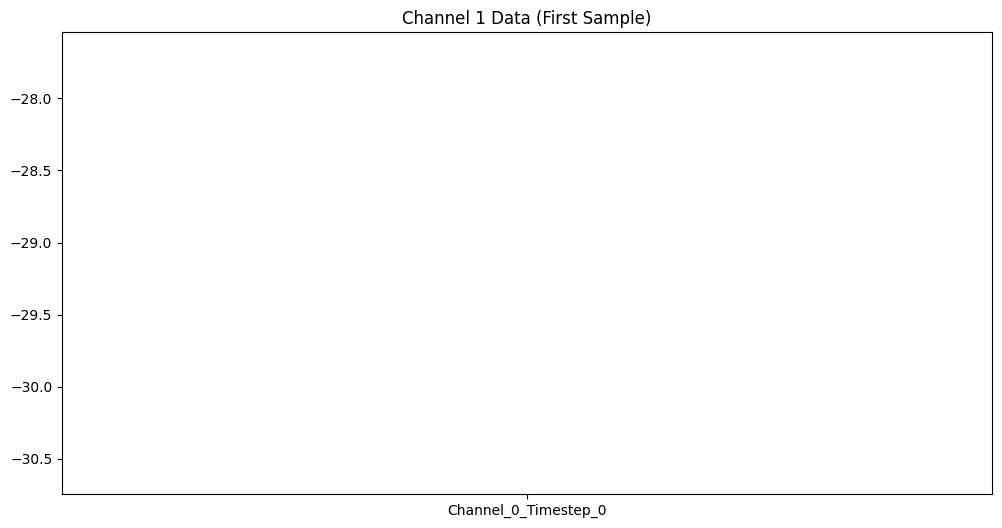

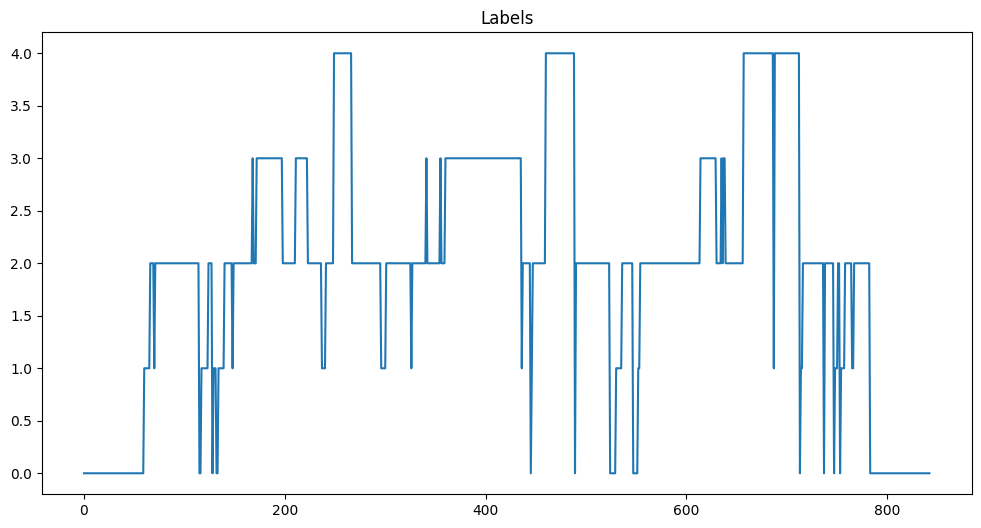

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/new_fpz/SC4061E0.npz"

data = np.load(path)

# data가 실제로 어떻게 저장되어 있는지 확인
print(type(data))
print(data.files)  # 데이터 파일 내의 키 확인

# data 파일 내의 키를 사용하여 데이터 접근
x = data['x']  # 'x' 데이터 추출
y = data['y']  # 'y' 데이터 추출

# x 데이터를 DataFrame으로 변환 (각 채널을 개별 열로 처리)
num_samples, num_channels, num_timesteps = x.shape
x_flat = x.reshape(num_samples, num_channels * num_timesteps)
columns = [f"Channel_{i}_Timestep_{j}" for i in range(num_channels) for j in range(num_timesteps)]
df_x = pd.DataFrame(x_flat, columns=columns)

# y 데이터를 DataFrame으로 변환
df_y = pd.DataFrame(y, columns=['Label'])

# x와 y 데이터를 하나의 DataFrame으로 결합
df = pd.concat([df_x, df_y], axis=1)

# DataFrame 출력
print(df)

# 첫 번째 채널의 첫 번째 샘플 데이터 시각화
fig_1 = plt.figure(figsize=(12, 6))
plt.plot(df.iloc[0, :num_timesteps])
plt.title('Channel 1 Data (First Sample)')
plt.show()

# 레이블 데이터 시각화
fig_2 = plt.figure(figsize=(12, 6))
plt.plot(df['Label'])
plt.title('Labels')
plt.show()

In [4]:
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import optimizers, models
from keras.layers import Input, Dropout, Conv1D, Flatten, Dense
from sklearn.metrics import f1_score, accuracy_score, classification_report

# 데이터 생성기 함수
def gen(data_dict, batch_size=32, aug=False):
    while True:
        for record in data_dict:
            X = data_dict[record]['x']
            Y = data_dict[record]['y']
            Y = np.eye(5)[Y]  # one-hot encoding으로 변환
            for i in range(0, len(X), batch_size):
                yield X[i:i + batch_size], Y[i:i + batch_size]

# 데이터 분할 함수
def chunker(seq, size=3000):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# 데이터 재스케일링 함수
def rescale_array(X):
    return X / np.max(np.abs(X), axis=1, keepdims=True)

# 간단한 CNN 모델 정의
nclass = 5
seq_input = Input(shape=(3000, 1))
x = Conv1D(64, kernel_size=3, activation="relu", padding="same")(seq_input)
x = Dropout(rate=0.05)(x)
x = Conv1D(64, kernel_size=3, activation="linear", padding="same")(x)
x = Flatten()(x)
out = Dense(nclass, activation="softmax")(x)
model = models.Model(seq_input, out)
model.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 파일 경로 설정
path = "/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/new_fpz/"
files = sorted(glob(os.path.join(path, "*.npz")))

# 파일 ID 설정 및 데이터 분할
ids = sorted(list(set([x.split("/")[-1][:5] for x in files])))
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=1338)
train_val, test = [x for x in files if x.split("/")[-1][:5] in train_ids],\
                  [x for x in files if x.split("/")[-1][:5] in test_ids]
train, val = train_test_split(train_val, test_size=0.1, random_state=1337)

# 데이터 로드
train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

# 모델 학습
model.fit(gen(train_dict, aug=False), validation_data=gen(val_dict), epochs=100, verbose=1,
          steps_per_epoch=100, validation_steps=30)  # 배치 크기를 줄였습니다.

# 모델 평가
preds = []
gt = []

for record in tqdm(test_dict):
    all_rows = test_dict[record]['x']
    record_y_gt = []
    record_y_pred = []
    for batch_hyp in chunker(range(all_rows.shape[0])):
        X = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
        Y = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]
        X = np.expand_dims(X, -1)  # 데이터 형식 변경
        X = rescale_array(X)
        Y_pred = model.predict(X)
        Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()
        gt += Y.ravel().tolist()
        preds += Y_pred
        record_y_gt += Y.ravel().tolist()
        record_y_pred += Y_pred

f1 = f1_score(gt, preds, average="macro")
print("Seq Test f1 score : %s "% f1)
acc = accuracy_score(gt, preds)
print("Seq Test accuracy score : %s "% acc)
print(classification_report(gt, preds))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 3000, 64)          256       
                                                                 
 dropout_2 (Dropout)         (None, 3000, 64)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 3000, 64)          12352     
                                                                 
 flatten_2 (Flatten)         (None, 192000)            0         
                                                                 
 dense_2 (Dense)             (None, 5)                 960005    
                                                                 
Total params: 972613 (3.71 MB)
Trainable params: 972613 (3.

2024-07-08 08:22:38.273354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eff5800ebd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-08 08:22:38.273408: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-07-08 08:22:38.273416: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-07-08 08:22:38.278918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 08:22:38.384634: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 - 2s - loss: 56.1924 - accuracy: 0.3870 - val_loss: 90.4783 - val_accuracy: 0.6646 - 2s/epoch - 21ms/step
Epoch 2/100
100/100 - 0s - loss: 76.4584 - accuracy: 0.6115 - val_loss: 44.8372 - val_accuracy: 0.5011 - 455ms/epoch - 5ms/step
Epoch 3/100
100/100 - 1s - loss: 65.4511 - accuracy: 0.4916 - val_loss: 225.8807 - val_accuracy: 0.1983 - 534ms/epoch - 5ms/step
Epoch 4/100
100/100 - 1s - loss: 81.2062 - accuracy: 0.4428 - val_loss: 54.8045 - val_accuracy: 0.2587 - 531ms/epoch - 5ms/step
Epoch 5/100
100/100 - 1s - loss: 34.2098 - accuracy: 0.3412 - val_loss: 68.8198 - val_accuracy: 0.1234 - 548ms/epoch - 5ms/step
Epoch 6/100
100/100 - 0s - loss: 8.1656 - accuracy: 0.3927 - val_loss: 10.3463 - val_accuracy: 0.2683 - 490ms/epoch - 5ms/step
Epoch 7/100
100/100 - 1s - loss: 11.1825 - accuracy: 0.5537 - val_loss: 16.8653 - val_accuracy: 0.1767 - 559ms/epoch - 6ms/step
Epoch 8/100
100/100 - 0s - loss: 7.6581 - accuracy: 0.4685 - val_loss: 31.2192 - val_accuracy: 0.1981 - 486ms/epoch - 

Epoch 66/100
100/100 - 0s - loss: 1.4437 - accuracy: 0.4334 - val_loss: 1.1215 - val_accuracy: 0.5604 - 350ms/epoch - 4ms/step
Epoch 67/100
100/100 - 0s - loss: 1.4468 - accuracy: 0.5494 - val_loss: 1.7759 - val_accuracy: 0.5213 - 369ms/epoch - 4ms/step
Epoch 68/100
100/100 - 0s - loss: 29.1213 - accuracy: 0.4639 - val_loss: 35.6204 - val_accuracy: 0.2563 - 367ms/epoch - 4ms/step
Epoch 69/100
100/100 - 0s - loss: 14.8381 - accuracy: 0.3628 - val_loss: 66.5748 - val_accuracy: 0.0997 - 359ms/epoch - 4ms/step
Epoch 70/100
100/100 - 0s - loss: 8.0467 - accuracy: 0.3742 - val_loss: 13.7744 - val_accuracy: 0.4550 - 360ms/epoch - 4ms/step
Epoch 71/100
100/100 - 0s - loss: 1.7013 - accuracy: 0.5664 - val_loss: 3.3277 - val_accuracy: 0.3818 - 358ms/epoch - 4ms/step
Epoch 72/100
100/100 - 0s - loss: 1.9497 - accuracy: 0.4090 - val_loss: 8.1641 - val_accuracy: 0.1968 - 363ms/epoch - 4ms/step
Epoch 73/100
100/100 - 0s - loss: 5.2917 - accuracy: 0.3690 - val_loss: 11.5070 - val_accuracy: 0.1028 - 3

  0% 0/24 [00:00<?, ?it/s]

33/33 [==============================] - 0s 2ms/step


  4% 1/24 [00:00<00:06,  3.56it/s]

32/32 [==============================] - 0s 1ms/step


  8% 2/24 [00:00<00:04,  4.47it/s]

27/27 [==============================] - 0s 2ms/step


 12% 3/24 [00:00<00:03,  5.50it/s]

32/32 [==============================] - 0s 2ms/step


 17% 4/24 [00:00<00:03,  5.25it/s]

31/31 [==============================] - 0s 1ms/step


 21% 5/24 [00:00<00:03,  5.42it/s]

40/40 [==============================] - 0s 2ms/step


 25% 6/24 [00:01<00:03,  4.94it/s]

29/29 [==============================] - 0s 1ms/step


 29% 7/24 [00:01<00:03,  5.19it/s]

26/26 [==============================] - 0s 2ms/step


 33% 8/24 [00:01<00:02,  5.43it/s]

32/32 [==============================] - 0s 2ms/step


 38% 9/24 [00:01<00:02,  5.31it/s]

30/30 [==============================] - 0s 1ms/step


 42% 10/24 [00:01<00:02,  5.36it/s]

31/31 [==============================] - 0s 1ms/step


 46% 11/24 [00:02<00:02,  5.55it/s]

32/32 [==============================] - 0s 1ms/step


 50% 12/24 [00:02<00:02,  5.64it/s]

38/38 [==============================] - 0s 1ms/step


 54% 13/24 [00:02<00:02,  5.46it/s]

35/35 [==============================] - 0s 2ms/step


 58% 14/24 [00:02<00:01,  5.29it/s]

38/38 [==============================] - 0s 2ms/step


 62% 15/24 [00:02<00:01,  5.11it/s]

68/68 [==============================] - 0s 1ms/step


 67% 16/24 [00:03<00:01,  4.27it/s]

46/46 [==============================] - 0s 1ms/step


 71% 17/24 [00:03<00:01,  4.27it/s]

57/57 [==============================] - 0s 2ms/step


 75% 18/24 [00:03<00:01,  3.91it/s]

34/34 [==============================] - 0s 2ms/step


 79% 19/24 [00:03<00:01,  4.12it/s]

35/35 [==============================] - 0s 2ms/step


 83% 20/24 [00:04<00:00,  4.32it/s]

45/45 [==============================] - 0s 2ms/step


 88% 21/24 [00:04<00:00,  4.30it/s]

39/39 [==============================] - 0s 1ms/step


 92% 22/24 [00:04<00:00,  4.48it/s]

42/42 [==============================] - 0s 2ms/step


 96% 23/24 [00:04<00:00,  4.43it/s]

42/42 [==============================] - 0s 1ms/step


100% 24/24 [00:05<00:00,  4.76it/s]

Seq Test f1 score : 0.04130649111089909 
Seq Test accuracy score : 0.1151581784650305 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8393
           1       0.12      1.00      0.21      3247
           2       0.00      0.00      0.00     10798
           3       0.00      0.00      0.00      2302
           4       0.00      0.00      0.00      3456

    accuracy                           0.12     28196
   macro avg       0.02      0.20      0.04     28196
weighted avg       0.01      0.12      0.02     28196




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import optimizers, losses, models
from keras.layers import Input, Dropout, LSTM, Dense
from sklearn.metrics import f1_score, accuracy_score, classification_report

# 데이터 로드 함수
def load_data(files):
    X, Y = [], []
    for file in files:
        data = np.load(file)
        X.append(data['x'])
        Y.append(data['y'])
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    return X, Y

# 데이터 재스케일링 함수
def rescale_array(X):
    return X / np.max(np.abs(X), axis=1, keepdims=True)

# 모델 정의
nclass = 5

seq_input = Input(shape=(3000, 1))
x = LSTM(100, return_sequences=True)(seq_input)
x = Dropout(rate=0.5)(x)
x = LSTM(100)(x)  # 마지막 LSTM 레이어에서 return_sequences=False로 설정하여 마지막 시간 단계의 출력만 사용
out = Dense(nclass, activation="softmax")(x)

model = models.Model(seq_input, out)
model.compile(optimizer=optimizers.Adam(0.001), loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

# 파일 경로 설정
path = "/home/work/HCOH/sleep/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/new_fpz/"
files = sorted(glob(os.path.join(path, "*.npz")))

# 파일 ID 설정 및 데이터 분할
ids = sorted(list(set([x.split("/")[-1][:5] for x in files])))
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=1338)
train_val, test = [x for x in files if x.split("/")[-1][:5] in train_ids],\
                  [x for x in files if x.split("/")[-1][:5] in test_ids]
train, val = train_test_split(train_val, test_size=0.1, random_state=1337)

# 데이터 로드
X_train, Y_train = load_data(train)
X_val, Y_val = load_data(val)
X_test, Y_test = load_data(test)

# 데이터 재스케일링
X_train = rescale_array(X_train)
X_val = rescale_array(X_val)
X_test = rescale_array(X_test)

# 모델 학습
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=18, verbose=True, batch_size=32)

# 모델 평가
preds = []
gt = []

for i in tqdm(range(len(X_test))):
    X = X_test[i:i+1]
    Y = Y_test[i:i+1]
    Y_pred = model.predict(X)
    Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()
    gt += Y.ravel().tolist()
    preds += Y_pred

f1 = f1_score(gt, preds, average="macro")
print("Seq Test f1 score : %s "% f1)
acc = accuracy_score(gt, preds)
print("Seq Test accuracy score : %s "% acc)
print(classification_report(gt, preds))

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 3000, 1)]         0         
                                                                 
 lstm_41 (LSTM)              (None, 3000, 100)         40800     
                                                                 
 dropout_25 (Dropout)        (None, 3000, 100)         0         
                                                                 
 lstm_42 (LSTM)              (None, 100)               80400     
                                                                 
 dense_22 (Dense)            (None, 5)                 505       
                                                                 
Total params: 121705 (475.41 KB)
Trainable params: 121705 (475.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/18
4679/46

  0% 0/28196 [00:00<?, ?it/s]

1/1 [==============================] - 1s 544ms/step


  0% 1/28196 [00:00<4:38:12,  1.69it/s]

1/1 [==============================] - 0s 85ms/step


  0% 2/28196 [00:00<2:25:17,  3.23it/s]

1/1 [==============================] - 0s 87ms/step


  0% 3/28196 [00:00<1:42:38,  4.58it/s]

1/1 [==============================] - 0s 84ms/step


  0% 4/28196 [00:00<1:22:33,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


  0% 5/28196 [00:01<1:11:27,  6.58it/s]

1/1 [==============================] - 0s 84ms/step


  0% 6/28196 [00:01<1:04:27,  7.29it/s]

1/1 [==============================] - 0s 84ms/step


  0% 7/28196 [00:01<59:56,  7.84it/s]  

1/1 [==============================] - 0s 84ms/step


  0% 8/28196 [00:01<57:08,  8.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 9/28196 [00:01<55:09,  8.52it/s]

1/1 [==============================] - 0s 85ms/step


  0% 10/28196 [00:01<53:59,  8.70it/s]

1/1 [==============================] - 0s 84ms/step


  0% 11/28196 [00:01<53:00,  8.86it/s]

1/1 [==============================] - 0s 92ms/step


  0% 12/28196 [00:01<53:30,  8.78it/s]

1/1 [==============================] - 0s 86ms/step


  0% 13/28196 [00:01<53:29,  8.78it/s]

1/1 [==============================] - 0s 84ms/step


  0% 14/28196 [00:02<52:44,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


  0% 15/28196 [00:02<52:30,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


  0% 16/28196 [00:02<52:04,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  0% 17/28196 [00:02<51:41,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


  0% 18/28196 [00:02<51:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  0% 19/28196 [00:02<51:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 20/28196 [00:02<51:04,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


  0% 21/28196 [00:02<51:00,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


  0% 22/28196 [00:02<51:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  0% 23/28196 [00:03<51:19,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 24/28196 [00:03<51:54,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  0% 25/28196 [00:03<51:52,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  0% 26/28196 [00:03<51:31,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  0% 27/28196 [00:03<51:18,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  0% 28/28196 [00:03<51:16,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 29/28196 [00:03<51:07,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  0% 30/28196 [00:03<51:11,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 31/28196 [00:03<51:43,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  0% 32/28196 [00:03<51:40,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  0% 33/28196 [00:04<51:28,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  0% 34/28196 [00:04<51:16,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 35/28196 [00:04<51:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  0% 36/28196 [00:04<50:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  0% 37/28196 [00:04<50:42,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  0% 38/28196 [00:04<50:50,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  0% 39/28196 [00:04<50:47,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  0% 40/28196 [00:04<51:28,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


  0% 41/28196 [00:04<51:19,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  0% 42/28196 [00:05<51:10,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 43/28196 [00:05<50:58,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  0% 44/28196 [00:05<50:49,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  0% 45/28196 [00:05<50:54,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 46/28196 [00:05<50:51,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 47/28196 [00:05<50:40,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  0% 48/28196 [00:05<50:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  0% 49/28196 [00:05<51:12,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 50/28196 [00:05<51:22,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


  0% 51/28196 [00:06<51:55,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  0% 52/28196 [00:06<51:34,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


  0% 53/28196 [00:06<51:39,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  0% 54/28196 [00:06<51:19,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  0% 55/28196 [00:06<51:05,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  0% 56/28196 [00:06<51:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 57/28196 [00:06<50:47,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  0% 58/28196 [00:06<51:27,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  0% 59/28196 [00:06<51:15,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  0% 60/28196 [00:07<51:10,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 61/28196 [00:07<50:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  0% 62/28196 [00:07<50:42,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  0% 63/28196 [00:07<51:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 64/28196 [00:07<50:49,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 65/28196 [00:07<50:40,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  0% 66/28196 [00:07<50:33,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  0% 67/28196 [00:07<51:15,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 68/28196 [00:07<51:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  0% 69/28196 [00:08<50:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  0% 70/28196 [00:08<50:47,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  0% 71/28196 [00:08<50:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  0% 72/28196 [00:08<50:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 73/28196 [00:08<50:45,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  0% 74/28196 [00:08<50:38,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  0% 75/28196 [00:08<50:40,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  0% 76/28196 [00:08<51:27,  9.11it/s]

1/1 [==============================] - 0s 93ms/step


  0% 77/28196 [00:08<52:32,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


  0% 78/28196 [00:09<51:54,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


  0% 79/28196 [00:09<51:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  0% 80/28196 [00:09<50:58,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 81/28196 [00:09<50:43,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  0% 82/28196 [00:09<51:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 83/28196 [00:09<50:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  0% 84/28196 [00:09<50:46,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  0% 85/28196 [00:09<51:22,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  0% 86/28196 [00:09<51:11,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  0% 87/28196 [00:09<51:04,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 88/28196 [00:10<50:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 89/28196 [00:10<50:36,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  0% 90/28196 [00:10<50:28,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  0% 91/28196 [00:10<50:26,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  0% 92/28196 [00:10<50:20,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  0% 93/28196 [00:10<50:18,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  0% 94/28196 [00:10<50:59,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 95/28196 [00:10<50:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  0% 96/28196 [00:10<50:39,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  0% 97/28196 [00:11<50:40,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  0% 98/28196 [00:11<50:30,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  0% 99/28196 [00:11<50:28,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  0% 100/28196 [00:11<50:24,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


  0% 101/28196 [00:11<50:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  0% 102/28196 [00:11<50:18,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


  0% 103/28196 [00:11<51:26,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  0% 104/28196 [00:11<51:24,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  0% 105/28196 [00:11<51:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  0% 106/28196 [00:12<51:09,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 107/28196 [00:12<51:04,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 108/28196 [00:12<50:56,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 109/28196 [00:12<51:05,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 110/28196 [00:12<50:56,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  0% 111/28196 [00:12<50:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  0% 112/28196 [00:12<51:42,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  0% 113/28196 [00:12<51:30,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  0% 114/28196 [00:12<51:08,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  0% 115/28196 [00:13<51:12,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  0% 116/28196 [00:13<51:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  0% 117/28196 [00:13<51:02,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 118/28196 [00:13<50:46,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  0% 119/28196 [00:13<50:36,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  0% 120/28196 [00:13<50:35,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  0% 121/28196 [00:13<51:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  0% 122/28196 [00:13<51:23,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  0% 123/28196 [00:13<51:28,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  0% 124/28196 [00:14<51:11,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  0% 125/28196 [00:14<51:05,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  0% 126/28196 [00:14<50:59,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  0% 127/28196 [00:14<50:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  0% 128/28196 [00:14<50:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  0% 129/28196 [00:14<50:38,  9.24it/s]

1/1 [==============================] - 0s 109ms/step


  0% 130/28196 [00:14<54:51,  8.53it/s]

1/1 [==============================] - 0s 85ms/step


  0% 131/28196 [00:14<53:51,  8.69it/s]

1/1 [==============================] - 0s 84ms/step


  0% 132/28196 [00:14<52:52,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


  0% 133/28196 [00:15<52:07,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


  0% 134/28196 [00:15<51:32,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  0% 135/28196 [00:15<51:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  0% 136/28196 [00:15<51:03,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  0% 137/28196 [00:15<51:01,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  0% 138/28196 [00:15<50:51,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


  0% 139/28196 [00:15<52:00,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


  0% 140/28196 [00:15<51:49,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  1% 141/28196 [00:15<51:29,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  1% 142/28196 [00:15<51:12,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 143/28196 [00:16<51:04,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  1% 144/28196 [00:16<50:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  1% 145/28196 [00:16<50:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  1% 146/28196 [00:16<50:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  1% 147/28196 [00:16<50:22,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  1% 148/28196 [00:16<51:09,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


  1% 149/28196 [00:16<51:53,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  1% 150/28196 [00:16<51:32,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  1% 151/28196 [00:16<51:10,  9.13it/s]

1/1 [==============================] - 0s 90ms/step


  1% 152/28196 [00:17<51:48,  9.02it/s]

1/1 [==============================] - 0s 89ms/step


  1% 153/28196 [00:17<52:06,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


  1% 154/28196 [00:17<52:02,  8.98it/s]

1/1 [==============================] - 0s 89ms/step


  1% 155/28196 [00:17<52:14,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  1% 156/28196 [00:17<52:08,  8.96it/s]

1/1 [==============================] - 0s 89ms/step


  1% 157/28196 [00:17<53:06,  8.80it/s]

1/1 [==============================] - 0s 88ms/step


  1% 158/28196 [00:17<52:59,  8.82it/s]

1/1 [==============================] - 0s 88ms/step


  1% 159/28196 [00:17<53:01,  8.81it/s]

1/1 [==============================] - 0s 90ms/step


  1% 160/28196 [00:18<53:08,  8.79it/s]

1/1 [==============================] - 0s 90ms/step


  1% 161/28196 [00:18<53:10,  8.79it/s]

1/1 [==============================] - 0s 87ms/step


  1% 162/28196 [00:18<52:46,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


  1% 163/28196 [00:18<52:19,  8.93it/s]

1/1 [==============================] - 0s 87ms/step


  1% 164/28196 [00:18<52:09,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


  1% 165/28196 [00:18<51:40,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


  1% 166/28196 [00:18<52:24,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


  1% 167/28196 [00:18<52:13,  8.95it/s]

1/1 [==============================] - 0s 89ms/step


  1% 168/28196 [00:18<52:46,  8.85it/s]

1/1 [==============================] - 0s 89ms/step


  1% 169/28196 [00:19<53:01,  8.81it/s]

1/1 [==============================] - 0s 88ms/step


  1% 170/28196 [00:19<52:54,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


  1% 171/28196 [00:19<52:13,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


  1% 172/28196 [00:19<51:46,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  1% 173/28196 [00:19<51:28,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 174/28196 [00:19<51:13,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


  1% 175/28196 [00:19<52:00,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


  1% 176/28196 [00:19<51:57,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


  1% 177/28196 [00:19<51:41,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  1% 178/28196 [00:20<51:25,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  1% 179/28196 [00:20<51:12,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


  1% 180/28196 [00:20<51:07,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 181/28196 [00:20<51:04,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  1% 182/28196 [00:20<50:55,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 183/28196 [00:20<50:56,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


  1% 184/28196 [00:20<51:50,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  1% 185/28196 [00:20<51:40,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


  1% 186/28196 [00:20<51:27,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 187/28196 [00:20<51:35,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  1% 188/28196 [00:21<51:14,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  1% 189/28196 [00:21<51:06,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 190/28196 [00:21<50:52,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 191/28196 [00:21<50:36,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 192/28196 [00:21<50:29,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  1% 193/28196 [00:21<51:24,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


  1% 194/28196 [00:21<51:45,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  1% 195/28196 [00:21<51:39,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  1% 196/28196 [00:21<51:18,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  1% 197/28196 [00:22<51:23,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


  1% 198/28196 [00:22<51:13,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  1% 199/28196 [00:22<50:53,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 200/28196 [00:22<50:47,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


  1% 201/28196 [00:22<50:54,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 202/28196 [00:22<51:44,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  1% 203/28196 [00:22<51:46,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  1% 204/28196 [00:22<51:26,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 205/28196 [00:22<51:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  1% 206/28196 [00:23<51:05,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


  1% 207/28196 [00:23<52:15,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


  1% 208/28196 [00:23<51:55,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  1% 209/28196 [00:23<51:34,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


  1% 210/28196 [00:23<51:14,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


  1% 211/28196 [00:23<52:00,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


  1% 212/28196 [00:23<51:54,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  1% 213/28196 [00:23<51:37,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


  1% 214/28196 [00:23<51:26,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 215/28196 [00:24<51:15,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  1% 216/28196 [00:24<51:02,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  1% 217/28196 [00:24<50:58,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 218/28196 [00:24<50:50,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


  1% 219/28196 [00:24<50:54,  9.16it/s]

1/1 [==============================] - 0s 91ms/step


  1% 220/28196 [00:24<52:30,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


  1% 221/28196 [00:24<52:29,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


  1% 222/28196 [00:24<52:04,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  1% 223/28196 [00:24<51:40,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  1% 224/28196 [00:25<51:16,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  1% 225/28196 [00:25<51:02,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


  1% 226/28196 [00:25<51:39,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  1% 227/28196 [00:25<51:22,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  1% 228/28196 [00:25<50:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  1% 229/28196 [00:25<51:35,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


  1% 230/28196 [00:25<51:20,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  1% 231/28196 [00:25<51:14,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  1% 232/28196 [00:25<51:24,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 233/28196 [00:26<51:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  1% 234/28196 [00:26<51:02,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 235/28196 [00:26<50:51,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 236/28196 [00:26<50:48,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


  1% 237/28196 [00:26<50:57,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


  1% 238/28196 [00:26<52:07,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


  1% 239/28196 [00:26<51:50,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


  1% 240/28196 [00:26<51:35,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  1% 241/28196 [00:26<51:17,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  1% 242/28196 [00:27<51:25,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


  1% 243/28196 [00:27<51:08,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  1% 244/28196 [00:27<51:00,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


  1% 245/28196 [00:27<50:54,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  1% 246/28196 [00:27<50:42,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


  1% 247/28196 [00:27<51:29,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  1% 248/28196 [00:27<51:26,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


  1% 249/28196 [00:27<51:23,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


  1% 250/28196 [00:27<50:57,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  1% 251/28196 [00:28<50:30,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 252/28196 [00:28<50:17,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  1% 253/28196 [00:28<50:10,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  1% 254/28196 [00:28<50:01,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  1% 255/28196 [00:28<50:26,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  1% 256/28196 [00:28<51:21,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


  1% 257/28196 [00:28<51:21,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


  1% 258/28196 [00:28<51:00,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 259/28196 [00:28<51:08,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  1% 260/28196 [00:29<50:54,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 261/28196 [00:29<50:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 262/28196 [00:29<50:30,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 263/28196 [00:29<50:18,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  1% 264/28196 [00:29<50:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  1% 265/28196 [00:29<50:55,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  1% 266/28196 [00:29<50:38,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  1% 267/28196 [00:29<50:26,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  1% 268/28196 [00:29<50:40,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


  1% 269/28196 [00:29<51:00,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 270/28196 [00:30<50:44,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 271/28196 [00:30<50:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  1% 272/28196 [00:30<50:17,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  1% 273/28196 [00:30<50:11,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


  1% 274/28196 [00:30<51:01,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 275/28196 [00:30<50:53,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  1% 276/28196 [00:30<50:47,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 277/28196 [00:30<50:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 278/28196 [00:30<50:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  1% 279/28196 [00:31<50:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  1% 280/28196 [00:31<50:18,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  1% 281/28196 [00:31<50:08,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  1% 282/28196 [00:31<50:01,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


  1% 283/28196 [00:31<51:13,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  1% 284/28196 [00:31<50:59,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


  1% 285/28196 [00:31<51:12,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


  1% 286/28196 [00:31<51:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


  1% 287/28196 [00:31<51:02,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  1% 288/28196 [00:32<50:47,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 289/28196 [00:32<50:29,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


  1% 290/28196 [00:32<50:25,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 291/28196 [00:32<50:18,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  1% 292/28196 [00:32<51:24,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  1% 293/28196 [00:32<51:11,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


  1% 294/28196 [00:32<50:48,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  1% 295/28196 [00:32<50:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  1% 296/28196 [00:32<50:42,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 297/28196 [00:33<50:35,  9.19it/s]

1/1 [==============================] - 0s 99ms/step


  1% 298/28196 [00:33<52:37,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


  1% 299/28196 [00:33<51:51,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


  1% 300/28196 [00:33<51:47,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  1% 301/28196 [00:33<52:21,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


  1% 302/28196 [00:33<51:46,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


  1% 303/28196 [00:33<51:25,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


  1% 304/28196 [00:33<51:22,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  1% 305/28196 [00:33<51:07,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


  1% 306/28196 [00:34<51:05,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  1% 307/28196 [00:34<50:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  1% 308/28196 [00:34<50:34,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  1% 309/28196 [00:34<50:23,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


  1% 310/28196 [00:34<51:04,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  1% 311/28196 [00:34<50:44,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


  1% 312/28196 [00:34<51:25,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


  1% 313/28196 [00:34<51:08,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  1% 314/28196 [00:34<50:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 315/28196 [00:35<50:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  1% 316/28196 [00:35<50:23,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 317/28196 [00:35<50:20,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  1% 318/28196 [00:35<50:11,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


  1% 319/28196 [00:35<50:55,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 320/28196 [00:35<50:45,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 321/28196 [00:35<50:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 322/28196 [00:35<50:47,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 323/28196 [00:35<50:40,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 324/28196 [00:36<50:37,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  1% 325/28196 [00:36<50:35,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  1% 326/28196 [00:36<50:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  1% 327/28196 [00:36<50:16,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  1% 328/28196 [00:36<51:03,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


  1% 329/28196 [00:36<51:17,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


  1% 330/28196 [00:36<51:17,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


  1% 331/28196 [00:36<51:16,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  1% 332/28196 [00:36<50:59,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  1% 333/28196 [00:37<50:46,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 334/28196 [00:37<50:44,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  1% 335/28196 [00:37<50:39,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  1% 336/28196 [00:37<50:34,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  1% 337/28196 [00:37<51:13,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 338/28196 [00:37<51:03,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


  1% 339/28196 [00:37<51:51,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  1% 340/28196 [00:37<51:49,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


  1% 341/28196 [00:37<52:00,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


  1% 342/28196 [00:38<51:31,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  1% 343/28196 [00:38<51:15,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  1% 344/28196 [00:38<51:29,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


  1% 345/28196 [00:38<51:10,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  1% 346/28196 [00:38<52:01,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


  1% 347/28196 [00:38<51:48,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


  1% 348/28196 [00:38<51:31,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  1% 349/28196 [00:38<51:21,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


  1% 350/28196 [00:38<51:03,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


  1% 351/28196 [00:38<51:13,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  1% 352/28196 [00:39<51:15,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  1% 353/28196 [00:39<50:55,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  1% 354/28196 [00:39<50:30,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  1% 355/28196 [00:39<51:02,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  1% 356/28196 [00:39<50:46,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  1% 357/28196 [00:39<50:47,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  1% 358/28196 [00:39<50:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 359/28196 [00:39<50:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 360/28196 [00:39<50:24,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


  1% 361/28196 [00:40<50:24,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  1% 362/28196 [00:40<50:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  1% 363/28196 [00:40<50:02,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


  1% 364/28196 [00:40<50:55,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  1% 365/28196 [00:40<50:50,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 366/28196 [00:40<50:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  1% 367/28196 [00:40<50:30,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  1% 368/28196 [00:40<50:23,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


  1% 369/28196 [00:40<50:31,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  1% 370/28196 [00:41<50:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  1% 371/28196 [00:41<50:35,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 372/28196 [00:41<50:27,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


  1% 373/28196 [00:41<51:03,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  1% 374/28196 [00:41<50:50,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 375/28196 [00:41<50:36,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  1% 376/28196 [00:41<50:29,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


  1% 377/28196 [00:41<50:21,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  1% 378/28196 [00:41<50:16,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  1% 379/28196 [00:42<50:12,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  1% 380/28196 [00:42<50:03,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  1% 381/28196 [00:42<49:54,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


  1% 382/28196 [00:42<50:33,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 383/28196 [00:42<50:33,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  1% 384/28196 [00:42<50:26,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


  1% 385/28196 [00:42<50:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  1% 386/28196 [00:42<50:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  1% 387/28196 [00:42<50:19,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  1% 388/28196 [00:43<50:12,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  1% 389/28196 [00:43<50:09,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  1% 390/28196 [00:43<50:12,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  1% 391/28196 [00:43<51:00,  9.08it/s]

1/1 [==============================] - 0s 115ms/step


  1% 392/28196 [01:28<105:49:34, 13.70s/it]

1/1 [==============================] - 0s 109ms/step


  1% 393/28196 [01:28<74:24:19,  9.63s/it] 

1/1 [==============================] - 0s 87ms/step


  1% 394/28196 [01:29<52:21:14,  6.78s/it]

1/1 [==============================] - 0s 86ms/step


  1% 395/28196 [01:29<36:54:29,  4.78s/it]

1/1 [==============================] - 0s 85ms/step


  1% 396/28196 [01:29<26:05:32,  3.38s/it]

1/1 [==============================] - 0s 83ms/step


  1% 397/28196 [01:29<18:31:04,  2.40s/it]

1/1 [==============================] - 0s 84ms/step


  1% 398/28196 [01:29<13:12:59,  1.71s/it]

1/1 [==============================] - 0s 84ms/step


  1% 399/28196 [01:29<9:30:15,  1.23s/it] 

1/1 [==============================] - 0s 83ms/step


  1% 400/28196 [01:29<6:54:13,  1.12it/s]

1/1 [==============================] - 0s 85ms/step


  1% 401/28196 [01:29<5:06:25,  1.51it/s]

1/1 [==============================] - 0s 85ms/step


  1% 402/28196 [01:29<3:49:54,  2.01it/s]

1/1 [==============================] - 0s 89ms/step


  1% 403/28196 [01:30<2:56:50,  2.62it/s]

1/1 [==============================] - 0s 84ms/step


  1% 404/28196 [01:30<2:19:00,  3.33it/s]

1/1 [==============================] - 0s 84ms/step


  1% 405/28196 [01:30<1:52:21,  4.12it/s]

1/1 [==============================] - 0s 84ms/step


  1% 406/28196 [01:30<1:33:38,  4.95it/s]

1/1 [==============================] - 0s 84ms/step


  1% 407/28196 [01:30<1:20:41,  5.74it/s]

1/1 [==============================] - 0s 83ms/step


  1% 408/28196 [01:30<1:11:29,  6.48it/s]

1/1 [==============================] - 0s 83ms/step


  1% 409/28196 [01:30<1:04:57,  7.13it/s]

1/1 [==============================] - 0s 85ms/step


  1% 410/28196 [01:30<1:01:33,  7.52it/s]

1/1 [==============================] - 0s 84ms/step


  1% 411/28196 [01:30<58:29,  7.92it/s]  

1/1 [==============================] - 0s 83ms/step


  1% 412/28196 [01:31<55:52,  8.29it/s]

1/1 [==============================] - 0s 83ms/step


  1% 413/28196 [01:31<54:02,  8.57it/s]

1/1 [==============================] - 0s 83ms/step


  1% 414/28196 [01:31<52:49,  8.76it/s]

1/1 [==============================] - 0s 84ms/step


  1% 415/28196 [01:31<51:58,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


  1% 416/28196 [01:31<51:42,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


  1% 417/28196 [01:31<51:08,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  1% 418/28196 [01:31<50:41,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


  1% 419/28196 [01:31<51:57,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


  1% 420/28196 [01:31<51:23,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


  1% 421/28196 [01:32<50:43,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  1% 422/28196 [01:32<50:22,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 423/28196 [01:32<50:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 424/28196 [01:32<49:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 425/28196 [01:32<49:40,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  2% 426/28196 [01:32<49:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  2% 427/28196 [01:32<49:35,  9.33it/s]

1/1 [==============================] - 0s 89ms/step


  2% 428/28196 [01:32<51:12,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


  2% 429/28196 [01:32<50:59,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  2% 430/28196 [01:32<50:42,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  2% 431/28196 [01:33<50:19,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 432/28196 [01:33<50:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 433/28196 [01:33<49:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 434/28196 [01:33<49:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 435/28196 [01:33<49:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 436/28196 [01:33<49:24,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  2% 437/28196 [01:33<50:25,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  2% 438/28196 [01:33<50:38,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  2% 439/28196 [01:33<50:26,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  2% 440/28196 [01:34<50:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  2% 441/28196 [01:34<50:14,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  2% 442/28196 [01:34<50:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 443/28196 [01:34<49:58,  9.26it/s]

1/1 [==============================] - 0s 100ms/step


  2% 444/28196 [01:34<52:05,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


  2% 445/28196 [01:34<51:44,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


  2% 446/28196 [01:34<52:09,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


  2% 447/28196 [01:34<51:36,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


  2% 448/28196 [01:34<51:34,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


  2% 449/28196 [01:35<51:03,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


  2% 450/28196 [01:35<50:54,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


  2% 451/28196 [01:35<50:32,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  2% 452/28196 [01:35<50:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  2% 453/28196 [01:35<50:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 454/28196 [01:35<49:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 455/28196 [01:35<50:31,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  2% 456/28196 [01:35<50:13,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  2% 457/28196 [01:35<49:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  2% 458/28196 [01:36<49:35,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  2% 459/28196 [01:36<49:23,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  2% 460/28196 [01:36<49:20,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  2% 461/28196 [01:36<49:20,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  2% 462/28196 [01:36<49:18,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  2% 463/28196 [01:36<49:16,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  2% 464/28196 [01:36<50:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 465/28196 [01:36<49:55,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  2% 466/28196 [01:36<49:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  2% 467/28196 [01:36<49:54,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  2% 468/28196 [01:37<49:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 469/28196 [01:37<49:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  2% 470/28196 [01:37<49:48,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  2% 471/28196 [01:37<49:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 472/28196 [01:37<49:28,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 473/28196 [01:37<50:08,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  2% 474/28196 [01:37<49:51,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 475/28196 [01:37<49:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 476/28196 [01:37<49:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  2% 477/28196 [01:38<50:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  2% 478/28196 [01:38<49:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 479/28196 [01:38<49:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  2% 480/28196 [01:38<49:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 481/28196 [01:38<49:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  2% 482/28196 [01:38<50:04,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  2% 483/28196 [01:38<50:23,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  2% 484/28196 [01:38<50:13,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  2% 485/28196 [01:38<49:50,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  2% 486/28196 [01:39<49:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 487/28196 [01:39<50:00,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  2% 488/28196 [01:39<49:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 489/28196 [01:39<49:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 490/28196 [01:39<49:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 491/28196 [01:39<50:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  2% 492/28196 [01:39<49:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  2% 493/28196 [01:39<49:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 494/28196 [01:39<49:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 495/28196 [01:40<49:19,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  2% 496/28196 [01:40<49:16,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  2% 497/28196 [01:40<49:13,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


  2% 498/28196 [01:40<49:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 499/28196 [01:40<49:22,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  2% 500/28196 [01:40<50:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  2% 501/28196 [01:40<50:01,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 502/28196 [01:40<49:54,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  2% 503/28196 [01:40<49:38,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  2% 504/28196 [01:40<49:22,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  2% 505/28196 [01:41<49:15,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


  2% 506/28196 [01:41<50:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  2% 507/28196 [01:41<49:58,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 508/28196 [01:41<49:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 509/28196 [01:41<50:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  2% 510/28196 [01:41<50:03,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 511/28196 [01:41<49:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 512/28196 [01:41<49:45,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  2% 513/28196 [01:41<49:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 514/28196 [01:42<49:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 515/28196 [01:42<49:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  2% 516/28196 [01:42<49:16,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  2% 517/28196 [01:42<49:13,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  2% 518/28196 [01:42<49:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 519/28196 [01:42<49:55,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  2% 520/28196 [01:42<49:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 521/28196 [01:42<49:32,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  2% 522/28196 [01:42<49:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  2% 523/28196 [01:43<49:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  2% 524/28196 [01:43<49:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 525/28196 [01:43<49:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 526/28196 [01:43<49:21,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


  2% 527/28196 [01:43<50:15,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  2% 528/28196 [01:43<50:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  2% 529/28196 [01:43<50:02,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  2% 530/28196 [01:43<49:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 531/28196 [01:43<49:41,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  2% 532/28196 [01:43<49:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  2% 533/28196 [01:44<49:14,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  2% 534/28196 [01:44<49:15,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  2% 535/28196 [01:44<49:42,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


  2% 536/28196 [01:44<50:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  2% 537/28196 [01:44<50:32,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  2% 538/28196 [01:44<50:16,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  2% 539/28196 [01:44<49:50,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  2% 540/28196 [01:44<50:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  2% 541/28196 [01:44<50:02,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  2% 542/28196 [01:45<49:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 543/28196 [01:45<49:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 544/28196 [01:45<49:28,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


  2% 545/28196 [01:45<50:49,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  2% 546/28196 [01:45<50:32,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  2% 547/28196 [01:45<50:17,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  2% 548/28196 [01:45<50:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  2% 549/28196 [01:45<49:45,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  2% 550/28196 [01:45<49:29,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  2% 551/28196 [01:46<49:13,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  2% 552/28196 [01:46<49:08,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  2% 553/28196 [01:46<49:27,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 554/28196 [01:46<50:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 555/28196 [01:46<49:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 556/28196 [01:46<49:43,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  2% 557/28196 [01:46<49:44,  9.26it/s]

1/1 [==============================] - 0s 89ms/step


  2% 558/28196 [01:46<50:31,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  2% 559/28196 [01:46<50:34,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  2% 560/28196 [01:47<50:06,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  2% 561/28196 [01:47<49:57,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  2% 562/28196 [01:47<49:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  2% 563/28196 [01:47<50:46,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


  2% 564/28196 [01:47<50:21,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  2% 565/28196 [01:47<50:01,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  2% 566/28196 [01:47<49:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 567/28196 [01:47<49:45,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  2% 568/28196 [01:47<49:51,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 569/28196 [01:48<49:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 570/28196 [01:48<49:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 571/28196 [01:48<49:32,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  2% 572/28196 [01:48<50:15,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  2% 573/28196 [01:48<49:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  2% 574/28196 [01:48<49:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 575/28196 [01:48<49:42,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  2% 576/28196 [01:48<49:27,  9.31it/s]

1/1 [==============================] - 0s 92ms/step


  2% 577/28196 [01:48<50:52,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  2% 578/28196 [01:48<50:32,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  2% 579/28196 [01:49<50:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  2% 580/28196 [01:49<50:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 581/28196 [01:49<50:32,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  2% 582/28196 [01:49<50:09,  9.18it/s]

1/1 [==============================] - 0s 81ms/step


  2% 583/28196 [01:49<49:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 584/28196 [01:49<49:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 585/28196 [01:49<49:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 586/28196 [01:49<49:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 587/28196 [01:49<49:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 588/28196 [01:50<49:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  2% 589/28196 [01:50<49:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 590/28196 [01:50<50:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  2% 591/28196 [01:50<49:52,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  2% 592/28196 [01:50<50:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  2% 593/28196 [01:50<50:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  2% 594/28196 [01:50<49:42,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  2% 595/28196 [01:50<49:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 596/28196 [01:50<49:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 597/28196 [01:51<49:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 598/28196 [01:51<49:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 599/28196 [01:51<50:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 600/28196 [01:51<49:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 601/28196 [01:51<49:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 602/28196 [01:51<49:33,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


  2% 603/28196 [01:51<50:14,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  2% 604/28196 [01:51<50:09,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  2% 605/28196 [01:51<49:50,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 606/28196 [01:52<49:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  2% 607/28196 [01:52<49:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 608/28196 [01:52<50:16,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  2% 609/28196 [01:52<49:49,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  2% 610/28196 [01:52<49:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 611/28196 [01:52<49:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 612/28196 [01:52<49:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  2% 613/28196 [01:52<49:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 614/28196 [01:52<49:24,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  2% 615/28196 [01:52<49:07,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


  2% 616/28196 [01:53<49:50,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 617/28196 [01:53<50:33,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  2% 618/28196 [01:53<50:16,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  2% 619/28196 [01:53<49:53,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  2% 620/28196 [01:53<49:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  2% 621/28196 [01:53<49:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 622/28196 [01:53<49:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 623/28196 [01:53<49:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 624/28196 [01:53<48:57,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  2% 625/28196 [01:54<48:44,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  2% 626/28196 [01:54<49:29,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  2% 627/28196 [01:54<49:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  2% 628/28196 [01:54<49:27,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


  2% 629/28196 [01:54<49:47,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 630/28196 [01:54<49:36,  9.26it/s]

1/1 [==============================] - 0s 81ms/step


  2% 631/28196 [01:54<49:08,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


  2% 632/28196 [01:54<49:18,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  2% 633/28196 [01:54<49:06,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


  2% 634/28196 [01:55<48:48,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  2% 635/28196 [01:55<49:39,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  2% 636/28196 [01:55<49:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  2% 637/28196 [01:55<49:12,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 638/28196 [01:55<49:00,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  2% 639/28196 [01:55<48:53,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  2% 640/28196 [01:55<48:46,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


  2% 641/28196 [01:55<48:53,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  2% 642/28196 [01:55<49:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  2% 643/28196 [01:55<48:54,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  2% 644/28196 [01:56<49:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  2% 645/28196 [01:56<49:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 646/28196 [01:56<49:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 647/28196 [01:56<49:19,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 648/28196 [01:56<49:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 649/28196 [01:56<49:10,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 650/28196 [01:56<49:30,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  2% 651/28196 [01:56<49:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 652/28196 [01:56<48:58,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  2% 653/28196 [01:57<49:42,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  2% 654/28196 [01:57<49:38,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  2% 655/28196 [01:57<49:22,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 656/28196 [01:57<49:12,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  2% 657/28196 [01:57<49:16,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  2% 658/28196 [01:57<49:05,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  2% 659/28196 [01:57<49:16,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  2% 660/28196 [01:57<49:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 661/28196 [01:57<49:19,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 662/28196 [01:58<50:00,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  2% 663/28196 [01:58<49:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  2% 664/28196 [01:58<49:22,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 665/28196 [01:58<49:13,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  2% 666/28196 [01:58<49:01,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  2% 667/28196 [01:58<48:52,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  2% 668/28196 [01:58<48:46,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  2% 669/28196 [01:58<48:43,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  2% 670/28196 [01:58<50:21,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  2% 671/28196 [01:59<50:38,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


  2% 672/28196 [01:59<50:12,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  2% 673/28196 [01:59<49:43,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 674/28196 [01:59<49:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  2% 675/28196 [01:59<49:29,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  2% 676/28196 [01:59<49:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  2% 677/28196 [01:59<48:58,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  2% 678/28196 [01:59<48:51,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  2% 679/28196 [01:59<49:02,  9.35it/s]

1/1 [==============================] - 0s 96ms/step


  2% 680/28196 [02:00<51:55,  8.83it/s]

1/1 [==============================] - 0s 83ms/step


  2% 681/28196 [02:00<51:17,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


  2% 682/28196 [02:00<50:34,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


  2% 683/28196 [02:00<50:02,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  2% 684/28196 [02:00<49:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  2% 685/28196 [02:00<49:21,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  2% 686/28196 [02:00<49:08,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  2% 687/28196 [02:00<48:59,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  2% 688/28196 [02:00<49:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  2% 689/28196 [02:00<49:43,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  2% 690/28196 [02:01<49:59,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  2% 691/28196 [02:01<49:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2% 692/28196 [02:01<49:40,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 693/28196 [02:01<49:22,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


  2% 694/28196 [02:01<49:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  2% 695/28196 [02:01<49:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  2% 696/28196 [02:01<49:18,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  2% 697/28196 [02:01<49:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  2% 698/28196 [02:01<49:52,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  2% 699/28196 [02:02<49:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  2% 700/28196 [02:02<49:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  2% 701/28196 [02:02<49:18,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  2% 702/28196 [02:02<49:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  2% 703/28196 [02:02<48:52,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  2% 704/28196 [02:02<48:42,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  3% 705/28196 [02:02<48:34,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  3% 706/28196 [02:02<48:24,  9.46it/s]

1/1 [==============================] - 0s 83ms/step


  3% 707/28196 [02:02<49:54,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  3% 708/28196 [02:03<49:32,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  3% 709/28196 [02:03<49:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 710/28196 [02:03<48:58,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


  3% 711/28196 [02:03<49:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  3% 712/28196 [02:03<49:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  3% 713/28196 [02:03<49:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 714/28196 [02:03<49:15,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  3% 715/28196 [02:03<49:04,  9.33it/s]

1/1 [==============================] - 0s 90ms/step


  3% 716/28196 [02:03<50:44,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


  3% 717/28196 [02:03<50:10,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  3% 718/28196 [02:04<49:42,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  3% 719/28196 [02:04<49:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 720/28196 [02:04<49:09,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 721/28196 [02:04<48:52,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  3% 722/28196 [02:04<48:44,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  3% 723/28196 [02:04<48:38,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  3% 724/28196 [02:04<48:37,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


  3% 725/28196 [02:04<49:22,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  3% 726/28196 [02:04<49:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  3% 727/28196 [02:05<49:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  3% 728/28196 [02:05<49:19,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  3% 729/28196 [02:05<49:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 730/28196 [02:05<49:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 731/28196 [02:05<49:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 732/28196 [02:05<49:02,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  3% 733/28196 [02:05<48:47,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  3% 734/28196 [02:05<49:33,  9.24it/s]

1/1 [==============================] - 0s 89ms/step


  3% 735/28196 [02:05<50:24,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


  3% 736/28196 [02:06<50:35,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  3% 737/28196 [02:06<49:59,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  3% 738/28196 [02:06<49:35,  9.23it/s]

1/1 [==============================] - 0s 81ms/step


  3% 739/28196 [02:06<49:04,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 740/28196 [02:06<48:51,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  3% 741/28196 [02:06<48:37,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


  3% 742/28196 [02:06<48:51,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


  3% 743/28196 [02:06<49:42,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 744/28196 [02:06<49:29,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  3% 745/28196 [02:07<49:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  3% 746/28196 [02:07<49:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  3% 747/28196 [02:07<49:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 748/28196 [02:07<49:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 749/28196 [02:07<48:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 750/28196 [02:07<49:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 751/28196 [02:07<49:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 752/28196 [02:07<49:42,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 753/28196 [02:07<49:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  3% 754/28196 [02:07<49:10,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 755/28196 [02:08<49:02,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 756/28196 [02:08<49:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 757/28196 [02:08<49:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 758/28196 [02:08<49:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 759/28196 [02:08<48:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  3% 760/28196 [02:08<48:48,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  3% 761/28196 [02:08<49:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  3% 762/28196 [02:08<49:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 763/28196 [02:08<49:22,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 764/28196 [02:09<49:02,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 765/28196 [02:09<49:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  3% 766/28196 [02:09<49:15,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  3% 767/28196 [02:09<48:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  3% 768/28196 [02:09<48:48,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  3% 769/28196 [02:09<49:08,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  3% 770/28196 [02:09<49:59,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  3% 771/28196 [02:09<49:51,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  3% 772/28196 [02:09<49:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  3% 773/28196 [02:10<49:35,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  3% 774/28196 [02:10<49:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  3% 775/28196 [02:10<49:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 776/28196 [02:10<49:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  3% 777/28196 [02:10<49:04,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 778/28196 [02:10<48:53,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


  3% 779/28196 [02:10<50:52,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  3% 780/28196 [02:10<50:36,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


  3% 781/28196 [02:10<50:03,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  3% 782/28196 [02:11<49:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  3% 783/28196 [02:11<49:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 784/28196 [02:11<49:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 785/28196 [02:11<49:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 786/28196 [02:11<49:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 787/28196 [02:11<48:58,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  3% 788/28196 [02:11<49:41,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  3% 789/28196 [02:11<49:47,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  3% 790/28196 [02:11<49:34,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  3% 791/28196 [02:12<1:00:09,  7.59it/s]

1/1 [==============================] - 0s 82ms/step


  3% 792/28196 [02:12<56:37,  8.07it/s]  

1/1 [==============================] - 0s 83ms/step


  3% 793/28196 [02:12<54:10,  8.43it/s]

1/1 [==============================] - 0s 83ms/step


  3% 794/28196 [02:12<52:49,  8.65it/s]

1/1 [==============================] - 0s 83ms/step


  3% 795/28196 [02:12<51:32,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


  3% 796/28196 [02:12<50:42,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  3% 797/28196 [02:12<51:00,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


  3% 798/28196 [02:12<50:37,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


  3% 799/28196 [02:12<50:27,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  3% 800/28196 [02:13<49:49,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  3% 801/28196 [02:13<49:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 802/28196 [02:13<49:01,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


  3% 803/28196 [02:13<49:39,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  3% 804/28196 [02:13<49:31,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  3% 805/28196 [02:13<49:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 806/28196 [02:13<49:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  3% 807/28196 [02:13<49:31,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  3% 808/28196 [02:13<49:37,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  3% 809/28196 [02:13<49:16,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 810/28196 [02:14<49:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 811/28196 [02:14<48:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 812/28196 [02:14<48:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 813/28196 [02:14<48:39,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  3% 814/28196 [02:14<48:47,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 815/28196 [02:14<49:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  3% 816/28196 [02:14<49:11,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 817/28196 [02:14<49:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 818/28196 [02:14<48:55,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  3% 819/28196 [02:15<48:46,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 820/28196 [02:15<48:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 821/28196 [02:15<48:44,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 822/28196 [02:15<48:38,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  3% 823/28196 [02:15<48:48,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


  3% 824/28196 [02:15<49:56,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  3% 825/28196 [02:15<49:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  3% 826/28196 [02:15<49:25,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  3% 827/28196 [02:15<49:09,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 828/28196 [02:16<49:00,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 829/28196 [02:16<48:44,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  3% 830/28196 [02:16<48:29,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  3% 831/28196 [02:16<48:23,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  3% 832/28196 [02:16<48:17,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


  3% 833/28196 [02:16<49:13,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  3% 834/28196 [02:16<49:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  3% 835/28196 [02:16<48:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  3% 836/28196 [02:16<48:54,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 837/28196 [02:16<48:45,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 838/28196 [02:17<48:45,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  3% 839/28196 [02:17<48:33,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  3% 840/28196 [02:17<48:26,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  3% 841/28196 [02:17<48:25,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  3% 842/28196 [02:17<49:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  3% 843/28196 [02:17<49:01,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 844/28196 [02:17<48:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 845/28196 [02:17<48:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 846/28196 [02:17<48:54,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 847/28196 [02:18<48:45,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  3% 848/28196 [02:18<48:47,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 849/28196 [02:18<48:40,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  3% 850/28196 [02:18<48:34,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  3% 851/28196 [02:18<50:00,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  3% 852/28196 [02:18<49:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  3% 853/28196 [02:18<49:27,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


  3% 854/28196 [02:18<49:38,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  3% 855/28196 [02:18<49:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  3% 856/28196 [02:19<49:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 857/28196 [02:19<49:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 858/28196 [02:19<48:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 859/28196 [02:19<48:40,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 860/28196 [02:19<49:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 861/28196 [02:19<49:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  3% 862/28196 [02:19<49:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  3% 863/28196 [02:19<48:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  3% 864/28196 [02:19<48:34,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


  3% 865/28196 [02:20<48:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 866/28196 [02:20<48:57,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 867/28196 [02:20<48:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 868/28196 [02:20<48:52,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  3% 869/28196 [02:20<49:44,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  3% 870/28196 [02:20<49:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  3% 871/28196 [02:20<49:24,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  3% 872/28196 [02:20<49:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 873/28196 [02:20<48:50,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


  3% 874/28196 [02:20<49:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  3% 875/28196 [02:21<49:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  3% 876/28196 [02:21<48:44,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 877/28196 [02:21<48:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 878/28196 [02:21<49:24,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  3% 879/28196 [02:21<49:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 880/28196 [02:21<49:17,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  3% 881/28196 [02:21<49:35,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  3% 882/28196 [02:21<49:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  3% 883/28196 [02:21<49:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  3% 884/28196 [02:22<49:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  3% 885/28196 [02:22<49:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  3% 886/28196 [02:22<48:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 887/28196 [02:22<49:28,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 888/28196 [02:22<49:09,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  3% 889/28196 [02:22<48:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 890/28196 [02:22<48:41,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


  3% 891/28196 [02:22<48:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 892/28196 [02:22<48:34,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  3% 893/28196 [02:23<48:28,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  3% 894/28196 [02:23<48:30,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  3% 895/28196 [02:23<48:41,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 896/28196 [02:23<49:18,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  3% 897/28196 [02:23<48:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 898/28196 [02:23<48:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  3% 899/28196 [02:23<48:28,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  3% 900/28196 [02:23<48:26,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  3% 901/28196 [02:23<48:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  3% 902/28196 [02:23<48:30,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  3% 903/28196 [02:24<48:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  3% 904/28196 [02:24<48:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 905/28196 [02:24<49:36,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  3% 906/28196 [02:24<49:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  3% 907/28196 [02:24<49:14,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  3% 908/28196 [02:24<48:53,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 909/28196 [02:24<49:12,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 910/28196 [02:24<49:11,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  3% 911/28196 [02:24<49:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 912/28196 [02:25<48:47,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 913/28196 [02:25<48:31,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  3% 914/28196 [02:25<49:03,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  3% 915/28196 [02:25<48:45,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 916/28196 [02:25<48:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 917/28196 [02:25<48:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 918/28196 [02:25<49:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 919/28196 [02:25<48:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  3% 920/28196 [02:25<48:54,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  3% 921/28196 [02:26<48:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 922/28196 [02:26<48:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 923/28196 [02:26<49:25,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


  3% 924/28196 [02:26<49:37,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  3% 925/28196 [02:26<49:29,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  3% 926/28196 [02:26<49:13,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  3% 927/28196 [02:26<49:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  3% 928/28196 [02:26<49:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 929/28196 [02:26<48:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 930/28196 [02:27<48:47,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  3% 931/28196 [02:27<48:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  3% 932/28196 [02:27<49:16,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  3% 933/28196 [02:27<49:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 934/28196 [02:27<49:12,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  3% 935/28196 [02:27<48:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 936/28196 [02:27<48:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 937/28196 [02:27<48:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 938/28196 [02:27<48:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  3% 939/28196 [02:27<48:49,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  3% 940/28196 [02:28<49:00,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


  3% 941/28196 [02:28<49:49,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  3% 942/28196 [02:28<49:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  3% 943/28196 [02:28<49:09,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  3% 944/28196 [02:28<48:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  3% 945/28196 [02:28<48:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 946/28196 [02:28<48:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  3% 947/28196 [02:28<48:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  3% 948/28196 [02:28<48:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 949/28196 [02:29<48:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  3% 950/28196 [02:29<49:22,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 951/28196 [02:29<49:15,  9.22it/s]

1/1 [==============================] - 0s 89ms/step


  3% 952/28196 [02:29<49:58,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


  3% 953/28196 [02:29<49:34,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  3% 954/28196 [02:29<49:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 955/28196 [02:29<48:55,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


  3% 956/28196 [02:29<48:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 957/28196 [02:29<48:43,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 958/28196 [02:30<48:26,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  3% 959/28196 [02:30<49:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  3% 960/28196 [02:30<49:08,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  3% 961/28196 [02:30<48:48,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  3% 962/28196 [02:30<48:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  3% 963/28196 [02:30<48:27,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  3% 964/28196 [02:30<48:28,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  3% 965/28196 [02:30<48:23,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  3% 966/28196 [02:30<48:41,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  3% 967/28196 [02:31<48:56,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  3% 968/28196 [02:31<49:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  3% 969/28196 [02:31<49:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  3% 970/28196 [02:31<48:47,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  3% 971/28196 [02:31<48:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  3% 972/28196 [02:31<48:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 973/28196 [02:31<48:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  3% 974/28196 [02:31<49:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  3% 975/28196 [02:31<48:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  3% 976/28196 [02:31<48:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  3% 977/28196 [02:32<49:26,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  3% 978/28196 [02:32<49:18,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  3% 979/28196 [02:32<49:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  3% 980/28196 [02:32<49:02,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  3% 981/28196 [02:32<51:13,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


  3% 982/28196 [02:32<50:47,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


  3% 983/28196 [02:32<50:11,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


  3% 984/28196 [02:32<49:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  3% 985/28196 [02:32<49:16,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


  3% 986/28196 [02:33<50:29,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


  4% 987/28196 [02:33<49:56,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


  4% 988/28196 [02:33<49:28,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  4% 989/28196 [02:33<49:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 990/28196 [02:33<48:56,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 991/28196 [02:33<48:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  4% 992/28196 [02:33<48:32,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  4% 993/28196 [02:33<48:19,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 994/28196 [02:33<48:19,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 995/28196 [02:34<49:25,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  4% 996/28196 [02:34<49:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 997/28196 [02:34<49:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  4% 998/28196 [02:34<49:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 999/28196 [02:34<48:55,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1000/28196 [02:34<48:41,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1001/28196 [02:34<48:26,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1002/28196 [02:34<48:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1003/28196 [02:34<48:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1004/28196 [02:35<49:07,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1005/28196 [02:35<49:06,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1006/28196 [02:35<49:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1007/28196 [02:35<48:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1008/28196 [02:35<48:46,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1009/28196 [02:35<48:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1010/28196 [02:35<48:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1011/28196 [02:35<48:35,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1012/28196 [02:35<48:23,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1013/28196 [02:35<49:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1014/28196 [02:36<48:50,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1015/28196 [02:36<48:33,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1016/28196 [02:36<48:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1017/28196 [02:36<48:17,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1018/28196 [02:36<48:07,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1019/28196 [02:36<47:59,  9.44it/s]

1/1 [==============================] - 0s 85ms/step


  4% 1020/28196 [02:36<48:16,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1021/28196 [02:36<48:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1022/28196 [02:36<49:18,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1023/28196 [02:37<49:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1024/28196 [02:37<49:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1025/28196 [02:37<48:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1026/28196 [02:37<48:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1027/28196 [02:37<48:34,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1028/28196 [02:37<48:25,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1029/28196 [02:37<48:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1030/28196 [02:37<48:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1031/28196 [02:37<49:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1032/28196 [02:38<48:56,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1033/28196 [02:38<48:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1034/28196 [02:38<48:37,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1035/28196 [02:38<48:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1036/28196 [02:38<48:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1037/28196 [02:38<48:12,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1038/28196 [02:38<48:14,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1039/28196 [02:38<48:09,  9.40it/s]

1/1 [==============================] - 0s 92ms/step


  4% 1040/28196 [02:38<50:09,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1041/28196 [02:38<49:39,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1042/28196 [02:39<49:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1043/28196 [02:39<48:47,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1044/28196 [02:39<48:27,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1045/28196 [02:39<48:20,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1046/28196 [02:39<48:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1047/28196 [02:39<48:35,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1048/28196 [02:39<48:46,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1049/28196 [02:39<49:33,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1050/28196 [02:39<49:12,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1051/28196 [02:40<48:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1052/28196 [02:40<48:40,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1053/28196 [02:40<49:09,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1054/28196 [02:40<48:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1055/28196 [02:40<48:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1056/28196 [02:40<48:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1057/28196 [02:40<48:28,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


  4% 1058/28196 [02:40<49:24,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1059/28196 [02:40<48:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1060/28196 [02:41<49:08,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1061/28196 [02:41<48:50,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1062/28196 [02:41<48:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1063/28196 [02:41<48:34,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1064/28196 [02:41<48:21,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1065/28196 [02:41<48:12,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1066/28196 [02:41<48:14,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1067/28196 [02:41<49:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1068/28196 [02:41<48:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1069/28196 [02:42<48:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1070/28196 [02:42<48:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1071/28196 [02:42<48:26,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1072/28196 [02:42<48:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1073/28196 [02:42<48:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1074/28196 [02:42<48:18,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1075/28196 [02:42<48:05,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1076/28196 [02:42<49:11,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1077/28196 [02:42<49:02,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1078/28196 [02:42<49:42,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1079/28196 [02:43<49:26,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1080/28196 [02:43<49:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1081/28196 [02:43<48:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1082/28196 [02:43<49:07,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1083/28196 [02:43<48:49,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1084/28196 [02:43<48:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1085/28196 [02:43<49:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1086/28196 [02:43<49:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1087/28196 [02:43<48:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1088/28196 [02:44<48:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1089/28196 [02:44<48:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1090/28196 [02:44<48:13,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1091/28196 [02:44<48:02,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1092/28196 [02:44<47:54,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1093/28196 [02:44<47:47,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1094/28196 [02:44<48:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1095/28196 [02:44<48:32,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1096/28196 [02:44<48:18,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1097/28196 [02:45<48:10,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1098/28196 [02:45<48:12,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1099/28196 [02:45<48:10,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1100/28196 [02:45<48:07,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1101/28196 [02:45<48:08,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1102/28196 [02:45<48:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1103/28196 [02:45<49:12,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1104/28196 [02:45<49:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1105/28196 [02:45<48:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1106/28196 [02:45<48:47,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1107/28196 [02:46<48:56,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


  4% 1108/28196 [02:46<49:06,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1109/28196 [02:46<48:54,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1110/28196 [02:46<48:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1111/28196 [02:46<49:22,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1112/28196 [02:46<49:54,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1113/28196 [02:46<49:33,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1114/28196 [02:46<49:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1115/28196 [02:46<49:07,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1116/28196 [02:47<48:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1117/28196 [02:47<48:33,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1118/28196 [02:47<48:21,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1119/28196 [02:47<48:10,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1120/28196 [02:47<48:02,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1121/28196 [02:47<48:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1122/28196 [02:47<48:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1123/28196 [02:47<48:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1124/28196 [02:47<48:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1125/28196 [02:48<48:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1126/28196 [02:48<48:51,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1127/28196 [02:48<48:47,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1128/28196 [02:48<48:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1129/28196 [02:48<48:52,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1130/28196 [02:48<49:20,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1131/28196 [02:48<49:04,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1132/28196 [02:48<48:41,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


  4% 1133/28196 [02:48<48:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1134/28196 [02:49<48:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1135/28196 [02:49<48:28,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1136/28196 [02:49<48:10,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1137/28196 [02:49<47:58,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1138/28196 [02:49<48:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1139/28196 [02:49<49:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1140/28196 [02:49<49:11,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1141/28196 [02:49<48:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1142/28196 [02:49<48:46,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1143/28196 [02:49<48:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1144/28196 [02:50<48:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1145/28196 [02:50<48:21,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1146/28196 [02:50<48:07,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1147/28196 [02:50<48:00,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1148/28196 [02:50<48:45,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


  4% 1149/28196 [02:50<49:16,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1150/28196 [02:50<49:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1151/28196 [02:50<48:42,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1152/28196 [02:50<48:29,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1153/28196 [02:51<48:13,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1154/28196 [02:51<47:59,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1155/28196 [02:51<48:12,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1156/28196 [02:51<48:12,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1157/28196 [02:51<49:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1158/28196 [02:51<48:45,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


  4% 1159/28196 [02:51<49:00,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


  4% 1160/28196 [02:51<49:13,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1161/28196 [02:51<48:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1162/28196 [02:52<48:27,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1163/28196 [02:52<48:09,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1164/28196 [02:52<47:59,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1165/28196 [02:52<47:56,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1166/28196 [02:52<48:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1167/28196 [02:52<48:25,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1168/28196 [02:52<48:40,  9.25it/s]

1/1 [==============================] - 0s 100ms/step


  4% 1169/28196 [02:52<50:49,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1170/28196 [02:52<49:58,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1171/28196 [02:53<49:45,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1172/28196 [02:53<49:13,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1173/28196 [02:53<48:44,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


  4% 1174/28196 [02:53<49:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1175/28196 [02:53<49:21,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1176/28196 [02:53<48:59,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1177/28196 [02:53<48:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1178/28196 [02:53<48:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1179/28196 [02:53<48:47,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1180/28196 [02:54<48:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1181/28196 [02:54<48:16,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1182/28196 [02:54<48:34,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1183/28196 [02:54<48:44,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1184/28196 [02:54<49:24,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1185/28196 [02:54<49:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1186/28196 [02:54<49:12,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1187/28196 [02:54<48:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1188/28196 [02:54<48:42,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1189/28196 [02:54<48:28,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1190/28196 [02:55<48:17,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1191/28196 [02:55<48:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1192/28196 [02:55<48:04,  9.36it/s]

1/1 [==============================] - 0s 86ms/step


  4% 1193/28196 [02:55<49:14,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1194/28196 [02:55<48:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1195/28196 [02:55<48:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1196/28196 [02:55<48:30,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1197/28196 [02:55<49:19,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1198/28196 [02:55<48:54,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1199/28196 [02:56<48:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1200/28196 [02:56<48:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1201/28196 [02:56<48:16,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1202/28196 [02:56<48:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1203/28196 [02:56<48:48,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1204/28196 [02:56<48:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1205/28196 [02:56<48:28,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


  4% 1206/28196 [02:56<48:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1207/28196 [02:56<48:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1208/28196 [02:57<48:29,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1209/28196 [02:57<48:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1210/28196 [02:57<48:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1211/28196 [02:57<48:43,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1212/28196 [02:57<48:22,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1213/28196 [02:57<48:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1214/28196 [02:57<47:59,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1215/28196 [02:57<48:00,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1216/28196 [02:57<47:56,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1217/28196 [02:57<47:56,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1218/28196 [02:58<48:04,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1219/28196 [02:58<47:58,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1220/28196 [02:58<48:42,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


  4% 1221/28196 [02:58<49:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1222/28196 [02:58<48:53,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1223/28196 [02:58<48:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1224/28196 [02:58<48:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1225/28196 [02:58<48:19,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1226/28196 [02:58<48:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1227/28196 [02:59<48:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1228/28196 [02:59<48:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1229/28196 [02:59<49:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1230/28196 [02:59<49:07,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1231/28196 [02:59<48:57,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1232/28196 [02:59<48:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1233/28196 [02:59<48:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1234/28196 [02:59<48:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1235/28196 [02:59<48:03,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1236/28196 [03:00<47:53,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1237/28196 [03:00<47:55,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1238/28196 [03:00<48:37,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1239/28196 [03:00<48:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1240/28196 [03:00<48:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1241/28196 [03:00<47:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1242/28196 [03:00<47:58,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1243/28196 [03:00<48:13,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1244/28196 [03:00<48:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1245/28196 [03:01<47:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1246/28196 [03:01<47:52,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1247/28196 [03:01<48:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1248/28196 [03:01<48:19,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1249/28196 [03:01<48:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1250/28196 [03:01<47:48,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1251/28196 [03:01<47:47,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1252/28196 [03:01<48:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1253/28196 [03:01<48:03,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1254/28196 [03:01<48:11,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1255/28196 [03:02<48:40,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1256/28196 [03:02<49:08,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1257/28196 [03:02<48:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1258/28196 [03:02<48:41,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1259/28196 [03:02<48:16,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1260/28196 [03:02<47:59,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1261/28196 [03:02<47:47,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


  4% 1262/28196 [03:02<47:57,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1263/28196 [03:02<47:59,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1264/28196 [03:03<47:45,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  4% 1265/28196 [03:03<48:28,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


  4% 1266/28196 [03:03<49:00,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1267/28196 [03:03<48:44,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  4% 1268/28196 [03:03<48:20,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1269/28196 [03:03<48:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1270/28196 [03:03<47:57,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1271/28196 [03:03<47:50,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1272/28196 [03:03<47:38,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1273/28196 [03:04<47:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1274/28196 [03:04<48:31,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1275/28196 [03:04<48:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1276/28196 [03:04<48:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1277/28196 [03:04<47:57,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1278/28196 [03:04<47:46,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1279/28196 [03:04<47:40,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1280/28196 [03:04<47:36,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1281/28196 [03:04<47:38,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1282/28196 [03:04<47:41,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1283/28196 [03:05<49:03,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1284/28196 [03:05<48:41,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1285/28196 [03:05<48:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1286/28196 [03:05<48:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1287/28196 [03:05<48:06,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1288/28196 [03:05<47:56,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1289/28196 [03:05<48:19,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1290/28196 [03:05<48:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1291/28196 [03:05<48:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1292/28196 [03:06<48:53,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1293/28196 [03:06<48:29,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1294/28196 [03:06<48:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1295/28196 [03:06<47:54,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1296/28196 [03:06<47:55,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1297/28196 [03:06<47:56,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


  5% 1298/28196 [03:06<47:42,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1299/28196 [03:06<47:52,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1300/28196 [03:06<47:47,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1301/28196 [03:07<48:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1302/28196 [03:07<48:12,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1303/28196 [03:07<47:58,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1304/28196 [03:07<48:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1305/28196 [03:07<47:43,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1306/28196 [03:07<47:39,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1307/28196 [03:07<47:29,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1308/28196 [03:07<47:26,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1309/28196 [03:07<47:22,  9.46it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1310/28196 [03:07<48:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1311/28196 [03:08<47:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1312/28196 [03:08<48:18,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1313/28196 [03:08<48:09,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1314/28196 [03:08<47:49,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1315/28196 [03:08<47:45,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1316/28196 [03:08<48:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1317/28196 [03:08<48:02,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1318/28196 [03:08<47:56,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1319/28196 [03:08<48:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1320/28196 [03:09<48:25,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1321/28196 [03:09<48:20,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1322/28196 [03:09<48:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1323/28196 [03:09<47:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1324/28196 [03:09<48:13,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1325/28196 [03:09<48:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1326/28196 [03:09<48:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1327/28196 [03:09<48:08,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


  5% 1328/28196 [03:09<49:22,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1329/28196 [03:10<49:11,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1330/28196 [03:10<49:05,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1331/28196 [03:10<48:43,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1332/28196 [03:10<48:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1333/28196 [03:10<48:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1334/28196 [03:10<48:05,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1335/28196 [03:10<47:55,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1336/28196 [03:10<47:44,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1337/28196 [03:10<48:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1338/28196 [03:11<48:12,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1339/28196 [03:11<48:20,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1340/28196 [03:11<48:05,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1341/28196 [03:11<48:45,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1342/28196 [03:11<48:28,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1343/28196 [03:11<48:11,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1344/28196 [03:11<47:59,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1345/28196 [03:11<48:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1346/28196 [03:11<48:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1347/28196 [03:11<48:21,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1348/28196 [03:12<48:26,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1349/28196 [03:12<48:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1350/28196 [03:12<48:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1351/28196 [03:12<48:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1352/28196 [03:12<48:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1353/28196 [03:12<47:59,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


  5% 1354/28196 [03:12<48:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1355/28196 [03:12<48:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1356/28196 [03:12<48:20,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1357/28196 [03:13<48:03,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1358/28196 [03:13<48:05,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1359/28196 [03:13<47:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1360/28196 [03:13<47:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1361/28196 [03:13<47:35,  9.40it/s]

1/1 [==============================] - 0s 86ms/step


  5% 1362/28196 [03:13<47:59,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1363/28196 [03:13<47:50,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


  5% 1364/28196 [03:13<49:00,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1365/28196 [03:13<48:51,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1366/28196 [03:14<48:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1367/28196 [03:14<48:17,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1368/28196 [03:14<48:03,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1369/28196 [03:14<47:56,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1370/28196 [03:14<48:12,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1371/28196 [03:14<47:50,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1372/28196 [03:14<47:41,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


  5% 1373/28196 [03:14<49:05,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1374/28196 [03:14<48:56,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1375/28196 [03:14<48:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1376/28196 [03:15<48:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1377/28196 [03:15<48:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1378/28196 [03:15<47:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1379/28196 [03:15<47:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1380/28196 [03:15<47:32,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1381/28196 [03:15<47:43,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1382/28196 [03:15<48:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1383/28196 [03:15<48:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1384/28196 [03:15<48:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1385/28196 [03:16<48:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1386/28196 [03:16<48:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1387/28196 [03:16<48:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1388/28196 [03:16<48:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1389/28196 [03:16<48:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1390/28196 [03:16<48:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1391/28196 [03:16<48:50,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1392/28196 [03:16<48:50,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1393/28196 [03:16<48:30,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1394/28196 [03:17<48:19,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1395/28196 [03:17<48:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1396/28196 [03:17<48:21,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1397/28196 [03:17<48:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1398/28196 [03:17<47:49,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1399/28196 [03:17<48:01,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1400/28196 [03:17<48:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1401/28196 [03:17<48:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1402/28196 [03:17<48:16,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1403/28196 [03:18<47:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1404/28196 [03:18<48:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1405/28196 [03:18<48:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1406/28196 [03:18<48:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1407/28196 [03:18<48:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1408/28196 [03:18<48:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1409/28196 [03:18<49:01,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1410/28196 [03:18<48:45,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  5% 1411/28196 [03:18<48:47,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1412/28196 [03:19<48:29,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1413/28196 [03:19<48:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1414/28196 [03:19<47:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1415/28196 [03:19<47:55,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1416/28196 [03:19<47:42,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1417/28196 [03:19<48:08,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1418/28196 [03:19<48:57,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1419/28196 [03:19<48:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1420/28196 [03:19<48:31,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1421/28196 [03:19<48:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1422/28196 [03:20<47:56,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


  5% 1423/28196 [03:20<48:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1424/28196 [03:20<48:12,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1425/28196 [03:20<48:05,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1426/28196 [03:20<48:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1427/28196 [03:20<49:16,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


  5% 1428/28196 [03:20<49:10,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1429/28196 [03:20<48:42,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1430/28196 [03:20<48:14,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1431/28196 [03:21<47:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1432/28196 [03:21<47:52,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1433/28196 [03:21<47:39,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1434/28196 [03:21<47:46,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1435/28196 [03:21<47:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1436/28196 [03:21<48:23,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1437/28196 [03:21<48:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1438/28196 [03:21<48:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1439/28196 [03:21<47:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1440/28196 [03:22<47:44,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1441/28196 [03:22<47:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1442/28196 [03:22<48:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1443/28196 [03:22<47:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1444/28196 [03:22<47:35,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1445/28196 [03:22<48:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1446/28196 [03:22<48:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1447/28196 [03:22<48:13,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1448/28196 [03:22<47:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1449/28196 [03:22<47:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1450/28196 [03:23<47:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1451/28196 [03:23<47:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1452/28196 [03:23<47:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1453/28196 [03:23<47:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1454/28196 [03:23<48:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1455/28196 [03:23<48:20,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1456/28196 [03:23<48:34,  9.18it/s]

1/1 [==============================] - 0s 92ms/step


  5% 1457/28196 [03:23<49:29,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1458/28196 [03:23<48:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1459/28196 [03:24<48:32,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1460/28196 [03:24<48:12,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1461/28196 [03:24<48:04,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


  5% 1462/28196 [03:24<48:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1463/28196 [03:24<48:58,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1464/28196 [03:24<48:33,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1465/28196 [03:24<48:12,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1466/28196 [03:24<48:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1467/28196 [03:24<48:10,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1468/28196 [03:25<47:56,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1469/28196 [03:25<47:41,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1470/28196 [03:25<47:31,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1471/28196 [03:25<47:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1472/28196 [03:25<48:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1473/28196 [03:25<48:06,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1474/28196 [03:25<48:02,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1475/28196 [03:25<47:48,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1476/28196 [03:25<47:40,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1477/28196 [03:26<47:33,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1478/28196 [03:26<47:30,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


  5% 1479/28196 [03:26<47:15,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1480/28196 [03:26<47:17,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1481/28196 [03:26<47:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1482/28196 [03:26<47:50,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1483/28196 [03:26<47:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1484/28196 [03:26<47:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1485/28196 [03:26<48:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1486/28196 [03:26<48:28,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1487/28196 [03:27<48:11,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1488/28196 [03:27<48:01,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1489/28196 [03:27<48:14,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


  5% 1490/28196 [03:27<50:07,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1491/28196 [03:27<49:41,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1492/28196 [03:27<49:03,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1493/28196 [03:27<48:30,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1494/28196 [03:27<48:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1495/28196 [03:27<48:14,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1496/28196 [03:28<48:09,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1497/28196 [03:28<48:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1498/28196 [03:28<47:58,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1499/28196 [03:28<48:50,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1500/28196 [03:28<48:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1501/28196 [03:28<48:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1502/28196 [03:28<48:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1503/28196 [03:28<48:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1504/28196 [03:28<47:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1505/28196 [03:29<47:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1506/28196 [03:29<47:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1507/28196 [03:29<47:40,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1508/28196 [03:29<48:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1509/28196 [03:29<48:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1510/28196 [03:29<48:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1511/28196 [03:29<47:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1512/28196 [03:29<47:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1513/28196 [03:29<47:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1514/28196 [03:30<48:19,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1515/28196 [03:30<48:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1516/28196 [03:30<47:54,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1517/28196 [03:30<48:28,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1518/28196 [03:30<48:21,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1519/28196 [03:30<48:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1520/28196 [03:30<47:51,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  5% 1521/28196 [03:30<47:47,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1522/28196 [03:30<47:30,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1523/28196 [03:30<47:22,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1524/28196 [03:31<47:11,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1525/28196 [03:31<47:04,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1526/28196 [03:31<47:46,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1527/28196 [03:31<47:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1528/28196 [03:31<47:23,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1529/28196 [03:31<47:15,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1530/28196 [03:31<47:14,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1531/28196 [03:31<47:18,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1532/28196 [03:31<47:09,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1533/28196 [03:32<47:07,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1534/28196 [03:32<47:06,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1535/28196 [03:32<48:11,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1536/28196 [03:32<48:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1537/28196 [03:32<47:57,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1538/28196 [03:32<48:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1539/28196 [03:32<48:49,  9.10it/s]

1/1 [==============================] - 0s 100ms/step


  5% 1540/28196 [03:32<50:44,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1541/28196 [03:32<49:48,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1542/28196 [03:33<49:03,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1543/28196 [03:33<49:02,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1544/28196 [03:33<49:07,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1545/28196 [03:33<48:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  5% 1546/28196 [03:33<48:14,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1547/28196 [03:33<47:51,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1548/28196 [03:33<47:36,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1549/28196 [03:33<47:29,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  5% 1550/28196 [03:33<47:29,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1551/28196 [03:34<47:22,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1552/28196 [03:34<47:15,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1553/28196 [03:34<47:56,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1554/28196 [03:34<48:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1555/28196 [03:34<47:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1556/28196 [03:34<47:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1557/28196 [03:34<47:28,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1558/28196 [03:34<47:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1559/28196 [03:34<47:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1560/28196 [03:34<47:33,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1561/28196 [03:35<47:19,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1562/28196 [03:35<48:13,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1563/28196 [03:35<47:57,  9.25it/s]

1/1 [==============================] - 0s 81ms/step


  6% 1564/28196 [03:35<47:40,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1565/28196 [03:35<47:26,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1566/28196 [03:35<47:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1567/28196 [03:35<47:14,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1568/28196 [03:35<47:11,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1569/28196 [03:35<47:09,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1570/28196 [03:36<47:19,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1571/28196 [03:36<48:27,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1572/28196 [03:36<48:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1573/28196 [03:36<47:56,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1574/28196 [03:36<47:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1575/28196 [03:36<47:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1576/28196 [03:36<47:34,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1577/28196 [03:36<48:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1578/28196 [03:36<47:51,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1579/28196 [03:37<47:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1580/28196 [03:37<48:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1581/28196 [03:37<48:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1582/28196 [03:37<47:46,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1583/28196 [03:37<47:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1584/28196 [03:37<47:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1585/28196 [03:37<47:30,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1586/28196 [03:37<47:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1587/28196 [03:37<47:18,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1588/28196 [03:37<47:08,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1589/28196 [03:38<47:43,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1590/28196 [03:38<47:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1591/28196 [03:38<47:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1592/28196 [03:38<47:10,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1593/28196 [03:38<47:06,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1594/28196 [03:38<47:04,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1595/28196 [03:38<47:01,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1596/28196 [03:38<46:56,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1597/28196 [03:38<46:59,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1598/28196 [03:39<47:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1599/28196 [03:39<47:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1600/28196 [03:39<48:14,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1601/28196 [03:39<48:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1602/28196 [03:39<47:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1603/28196 [03:39<47:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1604/28196 [03:39<47:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1605/28196 [03:39<47:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1606/28196 [03:39<47:36,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1607/28196 [03:40<48:22,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1608/28196 [03:40<48:21,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1609/28196 [03:40<48:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1610/28196 [03:40<48:04,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1611/28196 [03:40<47:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1612/28196 [03:40<47:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1613/28196 [03:40<47:32,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1614/28196 [03:40<47:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1615/28196 [03:40<47:18,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1616/28196 [03:41<48:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1617/28196 [03:41<47:45,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1618/28196 [03:41<47:47,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1619/28196 [03:41<47:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1620/28196 [03:41<47:29,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


  6% 1621/28196 [03:41<47:14,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1622/28196 [03:41<47:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1623/28196 [03:41<47:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1624/28196 [03:41<47:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1625/28196 [03:41<48:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1626/28196 [03:42<47:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1627/28196 [03:42<48:41,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1628/28196 [03:42<48:27,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1629/28196 [03:42<48:35,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1630/28196 [03:42<48:12,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1631/28196 [03:42<47:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1632/28196 [03:42<47:27,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1633/28196 [03:42<47:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1634/28196 [03:42<48:03,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1635/28196 [03:43<47:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1636/28196 [03:43<47:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1637/28196 [03:43<47:16,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1638/28196 [03:43<47:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1639/28196 [03:43<47:10,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1640/28196 [03:43<47:07,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1641/28196 [03:43<47:00,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1642/28196 [03:43<47:00,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1643/28196 [03:43<47:45,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1644/28196 [03:44<47:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1645/28196 [03:44<47:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1646/28196 [03:44<47:12,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


  6% 1647/28196 [03:44<48:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1648/28196 [03:44<47:52,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1649/28196 [03:44<47:35,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1650/28196 [03:44<47:22,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1651/28196 [03:44<47:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1652/28196 [03:44<48:24,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1653/28196 [03:44<48:01,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1654/28196 [03:45<47:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1655/28196 [03:45<48:05,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1656/28196 [03:45<47:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1657/28196 [03:45<47:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1658/28196 [03:45<47:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1659/28196 [03:45<47:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1660/28196 [03:45<47:47,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1661/28196 [03:45<48:33,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1662/28196 [03:45<48:37,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1663/28196 [03:46<48:35,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1664/28196 [03:46<48:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1665/28196 [03:46<47:46,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1666/28196 [03:46<47:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1667/28196 [03:46<47:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1668/28196 [03:46<47:20,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1669/28196 [03:46<47:53,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1670/28196 [03:46<48:50,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1671/28196 [03:46<48:23,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1672/28196 [03:47<48:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1673/28196 [03:47<47:39,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1674/28196 [03:47<47:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1675/28196 [03:47<47:13,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1676/28196 [03:47<47:20,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1677/28196 [03:47<47:24,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1678/28196 [03:47<47:16,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1679/28196 [03:47<47:52,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1680/28196 [03:47<47:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1681/28196 [03:48<47:21,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1682/28196 [03:48<47:10,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1683/28196 [03:48<47:25,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1684/28196 [03:48<47:31,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1685/28196 [03:48<47:30,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1686/28196 [03:48<47:26,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1687/28196 [03:48<47:57,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1688/28196 [03:48<49:06,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1689/28196 [03:48<48:58,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1690/28196 [03:49<48:37,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1691/28196 [03:49<48:20,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1692/28196 [03:49<47:49,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1693/28196 [03:49<47:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1694/28196 [03:49<47:20,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1695/28196 [03:49<47:11,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1696/28196 [03:49<47:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1697/28196 [03:49<47:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1698/28196 [03:49<47:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1699/28196 [03:49<47:07,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1700/28196 [03:50<46:56,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1701/28196 [03:50<47:16,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1702/28196 [03:50<47:03,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1703/28196 [03:50<46:57,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1704/28196 [03:50<46:57,  9.40it/s]

1/1 [==============================] - 0s 85ms/step


  6% 1705/28196 [03:50<47:13,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1706/28196 [03:50<47:48,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1707/28196 [03:50<47:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1708/28196 [03:50<47:19,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1709/28196 [03:51<47:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1710/28196 [03:51<46:56,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1711/28196 [03:51<46:54,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1712/28196 [03:51<46:49,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1713/28196 [03:51<46:44,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1714/28196 [03:51<47:05,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1715/28196 [03:51<48:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1716/28196 [03:51<48:23,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1717/28196 [03:51<48:17,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1718/28196 [03:52<48:01,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1719/28196 [03:52<47:51,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1720/28196 [03:52<47:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1721/28196 [03:52<47:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1722/28196 [03:52<47:23,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1723/28196 [03:52<47:25,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1724/28196 [03:52<48:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1725/28196 [03:52<48:19,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1726/28196 [03:52<48:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1727/28196 [03:52<47:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1728/28196 [03:53<47:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1729/28196 [03:53<47:36,  9.27it/s]

1/1 [==============================] - 0s 99ms/step


  6% 1730/28196 [03:53<49:35,  8.89it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1731/28196 [03:53<48:58,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1732/28196 [03:53<48:14,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1733/28196 [03:53<48:55,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1734/28196 [03:53<48:29,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1735/28196 [03:53<48:04,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1736/28196 [03:53<47:50,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1737/28196 [03:54<47:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1738/28196 [03:54<47:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1739/28196 [03:54<47:30,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1740/28196 [03:54<47:29,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1741/28196 [03:54<47:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1742/28196 [03:54<48:00,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1743/28196 [03:54<47:44,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1744/28196 [03:54<48:25,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1745/28196 [03:54<48:04,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1746/28196 [03:55<47:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1747/28196 [03:55<47:30,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1748/28196 [03:55<47:13,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1749/28196 [03:55<47:07,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1750/28196 [03:55<47:15,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1751/28196 [03:55<48:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1752/28196 [03:55<47:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1753/28196 [03:55<47:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1754/28196 [03:55<47:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1755/28196 [03:56<47:11,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1756/28196 [03:56<47:23,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1757/28196 [03:56<47:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1758/28196 [03:56<47:00,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1759/28196 [03:56<46:54,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1760/28196 [03:56<47:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1761/28196 [03:56<47:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1762/28196 [03:56<47:34,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1763/28196 [03:56<47:37,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1764/28196 [03:56<47:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1765/28196 [03:57<47:23,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1766/28196 [03:57<47:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1767/28196 [03:57<47:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1768/28196 [03:57<47:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1769/28196 [03:57<47:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1770/28196 [03:57<47:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1771/28196 [03:57<47:22,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1772/28196 [03:57<47:28,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1773/28196 [03:57<48:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1774/28196 [03:58<47:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1775/28196 [03:58<47:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1776/28196 [03:58<47:41,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1777/28196 [03:58<47:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1778/28196 [03:58<47:59,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1779/28196 [03:58<48:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1780/28196 [03:58<47:47,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1781/28196 [03:58<47:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1782/28196 [03:58<47:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1783/28196 [03:59<47:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1784/28196 [03:59<47:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1785/28196 [03:59<47:11,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


  6% 1786/28196 [03:59<47:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1787/28196 [03:59<48:23,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1788/28196 [03:59<47:57,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1789/28196 [03:59<47:36,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1790/28196 [03:59<47:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1791/28196 [03:59<47:09,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1792/28196 [04:00<47:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1793/28196 [04:00<46:54,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1794/28196 [04:00<46:45,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1795/28196 [04:00<46:51,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1796/28196 [04:00<47:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1797/28196 [04:00<47:17,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1798/28196 [04:00<47:15,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1799/28196 [04:00<47:26,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1800/28196 [04:00<47:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1801/28196 [04:00<47:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1802/28196 [04:01<47:49,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1803/28196 [04:01<47:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1804/28196 [04:01<47:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1805/28196 [04:01<48:07,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1806/28196 [04:01<47:49,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1807/28196 [04:01<47:38,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


  6% 1808/28196 [04:01<48:02,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


  6% 1809/28196 [04:01<48:36,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1810/28196 [04:01<48:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1811/28196 [04:02<47:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1812/28196 [04:02<47:51,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1813/28196 [04:02<47:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1814/28196 [04:02<48:00,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1815/28196 [04:02<47:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1816/28196 [04:02<47:32,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1817/28196 [04:02<47:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1818/28196 [04:02<46:59,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1819/28196 [04:02<47:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1820/28196 [04:03<47:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1821/28196 [04:03<47:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1822/28196 [04:03<47:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1823/28196 [04:03<47:31,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1824/28196 [04:03<47:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1825/28196 [04:03<47:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1826/28196 [04:03<47:50,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1827/28196 [04:03<47:43,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  6% 1828/28196 [04:03<47:29,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1829/28196 [04:04<47:07,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1830/28196 [04:04<46:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  6% 1831/28196 [04:04<47:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  6% 1832/28196 [04:04<47:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1833/28196 [04:04<47:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1834/28196 [04:04<47:09,  9.32it/s]

1/1 [==============================] - 0s 81ms/step


  7% 1835/28196 [04:04<46:49,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1836/28196 [04:04<46:45,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1837/28196 [04:04<46:41,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1838/28196 [04:04<46:38,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1839/28196 [04:05<46:31,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1840/28196 [04:05<46:31,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1841/28196 [04:05<47:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1842/28196 [04:05<47:04,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1843/28196 [04:05<46:56,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1844/28196 [04:05<46:51,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1845/28196 [04:05<46:57,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1846/28196 [04:05<46:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1847/28196 [04:05<46:40,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1848/28196 [04:06<46:31,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1849/28196 [04:06<46:34,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1850/28196 [04:06<47:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1851/28196 [04:06<47:01,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1852/28196 [04:06<46:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1853/28196 [04:06<46:50,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1854/28196 [04:06<46:52,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1855/28196 [04:06<47:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1856/28196 [04:06<47:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1857/28196 [04:06<46:50,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


  7% 1858/28196 [04:07<47:10,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1859/28196 [04:07<48:08,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1860/28196 [04:07<47:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1861/28196 [04:07<47:21,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1862/28196 [04:07<47:07,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1863/28196 [04:07<46:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1864/28196 [04:07<46:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1865/28196 [04:07<46:46,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1866/28196 [04:07<46:38,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1867/28196 [04:08<46:33,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1868/28196 [04:08<47:15,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1869/28196 [04:08<47:18,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1870/28196 [04:08<47:24,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1871/28196 [04:08<47:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1872/28196 [04:08<46:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1873/28196 [04:08<46:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1874/28196 [04:08<46:50,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1875/28196 [04:08<47:03,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


  7% 1876/28196 [04:09<47:10,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1877/28196 [04:09<47:33,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1878/28196 [04:09<47:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1879/28196 [04:09<47:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1880/28196 [04:09<47:37,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1881/28196 [04:09<47:19,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1882/28196 [04:09<47:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1883/28196 [04:09<47:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1884/28196 [04:09<46:53,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1885/28196 [04:10<47:17,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1886/28196 [04:10<47:53,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1887/28196 [04:10<48:06,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1888/28196 [04:10<47:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1889/28196 [04:10<47:26,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1890/28196 [04:10<47:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1891/28196 [04:10<47:17,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


  7% 1892/28196 [04:10<47:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1893/28196 [04:10<47:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1894/28196 [04:10<47:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1895/28196 [04:11<47:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1896/28196 [04:11<47:38,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1897/28196 [04:11<47:15,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1898/28196 [04:11<47:01,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1899/28196 [04:11<46:50,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1900/28196 [04:11<46:44,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1901/28196 [04:11<46:55,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1902/28196 [04:11<46:56,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1903/28196 [04:11<46:47,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1904/28196 [04:12<47:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1905/28196 [04:12<47:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1906/28196 [04:12<47:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1907/28196 [04:12<47:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1908/28196 [04:12<46:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1909/28196 [04:12<46:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1910/28196 [04:12<47:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1911/28196 [04:12<46:50,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1912/28196 [04:12<46:40,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1913/28196 [04:13<47:19,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1914/28196 [04:13<47:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1915/28196 [04:13<46:50,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


  7% 1916/28196 [04:13<47:14,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1917/28196 [04:13<47:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1918/28196 [04:13<47:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1919/28196 [04:13<47:03,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1920/28196 [04:13<46:51,  9.35it/s]

1/1 [==============================] - 0s 90ms/step


  7% 1921/28196 [04:13<47:57,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1922/28196 [04:14<48:22,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1923/28196 [04:14<47:47,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1924/28196 [04:14<47:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1925/28196 [04:14<47:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1926/28196 [04:14<47:12,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1927/28196 [04:14<46:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1928/28196 [04:14<46:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1929/28196 [04:14<46:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1930/28196 [04:14<46:46,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1931/28196 [04:14<47:27,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1932/28196 [04:15<47:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1933/28196 [04:15<47:09,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1934/28196 [04:15<47:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1935/28196 [04:15<46:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1936/28196 [04:15<46:40,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1937/28196 [04:15<46:42,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1938/28196 [04:15<46:39,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


  7% 1939/28196 [04:15<47:02,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1940/28196 [04:15<47:32,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1941/28196 [04:16<47:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1942/28196 [04:16<47:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1943/28196 [04:16<46:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1944/28196 [04:16<46:36,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1945/28196 [04:16<46:28,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1946/28196 [04:16<46:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1947/28196 [04:16<46:47,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1948/28196 [04:16<47:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1949/28196 [04:16<47:54,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1950/28196 [04:17<47:34,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1951/28196 [04:17<47:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1952/28196 [04:17<47:08,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1953/28196 [04:17<47:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1954/28196 [04:17<46:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1955/28196 [04:17<46:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1956/28196 [04:17<46:49,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1957/28196 [04:17<46:56,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1958/28196 [04:17<47:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1959/28196 [04:17<47:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1960/28196 [04:18<47:27,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1961/28196 [04:18<47:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1962/28196 [04:18<47:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1963/28196 [04:18<46:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1964/28196 [04:18<46:46,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1965/28196 [04:18<46:32,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1966/28196 [04:18<46:32,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1967/28196 [04:18<47:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1968/28196 [04:18<46:55,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1969/28196 [04:19<46:42,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1970/28196 [04:19<46:33,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1971/28196 [04:19<46:21,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1972/28196 [04:19<46:20,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1973/28196 [04:19<46:12,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1974/28196 [04:19<46:08,  9.47it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1975/28196 [04:19<46:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1976/28196 [04:19<47:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1977/28196 [04:19<47:28,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1978/28196 [04:20<47:18,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1979/28196 [04:20<47:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1980/28196 [04:20<46:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1981/28196 [04:20<46:55,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1982/28196 [04:20<46:44,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1983/28196 [04:20<46:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1984/28196 [04:20<46:31,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1985/28196 [04:20<47:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1986/28196 [04:20<46:59,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1987/28196 [04:20<46:45,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


  7% 1988/28196 [04:21<46:24,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1989/28196 [04:21<46:21,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1990/28196 [04:21<46:24,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1991/28196 [04:21<46:17,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1992/28196 [04:21<46:12,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1993/28196 [04:21<46:07,  9.47it/s]

1/1 [==============================] - 0s 84ms/step


  7% 1994/28196 [04:21<47:13,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


  7% 1995/28196 [04:21<47:37,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1996/28196 [04:21<47:20,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  7% 1997/28196 [04:22<46:58,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


  7% 1998/28196 [04:22<47:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  7% 1999/28196 [04:22<47:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2000/28196 [04:22<47:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2001/28196 [04:22<47:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2002/28196 [04:22<46:59,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2003/28196 [04:22<47:55,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2004/28196 [04:22<47:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2005/28196 [04:22<47:18,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2006/28196 [04:23<47:15,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2007/28196 [04:23<46:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2008/28196 [04:23<46:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2009/28196 [04:23<46:33,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2010/28196 [04:23<46:32,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2011/28196 [04:23<46:24,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2012/28196 [04:23<47:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2013/28196 [04:23<47:07,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2014/28196 [04:23<47:02,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2015/28196 [04:23<46:40,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2016/28196 [04:24<46:24,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2017/28196 [04:24<46:15,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2018/28196 [04:24<46:17,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2019/28196 [04:24<46:09,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2020/28196 [04:24<46:08,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2021/28196 [04:24<46:46,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2022/28196 [04:24<46:33,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2023/28196 [04:24<46:24,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2024/28196 [04:24<46:18,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2025/28196 [04:25<46:20,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2026/28196 [04:25<46:19,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2027/28196 [04:25<46:31,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2028/28196 [04:25<46:19,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2029/28196 [04:25<46:33,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2030/28196 [04:25<47:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2031/28196 [04:25<47:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2032/28196 [04:25<47:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2033/28196 [04:25<47:00,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2034/28196 [04:26<47:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2035/28196 [04:26<46:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2036/28196 [04:26<46:47,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2037/28196 [04:26<46:32,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2038/28196 [04:26<46:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2039/28196 [04:26<47:15,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2040/28196 [04:26<47:00,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2041/28196 [04:26<47:11,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2042/28196 [04:26<46:59,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2043/28196 [04:26<47:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2044/28196 [04:27<46:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2045/28196 [04:27<46:50,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2046/28196 [04:27<46:50,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2047/28196 [04:27<46:39,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2048/28196 [04:27<47:07,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


  7% 2049/28196 [04:27<47:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2050/28196 [04:27<47:14,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2051/28196 [04:27<46:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2052/28196 [04:27<46:41,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2053/28196 [04:28<46:25,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2054/28196 [04:28<46:20,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2055/28196 [04:28<46:35,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2056/28196 [04:28<46:26,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2057/28196 [04:28<47:01,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2058/28196 [04:28<47:10,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2059/28196 [04:28<46:57,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


  7% 2060/28196 [04:28<47:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2061/28196 [04:28<47:10,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2062/28196 [04:29<47:13,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2063/28196 [04:29<46:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2064/28196 [04:29<46:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2065/28196 [04:29<46:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2066/28196 [04:29<47:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2067/28196 [04:29<47:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2068/28196 [04:29<47:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2069/28196 [04:29<46:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2070/28196 [04:29<46:42,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2071/28196 [04:30<46:29,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2072/28196 [04:30<46:15,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2073/28196 [04:30<46:11,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2074/28196 [04:30<46:09,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2075/28196 [04:30<46:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2076/28196 [04:30<46:34,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2077/28196 [04:30<46:27,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2078/28196 [04:30<46:13,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2079/28196 [04:30<46:06,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2080/28196 [04:30<46:02,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2081/28196 [04:31<46:05,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2082/28196 [04:31<46:05,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2083/28196 [04:31<46:02,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2084/28196 [04:31<46:44,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2085/28196 [04:31<46:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2086/28196 [04:31<46:44,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2087/28196 [04:31<46:44,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2088/28196 [04:31<46:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2089/28196 [04:31<46:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2090/28196 [04:32<47:11,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2091/28196 [04:32<46:51,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2092/28196 [04:32<46:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2093/28196 [04:32<47:08,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2094/28196 [04:32<47:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2095/28196 [04:32<46:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2096/28196 [04:32<47:22,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2097/28196 [04:32<47:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2098/28196 [04:32<46:59,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2099/28196 [04:33<46:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2100/28196 [04:33<46:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2101/28196 [04:33<46:22,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2102/28196 [04:33<47:00,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2103/28196 [04:33<46:41,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2104/28196 [04:33<46:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2105/28196 [04:33<46:47,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2106/28196 [04:33<46:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2107/28196 [04:33<46:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2108/28196 [04:33<46:32,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2109/28196 [04:34<46:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2110/28196 [04:34<46:21,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


  7% 2111/28196 [04:34<46:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  7% 2112/28196 [04:34<46:55,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2113/28196 [04:34<46:47,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  7% 2114/28196 [04:34<46:40,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2115/28196 [04:34<46:32,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


  8% 2116/28196 [04:34<46:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2117/28196 [04:34<46:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2118/28196 [04:35<46:24,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2119/28196 [04:35<46:48,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2120/28196 [04:35<47:26,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2121/28196 [04:35<47:24,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2122/28196 [04:35<47:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2123/28196 [04:35<46:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2124/28196 [04:35<46:33,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2125/28196 [04:35<46:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2126/28196 [04:35<46:37,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2127/28196 [04:36<46:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2128/28196 [04:36<46:30,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2129/28196 [04:36<47:12,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2130/28196 [04:36<47:02,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2131/28196 [04:36<46:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2132/28196 [04:36<46:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2133/28196 [04:36<46:42,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2134/28196 [04:36<46:47,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2135/28196 [04:36<46:49,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2136/28196 [04:36<46:45,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2137/28196 [04:37<46:32,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2138/28196 [04:37<47:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2139/28196 [04:37<46:59,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2140/28196 [04:37<47:04,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2141/28196 [04:37<46:48,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2142/28196 [04:37<47:30,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2143/28196 [04:37<47:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2144/28196 [04:37<46:54,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2145/28196 [04:37<46:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2146/28196 [04:38<46:45,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2147/28196 [04:38<47:44,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2148/28196 [04:38<47:22,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2149/28196 [04:38<47:08,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2150/28196 [04:38<47:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2151/28196 [04:38<47:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2152/28196 [04:38<46:59,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2153/28196 [04:38<47:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2154/28196 [04:38<46:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2155/28196 [04:39<46:36,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2156/28196 [04:39<47:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2157/28196 [04:39<47:10,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2158/28196 [04:39<46:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2159/28196 [04:39<46:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2160/28196 [04:39<46:39,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2161/28196 [04:39<46:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2162/28196 [04:39<46:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2163/28196 [04:39<46:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2164/28196 [04:40<46:09,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2165/28196 [04:40<46:42,  9.29it/s]

1/1 [==============================] - 0s 99ms/step


  8% 2166/28196 [04:40<48:42,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2167/28196 [04:40<47:56,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2168/28196 [04:40<47:18,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2169/28196 [04:40<46:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2170/28196 [04:40<46:33,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2171/28196 [04:40<46:19,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2172/28196 [04:40<46:07,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2173/28196 [04:40<46:08,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2174/28196 [04:41<46:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2175/28196 [04:41<46:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2176/28196 [04:41<46:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2177/28196 [04:41<46:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2178/28196 [04:41<46:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2179/28196 [04:41<46:18,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


  8% 2180/28196 [04:41<46:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2181/28196 [04:41<46:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2182/28196 [04:41<46:18,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2183/28196 [04:42<46:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2184/28196 [04:42<46:32,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2185/28196 [04:42<46:32,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2186/28196 [04:42<46:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2187/28196 [04:42<46:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2188/28196 [04:42<46:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2189/28196 [04:42<46:24,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2190/28196 [04:42<46:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2191/28196 [04:42<46:17,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2192/28196 [04:43<47:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2193/28196 [04:43<46:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2194/28196 [04:43<46:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2195/28196 [04:43<46:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2196/28196 [04:43<46:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2197/28196 [04:43<46:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2198/28196 [04:43<46:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2199/28196 [04:43<46:27,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2200/28196 [04:43<46:17,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2201/28196 [04:44<46:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2202/28196 [04:44<46:42,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2203/28196 [04:44<46:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2204/28196 [04:44<46:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2205/28196 [04:44<46:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2206/28196 [04:44<46:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2207/28196 [04:44<46:16,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2208/28196 [04:44<46:01,  9.41it/s]

1/1 [==============================] - 0s 85ms/step


  8% 2209/28196 [04:44<46:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2210/28196 [04:44<46:48,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2211/28196 [04:45<46:51,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2212/28196 [04:45<46:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2213/28196 [04:45<46:43,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2214/28196 [04:45<46:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2215/28196 [04:45<46:31,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2216/28196 [04:45<46:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2217/28196 [04:45<46:13,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2218/28196 [04:45<46:12,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2219/28196 [04:45<46:49,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2220/28196 [04:46<46:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2221/28196 [04:46<46:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2222/28196 [04:46<46:11,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2223/28196 [04:46<45:57,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2224/28196 [04:46<45:51,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2225/28196 [04:46<45:47,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2226/28196 [04:46<45:44,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2227/28196 [04:46<45:44,  9.46it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2228/28196 [04:46<46:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2229/28196 [04:47<47:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2230/28196 [04:47<46:46,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2231/28196 [04:47<46:22,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2232/28196 [04:47<46:07,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2233/28196 [04:47<46:46,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2234/28196 [04:47<46:46,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2235/28196 [04:47<46:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2236/28196 [04:47<46:31,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2237/28196 [04:47<47:07,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2238/28196 [04:47<47:15,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2239/28196 [04:48<47:05,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2240/28196 [04:48<46:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2241/28196 [04:48<46:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2242/28196 [04:48<46:42,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2243/28196 [04:48<46:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2244/28196 [04:48<46:17,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2245/28196 [04:48<46:19,  9.34it/s]

1/1 [==============================] - 0s 89ms/step


  8% 2246/28196 [04:48<48:04,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2247/28196 [04:48<47:29,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2248/28196 [04:49<47:00,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2249/28196 [04:49<46:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2250/28196 [04:49<46:34,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2251/28196 [04:49<46:23,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2252/28196 [04:49<46:11,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2253/28196 [04:49<46:03,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2254/28196 [04:49<46:04,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2255/28196 [04:49<46:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2256/28196 [04:49<46:29,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2257/28196 [04:50<46:16,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2258/28196 [04:50<46:06,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2259/28196 [04:50<46:03,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2260/28196 [04:50<45:50,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2261/28196 [04:50<45:48,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2262/28196 [04:50<45:45,  9.45it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2263/28196 [04:50<46:14,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2264/28196 [04:50<46:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2265/28196 [04:50<46:40,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


  8% 2266/28196 [04:50<46:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2267/28196 [04:51<46:32,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2268/28196 [04:51<46:15,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2269/28196 [04:51<46:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2270/28196 [04:51<46:17,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2271/28196 [04:51<46:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2272/28196 [04:51<46:15,  9.34it/s]

1/1 [==============================] - 0s 88ms/step


  8% 2273/28196 [04:51<47:42,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2274/28196 [04:51<47:33,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2275/28196 [04:51<47:12,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2276/28196 [04:52<46:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2277/28196 [04:52<46:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2278/28196 [04:52<46:11,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2279/28196 [04:52<46:04,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2280/28196 [04:52<45:59,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2281/28196 [04:52<45:53,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2282/28196 [04:52<46:32,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2283/28196 [04:52<46:20,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2284/28196 [04:52<46:09,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2285/28196 [04:53<46:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2286/28196 [04:53<45:56,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2287/28196 [04:53<45:50,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2288/28196 [04:53<45:48,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2289/28196 [04:53<45:47,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2290/28196 [04:53<45:39,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2291/28196 [04:53<46:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2292/28196 [04:53<46:31,  9.28it/s]

1/1 [==============================] - 0s 92ms/step


  8% 2293/28196 [04:53<47:33,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2294/28196 [04:54<46:54,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2295/28196 [04:54<46:25,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2296/28196 [04:54<46:10,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2297/28196 [04:54<46:00,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2298/28196 [04:54<45:53,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2299/28196 [04:54<45:50,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2300/28196 [04:54<46:24,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2301/28196 [04:54<46:35,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2302/28196 [04:54<46:39,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2303/28196 [04:54<46:24,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2304/28196 [04:55<46:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2305/28196 [04:55<46:17,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


  8% 2306/28196 [04:55<46:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2307/28196 [04:55<46:38,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2308/28196 [04:55<46:34,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2309/28196 [04:55<46:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2310/28196 [04:55<46:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2311/28196 [04:55<46:45,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2312/28196 [04:55<46:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2313/28196 [04:56<46:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2314/28196 [04:56<46:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2315/28196 [04:56<46:12,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2316/28196 [04:56<45:55,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2317/28196 [04:56<45:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2318/28196 [04:56<46:36,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2319/28196 [04:56<46:54,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2320/28196 [04:56<46:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2321/28196 [04:56<46:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2322/28196 [04:57<46:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2323/28196 [04:57<46:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2324/28196 [04:57<46:21,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


  8% 2325/28196 [04:57<46:51,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2326/28196 [04:57<46:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2327/28196 [04:57<47:10,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2328/28196 [04:57<47:03,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2329/28196 [04:57<46:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2330/28196 [04:57<46:39,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2331/28196 [04:57<46:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2332/28196 [04:58<46:10,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2333/28196 [04:58<46:14,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2334/28196 [04:58<46:08,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2335/28196 [04:58<46:05,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2336/28196 [04:58<46:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2337/28196 [04:58<46:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2338/28196 [04:58<46:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2339/28196 [04:58<46:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2340/28196 [04:58<46:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2341/28196 [04:59<46:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2342/28196 [04:59<46:01,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2343/28196 [04:59<45:55,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2344/28196 [04:59<46:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2345/28196 [04:59<46:53,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2346/28196 [04:59<46:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2347/28196 [04:59<46:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2348/28196 [04:59<46:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2349/28196 [04:59<46:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2350/28196 [05:00<46:03,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2351/28196 [05:00<45:53,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2352/28196 [05:00<45:44,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2353/28196 [05:00<45:42,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2354/28196 [05:00<46:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2355/28196 [05:00<46:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2356/28196 [05:00<46:04,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2357/28196 [05:00<46:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2358/28196 [05:00<46:04,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2359/28196 [05:00<45:50,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2360/28196 [05:01<45:43,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2361/28196 [05:01<45:38,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2362/28196 [05:01<45:34,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2363/28196 [05:01<46:15,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2364/28196 [05:01<46:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2365/28196 [05:01<45:58,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2366/28196 [05:01<46:00,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2367/28196 [05:01<46:12,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2368/28196 [05:01<46:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2369/28196 [05:02<45:55,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


  8% 2370/28196 [05:02<46:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2371/28196 [05:02<46:14,  9.31it/s]

1/1 [==============================] - 0s 81ms/step


  8% 2372/28196 [05:02<46:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2373/28196 [05:02<46:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2374/28196 [05:02<46:20,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2375/28196 [05:02<46:18,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2376/28196 [05:02<46:09,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2377/28196 [05:02<46:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2378/28196 [05:03<46:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2379/28196 [05:03<46:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2380/28196 [05:03<46:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2381/28196 [05:03<46:36,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2382/28196 [05:03<46:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2383/28196 [05:03<46:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2384/28196 [05:03<46:22,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


  8% 2385/28196 [05:03<46:27,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2386/28196 [05:03<46:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2387/28196 [05:04<46:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2388/28196 [05:04<46:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


  8% 2389/28196 [05:04<45:56,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2390/28196 [05:04<46:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2391/28196 [05:04<46:31,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2392/28196 [05:04<46:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2393/28196 [05:04<46:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2394/28196 [05:04<46:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2395/28196 [05:04<46:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  8% 2396/28196 [05:04<45:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2397/28196 [05:05<46:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2398/28196 [05:05<46:13,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2399/28196 [05:05<47:04,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2400/28196 [05:05<47:08,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2401/28196 [05:05<47:03,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2402/28196 [05:05<46:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


  9% 2403/28196 [05:05<46:26,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2404/28196 [05:05<46:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2405/28196 [05:05<46:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2406/28196 [05:06<46:37,  9.22it/s]

1/1 [==============================] - 0s 98ms/step


  9% 2407/28196 [05:06<48:20,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2408/28196 [05:06<48:19,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2409/28196 [05:06<47:36,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


  9% 2410/28196 [05:06<47:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2411/28196 [05:06<46:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2412/28196 [05:06<46:35,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


  9% 2413/28196 [05:06<47:36,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2414/28196 [05:06<47:05,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2415/28196 [05:07<46:59,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  9% 2416/28196 [05:07<46:35,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2417/28196 [05:07<47:11,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2418/28196 [05:07<47:01,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  9% 2419/28196 [05:07<46:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2420/28196 [05:07<46:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2421/28196 [05:07<46:24,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2422/28196 [05:07<46:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2423/28196 [05:07<46:11,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2424/28196 [05:08<46:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2425/28196 [05:08<46:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2426/28196 [05:08<46:54,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2427/28196 [05:08<46:42,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2428/28196 [05:08<46:44,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


  9% 2429/28196 [05:08<46:20,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2430/28196 [05:08<46:12,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2431/28196 [05:08<46:46,  9.18it/s]

1/1 [==============================] - 0s 92ms/step


  9% 2432/28196 [05:08<47:39,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2433/28196 [05:09<47:14,  9.09it/s]

1/1 [==============================] - 0s 92ms/step


  9% 2434/28196 [05:09<47:56,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2435/28196 [05:09<49:19,  8.71it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2436/28196 [05:09<48:38,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2437/28196 [05:09<48:17,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2438/28196 [05:09<47:58,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2439/28196 [05:09<47:37,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2440/28196 [05:09<47:18,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


  9% 2441/28196 [05:09<47:35,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2442/28196 [05:10<47:19,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2443/28196 [05:10<47:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2444/28196 [05:10<47:24,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2445/28196 [05:10<47:07,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


  9% 2446/28196 [05:10<47:24,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2447/28196 [05:10<47:28,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2448/28196 [05:10<47:12,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2449/28196 [05:10<47:11,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2450/28196 [05:10<46:56,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2451/28196 [05:11<46:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2452/28196 [05:11<46:18,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2453/28196 [05:11<47:03,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2454/28196 [05:11<46:44,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2455/28196 [05:11<46:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2456/28196 [05:11<46:25,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2457/28196 [05:11<46:20,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2458/28196 [05:11<46:16,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2459/28196 [05:11<46:23,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2460/28196 [05:11<46:22,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2461/28196 [05:12<46:19,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2462/28196 [05:12<46:59,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2463/28196 [05:12<47:09,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2464/28196 [05:12<46:49,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2465/28196 [05:12<46:34,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2466/28196 [05:12<46:24,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2467/28196 [05:12<46:06,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2468/28196 [05:12<46:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2469/28196 [05:12<46:04,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2470/28196 [05:13<46:22,  9.25it/s]

1/1 [==============================] - 0s 89ms/step


  9% 2471/28196 [05:13<47:32,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2472/28196 [05:13<47:24,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2473/28196 [05:13<47:19,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2474/28196 [05:13<47:22,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2475/28196 [05:13<47:05,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2476/28196 [05:13<47:06,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2477/28196 [05:13<46:59,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2478/28196 [05:13<46:45,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


  9% 2479/28196 [05:14<47:21,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2480/28196 [05:14<48:02,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2481/28196 [05:14<47:38,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2482/28196 [05:14<47:11,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2483/28196 [05:14<46:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2484/28196 [05:14<46:56,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2485/28196 [05:14<46:44,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2486/28196 [05:14<46:33,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2487/28196 [05:14<46:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2488/28196 [05:15<46:19,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2489/28196 [05:15<46:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2490/28196 [05:15<46:48,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2491/28196 [05:15<46:55,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2492/28196 [05:15<47:27,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2493/28196 [05:15<47:04,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2494/28196 [05:15<47:08,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2495/28196 [05:15<46:50,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2496/28196 [05:15<46:48,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2497/28196 [05:16<46:49,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2498/28196 [05:16<47:39,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2499/28196 [05:16<47:24,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2500/28196 [05:16<47:12,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2501/28196 [05:16<46:54,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2502/28196 [05:16<46:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2503/28196 [05:16<46:40,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2504/28196 [05:16<46:50,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2505/28196 [05:16<46:59,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2506/28196 [05:17<46:46,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2507/28196 [05:17<47:44,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2508/28196 [05:17<47:30,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2509/28196 [05:17<47:12,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2510/28196 [05:17<47:02,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2511/28196 [05:17<46:58,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2512/28196 [05:17<46:50,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2513/28196 [05:17<46:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2514/28196 [05:17<46:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2515/28196 [05:18<46:47,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2516/28196 [05:18<47:20,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2517/28196 [05:18<47:15,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2518/28196 [05:18<47:07,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2519/28196 [05:18<46:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2520/28196 [05:18<46:44,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


  9% 2521/28196 [05:18<47:25,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2522/28196 [05:18<47:03,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2523/28196 [05:18<46:40,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2524/28196 [05:18<46:30,  9.20it/s]

1/1 [==============================] - 0s 89ms/step


  9% 2525/28196 [05:19<47:44,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2526/28196 [05:19<47:26,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2527/28196 [05:19<47:07,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2528/28196 [05:19<46:56,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2529/28196 [05:19<46:50,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2530/28196 [05:19<46:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2531/28196 [05:19<46:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2532/28196 [05:19<46:26,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2533/28196 [05:19<46:32,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2534/28196 [05:20<47:08,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2535/28196 [05:20<47:07,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2536/28196 [05:20<47:05,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2537/28196 [05:20<46:51,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2538/28196 [05:20<46:48,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2539/28196 [05:20<46:42,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2540/28196 [05:20<46:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2541/28196 [05:20<46:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2542/28196 [05:20<46:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2543/28196 [05:21<47:07,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2544/28196 [05:21<46:51,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2545/28196 [05:21<46:31,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2546/28196 [05:21<46:26,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2547/28196 [05:21<46:18,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2548/28196 [05:21<46:56,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2549/28196 [05:21<47:07,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


  9% 2550/28196 [05:21<47:38,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2551/28196 [05:21<47:21,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2552/28196 [05:22<47:54,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2553/28196 [05:22<47:42,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2554/28196 [05:22<47:35,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2555/28196 [05:22<47:10,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2556/28196 [05:22<46:57,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2557/28196 [05:22<46:48,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2558/28196 [05:22<46:53,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


  9% 2559/28196 [05:22<47:07,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2560/28196 [05:22<46:51,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2561/28196 [05:23<47:26,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2562/28196 [05:23<47:06,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2563/28196 [05:23<46:48,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2564/28196 [05:23<46:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2565/28196 [05:23<46:26,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2566/28196 [05:23<46:23,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2567/28196 [05:23<46:21,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2568/28196 [05:23<46:25,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2569/28196 [05:23<46:25,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2570/28196 [05:24<47:02,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2571/28196 [05:24<46:56,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2572/28196 [05:24<47:04,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2573/28196 [05:24<47:04,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2574/28196 [05:24<46:58,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2575/28196 [05:24<46:43,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2576/28196 [05:24<46:31,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2577/28196 [05:24<46:33,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


  9% 2578/28196 [05:24<47:07,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2579/28196 [05:25<48:16,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2580/28196 [05:25<47:43,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2581/28196 [05:25<47:23,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2582/28196 [05:25<47:02,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2583/28196 [05:25<46:58,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2584/28196 [05:25<46:50,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2585/28196 [05:25<46:35,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2586/28196 [05:25<46:22,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2587/28196 [05:25<46:08,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2588/28196 [05:26<46:48,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2589/28196 [05:26<46:34,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2590/28196 [05:26<46:41,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2591/28196 [05:26<46:42,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2592/28196 [05:26<47:42,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2593/28196 [05:26<47:25,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2594/28196 [05:26<47:02,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2595/28196 [05:26<47:05,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2596/28196 [05:26<47:06,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2597/28196 [05:27<47:44,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2598/28196 [05:27<47:30,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2599/28196 [05:27<47:26,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2600/28196 [05:27<47:17,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2601/28196 [05:27<47:03,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2602/28196 [05:27<46:47,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2603/28196 [05:27<46:36,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2604/28196 [05:27<46:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2605/28196 [05:27<46:10,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2606/28196 [05:28<46:49,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2607/28196 [05:28<47:16,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2608/28196 [05:28<47:02,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2609/28196 [05:28<46:51,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2610/28196 [05:28<46:50,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2611/28196 [05:28<46:34,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2612/28196 [05:28<46:27,  9.18it/s]

1/1 [==============================] - 0s 98ms/step


  9% 2613/28196 [05:28<48:04,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2614/28196 [05:28<47:39,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2615/28196 [05:29<47:58,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2616/28196 [05:29<47:30,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2617/28196 [05:29<47:06,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2618/28196 [05:29<46:46,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2619/28196 [05:29<46:35,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2620/28196 [05:29<46:36,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2621/28196 [05:29<46:27,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2622/28196 [05:29<46:28,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2623/28196 [05:29<46:21,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2624/28196 [05:29<46:51,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2625/28196 [05:30<46:41,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2626/28196 [05:30<46:35,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2627/28196 [05:30<46:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2628/28196 [05:30<46:14,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2629/28196 [05:30<46:06,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2630/28196 [05:30<46:07,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2631/28196 [05:30<45:59,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2632/28196 [05:30<46:07,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2633/28196 [05:30<46:44,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2634/28196 [05:31<46:34,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2635/28196 [05:31<46:37,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2636/28196 [05:31<46:54,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2637/28196 [05:31<46:58,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2638/28196 [05:31<46:50,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2639/28196 [05:31<47:11,  9.03it/s]

1/1 [==============================] - 0s 87ms/step


  9% 2640/28196 [05:31<47:10,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


  9% 2641/28196 [05:31<47:10,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2642/28196 [05:31<47:25,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2643/28196 [05:32<47:24,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2644/28196 [05:32<47:02,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2645/28196 [05:32<46:41,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2646/28196 [05:32<46:31,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2647/28196 [05:32<46:39,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2648/28196 [05:32<46:29,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2649/28196 [05:32<46:21,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2650/28196 [05:32<46:15,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2651/28196 [05:32<46:54,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2652/28196 [05:33<46:41,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2653/28196 [05:33<46:27,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2654/28196 [05:33<46:21,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2655/28196 [05:33<46:13,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2656/28196 [05:33<46:03,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2657/28196 [05:33<46:03,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2658/28196 [05:33<46:01,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2659/28196 [05:33<46:00,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2660/28196 [05:33<46:47,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2661/28196 [05:34<46:34,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2662/28196 [05:34<46:25,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  9% 2663/28196 [05:34<46:09,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2664/28196 [05:34<46:03,  9.24it/s]

1/1 [==============================] - 0s 88ms/step


  9% 2665/28196 [05:34<46:52,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2666/28196 [05:34<46:45,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2667/28196 [05:34<46:37,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2668/28196 [05:34<46:25,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2669/28196 [05:34<46:56,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2670/28196 [05:35<46:41,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2671/28196 [05:35<46:35,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  9% 2672/28196 [05:35<46:27,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2673/28196 [05:35<46:29,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


  9% 2674/28196 [05:35<46:41,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2675/28196 [05:35<46:45,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2676/28196 [05:35<46:49,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


  9% 2677/28196 [05:35<46:56,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


  9% 2678/28196 [05:35<47:38,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2679/28196 [05:36<47:12,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2680/28196 [05:36<46:43,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2681/28196 [05:36<46:19,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2682/28196 [05:36<46:06,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2683/28196 [05:36<46:30,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2684/28196 [05:36<46:22,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2685/28196 [05:36<46:11,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2686/28196 [05:36<46:37,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2687/28196 [05:36<47:10,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2688/28196 [05:37<46:59,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2689/28196 [05:37<46:40,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2690/28196 [05:37<46:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2691/28196 [05:37<46:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2692/28196 [05:37<45:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2693/28196 [05:37<45:42,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2694/28196 [05:37<46:09,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2695/28196 [05:37<46:01,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2696/28196 [05:37<46:39,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2697/28196 [05:37<46:22,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2698/28196 [05:38<46:12,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2699/28196 [05:38<45:59,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2700/28196 [05:38<45:55,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2701/28196 [05:38<45:53,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2702/28196 [05:38<45:46,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2703/28196 [05:38<45:48,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2704/28196 [05:38<45:50,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2705/28196 [05:38<46:48,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2706/28196 [05:38<46:49,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2707/28196 [05:39<46:52,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2708/28196 [05:39<46:50,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2709/28196 [05:39<46:37,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2710/28196 [05:39<46:27,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2711/28196 [05:39<46:32,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2712/28196 [05:39<46:18,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2713/28196 [05:39<46:02,  9.22it/s]

1/1 [==============================] - 0s 100ms/step


 10% 2714/28196 [05:39<48:40,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2715/28196 [05:39<48:00,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2716/28196 [05:40<47:36,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2717/28196 [05:40<47:16,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2718/28196 [05:40<46:56,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2719/28196 [05:40<46:39,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2720/28196 [05:40<46:15,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2721/28196 [05:40<46:02,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2722/28196 [05:40<46:03,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2723/28196 [05:40<47:13,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2724/28196 [05:40<46:54,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2725/28196 [05:41<46:53,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2726/28196 [05:41<46:44,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2727/28196 [05:41<46:56,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2728/28196 [05:41<46:45,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2729/28196 [05:41<46:35,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2730/28196 [05:41<46:20,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 10% 2731/28196 [05:41<46:48,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 10% 2732/28196 [05:41<47:32,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2733/28196 [05:41<47:17,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2734/28196 [05:42<47:15,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2735/28196 [05:42<47:07,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2736/28196 [05:42<46:45,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2737/28196 [05:42<46:21,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2738/28196 [05:42<46:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2739/28196 [05:42<46:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2740/28196 [05:42<45:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2741/28196 [05:42<46:29,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2742/28196 [05:42<46:23,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2743/28196 [05:43<46:08,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2744/28196 [05:43<46:00,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2745/28196 [05:43<46:02,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2746/28196 [05:43<46:10,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2747/28196 [05:43<45:55,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2748/28196 [05:43<45:54,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2749/28196 [05:43<45:53,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2750/28196 [05:43<47:00,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2751/28196 [05:43<47:29,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2752/28196 [05:44<47:05,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2753/28196 [05:44<46:44,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2754/28196 [05:44<46:29,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2755/28196 [05:44<46:45,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2756/28196 [05:44<46:33,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2757/28196 [05:44<46:25,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2758/28196 [05:44<46:16,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2759/28196 [05:44<46:51,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2760/28196 [05:44<46:37,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2761/28196 [05:45<46:22,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2762/28196 [05:45<46:30,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2763/28196 [05:45<46:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2764/28196 [05:45<46:09,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2765/28196 [05:45<46:00,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2766/28196 [05:45<46:03,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2767/28196 [05:45<46:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2768/28196 [05:45<46:49,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2769/28196 [05:45<46:41,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2770/28196 [05:45<46:57,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2771/28196 [05:46<46:53,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2772/28196 [05:46<46:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2773/28196 [05:46<46:27,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2774/28196 [05:46<46:19,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2775/28196 [05:46<46:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2776/28196 [05:46<46:09,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2777/28196 [05:46<46:47,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2778/28196 [05:46<46:45,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2779/28196 [05:46<46:21,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2780/28196 [05:47<46:33,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2781/28196 [05:47<46:17,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2782/28196 [05:47<46:21,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2783/28196 [05:47<46:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2784/28196 [05:47<46:09,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2785/28196 [05:47<45:57,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2786/28196 [05:47<46:40,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2787/28196 [05:47<46:30,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2788/28196 [05:47<46:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2789/28196 [05:48<46:22,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2790/28196 [05:48<46:12,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2791/28196 [05:48<46:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2792/28196 [05:48<46:01,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2793/28196 [05:48<46:00,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2794/28196 [05:48<45:49,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2795/28196 [05:48<46:40,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 10% 2796/28196 [05:48<46:50,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2797/28196 [05:48<46:55,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2798/28196 [05:49<46:39,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2799/28196 [05:49<46:25,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2800/28196 [05:49<46:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2801/28196 [05:49<45:55,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 10% 2802/28196 [05:49<46:12,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2803/28196 [05:49<46:19,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2804/28196 [05:49<46:50,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2805/28196 [05:49<46:30,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2806/28196 [05:49<46:39,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2807/28196 [05:50<46:23,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2808/28196 [05:50<46:11,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2809/28196 [05:50<56:17,  7.52it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2810/28196 [05:50<53:11,  7.95it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2811/28196 [05:50<50:50,  8.32it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2812/28196 [05:50<49:15,  8.59it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2813/28196 [05:50<49:18,  8.58it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2814/28196 [05:50<48:16,  8.76it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2815/28196 [05:50<47:29,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2816/28196 [05:51<47:00,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2817/28196 [05:51<46:30,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2818/28196 [05:51<46:13,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2819/28196 [05:51<46:02,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2820/28196 [05:51<45:55,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2821/28196 [05:51<46:00,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2822/28196 [05:51<46:32,  9.09it/s]

1/1 [==============================] - 0s 93ms/step


 10% 2823/28196 [05:51<47:25,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2824/28196 [05:51<46:58,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2825/28196 [05:52<46:53,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2826/28196 [05:52<46:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2827/28196 [05:52<46:16,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2828/28196 [05:52<46:07,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2829/28196 [05:52<45:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2830/28196 [05:52<45:47,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2831/28196 [05:52<46:22,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2832/28196 [05:52<46:12,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2833/28196 [05:52<46:01,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2834/28196 [05:53<55:49,  7.57it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2835/28196 [05:53<52:55,  7.99it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2836/28196 [05:53<50:43,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2837/28196 [05:53<49:32,  8.53it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2838/28196 [05:53<48:49,  8.66it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2839/28196 [05:53<47:52,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2840/28196 [05:53<48:01,  8.80it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2841/28196 [05:53<47:36,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2842/28196 [05:54<47:01,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2843/28196 [05:54<46:32,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2844/28196 [05:54<46:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2845/28196 [05:54<45:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2846/28196 [05:54<45:47,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2847/28196 [05:54<45:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2848/28196 [05:54<45:35,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2849/28196 [05:54<46:27,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2850/28196 [05:54<46:16,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2851/28196 [05:55<46:01,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2852/28196 [05:55<45:50,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2853/28196 [05:55<45:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2854/28196 [05:55<45:41,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2855/28196 [05:55<45:51,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2856/28196 [05:55<45:50,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2857/28196 [05:55<45:46,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2858/28196 [05:55<46:24,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2859/28196 [05:55<46:10,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2860/28196 [05:55<46:06,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2861/28196 [05:56<46:00,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2862/28196 [05:56<45:46,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2863/28196 [05:56<45:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2864/28196 [05:56<45:28,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2865/28196 [05:56<45:24,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2866/28196 [05:56<45:19,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2867/28196 [05:56<46:27,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2868/28196 [05:56<46:22,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2869/28196 [05:56<46:09,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2870/28196 [05:57<46:27,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2871/28196 [05:57<46:30,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2872/28196 [05:57<46:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2873/28196 [05:57<46:03,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2874/28196 [05:57<46:17,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2875/28196 [05:57<46:08,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2876/28196 [05:57<46:55,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2877/28196 [05:57<46:48,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2878/28196 [05:57<46:30,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2879/28196 [05:58<46:17,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2880/28196 [05:58<46:02,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2881/28196 [05:58<45:58,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2882/28196 [05:58<45:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2883/28196 [05:58<45:41,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2884/28196 [05:58<45:35,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2885/28196 [05:58<46:25,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2886/28196 [05:58<46:21,  9.10it/s]

1/1 [==============================] - 0s 92ms/step


 10% 2887/28196 [05:58<47:05,  8.96it/s]

1/1 [==============================] - 0s 89ms/step


 10% 2888/28196 [05:59<47:19,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2889/28196 [05:59<47:10,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2890/28196 [05:59<46:43,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2891/28196 [05:59<46:35,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2892/28196 [05:59<46:17,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2893/28196 [05:59<45:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2894/28196 [05:59<46:28,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2895/28196 [05:59<46:45,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2896/28196 [05:59<46:31,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2897/28196 [06:00<46:23,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2898/28196 [06:00<46:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2899/28196 [06:00<46:05,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2900/28196 [06:00<45:54,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2901/28196 [06:00<45:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 10% 2902/28196 [06:00<45:38,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 10% 2903/28196 [06:00<46:44,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2904/28196 [06:00<46:26,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2905/28196 [06:00<46:13,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2906/28196 [06:01<46:04,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2907/28196 [06:01<45:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2908/28196 [06:01<46:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2909/28196 [06:01<45:49,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2910/28196 [06:01<45:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2911/28196 [06:01<45:33,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2912/28196 [06:01<46:26,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2913/28196 [06:01<46:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2914/28196 [06:01<46:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2915/28196 [06:02<45:57,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2916/28196 [06:02<46:16,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2917/28196 [06:02<46:08,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2918/28196 [06:02<46:10,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2919/28196 [06:02<46:11,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2920/28196 [06:02<46:07,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2921/28196 [06:02<46:48,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2922/28196 [06:02<46:47,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2923/28196 [06:02<46:41,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2924/28196 [06:03<46:58,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2925/28196 [06:03<46:52,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2926/28196 [06:03<46:36,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 10% 2927/28196 [06:03<46:53,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2928/28196 [06:03<46:31,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2929/28196 [06:03<46:10,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2930/28196 [06:03<46:45,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2931/28196 [06:03<46:32,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2932/28196 [06:03<46:18,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2933/28196 [06:03<46:02,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2934/28196 [06:04<45:46,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2935/28196 [06:04<45:39,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2936/28196 [06:04<45:31,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2937/28196 [06:04<45:37,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2938/28196 [06:04<45:30,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2939/28196 [06:04<46:13,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2940/28196 [06:04<46:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2941/28196 [06:04<45:52,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2942/28196 [06:04<45:40,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2943/28196 [06:05<45:31,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2944/28196 [06:05<45:29,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2945/28196 [06:05<45:41,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2946/28196 [06:05<45:34,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2947/28196 [06:05<45:32,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2948/28196 [06:05<46:17,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2949/28196 [06:05<46:28,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 10% 2950/28196 [06:05<46:25,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2951/28196 [06:05<46:18,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2952/28196 [06:06<46:09,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2953/28196 [06:06<46:25,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2954/28196 [06:06<46:11,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2955/28196 [06:06<46:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 10% 2956/28196 [06:06<45:50,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2957/28196 [06:06<46:29,  9.05it/s]

1/1 [==============================] - 0s 91ms/step


 10% 2958/28196 [06:06<47:14,  8.90it/s]

1/1 [==============================] - 0s 91ms/step


 10% 2959/28196 [06:06<47:41,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 10% 2960/28196 [06:06<47:22,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2961/28196 [06:07<46:58,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2962/28196 [06:07<46:29,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2963/28196 [06:07<46:23,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2964/28196 [06:07<46:13,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2965/28196 [06:07<45:53,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2966/28196 [06:07<46:36,  9.02it/s]

1/1 [==============================] - 0s 100ms/step


 11% 2967/28196 [06:07<48:18,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2968/28196 [06:07<47:38,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2969/28196 [06:07<47:11,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2970/28196 [06:08<46:42,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2971/28196 [06:08<46:28,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2972/28196 [06:08<46:05,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2973/28196 [06:08<45:49,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2974/28196 [06:08<45:39,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2975/28196 [06:08<46:13,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2976/28196 [06:08<46:12,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 11% 2977/28196 [06:08<46:16,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2978/28196 [06:08<45:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2979/28196 [06:09<45:44,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 11% 2980/28196 [06:09<45:33,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2981/28196 [06:09<45:40,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2982/28196 [06:09<46:03,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2983/28196 [06:09<45:54,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2984/28196 [06:09<46:42,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2985/28196 [06:09<46:23,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2986/28196 [06:09<46:08,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2987/28196 [06:09<45:53,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2988/28196 [06:10<45:56,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2989/28196 [06:10<45:50,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2990/28196 [06:10<45:46,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2991/28196 [06:10<45:38,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2992/28196 [06:10<45:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2993/28196 [06:10<46:19,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2994/28196 [06:10<46:02,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2995/28196 [06:10<45:58,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2996/28196 [06:10<45:47,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2997/28196 [06:11<45:39,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 11% 2998/28196 [06:11<45:39,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 11% 2999/28196 [06:11<45:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3000/28196 [06:11<45:34,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3001/28196 [06:11<45:27,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3002/28196 [06:11<46:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3003/28196 [06:11<46:04,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3004/28196 [06:11<46:16,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3005/28196 [06:11<45:59,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3006/28196 [06:12<45:50,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3007/28196 [06:12<45:36,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3008/28196 [06:12<45:50,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3009/28196 [06:12<45:45,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3010/28196 [06:12<46:02,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3011/28196 [06:12<47:05,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3012/28196 [06:12<46:44,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3013/28196 [06:12<46:23,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3014/28196 [06:12<46:06,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3015/28196 [06:12<45:54,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3016/28196 [06:13<46:07,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3017/28196 [06:13<45:55,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3018/28196 [06:13<45:41,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3019/28196 [06:13<45:32,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3020/28196 [06:13<46:24,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3021/28196 [06:13<46:16,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3022/28196 [06:13<46:04,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3023/28196 [06:13<45:49,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3024/28196 [06:13<45:42,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3025/28196 [06:14<45:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3026/28196 [06:14<45:29,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3027/28196 [06:14<46:09,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3028/28196 [06:14<45:59,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3029/28196 [06:14<46:27,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3030/28196 [06:14<46:07,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3031/28196 [06:14<45:55,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3032/28196 [06:14<45:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3033/28196 [06:14<45:34,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3034/28196 [06:15<45:26,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3035/28196 [06:15<45:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3036/28196 [06:15<45:25,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3037/28196 [06:15<45:17,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3038/28196 [06:15<46:03,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3039/28196 [06:15<46:21,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3040/28196 [06:15<46:08,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3041/28196 [06:15<45:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3042/28196 [06:15<46:00,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3043/28196 [06:16<45:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3044/28196 [06:16<45:47,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3045/28196 [06:16<45:36,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3046/28196 [06:16<45:27,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3047/28196 [06:16<46:07,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3048/28196 [06:16<45:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3049/28196 [06:16<45:52,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


 11% 3050/28196 [06:16<47:07,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3051/28196 [06:16<46:41,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3052/28196 [06:17<46:18,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3053/28196 [06:17<45:58,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3054/28196 [06:17<45:46,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3055/28196 [06:17<45:38,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3056/28196 [06:17<46:32,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3057/28196 [06:17<46:14,  9.06it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3058/28196 [06:17<46:27,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3059/28196 [06:17<46:17,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3060/28196 [06:17<46:01,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3061/28196 [06:18<45:49,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3062/28196 [06:18<45:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3063/28196 [06:18<45:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3064/28196 [06:18<45:21,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3065/28196 [06:18<46:01,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3066/28196 [06:18<45:51,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3067/28196 [06:18<45:39,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3068/28196 [06:18<46:07,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3069/28196 [06:18<45:48,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3070/28196 [06:19<45:34,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3071/28196 [06:19<45:26,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3072/28196 [06:19<45:14,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3073/28196 [06:19<45:09,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3074/28196 [06:19<45:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3075/28196 [06:19<45:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3076/28196 [06:19<45:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3077/28196 [06:19<45:25,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3078/28196 [06:19<45:45,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3079/28196 [06:20<45:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3080/28196 [06:20<45:47,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3081/28196 [06:20<45:36,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3082/28196 [06:20<45:31,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3083/28196 [06:20<46:36,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3084/28196 [06:20<46:23,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3085/28196 [06:20<46:15,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3086/28196 [06:20<46:01,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3087/28196 [06:20<45:56,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3088/28196 [06:20<45:47,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3089/28196 [06:21<45:57,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3090/28196 [06:21<46:02,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3091/28196 [06:21<46:08,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3092/28196 [06:21<46:44,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3093/28196 [06:21<46:30,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3094/28196 [06:21<46:10,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3095/28196 [06:21<45:58,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3096/28196 [06:21<45:50,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3097/28196 [06:21<45:59,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3098/28196 [06:22<45:42,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3099/28196 [06:22<45:57,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 11% 3100/28196 [06:22<46:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3101/28196 [06:22<46:32,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3102/28196 [06:22<46:13,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3103/28196 [06:22<45:57,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3104/28196 [06:22<45:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 11% 3105/28196 [06:22<45:32,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3106/28196 [06:22<45:48,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3107/28196 [06:23<45:38,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 11% 3108/28196 [06:23<45:24,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3109/28196 [06:23<45:15,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 11% 3110/28196 [06:23<45:55,  9.10it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3111/28196 [06:24<3:02:59,  2.28it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3112/28196 [06:24<2:22:46,  2.93it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3113/28196 [06:24<1:54:34,  3.65it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3114/28196 [06:24<1:34:50,  4.41it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3115/28196 [06:25<1:21:04,  5.16it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3116/28196 [06:25<1:11:27,  5.85it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3117/28196 [06:25<1:05:02,  6.43it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3118/28196 [06:25<1:00:20,  6.93it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3119/28196 [06:25<56:58,  7.34it/s]  

1/1 [==============================] - 0s 91ms/step


 11% 3120/28196 [06:25<55:38,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3121/28196 [06:25<53:47,  7.77it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3122/28196 [06:25<52:23,  7.98it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3123/28196 [06:26<51:21,  8.14it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3124/28196 [06:26<50:38,  8.25it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3125/28196 [06:26<50:10,  8.33it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3126/28196 [06:26<49:59,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3127/28196 [06:26<49:41,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3128/28196 [06:26<49:24,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3129/28196 [06:26<50:17,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3130/28196 [06:26<50:11,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3131/28196 [06:26<49:52,  8.38it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3132/28196 [06:27<49:48,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3133/28196 [06:27<49:34,  8.43it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3134/28196 [06:27<49:35,  8.42it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3135/28196 [06:27<49:36,  8.42it/s]

1/1 [==============================] - 0s 93ms/step


 11% 3136/28196 [06:27<49:47,  8.39it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3137/28196 [06:27<49:44,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3138/28196 [06:27<50:31,  8.26it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3139/28196 [06:27<51:20,  8.13it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3140/28196 [06:28<50:36,  8.25it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3141/28196 [06:28<50:09,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3142/28196 [06:28<49:48,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3143/28196 [06:28<49:26,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3144/28196 [06:28<49:15,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3145/28196 [06:28<49:06,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3146/28196 [06:28<48:59,  8.52it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3147/28196 [06:28<50:00,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3148/28196 [06:29<49:42,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3149/28196 [06:29<49:27,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3150/28196 [06:29<49:27,  8.44it/s]

1/1 [==============================] - 0s 95ms/step


 11% 3151/28196 [06:29<49:58,  8.35it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3152/28196 [06:29<50:00,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3153/28196 [06:29<49:40,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3154/28196 [06:29<49:27,  8.44it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3155/28196 [06:29<49:34,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3156/28196 [06:29<50:26,  8.27it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3157/28196 [06:30<50:12,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3158/28196 [06:30<50:01,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3159/28196 [06:30<49:56,  8.35it/s]

1/1 [==============================] - 0s 97ms/step


 11% 3160/28196 [06:30<50:34,  8.25it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3161/28196 [06:30<50:21,  8.29it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3162/28196 [06:30<49:57,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3163/28196 [06:30<49:37,  8.41it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3164/28196 [06:30<49:35,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3165/28196 [06:31<50:19,  8.29it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3166/28196 [06:31<49:58,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3167/28196 [06:31<49:39,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3168/28196 [06:31<50:00,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3169/28196 [06:31<49:47,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3170/28196 [06:31<49:33,  8.42it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3171/28196 [06:31<49:45,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3172/28196 [06:31<49:33,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3173/28196 [06:31<49:20,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3174/28196 [06:32<50:05,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3175/28196 [06:32<49:45,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3176/28196 [06:32<49:28,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3177/28196 [06:32<49:18,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3178/28196 [06:32<49:16,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3179/28196 [06:32<49:14,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3180/28196 [06:32<49:20,  8.45it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3181/28196 [06:32<49:18,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3182/28196 [06:33<49:11,  8.48it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3183/28196 [06:33<50:07,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3184/28196 [06:33<49:44,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3185/28196 [06:33<49:24,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3186/28196 [06:33<49:14,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3187/28196 [06:33<49:01,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3188/28196 [06:33<48:46,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3189/28196 [06:33<48:38,  8.57it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3190/28196 [06:33<48:29,  8.60it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3191/28196 [06:34<48:21,  8.62it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3192/28196 [06:34<49:13,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3193/28196 [06:34<48:57,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3194/28196 [06:34<48:42,  8.56it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3195/28196 [06:34<48:40,  8.56it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3196/28196 [06:34<48:47,  8.54it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3197/28196 [06:34<49:36,  8.40it/s]

1/1 [==============================] - 0s 92ms/step


 11% 3198/28196 [06:34<49:41,  8.38it/s]

1/1 [==============================] - 0s 95ms/step


 11% 3199/28196 [06:35<50:05,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3200/28196 [06:35<49:50,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3201/28196 [06:35<50:16,  8.29it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3202/28196 [06:35<49:56,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3203/28196 [06:35<49:45,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3204/28196 [06:35<49:29,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3205/28196 [06:35<49:16,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3206/28196 [06:35<49:03,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3207/28196 [06:36<48:47,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3208/28196 [06:36<48:27,  8.59it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3209/28196 [06:36<48:17,  8.62it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3210/28196 [06:36<49:13,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3211/28196 [06:36<48:58,  8.50it/s]

1/1 [==============================] - 0s 91ms/step


 11% 3212/28196 [06:36<48:57,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3213/28196 [06:36<48:47,  8.53it/s]

1/1 [==============================] - 0s 98ms/step


 11% 3214/28196 [06:36<49:45,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3215/28196 [06:36<49:17,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3216/28196 [06:37<48:49,  8.53it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3217/28196 [06:37<48:23,  8.60it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3218/28196 [06:37<47:59,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3219/28196 [06:37<49:26,  8.42it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3220/28196 [06:37<48:56,  8.51it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3221/28196 [06:37<48:26,  8.59it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3222/28196 [06:37<47:54,  8.69it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3223/28196 [06:37<47:30,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3224/28196 [06:37<47:13,  8.81it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3225/28196 [06:38<47:08,  8.83it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3226/28196 [06:38<47:42,  8.72it/s]

1/1 [==============================] - 0s 89ms/step


 11% 3227/28196 [06:38<47:41,  8.72it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3228/28196 [06:38<48:16,  8.62it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3229/28196 [06:38<47:45,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3230/28196 [06:38<47:28,  8.77it/s]

1/1 [==============================] - 0s 88ms/step


 11% 3231/28196 [06:38<47:26,  8.77it/s]

1/1 [==============================] - 0s 94ms/step


 11% 3232/28196 [06:38<48:11,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3233/28196 [06:39<47:51,  8.69it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3234/28196 [06:39<47:31,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3235/28196 [06:39<47:10,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3236/28196 [06:39<46:56,  8.86it/s]

1/1 [==============================] - 0s 87ms/step


 11% 3237/28196 [06:39<47:33,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3238/28196 [06:39<47:12,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3239/28196 [06:39<47:00,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3240/28196 [06:39<46:47,  8.89it/s]

1/1 [==============================] - 0s 90ms/step


 11% 3241/28196 [06:39<47:12,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 11% 3242/28196 [06:40<46:58,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3243/28196 [06:40<46:42,  8.90it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3244/28196 [06:40<46:30,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3245/28196 [06:40<46:16,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3246/28196 [06:40<46:58,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3247/28196 [06:40<46:41,  8.91it/s]

1/1 [==============================] - 0s 90ms/step


 12% 3248/28196 [06:40<47:03,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3249/28196 [06:40<46:50,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3250/28196 [06:40<46:40,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3251/28196 [06:41<46:34,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3252/28196 [06:41<46:25,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3253/28196 [06:41<46:19,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3254/28196 [06:41<46:22,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3255/28196 [06:41<47:35,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3256/28196 [06:41<47:08,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3257/28196 [06:41<46:43,  8.89it/s]

1/1 [==============================] - 0s 90ms/step


 12% 3258/28196 [06:41<47:10,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3259/28196 [06:41<46:45,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3260/28196 [06:42<46:26,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3261/28196 [06:42<46:19,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3262/28196 [06:42<46:09,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3263/28196 [06:42<45:57,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3264/28196 [06:42<46:36,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3265/28196 [06:42<46:22,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3266/28196 [06:42<46:11,  8.99it/s]

1/1 [==============================] - 0s 88ms/step


 12% 3267/28196 [06:42<46:22,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3268/28196 [06:42<46:17,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3269/28196 [06:43<46:27,  8.94it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3270/28196 [06:43<46:38,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3271/28196 [06:43<46:47,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3272/28196 [06:43<46:43,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3273/28196 [06:43<47:18,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3274/28196 [06:43<46:52,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3275/28196 [06:43<46:39,  8.90it/s]

1/1 [==============================] - 0s 88ms/step


 12% 3276/28196 [06:43<46:42,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3277/28196 [06:43<46:30,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3278/28196 [06:44<46:18,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3279/28196 [06:44<46:19,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3280/28196 [06:44<46:15,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3281/28196 [06:44<46:09,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3282/28196 [06:44<46:48,  8.87it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3283/28196 [06:44<47:45,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3284/28196 [06:44<47:29,  8.74it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3285/28196 [06:44<48:07,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3286/28196 [06:44<47:49,  8.68it/s]

1/1 [==============================] - 0s 92ms/step


 12% 3287/28196 [06:45<48:56,  8.48it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3288/28196 [06:45<48:06,  8.63it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3289/28196 [06:45<49:12,  8.44it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3290/28196 [06:45<48:22,  8.58it/s]

1/1 [==============================] - 0s 99ms/step


 12% 3291/28196 [06:45<50:08,  8.28it/s]

1/1 [==============================] - 0s 111ms/step


 12% 3292/28196 [06:45<52:05,  7.97it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3293/28196 [06:45<50:22,  8.24it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3294/28196 [06:45<49:15,  8.42it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3295/28196 [06:46<48:21,  8.58it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3296/28196 [06:46<47:41,  8.70it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3297/28196 [06:46<47:10,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3298/28196 [06:46<46:39,  8.89it/s]

1/1 [==============================] - 0s 91ms/step


 12% 3299/28196 [06:46<47:05,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3300/28196 [06:46<47:39,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3301/28196 [06:46<47:15,  8.78it/s]

1/1 [==============================] - 0s 89ms/step


 12% 3302/28196 [06:46<47:16,  8.78it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3303/28196 [06:46<46:58,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3304/28196 [06:47<46:35,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3305/28196 [06:47<46:11,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3306/28196 [06:47<45:53,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3307/28196 [06:47<45:58,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3308/28196 [06:47<45:45,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3309/28196 [06:47<46:24,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3310/28196 [06:47<46:01,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3311/28196 [06:47<45:57,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3312/28196 [06:47<46:17,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3313/28196 [06:48<46:18,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3314/28196 [06:48<46:10,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3315/28196 [06:48<46:10,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3316/28196 [06:48<45:57,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3317/28196 [06:48<45:44,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3318/28196 [06:48<46:22,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3319/28196 [06:48<46:06,  8.99it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3320/28196 [06:48<46:08,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3321/28196 [06:48<45:57,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3322/28196 [06:49<45:49,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3323/28196 [06:49<45:46,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3324/28196 [06:49<45:33,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3325/28196 [06:49<45:32,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3326/28196 [06:49<45:35,  9.09it/s]

1/1 [==============================] - 0s 91ms/step


 12% 3327/28196 [06:49<46:52,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3328/28196 [06:49<46:40,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3329/28196 [06:49<46:25,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3330/28196 [06:49<46:07,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3331/28196 [06:50<45:54,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3332/28196 [06:50<45:45,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3333/28196 [06:50<45:35,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3334/28196 [06:50<45:40,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3335/28196 [06:50<45:26,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3336/28196 [06:50<46:07,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3337/28196 [06:50<46:10,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3338/28196 [06:50<45:49,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3339/28196 [06:50<45:32,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3340/28196 [06:51<45:37,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3341/28196 [06:51<45:53,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3342/28196 [06:51<45:36,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3343/28196 [06:51<45:25,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3344/28196 [06:51<45:11,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3345/28196 [06:51<45:46,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3346/28196 [06:51<45:31,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 12% 3347/28196 [06:51<45:54,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3348/28196 [06:51<45:36,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3349/28196 [06:52<45:20,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3350/28196 [06:52<45:15,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3351/28196 [06:52<45:18,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3352/28196 [06:52<45:09,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3353/28196 [06:52<47:20,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3354/28196 [06:52<47:25,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3355/28196 [06:52<46:41,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3356/28196 [06:52<46:07,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3357/28196 [06:52<45:41,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3358/28196 [06:53<45:23,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3359/28196 [06:53<45:21,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3360/28196 [06:53<45:29,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3361/28196 [06:53<45:23,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3362/28196 [06:53<45:09,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3363/28196 [06:53<45:40,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3364/28196 [06:53<45:37,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3365/28196 [06:53<45:25,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3366/28196 [06:53<45:31,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3367/28196 [06:54<45:23,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3368/28196 [06:54<45:40,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3369/28196 [06:54<45:25,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3370/28196 [06:54<45:51,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3371/28196 [06:54<45:36,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3372/28196 [06:54<46:06,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3373/28196 [06:54<45:59,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3374/28196 [06:54<45:44,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3375/28196 [06:54<45:33,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3376/28196 [06:55<45:21,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3377/28196 [06:55<45:10,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3378/28196 [06:55<45:05,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3379/28196 [06:55<45:08,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3380/28196 [06:55<45:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3381/28196 [06:55<45:38,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3382/28196 [06:55<45:33,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3383/28196 [06:55<45:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3384/28196 [06:55<45:08,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3385/28196 [06:56<44:58,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3386/28196 [06:56<44:57,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3387/28196 [06:56<44:47,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3388/28196 [06:56<44:46,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3389/28196 [06:56<44:38,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3390/28196 [06:56<45:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3391/28196 [06:56<45:07,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3392/28196 [06:56<45:15,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3393/28196 [06:56<45:11,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3394/28196 [06:57<45:28,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3395/28196 [06:57<45:21,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3396/28196 [06:57<45:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3397/28196 [06:57<45:00,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3398/28196 [06:57<44:52,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3399/28196 [06:57<45:56,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3400/28196 [06:57<45:30,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3401/28196 [06:57<45:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3402/28196 [06:57<45:00,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3403/28196 [06:57<44:57,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3404/28196 [06:58<44:45,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3405/28196 [06:58<44:40,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3406/28196 [06:58<44:39,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3407/28196 [06:58<44:38,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3408/28196 [06:58<45:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3409/28196 [06:58<45:07,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3410/28196 [06:58<45:02,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3411/28196 [06:58<45:02,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3412/28196 [06:58<45:10,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3413/28196 [06:59<45:13,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3414/28196 [06:59<45:13,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3415/28196 [06:59<45:32,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3416/28196 [06:59<45:23,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3417/28196 [06:59<45:54,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3418/28196 [06:59<45:42,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3419/28196 [06:59<45:42,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3420/28196 [06:59<45:42,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3421/28196 [06:59<45:29,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3422/28196 [07:00<45:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3423/28196 [07:00<45:02,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3424/28196 [07:00<44:57,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3425/28196 [07:00<44:45,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3426/28196 [07:00<46:09,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3427/28196 [07:00<45:49,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3428/28196 [07:00<45:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3429/28196 [07:00<45:20,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3430/28196 [07:00<45:03,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 12% 3431/28196 [07:01<44:53,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3432/28196 [07:01<44:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3433/28196 [07:01<44:43,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3434/28196 [07:01<44:57,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3435/28196 [07:01<45:39,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3436/28196 [07:01<45:31,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3437/28196 [07:01<45:34,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3438/28196 [07:01<45:35,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3439/28196 [07:01<45:26,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3440/28196 [07:02<45:13,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3441/28196 [07:02<45:01,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3442/28196 [07:02<44:58,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3443/28196 [07:02<44:47,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3444/28196 [07:02<45:23,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 12% 3445/28196 [07:02<45:36,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 12% 3446/28196 [07:02<45:43,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3447/28196 [07:02<45:39,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3448/28196 [07:02<45:20,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3449/28196 [07:03<45:06,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3450/28196 [07:03<44:51,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3451/28196 [07:03<44:44,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3452/28196 [07:03<44:37,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3453/28196 [07:03<45:20,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3454/28196 [07:03<45:09,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3455/28196 [07:03<44:56,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 12% 3456/28196 [07:03<45:47,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3457/28196 [07:03<45:33,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3458/28196 [07:04<45:10,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3459/28196 [07:04<44:56,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3460/28196 [07:04<44:45,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3461/28196 [07:04<44:35,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3462/28196 [07:04<45:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 12% 3463/28196 [07:04<44:51,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3464/28196 [07:04<44:40,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3465/28196 [07:04<44:43,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3466/28196 [07:04<44:54,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3467/28196 [07:04<44:45,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3468/28196 [07:05<44:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3469/28196 [07:05<44:31,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3470/28196 [07:05<45:08,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3471/28196 [07:05<45:37,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3472/28196 [07:05<45:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3473/28196 [07:05<45:06,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3474/28196 [07:05<45:00,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3475/28196 [07:05<44:52,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3476/28196 [07:05<44:41,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3477/28196 [07:06<44:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3478/28196 [07:06<44:30,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3479/28196 [07:06<44:41,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3480/28196 [07:06<45:23,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3481/28196 [07:06<45:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3482/28196 [07:06<45:03,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3483/28196 [07:06<45:03,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 12% 3484/28196 [07:06<45:19,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3485/28196 [07:06<45:31,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3486/28196 [07:07<45:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3487/28196 [07:07<45:02,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3488/28196 [07:07<44:46,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3489/28196 [07:07<45:36,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3490/28196 [07:07<45:25,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3491/28196 [07:07<45:11,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3492/28196 [07:07<45:07,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3493/28196 [07:07<45:00,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3494/28196 [07:07<44:49,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3495/28196 [07:08<44:38,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 12% 3496/28196 [07:08<45:01,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3497/28196 [07:08<44:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3498/28196 [07:08<45:23,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3499/28196 [07:08<45:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3500/28196 [07:08<44:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 12% 3501/28196 [07:08<44:38,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3502/28196 [07:08<44:42,  9.21it/s]

1/1 [==============================] - 0s 92ms/step


 12% 3503/28196 [07:08<45:34,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3504/28196 [07:09<45:09,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3505/28196 [07:09<44:57,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3506/28196 [07:09<44:46,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3507/28196 [07:09<45:38,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3508/28196 [07:09<45:23,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3509/28196 [07:09<45:12,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3510/28196 [07:09<45:04,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3511/28196 [07:09<45:01,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3512/28196 [07:09<44:52,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3513/28196 [07:10<44:49,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3514/28196 [07:10<45:04,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3515/28196 [07:10<44:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3516/28196 [07:10<45:26,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3517/28196 [07:10<45:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3518/28196 [07:10<44:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3519/28196 [07:10<44:37,  9.22it/s]

1/1 [==============================] - 0s 102ms/step


 12% 3520/28196 [07:10<46:42,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3521/28196 [07:10<45:58,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 12% 3522/28196 [07:11<45:43,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3523/28196 [07:11<45:20,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 12% 3524/28196 [07:11<44:58,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3525/28196 [07:11<45:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3526/28196 [07:11<45:09,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3527/28196 [07:11<44:54,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 13% 3528/28196 [07:11<45:20,  9.07it/s]

1/1 [==============================] - 0s 92ms/step


 13% 3529/28196 [07:11<46:55,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3530/28196 [07:11<46:33,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3531/28196 [07:12<46:09,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3532/28196 [07:12<45:40,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3533/28196 [07:12<45:22,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3534/28196 [07:12<45:47,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3535/28196 [07:12<45:23,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3536/28196 [07:12<44:58,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3537/28196 [07:12<44:46,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3538/28196 [07:12<44:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3539/28196 [07:12<44:44,  9.19it/s]

1/1 [==============================] - 0s 89ms/step


 13% 3540/28196 [07:13<45:15,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 13% 3541/28196 [07:13<45:21,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3542/28196 [07:13<45:13,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3543/28196 [07:13<46:28,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3544/28196 [07:13<45:56,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3545/28196 [07:13<45:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3546/28196 [07:13<45:07,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 13% 3547/28196 [07:13<45:27,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 13% 3548/28196 [07:13<46:29,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3549/28196 [07:14<46:03,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3550/28196 [07:14<45:34,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3551/28196 [07:14<45:11,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3552/28196 [07:14<45:36,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3553/28196 [07:14<45:15,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3554/28196 [07:14<45:15,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3555/28196 [07:14<45:09,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3556/28196 [07:14<45:04,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3557/28196 [07:14<44:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3558/28196 [07:15<44:34,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3559/28196 [07:15<44:36,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3560/28196 [07:15<44:27,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3561/28196 [07:15<45:03,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3562/28196 [07:15<44:50,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 13% 3563/28196 [07:15<45:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3564/28196 [07:15<45:13,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3565/28196 [07:15<45:18,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3566/28196 [07:15<44:59,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3567/28196 [07:15<44:54,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3568/28196 [07:16<44:41,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3569/28196 [07:16<44:34,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3570/28196 [07:16<45:33,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3571/28196 [07:16<45:19,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3572/28196 [07:16<45:04,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3573/28196 [07:16<45:08,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3574/28196 [07:16<45:07,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3575/28196 [07:16<45:15,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3576/28196 [07:16<44:51,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 13% 3577/28196 [07:17<45:12,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3578/28196 [07:17<45:11,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3579/28196 [07:17<45:37,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3580/28196 [07:17<45:16,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3581/28196 [07:17<44:58,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3582/28196 [07:17<44:49,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3583/28196 [07:17<44:53,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3584/28196 [07:17<44:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3585/28196 [07:17<44:47,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3586/28196 [07:18<44:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3587/28196 [07:18<44:30,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3588/28196 [07:18<45:10,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3589/28196 [07:18<45:12,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3590/28196 [07:18<45:08,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3591/28196 [07:18<44:50,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3592/28196 [07:18<44:38,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3593/28196 [07:18<44:32,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3594/28196 [07:18<44:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3595/28196 [07:19<44:13,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3596/28196 [07:19<44:09,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3597/28196 [07:19<44:51,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


 13% 3598/28196 [07:19<45:28,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3599/28196 [07:19<45:45,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3600/28196 [07:19<45:24,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3601/28196 [07:19<45:06,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3602/28196 [07:19<44:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3603/28196 [07:19<44:41,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3604/28196 [07:20<44:30,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3605/28196 [07:20<44:25,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3606/28196 [07:20<45:04,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3607/28196 [07:20<44:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3608/28196 [07:20<44:26,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3609/28196 [07:20<44:24,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3610/28196 [07:20<44:17,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3611/28196 [07:20<44:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3612/28196 [07:20<44:18,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3613/28196 [07:21<44:17,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3614/28196 [07:21<44:19,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3615/28196 [07:21<44:55,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 13% 3616/28196 [07:21<45:17,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3617/28196 [07:21<44:56,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3618/28196 [07:21<44:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3619/28196 [07:21<44:30,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3620/28196 [07:21<44:28,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3621/28196 [07:21<44:25,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3622/28196 [07:22<44:19,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3623/28196 [07:22<44:13,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3624/28196 [07:22<44:43,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3625/28196 [07:22<44:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3626/28196 [07:22<44:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3627/28196 [07:22<44:11,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3628/28196 [07:22<44:07,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3629/28196 [07:22<44:28,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3630/28196 [07:22<44:19,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3631/28196 [07:22<44:41,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3632/28196 [07:23<44:31,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3633/28196 [07:23<45:11,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3634/28196 [07:23<44:53,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3635/28196 [07:23<44:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3636/28196 [07:23<44:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3637/28196 [07:23<44:18,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3638/28196 [07:23<44:14,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3639/28196 [07:23<44:19,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3640/28196 [07:23<44:37,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3641/28196 [07:24<44:31,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3642/28196 [07:24<45:10,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3643/28196 [07:24<45:04,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 13% 3644/28196 [07:24<45:47,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3645/28196 [07:24<45:27,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3646/28196 [07:24<45:15,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3647/28196 [07:24<44:53,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3648/28196 [07:24<44:43,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3649/28196 [07:24<44:31,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3650/28196 [07:25<44:23,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3651/28196 [07:25<45:11,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3652/28196 [07:25<45:02,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3653/28196 [07:25<44:48,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3654/28196 [07:25<44:32,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3655/28196 [07:25<44:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3656/28196 [07:25<44:45,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3657/28196 [07:25<44:36,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 13% 3658/28196 [07:25<45:20,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3659/28196 [07:26<45:01,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3660/28196 [07:26<46:13,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3661/28196 [07:26<46:00,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3662/28196 [07:26<45:32,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3663/28196 [07:26<45:08,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3664/28196 [07:26<44:51,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3665/28196 [07:26<44:42,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3666/28196 [07:26<44:53,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3667/28196 [07:26<44:42,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3668/28196 [07:27<44:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3669/28196 [07:27<45:04,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3670/28196 [07:27<44:53,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3671/28196 [07:27<44:57,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3672/28196 [07:27<45:03,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3673/28196 [07:27<44:43,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3674/28196 [07:27<44:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3675/28196 [07:27<44:23,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3676/28196 [07:27<44:21,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3677/28196 [07:28<44:10,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3678/28196 [07:28<44:44,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3679/28196 [07:28<44:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3680/28196 [07:28<44:22,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3681/28196 [07:28<44:20,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3682/28196 [07:28<44:27,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3683/28196 [07:28<44:36,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3684/28196 [07:28<44:35,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3685/28196 [07:28<44:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3686/28196 [07:29<44:22,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3687/28196 [07:29<46:00,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3688/28196 [07:29<45:31,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3689/28196 [07:29<45:12,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3690/28196 [07:29<44:58,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3691/28196 [07:29<44:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3692/28196 [07:29<44:24,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3693/28196 [07:29<44:20,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3694/28196 [07:29<44:16,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3695/28196 [07:29<44:11,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3696/28196 [07:30<44:59,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3697/28196 [07:30<44:47,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 13% 3698/28196 [07:30<45:15,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3699/28196 [07:30<44:56,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3700/28196 [07:30<44:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3701/28196 [07:30<44:21,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3702/28196 [07:30<44:09,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3703/28196 [07:30<44:11,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3704/28196 [07:30<44:03,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3705/28196 [07:31<44:47,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3706/28196 [07:31<44:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3707/28196 [07:31<44:16,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3708/28196 [07:31<44:08,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3709/28196 [07:31<44:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3710/28196 [07:31<43:57,  9.29it/s]

1/1 [==============================] - 0s 90ms/step


 13% 3711/28196 [07:31<44:39,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


 13% 3712/28196 [07:31<45:43,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3713/28196 [07:31<45:06,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3714/28196 [07:32<45:55,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3715/28196 [07:32<45:37,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3716/28196 [07:32<45:17,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3717/28196 [07:32<44:57,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3718/28196 [07:32<44:43,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3719/28196 [07:32<44:31,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3720/28196 [07:32<44:20,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3721/28196 [07:32<44:21,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3722/28196 [07:32<44:09,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3723/28196 [07:33<44:41,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3724/28196 [07:33<44:29,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3725/28196 [07:33<44:17,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3726/28196 [07:33<44:09,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3727/28196 [07:33<44:29,  9.17it/s]

1/1 [==============================] - 0s 101ms/step


 13% 3728/28196 [07:33<46:23,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3729/28196 [07:33<45:35,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3730/28196 [07:33<45:06,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3731/28196 [07:33<44:36,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3732/28196 [07:34<44:53,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3733/28196 [07:34<44:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3734/28196 [07:34<44:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3735/28196 [07:34<43:54,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3736/28196 [07:34<43:48,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3737/28196 [07:34<43:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3738/28196 [07:34<43:42,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3739/28196 [07:34<43:33,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3740/28196 [07:34<43:23,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3741/28196 [07:35<43:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3742/28196 [07:35<43:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3743/28196 [07:35<44:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3744/28196 [07:35<43:57,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3745/28196 [07:35<43:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3746/28196 [07:35<44:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3747/28196 [07:35<43:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3748/28196 [07:35<43:44,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3749/28196 [07:35<43:42,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3750/28196 [07:35<44:18,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3751/28196 [07:36<44:06,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3752/28196 [07:36<44:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3753/28196 [07:36<44:08,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3754/28196 [07:36<43:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3755/28196 [07:36<43:57,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3756/28196 [07:36<43:55,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3757/28196 [07:36<44:08,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 13% 3758/28196 [07:36<44:29,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3759/28196 [07:36<44:52,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3760/28196 [07:37<44:28,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3761/28196 [07:37<44:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3762/28196 [07:37<43:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3763/28196 [07:37<43:41,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3764/28196 [07:37<43:39,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3765/28196 [07:37<43:34,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3766/28196 [07:37<43:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3767/28196 [07:37<43:52,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3768/28196 [07:37<44:57,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3769/28196 [07:38<44:33,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3770/28196 [07:38<44:04,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3771/28196 [07:38<43:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3772/28196 [07:38<44:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3773/28196 [07:38<44:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3774/28196 [07:38<44:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3775/28196 [07:38<43:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3776/28196 [07:38<43:49,  9.29it/s]

1/1 [==============================] - 0s 90ms/step


 13% 3777/28196 [07:38<45:13,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 13% 3778/28196 [07:39<45:05,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3779/28196 [07:39<44:46,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3780/28196 [07:39<44:31,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3781/28196 [07:39<44:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3782/28196 [07:39<43:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3783/28196 [07:39<43:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3784/28196 [07:39<43:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3785/28196 [07:39<43:21,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 13% 3786/28196 [07:39<44:25,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3787/28196 [07:40<44:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3788/28196 [07:40<43:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3789/28196 [07:40<43:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3790/28196 [07:40<43:28,  9.36it/s]

1/1 [==============================] - 0s 81ms/step


 13% 3791/28196 [07:40<43:13,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3792/28196 [07:40<43:13,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3793/28196 [07:40<43:14,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3794/28196 [07:40<43:10,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3795/28196 [07:40<44:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3796/28196 [07:40<44:01,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3797/28196 [07:41<43:38,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 13% 3798/28196 [07:41<43:26,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3799/28196 [07:41<43:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3800/28196 [07:41<43:21,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3801/28196 [07:41<43:23,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3802/28196 [07:41<43:50,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3803/28196 [07:41<44:02,  9.23it/s]

1/1 [==============================] - 0s 91ms/step


 13% 3804/28196 [07:41<45:32,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 13% 3805/28196 [07:41<44:58,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 13% 3806/28196 [07:42<44:40,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3807/28196 [07:42<44:20,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3808/28196 [07:42<44:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3809/28196 [07:42<43:56,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3810/28196 [07:42<43:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3811/28196 [07:42<43:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3812/28196 [07:42<43:40,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3813/28196 [07:42<44:08,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3814/28196 [07:42<43:50,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3815/28196 [07:43<43:38,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3816/28196 [07:43<43:21,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 14% 3817/28196 [07:43<43:36,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3818/28196 [07:43<43:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3819/28196 [07:43<43:20,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3820/28196 [07:43<43:17,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3821/28196 [07:43<43:13,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3822/28196 [07:43<44:21,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3823/28196 [07:43<44:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3824/28196 [07:43<44:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3825/28196 [07:44<43:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3826/28196 [07:44<43:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3827/28196 [07:44<43:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3828/28196 [07:44<43:50,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3829/28196 [07:44<43:43,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3830/28196 [07:44<43:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3831/28196 [07:44<44:33,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 14% 3832/28196 [07:44<45:06,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3833/28196 [07:44<44:37,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3834/28196 [07:45<44:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3835/28196 [07:45<44:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3836/28196 [07:45<43:58,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3837/28196 [07:45<43:46,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3838/28196 [07:45<43:40,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3839/28196 [07:45<43:28,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3840/28196 [07:45<44:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3841/28196 [07:45<44:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3842/28196 [07:45<43:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3843/28196 [07:46<43:49,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3844/28196 [07:46<43:36,  9.31it/s]

1/1 [==============================] - 0s 102ms/step


 14% 3845/28196 [07:46<45:49,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3846/28196 [07:46<45:09,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3847/28196 [07:46<44:44,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3848/28196 [07:46<44:29,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3849/28196 [07:46<44:47,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3850/28196 [07:46<44:32,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3851/28196 [07:46<44:18,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3852/28196 [07:47<44:14,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3853/28196 [07:47<43:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3854/28196 [07:47<43:42,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3855/28196 [07:47<43:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3856/28196 [07:47<43:16,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


 14% 3857/28196 [07:47<43:01,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3858/28196 [07:47<44:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3859/28196 [07:47<44:00,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 14% 3860/28196 [07:47<44:35,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3861/28196 [07:48<44:22,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3862/28196 [07:48<44:04,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3863/28196 [07:48<43:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3864/28196 [07:48<43:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3865/28196 [07:48<43:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3866/28196 [07:48<43:37,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3867/28196 [07:48<44:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3868/28196 [07:48<44:10,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3869/28196 [07:48<43:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3870/28196 [07:48<43:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3871/28196 [07:49<43:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3872/28196 [07:49<43:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3873/28196 [07:49<43:31,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3874/28196 [07:49<43:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3875/28196 [07:49<43:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3876/28196 [07:49<44:37,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3877/28196 [07:49<44:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 14% 3878/28196 [07:49<44:20,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3879/28196 [07:49<43:57,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3880/28196 [07:50<43:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3881/28196 [07:50<43:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3882/28196 [07:50<43:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3883/28196 [07:50<43:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3884/28196 [07:50<43:14,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3885/28196 [07:50<43:57,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3886/28196 [07:50<43:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3887/28196 [07:50<43:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3888/28196 [07:50<43:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3889/28196 [07:51<43:21,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3890/28196 [07:51<43:08,  9.39it/s]

1/1 [==============================] - 0s 88ms/step


 14% 3891/28196 [07:51<43:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3892/28196 [07:51<43:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3893/28196 [07:51<43:47,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3894/28196 [07:51<44:16,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3895/28196 [07:51<43:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3896/28196 [07:51<43:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3897/28196 [07:51<43:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3898/28196 [07:52<43:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3899/28196 [07:52<43:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3900/28196 [07:52<43:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3901/28196 [07:52<43:20,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3902/28196 [07:52<43:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3903/28196 [07:52<43:51,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3904/28196 [07:52<43:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3905/28196 [07:52<44:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3906/28196 [07:52<43:51,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3907/28196 [07:52<43:57,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3908/28196 [07:53<43:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3909/28196 [07:53<43:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3910/28196 [07:53<43:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3911/28196 [07:53<43:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3912/28196 [07:53<44:04,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3913/28196 [07:53<43:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3914/28196 [07:53<43:43,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3915/28196 [07:53<43:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3916/28196 [07:53<44:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3917/28196 [07:54<43:54,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3918/28196 [07:54<43:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3919/28196 [07:54<43:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3920/28196 [07:54<43:19,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3921/28196 [07:54<43:56,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3922/28196 [07:54<43:41,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3923/28196 [07:54<43:37,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3924/28196 [07:54<43:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3925/28196 [07:54<43:37,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3926/28196 [07:55<43:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3927/28196 [07:55<43:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3928/28196 [07:55<43:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3929/28196 [07:55<43:13,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3930/28196 [07:55<43:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3931/28196 [07:55<43:41,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3932/28196 [07:55<43:25,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3933/28196 [07:55<43:13,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 14% 3934/28196 [07:55<43:23,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3935/28196 [07:55<43:14,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3936/28196 [07:56<43:06,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3937/28196 [07:56<42:59,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3938/28196 [07:56<43:00,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3939/28196 [07:56<43:36,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3940/28196 [07:56<43:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3941/28196 [07:56<43:15,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3942/28196 [07:56<43:06,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3943/28196 [07:56<43:20,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3944/28196 [07:56<43:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3945/28196 [07:57<43:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3946/28196 [07:57<43:12,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3947/28196 [07:57<43:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3948/28196 [07:57<44:05,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3949/28196 [07:57<44:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3950/28196 [07:57<43:48,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3951/28196 [07:57<43:34,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3952/28196 [07:57<43:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3953/28196 [07:57<43:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3954/28196 [07:58<43:21,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3955/28196 [07:58<43:13,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3956/28196 [07:58<43:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3957/28196 [07:58<43:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3958/28196 [07:58<43:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3959/28196 [07:58<43:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3960/28196 [07:58<43:21,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3961/28196 [07:58<43:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3962/28196 [07:58<43:09,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3963/28196 [07:59<43:11,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3964/28196 [07:59<43:48,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3965/28196 [07:59<43:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3966/28196 [07:59<44:04,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3967/28196 [07:59<43:46,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3968/28196 [07:59<43:25,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3969/28196 [07:59<43:09,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3970/28196 [07:59<43:01,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3971/28196 [07:59<43:03,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3972/28196 [07:59<43:00,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3973/28196 [08:00<43:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3974/28196 [08:00<43:05,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3975/28196 [08:00<44:17,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3976/28196 [08:00<44:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3977/28196 [08:00<43:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3978/28196 [08:00<43:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3979/28196 [08:00<43:28,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3980/28196 [08:00<43:12,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3981/28196 [08:00<43:00,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3982/28196 [08:01<42:56,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3983/28196 [08:01<42:50,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3984/28196 [08:01<43:22,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3985/28196 [08:01<43:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3986/28196 [08:01<43:08,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3987/28196 [08:01<43:05,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3988/28196 [08:01<43:06,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3989/28196 [08:01<43:07,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3990/28196 [08:01<42:56,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3991/28196 [08:02<42:47,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3992/28196 [08:02<42:44,  9.44it/s]

1/1 [==============================] - 0s 87ms/step


 14% 3993/28196 [08:02<43:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3994/28196 [08:02<43:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3995/28196 [08:02<43:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 3996/28196 [08:02<43:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3997/28196 [08:02<43:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 14% 3998/28196 [08:02<43:49,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 14% 3999/28196 [08:02<43:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4000/28196 [08:02<43:26,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4001/28196 [08:03<43:20,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4002/28196 [08:03<44:22,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4003/28196 [08:03<44:18,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4004/28196 [08:03<44:04,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4005/28196 [08:03<43:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4006/28196 [08:03<43:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4007/28196 [08:03<43:08,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4008/28196 [08:03<43:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4009/28196 [08:03<43:04,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4010/28196 [08:04<43:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4011/28196 [08:04<44:03,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4012/28196 [08:04<43:49,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 14% 4013/28196 [08:04<44:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4014/28196 [08:04<43:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4015/28196 [08:04<43:37,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4016/28196 [08:04<43:41,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4017/28196 [08:04<43:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4018/28196 [08:04<43:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4019/28196 [08:05<43:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4020/28196 [08:05<44:32,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4021/28196 [08:05<44:05,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4022/28196 [08:05<43:44,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4023/28196 [08:05<43:54,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4024/28196 [08:05<43:40,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4025/28196 [08:05<43:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4026/28196 [08:05<43:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4027/28196 [08:05<43:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4028/28196 [08:06<43:14,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4029/28196 [08:06<43:44,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4030/28196 [08:06<43:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4031/28196 [08:06<43:36,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4032/28196 [08:06<43:17,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4033/28196 [08:06<43:06,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4034/28196 [08:06<42:57,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 14% 4035/28196 [08:06<43:26,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4036/28196 [08:06<43:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4037/28196 [08:06<43:14,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 14% 4038/28196 [08:07<44:07,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4039/28196 [08:07<43:43,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4040/28196 [08:07<43:22,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4041/28196 [08:07<43:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4042/28196 [08:07<42:59,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4043/28196 [08:07<52:49,  7.62it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4044/28196 [08:07<49:58,  8.05it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4045/28196 [08:07<48:03,  8.37it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4046/28196 [08:08<46:44,  8.61it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4047/28196 [08:08<46:19,  8.69it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4048/28196 [08:08<45:23,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4049/28196 [08:08<44:56,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4050/28196 [08:08<44:32,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4051/28196 [08:08<44:08,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4052/28196 [08:08<44:53,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4053/28196 [08:08<44:22,  9.07it/s]

1/1 [==============================] - 0s 90ms/step


 14% 4054/28196 [08:08<44:44,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4055/28196 [08:09<44:12,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4056/28196 [08:09<44:33,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4057/28196 [08:09<44:12,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4058/28196 [08:09<43:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4059/28196 [08:09<43:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4060/28196 [08:09<43:50,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4061/28196 [08:09<43:35,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4062/28196 [08:09<43:33,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4063/28196 [08:09<43:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4064/28196 [08:10<43:12,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4065/28196 [08:10<43:41,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4066/28196 [08:10<43:25,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4067/28196 [08:10<43:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4068/28196 [08:10<43:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4069/28196 [08:10<43:00,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4070/28196 [08:10<42:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4071/28196 [08:10<42:47,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4072/28196 [08:10<42:49,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4073/28196 [08:10<42:42,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4074/28196 [08:11<43:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4075/28196 [08:11<43:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4076/28196 [08:11<43:05,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 14% 4077/28196 [08:11<42:53,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4078/28196 [08:11<42:51,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4079/28196 [08:11<42:47,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4080/28196 [08:11<42:48,  9.39it/s]

1/1 [==============================] - 0s 86ms/step


 14% 4081/28196 [08:11<43:14,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4082/28196 [08:11<43:13,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 14% 4083/28196 [08:12<43:42,  9.20it/s]

1/1 [==============================] - 0s 98ms/step


 14% 4084/28196 [08:12<45:22,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4085/28196 [08:12<44:48,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4086/28196 [08:12<44:12,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4087/28196 [08:12<43:48,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 14% 4088/28196 [08:12<43:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4089/28196 [08:12<43:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4090/28196 [08:12<43:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4091/28196 [08:12<43:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4092/28196 [08:13<43:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4093/28196 [08:13<43:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4094/28196 [08:13<43:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4095/28196 [08:13<43:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4096/28196 [08:13<43:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4097/28196 [08:13<43:02,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4098/28196 [08:13<43:20,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4099/28196 [08:13<43:18,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 15% 4100/28196 [08:13<43:29,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4101/28196 [08:14<43:57,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4102/28196 [08:14<43:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4103/28196 [08:14<43:24,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4104/28196 [08:14<43:07,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4105/28196 [08:14<43:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4106/28196 [08:14<43:00,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4107/28196 [08:14<42:54,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4108/28196 [08:14<42:47,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4109/28196 [08:14<43:02,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4110/28196 [08:14<43:40,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4111/28196 [08:15<43:37,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4112/28196 [08:15<43:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4113/28196 [08:15<43:14,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4114/28196 [08:15<43:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4115/28196 [08:15<42:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4116/28196 [08:15<42:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4117/28196 [08:15<42:55,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4118/28196 [08:15<43:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4119/28196 [08:15<43:36,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4120/28196 [08:16<43:19,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4121/28196 [08:16<43:08,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4122/28196 [08:16<43:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4123/28196 [08:16<43:20,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4124/28196 [08:16<43:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4125/28196 [08:16<43:01,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4126/28196 [08:16<43:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4127/28196 [08:16<43:06,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4128/28196 [08:16<43:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4129/28196 [08:17<43:21,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4130/28196 [08:17<43:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4131/28196 [08:17<42:52,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4132/28196 [08:17<42:49,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4133/28196 [08:17<42:44,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4134/28196 [08:17<42:51,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4135/28196 [08:17<42:41,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4136/28196 [08:17<42:36,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4137/28196 [08:17<43:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4138/28196 [08:17<43:08,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4139/28196 [08:18<43:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4140/28196 [08:18<42:52,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4141/28196 [08:18<42:42,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4142/28196 [08:18<42:38,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4143/28196 [08:18<42:34,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4144/28196 [08:18<42:32,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4145/28196 [08:18<42:36,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4146/28196 [08:18<43:36,  9.19it/s]

1/1 [==============================] - 0s 93ms/step


 15% 4147/28196 [08:18<44:31,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4148/28196 [08:19<44:02,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4149/28196 [08:19<43:40,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4150/28196 [08:19<43:16,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4151/28196 [08:19<43:04,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4152/28196 [08:19<42:55,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4153/28196 [08:19<42:42,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4154/28196 [08:19<43:05,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4155/28196 [08:19<43:44,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4156/28196 [08:19<43:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4157/28196 [08:20<43:18,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4158/28196 [08:20<43:05,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4159/28196 [08:20<42:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4160/28196 [08:20<42:46,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4161/28196 [08:20<42:34,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4162/28196 [08:20<42:27,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4163/28196 [08:20<42:21,  9.46it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4164/28196 [08:20<43:05,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4165/28196 [08:20<43:00,  9.31it/s]

1/1 [==============================] - 0s 81ms/step


 15% 4166/28196 [08:20<42:49,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


 15% 4167/28196 [08:21<42:39,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4168/28196 [08:21<43:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4169/28196 [08:21<42:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4170/28196 [08:21<42:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4171/28196 [08:21<42:52,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4172/28196 [08:21<42:49,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4173/28196 [08:21<43:33,  9.19it/s]

1/1 [==============================] - 0s 91ms/step


 15% 4174/28196 [08:21<44:22,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4175/28196 [08:21<44:11,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4176/28196 [08:22<43:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4177/28196 [08:22<43:27,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4178/28196 [08:22<43:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4179/28196 [08:22<43:07,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


 15% 4180/28196 [08:22<43:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4181/28196 [08:22<43:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4182/28196 [08:22<43:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4183/28196 [08:22<43:49,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4184/28196 [08:22<43:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4185/28196 [08:23<43:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4186/28196 [08:23<43:16,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4187/28196 [08:23<43:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4188/28196 [08:23<42:56,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4189/28196 [08:23<42:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4190/28196 [08:23<42:53,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4191/28196 [08:23<43:28,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4192/28196 [08:23<43:26,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4193/28196 [08:23<43:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4194/28196 [08:24<43:26,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4195/28196 [08:24<43:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4196/28196 [08:24<43:21,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 15% 4197/28196 [08:24<43:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4198/28196 [08:24<43:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4199/28196 [08:24<43:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4200/28196 [08:24<43:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4201/28196 [08:24<43:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4202/28196 [08:24<43:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4203/28196 [08:24<42:56,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4204/28196 [08:25<43:39,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4205/28196 [08:25<43:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4206/28196 [08:25<43:04,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4207/28196 [08:25<43:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4208/28196 [08:25<42:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4209/28196 [08:25<43:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4210/28196 [08:25<43:10,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4211/28196 [08:25<43:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4212/28196 [08:25<43:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4213/28196 [08:26<43:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4214/28196 [08:26<43:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4215/28196 [08:26<43:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4216/28196 [08:26<42:55,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4217/28196 [08:26<43:06,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4218/28196 [08:26<43:54,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4219/28196 [08:26<43:51,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4220/28196 [08:26<43:38,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4221/28196 [08:26<43:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4222/28196 [08:27<43:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4223/28196 [08:27<43:11,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4224/28196 [08:27<42:55,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4225/28196 [08:27<42:49,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4226/28196 [08:27<42:52,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4227/28196 [08:27<43:49,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4228/28196 [08:27<43:40,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4229/28196 [08:27<43:30,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4230/28196 [08:27<43:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4231/28196 [08:28<43:02,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4232/28196 [08:28<42:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4233/28196 [08:28<43:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4234/28196 [08:28<42:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4235/28196 [08:28<42:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4236/28196 [08:28<43:13,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4237/28196 [08:28<42:59,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 15% 4238/28196 [08:28<43:34,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4239/28196 [08:28<43:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4240/28196 [08:28<43:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4241/28196 [08:29<43:03,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4242/28196 [08:29<42:46,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4243/28196 [08:29<42:44,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4244/28196 [08:29<42:37,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4245/28196 [08:29<43:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4246/28196 [08:29<42:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4247/28196 [08:29<42:39,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4248/28196 [08:29<42:40,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4249/28196 [08:29<42:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4250/28196 [08:30<42:57,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4251/28196 [08:30<43:07,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4252/28196 [08:30<43:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4253/28196 [08:30<42:52,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4254/28196 [08:30<43:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4255/28196 [08:30<43:05,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4256/28196 [08:30<43:19,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4257/28196 [08:30<43:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4258/28196 [08:31<52:45,  7.56it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4259/28196 [08:31<49:59,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4260/28196 [08:31<47:46,  8.35it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4261/28196 [08:31<46:07,  8.65it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4262/28196 [08:31<45:23,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4263/28196 [08:31<45:07,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4264/28196 [08:31<44:41,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4265/28196 [08:31<44:21,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4266/28196 [08:31<43:56,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4267/28196 [08:31<43:45,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4268/28196 [08:32<43:55,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4269/28196 [08:32<43:43,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4270/28196 [08:32<43:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4271/28196 [08:32<43:15,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4272/28196 [08:32<43:48,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4273/28196 [08:32<43:30,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4274/28196 [08:32<43:14,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4275/28196 [08:32<43:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4276/28196 [08:32<42:56,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4277/28196 [08:33<43:01,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4278/28196 [08:33<43:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4279/28196 [08:33<42:52,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4280/28196 [08:33<42:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4281/28196 [08:33<43:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4282/28196 [08:33<42:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4283/28196 [08:33<42:51,  9.30it/s]

1/1 [==============================] - 0s 98ms/step


 15% 4284/28196 [08:33<44:36,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4285/28196 [08:33<44:07,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4286/28196 [08:34<43:32,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4287/28196 [08:34<43:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4288/28196 [08:34<43:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4289/28196 [08:34<43:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4290/28196 [08:34<44:05,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4291/28196 [08:34<43:50,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4292/28196 [08:34<43:24,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4293/28196 [08:34<43:10,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4294/28196 [08:34<42:47,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4295/28196 [08:35<42:33,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4296/28196 [08:35<42:38,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4297/28196 [08:35<42:28,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 15% 4298/28196 [08:35<42:50,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4299/28196 [08:35<43:38,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4300/28196 [08:35<43:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4301/28196 [08:35<43:12,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4302/28196 [08:35<42:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4303/28196 [08:35<42:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4304/28196 [08:36<42:44,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4305/28196 [08:36<42:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4306/28196 [08:36<42:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4307/28196 [08:36<42:52,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 15% 4308/28196 [08:36<43:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4309/28196 [08:36<43:21,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4310/28196 [08:36<43:08,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 15% 4311/28196 [08:36<43:40,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 15% 4312/28196 [08:36<43:50,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4313/28196 [08:36<43:33,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4314/28196 [08:37<43:15,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4315/28196 [08:37<43:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4316/28196 [08:37<43:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4317/28196 [08:37<43:27,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4318/28196 [08:37<43:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4319/28196 [08:37<43:26,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4320/28196 [08:37<43:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4321/28196 [08:37<43:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4322/28196 [08:37<42:47,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4323/28196 [08:38<42:30,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4324/28196 [08:38<42:21,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4325/28196 [08:38<42:24,  9.38it/s]

1/1 [==============================] - 0s 88ms/step


 15% 4326/28196 [08:38<43:36,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4327/28196 [08:38<43:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4328/28196 [08:38<43:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4329/28196 [08:38<43:00,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4330/28196 [08:38<43:04,  9.23it/s]

1/1 [==============================] - 0s 93ms/step


 15% 4331/28196 [08:38<44:08,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4332/28196 [08:39<43:41,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4333/28196 [08:39<43:17,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4334/28196 [08:39<43:04,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4335/28196 [08:39<43:34,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4336/28196 [08:39<43:24,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4337/28196 [08:39<43:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4338/28196 [08:39<42:59,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 15% 4339/28196 [08:39<43:24,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4340/28196 [08:39<43:29,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4341/28196 [08:40<43:16,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4342/28196 [08:40<42:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4343/28196 [08:40<43:02,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4344/28196 [08:40<43:36,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4345/28196 [08:40<43:28,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4346/28196 [08:40<43:10,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 15% 4347/28196 [08:40<42:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4348/28196 [08:40<43:08,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4349/28196 [08:40<42:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4350/28196 [08:40<42:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4351/28196 [08:41<42:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4352/28196 [08:41<42:43,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4353/28196 [08:41<43:34,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4354/28196 [08:41<43:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4355/28196 [08:41<43:07,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4356/28196 [08:41<43:02,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 15% 4357/28196 [08:41<43:06,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4358/28196 [08:41<43:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4359/28196 [08:41<42:56,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4360/28196 [08:42<42:51,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4361/28196 [08:42<42:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4362/28196 [08:42<43:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4363/28196 [08:42<43:07,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4364/28196 [08:42<43:00,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4365/28196 [08:42<42:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4366/28196 [08:42<42:50,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 15% 4367/28196 [08:42<42:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4368/28196 [08:42<42:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4369/28196 [08:43<42:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 15% 4370/28196 [08:43<42:36,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4371/28196 [08:43<43:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4372/28196 [08:43<43:16,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4373/28196 [08:43<43:01,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4374/28196 [08:43<42:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4375/28196 [08:43<42:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4376/28196 [08:43<42:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4377/28196 [08:43<42:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4378/28196 [08:44<42:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4379/28196 [08:44<42:30,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4380/28196 [08:44<43:03,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4381/28196 [08:44<42:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4382/28196 [08:44<42:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4383/28196 [08:44<42:29,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4384/28196 [08:44<42:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4385/28196 [08:44<42:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4386/28196 [08:44<42:24,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4387/28196 [08:44<42:17,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4388/28196 [08:45<42:11,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4389/28196 [08:45<43:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4390/28196 [08:45<43:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4391/28196 [08:45<42:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4392/28196 [08:45<42:42,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4393/28196 [08:45<42:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4394/28196 [08:45<42:27,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 16% 4395/28196 [08:45<42:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4396/28196 [08:45<42:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4397/28196 [08:46<42:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4398/28196 [08:46<43:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4399/28196 [08:46<43:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4400/28196 [08:46<42:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4401/28196 [08:46<42:41,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4402/28196 [08:46<42:30,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4403/28196 [08:46<42:37,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4404/28196 [08:46<42:44,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4405/28196 [08:46<42:55,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4406/28196 [08:47<43:10,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 16% 4407/28196 [08:47<44:10,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 16% 4408/28196 [08:47<43:59,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4409/28196 [08:47<43:35,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4410/28196 [08:47<43:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4411/28196 [08:47<43:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4412/28196 [08:47<42:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4413/28196 [08:47<42:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4414/28196 [08:47<42:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4415/28196 [08:48<42:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4416/28196 [08:48<43:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4417/28196 [08:48<42:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4418/28196 [08:48<42:41,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4419/28196 [08:48<42:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4420/28196 [08:48<42:24,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4421/28196 [08:48<42:23,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4422/28196 [08:48<42:12,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4423/28196 [08:48<42:14,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4424/28196 [08:48<42:11,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 16% 4425/28196 [08:49<43:03,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4426/28196 [08:49<42:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4427/28196 [08:49<42:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4428/28196 [08:49<42:38,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4429/28196 [08:49<42:32,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4430/28196 [08:49<42:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4431/28196 [08:49<42:20,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4432/28196 [08:49<42:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4433/28196 [08:49<42:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4434/28196 [08:50<43:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4435/28196 [08:50<43:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4436/28196 [08:50<42:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4437/28196 [08:50<42:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4438/28196 [08:50<42:31,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4439/28196 [08:50<42:18,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4440/28196 [08:50<42:13,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4441/28196 [08:50<42:10,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4442/28196 [08:50<42:17,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4443/28196 [08:51<43:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4444/28196 [08:51<43:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4445/28196 [08:51<43:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4446/28196 [08:51<43:00,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4447/28196 [08:51<43:02,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4448/28196 [08:51<42:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4449/28196 [08:51<42:51,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4450/28196 [08:51<42:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4451/28196 [08:51<42:37,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4452/28196 [08:52<43:14,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4453/28196 [08:52<43:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4454/28196 [08:52<43:11,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4455/28196 [08:52<42:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4456/28196 [08:52<42:55,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4457/28196 [08:52<43:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4458/28196 [08:52<42:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4459/28196 [08:52<42:41,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4460/28196 [08:52<42:37,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4461/28196 [08:52<43:16,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4462/28196 [08:53<43:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4463/28196 [08:53<43:31,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4464/28196 [08:53<43:11,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4465/28196 [08:53<42:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4466/28196 [08:53<42:28,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 16% 4467/28196 [08:53<42:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4468/28196 [08:53<42:53,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 16% 4469/28196 [08:53<42:59,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4470/28196 [08:53<43:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4471/28196 [08:54<43:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4472/28196 [08:54<42:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4473/28196 [08:54<42:40,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4474/28196 [08:54<42:26,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4475/28196 [08:54<42:15,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4476/28196 [08:54<42:16,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4477/28196 [08:54<42:04,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4478/28196 [08:54<41:58,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4479/28196 [08:54<42:36,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4480/28196 [08:55<42:37,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4481/28196 [08:55<42:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4482/28196 [08:55<42:51,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4483/28196 [08:55<42:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4484/28196 [08:55<42:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4485/28196 [08:55<42:33,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 16% 4486/28196 [08:55<42:59,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4487/28196 [08:55<42:48,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 16% 4488/28196 [08:55<43:35,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4489/28196 [08:56<43:55,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4490/28196 [08:56<43:29,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4491/28196 [08:56<43:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4492/28196 [08:56<43:15,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4493/28196 [08:56<42:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4494/28196 [08:56<42:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4495/28196 [08:56<42:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4496/28196 [08:56<42:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4497/28196 [08:56<43:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4498/28196 [08:57<42:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4499/28196 [08:57<42:39,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4500/28196 [08:57<42:37,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4501/28196 [08:57<42:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4502/28196 [08:57<42:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4503/28196 [08:57<42:19,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4504/28196 [08:57<42:09,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4505/28196 [08:57<42:06,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4506/28196 [08:57<42:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4507/28196 [08:57<42:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4508/28196 [08:58<42:31,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4509/28196 [08:58<42:22,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4510/28196 [08:58<42:21,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4511/28196 [08:58<42:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4512/28196 [08:58<42:19,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4513/28196 [08:58<42:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4514/28196 [08:58<42:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4515/28196 [08:58<42:56,  9.19it/s]

1/1 [==============================] - 0s 91ms/step


 16% 4516/28196 [08:58<43:41,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4517/28196 [08:59<43:20,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4518/28196 [08:59<43:24,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4519/28196 [08:59<43:03,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4520/28196 [08:59<42:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4521/28196 [08:59<43:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4522/28196 [08:59<42:48,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4523/28196 [08:59<42:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4524/28196 [08:59<43:29,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4525/28196 [08:59<43:15,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4526/28196 [09:00<43:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4527/28196 [09:00<42:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4528/28196 [09:00<42:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4529/28196 [09:00<42:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4530/28196 [09:00<42:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4531/28196 [09:00<42:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4532/28196 [09:00<42:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4533/28196 [09:00<43:14,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4534/28196 [09:00<43:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4535/28196 [09:01<42:43,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4536/28196 [09:01<42:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4537/28196 [09:01<42:19,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4538/28196 [09:01<42:13,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4539/28196 [09:01<42:03,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4540/28196 [09:01<42:02,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4541/28196 [09:01<41:59,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4542/28196 [09:01<42:52,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4543/28196 [09:01<42:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4544/28196 [09:01<42:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4545/28196 [09:02<42:30,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4546/28196 [09:02<42:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4547/28196 [09:02<42:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4548/28196 [09:02<42:02,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4549/28196 [09:02<41:56,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4550/28196 [09:02<42:12,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4551/28196 [09:02<42:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4552/28196 [09:02<42:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4553/28196 [09:02<42:18,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4554/28196 [09:03<42:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4555/28196 [09:03<42:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4556/28196 [09:03<42:09,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4557/28196 [09:03<42:10,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4558/28196 [09:03<42:13,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4559/28196 [09:03<42:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4560/28196 [09:03<43:18,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4561/28196 [09:03<43:18,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4562/28196 [09:03<43:04,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4563/28196 [09:04<42:43,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4564/28196 [09:04<42:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4565/28196 [09:04<42:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4566/28196 [09:04<42:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4567/28196 [09:04<41:57,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4568/28196 [09:04<42:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4569/28196 [09:04<42:54,  9.18it/s]

1/1 [==============================] - 0s 89ms/step


 16% 4570/28196 [09:04<43:24,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4571/28196 [09:04<43:03,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4572/28196 [09:05<42:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4573/28196 [09:05<42:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4574/28196 [09:05<42:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4575/28196 [09:05<42:19,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4576/28196 [09:05<42:06,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4577/28196 [09:05<41:58,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4578/28196 [09:05<43:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4579/28196 [09:05<42:47,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4580/28196 [09:05<42:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4581/28196 [09:05<42:57,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4582/28196 [09:06<42:37,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4583/28196 [09:06<42:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4584/28196 [09:06<42:22,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4585/28196 [09:06<42:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4586/28196 [09:06<42:14,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4587/28196 [09:06<42:50,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4588/28196 [09:06<42:47,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 16% 4589/28196 [09:06<43:07,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4590/28196 [09:06<42:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4591/28196 [09:07<42:33,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4592/28196 [09:07<42:41,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4593/28196 [09:07<42:45,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4594/28196 [09:07<42:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4595/28196 [09:07<42:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4596/28196 [09:07<42:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4597/28196 [09:07<42:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4598/28196 [09:07<42:40,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4599/28196 [09:07<42:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4600/28196 [09:08<42:40,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4601/28196 [09:08<42:30,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4602/28196 [09:08<42:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4603/28196 [09:08<42:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4604/28196 [09:08<42:32,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 16% 4605/28196 [09:08<43:40,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4606/28196 [09:08<43:32,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4607/28196 [09:08<43:35,  9.02it/s]

1/1 [==============================] - 0s 91ms/step


 16% 4608/28196 [09:08<44:11,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4609/28196 [09:09<43:47,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4610/28196 [09:09<43:25,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4611/28196 [09:09<43:12,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4612/28196 [09:09<43:13,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4613/28196 [09:09<42:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4614/28196 [09:09<43:19,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4615/28196 [09:09<42:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4616/28196 [09:09<42:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4617/28196 [09:09<42:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4618/28196 [09:10<42:29,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4619/28196 [09:10<42:31,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4620/28196 [09:10<42:29,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4621/28196 [09:10<42:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4622/28196 [09:10<42:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4623/28196 [09:10<42:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4624/28196 [09:10<42:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4625/28196 [09:10<42:28,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4626/28196 [09:10<42:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4627/28196 [09:10<42:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4628/28196 [09:11<42:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4629/28196 [09:11<42:13,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4630/28196 [09:11<42:12,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4631/28196 [09:11<42:25,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4632/28196 [09:11<43:05,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4633/28196 [09:11<42:50,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4634/28196 [09:11<42:48,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 16% 4635/28196 [09:11<43:34,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4636/28196 [09:11<43:39,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4637/28196 [09:12<43:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4638/28196 [09:12<42:56,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4639/28196 [09:12<42:47,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4640/28196 [09:12<42:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4641/28196 [09:12<43:07,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4642/28196 [09:12<42:48,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4643/28196 [09:12<42:33,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4644/28196 [09:12<42:23,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4645/28196 [09:12<42:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4646/28196 [09:13<42:01,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4647/28196 [09:13<41:52,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4648/28196 [09:13<41:46,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 16% 4649/28196 [09:13<41:44,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 16% 4650/28196 [09:13<42:22,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4651/28196 [09:13<43:18,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 16% 4652/28196 [09:13<43:06,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4653/28196 [09:13<42:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4654/28196 [09:13<42:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4655/28196 [09:14<42:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4656/28196 [09:14<42:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4657/28196 [09:14<42:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4658/28196 [09:14<41:56,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4659/28196 [09:14<42:33,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4660/28196 [09:14<42:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4661/28196 [09:14<42:30,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4662/28196 [09:14<42:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4663/28196 [09:14<42:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4664/28196 [09:14<42:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4665/28196 [09:15<42:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4666/28196 [09:15<42:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4667/28196 [09:15<42:00,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4668/28196 [09:15<42:48,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4669/28196 [09:15<42:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4670/28196 [09:15<42:21,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4671/28196 [09:15<42:05,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4672/28196 [09:15<42:02,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4673/28196 [09:15<41:51,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4674/28196 [09:16<41:47,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4675/28196 [09:16<41:49,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4676/28196 [09:16<41:47,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4677/28196 [09:16<42:24,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4678/28196 [09:16<42:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4679/28196 [09:16<42:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4680/28196 [09:16<42:00,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4681/28196 [09:16<42:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4682/28196 [09:16<42:17,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4683/28196 [09:17<42:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4684/28196 [09:17<42:00,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4685/28196 [09:17<42:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4686/28196 [09:17<42:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4687/28196 [09:17<42:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4688/28196 [09:17<42:29,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4689/28196 [09:17<42:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4690/28196 [09:17<41:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4691/28196 [09:17<41:51,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4692/28196 [09:18<42:09,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4693/28196 [09:18<42:10,  9.29it/s]

1/1 [==============================] - 0s 99ms/step


 17% 4694/28196 [09:18<44:19,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4695/28196 [09:18<44:20,  8.83it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4696/28196 [09:18<43:43,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4697/28196 [09:18<43:07,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4698/28196 [09:18<42:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4699/28196 [09:18<42:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4700/28196 [09:18<42:11,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4701/28196 [09:18<42:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4702/28196 [09:19<41:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4703/28196 [09:19<41:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4704/28196 [09:19<42:38,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4705/28196 [09:19<42:35,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4706/28196 [09:19<42:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4707/28196 [09:19<42:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4708/28196 [09:19<41:58,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 17% 4709/28196 [09:19<42:27,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4710/28196 [09:19<42:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4711/28196 [09:20<42:12,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4712/28196 [09:20<42:13,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 17% 4713/28196 [09:20<43:07,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4714/28196 [09:20<43:00,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4715/28196 [09:20<42:49,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4716/28196 [09:20<42:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4717/28196 [09:20<42:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4718/28196 [09:20<42:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4719/28196 [09:20<41:54,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4720/28196 [09:21<41:47,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4721/28196 [09:21<41:39,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4722/28196 [09:21<42:41,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4723/28196 [09:21<42:38,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4724/28196 [09:21<42:27,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4725/28196 [09:21<42:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4726/28196 [09:21<42:16,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4727/28196 [09:21<42:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4728/28196 [09:21<42:23,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4729/28196 [09:22<42:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4730/28196 [09:22<42:33,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4731/28196 [09:22<43:08,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4732/28196 [09:22<42:53,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4733/28196 [09:22<42:41,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4734/28196 [09:22<42:29,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4735/28196 [09:22<42:17,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4736/28196 [09:22<42:13,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4737/28196 [09:22<42:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4738/28196 [09:23<42:07,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4739/28196 [09:23<42:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4740/28196 [09:23<42:53,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4741/28196 [09:23<42:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4742/28196 [09:23<42:28,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4743/28196 [09:23<42:39,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4744/28196 [09:23<42:13,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4745/28196 [09:23<42:20,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4746/28196 [09:23<42:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4747/28196 [09:23<41:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4748/28196 [09:24<41:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4749/28196 [09:24<42:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4750/28196 [09:24<42:33,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4751/28196 [09:24<42:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4752/28196 [09:24<42:34,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4753/28196 [09:24<42:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4754/28196 [09:24<42:26,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4755/28196 [09:24<42:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4756/28196 [09:24<42:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4757/28196 [09:25<42:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4758/28196 [09:25<42:41,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4759/28196 [09:25<42:31,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4760/28196 [09:25<42:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4761/28196 [09:25<42:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4762/28196 [09:25<42:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4763/28196 [09:25<41:56,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4764/28196 [09:25<42:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4765/28196 [09:25<41:59,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4766/28196 [09:26<41:49,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4767/28196 [09:26<42:25,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4768/28196 [09:26<42:21,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4769/28196 [09:26<42:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4770/28196 [09:26<42:09,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 17% 4771/28196 [09:26<42:26,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4772/28196 [09:26<42:09,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4773/28196 [09:26<42:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4774/28196 [09:26<42:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4775/28196 [09:27<41:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4776/28196 [09:27<42:20,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4777/28196 [09:27<42:09,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4778/28196 [09:27<41:54,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4779/28196 [09:27<41:47,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4780/28196 [09:27<42:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4781/28196 [09:27<42:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4782/28196 [09:27<42:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4783/28196 [09:27<41:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4784/28196 [09:27<41:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4785/28196 [09:28<42:41,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4786/28196 [09:28<42:25,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4787/28196 [09:28<42:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4788/28196 [09:28<42:07,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4789/28196 [09:28<41:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4790/28196 [09:28<41:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4791/28196 [09:28<41:56,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4792/28196 [09:28<41:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4793/28196 [09:28<41:37,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4794/28196 [09:29<42:21,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4795/28196 [09:29<42:11,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4796/28196 [09:29<42:17,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4797/28196 [09:29<42:03,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4798/28196 [09:29<41:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4799/28196 [09:29<41:43,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4800/28196 [09:29<41:43,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4801/28196 [09:29<41:35,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4802/28196 [09:29<41:31,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4803/28196 [09:30<42:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4804/28196 [09:30<42:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4805/28196 [09:30<41:59,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4806/28196 [09:30<41:52,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4807/28196 [09:30<41:49,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4808/28196 [09:30<41:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4809/28196 [09:30<42:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4810/28196 [09:30<41:53,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4811/28196 [09:30<41:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4812/28196 [09:30<42:40,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4813/28196 [09:31<42:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4814/28196 [09:31<42:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4815/28196 [09:31<42:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4816/28196 [09:31<41:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4817/28196 [09:31<41:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4818/28196 [09:31<41:46,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 17% 4819/28196 [09:31<42:07,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 17% 4820/28196 [09:31<42:46,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4821/28196 [09:31<43:10,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4822/28196 [09:32<42:50,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4823/28196 [09:32<42:32,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4824/28196 [09:32<43:04,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4825/28196 [09:32<42:40,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4826/28196 [09:32<42:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4827/28196 [09:32<42:14,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4828/28196 [09:32<41:54,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4829/28196 [09:32<41:42,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4830/28196 [09:32<42:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4831/28196 [09:33<42:01,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4832/28196 [09:33<41:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4833/28196 [09:33<41:37,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4834/28196 [09:33<41:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4835/28196 [09:33<41:36,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4836/28196 [09:33<41:33,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4837/28196 [09:33<41:29,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4838/28196 [09:33<41:48,  9.31it/s]

1/1 [==============================] - 0s 91ms/step


 17% 4839/28196 [09:33<43:16,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4840/28196 [09:34<42:49,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4841/28196 [09:34<42:25,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4842/28196 [09:34<42:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4843/28196 [09:34<42:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4844/28196 [09:34<42:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4845/28196 [09:34<41:45,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 17% 4846/28196 [09:34<42:03,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4847/28196 [09:34<41:52,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4848/28196 [09:34<42:21,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4849/28196 [09:35<42:03,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4850/28196 [09:35<41:52,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4851/28196 [09:35<41:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4852/28196 [09:35<41:52,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4853/28196 [09:35<41:42,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4854/28196 [09:35<41:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4855/28196 [09:35<41:31,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4856/28196 [09:35<41:22,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4857/28196 [09:35<42:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4858/28196 [09:35<41:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4859/28196 [09:36<41:45,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4860/28196 [09:36<41:34,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4861/28196 [09:36<41:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4862/28196 [09:36<41:24,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4863/28196 [09:36<41:21,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4864/28196 [09:36<41:12,  9.44it/s]

1/1 [==============================] - 0s 85ms/step


 17% 4865/28196 [09:36<43:41,  8.90it/s]

1/1 [==============================] - 0s 91ms/step


 17% 4866/28196 [09:36<45:05,  8.62it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4867/28196 [09:36<44:19,  8.77it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4868/28196 [09:37<43:30,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4869/28196 [09:37<42:56,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4870/28196 [09:37<42:28,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4871/28196 [09:37<42:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4872/28196 [09:37<41:56,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4873/28196 [09:37<41:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4874/28196 [09:37<41:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4875/28196 [09:37<42:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4876/28196 [09:37<42:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4877/28196 [09:38<41:49,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4878/28196 [09:38<41:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4879/28196 [09:38<41:29,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4880/28196 [09:38<41:25,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4881/28196 [09:38<41:37,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4882/28196 [09:38<41:31,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4883/28196 [09:38<41:28,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4884/28196 [09:38<42:20,  9.18it/s]

1/1 [==============================] - 0s 93ms/step


 17% 4885/28196 [09:38<43:21,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 17% 4886/28196 [09:39<43:11,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4887/28196 [09:39<42:39,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4888/28196 [09:39<42:21,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4889/28196 [09:39<42:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4890/28196 [09:39<42:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4891/28196 [09:39<41:47,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4892/28196 [09:39<41:52,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4893/28196 [09:39<42:30,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4894/28196 [09:39<42:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4895/28196 [09:39<42:20,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4896/28196 [09:40<42:00,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4897/28196 [09:40<41:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4898/28196 [09:40<41:31,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4899/28196 [09:40<41:24,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4900/28196 [09:40<41:17,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4901/28196 [09:40<41:14,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4902/28196 [09:40<41:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4903/28196 [09:40<42:03,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4904/28196 [09:40<41:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4905/28196 [09:41<41:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4906/28196 [09:41<41:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4907/28196 [09:41<41:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4908/28196 [09:41<41:25,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4909/28196 [09:41<41:22,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4910/28196 [09:41<41:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4911/28196 [09:41<41:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4912/28196 [09:41<41:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4913/28196 [09:41<41:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4914/28196 [09:42<41:35,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4915/28196 [09:42<41:29,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4916/28196 [09:42<42:07,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4917/28196 [09:42<41:51,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4918/28196 [09:42<41:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4919/28196 [09:42<41:35,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 17% 4920/28196 [09:42<42:13,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4921/28196 [09:42<41:57,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4922/28196 [09:42<41:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4923/28196 [09:42<41:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4924/28196 [09:43<42:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4925/28196 [09:43<42:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4926/28196 [09:43<42:11,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4927/28196 [09:43<42:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4928/28196 [09:43<41:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4929/28196 [09:43<42:24,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4930/28196 [09:43<42:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4931/28196 [09:43<42:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 17% 4932/28196 [09:43<42:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4933/28196 [09:44<41:47,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 17% 4934/28196 [09:44<41:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4935/28196 [09:44<41:32,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4936/28196 [09:44<41:27,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4937/28196 [09:44<41:22,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4938/28196 [09:44<42:00,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4939/28196 [09:44<41:53,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4940/28196 [09:44<41:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4941/28196 [09:44<41:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4942/28196 [09:45<41:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4943/28196 [09:45<41:43,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4944/28196 [09:45<41:28,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4945/28196 [09:45<41:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4946/28196 [09:45<41:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4947/28196 [09:45<42:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4948/28196 [09:45<41:55,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4949/28196 [09:45<41:42,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4950/28196 [09:45<41:31,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4951/28196 [09:46<41:21,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4952/28196 [09:46<41:10,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4953/28196 [09:46<41:28,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 18% 4954/28196 [09:46<41:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4955/28196 [09:46<41:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4956/28196 [09:46<42:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4957/28196 [09:46<42:28,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4958/28196 [09:46<42:15,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 18% 4959/28196 [09:46<42:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4960/28196 [09:46<41:51,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4961/28196 [09:47<41:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4962/28196 [09:47<41:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4963/28196 [09:47<41:36,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4964/28196 [09:47<41:22,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 18% 4965/28196 [09:47<42:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4966/28196 [09:47<41:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4967/28196 [09:47<41:43,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 18% 4968/28196 [09:47<41:49,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4969/28196 [09:47<41:33,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4970/28196 [09:48<41:29,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4971/28196 [09:48<41:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4972/28196 [09:48<41:16,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4973/28196 [09:48<41:12,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4974/28196 [09:48<41:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4975/28196 [09:48<41:37,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4976/28196 [09:48<41:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4977/28196 [09:48<41:37,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 18% 4978/28196 [09:48<41:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4979/28196 [09:49<41:38,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4980/28196 [09:49<41:35,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4981/28196 [09:49<41:37,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4982/28196 [09:49<41:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4983/28196 [09:49<42:15,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4984/28196 [09:49<41:55,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4985/28196 [09:49<41:35,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4986/28196 [09:49<41:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4987/28196 [09:49<41:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4988/28196 [09:49<41:13,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4989/28196 [09:50<41:10,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4990/28196 [09:50<41:04,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4991/28196 [09:50<41:02,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4992/28196 [09:50<41:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 4993/28196 [09:50<41:25,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4994/28196 [09:50<41:23,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4995/28196 [09:50<41:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4996/28196 [09:50<41:28,  9.32it/s]

1/1 [==============================] - 0s 89ms/step


 18% 4997/28196 [09:50<42:05,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 18% 4998/28196 [09:51<42:14,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 18% 4999/28196 [09:51<41:53,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5000/28196 [09:51<41:32,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5001/28196 [09:51<42:08,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5002/28196 [09:51<41:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5003/28196 [09:51<41:37,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5004/28196 [09:51<41:26,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5005/28196 [09:51<41:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5006/28196 [09:51<41:22,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5007/28196 [09:52<41:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5008/28196 [09:52<41:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5009/28196 [09:52<41:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5010/28196 [09:52<42:19,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5011/28196 [09:52<42:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5012/28196 [09:52<42:01,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5013/28196 [09:52<41:51,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5014/28196 [09:52<42:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5015/28196 [09:52<41:47,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5016/28196 [09:53<41:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5017/28196 [09:53<41:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5018/28196 [09:53<41:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5019/28196 [09:53<42:12,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5020/28196 [09:53<41:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5021/28196 [09:53<41:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5022/28196 [09:53<41:45,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5023/28196 [09:53<41:30,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5024/28196 [09:53<41:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5025/28196 [09:53<41:16,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5026/28196 [09:54<41:35,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5027/28196 [09:54<41:30,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5028/28196 [09:54<42:10,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5029/28196 [09:54<42:05,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5030/28196 [09:54<42:00,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5031/28196 [09:54<41:43,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5032/28196 [09:54<41:25,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5033/28196 [09:54<41:14,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5034/28196 [09:54<41:06,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5035/28196 [09:55<41:03,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5036/28196 [09:55<41:04,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5037/28196 [09:55<41:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5038/28196 [09:55<41:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5039/28196 [09:55<41:53,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5040/28196 [09:55<41:37,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5041/28196 [09:55<41:20,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 18% 5042/28196 [09:55<41:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5043/28196 [09:55<41:36,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 18% 5044/28196 [09:56<41:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5045/28196 [09:56<41:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5046/28196 [09:56<42:09,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5047/28196 [09:56<41:59,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5048/28196 [09:56<41:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5049/28196 [09:56<41:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5050/28196 [09:56<41:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5051/28196 [09:56<41:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5052/28196 [09:56<42:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5053/28196 [09:57<41:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5054/28196 [09:57<41:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5055/28196 [09:57<42:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5056/28196 [09:57<41:53,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5057/28196 [09:57<41:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5058/28196 [09:57<41:31,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5059/28196 [09:57<41:15,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5060/28196 [09:57<41:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5061/28196 [09:57<41:14,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5062/28196 [09:57<41:05,  9.38it/s]

1/1 [==============================] - 0s 81ms/step


 18% 5063/28196 [09:58<40:53,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5064/28196 [09:58<41:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5065/28196 [09:58<41:31,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5066/28196 [09:58<41:32,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5067/28196 [09:58<41:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5068/28196 [09:58<41:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5069/28196 [09:58<41:43,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5070/28196 [09:58<41:42,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5071/28196 [09:58<41:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5072/28196 [09:59<41:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5073/28196 [09:59<42:00,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5074/28196 [09:59<41:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5075/28196 [09:59<41:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5076/28196 [09:59<41:40,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5077/28196 [09:59<41:24,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5078/28196 [09:59<41:10,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5079/28196 [09:59<41:05,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5080/28196 [09:59<41:08,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5081/28196 [10:00<41:01,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 18% 5082/28196 [10:00<41:56,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5083/28196 [10:00<42:00,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5084/28196 [10:00<41:58,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5085/28196 [10:00<41:47,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5086/28196 [10:00<41:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5087/28196 [10:00<41:16,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5088/28196 [10:00<41:09,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5089/28196 [10:00<41:12,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5090/28196 [10:00<41:06,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5091/28196 [10:01<41:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5092/28196 [10:01<41:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5093/28196 [10:01<41:42,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5094/28196 [10:01<41:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5095/28196 [10:01<41:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5096/28196 [10:01<41:33,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5097/28196 [10:01<41:54,  9.19it/s]

1/1 [==============================] - 0s 89ms/step


 18% 5098/28196 [10:01<42:30,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5099/28196 [10:01<42:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5100/28196 [10:02<42:31,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5101/28196 [10:02<42:05,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5102/28196 [10:02<41:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5103/28196 [10:02<41:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5104/28196 [10:02<41:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5105/28196 [10:02<41:39,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5106/28196 [10:02<41:39,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5107/28196 [10:02<41:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5108/28196 [10:02<41:29,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5109/28196 [10:03<42:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5110/28196 [10:03<42:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5111/28196 [10:03<41:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5112/28196 [10:03<41:54,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5113/28196 [10:03<41:51,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5114/28196 [10:03<41:47,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5115/28196 [10:03<41:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5116/28196 [10:03<41:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5117/28196 [10:03<41:17,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5118/28196 [10:04<41:56,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5119/28196 [10:04<41:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5120/28196 [10:04<41:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5121/28196 [10:04<41:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5122/28196 [10:04<41:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5123/28196 [10:04<41:13,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5124/28196 [10:04<41:27,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5125/28196 [10:04<41:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5126/28196 [10:04<41:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5127/28196 [10:05<42:07,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5128/28196 [10:05<41:48,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5129/28196 [10:05<41:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5130/28196 [10:05<41:33,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5131/28196 [10:05<41:22,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 18% 5132/28196 [10:05<41:57,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5133/28196 [10:05<41:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5134/28196 [10:05<41:26,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5135/28196 [10:05<41:11,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5136/28196 [10:05<41:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5137/28196 [10:06<41:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5138/28196 [10:06<41:18,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5139/28196 [10:06<41:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5140/28196 [10:06<41:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5141/28196 [10:06<41:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5142/28196 [10:06<41:20,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5143/28196 [10:06<41:21,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 18% 5144/28196 [10:06<41:46,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5145/28196 [10:06<42:15,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5146/28196 [10:07<42:02,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5147/28196 [10:07<41:47,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5148/28196 [10:07<41:49,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5149/28196 [10:07<41:33,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5150/28196 [10:07<41:14,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5151/28196 [10:07<41:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5152/28196 [10:07<41:00,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5153/28196 [10:07<40:57,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 18% 5154/28196 [10:07<42:07,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5155/28196 [10:08<41:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5156/28196 [10:08<41:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5157/28196 [10:08<41:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5158/28196 [10:08<41:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5159/28196 [10:08<41:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5160/28196 [10:08<41:12,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5161/28196 [10:08<41:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5162/28196 [10:08<41:19,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5163/28196 [10:08<41:59,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5164/28196 [10:09<41:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5165/28196 [10:09<41:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5166/28196 [10:09<41:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5167/28196 [10:09<41:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5168/28196 [10:09<41:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5169/28196 [10:09<41:08,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 18% 5170/28196 [10:09<40:53,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5171/28196 [10:09<40:54,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5172/28196 [10:09<41:33,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5173/28196 [10:09<41:26,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5174/28196 [10:10<41:11,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5175/28196 [10:10<41:07,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5176/28196 [10:10<40:56,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 18% 5177/28196 [10:10<41:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5178/28196 [10:10<41:12,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5179/28196 [10:10<41:10,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5180/28196 [10:10<41:19,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5181/28196 [10:10<41:47,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5182/28196 [10:10<41:36,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5183/28196 [10:11<41:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5184/28196 [10:11<41:25,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5185/28196 [10:11<41:13,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5186/28196 [10:11<41:06,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5187/28196 [10:11<41:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5188/28196 [10:11<41:09,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5189/28196 [10:11<41:00,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5190/28196 [10:11<41:52,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5191/28196 [10:11<41:41,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5192/28196 [10:12<41:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5193/28196 [10:12<41:13,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5194/28196 [10:12<41:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5195/28196 [10:12<41:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5196/28196 [10:12<41:11,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5197/28196 [10:12<41:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5198/28196 [10:12<41:05,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5199/28196 [10:12<41:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5200/28196 [10:12<41:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5201/28196 [10:13<41:23,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5202/28196 [10:13<41:14,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5203/28196 [10:13<41:18,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5204/28196 [10:13<41:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5205/28196 [10:13<41:00,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5206/28196 [10:13<40:50,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5207/28196 [10:13<40:53,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5208/28196 [10:13<41:40,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5209/28196 [10:13<41:30,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5210/28196 [10:13<41:13,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5211/28196 [10:14<41:05,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5212/28196 [10:14<41:40,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5213/28196 [10:14<41:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 18% 5214/28196 [10:14<41:17,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 18% 5215/28196 [10:14<41:25,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 18% 5216/28196 [10:14<41:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5217/28196 [10:14<41:50,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5218/28196 [10:14<41:32,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 19% 5219/28196 [10:14<41:49,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5220/28196 [10:15<41:33,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5221/28196 [10:15<41:19,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5222/28196 [10:15<41:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5223/28196 [10:15<40:58,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5224/28196 [10:15<40:51,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5225/28196 [10:15<41:01,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5226/28196 [10:15<41:44,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5227/28196 [10:15<41:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5228/28196 [10:15<41:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5229/28196 [10:16<41:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5230/28196 [10:16<41:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5231/28196 [10:16<41:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5232/28196 [10:16<40:57,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5233/28196 [10:16<41:00,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5234/28196 [10:16<41:01,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5235/28196 [10:16<41:51,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 19% 5236/28196 [10:16<42:01,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5237/28196 [10:16<41:51,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5238/28196 [10:16<41:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5239/28196 [10:17<41:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5240/28196 [10:17<41:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5241/28196 [10:17<41:21,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5242/28196 [10:17<41:17,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5243/28196 [10:17<41:17,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5244/28196 [10:17<42:02,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5245/28196 [10:17<41:45,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5246/28196 [10:17<41:41,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5247/28196 [10:17<41:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5248/28196 [10:18<41:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5249/28196 [10:18<41:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5250/28196 [10:18<41:07,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5251/28196 [10:18<40:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5252/28196 [10:18<40:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5253/28196 [10:18<41:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5254/28196 [10:18<41:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5255/28196 [10:18<41:04,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5256/28196 [10:18<40:56,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5257/28196 [10:19<40:50,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5258/28196 [10:19<40:44,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 19% 5259/28196 [10:19<41:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5260/28196 [10:19<41:07,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5261/28196 [10:19<40:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5262/28196 [10:19<41:45,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5263/28196 [10:19<41:36,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5264/28196 [10:19<41:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5265/28196 [10:19<41:08,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5266/28196 [10:20<40:51,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5267/28196 [10:20<40:45,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5268/28196 [10:20<40:39,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5269/28196 [10:20<40:33,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5270/28196 [10:20<40:48,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5271/28196 [10:20<41:19,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5272/28196 [10:20<41:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5273/28196 [10:20<40:59,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5274/28196 [10:20<40:49,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5275/28196 [10:20<41:05,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5276/28196 [10:21<40:56,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5277/28196 [10:21<40:59,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5278/28196 [10:21<40:49,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5279/28196 [10:21<40:40,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5280/28196 [10:21<41:10,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5281/28196 [10:21<41:01,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5282/28196 [10:21<41:07,  9.29it/s]

1/1 [==============================] - 0s 90ms/step


 19% 5283/28196 [10:21<42:04,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5284/28196 [10:21<41:41,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5285/28196 [10:22<41:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5286/28196 [10:22<41:05,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5287/28196 [10:22<40:44,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5288/28196 [10:22<40:36,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5289/28196 [10:22<41:37,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5290/28196 [10:22<41:50,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5291/28196 [10:22<41:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5292/28196 [10:22<41:32,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5293/28196 [10:22<41:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5294/28196 [10:23<41:25,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5295/28196 [10:23<41:14,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5296/28196 [10:23<41:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5297/28196 [10:23<40:46,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5298/28196 [10:23<41:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5299/28196 [10:23<41:39,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5300/28196 [10:23<41:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5301/28196 [10:23<41:26,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 19% 5302/28196 [10:23<41:48,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5303/28196 [10:24<41:23,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5304/28196 [10:24<41:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5305/28196 [10:24<41:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5306/28196 [10:24<40:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5307/28196 [10:24<41:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5308/28196 [10:24<41:40,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5309/28196 [10:24<41:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5310/28196 [10:24<41:24,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5311/28196 [10:24<41:04,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5312/28196 [10:24<40:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5313/28196 [10:25<41:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5314/28196 [10:25<41:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5315/28196 [10:25<40:53,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5316/28196 [10:25<41:40,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5317/28196 [10:25<41:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5318/28196 [10:25<41:20,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5319/28196 [10:25<41:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5320/28196 [10:25<41:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5321/28196 [10:25<41:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5322/28196 [10:26<41:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5323/28196 [10:26<41:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5324/28196 [10:26<40:55,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5325/28196 [10:26<41:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5326/28196 [10:26<41:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5327/28196 [10:26<41:35,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5328/28196 [10:26<41:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5329/28196 [10:26<41:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5330/28196 [10:26<41:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5331/28196 [10:27<41:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5332/28196 [10:27<40:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5333/28196 [10:27<40:44,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5334/28196 [10:27<41:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5335/28196 [10:27<41:11,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5336/28196 [10:27<41:04,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5337/28196 [10:27<41:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5338/28196 [10:27<40:57,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5339/28196 [10:27<41:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5340/28196 [10:28<40:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5341/28196 [10:28<40:45,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 19% 5342/28196 [10:28<41:11,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5343/28196 [10:28<41:48,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5344/28196 [10:28<41:39,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5345/28196 [10:28<41:31,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5346/28196 [10:28<41:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5347/28196 [10:28<41:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5348/28196 [10:28<41:08,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5349/28196 [10:28<40:49,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5350/28196 [10:29<40:35,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5351/28196 [10:29<40:28,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5352/28196 [10:29<41:29,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5353/28196 [10:29<41:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5354/28196 [10:29<41:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5355/28196 [10:29<40:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5356/28196 [10:29<41:15,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 19% 5357/28196 [10:29<41:19,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5358/28196 [10:29<41:36,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5359/28196 [10:30<41:22,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5360/28196 [10:30<41:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5361/28196 [10:30<41:36,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5362/28196 [10:30<41:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5363/28196 [10:30<41:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5364/28196 [10:30<40:51,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5365/28196 [10:30<40:37,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5366/28196 [10:30<40:26,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5367/28196 [10:30<40:18,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5368/28196 [10:31<40:40,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5369/28196 [10:31<40:41,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5370/28196 [10:31<41:33,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5371/28196 [10:31<41:28,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5372/28196 [10:31<41:19,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5373/28196 [10:31<41:13,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5374/28196 [10:31<41:09,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5375/28196 [10:31<41:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5376/28196 [10:31<41:02,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5377/28196 [10:32<40:57,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5378/28196 [10:32<41:09,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5379/28196 [10:32<41:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5380/28196 [10:32<41:24,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5381/28196 [10:32<41:14,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5382/28196 [10:32<41:04,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5383/28196 [10:32<40:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5384/28196 [10:32<40:48,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5385/28196 [10:32<41:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5386/28196 [10:32<41:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5387/28196 [10:33<40:54,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5388/28196 [10:33<41:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5389/28196 [10:33<41:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5390/28196 [10:33<40:56,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5391/28196 [10:33<40:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5392/28196 [10:33<40:44,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5393/28196 [10:33<40:37,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5394/28196 [10:33<40:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5395/28196 [10:33<40:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5396/28196 [10:34<40:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5397/28196 [10:34<41:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5398/28196 [10:34<40:52,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5399/28196 [10:34<40:43,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5400/28196 [10:34<40:33,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5401/28196 [10:34<40:41,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5402/28196 [10:34<40:43,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 19% 5403/28196 [10:34<41:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5404/28196 [10:34<41:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5405/28196 [10:35<40:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5406/28196 [10:35<41:37,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5407/28196 [10:35<41:21,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5408/28196 [10:35<41:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5409/28196 [10:35<40:49,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5410/28196 [10:35<40:38,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5411/28196 [10:35<40:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5412/28196 [10:35<40:26,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5413/28196 [10:35<40:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5414/28196 [10:35<40:41,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5415/28196 [10:36<41:18,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5416/28196 [10:36<41:26,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5417/28196 [10:36<41:07,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5418/28196 [10:36<40:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5419/28196 [10:36<40:38,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 19% 5420/28196 [10:36<40:26,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


 19% 5421/28196 [10:36<41:13,  9.21it/s]

1/1 [==============================] - 0s 94ms/step


 19% 5422/28196 [10:36<42:23,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5423/28196 [10:36<42:07,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5424/28196 [10:37<42:21,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5425/28196 [10:37<41:51,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5426/28196 [10:37<41:34,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5427/28196 [10:37<41:21,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5428/28196 [10:37<41:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5429/28196 [10:37<41:16,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5430/28196 [10:37<41:02,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5431/28196 [10:37<40:56,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5432/28196 [10:37<40:44,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5433/28196 [10:38<41:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5434/28196 [10:38<41:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5435/28196 [10:38<41:02,  9.24it/s]

1/1 [==============================] - 0s 100ms/step


 19% 5436/28196 [10:38<42:51,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5437/28196 [10:38<42:20,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5438/28196 [10:38<41:43,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5439/28196 [10:38<41:20,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5440/28196 [10:38<40:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5441/28196 [10:38<40:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5442/28196 [10:39<41:39,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5443/28196 [10:39<41:20,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5444/28196 [10:39<41:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5445/28196 [10:39<41:06,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5446/28196 [10:39<40:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5447/28196 [10:39<40:43,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5448/28196 [10:39<40:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5449/28196 [10:39<40:31,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5450/28196 [10:39<40:26,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5451/28196 [10:40<41:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5452/28196 [10:40<41:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5453/28196 [10:40<40:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5454/28196 [10:40<40:47,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5455/28196 [10:40<40:38,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5456/28196 [10:40<40:26,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5457/28196 [10:40<40:19,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5458/28196 [10:40<40:12,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5459/28196 [10:40<40:08,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5460/28196 [10:40<40:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5461/28196 [10:41<40:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5462/28196 [10:41<40:28,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5463/28196 [10:41<40:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5464/28196 [10:41<40:35,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5465/28196 [10:41<40:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5466/28196 [10:41<40:33,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5467/28196 [10:41<40:30,  9.35it/s]

1/1 [==============================] - 0s 91ms/step


 19% 5468/28196 [10:41<41:24,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5469/28196 [10:41<42:00,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5470/28196 [10:42<41:40,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5471/28196 [10:42<41:42,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5472/28196 [10:42<41:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5473/28196 [10:42<41:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5474/28196 [10:42<41:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5475/28196 [10:42<40:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5476/28196 [10:42<40:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5477/28196 [10:42<40:31,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5478/28196 [10:42<41:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5479/28196 [10:43<40:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5480/28196 [10:43<40:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5481/28196 [10:43<40:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5482/28196 [10:43<40:26,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5483/28196 [10:43<40:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5484/28196 [10:43<40:30,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5485/28196 [10:43<40:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5486/28196 [10:43<40:23,  9.37it/s]

1/1 [==============================] - 0s 91ms/step


 19% 5487/28196 [10:43<41:58,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 19% 5488/28196 [10:44<41:38,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5489/28196 [10:44<41:27,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5490/28196 [10:44<41:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5491/28196 [10:44<41:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5492/28196 [10:44<40:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5493/28196 [10:44<40:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5494/28196 [10:44<40:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5495/28196 [10:44<40:47,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5496/28196 [10:44<42:07,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 19% 5497/28196 [10:44<41:46,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 19% 5498/28196 [10:45<41:27,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5499/28196 [10:45<41:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5500/28196 [10:45<41:13,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5501/28196 [10:45<40:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5502/28196 [10:45<41:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5503/28196 [10:45<40:45,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5504/28196 [10:45<40:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5505/28196 [10:45<41:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5506/28196 [10:45<40:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5507/28196 [10:46<40:54,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5508/28196 [10:46<40:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5509/28196 [10:46<40:41,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5510/28196 [10:46<40:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5511/28196 [10:46<40:25,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5512/28196 [10:46<40:12,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5513/28196 [10:46<40:15,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 20% 5514/28196 [10:46<41:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5515/28196 [10:46<41:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5516/28196 [10:47<40:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5517/28196 [10:47<40:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5518/28196 [10:47<40:27,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5519/28196 [10:47<40:19,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5520/28196 [10:47<40:08,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5521/28196 [10:47<40:06,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5522/28196 [10:47<40:18,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5523/28196 [10:47<40:57,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5524/28196 [10:47<41:09,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5525/28196 [10:48<41:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5526/28196 [10:48<40:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5527/28196 [10:48<40:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5528/28196 [10:48<40:27,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5529/28196 [10:48<40:51,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5530/28196 [10:48<40:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5531/28196 [10:48<40:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5532/28196 [10:48<41:08,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5533/28196 [10:48<40:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5534/28196 [10:48<40:46,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5535/28196 [10:49<40:34,  9.31it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5536/28196 [10:49<40:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5537/28196 [10:49<40:38,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5538/28196 [10:49<40:33,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5539/28196 [10:49<40:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5540/28196 [10:49<40:37,  9.30it/s]

1/1 [==============================] - 0s 89ms/step


 20% 5541/28196 [10:49<41:49,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 20% 5542/28196 [10:49<41:42,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5543/28196 [10:49<41:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5544/28196 [10:50<41:05,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5545/28196 [10:50<40:59,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5546/28196 [10:50<40:41,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5547/28196 [10:50<40:23,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5548/28196 [10:50<40:32,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5549/28196 [10:50<40:33,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5550/28196 [10:50<41:20,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5551/28196 [10:50<41:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5552/28196 [10:50<40:46,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5553/28196 [10:51<40:36,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5554/28196 [10:51<40:17,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5555/28196 [10:51<40:05,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5556/28196 [10:51<40:03,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5557/28196 [10:51<40:04,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5558/28196 [10:51<40:37,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5559/28196 [10:51<41:37,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5560/28196 [10:51<41:25,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5561/28196 [10:51<41:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5562/28196 [10:52<41:21,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5563/28196 [10:52<40:56,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5564/28196 [10:52<40:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5565/28196 [10:52<40:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5566/28196 [10:52<40:26,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5567/28196 [10:52<40:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5568/28196 [10:52<41:04,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5569/28196 [10:52<41:01,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5570/28196 [10:52<40:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5571/28196 [10:52<40:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5572/28196 [10:53<40:15,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5573/28196 [10:53<40:04,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5574/28196 [10:53<40:05,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5575/28196 [10:53<40:02,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5576/28196 [10:53<39:58,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5577/28196 [10:53<40:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5578/28196 [10:53<40:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5579/28196 [10:53<40:37,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5580/28196 [10:53<40:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5581/28196 [10:54<40:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5582/28196 [10:54<40:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5583/28196 [10:54<40:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5584/28196 [10:54<40:17,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5585/28196 [10:54<40:21,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5586/28196 [10:54<41:27,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5587/28196 [10:54<41:25,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5588/28196 [10:54<41:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5589/28196 [10:54<41:19,  9.12it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5590/28196 [10:55<40:53,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5591/28196 [10:55<40:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5592/28196 [10:55<40:29,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5593/28196 [10:55<40:18,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5594/28196 [10:55<40:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5595/28196 [10:55<40:59,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5596/28196 [10:55<40:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5597/28196 [10:55<40:34,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5598/28196 [10:55<40:18,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5599/28196 [10:55<40:09,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5600/28196 [10:56<40:06,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5601/28196 [10:56<40:07,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5602/28196 [10:56<40:08,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5603/28196 [10:56<40:07,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5604/28196 [10:56<40:49,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5605/28196 [10:56<40:41,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5606/28196 [10:56<41:02,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 20% 5607/28196 [10:56<41:29,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5608/28196 [10:56<41:05,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5609/28196 [10:57<40:39,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5610/28196 [10:57<40:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5611/28196 [10:57<40:18,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5612/28196 [10:57<40:09,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5613/28196 [10:57<40:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5614/28196 [10:57<40:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5615/28196 [10:57<40:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5616/28196 [10:57<40:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5617/28196 [10:57<40:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5618/28196 [10:58<40:29,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5619/28196 [10:58<40:13,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5620/28196 [10:58<40:02,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5621/28196 [10:58<39:52,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5622/28196 [10:58<40:28,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5623/28196 [10:58<40:16,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 20% 5624/28196 [10:58<40:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5625/28196 [10:58<40:49,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5626/28196 [10:58<41:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5627/28196 [10:59<40:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5628/28196 [10:59<40:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5629/28196 [10:59<40:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5630/28196 [10:59<40:39,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5631/28196 [10:59<41:12,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5632/28196 [10:59<41:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5633/28196 [10:59<40:47,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5634/28196 [10:59<40:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5635/28196 [10:59<40:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5636/28196 [10:59<40:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5637/28196 [11:00<40:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5638/28196 [11:00<40:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5639/28196 [11:00<40:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5640/28196 [11:00<40:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5641/28196 [11:00<40:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5642/28196 [11:00<40:48,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5643/28196 [11:00<40:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5644/28196 [11:00<40:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5645/28196 [11:00<40:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5646/28196 [11:01<40:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5647/28196 [11:01<40:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5648/28196 [11:01<40:21,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5649/28196 [11:01<40:54,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5650/28196 [11:01<41:23,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5651/28196 [11:01<41:06,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5652/28196 [11:01<41:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5653/28196 [11:01<40:48,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5654/28196 [11:01<40:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5655/28196 [11:02<40:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5656/28196 [11:02<40:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5657/28196 [11:02<40:39,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5658/28196 [11:02<41:11,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5659/28196 [11:02<41:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5660/28196 [11:02<40:48,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5661/28196 [11:02<40:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5662/28196 [11:02<40:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5663/28196 [11:02<40:27,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5664/28196 [11:03<40:13,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5665/28196 [11:03<40:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5666/28196 [11:03<40:13,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5667/28196 [11:03<40:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5668/28196 [11:03<40:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5669/28196 [11:03<40:18,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5670/28196 [11:03<40:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5671/28196 [11:03<40:07,  9.36it/s]

1/1 [==============================] - 0s 90ms/step


 20% 5672/28196 [11:03<40:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5673/28196 [11:03<40:54,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5674/28196 [11:04<40:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5675/28196 [11:04<40:16,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5676/28196 [11:04<40:41,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5677/28196 [11:04<40:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5678/28196 [11:04<40:14,  9.33it/s]

1/1 [==============================] - 0s 102ms/step


 20% 5679/28196 [11:04<42:21,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5680/28196 [11:04<41:39,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5681/28196 [11:04<41:08,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5682/28196 [11:04<41:00,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5683/28196 [11:05<40:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5684/28196 [11:05<40:22,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5685/28196 [11:05<41:06,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5686/28196 [11:05<40:52,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5687/28196 [11:05<40:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5688/28196 [11:05<40:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5689/28196 [11:05<40:21,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5690/28196 [11:05<40:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5691/28196 [11:05<40:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5692/28196 [11:06<40:40,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5693/28196 [11:06<40:37,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5694/28196 [11:06<41:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5695/28196 [11:06<41:06,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5696/28196 [11:06<40:49,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5697/28196 [11:06<40:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5698/28196 [11:06<40:26,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5699/28196 [11:06<40:30,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5700/28196 [11:06<40:17,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5701/28196 [11:07<40:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5702/28196 [11:07<40:40,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5703/28196 [11:07<41:11,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5704/28196 [11:07<40:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5705/28196 [11:07<40:42,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5706/28196 [11:07<40:26,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5707/28196 [11:07<40:45,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5708/28196 [11:07<40:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5709/28196 [11:07<40:27,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5710/28196 [11:08<40:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5711/28196 [11:08<40:08,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5712/28196 [11:08<40:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5713/28196 [11:08<40:45,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5714/28196 [11:08<40:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5715/28196 [11:08<40:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5716/28196 [11:08<40:22,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 20% 5717/28196 [11:08<40:04,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5718/28196 [11:08<39:58,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5719/28196 [11:08<39:59,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5720/28196 [11:09<40:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5721/28196 [11:09<40:43,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5722/28196 [11:09<40:31,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5723/28196 [11:09<40:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5724/28196 [11:09<40:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5725/28196 [11:09<40:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5726/28196 [11:09<40:07,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5727/28196 [11:09<39:56,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5728/28196 [11:09<39:47,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5729/28196 [11:10<39:42,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5730/28196 [11:10<40:46,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 20% 5731/28196 [11:10<40:55,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5732/28196 [11:10<40:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5733/28196 [11:10<40:28,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5734/28196 [11:10<40:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5735/28196 [11:10<40:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5736/28196 [11:10<39:55,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5737/28196 [11:10<40:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5738/28196 [11:11<40:10,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5739/28196 [11:11<40:58,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5740/28196 [11:11<40:52,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5741/28196 [11:11<40:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5742/28196 [11:11<40:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5743/28196 [11:11<40:12,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5744/28196 [11:11<40:10,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 20% 5745/28196 [11:11<40:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5746/28196 [11:11<40:16,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5747/28196 [11:11<40:27,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5748/28196 [11:12<40:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5749/28196 [11:12<40:47,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5750/28196 [11:12<40:37,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5751/28196 [11:12<40:25,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5752/28196 [11:12<40:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5753/28196 [11:12<40:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5754/28196 [11:12<40:01,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5755/28196 [11:12<39:56,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 20% 5756/28196 [11:12<39:49,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5757/28196 [11:13<40:38,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5758/28196 [11:13<40:33,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5759/28196 [11:13<40:52,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5760/28196 [11:13<40:36,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5761/28196 [11:13<40:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5762/28196 [11:13<40:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5763/28196 [11:13<40:20,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5764/28196 [11:13<40:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5765/28196 [11:13<40:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5766/28196 [11:14<40:55,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5767/28196 [11:14<40:50,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5768/28196 [11:14<40:42,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5769/28196 [11:14<40:31,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5770/28196 [11:14<40:28,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5771/28196 [11:14<40:17,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


 20% 5772/28196 [11:14<40:39,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5773/28196 [11:14<40:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5774/28196 [11:14<40:29,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 20% 5775/28196 [11:15<41:08,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5776/28196 [11:15<40:57,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5777/28196 [11:15<40:45,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5778/28196 [11:15<40:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 20% 5779/28196 [11:15<40:15,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 20% 5780/28196 [11:15<40:09,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5781/28196 [11:15<39:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5782/28196 [11:15<39:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5783/28196 [11:15<39:46,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5784/28196 [11:16<40:39,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5785/28196 [11:16<40:45,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5786/28196 [11:16<40:39,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5787/28196 [11:16<40:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5788/28196 [11:16<40:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5789/28196 [11:16<40:30,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5790/28196 [11:16<40:18,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5791/28196 [11:16<40:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5792/28196 [11:16<40:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5793/28196 [11:16<40:53,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5794/28196 [11:17<40:47,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5795/28196 [11:17<40:43,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5796/28196 [11:17<40:30,  9.22it/s]

1/1 [==============================] - 0s 81ms/step


 21% 5797/28196 [11:17<40:09,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5798/28196 [11:17<39:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5799/28196 [11:17<39:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5800/28196 [11:17<39:51,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5801/28196 [11:17<39:47,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5802/28196 [11:17<40:27,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5803/28196 [11:18<40:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5804/28196 [11:18<40:04,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5805/28196 [11:18<40:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5806/28196 [11:18<40:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5807/28196 [11:18<40:11,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5808/28196 [11:18<40:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5809/28196 [11:18<40:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5810/28196 [11:18<40:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5811/28196 [11:18<40:41,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5812/28196 [11:19<40:49,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5813/28196 [11:19<40:36,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5814/28196 [11:19<40:33,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5815/28196 [11:19<40:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5816/28196 [11:19<39:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5817/28196 [11:19<40:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5818/28196 [11:19<40:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5819/28196 [11:19<39:53,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5820/28196 [11:19<40:22,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5821/28196 [11:20<40:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5822/28196 [11:20<40:30,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5823/28196 [11:20<40:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5824/28196 [11:20<40:29,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5825/28196 [11:20<41:07,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5826/28196 [11:20<40:45,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5827/28196 [11:20<40:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5828/28196 [11:20<40:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5829/28196 [11:20<40:59,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5830/28196 [11:20<40:46,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5831/28196 [11:21<40:29,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5832/28196 [11:21<40:12,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5833/28196 [11:21<40:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5834/28196 [11:21<40:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5835/28196 [11:21<40:00,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5836/28196 [11:21<39:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5837/28196 [11:21<39:55,  9.33it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5838/28196 [11:21<41:16,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5839/28196 [11:21<41:07,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5840/28196 [11:22<40:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5841/28196 [11:22<40:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5842/28196 [11:22<40:28,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5843/28196 [11:22<40:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5844/28196 [11:22<40:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5845/28196 [11:22<39:51,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5846/28196 [11:22<40:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5847/28196 [11:22<40:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5848/28196 [11:22<40:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5849/28196 [11:23<40:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5850/28196 [11:23<40:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5851/28196 [11:23<40:08,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5852/28196 [11:23<40:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5853/28196 [11:23<39:59,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5854/28196 [11:23<40:00,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5855/28196 [11:23<39:49,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5856/28196 [11:23<40:43,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5857/28196 [11:23<41:19,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5858/28196 [11:24<40:56,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5859/28196 [11:24<40:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5860/28196 [11:24<40:14,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5861/28196 [11:24<39:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5862/28196 [11:24<39:47,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5863/28196 [11:24<39:40,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5864/28196 [11:24<39:33,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5865/28196 [11:24<40:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5866/28196 [11:24<40:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5867/28196 [11:24<39:59,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5868/28196 [11:25<39:46,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5869/28196 [11:25<39:40,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5870/28196 [11:25<39:33,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5871/28196 [11:25<39:30,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5872/28196 [11:25<39:33,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5873/28196 [11:25<39:33,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5874/28196 [11:25<40:30,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5875/28196 [11:25<40:19,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5876/28196 [11:25<40:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5877/28196 [11:26<39:58,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5878/28196 [11:26<39:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5879/28196 [11:26<39:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5880/28196 [11:26<39:40,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 21% 5881/28196 [11:26<39:36,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 21% 5882/28196 [11:26<39:47,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5883/28196 [11:26<40:29,  9.18it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5884/28196 [11:27<2:34:03,  2.41it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5885/28196 [11:27<2:00:54,  3.08it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5886/28196 [11:28<1:38:22,  3.78it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5887/28196 [11:28<1:21:44,  4.55it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5888/28196 [11:28<1:10:06,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5889/28196 [11:28<1:01:56,  6.00it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5890/28196 [11:28<56:55,  6.53it/s]  

1/1 [==============================] - 0s 89ms/step


 21% 5891/28196 [11:28<52:46,  7.04it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5892/28196 [11:28<49:48,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5893/28196 [11:28<48:41,  7.63it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5894/28196 [11:29<47:01,  7.90it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5895/28196 [11:29<45:49,  8.11it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5896/28196 [11:29<45:00,  8.26it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5897/28196 [11:29<44:22,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5898/28196 [11:29<44:01,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5899/28196 [11:29<43:46,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5900/28196 [11:29<43:35,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5901/28196 [11:29<43:34,  8.53it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5902/28196 [11:29<44:42,  8.31it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5903/28196 [11:30<44:30,  8.35it/s]

1/1 [==============================] - 0s 92ms/step


 21% 5904/28196 [11:30<44:25,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5905/28196 [11:30<44:10,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5906/28196 [11:30<44:11,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5907/28196 [11:30<43:54,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5908/28196 [11:30<43:49,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5909/28196 [11:30<43:50,  8.47it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5910/28196 [11:30<43:53,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5911/28196 [11:31<44:41,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5912/28196 [11:31<44:24,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5913/28196 [11:31<43:59,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5914/28196 [11:31<43:48,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5915/28196 [11:31<44:10,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5916/28196 [11:31<44:01,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5917/28196 [11:31<44:11,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5918/28196 [11:31<44:16,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5919/28196 [11:31<44:08,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5920/28196 [11:32<44:52,  8.27it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5921/28196 [11:32<44:27,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5922/28196 [11:32<44:12,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5923/28196 [11:32<44:01,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5924/28196 [11:32<43:44,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5925/28196 [11:32<43:38,  8.51it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5926/28196 [11:32<43:45,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5927/28196 [11:32<43:35,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5928/28196 [11:33<43:27,  8.54it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5929/28196 [11:33<44:17,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5930/28196 [11:33<43:59,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5931/28196 [11:33<43:40,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5932/28196 [11:33<43:34,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5933/28196 [11:33<43:42,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5934/28196 [11:33<43:41,  8.49it/s]

1/1 [==============================] - 0s 92ms/step


 21% 5935/28196 [11:33<43:55,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5936/28196 [11:33<43:53,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5937/28196 [11:34<43:50,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5938/28196 [11:34<44:38,  8.31it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5939/28196 [11:34<44:20,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5940/28196 [11:34<44:09,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5941/28196 [11:34<44:01,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5942/28196 [11:34<43:40,  8.49it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5943/28196 [11:34<43:26,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5944/28196 [11:34<43:45,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5945/28196 [11:35<43:31,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5946/28196 [11:35<43:26,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5947/28196 [11:35<44:08,  8.40it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5948/28196 [11:35<43:42,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5949/28196 [11:35<43:36,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5950/28196 [11:35<43:30,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5951/28196 [11:35<43:29,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5952/28196 [11:35<43:29,  8.52it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5953/28196 [11:35<43:42,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5954/28196 [11:36<43:39,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5955/28196 [11:36<43:39,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5956/28196 [11:36<44:20,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5957/28196 [11:36<44:01,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5958/28196 [11:36<43:50,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5959/28196 [11:36<43:41,  8.48it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5960/28196 [11:36<43:55,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5961/28196 [11:36<43:51,  8.45it/s]

1/1 [==============================] - 0s 93ms/step


 21% 5962/28196 [11:37<44:09,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5963/28196 [11:37<43:56,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5964/28196 [11:37<44:03,  8.41it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5965/28196 [11:37<44:37,  8.30it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5966/28196 [11:37<44:10,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5967/28196 [11:37<43:51,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5968/28196 [11:37<43:47,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 21% 5969/28196 [11:37<43:54,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 21% 5970/28196 [11:37<43:56,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5971/28196 [11:38<43:47,  8.46it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5972/28196 [11:38<43:38,  8.49it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5973/28196 [11:38<43:49,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5974/28196 [11:38<44:20,  8.35it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5975/28196 [11:38<43:49,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5976/28196 [11:38<43:27,  8.52it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5977/28196 [11:38<43:15,  8.56it/s]

1/1 [==============================] - 0s 105ms/step


 21% 5978/28196 [11:38<45:02,  8.22it/s]

1/1 [==============================] - 0s 88ms/step


 21% 5979/28196 [11:39<44:27,  8.33it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5980/28196 [11:39<43:40,  8.48it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5981/28196 [11:39<43:02,  8.60it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5982/28196 [11:39<42:30,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 21% 5983/28196 [11:39<43:06,  8.59it/s]

1/1 [==============================] - 0s 87ms/step


 21% 5984/28196 [11:39<42:45,  8.66it/s]

1/1 [==============================] - 0s 87ms/step


 21% 5985/28196 [11:39<42:28,  8.72it/s]

1/1 [==============================] - 0s 89ms/step


 21% 5986/28196 [11:39<42:34,  8.70it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5987/28196 [11:39<42:14,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5988/28196 [11:40<41:56,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5989/28196 [11:40<41:36,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5990/28196 [11:40<41:25,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5991/28196 [11:40<41:16,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5992/28196 [11:40<41:59,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5993/28196 [11:40<41:51,  8.84it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5994/28196 [11:40<41:41,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5995/28196 [11:40<41:36,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 21% 5996/28196 [11:40<41:24,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 21% 5997/28196 [11:41<41:13,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5998/28196 [11:41<40:55,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 21% 5999/28196 [11:41<40:44,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6000/28196 [11:41<40:41,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6001/28196 [11:41<41:57,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6002/28196 [11:41<41:31,  8.91it/s]

1/1 [==============================] - 0s 93ms/step


 21% 6003/28196 [11:41<42:09,  8.77it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6004/28196 [11:41<41:48,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6005/28196 [11:41<41:28,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6006/28196 [11:42<41:23,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6007/28196 [11:42<41:02,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6008/28196 [11:42<40:49,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6009/28196 [11:42<40:34,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6010/28196 [11:42<41:11,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6011/28196 [11:42<40:50,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6012/28196 [11:42<40:30,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6013/28196 [11:42<40:27,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6014/28196 [11:42<40:31,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6015/28196 [11:43<40:18,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6016/28196 [11:43<40:21,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6017/28196 [11:43<40:18,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6018/28196 [11:43<40:12,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6019/28196 [11:43<40:47,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6020/28196 [11:43<40:35,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6021/28196 [11:43<40:28,  9.13it/s]

1/1 [==============================] - 0s 92ms/step


 21% 6022/28196 [11:43<41:16,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6023/28196 [11:43<40:57,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6024/28196 [11:44<40:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6025/28196 [11:44<40:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6026/28196 [11:44<40:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6027/28196 [11:44<39:58,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6028/28196 [11:44<40:36,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6029/28196 [11:44<40:26,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6030/28196 [11:44<40:48,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 21% 6031/28196 [11:44<40:54,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6032/28196 [11:44<40:38,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6033/28196 [11:45<40:20,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6034/28196 [11:45<40:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6035/28196 [11:45<39:57,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6036/28196 [11:45<39:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6037/28196 [11:45<40:40,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 21% 6038/28196 [11:45<40:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6039/28196 [11:45<40:12,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6040/28196 [11:45<40:06,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 21% 6041/28196 [11:45<40:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6042/28196 [11:46<40:19,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6043/28196 [11:46<40:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6044/28196 [11:46<40:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6045/28196 [11:46<40:02,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6046/28196 [11:46<40:46,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6047/28196 [11:46<40:35,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 21% 6048/28196 [11:46<40:47,  9.05it/s]

1/1 [==============================] - 0s 92ms/step


 21% 6049/28196 [11:46<41:35,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6050/28196 [11:46<41:20,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 21% 6051/28196 [11:47<41:14,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6052/28196 [11:47<40:59,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6053/28196 [11:47<40:41,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6054/28196 [11:47<40:26,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6055/28196 [11:47<40:56,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6056/28196 [11:47<40:36,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6057/28196 [11:47<40:19,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6058/28196 [11:47<40:23,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6059/28196 [11:47<40:38,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 21% 6060/28196 [11:48<40:29,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6061/28196 [11:48<40:12,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 21% 6062/28196 [11:48<39:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6063/28196 [11:48<39:48,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6064/28196 [11:48<40:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6065/28196 [11:48<40:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6066/28196 [11:48<39:57,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6067/28196 [11:48<39:57,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 22% 6068/28196 [11:48<40:20,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6069/28196 [11:49<40:06,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6070/28196 [11:49<39:59,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6071/28196 [11:49<39:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6072/28196 [11:49<40:01,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6073/28196 [11:49<40:39,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 22% 6074/28196 [11:49<41:03,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 22% 6075/28196 [11:49<41:01,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6076/28196 [11:49<40:42,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6077/28196 [11:49<40:32,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6078/28196 [11:49<40:34,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6079/28196 [11:50<40:22,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6080/28196 [11:50<40:13,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6081/28196 [11:50<40:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6082/28196 [11:50<40:40,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6083/28196 [11:50<40:27,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6084/28196 [11:50<40:18,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6085/28196 [11:50<40:04,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6086/28196 [11:50<39:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6087/28196 [11:50<39:41,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


 22% 6088/28196 [11:51<40:42,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6089/28196 [11:51<40:39,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6090/28196 [11:51<40:28,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6091/28196 [11:51<40:56,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6092/28196 [11:51<40:41,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6093/28196 [11:51<40:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6094/28196 [11:51<40:12,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 22% 6095/28196 [11:51<40:41,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6096/28196 [11:51<40:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6097/28196 [11:52<40:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6098/28196 [11:52<39:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6099/28196 [11:52<39:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6100/28196 [11:52<40:08,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6101/28196 [11:52<39:55,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6102/28196 [11:52<40:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6103/28196 [11:52<39:59,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6104/28196 [11:52<39:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6105/28196 [11:52<39:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6106/28196 [11:53<39:40,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 22% 6107/28196 [11:53<39:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6108/28196 [11:53<39:42,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6109/28196 [11:53<40:30,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6110/28196 [11:53<40:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6111/28196 [11:53<40:11,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6112/28196 [11:53<40:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6113/28196 [11:53<39:57,  9.21it/s]

1/1 [==============================] - 0s 91ms/step


 22% 6114/28196 [11:53<40:43,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6115/28196 [11:54<40:25,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6116/28196 [11:54<40:07,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6117/28196 [11:54<40:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6118/28196 [11:54<40:44,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6119/28196 [11:54<40:21,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6120/28196 [11:54<40:07,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6121/28196 [11:54<39:57,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6122/28196 [11:54<39:49,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6123/28196 [11:54<39:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6124/28196 [11:55<39:32,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6125/28196 [11:55<39:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6126/28196 [11:55<39:23,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6127/28196 [11:55<39:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6128/28196 [11:55<39:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6129/28196 [11:55<39:39,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6130/28196 [11:55<39:52,  9.22it/s]

1/1 [==============================] - 0s 89ms/step


 22% 6131/28196 [11:55<40:28,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6132/28196 [11:55<40:16,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6133/28196 [11:55<40:11,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6134/28196 [11:56<39:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6135/28196 [11:56<39:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6136/28196 [11:56<40:11,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6137/28196 [11:56<40:00,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6138/28196 [11:56<39:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6139/28196 [11:56<39:51,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 22% 6140/28196 [11:56<40:14,  9.14it/s]

1/1 [==============================] - 0s 92ms/step


 22% 6141/28196 [11:56<41:11,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6142/28196 [11:56<40:40,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6143/28196 [11:57<40:25,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6144/28196 [11:57<39:59,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6145/28196 [11:57<40:44,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6146/28196 [11:57<40:16,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6147/28196 [11:57<39:56,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6148/28196 [11:57<39:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6149/28196 [11:57<39:34,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6150/28196 [11:57<39:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6151/28196 [11:57<39:19,  9.34it/s]

1/1 [==============================] - 0s 89ms/step


 22% 6152/28196 [11:58<40:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6153/28196 [11:58<40:07,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6154/28196 [11:58<40:58,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6155/28196 [11:58<40:32,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6156/28196 [11:58<40:07,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6157/28196 [11:58<39:51,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6158/28196 [11:58<39:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6159/28196 [11:58<39:29,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 22% 6160/28196 [11:58<40:07,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6161/28196 [11:59<39:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6162/28196 [11:59<39:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6163/28196 [11:59<40:14,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6164/28196 [11:59<40:00,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6165/28196 [11:59<39:47,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6166/28196 [11:59<39:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6167/28196 [11:59<39:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6168/28196 [11:59<39:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6169/28196 [11:59<39:20,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6170/28196 [12:00<39:19,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6171/28196 [12:00<39:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6172/28196 [12:00<39:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6173/28196 [12:00<39:41,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6174/28196 [12:00<39:59,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6175/28196 [12:00<39:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6176/28196 [12:00<39:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6177/28196 [12:00<39:19,  9.33it/s]

1/1 [==============================] - 0s 89ms/step


 22% 6178/28196 [12:00<39:52,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6179/28196 [12:00<39:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6180/28196 [12:01<39:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6181/28196 [12:01<39:56,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6182/28196 [12:01<40:07,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6183/28196 [12:01<39:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6184/28196 [12:01<39:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6185/28196 [12:01<39:41,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6186/28196 [12:01<39:45,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 22% 6187/28196 [12:01<40:02,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6188/28196 [12:01<39:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6189/28196 [12:02<39:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6190/28196 [12:02<40:10,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6191/28196 [12:02<39:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6192/28196 [12:02<39:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6193/28196 [12:02<39:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6194/28196 [12:02<39:34,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6195/28196 [12:02<39:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6196/28196 [12:02<39:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6197/28196 [12:02<39:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6198/28196 [12:03<39:12,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6199/28196 [12:03<39:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6200/28196 [12:03<39:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6201/28196 [12:03<39:32,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 22% 6202/28196 [12:03<39:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6203/28196 [12:03<40:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6204/28196 [12:03<39:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6205/28196 [12:03<39:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6206/28196 [12:03<39:25,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6207/28196 [12:04<39:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6208/28196 [12:04<39:56,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6209/28196 [12:04<39:46,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6210/28196 [12:04<39:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6211/28196 [12:04<39:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6212/28196 [12:04<39:20,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6213/28196 [12:04<39:18,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6214/28196 [12:04<39:08,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6215/28196 [12:04<39:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6216/28196 [12:04<39:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6217/28196 [12:05<39:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6218/28196 [12:05<39:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6219/28196 [12:05<39:35,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6220/28196 [12:05<39:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6221/28196 [12:05<39:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6222/28196 [12:05<39:10,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6223/28196 [12:05<39:02,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 22% 6224/28196 [12:05<39:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6225/28196 [12:05<40:48,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6226/28196 [12:06<40:48,  8.97it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6227/28196 [12:06<40:16,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6228/28196 [12:06<39:47,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6229/28196 [12:06<39:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6230/28196 [12:06<39:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6231/28196 [12:06<39:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6232/28196 [12:06<39:46,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6233/28196 [12:06<39:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6234/28196 [12:06<39:32,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6235/28196 [12:07<39:58,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6236/28196 [12:07<39:56,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6237/28196 [12:07<39:37,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6238/28196 [12:07<39:25,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6239/28196 [12:07<39:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6240/28196 [12:07<39:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6241/28196 [12:07<39:03,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6242/28196 [12:07<38:58,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6243/28196 [12:07<38:49,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6244/28196 [12:08<39:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6245/28196 [12:08<39:18,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6246/28196 [12:08<39:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6247/28196 [12:08<39:03,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6248/28196 [12:08<39:02,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6249/28196 [12:08<39:08,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6250/28196 [12:08<39:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6251/28196 [12:08<39:13,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6252/28196 [12:08<39:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6253/28196 [12:08<39:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6254/28196 [12:09<48:37,  7.52it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6255/28196 [12:09<45:58,  7.95it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6256/28196 [12:09<43:57,  8.32it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6257/28196 [12:09<42:23,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6258/28196 [12:09<41:16,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6259/28196 [12:09<40:32,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6260/28196 [12:09<39:58,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6261/28196 [12:09<40:07,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6262/28196 [12:10<40:28,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6263/28196 [12:10<40:05,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6264/28196 [12:10<39:42,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6265/28196 [12:10<39:31,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6266/28196 [12:10<39:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6267/28196 [12:10<39:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6268/28196 [12:10<39:27,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6269/28196 [12:10<39:23,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6270/28196 [12:10<39:09,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6271/28196 [12:11<39:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6272/28196 [12:11<39:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6273/28196 [12:11<39:10,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6274/28196 [12:11<39:06,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6275/28196 [12:11<39:01,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6276/28196 [12:11<38:56,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6277/28196 [12:11<39:06,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6278/28196 [12:11<39:11,  9.32it/s]

1/1 [==============================] - 0s 90ms/step


 22% 6279/28196 [12:11<39:56,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6280/28196 [12:11<40:11,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6281/28196 [12:12<39:47,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6282/28196 [12:12<39:28,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6283/28196 [12:12<39:13,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6284/28196 [12:12<39:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6285/28196 [12:12<38:56,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6286/28196 [12:12<38:55,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6287/28196 [12:12<38:45,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6288/28196 [12:12<38:38,  9.45it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6289/28196 [12:12<39:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6290/28196 [12:13<39:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6291/28196 [12:13<39:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6292/28196 [12:13<39:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6293/28196 [12:13<39:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6294/28196 [12:13<39:13,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6295/28196 [12:13<39:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6296/28196 [12:13<39:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6297/28196 [12:13<39:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6298/28196 [12:13<39:36,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6299/28196 [12:14<39:28,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6300/28196 [12:14<39:16,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6301/28196 [12:14<39:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6302/28196 [12:14<39:05,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6303/28196 [12:14<38:57,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6304/28196 [12:14<38:53,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6305/28196 [12:14<39:05,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 22% 6306/28196 [12:14<39:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6307/28196 [12:14<39:45,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6308/28196 [12:14<39:35,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6309/28196 [12:15<39:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6310/28196 [12:15<39:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6311/28196 [12:15<39:18,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6312/28196 [12:15<39:03,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 22% 6313/28196 [12:15<38:49,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6314/28196 [12:15<38:50,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6315/28196 [12:15<38:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6316/28196 [12:15<39:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6317/28196 [12:15<39:24,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6318/28196 [12:16<39:35,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6319/28196 [12:16<39:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6320/28196 [12:16<39:17,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 22% 6321/28196 [12:16<38:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6322/28196 [12:16<38:52,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6323/28196 [12:16<38:57,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6324/28196 [12:16<39:08,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6325/28196 [12:16<39:50,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 22% 6326/28196 [12:16<39:52,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6327/28196 [12:17<39:39,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6328/28196 [12:17<39:23,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6329/28196 [12:17<39:12,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6330/28196 [12:17<38:58,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6331/28196 [12:17<38:54,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6332/28196 [12:17<38:48,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6333/28196 [12:17<38:39,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6334/28196 [12:17<39:11,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6335/28196 [12:17<39:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6336/28196 [12:17<38:50,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6337/28196 [12:18<38:42,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6338/28196 [12:18<38:41,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6339/28196 [12:18<38:35,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6340/28196 [12:18<38:38,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6341/28196 [12:18<38:41,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6342/28196 [12:18<38:38,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 22% 6343/28196 [12:18<39:10,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 22% 6344/28196 [12:18<39:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6345/28196 [12:18<39:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6346/28196 [12:19<39:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6347/28196 [12:19<39:20,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6348/28196 [12:19<39:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6349/28196 [12:19<38:52,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6350/28196 [12:19<38:39,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6351/28196 [12:19<38:33,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6352/28196 [12:19<39:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6353/28196 [12:19<39:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6354/28196 [12:19<39:12,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6355/28196 [12:20<39:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6356/28196 [12:20<39:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6357/28196 [12:20<39:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6358/28196 [12:20<38:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6359/28196 [12:20<39:00,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6360/28196 [12:20<38:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6361/28196 [12:20<39:25,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 23% 6362/28196 [12:20<39:48,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6363/28196 [12:20<39:30,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6364/28196 [12:20<39:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6365/28196 [12:21<39:20,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6366/28196 [12:21<39:07,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6367/28196 [12:21<39:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6368/28196 [12:21<38:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6369/28196 [12:21<38:53,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6370/28196 [12:21<39:32,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 23% 6371/28196 [12:21<39:47,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 23% 6372/28196 [12:21<40:28,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6373/28196 [12:21<40:04,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6374/28196 [12:22<39:38,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6375/28196 [12:22<39:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6376/28196 [12:22<39:23,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6377/28196 [12:22<39:03,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6378/28196 [12:22<38:50,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6379/28196 [12:22<39:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6380/28196 [12:22<39:08,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6381/28196 [12:22<38:54,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6382/28196 [12:22<38:45,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6383/28196 [12:23<38:36,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6384/28196 [12:23<38:31,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6385/28196 [12:23<38:30,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6386/28196 [12:23<38:45,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6387/28196 [12:23<38:52,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6388/28196 [12:23<39:33,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6389/28196 [12:23<39:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6390/28196 [12:23<39:12,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6391/28196 [12:23<39:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6392/28196 [12:24<38:52,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6393/28196 [12:24<38:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6394/28196 [12:24<39:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6395/28196 [12:24<39:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6396/28196 [12:24<38:47,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6397/28196 [12:24<39:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6398/28196 [12:24<39:14,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6399/28196 [12:24<38:56,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6400/28196 [12:24<38:46,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6401/28196 [12:24<38:46,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6402/28196 [12:25<38:53,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6403/28196 [12:25<38:44,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6404/28196 [12:25<38:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6405/28196 [12:25<39:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6406/28196 [12:25<39:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6407/28196 [12:25<39:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6408/28196 [12:25<39:18,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 23% 6409/28196 [12:25<39:31,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6410/28196 [12:25<39:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6411/28196 [12:26<39:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6412/28196 [12:26<39:10,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6413/28196 [12:26<39:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6414/28196 [12:26<38:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6415/28196 [12:26<39:28,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6416/28196 [12:26<39:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6417/28196 [12:26<39:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6418/28196 [12:26<39:14,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6419/28196 [12:26<39:00,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6420/28196 [12:27<39:00,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6421/28196 [12:27<38:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6422/28196 [12:27<38:46,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6423/28196 [12:27<39:03,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 23% 6424/28196 [12:27<39:51,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6425/28196 [12:27<39:40,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6426/28196 [12:27<39:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6427/28196 [12:27<39:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6428/28196 [12:27<39:02,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6429/28196 [12:27<38:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6430/28196 [12:28<38:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6431/28196 [12:28<38:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6432/28196 [12:28<39:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6433/28196 [12:28<39:55,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6434/28196 [12:28<39:31,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6435/28196 [12:28<39:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6436/28196 [12:28<39:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6437/28196 [12:28<38:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6438/28196 [12:28<38:46,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6439/28196 [12:29<38:34,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6440/28196 [12:29<38:33,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6441/28196 [12:29<38:30,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6442/28196 [12:29<39:01,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6443/28196 [12:29<39:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6444/28196 [12:29<39:10,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6445/28196 [12:29<39:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6446/28196 [12:29<38:50,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 23% 6447/28196 [12:29<38:34,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6448/28196 [12:30<38:29,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6449/28196 [12:30<38:32,  9.40it/s]

1/1 [==============================] - 0s 81ms/step


 23% 6450/28196 [12:30<38:25,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6451/28196 [12:30<39:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6452/28196 [12:30<38:54,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 23% 6453/28196 [12:30<39:19,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6454/28196 [12:30<39:08,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6455/28196 [12:30<38:53,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6456/28196 [12:30<38:40,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6457/28196 [12:31<38:33,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6458/28196 [12:31<38:23,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6459/28196 [12:31<38:26,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6460/28196 [12:31<39:06,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6461/28196 [12:31<39:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6462/28196 [12:31<39:19,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6463/28196 [12:31<39:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6464/28196 [12:31<39:10,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


 23% 6465/28196 [12:31<39:52,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6466/28196 [12:31<39:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6467/28196 [12:32<39:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6468/28196 [12:32<38:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6469/28196 [12:32<39:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6470/28196 [12:32<39:06,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6471/28196 [12:32<39:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6472/28196 [12:32<38:51,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6473/28196 [12:32<38:43,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6474/28196 [12:32<38:35,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6475/28196 [12:32<38:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6476/28196 [12:33<38:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6477/28196 [12:33<40:08,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6478/28196 [12:33<40:40,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6479/28196 [12:33<40:20,  8.97it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6480/28196 [12:33<40:09,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6481/28196 [12:33<39:42,  9.11it/s]

1/1 [==============================] - 0s 101ms/step


 23% 6482/28196 [12:33<41:27,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6483/28196 [12:33<40:49,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6484/28196 [12:33<40:13,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6485/28196 [12:34<39:45,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6486/28196 [12:34<39:22,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6487/28196 [12:34<39:50,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6488/28196 [12:34<39:30,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6489/28196 [12:34<39:22,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6490/28196 [12:34<39:07,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6491/28196 [12:34<39:43,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6492/28196 [12:34<39:36,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6493/28196 [12:34<39:30,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6494/28196 [12:35<39:16,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6495/28196 [12:35<39:04,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 23% 6496/28196 [12:35<40:17,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6497/28196 [12:35<40:04,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6498/28196 [12:35<39:43,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6499/28196 [12:35<39:18,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6500/28196 [12:35<39:51,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6501/28196 [12:35<39:30,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6502/28196 [12:35<39:27,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6503/28196 [12:36<39:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6504/28196 [12:36<40:01,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6505/28196 [12:36<40:17,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6506/28196 [12:36<39:56,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6507/28196 [12:36<39:29,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6508/28196 [12:36<39:08,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6509/28196 [12:36<39:03,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6510/28196 [12:36<39:17,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6511/28196 [12:36<39:28,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6512/28196 [12:37<39:20,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6513/28196 [12:37<39:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6514/28196 [12:37<39:43,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6515/28196 [12:37<39:38,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 23% 6516/28196 [12:37<39:58,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6517/28196 [12:37<39:52,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6518/28196 [12:37<39:27,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6519/28196 [12:37<39:08,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 23% 6520/28196 [12:37<39:33,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6521/28196 [12:37<39:15,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6522/28196 [12:38<38:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6523/28196 [12:38<39:31,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6524/28196 [12:38<39:21,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6525/28196 [12:38<39:02,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6526/28196 [12:38<38:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6527/28196 [12:38<38:42,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 23% 6528/28196 [12:38<38:56,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 23% 6529/28196 [12:38<39:08,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6530/28196 [12:38<38:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6531/28196 [12:39<39:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6532/28196 [12:39<39:36,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6533/28196 [12:39<39:28,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6534/28196 [12:39<39:08,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6535/28196 [12:39<38:51,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6536/28196 [12:39<39:08,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6537/28196 [12:39<39:14,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6538/28196 [12:39<38:55,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6539/28196 [12:39<38:43,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6540/28196 [12:40<38:36,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6541/28196 [12:40<39:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6542/28196 [12:40<38:53,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


 23% 6543/28196 [12:40<39:25,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6544/28196 [12:40<39:16,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6545/28196 [12:40<39:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6546/28196 [12:40<39:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6547/28196 [12:40<38:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6548/28196 [12:40<38:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6549/28196 [12:41<38:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6550/28196 [12:41<39:21,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6551/28196 [12:41<39:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6552/28196 [12:41<38:59,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 23% 6553/28196 [12:41<39:42,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6554/28196 [12:41<39:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6555/28196 [12:41<39:24,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6556/28196 [12:41<39:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6557/28196 [12:41<39:03,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 23% 6558/28196 [12:42<39:29,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6559/28196 [12:42<40:03,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6560/28196 [12:42<39:57,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6561/28196 [12:42<39:31,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6562/28196 [12:42<39:28,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6563/28196 [12:42<39:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6564/28196 [12:42<39:08,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6565/28196 [12:42<38:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6566/28196 [12:42<38:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6567/28196 [12:42<38:38,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6568/28196 [12:43<39:10,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 23% 6569/28196 [12:43<39:35,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6570/28196 [12:43<39:16,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6571/28196 [12:43<39:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6572/28196 [12:43<38:54,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6573/28196 [12:43<38:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6574/28196 [12:43<38:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6575/28196 [12:43<38:28,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6576/28196 [12:43<38:23,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6577/28196 [12:44<39:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6578/28196 [12:44<39:33,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6579/28196 [12:44<39:21,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6580/28196 [12:44<39:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6581/28196 [12:44<38:51,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6582/28196 [12:44<38:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6583/28196 [12:44<39:08,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6584/28196 [12:44<38:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6585/28196 [12:44<38:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6586/28196 [12:45<39:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6587/28196 [12:45<39:10,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6588/28196 [12:45<38:57,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6589/28196 [12:45<38:46,  9.29it/s]

1/1 [==============================] - 0s 88ms/step


 23% 6590/28196 [12:45<39:19,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6591/28196 [12:45<39:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6592/28196 [12:45<38:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6593/28196 [12:45<38:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6594/28196 [12:45<38:35,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6595/28196 [12:46<39:08,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6596/28196 [12:46<38:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6597/28196 [12:46<38:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6598/28196 [12:46<39:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6599/28196 [12:46<39:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6600/28196 [12:46<39:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6601/28196 [12:46<38:55,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6602/28196 [12:46<39:00,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6603/28196 [12:46<39:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6604/28196 [12:46<39:27,  9.12it/s]

1/1 [==============================] - 0s 90ms/step


 23% 6605/28196 [12:47<39:57,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6606/28196 [12:47<40:00,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6607/28196 [12:47<39:32,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6608/28196 [12:47<39:14,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6609/28196 [12:47<38:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6610/28196 [12:47<38:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6611/28196 [12:47<38:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6612/28196 [12:47<38:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6613/28196 [12:47<39:10,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6614/28196 [12:48<38:56,  9.24it/s]

1/1 [==============================] - 0s 101ms/step


 23% 6615/28196 [12:48<40:48,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6616/28196 [12:48<40:23,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6617/28196 [12:48<39:56,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6618/28196 [12:48<39:35,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6619/28196 [12:48<39:17,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6620/28196 [12:48<39:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6621/28196 [12:48<38:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6622/28196 [12:48<39:26,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6623/28196 [12:49<39:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 23% 6624/28196 [12:49<39:03,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 23% 6625/28196 [12:49<38:51,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 23% 6626/28196 [12:49<38:57,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6627/28196 [12:49<38:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6628/28196 [12:49<38:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6629/28196 [12:49<38:51,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6630/28196 [12:49<38:41,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6631/28196 [12:49<39:13,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6632/28196 [12:50<39:05,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6633/28196 [12:50<38:59,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6634/28196 [12:50<38:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6635/28196 [12:50<39:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6636/28196 [12:50<38:53,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6637/28196 [12:50<38:53,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6638/28196 [12:50<39:11,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6639/28196 [12:50<38:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6640/28196 [12:50<39:24,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6641/28196 [12:51<39:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6642/28196 [12:51<39:14,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6643/28196 [12:51<39:13,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6644/28196 [12:51<38:56,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 24% 6645/28196 [12:51<39:13,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6646/28196 [12:51<39:05,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6647/28196 [12:51<38:53,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6648/28196 [12:51<39:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6649/28196 [12:51<39:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6650/28196 [12:52<39:18,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6651/28196 [12:52<38:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6652/28196 [12:52<38:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6653/28196 [12:52<39:04,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6654/28196 [12:52<38:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6655/28196 [12:52<39:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6656/28196 [12:52<38:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6657/28196 [12:52<38:44,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6658/28196 [12:52<39:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6659/28196 [12:52<39:08,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 24% 6660/28196 [12:53<39:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6661/28196 [12:53<39:20,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6662/28196 [12:53<39:04,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6663/28196 [12:53<38:46,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6664/28196 [12:53<39:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6665/28196 [12:53<38:53,  9.23it/s]

1/1 [==============================] - 0s 81ms/step


 24% 6666/28196 [12:53<38:35,  9.30it/s]

1/1 [==============================] - 0s 104ms/step


 24% 6667/28196 [12:53<41:23,  8.67it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6668/28196 [12:53<40:34,  8.84it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6669/28196 [12:54<40:02,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6670/28196 [12:54<39:28,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6671/28196 [12:54<39:01,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6672/28196 [12:54<38:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6673/28196 [12:54<38:31,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6674/28196 [12:54<38:26,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6675/28196 [12:54<38:17,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6676/28196 [12:54<38:49,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6677/28196 [12:54<38:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6678/28196 [12:55<38:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6679/28196 [12:55<38:18,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6680/28196 [12:55<38:12,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6681/28196 [12:55<38:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6682/28196 [12:55<38:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6683/28196 [12:55<38:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6684/28196 [12:55<38:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6685/28196 [12:55<39:27,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6686/28196 [12:55<39:17,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6687/28196 [12:56<39:02,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6688/28196 [12:56<38:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6689/28196 [12:56<38:44,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6690/28196 [12:56<38:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6691/28196 [12:56<38:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6692/28196 [12:56<39:05,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6693/28196 [12:56<39:22,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 24% 6694/28196 [12:56<40:15,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6695/28196 [12:56<39:55,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6696/28196 [12:57<39:49,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6697/28196 [12:57<39:31,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6698/28196 [12:57<39:13,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


 24% 6699/28196 [12:57<39:43,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6700/28196 [12:57<39:33,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6701/28196 [12:57<39:06,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6702/28196 [12:57<38:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6703/28196 [12:57<39:07,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6704/28196 [12:57<38:59,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6705/28196 [12:58<38:44,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6706/28196 [12:58<38:30,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6707/28196 [12:58<38:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6708/28196 [12:58<38:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6709/28196 [12:58<38:18,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6710/28196 [12:58<38:15,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6711/28196 [12:58<38:11,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6712/28196 [12:58<40:54,  8.75it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6713/28196 [12:58<40:15,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6714/28196 [12:58<39:48,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6715/28196 [12:59<39:30,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6716/28196 [12:59<39:13,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6717/28196 [12:59<38:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6718/28196 [12:59<38:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6719/28196 [12:59<38:22,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6720/28196 [12:59<38:14,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6721/28196 [12:59<39:23,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6722/28196 [12:59<39:06,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 24% 6723/28196 [12:59<39:18,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6724/28196 [13:00<39:24,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6725/28196 [13:00<38:59,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6726/28196 [13:00<38:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6727/28196 [13:00<38:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6728/28196 [13:00<38:48,  9.22it/s]

1/1 [==============================] - 0s 81ms/step


 24% 6729/28196 [13:00<38:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6730/28196 [13:00<39:11,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6731/28196 [13:00<39:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6732/28196 [13:00<38:53,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6733/28196 [13:01<38:39,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6734/28196 [13:01<38:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6735/28196 [13:01<38:30,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6736/28196 [13:01<38:19,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6737/28196 [13:01<38:13,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6738/28196 [13:01<38:09,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6739/28196 [13:01<39:04,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 24% 6740/28196 [13:01<39:28,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6741/28196 [13:01<39:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6742/28196 [13:02<39:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6743/28196 [13:02<39:15,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6744/28196 [13:02<39:04,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6745/28196 [13:02<38:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6746/28196 [13:02<38:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6747/28196 [13:02<38:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6748/28196 [13:02<39:05,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6749/28196 [13:02<38:59,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6750/28196 [13:02<39:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6751/28196 [13:03<38:49,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6752/28196 [13:03<38:30,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6753/28196 [13:03<38:19,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6754/28196 [13:03<38:40,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6755/28196 [13:03<38:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6756/28196 [13:03<38:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6757/28196 [13:03<39:10,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6758/28196 [13:03<39:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6759/28196 [13:03<38:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6760/28196 [13:03<38:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6761/28196 [13:04<38:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6762/28196 [13:04<38:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6763/28196 [13:04<38:20,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6764/28196 [13:04<38:12,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6765/28196 [13:04<38:07,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6766/28196 [13:04<38:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6767/28196 [13:04<38:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6768/28196 [13:04<38:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6769/28196 [13:04<38:18,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6770/28196 [13:05<38:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6771/28196 [13:05<38:18,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6772/28196 [13:05<38:11,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6773/28196 [13:05<38:57,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6774/28196 [13:05<38:39,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6775/28196 [13:05<39:29,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6776/28196 [13:05<40:54,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6777/28196 [13:05<40:07,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6778/28196 [13:05<39:33,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6779/28196 [13:06<39:25,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6780/28196 [13:06<40:43,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6781/28196 [13:06<39:53,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6782/28196 [13:06<39:12,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6783/28196 [13:06<38:53,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6784/28196 [13:06<39:21,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6785/28196 [13:06<39:06,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6786/28196 [13:06<39:03,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6787/28196 [13:06<39:24,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6788/28196 [13:07<39:17,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6789/28196 [13:07<38:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6790/28196 [13:07<38:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6791/28196 [13:07<38:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6792/28196 [13:07<38:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6793/28196 [13:07<38:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6794/28196 [13:07<38:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6795/28196 [13:07<38:36,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6796/28196 [13:07<38:20,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 24% 6797/28196 [13:08<38:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6798/28196 [13:08<38:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6799/28196 [13:08<38:09,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6800/28196 [13:08<38:00,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6801/28196 [13:08<37:59,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6802/28196 [13:08<38:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6803/28196 [13:08<38:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6804/28196 [13:08<38:10,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6805/28196 [13:08<38:01,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6806/28196 [13:08<38:06,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6807/28196 [13:09<37:59,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6808/28196 [13:09<38:14,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6809/28196 [13:09<38:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6810/28196 [13:09<38:01,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6811/28196 [13:09<38:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6812/28196 [13:09<38:20,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6813/28196 [13:09<38:07,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6814/28196 [13:09<38:03,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6815/28196 [13:09<38:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6816/28196 [13:10<38:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6817/28196 [13:10<38:45,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6818/28196 [13:10<38:23,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6819/28196 [13:10<38:09,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6820/28196 [13:10<38:37,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6821/28196 [13:10<38:19,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6822/28196 [13:10<38:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6823/28196 [13:10<37:57,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6824/28196 [13:10<38:01,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6825/28196 [13:11<38:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6826/28196 [13:11<38:23,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6827/28196 [13:11<38:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6828/28196 [13:11<38:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6829/28196 [13:11<38:45,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6830/28196 [13:11<38:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6831/28196 [13:11<38:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6832/28196 [13:11<38:52,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6833/28196 [13:11<38:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6834/28196 [13:12<41:41,  8.54it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6835/28196 [13:12<40:37,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6836/28196 [13:12<39:52,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6837/28196 [13:12<39:48,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6838/28196 [13:12<39:51,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6839/28196 [13:12<39:20,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6840/28196 [13:12<39:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6841/28196 [13:12<39:10,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6842/28196 [13:12<39:04,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6843/28196 [13:13<38:57,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6844/28196 [13:13<38:48,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6845/28196 [13:13<38:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6846/28196 [13:13<39:00,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6847/28196 [13:13<39:19,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6848/28196 [13:13<39:13,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6849/28196 [13:13<38:49,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6850/28196 [13:13<38:38,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6851/28196 [13:13<38:39,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6852/28196 [13:13<38:46,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6853/28196 [13:14<38:36,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6854/28196 [13:14<38:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6855/28196 [13:14<38:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6856/28196 [13:14<38:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6857/28196 [13:14<38:28,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6858/28196 [13:14<38:29,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6859/28196 [13:14<38:19,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


 24% 6860/28196 [13:14<38:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6861/28196 [13:14<38:36,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6862/28196 [13:15<38:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6863/28196 [13:15<38:19,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6864/28196 [13:15<38:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6865/28196 [13:15<39:01,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6866/28196 [13:15<38:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6867/28196 [13:15<38:31,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6868/28196 [13:15<38:22,  9.26it/s]

1/1 [==============================] - 0s 81ms/step


 24% 6869/28196 [13:15<38:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6870/28196 [13:15<38:02,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6871/28196 [13:16<37:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6872/28196 [13:16<38:02,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6873/28196 [13:16<38:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6874/28196 [13:16<38:45,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 24% 6875/28196 [13:16<39:25,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6876/28196 [13:16<39:04,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6877/28196 [13:16<38:40,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 24% 6878/28196 [13:16<38:21,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6879/28196 [13:16<38:24,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6880/28196 [13:17<38:41,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6881/28196 [13:17<38:37,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6882/28196 [13:17<38:45,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6883/28196 [13:17<39:17,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6884/28196 [13:17<39:01,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6885/28196 [13:17<38:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6886/28196 [13:17<38:35,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6887/28196 [13:17<38:51,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6888/28196 [13:17<38:47,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6889/28196 [13:18<38:48,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6890/28196 [13:18<38:47,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6891/28196 [13:18<38:43,  9.17it/s]

1/1 [==============================] - 0s 101ms/step


 24% 6892/28196 [13:18<41:05,  8.64it/s]

1/1 [==============================] - 0s 85ms/step


 24% 6893/28196 [13:18<40:31,  8.76it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6894/28196 [13:18<40:16,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6895/28196 [13:18<39:51,  8.91it/s]

1/1 [==============================] - 0s 88ms/step


 24% 6896/28196 [13:18<40:02,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6897/28196 [13:18<39:49,  8.91it/s]

1/1 [==============================] - 0s 87ms/step


 24% 6898/28196 [13:19<39:55,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6899/28196 [13:19<39:35,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6900/28196 [13:19<39:18,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6901/28196 [13:19<39:32,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6902/28196 [13:19<39:13,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6903/28196 [13:19<38:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6904/28196 [13:19<38:51,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6905/28196 [13:19<38:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6906/28196 [13:19<38:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 24% 6907/28196 [13:20<38:17,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 24% 6908/28196 [13:20<38:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6909/28196 [13:20<38:22,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6910/28196 [13:20<39:01,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6911/28196 [13:20<38:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6912/28196 [13:20<38:38,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6913/28196 [13:20<38:29,  9.22it/s]

1/1 [==============================] - 0s 81ms/step


 25% 6914/28196 [13:20<38:08,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6915/28196 [13:20<38:11,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 25% 6916/28196 [13:20<38:16,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6917/28196 [13:21<38:22,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6918/28196 [13:21<38:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6919/28196 [13:21<38:38,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6920/28196 [13:21<38:32,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6921/28196 [13:21<38:24,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6922/28196 [13:21<38:21,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


 25% 6923/28196 [13:21<39:46,  8.91it/s]

1/1 [==============================] - 0s 87ms/step


 25% 6924/28196 [13:21<39:40,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6925/28196 [13:21<39:10,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6926/28196 [13:22<38:47,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6927/28196 [13:22<38:53,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6928/28196 [13:22<39:12,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 25% 6929/28196 [13:22<39:17,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6930/28196 [13:22<38:54,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6931/28196 [13:22<38:41,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6932/28196 [13:22<38:40,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6933/28196 [13:22<38:28,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6934/28196 [13:22<38:17,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6935/28196 [13:23<38:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6936/28196 [13:23<38:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6937/28196 [13:23<38:46,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6938/28196 [13:23<38:28,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6939/28196 [13:23<38:21,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6940/28196 [13:23<38:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6941/28196 [13:23<37:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6942/28196 [13:23<37:53,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6943/28196 [13:23<37:52,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 25% 6944/28196 [13:24<38:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6945/28196 [13:24<38:14,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6946/28196 [13:24<38:51,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6947/28196 [13:24<38:38,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6948/28196 [13:24<38:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6949/28196 [13:24<38:10,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6950/28196 [13:24<38:03,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6951/28196 [13:24<37:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6952/28196 [13:24<38:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6953/28196 [13:25<38:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6954/28196 [13:25<37:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6955/28196 [13:25<38:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6956/28196 [13:25<38:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6957/28196 [13:25<38:14,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 6958/28196 [13:25<38:11,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 25% 6959/28196 [13:25<38:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6960/28196 [13:25<38:23,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 25% 6961/28196 [13:25<38:27,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6962/28196 [13:25<38:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6963/28196 [13:26<38:06,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6964/28196 [13:26<38:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6965/28196 [13:26<38:25,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6966/28196 [13:26<38:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6967/28196 [13:26<38:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6968/28196 [13:26<38:06,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


 25% 6969/28196 [13:26<38:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6970/28196 [13:26<38:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6971/28196 [13:26<38:14,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6972/28196 [13:27<38:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6973/28196 [13:27<38:36,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 25% 6974/28196 [13:27<38:51,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6975/28196 [13:27<38:41,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6976/28196 [13:27<38:28,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6977/28196 [13:27<38:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6978/28196 [13:27<37:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6979/28196 [13:27<37:53,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6980/28196 [13:27<37:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6981/28196 [13:28<38:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6982/28196 [13:28<38:38,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6983/28196 [13:28<38:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6984/28196 [13:28<38:09,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 25% 6985/28196 [13:28<37:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6986/28196 [13:28<38:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6987/28196 [13:28<37:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6988/28196 [13:28<37:55,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 25% 6989/28196 [13:28<38:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6990/28196 [13:29<38:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6991/28196 [13:29<38:31,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6992/28196 [13:29<38:32,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6993/28196 [13:29<38:24,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6994/28196 [13:29<38:21,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6995/28196 [13:29<38:10,  9.26it/s]

1/1 [==============================] - 0s 99ms/step


 25% 6996/28196 [13:29<39:45,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6997/28196 [13:29<39:20,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6998/28196 [13:29<39:04,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 25% 6999/28196 [13:29<38:39,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7000/28196 [13:30<38:59,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7001/28196 [13:30<38:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7002/28196 [13:30<38:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7003/28196 [13:30<38:16,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7004/28196 [13:30<38:34,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7005/28196 [13:30<38:19,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7006/28196 [13:30<38:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7007/28196 [13:30<38:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7008/28196 [13:30<38:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7009/28196 [13:31<39:19,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7010/28196 [13:31<38:52,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7011/28196 [13:31<38:27,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7012/28196 [13:31<38:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7013/28196 [13:31<38:04,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7014/28196 [13:31<37:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7015/28196 [13:31<37:55,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7016/28196 [13:31<38:01,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7017/28196 [13:31<37:48,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 25% 7018/28196 [13:32<38:41,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7019/28196 [13:32<38:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7020/28196 [13:32<38:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7021/28196 [13:32<38:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7022/28196 [13:32<38:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7023/28196 [13:32<37:53,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7024/28196 [13:32<37:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7025/28196 [13:32<37:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7026/28196 [13:32<37:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7027/28196 [13:33<38:34,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7028/28196 [13:33<38:23,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7029/28196 [13:33<37:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7030/28196 [13:33<37:45,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7031/28196 [13:33<37:32,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7032/28196 [13:33<37:25,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7033/28196 [13:33<37:19,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7034/28196 [13:33<38:07,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7035/28196 [13:33<37:53,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7036/28196 [13:34<38:36,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7037/28196 [13:34<38:30,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7038/28196 [13:34<38:35,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7039/28196 [13:34<38:20,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7040/28196 [13:34<38:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7041/28196 [13:34<37:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7042/28196 [13:34<37:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7043/28196 [13:34<37:52,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7044/28196 [13:34<37:43,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7045/28196 [13:34<38:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7046/28196 [13:35<38:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7047/28196 [13:35<38:09,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7048/28196 [13:35<37:50,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7049/28196 [13:35<37:39,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7050/28196 [13:35<37:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7051/28196 [13:35<37:53,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7052/28196 [13:35<38:03,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7053/28196 [13:35<38:05,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7054/28196 [13:35<38:47,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7055/28196 [13:36<38:40,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7056/28196 [13:36<38:29,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7057/28196 [13:36<38:25,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7058/28196 [13:36<38:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7059/28196 [13:36<38:11,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7060/28196 [13:36<38:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7061/28196 [13:36<37:50,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7062/28196 [13:36<37:56,  9.28it/s]

1/1 [==============================] - 0s 89ms/step


 25% 7063/28196 [13:36<39:12,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7064/28196 [13:37<38:59,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7065/28196 [13:37<38:29,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7066/28196 [13:37<38:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7067/28196 [13:37<38:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7068/28196 [13:37<38:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7069/28196 [13:37<38:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7070/28196 [13:37<37:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7071/28196 [13:37<37:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7072/28196 [13:37<38:14,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7073/28196 [13:38<37:54,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7074/28196 [13:38<37:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7075/28196 [13:38<37:43,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7076/28196 [13:38<37:31,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7077/28196 [13:38<37:28,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7078/28196 [13:38<37:21,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7079/28196 [13:38<37:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7080/28196 [13:38<37:37,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7081/28196 [13:38<38:22,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7082/28196 [13:38<38:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7083/28196 [13:39<38:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7084/28196 [13:39<38:00,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7085/28196 [13:39<37:57,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7086/28196 [13:39<37:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7087/28196 [13:39<37:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7088/28196 [13:39<37:36,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7089/28196 [13:39<37:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7090/28196 [13:39<38:04,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7091/28196 [13:39<37:55,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7092/28196 [13:40<37:49,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7093/28196 [13:40<37:58,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7094/28196 [13:40<38:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7095/28196 [13:40<37:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7096/28196 [13:40<38:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7097/28196 [13:40<37:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7098/28196 [13:40<37:49,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7099/28196 [13:40<38:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7100/28196 [13:40<38:03,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7101/28196 [13:41<37:58,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7102/28196 [13:41<38:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7103/28196 [13:41<37:55,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7104/28196 [13:41<37:47,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7105/28196 [13:41<37:39,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7106/28196 [13:41<37:31,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7107/28196 [13:41<37:34,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 25% 7108/28196 [13:41<38:24,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7109/28196 [13:41<38:15,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7110/28196 [13:41<38:16,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7111/28196 [13:42<38:03,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7112/28196 [13:42<37:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7113/28196 [13:42<37:38,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 25% 7114/28196 [13:42<37:51,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7115/28196 [13:42<38:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7116/28196 [13:42<37:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7117/28196 [13:42<38:31,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7118/28196 [13:42<38:22,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7119/28196 [13:42<38:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7120/28196 [13:43<37:56,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7121/28196 [13:43<37:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7122/28196 [13:43<37:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7123/28196 [13:43<37:49,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7124/28196 [13:43<37:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7125/28196 [13:43<37:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7126/28196 [13:43<38:14,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 25% 7127/28196 [13:43<38:28,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 25% 7128/28196 [13:43<38:30,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7129/28196 [13:44<38:05,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7130/28196 [13:44<37:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7131/28196 [13:44<37:36,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7132/28196 [13:44<37:30,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7133/28196 [13:44<37:37,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7134/28196 [13:44<37:27,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7135/28196 [13:44<38:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7136/28196 [13:44<38:03,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7137/28196 [13:44<38:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7138/28196 [13:45<37:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7139/28196 [13:45<37:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7140/28196 [13:45<37:47,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7141/28196 [13:45<37:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7142/28196 [13:45<37:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7143/28196 [13:45<37:36,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7144/28196 [13:45<38:09,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 25% 7145/28196 [13:45<38:21,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7146/28196 [13:45<38:04,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7147/28196 [13:45<37:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7148/28196 [13:46<37:39,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7149/28196 [13:46<37:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7150/28196 [13:46<37:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7151/28196 [13:46<37:33,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7152/28196 [13:46<37:26,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7153/28196 [13:46<38:23,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7154/28196 [13:46<38:08,  9.19it/s]

1/1 [==============================] - 0s 89ms/step


 25% 7155/28196 [13:46<38:43,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7156/28196 [13:46<38:38,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7157/28196 [13:47<38:15,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7158/28196 [13:47<37:52,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7159/28196 [13:47<37:40,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7160/28196 [13:47<37:26,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7161/28196 [13:47<37:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7162/28196 [13:47<38:04,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7163/28196 [13:47<37:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7164/28196 [13:47<37:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7165/28196 [13:47<37:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7166/28196 [13:48<37:23,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7167/28196 [13:48<37:19,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7168/28196 [13:48<37:10,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7169/28196 [13:48<37:06,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7170/28196 [13:48<37:01,  9.46it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7171/28196 [13:48<37:44,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7172/28196 [13:48<37:37,  9.31it/s]

1/1 [==============================] - 0s 81ms/step


 25% 7173/28196 [13:48<37:20,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7174/28196 [13:48<37:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7175/28196 [13:49<37:33,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7176/28196 [13:49<37:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7177/28196 [13:49<37:36,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7178/28196 [13:49<37:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7179/28196 [13:49<37:29,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7180/28196 [13:49<38:11,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 25% 7181/28196 [13:49<38:08,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 25% 7182/28196 [13:49<38:49,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7183/28196 [13:49<38:41,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7184/28196 [13:49<38:21,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7185/28196 [13:50<38:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7186/28196 [13:50<37:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 25% 7187/28196 [13:50<37:41,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 25% 7188/28196 [13:50<37:31,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 25% 7189/28196 [13:50<38:39,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7190/28196 [13:50<38:29,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7191/28196 [13:50<38:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7192/28196 [13:50<37:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7193/28196 [13:50<37:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7194/28196 [13:51<37:37,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7195/28196 [13:51<37:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7196/28196 [13:51<37:25,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


 26% 7197/28196 [13:51<37:14,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7198/28196 [13:51<37:58,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7199/28196 [13:51<38:02,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7200/28196 [13:51<37:53,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 26% 7201/28196 [13:51<38:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7202/28196 [13:51<38:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7203/28196 [13:52<37:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7204/28196 [13:52<37:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7205/28196 [13:52<37:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7206/28196 [13:52<37:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7207/28196 [13:52<37:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7208/28196 [13:52<37:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7209/28196 [13:52<37:49,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7210/28196 [13:52<37:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7211/28196 [13:52<37:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7212/28196 [13:53<37:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7213/28196 [13:53<37:27,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7214/28196 [13:53<37:14,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7215/28196 [13:53<37:07,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7216/28196 [13:53<37:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7217/28196 [13:53<37:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7218/28196 [13:53<37:23,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7219/28196 [13:53<37:14,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7220/28196 [13:53<37:10,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7221/28196 [13:53<37:04,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7222/28196 [13:54<37:06,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7223/28196 [13:54<37:01,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7224/28196 [13:54<36:58,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7225/28196 [13:54<37:31,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7226/28196 [13:54<37:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7227/28196 [13:54<37:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7228/28196 [13:54<37:43,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7229/28196 [13:54<37:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7230/28196 [13:54<37:48,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7231/28196 [13:55<37:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7232/28196 [13:55<37:27,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7233/28196 [13:55<37:24,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7234/28196 [13:55<37:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7235/28196 [13:55<37:44,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7236/28196 [13:55<37:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7237/28196 [13:55<37:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7238/28196 [13:55<37:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7239/28196 [13:55<37:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7240/28196 [13:56<37:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7241/28196 [13:56<37:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7242/28196 [13:56<38:04,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7243/28196 [13:56<38:27,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7244/28196 [13:56<38:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7245/28196 [13:56<37:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7246/28196 [13:56<37:49,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 26% 7247/28196 [13:56<38:02,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 26% 7248/28196 [13:56<38:28,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7249/28196 [13:56<38:10,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7250/28196 [13:57<37:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7251/28196 [13:57<37:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7252/28196 [13:57<38:16,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7253/28196 [13:57<37:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7254/28196 [13:57<37:47,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7255/28196 [13:57<37:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7256/28196 [13:57<37:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7257/28196 [13:57<37:17,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7258/28196 [13:57<37:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7259/28196 [13:58<37:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7260/28196 [13:58<37:25,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7261/28196 [13:58<38:01,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7262/28196 [13:58<37:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7263/28196 [13:58<37:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7264/28196 [13:58<37:32,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7265/28196 [13:58<37:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7266/28196 [13:58<37:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7267/28196 [13:58<37:25,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7268/28196 [13:59<37:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7269/28196 [13:59<37:56,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7270/28196 [13:59<38:17,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 26% 7271/28196 [13:59<38:45,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7272/28196 [13:59<38:22,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7273/28196 [13:59<38:05,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7274/28196 [13:59<37:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7275/28196 [13:59<37:47,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7276/28196 [13:59<37:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7277/28196 [14:00<37:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7278/28196 [14:00<37:29,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7279/28196 [14:00<38:06,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7280/28196 [14:00<37:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7281/28196 [14:00<37:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7282/28196 [14:00<37:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7283/28196 [14:00<37:31,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7284/28196 [14:00<37:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7285/28196 [14:00<37:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7286/28196 [14:00<37:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7287/28196 [14:01<37:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7288/28196 [14:01<38:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7289/28196 [14:01<38:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7290/28196 [14:01<37:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7291/28196 [14:01<37:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7292/28196 [14:01<37:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7293/28196 [14:01<37:34,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 26% 7294/28196 [14:01<37:55,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7295/28196 [14:01<38:02,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7296/28196 [14:02<37:42,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7297/28196 [14:02<38:32,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7298/28196 [14:02<38:33,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7299/28196 [14:02<38:22,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7300/28196 [14:02<38:16,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7301/28196 [14:02<38:23,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7302/28196 [14:02<38:01,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7303/28196 [14:02<37:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7304/28196 [14:02<37:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7305/28196 [14:03<37:29,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7306/28196 [14:03<38:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7307/28196 [14:03<38:04,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7308/28196 [14:03<37:59,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7309/28196 [14:03<37:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7310/28196 [14:03<37:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7311/28196 [14:03<37:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7312/28196 [14:03<37:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7313/28196 [14:03<37:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7314/28196 [14:04<37:19,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7315/28196 [14:04<37:46,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 26% 7316/28196 [14:04<38:02,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7317/28196 [14:04<37:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7318/28196 [14:04<37:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7319/28196 [14:04<37:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7320/28196 [14:04<37:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7321/28196 [14:04<37:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7322/28196 [14:04<37:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7323/28196 [14:05<37:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7324/28196 [14:05<37:53,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7325/28196 [14:05<38:04,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7326/28196 [14:05<38:11,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7327/28196 [14:05<38:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7328/28196 [14:05<37:47,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7329/28196 [14:05<37:30,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7330/28196 [14:05<37:34,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7331/28196 [14:05<38:31,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7332/28196 [14:06<38:06,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7333/28196 [14:06<38:37,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7334/28196 [14:06<38:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7335/28196 [14:06<37:58,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7336/28196 [14:06<37:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7337/28196 [14:06<37:24,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7338/28196 [14:06<37:39,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7339/28196 [14:06<37:47,  9.20it/s]

1/1 [==============================] - 0s 96ms/step


 26% 7340/28196 [14:06<39:08,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7341/28196 [14:06<38:36,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7342/28196 [14:07<38:45,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7343/28196 [14:07<38:27,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7344/28196 [14:07<38:07,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7345/28196 [14:07<37:46,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7346/28196 [14:07<37:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7347/28196 [14:07<37:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7348/28196 [14:07<37:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7349/28196 [14:07<37:24,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7350/28196 [14:07<37:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7351/28196 [14:08<37:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7352/28196 [14:08<37:42,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7353/28196 [14:08<37:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7354/28196 [14:08<37:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7355/28196 [14:08<37:44,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7356/28196 [14:08<37:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7357/28196 [14:08<37:19,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7358/28196 [14:08<37:16,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7359/28196 [14:08<37:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7360/28196 [14:09<37:42,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7361/28196 [14:09<37:30,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7362/28196 [14:09<37:13,  9.33it/s]

1/1 [==============================] - 0s 99ms/step


 26% 7363/28196 [14:09<38:50,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7364/28196 [14:09<38:26,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7365/28196 [14:09<37:49,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7366/28196 [14:09<37:25,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7367/28196 [14:09<37:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7368/28196 [14:09<37:02,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7369/28196 [14:10<37:48,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7370/28196 [14:10<37:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7371/28196 [14:10<37:16,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7372/28196 [14:10<37:07,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7373/28196 [14:10<37:03,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7374/28196 [14:10<36:59,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7375/28196 [14:10<37:15,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7376/28196 [14:10<37:11,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7377/28196 [14:10<37:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7378/28196 [14:10<37:45,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7379/28196 [14:11<37:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7380/28196 [14:11<37:41,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7381/28196 [14:11<37:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7382/28196 [14:11<37:31,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7383/28196 [14:11<37:33,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7384/28196 [14:11<37:55,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 26% 7385/28196 [14:11<38:09,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7386/28196 [14:11<38:03,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7387/28196 [14:11<38:23,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7388/28196 [14:12<38:15,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7389/28196 [14:12<37:55,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7390/28196 [14:12<37:39,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7391/28196 [14:12<37:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7392/28196 [14:12<37:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7393/28196 [14:12<37:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7394/28196 [14:12<37:16,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7395/28196 [14:12<37:08,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7396/28196 [14:12<37:43,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7397/28196 [14:13<37:28,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7398/28196 [14:13<37:15,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7399/28196 [14:13<37:04,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7400/28196 [14:13<37:03,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7401/28196 [14:13<37:40,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7402/28196 [14:13<37:25,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7403/28196 [14:13<37:18,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7404/28196 [14:13<37:11,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7405/28196 [14:13<37:45,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7406/28196 [14:14<37:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7407/28196 [14:14<37:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7408/28196 [14:14<36:59,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7409/28196 [14:14<37:00,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7410/28196 [14:14<36:52,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7411/28196 [14:14<36:48,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7412/28196 [14:14<36:43,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7413/28196 [14:14<37:15,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7414/28196 [14:14<38:03,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7415/28196 [14:14<37:44,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7416/28196 [14:15<37:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7417/28196 [14:15<37:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7418/28196 [14:15<37:03,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7419/28196 [14:15<36:57,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7420/28196 [14:15<36:49,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7421/28196 [14:15<36:42,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7422/28196 [14:15<36:41,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7423/28196 [14:15<37:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7424/28196 [14:15<37:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7425/28196 [14:16<37:05,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7426/28196 [14:16<36:58,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7427/28196 [14:16<36:51,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7428/28196 [14:16<36:52,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7429/28196 [14:16<36:44,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7430/28196 [14:16<36:49,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7431/28196 [14:16<37:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7432/28196 [14:16<37:44,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7433/28196 [14:16<37:31,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7434/28196 [14:17<37:17,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7435/28196 [14:17<37:05,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 26% 7436/28196 [14:17<37:33,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7437/28196 [14:17<37:26,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7438/28196 [14:17<37:10,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7439/28196 [14:17<37:01,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7440/28196 [14:17<36:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7441/28196 [14:17<37:58,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7442/28196 [14:17<37:44,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7443/28196 [14:18<37:27,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7444/28196 [14:18<37:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7445/28196 [14:18<37:03,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7446/28196 [14:18<37:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7447/28196 [14:18<37:13,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7448/28196 [14:18<37:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7449/28196 [14:18<37:08,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7450/28196 [14:18<37:45,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7451/28196 [14:18<37:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7452/28196 [14:18<37:21,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7453/28196 [14:19<37:04,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7454/28196 [14:19<36:55,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7455/28196 [14:19<36:50,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7456/28196 [14:19<36:45,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7457/28196 [14:19<36:44,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7458/28196 [14:19<36:45,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7459/28196 [14:19<37:16,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 26% 7460/28196 [14:19<37:43,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7461/28196 [14:19<37:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7462/28196 [14:20<37:17,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 26% 7463/28196 [14:20<37:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7464/28196 [14:20<37:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7465/28196 [14:20<36:52,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7466/28196 [14:20<36:45,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7467/28196 [14:20<36:43,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7468/28196 [14:20<37:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7469/28196 [14:20<37:14,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 26% 7470/28196 [14:20<37:30,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 26% 7471/28196 [14:21<37:12,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7472/28196 [14:21<36:57,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7473/28196 [14:21<36:47,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7474/28196 [14:21<36:46,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7475/28196 [14:21<37:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7476/28196 [14:21<36:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7477/28196 [14:21<37:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7478/28196 [14:21<37:18,  9.25it/s]

1/1 [==============================] - 0s 89ms/step


 27% 7479/28196 [14:21<37:55,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7480/28196 [14:21<37:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7481/28196 [14:22<37:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7482/28196 [14:22<36:58,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7483/28196 [14:22<36:50,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7484/28196 [14:22<36:44,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7485/28196 [14:22<36:38,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7486/28196 [14:22<37:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7487/28196 [14:22<37:13,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7488/28196 [14:22<37:25,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7489/28196 [14:22<37:27,  9.21it/s]

1/1 [==============================] - 0s 103ms/step


 27% 7490/28196 [14:23<39:37,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7491/28196 [14:23<38:52,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7492/28196 [14:23<38:12,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7493/28196 [14:23<37:58,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7494/28196 [14:23<37:39,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7495/28196 [14:23<37:57,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7496/28196 [14:23<37:45,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7497/28196 [14:23<37:31,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 27% 7498/28196 [14:23<37:37,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7499/28196 [14:24<37:50,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7500/28196 [14:24<37:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7501/28196 [14:24<37:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7502/28196 [14:24<37:03,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7503/28196 [14:24<36:51,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7504/28196 [14:24<37:27,  9.21it/s]

1/1 [==============================] - 0s 81ms/step


 27% 7505/28196 [14:24<37:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7506/28196 [14:24<36:54,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7507/28196 [14:24<36:48,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7508/28196 [14:25<36:43,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7509/28196 [14:25<37:05,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7510/28196 [14:25<37:09,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7511/28196 [14:25<37:11,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7512/28196 [14:25<37:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7513/28196 [14:25<37:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7514/28196 [14:25<37:33,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7515/28196 [14:25<37:26,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7516/28196 [14:25<37:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7517/28196 [14:25<37:19,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7518/28196 [14:26<37:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7519/28196 [14:26<37:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7520/28196 [14:26<37:03,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7521/28196 [14:26<37:27,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7522/28196 [14:26<37:57,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7523/28196 [14:26<37:50,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7524/28196 [14:26<37:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7525/28196 [14:26<37:31,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7526/28196 [14:26<37:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7527/28196 [14:27<37:21,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7528/28196 [14:27<37:42,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7529/28196 [14:27<37:35,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7530/28196 [14:27<37:20,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7531/28196 [14:27<38:15,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7532/28196 [14:27<37:46,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7533/28196 [14:27<37:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7534/28196 [14:27<37:15,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7535/28196 [14:27<36:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7536/28196 [14:28<36:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7537/28196 [14:28<37:10,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7538/28196 [14:28<37:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7539/28196 [14:28<37:09,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 27% 7540/28196 [14:28<37:51,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7541/28196 [14:28<37:37,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7542/28196 [14:28<37:27,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7543/28196 [14:28<37:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7544/28196 [14:28<37:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7545/28196 [14:29<36:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7546/28196 [14:29<36:46,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7547/28196 [14:29<36:39,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7548/28196 [14:29<36:34,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7549/28196 [14:29<37:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7550/28196 [14:29<37:00,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7551/28196 [14:29<36:45,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7552/28196 [14:29<36:38,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7553/28196 [14:29<36:36,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7554/28196 [14:29<36:27,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7555/28196 [14:30<36:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7556/28196 [14:30<36:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7557/28196 [14:30<36:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7558/28196 [14:30<37:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7559/28196 [14:30<37:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7560/28196 [14:30<36:57,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7561/28196 [14:30<37:37,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7562/28196 [14:30<37:20,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7563/28196 [14:30<37:04,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7564/28196 [14:31<36:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7565/28196 [14:31<36:52,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7566/28196 [14:31<36:46,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7567/28196 [14:31<37:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7568/28196 [14:31<37:31,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7569/28196 [14:31<37:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7570/28196 [14:31<37:22,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7571/28196 [14:31<37:24,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7572/28196 [14:31<37:22,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7573/28196 [14:32<37:25,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7574/28196 [14:32<37:19,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7575/28196 [14:32<37:14,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7576/28196 [14:32<37:48,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7577/28196 [14:32<37:35,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7578/28196 [14:32<37:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7579/28196 [14:32<37:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7580/28196 [14:32<36:51,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7581/28196 [14:32<36:41,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7582/28196 [14:33<36:36,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7583/28196 [14:33<36:28,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7584/28196 [14:33<36:24,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7585/28196 [14:33<37:20,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 27% 7586/28196 [14:33<37:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7587/28196 [14:33<37:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7588/28196 [14:33<37:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7589/28196 [14:33<36:53,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7590/28196 [14:33<36:39,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7591/28196 [14:33<36:36,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7592/28196 [14:34<36:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7593/28196 [14:34<36:31,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7594/28196 [14:34<37:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7595/28196 [14:34<36:51,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7596/28196 [14:34<36:39,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7597/28196 [14:34<36:34,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7598/28196 [14:34<36:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7599/28196 [14:34<36:39,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7600/28196 [14:34<36:32,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7601/28196 [14:35<36:27,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7602/28196 [14:35<36:24,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7603/28196 [14:35<36:55,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7604/28196 [14:35<36:45,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7605/28196 [14:35<36:36,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7606/28196 [14:35<36:26,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7607/28196 [14:35<36:20,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7608/28196 [14:35<36:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7609/28196 [14:35<36:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7610/28196 [14:36<36:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7611/28196 [14:36<37:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7612/28196 [14:36<37:37,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7613/28196 [14:36<37:34,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7614/28196 [14:36<37:46,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 27% 7615/28196 [14:36<37:50,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7616/28196 [14:36<37:33,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7617/28196 [14:36<37:26,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7618/28196 [14:36<37:23,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7619/28196 [14:37<37:21,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7620/28196 [14:37<37:17,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7621/28196 [14:37<37:47,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7622/28196 [14:37<37:32,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7623/28196 [14:37<37:40,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7624/28196 [14:37<37:26,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7625/28196 [14:37<37:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7626/28196 [14:37<37:03,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 27% 7627/28196 [14:37<37:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7628/28196 [14:37<37:03,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7629/28196 [14:38<36:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7630/28196 [14:38<37:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7631/28196 [14:38<37:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7632/28196 [14:38<37:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7633/28196 [14:38<37:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7634/28196 [14:38<36:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7635/28196 [14:38<37:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7636/28196 [14:38<36:57,  9.27it/s]

1/1 [==============================] - 0s 90ms/step


 27% 7637/28196 [14:38<37:34,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7638/28196 [14:39<37:10,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7639/28196 [14:39<37:32,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7640/28196 [14:39<37:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7641/28196 [14:39<37:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7642/28196 [14:39<36:51,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7643/28196 [14:39<37:01,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7644/28196 [14:39<36:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7645/28196 [14:39<36:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7646/28196 [14:39<36:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7647/28196 [14:40<36:46,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7648/28196 [14:40<37:23,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7649/28196 [14:40<37:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7650/28196 [14:40<37:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7651/28196 [14:40<37:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7652/28196 [14:40<37:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7653/28196 [14:40<36:55,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7654/28196 [14:40<37:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7655/28196 [14:40<36:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7656/28196 [14:41<36:42,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7657/28196 [14:41<37:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7658/28196 [14:41<37:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7659/28196 [14:41<37:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7660/28196 [14:41<37:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7661/28196 [14:41<37:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7662/28196 [14:41<36:58,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 27% 7663/28196 [14:41<37:05,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7664/28196 [14:41<37:26,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7665/28196 [14:41<37:13,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7666/28196 [14:42<37:30,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7667/28196 [14:42<37:19,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7668/28196 [14:42<37:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7669/28196 [14:42<36:54,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7670/28196 [14:42<37:11,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7671/28196 [14:42<37:00,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7672/28196 [14:42<37:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7673/28196 [14:42<37:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7674/28196 [14:42<36:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7675/28196 [14:43<37:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7676/28196 [14:43<37:20,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7677/28196 [14:43<37:09,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7678/28196 [14:43<37:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7679/28196 [14:43<36:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7680/28196 [14:43<37:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7681/28196 [14:43<36:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7682/28196 [14:43<36:34,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7683/28196 [14:43<36:29,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7684/28196 [14:44<36:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7685/28196 [14:44<36:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7686/28196 [14:44<37:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7687/28196 [14:44<37:08,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7688/28196 [14:44<36:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7689/28196 [14:44<36:47,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7690/28196 [14:44<36:41,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7691/28196 [14:44<36:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7692/28196 [14:44<36:37,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7693/28196 [14:45<37:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7694/28196 [14:45<36:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7695/28196 [14:45<36:50,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7696/28196 [14:45<37:03,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7697/28196 [14:45<37:08,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7698/28196 [14:45<37:03,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7699/28196 [14:45<37:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7700/28196 [14:45<36:53,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7701/28196 [14:45<37:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7702/28196 [14:46<37:32,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7703/28196 [14:46<37:19,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7704/28196 [14:46<37:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7705/28196 [14:46<36:45,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7706/28196 [14:46<36:44,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7707/28196 [14:46<36:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7708/28196 [14:46<36:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7709/28196 [14:46<36:47,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 27% 7710/28196 [14:46<36:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7711/28196 [14:46<37:19,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7712/28196 [14:47<37:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7713/28196 [14:47<36:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7714/28196 [14:47<36:48,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7715/28196 [14:47<36:36,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7716/28196 [14:47<36:36,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7717/28196 [14:47<36:59,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7718/28196 [14:47<36:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7719/28196 [14:47<36:39,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7720/28196 [14:47<37:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7721/28196 [14:48<36:48,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7722/28196 [14:48<36:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7723/28196 [14:48<36:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7724/28196 [14:48<36:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7725/28196 [14:48<36:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7726/28196 [14:48<36:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7727/28196 [14:48<36:49,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7728/28196 [14:48<36:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7729/28196 [14:48<37:31,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7730/28196 [14:49<37:14,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7731/28196 [14:49<36:55,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7732/28196 [14:49<36:39,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7733/28196 [14:49<36:34,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7734/28196 [14:49<36:22,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 27% 7735/28196 [14:49<36:56,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7736/28196 [14:49<36:58,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7737/28196 [14:49<36:58,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7738/28196 [14:49<37:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7739/28196 [14:50<37:23,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7740/28196 [14:50<37:17,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7741/28196 [14:50<37:02,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7742/28196 [14:50<37:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7743/28196 [14:50<36:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7744/28196 [14:50<37:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7745/28196 [14:50<36:50,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 27% 7746/28196 [14:50<37:01,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 27% 7747/28196 [14:50<37:35,  9.06it/s]

1/1 [==============================] - 0s 87ms/step


 27% 7748/28196 [14:50<37:42,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7749/28196 [14:51<37:17,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7750/28196 [14:51<36:54,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 27% 7751/28196 [14:51<36:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7752/28196 [14:51<36:37,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 27% 7753/28196 [14:51<36:28,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7754/28196 [14:51<36:20,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7755/28196 [14:51<36:18,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 28% 7756/28196 [14:51<37:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7757/28196 [14:51<36:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7758/28196 [14:52<37:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7759/28196 [14:52<36:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7760/28196 [14:52<37:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7761/28196 [14:52<36:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7762/28196 [14:52<36:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7763/28196 [14:52<36:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7764/28196 [14:52<36:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7765/28196 [14:52<36:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7766/28196 [14:52<36:49,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7767/28196 [14:53<37:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7768/28196 [14:53<36:56,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7769/28196 [14:53<36:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7770/28196 [14:53<36:41,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7771/28196 [14:53<36:28,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 28% 7772/28196 [14:53<36:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7773/28196 [14:53<36:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7774/28196 [14:53<36:59,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7775/28196 [14:53<36:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7776/28196 [14:54<36:36,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7777/28196 [14:54<36:23,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7778/28196 [14:54<36:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7779/28196 [14:54<36:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7780/28196 [14:54<36:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7781/28196 [14:54<36:12,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7782/28196 [14:54<36:27,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7783/28196 [14:54<36:53,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7784/28196 [14:54<36:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7785/28196 [14:54<36:30,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7786/28196 [14:55<36:18,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7787/28196 [14:55<36:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7788/28196 [14:55<36:22,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7789/28196 [14:55<36:17,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7790/28196 [14:55<36:11,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7791/28196 [14:55<36:04,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7792/28196 [14:55<36:33,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7793/28196 [14:55<36:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7794/28196 [14:55<36:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7795/28196 [14:56<36:27,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7796/28196 [14:56<36:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7797/28196 [14:56<36:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7798/28196 [14:56<36:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7799/28196 [14:56<36:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7800/28196 [14:56<36:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7801/28196 [14:56<36:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7802/28196 [14:56<36:43,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 28% 7803/28196 [14:56<36:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7804/28196 [14:57<36:47,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7805/28196 [14:57<36:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7806/28196 [14:57<36:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7807/28196 [14:57<36:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7808/28196 [14:57<36:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7809/28196 [14:57<36:29,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7810/28196 [14:57<37:04,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7811/28196 [14:57<36:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7812/28196 [14:57<36:47,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7813/28196 [14:57<36:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7814/28196 [14:58<36:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7815/28196 [14:58<36:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7816/28196 [14:58<36:46,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7817/28196 [14:58<36:35,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7818/28196 [14:58<36:32,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7819/28196 [14:58<37:20,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7820/28196 [14:58<37:09,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7821/28196 [14:58<36:56,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7822/28196 [14:58<37:03,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7823/28196 [14:59<36:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7824/28196 [14:59<36:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7825/28196 [14:59<36:46,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 28% 7826/28196 [14:59<36:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7827/28196 [14:59<36:44,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


 28% 7828/28196 [14:59<38:12,  8.88it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7829/28196 [14:59<37:32,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7830/28196 [14:59<37:04,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7831/28196 [14:59<36:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7832/28196 [15:00<36:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7833/28196 [15:00<36:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7834/28196 [15:00<36:23,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7835/28196 [15:00<36:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7836/28196 [15:00<36:30,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7837/28196 [15:00<37:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7838/28196 [15:00<36:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7839/28196 [15:00<36:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7840/28196 [15:00<36:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7841/28196 [15:01<36:35,  9.27it/s]

1/1 [==============================] - 0s 89ms/step


 28% 7842/28196 [15:01<37:16,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7843/28196 [15:01<37:08,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7844/28196 [15:01<36:59,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7845/28196 [15:01<37:07,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7846/28196 [15:01<37:28,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7847/28196 [15:01<37:12,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7848/28196 [15:01<37:01,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7849/28196 [15:01<36:54,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7850/28196 [15:02<36:38,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7851/28196 [15:02<36:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7852/28196 [15:02<36:21,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7853/28196 [15:02<36:16,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7854/28196 [15:02<36:15,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7855/28196 [15:02<36:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7856/28196 [15:02<36:46,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7857/28196 [15:02<36:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7858/28196 [15:02<36:47,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7859/28196 [15:02<36:44,  9.23it/s]

1/1 [==============================] - 0s 81ms/step


 28% 7860/28196 [15:03<36:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7861/28196 [15:03<36:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7862/28196 [15:03<36:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7863/28196 [15:03<36:22,  9.32it/s]

1/1 [==============================] - 0s 98ms/step


 28% 7864/28196 [15:03<38:25,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7865/28196 [15:03<37:54,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7866/28196 [15:03<37:24,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7867/28196 [15:03<37:06,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7868/28196 [15:03<36:56,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7869/28196 [15:04<36:46,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7870/28196 [15:04<36:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7871/28196 [15:04<36:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7872/28196 [15:04<36:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7873/28196 [15:04<37:11,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7874/28196 [15:04<36:52,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7875/28196 [15:04<36:38,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7876/28196 [15:04<36:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7877/28196 [15:04<36:19,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7878/28196 [15:05<36:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7879/28196 [15:05<36:17,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7880/28196 [15:05<36:14,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7881/28196 [15:05<36:05,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7882/28196 [15:05<36:38,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7883/28196 [15:05<36:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7884/28196 [15:05<36:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7885/28196 [15:05<36:13,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7886/28196 [15:05<36:20,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7887/28196 [15:06<36:12,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7888/28196 [15:06<36:07,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7889/28196 [15:06<36:06,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7890/28196 [15:06<36:04,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7891/28196 [15:06<36:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7892/28196 [15:06<36:22,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7893/28196 [15:06<36:16,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7894/28196 [15:06<36:10,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 28% 7895/28196 [15:06<36:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7896/28196 [15:06<36:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7897/28196 [15:07<36:30,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7898/28196 [15:07<36:20,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7899/28196 [15:07<36:10,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7900/28196 [15:07<36:37,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7901/28196 [15:07<36:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7902/28196 [15:07<36:43,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7903/28196 [15:07<36:38,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7904/28196 [15:07<36:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7905/28196 [15:07<36:42,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7906/28196 [15:08<36:32,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 28% 7907/28196 [15:08<36:53,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7908/28196 [15:08<36:35,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7909/28196 [15:08<36:55,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7910/28196 [15:08<36:35,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7911/28196 [15:08<36:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7912/28196 [15:08<36:18,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7913/28196 [15:08<36:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7914/28196 [15:08<36:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7915/28196 [15:09<36:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7916/28196 [15:09<36:10,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7917/28196 [15:09<36:01,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7918/28196 [15:09<36:51,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7919/28196 [15:09<36:50,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7920/28196 [15:09<36:43,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 28% 7921/28196 [15:09<37:09,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7922/28196 [15:09<37:03,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7923/28196 [15:09<36:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7924/28196 [15:10<36:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7925/28196 [15:10<36:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7926/28196 [15:10<36:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7927/28196 [15:10<37:04,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7928/28196 [15:10<36:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7929/28196 [15:10<36:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7930/28196 [15:10<36:32,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 28% 7931/28196 [15:10<36:57,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7932/28196 [15:10<36:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7933/28196 [15:10<36:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7934/28196 [15:11<36:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7935/28196 [15:11<36:19,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7936/28196 [15:11<36:47,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7937/28196 [15:11<36:40,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 28% 7938/28196 [15:11<36:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7939/28196 [15:11<36:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7940/28196 [15:11<36:39,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7941/28196 [15:11<36:43,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7942/28196 [15:11<36:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7943/28196 [15:12<36:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7944/28196 [15:12<36:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7945/28196 [15:12<36:50,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7946/28196 [15:12<36:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7947/28196 [15:12<36:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7948/28196 [15:12<36:10,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7949/28196 [15:12<36:27,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 28% 7950/28196 [15:12<36:33,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7951/28196 [15:12<36:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7952/28196 [15:13<36:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7953/28196 [15:13<36:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7954/28196 [15:13<36:51,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7955/28196 [15:13<36:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7956/28196 [15:13<36:22,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7957/28196 [15:13<36:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7958/28196 [15:13<36:16,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7959/28196 [15:13<36:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7960/28196 [15:13<36:29,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7961/28196 [15:14<36:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7962/28196 [15:14<36:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7963/28196 [15:14<36:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7964/28196 [15:14<36:25,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7965/28196 [15:14<36:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7966/28196 [15:14<36:13,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7967/28196 [15:14<36:05,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7968/28196 [15:14<36:05,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 28% 7969/28196 [15:14<36:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7970/28196 [15:14<36:38,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7971/28196 [15:15<36:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7972/28196 [15:15<37:08,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7973/28196 [15:15<36:51,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7974/28196 [15:15<36:41,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7975/28196 [15:15<36:25,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7976/28196 [15:15<36:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7977/28196 [15:15<36:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7978/28196 [15:15<36:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7979/28196 [15:15<36:11,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7980/28196 [15:16<36:04,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7981/28196 [15:16<36:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7982/28196 [15:16<36:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7983/28196 [15:16<36:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7984/28196 [15:16<36:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7985/28196 [15:16<36:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7986/28196 [15:16<36:11,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7987/28196 [15:16<36:07,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 28% 7988/28196 [15:16<36:10,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 28% 7989/28196 [15:17<36:58,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7990/28196 [15:17<37:12,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7991/28196 [15:17<36:51,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7992/28196 [15:17<36:31,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7993/28196 [15:17<36:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7994/28196 [15:17<36:04,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7995/28196 [15:17<35:55,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7996/28196 [15:17<35:50,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7997/28196 [15:17<35:50,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 28% 7998/28196 [15:18<35:43,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 28% 7999/28196 [15:18<36:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8000/28196 [15:18<36:10,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8001/28196 [15:18<37:44,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8002/28196 [15:18<37:12,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8003/28196 [15:18<36:46,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8004/28196 [15:18<36:45,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8005/28196 [15:18<36:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8006/28196 [15:18<36:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8007/28196 [15:18<36:23,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8008/28196 [15:19<36:50,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8009/28196 [15:19<36:45,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8010/28196 [15:19<36:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8011/28196 [15:19<36:11,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8012/28196 [15:19<36:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8013/28196 [15:19<35:54,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8014/28196 [15:19<36:06,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8015/28196 [15:19<35:58,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8016/28196 [15:19<35:51,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 28% 8017/28196 [15:20<36:58,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8018/28196 [15:20<36:44,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8019/28196 [15:20<36:25,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8020/28196 [15:20<36:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8021/28196 [15:20<36:05,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 28% 8022/28196 [15:20<36:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8023/28196 [15:20<36:07,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8024/28196 [15:20<35:57,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8025/28196 [15:20<35:48,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 28% 8026/28196 [15:21<36:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8027/28196 [15:21<36:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8028/28196 [15:21<36:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8029/28196 [15:21<36:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8030/28196 [15:21<36:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8031/28196 [15:21<36:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 28% 8032/28196 [15:21<35:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8033/28196 [15:21<35:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8034/28196 [15:21<35:49,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 28% 8035/28196 [15:22<36:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8036/28196 [15:22<36:14,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8037/28196 [15:22<36:07,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8038/28196 [15:22<35:56,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8039/28196 [15:22<35:53,  9.36it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8040/28196 [15:22<36:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8041/28196 [15:22<36:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8042/28196 [15:22<36:10,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8043/28196 [15:22<35:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8044/28196 [15:22<36:27,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8045/28196 [15:23<36:40,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8046/28196 [15:23<36:33,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8047/28196 [15:23<36:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8048/28196 [15:23<36:10,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8049/28196 [15:23<36:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8050/28196 [15:23<36:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8051/28196 [15:23<36:04,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8052/28196 [15:23<36:14,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 29% 8053/28196 [15:23<37:17,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8054/28196 [15:24<36:58,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 29% 8055/28196 [15:24<37:06,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8056/28196 [15:24<37:03,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8057/28196 [15:24<36:48,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8058/28196 [15:24<36:31,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8059/28196 [15:24<36:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8060/28196 [15:24<36:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8061/28196 [15:24<36:09,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8062/28196 [15:24<36:41,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8063/28196 [15:25<36:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8064/28196 [15:25<36:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8065/28196 [15:25<36:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8066/28196 [15:25<36:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8067/28196 [15:25<36:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8068/28196 [15:25<36:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8069/28196 [15:25<35:54,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8070/28196 [15:25<35:52,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8071/28196 [15:25<36:23,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8072/28196 [15:26<36:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8073/28196 [15:26<36:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8074/28196 [15:26<36:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8075/28196 [15:26<36:30,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8076/28196 [15:26<36:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8077/28196 [15:26<35:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8078/28196 [15:26<35:49,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8079/28196 [15:26<35:42,  9.39it/s]

1/1 [==============================] - 0s 91ms/step


 29% 8080/28196 [15:26<37:07,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8081/28196 [15:26<36:42,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8082/28196 [15:27<36:29,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8083/28196 [15:27<36:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8084/28196 [15:27<35:57,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8085/28196 [15:27<35:49,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8086/28196 [15:27<35:42,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8087/28196 [15:27<35:38,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8088/28196 [15:27<35:50,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8089/28196 [15:27<36:27,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8090/28196 [15:27<36:17,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8091/28196 [15:28<36:05,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8092/28196 [15:28<35:53,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8093/28196 [15:28<35:44,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8094/28196 [15:28<35:36,  9.41it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8095/28196 [15:28<35:29,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8096/28196 [15:28<35:37,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8097/28196 [15:28<35:30,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8098/28196 [15:28<36:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8099/28196 [15:28<35:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8100/28196 [15:29<35:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8101/28196 [15:29<35:41,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8102/28196 [15:29<35:44,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8103/28196 [15:29<35:50,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8104/28196 [15:29<36:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8105/28196 [15:29<36:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8106/28196 [15:29<36:10,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8107/28196 [15:29<36:43,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 29% 8108/28196 [15:29<36:39,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8109/28196 [15:30<36:21,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8110/28196 [15:30<36:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8111/28196 [15:30<36:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8112/28196 [15:30<35:51,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8113/28196 [15:30<35:42,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8114/28196 [15:30<35:38,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


 29% 8115/28196 [15:30<36:04,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8116/28196 [15:30<36:32,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8117/28196 [15:30<36:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8118/28196 [15:30<36:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8119/28196 [15:31<35:58,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8120/28196 [15:31<35:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8121/28196 [15:31<35:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8122/28196 [15:31<35:46,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8123/28196 [15:31<35:40,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8124/28196 [15:31<35:43,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8125/28196 [15:31<36:20,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8126/28196 [15:31<36:10,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8127/28196 [15:31<35:57,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8128/28196 [15:32<35:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8129/28196 [15:32<35:40,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8130/28196 [15:32<35:38,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8131/28196 [15:32<35:42,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8132/28196 [15:32<35:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8133/28196 [15:32<36:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8134/28196 [15:32<36:28,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8135/28196 [15:32<36:21,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8136/28196 [15:32<36:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8137/28196 [15:33<36:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8138/28196 [15:33<35:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8139/28196 [15:33<36:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8140/28196 [15:33<35:56,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8141/28196 [15:33<36:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8142/28196 [15:33<35:57,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8143/28196 [15:33<36:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8144/28196 [15:33<36:30,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8145/28196 [15:33<36:23,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8146/28196 [15:33<36:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8147/28196 [15:34<36:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8148/28196 [15:34<35:56,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8149/28196 [15:34<35:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8150/28196 [15:34<35:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8151/28196 [15:34<35:42,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8152/28196 [15:34<36:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8153/28196 [15:34<36:31,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8154/28196 [15:34<36:19,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8155/28196 [15:34<36:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8156/28196 [15:35<36:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8157/28196 [15:35<35:59,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8158/28196 [15:35<35:49,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8159/28196 [15:35<35:39,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8160/28196 [15:35<35:40,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8161/28196 [15:35<36:35,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8162/28196 [15:35<36:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8163/28196 [15:35<36:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8164/28196 [15:35<35:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8165/28196 [15:36<36:04,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8166/28196 [15:36<36:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8167/28196 [15:36<36:09,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8168/28196 [15:36<35:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8169/28196 [15:36<35:56,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8170/28196 [15:36<36:19,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8171/28196 [15:36<36:18,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8172/28196 [15:36<36:18,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 29% 8173/28196 [15:36<36:22,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8174/28196 [15:37<36:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8175/28196 [15:37<36:05,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8176/28196 [15:37<35:54,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8177/28196 [15:37<35:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8178/28196 [15:37<35:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8179/28196 [15:37<36:13,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8180/28196 [15:37<36:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8181/28196 [15:37<35:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8182/28196 [15:37<35:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8183/28196 [15:37<35:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8184/28196 [15:38<35:39,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8185/28196 [15:38<35:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8186/28196 [15:38<35:44,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8187/28196 [15:38<35:41,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8188/28196 [15:38<36:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8189/28196 [15:38<36:23,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 29% 8190/28196 [15:38<36:40,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8191/28196 [15:38<36:34,  9.12it/s]

1/1 [==============================] - 0s 90ms/step


 29% 8192/28196 [15:38<36:59,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8193/28196 [15:39<36:31,  9.13it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8194/28196 [15:39<36:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8195/28196 [15:39<35:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8196/28196 [15:39<35:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8197/28196 [15:39<36:24,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8198/28196 [15:39<36:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8199/28196 [15:39<36:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8200/28196 [15:39<35:59,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8201/28196 [15:39<35:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8202/28196 [15:40<35:34,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8203/28196 [15:40<35:24,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8204/28196 [15:40<35:25,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8205/28196 [15:40<35:30,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8206/28196 [15:40<36:25,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8207/28196 [15:40<36:09,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8208/28196 [15:40<35:55,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8209/28196 [15:40<35:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8210/28196 [15:40<35:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8211/28196 [15:41<35:34,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8212/28196 [15:41<35:25,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8213/28196 [15:41<35:21,  9.42it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8214/28196 [15:41<35:11,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8215/28196 [15:41<35:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8216/28196 [15:41<35:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8217/28196 [15:41<35:38,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 29% 8218/28196 [15:41<36:04,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8219/28196 [15:41<36:07,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8220/28196 [15:41<36:11,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8221/28196 [15:42<36:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8222/28196 [15:42<35:55,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8223/28196 [15:42<35:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8224/28196 [15:42<36:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8225/28196 [15:42<36:13,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8226/28196 [15:42<36:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8227/28196 [15:42<36:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8228/28196 [15:42<35:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8229/28196 [15:42<36:00,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8230/28196 [15:43<36:13,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8231/28196 [15:43<35:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8232/28196 [15:43<35:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8233/28196 [15:43<36:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8234/28196 [15:43<36:13,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8235/28196 [15:43<36:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8236/28196 [15:43<36:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8237/28196 [15:43<35:58,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8238/28196 [15:43<36:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8239/28196 [15:44<35:53,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8240/28196 [15:44<35:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8241/28196 [15:44<35:37,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8242/28196 [15:44<36:11,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8243/28196 [15:44<36:02,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8244/28196 [15:44<35:46,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8245/28196 [15:44<35:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8246/28196 [15:44<35:30,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8247/28196 [15:44<35:23,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8248/28196 [15:44<35:41,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8249/28196 [15:45<35:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8250/28196 [15:45<35:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8251/28196 [15:45<36:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8252/28196 [15:45<35:52,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8253/28196 [15:45<36:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8254/28196 [15:45<36:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8255/28196 [15:45<36:09,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8256/28196 [15:45<36:09,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8257/28196 [15:45<36:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8258/28196 [15:46<35:58,  9.24it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8259/28196 [15:46<35:39,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8260/28196 [15:46<36:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8261/28196 [15:46<36:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8262/28196 [15:46<36:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8263/28196 [15:46<36:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8264/28196 [15:46<36:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8265/28196 [15:46<36:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8266/28196 [15:46<35:50,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8267/28196 [15:47<35:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8268/28196 [15:47<35:43,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8269/28196 [15:47<36:14,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8270/28196 [15:47<36:23,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8271/28196 [15:47<36:12,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8272/28196 [15:47<35:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8273/28196 [15:47<35:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8274/28196 [15:47<35:50,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8275/28196 [15:47<35:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8276/28196 [15:48<35:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8277/28196 [15:48<35:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8278/28196 [15:48<36:13,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8279/28196 [15:48<36:05,  9.20it/s]

1/1 [==============================] - 0s 81ms/step


 29% 8280/28196 [15:48<35:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8281/28196 [15:48<35:35,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8282/28196 [15:48<35:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8283/28196 [15:48<35:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8284/28196 [15:48<35:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8285/28196 [15:49<35:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8286/28196 [15:49<35:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8287/28196 [15:49<36:28,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8288/28196 [15:49<36:21,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8289/28196 [15:49<36:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8290/28196 [15:49<36:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8291/28196 [15:49<35:53,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8292/28196 [15:49<35:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8293/28196 [15:49<35:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8294/28196 [15:49<35:37,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8295/28196 [15:50<35:31,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8296/28196 [15:50<36:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8297/28196 [15:50<36:13,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8298/28196 [15:50<36:02,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8299/28196 [15:50<36:03,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8300/28196 [15:50<35:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8301/28196 [15:50<35:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8302/28196 [15:50<35:29,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 29% 8303/28196 [15:50<35:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8304/28196 [15:51<35:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8305/28196 [15:51<36:23,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8306/28196 [15:51<36:01,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8307/28196 [15:51<35:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8308/28196 [15:51<35:41,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8309/28196 [15:51<35:26,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8310/28196 [15:51<35:17,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8311/28196 [15:51<35:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8312/28196 [15:51<35:24,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 29% 8313/28196 [15:52<35:25,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 29% 8314/28196 [15:52<36:00,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8315/28196 [15:52<35:40,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8316/28196 [15:52<35:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 29% 8317/28196 [15:52<35:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8318/28196 [15:52<35:17,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8319/28196 [15:52<35:16,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8320/28196 [15:52<35:33,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8321/28196 [15:52<35:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8322/28196 [15:52<35:33,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8323/28196 [15:53<36:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8324/28196 [15:53<35:59,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8325/28196 [15:53<35:48,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8326/28196 [15:53<35:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8327/28196 [15:53<35:34,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8328/28196 [15:53<35:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8329/28196 [15:53<35:20,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8330/28196 [15:53<35:15,  9.39it/s]

1/1 [==============================] - 0s 86ms/step


 30% 8331/28196 [15:53<35:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8332/28196 [15:54<36:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8333/28196 [15:54<36:11,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8334/28196 [15:54<36:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8335/28196 [15:54<35:49,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8336/28196 [15:54<35:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8337/28196 [15:54<35:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8338/28196 [15:54<35:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8339/28196 [15:54<35:21,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8340/28196 [15:54<35:26,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 30% 8341/28196 [15:55<36:20,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8342/28196 [15:55<36:12,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8343/28196 [15:55<36:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8344/28196 [15:55<36:07,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8345/28196 [15:55<35:55,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8346/28196 [15:55<35:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8347/28196 [15:55<35:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8348/28196 [15:55<35:35,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8349/28196 [15:55<35:46,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8350/28196 [15:56<36:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8351/28196 [15:56<36:12,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8352/28196 [15:56<36:05,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8353/28196 [15:56<35:51,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8354/28196 [15:56<35:48,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8355/28196 [15:56<35:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8356/28196 [15:56<35:42,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 30% 8357/28196 [15:56<35:48,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 30% 8358/28196 [15:56<36:16,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8359/28196 [15:57<36:36,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8360/28196 [15:57<36:14,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8361/28196 [15:57<35:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8362/28196 [15:57<36:07,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 30% 8363/28196 [15:57<36:13,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8364/28196 [15:57<35:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8365/28196 [15:57<35:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8366/28196 [15:57<35:31,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8367/28196 [15:57<35:27,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8368/28196 [15:57<35:55,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8369/28196 [15:58<35:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8370/28196 [15:58<35:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8371/28196 [15:58<35:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8372/28196 [15:58<35:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8373/28196 [15:58<35:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8374/28196 [15:58<35:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8375/28196 [15:58<35:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8376/28196 [15:58<35:47,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8377/28196 [15:58<36:20,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 30% 8378/28196 [15:59<36:17,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8379/28196 [15:59<36:02,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 30% 8380/28196 [15:59<36:14,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8381/28196 [15:59<35:56,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8382/28196 [15:59<35:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8383/28196 [15:59<35:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8384/28196 [15:59<35:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8385/28196 [15:59<35:32,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8386/28196 [15:59<36:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8387/28196 [16:00<35:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8388/28196 [16:00<35:47,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


 30% 8389/28196 [16:00<36:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8390/28196 [16:00<36:14,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8391/28196 [16:00<36:17,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8392/28196 [16:00<36:03,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8393/28196 [16:00<35:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8394/28196 [16:00<35:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8395/28196 [16:00<36:26,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8396/28196 [16:01<36:12,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8397/28196 [16:01<35:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8398/28196 [16:01<35:53,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8399/28196 [16:01<35:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8400/28196 [16:01<35:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8401/28196 [16:01<35:33,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8402/28196 [16:01<35:25,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 30% 8403/28196 [16:01<35:42,  9.24it/s]

1/1 [==============================] - 0s 91ms/step


 30% 8404/28196 [16:01<36:58,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8405/28196 [16:02<36:30,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8406/28196 [16:02<36:07,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8407/28196 [16:02<35:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8408/28196 [16:02<35:40,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8409/28196 [16:02<35:26,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8410/28196 [16:02<35:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8411/28196 [16:02<35:16,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8412/28196 [16:02<35:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8413/28196 [16:02<35:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8414/28196 [16:02<35:34,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8415/28196 [16:03<35:20,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8416/28196 [16:03<35:09,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8417/28196 [16:03<35:11,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8418/28196 [16:03<35:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8419/28196 [16:03<35:27,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8420/28196 [16:03<35:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8421/28196 [16:03<35:30,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8422/28196 [16:03<36:00,  9.15it/s]

1/1 [==============================] - 0s 91ms/step


 30% 8423/28196 [16:03<36:47,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8424/28196 [16:04<36:28,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8425/28196 [16:04<36:21,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8426/28196 [16:04<36:06,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8427/28196 [16:04<35:47,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8428/28196 [16:04<35:50,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8429/28196 [16:04<35:38,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8430/28196 [16:04<35:35,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8431/28196 [16:04<36:08,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8432/28196 [16:04<35:59,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8433/28196 [16:05<35:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8434/28196 [16:05<35:42,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8435/28196 [16:05<35:36,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8436/28196 [16:05<35:20,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8437/28196 [16:05<35:13,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8438/28196 [16:05<35:10,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8439/28196 [16:05<35:08,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 30% 8440/28196 [16:05<35:48,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8441/28196 [16:05<35:43,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8442/28196 [16:06<35:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8443/28196 [16:06<35:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8444/28196 [16:06<35:18,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8445/28196 [16:06<35:13,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8446/28196 [16:06<35:14,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8447/28196 [16:06<35:16,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8448/28196 [16:06<35:07,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 30% 8449/28196 [16:06<36:05,  9.12it/s]

1/1 [==============================] - 0s 90ms/step


 30% 8450/28196 [16:06<36:31,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8451/28196 [16:06<36:02,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8452/28196 [16:07<35:41,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8453/28196 [16:07<35:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8454/28196 [16:07<35:32,  9.26it/s]

1/1 [==============================] - 0s 89ms/step


 30% 8455/28196 [16:07<36:02,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8456/28196 [16:07<35:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8457/28196 [16:07<35:36,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8458/28196 [16:07<36:01,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8459/28196 [16:07<35:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8460/28196 [16:07<35:30,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8461/28196 [16:08<35:18,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8462/28196 [16:08<35:20,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8463/28196 [16:08<35:12,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8464/28196 [16:08<35:09,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8465/28196 [16:08<35:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8466/28196 [16:08<34:59,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8467/28196 [16:08<35:29,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8468/28196 [16:08<35:18,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8469/28196 [16:08<35:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8470/28196 [16:09<35:07,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8471/28196 [16:09<35:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8472/28196 [16:09<35:17,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8473/28196 [16:09<35:07,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8474/28196 [16:09<35:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8475/28196 [16:09<34:54,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8476/28196 [16:09<35:25,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8477/28196 [16:09<35:42,  9.20it/s]

1/1 [==============================] - 0s 100ms/step


 30% 8478/28196 [16:09<37:09,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8479/28196 [16:10<36:33,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8480/28196 [16:10<36:03,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8481/28196 [16:10<35:39,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8482/28196 [16:10<35:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8483/28196 [16:10<35:12,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8484/28196 [16:10<35:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8485/28196 [16:10<35:27,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8486/28196 [16:10<35:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8487/28196 [16:10<35:08,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8488/28196 [16:10<35:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8489/28196 [16:11<35:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8490/28196 [16:11<35:14,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8491/28196 [16:11<35:07,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8492/28196 [16:11<35:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8493/28196 [16:11<34:54,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8494/28196 [16:11<35:22,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8495/28196 [16:11<35:15,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 30% 8496/28196 [16:11<35:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8497/28196 [16:11<35:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8498/28196 [16:12<35:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8499/28196 [16:12<35:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8500/28196 [16:12<35:02,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8501/28196 [16:12<34:57,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8502/28196 [16:12<34:50,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8503/28196 [16:12<35:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8504/28196 [16:12<35:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8505/28196 [16:12<35:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8506/28196 [16:12<35:31,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8507/28196 [16:13<35:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8508/28196 [16:13<35:10,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8509/28196 [16:13<34:59,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8510/28196 [16:13<34:55,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8511/28196 [16:13<34:51,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8512/28196 [16:13<35:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8513/28196 [16:13<35:24,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8514/28196 [16:13<35:20,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 30% 8515/28196 [16:13<35:31,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


 30% 8516/28196 [16:13<35:58,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8517/28196 [16:14<35:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8518/28196 [16:14<35:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8519/28196 [16:14<35:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8520/28196 [16:14<35:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8521/28196 [16:14<35:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8522/28196 [16:14<35:29,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8523/28196 [16:14<35:18,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8524/28196 [16:14<35:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8525/28196 [16:14<35:08,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8526/28196 [16:15<35:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8527/28196 [16:15<34:50,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8528/28196 [16:15<34:45,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8529/28196 [16:15<35:03,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8530/28196 [16:15<35:36,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8531/28196 [16:15<35:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8532/28196 [16:15<35:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8533/28196 [16:15<35:09,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8534/28196 [16:15<35:42,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8535/28196 [16:16<35:56,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8536/28196 [16:16<35:45,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8537/28196 [16:16<35:25,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8538/28196 [16:16<35:11,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8539/28196 [16:16<35:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8540/28196 [16:16<35:41,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8541/28196 [16:16<35:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8542/28196 [16:16<35:31,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 30% 8543/28196 [16:16<35:48,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8544/28196 [16:17<35:36,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8545/28196 [16:17<35:23,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8546/28196 [16:17<35:35,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8547/28196 [16:17<35:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8548/28196 [16:17<35:45,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8549/28196 [16:17<35:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8550/28196 [16:17<35:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8551/28196 [16:17<35:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8552/28196 [16:17<35:24,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8553/28196 [16:17<35:24,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8554/28196 [16:18<35:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8555/28196 [16:18<35:17,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8556/28196 [16:18<35:07,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8557/28196 [16:18<35:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8558/28196 [16:18<35:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8559/28196 [16:18<35:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8560/28196 [16:18<35:17,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


 30% 8561/28196 [16:18<36:24,  8.99it/s]

1/1 [==============================] - 0s 93ms/step


 30% 8562/28196 [16:18<37:21,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8563/28196 [16:19<36:40,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8564/28196 [16:19<36:36,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8565/28196 [16:19<36:07,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8566/28196 [16:19<36:31,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8567/28196 [16:19<36:14,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8568/28196 [16:19<35:56,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8569/28196 [16:19<35:44,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8570/28196 [16:19<35:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8571/28196 [16:19<35:47,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8572/28196 [16:20<35:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8573/28196 [16:20<35:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8574/28196 [16:20<35:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8575/28196 [16:20<35:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8576/28196 [16:20<35:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8577/28196 [16:20<35:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8578/28196 [16:20<35:16,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8579/28196 [16:20<35:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8580/28196 [16:20<35:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8581/28196 [16:21<35:10,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8582/28196 [16:21<35:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8583/28196 [16:21<34:58,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8584/28196 [16:21<35:24,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8585/28196 [16:21<35:14,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8586/28196 [16:21<35:15,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8587/28196 [16:21<35:04,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 30% 8588/28196 [16:21<35:22,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8589/28196 [16:21<35:26,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 30% 8590/28196 [16:22<35:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8591/28196 [16:22<35:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8592/28196 [16:22<35:03,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8593/28196 [16:22<36:06,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8594/28196 [16:22<35:46,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8595/28196 [16:22<35:28,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30% 8596/28196 [16:22<35:17,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8597/28196 [16:22<35:15,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 30% 8598/28196 [16:22<35:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 30% 8599/28196 [16:22<35:34,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8600/28196 [16:23<35:23,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8601/28196 [16:23<35:27,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8602/28196 [16:23<35:47,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8603/28196 [16:23<35:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8604/28196 [16:23<35:17,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8605/28196 [16:23<35:04,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8606/28196 [16:23<35:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8607/28196 [16:23<35:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8608/28196 [16:23<35:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8609/28196 [16:24<35:09,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8610/28196 [16:24<35:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8611/28196 [16:24<35:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8612/28196 [16:24<35:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8613/28196 [16:24<35:07,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8614/28196 [16:24<35:00,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8615/28196 [16:24<34:51,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8616/28196 [16:24<34:43,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8617/28196 [16:24<34:49,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8618/28196 [16:25<35:01,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8619/28196 [16:25<34:49,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8620/28196 [16:25<35:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8621/28196 [16:25<35:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8622/28196 [16:25<35:28,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8623/28196 [16:25<35:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8624/28196 [16:25<35:14,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8625/28196 [16:25<35:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8626/28196 [16:25<35:03,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8627/28196 [16:26<34:54,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8628/28196 [16:26<34:53,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8629/28196 [16:26<35:27,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8630/28196 [16:26<35:12,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8631/28196 [16:26<35:04,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 31% 8632/28196 [16:26<35:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8633/28196 [16:26<35:29,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 31% 8634/28196 [16:26<35:28,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 31% 8635/28196 [16:26<35:41,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8636/28196 [16:26<35:35,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8637/28196 [16:27<35:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8638/28196 [16:27<35:41,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8639/28196 [16:27<35:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8640/28196 [16:27<35:19,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8641/28196 [16:27<35:05,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 31% 8642/28196 [16:27<34:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8643/28196 [16:27<34:52,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8644/28196 [16:27<34:45,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8645/28196 [16:27<34:41,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8646/28196 [16:28<34:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8647/28196 [16:28<35:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8648/28196 [16:28<35:08,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8649/28196 [16:28<34:56,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8650/28196 [16:28<35:14,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8651/28196 [16:28<35:03,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8652/28196 [16:28<34:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8653/28196 [16:28<34:52,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8654/28196 [16:28<34:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8655/28196 [16:29<34:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8656/28196 [16:29<35:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8657/28196 [16:29<35:15,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8658/28196 [16:29<35:12,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8659/28196 [16:29<35:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8660/28196 [16:29<35:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8661/28196 [16:29<34:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8662/28196 [16:29<34:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8663/28196 [16:29<34:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8664/28196 [16:29<34:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8665/28196 [16:30<35:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8666/28196 [16:30<35:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8667/28196 [16:30<35:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8668/28196 [16:30<35:02,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8669/28196 [16:30<34:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8670/28196 [16:30<34:47,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8671/28196 [16:30<34:38,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8672/28196 [16:30<34:32,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8673/28196 [16:30<34:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8674/28196 [16:31<34:59,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8675/28196 [16:31<34:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8676/28196 [16:31<34:47,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8677/28196 [16:31<34:44,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8678/28196 [16:31<34:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8679/28196 [16:31<35:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8680/28196 [16:31<35:01,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8681/28196 [16:31<35:11,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8682/28196 [16:31<35:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8683/28196 [16:32<35:25,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8684/28196 [16:32<37:21,  8.70it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8685/28196 [16:32<36:38,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8686/28196 [16:32<36:10,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8687/28196 [16:32<35:45,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8688/28196 [16:32<35:26,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8689/28196 [16:32<35:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8690/28196 [16:32<35:11,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8691/28196 [16:32<35:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8692/28196 [16:33<35:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8693/28196 [16:33<35:24,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8694/28196 [16:33<35:12,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8695/28196 [16:33<35:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8696/28196 [16:33<34:54,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8697/28196 [16:33<34:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8698/28196 [16:33<34:53,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8699/28196 [16:33<34:44,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8700/28196 [16:33<34:43,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8701/28196 [16:34<35:18,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8702/28196 [16:34<35:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8703/28196 [16:34<35:01,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8704/28196 [16:34<34:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8705/28196 [16:34<34:52,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8706/28196 [16:34<34:44,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8707/28196 [16:34<34:34,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8708/28196 [16:34<34:55,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8709/28196 [16:34<34:47,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8710/28196 [16:34<35:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8711/28196 [16:35<35:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8712/28196 [16:35<35:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8713/28196 [16:35<34:52,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8714/28196 [16:35<34:44,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 31% 8715/28196 [16:35<34:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8716/28196 [16:35<34:52,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8717/28196 [16:35<34:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8718/28196 [16:35<34:45,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8719/28196 [16:35<35:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8720/28196 [16:36<35:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8721/28196 [16:36<35:12,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8722/28196 [16:36<34:54,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8723/28196 [16:36<34:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8724/28196 [16:36<35:03,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8725/28196 [16:36<35:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8726/28196 [16:36<34:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8727/28196 [16:36<34:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8728/28196 [16:36<35:35,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8729/28196 [16:37<35:22,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8730/28196 [16:37<35:13,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8731/28196 [16:37<35:03,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8732/28196 [16:37<35:12,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8733/28196 [16:37<35:10,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8734/28196 [16:37<35:18,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 31% 8735/28196 [16:37<35:30,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8736/28196 [16:37<35:16,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 31% 8737/28196 [16:37<36:24,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8738/28196 [16:38<35:59,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8739/28196 [16:38<35:33,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8740/28196 [16:38<35:28,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8741/28196 [16:38<35:17,  9.19it/s]

1/1 [==============================] - 0s 81ms/step


 31% 8742/28196 [16:38<34:54,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8743/28196 [16:38<34:56,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8744/28196 [16:38<34:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8745/28196 [16:38<34:37,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8746/28196 [16:38<35:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8747/28196 [16:38<35:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8748/28196 [16:39<35:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8749/28196 [16:39<34:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8750/28196 [16:39<34:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8751/28196 [16:39<34:59,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8752/28196 [16:39<34:52,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8753/28196 [16:39<34:58,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8754/28196 [16:39<34:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8755/28196 [16:39<35:27,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8756/28196 [16:39<35:13,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8757/28196 [16:40<35:00,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8758/28196 [16:40<34:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8759/28196 [16:40<34:38,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8760/28196 [16:40<34:33,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8761/28196 [16:40<34:32,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8762/28196 [16:40<34:29,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8763/28196 [16:40<34:20,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8764/28196 [16:40<34:50,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8765/28196 [16:40<35:04,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8766/28196 [16:41<34:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8767/28196 [16:41<34:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8768/28196 [16:41<34:31,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8769/28196 [16:41<34:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8770/28196 [16:41<34:49,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8771/28196 [16:41<34:39,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 31% 8772/28196 [16:41<34:24,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8773/28196 [16:41<34:58,  9.26it/s]

1/1 [==============================] - 0s 90ms/step


 31% 8774/28196 [16:41<35:39,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8775/28196 [16:41<35:21,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8776/28196 [16:42<35:21,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8777/28196 [16:42<35:05,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8778/28196 [16:42<34:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8779/28196 [16:42<34:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8780/28196 [16:42<34:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8781/28196 [16:42<34:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8782/28196 [16:42<35:10,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8783/28196 [16:42<35:01,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8784/28196 [16:42<34:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8785/28196 [16:43<34:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8786/28196 [16:43<34:43,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8787/28196 [16:43<34:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8788/28196 [16:43<34:37,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 31% 8789/28196 [16:43<34:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8790/28196 [16:43<34:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8791/28196 [16:43<35:21,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8792/28196 [16:43<35:13,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8793/28196 [16:43<34:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8794/28196 [16:44<35:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8795/28196 [16:44<35:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8796/28196 [16:44<34:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8797/28196 [16:44<34:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8798/28196 [16:44<34:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8799/28196 [16:44<34:38,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8800/28196 [16:44<35:01,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8801/28196 [16:44<34:47,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8802/28196 [16:44<34:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8803/28196 [16:45<34:27,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8804/28196 [16:45<34:22,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8805/28196 [16:45<34:16,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8806/28196 [16:45<34:13,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8807/28196 [16:45<34:14,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8808/28196 [16:45<34:10,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8809/28196 [16:45<34:41,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8810/28196 [16:45<34:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8811/28196 [16:45<34:24,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8812/28196 [16:45<34:20,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8813/28196 [16:46<34:12,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8814/28196 [16:46<34:09,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8815/28196 [16:46<34:06,  9.47it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8816/28196 [16:46<34:04,  9.48it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8817/28196 [16:46<34:03,  9.48it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8818/28196 [16:46<34:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8819/28196 [16:46<34:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8820/28196 [16:46<34:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8821/28196 [16:46<34:40,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8822/28196 [16:47<34:32,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8823/28196 [16:47<34:48,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8824/28196 [16:47<34:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8825/28196 [16:47<34:21,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8826/28196 [16:47<34:14,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8827/28196 [16:47<34:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8828/28196 [16:47<34:33,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8829/28196 [16:47<34:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8830/28196 [16:47<34:24,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8831/28196 [16:47<34:22,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8832/28196 [16:48<34:15,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8833/28196 [16:48<34:09,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8834/28196 [16:48<34:22,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8835/28196 [16:48<34:13,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8836/28196 [16:48<34:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8837/28196 [16:48<34:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8838/28196 [16:48<34:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8839/28196 [16:48<34:33,  9.34it/s]

1/1 [==============================] - 0s 89ms/step


 31% 8840/28196 [16:48<35:05,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8841/28196 [16:49<34:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8842/28196 [16:49<34:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8843/28196 [16:49<34:23,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8844/28196 [16:49<34:35,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8845/28196 [16:49<35:08,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8846/28196 [16:49<34:57,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 31% 8847/28196 [16:49<35:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8848/28196 [16:49<35:04,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8849/28196 [16:49<34:44,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8850/28196 [16:50<34:29,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8851/28196 [16:50<34:16,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8852/28196 [16:50<34:33,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8853/28196 [16:50<34:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8854/28196 [16:50<34:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8855/28196 [16:50<34:44,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8856/28196 [16:50<34:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8857/28196 [16:50<34:32,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8858/28196 [16:50<34:44,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8859/28196 [16:51<34:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8860/28196 [16:51<34:29,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8861/28196 [16:51<34:20,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8862/28196 [16:51<34:17,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8863/28196 [16:51<34:51,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8864/28196 [16:51<34:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8865/28196 [16:51<34:36,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8866/28196 [16:51<34:38,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 31% 8867/28196 [16:51<35:06,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8868/28196 [16:51<34:43,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8869/28196 [16:52<34:28,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8870/28196 [16:52<34:18,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8871/28196 [16:52<34:08,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8872/28196 [16:52<34:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8873/28196 [16:52<34:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8874/28196 [16:52<34:27,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8875/28196 [16:52<34:18,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8876/28196 [16:52<34:11,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8877/28196 [16:52<34:11,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8878/28196 [16:53<34:09,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 31% 8879/28196 [16:53<34:09,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 31% 8880/28196 [16:53<34:05,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 31% 8881/28196 [16:53<35:24,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8882/28196 [16:53<35:19,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8883/28196 [16:53<35:03,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8884/28196 [16:53<34:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8885/28196 [16:53<34:51,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 32% 8886/28196 [16:53<35:05,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8887/28196 [16:54<34:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8888/28196 [16:54<34:48,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8889/28196 [16:54<34:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8890/28196 [16:54<34:59,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8891/28196 [16:54<34:52,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8892/28196 [16:54<34:35,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8893/28196 [16:54<34:25,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8894/28196 [16:54<34:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8895/28196 [16:54<34:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8896/28196 [16:54<34:29,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8897/28196 [16:55<34:22,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8898/28196 [16:55<34:19,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8899/28196 [16:55<34:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8900/28196 [16:55<34:49,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8901/28196 [16:55<34:39,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8902/28196 [16:55<34:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8903/28196 [16:55<34:24,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8904/28196 [16:55<34:14,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8905/28196 [16:55<34:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8906/28196 [16:56<34:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8907/28196 [16:56<34:25,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8908/28196 [16:56<34:57,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8909/28196 [16:56<35:15,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8910/28196 [16:56<35:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8911/28196 [16:56<34:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8912/28196 [16:56<34:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8913/28196 [16:56<34:45,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8914/28196 [16:56<34:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8915/28196 [16:57<34:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8916/28196 [16:57<34:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8917/28196 [16:57<35:01,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8918/28196 [16:57<34:45,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8919/28196 [16:57<34:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8920/28196 [16:57<34:19,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8921/28196 [16:57<34:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8922/28196 [16:57<34:23,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8923/28196 [16:57<34:32,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8924/28196 [16:58<34:27,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8925/28196 [16:58<34:21,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8926/28196 [16:58<34:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8927/28196 [16:58<34:39,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8928/28196 [16:58<34:46,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8929/28196 [16:58<34:32,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8930/28196 [16:58<34:23,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8931/28196 [16:58<34:16,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8932/28196 [16:58<34:12,  9.39it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8933/28196 [16:58<34:50,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8934/28196 [16:59<34:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8935/28196 [16:59<34:57,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8936/28196 [16:59<34:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8937/28196 [16:59<34:45,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8938/28196 [16:59<34:50,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8939/28196 [16:59<34:33,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8940/28196 [16:59<34:38,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8941/28196 [16:59<34:37,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8942/28196 [16:59<34:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8943/28196 [17:00<34:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8944/28196 [17:00<35:05,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8945/28196 [17:00<35:02,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8946/28196 [17:00<34:55,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8947/28196 [17:00<34:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8948/28196 [17:00<34:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8949/28196 [17:00<34:42,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 32% 8950/28196 [17:00<34:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8951/28196 [17:00<34:32,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 32% 8952/28196 [17:01<34:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 32% 8953/28196 [17:01<35:00,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8954/28196 [17:02<2:28:04,  2.17it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8955/28196 [17:02<1:54:59,  2.79it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8956/28196 [17:02<1:31:39,  3.50it/s]

1/1 [==============================] - 0s 93ms/step


 32% 8957/28196 [17:02<1:15:41,  4.24it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8958/28196 [17:02<1:04:09,  5.00it/s]

1/1 [==============================] - 0s 87ms/step


 32% 8959/28196 [17:03<55:52,  5.74it/s]  

1/1 [==============================] - 0s 88ms/step


 32% 8960/28196 [17:03<50:09,  6.39it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8961/28196 [17:03<46:18,  6.92it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8962/28196 [17:03<43:31,  7.36it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8963/28196 [17:03<42:17,  7.58it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8964/28196 [17:03<40:47,  7.86it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8965/28196 [17:03<39:40,  8.08it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8966/28196 [17:03<38:50,  8.25it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8967/28196 [17:03<38:18,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8968/28196 [17:04<37:57,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8969/28196 [17:04<37:47,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8970/28196 [17:04<37:40,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8971/28196 [17:04<37:38,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 32% 8972/28196 [17:04<38:09,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8973/28196 [17:04<37:57,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8974/28196 [17:04<38:14,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8975/28196 [17:04<38:00,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8976/28196 [17:05<37:49,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8977/28196 [17:05<37:49,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8978/28196 [17:05<37:48,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8979/28196 [17:05<37:41,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8980/28196 [17:05<37:32,  8.53it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8981/28196 [17:05<38:16,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8982/28196 [17:05<38:07,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8983/28196 [17:05<37:54,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8984/28196 [17:05<37:46,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8985/28196 [17:06<37:41,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8986/28196 [17:06<37:36,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8987/28196 [17:06<37:29,  8.54it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8988/28196 [17:06<37:28,  8.54it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8989/28196 [17:06<37:34,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8990/28196 [17:06<38:13,  8.37it/s]

1/1 [==============================] - 0s 91ms/step


 32% 8991/28196 [17:06<38:14,  8.37it/s]

1/1 [==============================] - 0s 98ms/step


 32% 8992/28196 [17:06<38:55,  8.22it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8993/28196 [17:07<38:56,  8.22it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8994/28196 [17:07<38:32,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8995/28196 [17:07<38:17,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 32% 8996/28196 [17:07<38:08,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8997/28196 [17:07<37:51,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8998/28196 [17:07<37:42,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 32% 8999/28196 [17:07<38:17,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9000/28196 [17:07<37:58,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9001/28196 [17:07<37:44,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9002/28196 [17:08<37:40,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9003/28196 [17:08<38:01,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9004/28196 [17:08<37:55,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9005/28196 [17:08<37:52,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9006/28196 [17:08<37:44,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9007/28196 [17:08<37:37,  8.50it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9008/28196 [17:08<38:23,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9009/28196 [17:08<38:07,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9010/28196 [17:09<38:03,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9011/28196 [17:09<37:47,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9012/28196 [17:09<37:45,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9013/28196 [17:09<37:35,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9014/28196 [17:09<37:25,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9015/28196 [17:09<37:18,  8.57it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9016/28196 [17:09<37:11,  8.59it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9017/28196 [17:09<37:53,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9018/28196 [17:09<37:38,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9019/28196 [17:10<37:31,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9020/28196 [17:10<37:35,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9021/28196 [17:10<37:26,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9022/28196 [17:10<37:22,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9023/28196 [17:10<37:19,  8.56it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9024/28196 [17:10<37:24,  8.54it/s]

1/1 [==============================] - 0s 93ms/step


 32% 9025/28196 [17:10<37:46,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9026/28196 [17:10<38:30,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9027/28196 [17:11<38:12,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9028/28196 [17:11<38:06,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9029/28196 [17:11<37:58,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9030/28196 [17:11<37:52,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9031/28196 [17:11<37:52,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9032/28196 [17:11<37:41,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9033/28196 [17:11<38:11,  8.36it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9034/28196 [17:11<38:08,  8.37it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9035/28196 [17:11<38:32,  8.28it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9036/28196 [17:12<38:16,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9037/28196 [17:12<38:03,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9038/28196 [17:12<37:53,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9039/28196 [17:12<37:46,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9040/28196 [17:12<37:43,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9041/28196 [17:12<37:33,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9042/28196 [17:12<37:24,  8.53it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9043/28196 [17:12<37:20,  8.55it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9044/28196 [17:13<38:12,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9045/28196 [17:13<37:59,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9046/28196 [17:13<37:51,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9047/28196 [17:13<37:46,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9048/28196 [17:13<37:41,  8.47it/s]

1/1 [==============================] - 0s 94ms/step


 32% 9049/28196 [17:13<38:01,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9050/28196 [17:13<37:54,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9051/28196 [17:13<37:50,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9052/28196 [17:14<37:44,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9053/28196 [17:14<38:17,  8.33it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9054/28196 [17:14<37:53,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9055/28196 [17:14<37:42,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9056/28196 [17:14<37:31,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9057/28196 [17:14<37:29,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9058/28196 [17:14<37:25,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9059/28196 [17:14<37:31,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9060/28196 [17:14<37:32,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9061/28196 [17:15<37:30,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9062/28196 [17:15<38:27,  8.29it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9063/28196 [17:15<37:58,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9064/28196 [17:15<37:54,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9065/28196 [17:15<37:54,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9066/28196 [17:15<37:50,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9067/28196 [17:15<37:45,  8.44it/s]

1/1 [==============================] - 0s 92ms/step


 32% 9068/28196 [17:15<37:56,  8.40it/s]

1/1 [==============================] - 0s 94ms/step


 32% 9069/28196 [17:16<38:11,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9070/28196 [17:16<38:03,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9071/28196 [17:16<38:39,  8.24it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9072/28196 [17:16<38:22,  8.31it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9073/28196 [17:16<38:03,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9074/28196 [17:16<37:53,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9075/28196 [17:16<37:52,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9076/28196 [17:16<37:52,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9077/28196 [17:16<37:46,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9078/28196 [17:17<37:40,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9079/28196 [17:17<37:39,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9080/28196 [17:17<38:16,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9081/28196 [17:17<38:02,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9082/28196 [17:17<37:51,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9083/28196 [17:17<37:49,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9084/28196 [17:17<37:39,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9085/28196 [17:17<37:37,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9086/28196 [17:18<37:36,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9087/28196 [17:18<37:43,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9088/28196 [17:18<37:40,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9089/28196 [17:18<38:47,  8.21it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9090/28196 [17:18<38:28,  8.28it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9091/28196 [17:18<38:06,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9092/28196 [17:18<37:54,  8.40it/s]

1/1 [==============================] - 0s 93ms/step


 32% 9093/28196 [17:18<38:09,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9094/28196 [17:19<37:58,  8.38it/s]

1/1 [==============================] - 0s 92ms/step


 32% 9095/28196 [17:19<38:04,  8.36it/s]

1/1 [==============================] - 0s 92ms/step


 32% 9096/28196 [17:19<38:11,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9097/28196 [17:19<38:09,  8.34it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9098/28196 [17:19<38:31,  8.26it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9099/28196 [17:19<38:03,  8.36it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9100/28196 [17:19<37:57,  8.38it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9101/28196 [17:19<37:57,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9102/28196 [17:19<37:56,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9103/28196 [17:20<38:03,  8.36it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9104/28196 [17:20<38:08,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9105/28196 [17:20<38:02,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9106/28196 [17:20<37:55,  8.39it/s]

1/1 [==============================] - 0s 91ms/step


 32% 9107/28196 [17:20<38:32,  8.26it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9108/28196 [17:20<38:13,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9109/28196 [17:20<38:03,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9110/28196 [17:20<37:50,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9111/28196 [17:21<37:32,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9112/28196 [17:21<37:14,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9113/28196 [17:21<37:00,  8.59it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9114/28196 [17:21<36:52,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9115/28196 [17:21<36:39,  8.68it/s]

1/1 [==============================] - 0s 90ms/step


 32% 9116/28196 [17:21<37:34,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9117/28196 [17:21<37:27,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 32% 9118/28196 [17:21<37:47,  8.42it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9119/28196 [17:21<37:30,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9120/28196 [17:22<37:09,  8.56it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9121/28196 [17:22<36:57,  8.60it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9122/28196 [17:22<36:49,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9123/28196 [17:22<36:41,  8.67it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9124/28196 [17:22<36:31,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9125/28196 [17:22<37:04,  8.57it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9126/28196 [17:22<36:51,  8.62it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9127/28196 [17:22<36:32,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9128/28196 [17:23<36:19,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9129/28196 [17:23<36:09,  8.79it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9130/28196 [17:23<36:01,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9131/28196 [17:23<35:59,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9132/28196 [17:23<35:56,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9133/28196 [17:23<36:23,  8.73it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9134/28196 [17:23<36:58,  8.59it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9135/28196 [17:23<36:38,  8.67it/s]

1/1 [==============================] - 0s 94ms/step


 32% 9136/28196 [17:23<37:02,  8.58it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9137/28196 [17:24<36:51,  8.62it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9138/28196 [17:24<36:52,  8.61it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9139/28196 [17:24<36:44,  8.64it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9140/28196 [17:24<36:42,  8.65it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9141/28196 [17:24<36:45,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9142/28196 [17:24<36:34,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9143/28196 [17:24<37:08,  8.55it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9144/28196 [17:24<36:58,  8.59it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9145/28196 [17:24<36:46,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9146/28196 [17:25<36:37,  8.67it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9147/28196 [17:25<36:50,  8.62it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9148/28196 [17:25<36:33,  8.68it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9149/28196 [17:25<36:13,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9150/28196 [17:25<35:57,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9151/28196 [17:25<35:42,  8.89it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9152/28196 [17:25<36:35,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9153/28196 [17:25<36:21,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9154/28196 [17:25<36:10,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


 32% 9155/28196 [17:26<36:01,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9156/28196 [17:26<35:50,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 32% 9157/28196 [17:26<35:32,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9158/28196 [17:26<35:23,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9159/28196 [17:26<35:17,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9160/28196 [17:26<35:13,  9.01it/s]

1/1 [==============================] - 0s 87ms/step


 32% 9161/28196 [17:26<36:02,  8.80it/s]

1/1 [==============================] - 0s 88ms/step


 32% 9162/28196 [17:26<36:07,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 32% 9163/28196 [17:27<35:49,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9164/28196 [17:27<35:26,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9165/28196 [17:27<35:06,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9166/28196 [17:27<34:52,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9167/28196 [17:27<34:48,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9168/28196 [17:27<34:39,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9169/28196 [17:27<34:54,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9170/28196 [17:27<35:26,  8.95it/s]

1/1 [==============================] - 0s 90ms/step


 33% 9171/28196 [17:27<35:50,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9172/28196 [17:28<35:29,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9173/28196 [17:28<35:16,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9174/28196 [17:28<35:05,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9175/28196 [17:28<34:59,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9176/28196 [17:28<35:19,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9177/28196 [17:28<35:16,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9178/28196 [17:28<35:06,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9179/28196 [17:28<35:31,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 33% 9180/28196 [17:28<35:23,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9181/28196 [17:28<35:09,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9182/28196 [17:29<34:56,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9183/28196 [17:29<34:47,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9184/28196 [17:29<34:30,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9185/28196 [17:29<34:24,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9186/28196 [17:29<34:24,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9187/28196 [17:29<34:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9188/28196 [17:29<34:40,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9189/28196 [17:29<34:34,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9190/28196 [17:29<34:22,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9191/28196 [17:30<34:14,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9192/28196 [17:30<34:14,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9193/28196 [17:30<34:14,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 33% 9194/28196 [17:30<34:40,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9195/28196 [17:30<34:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9196/28196 [17:30<34:23,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9197/28196 [17:30<34:55,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9198/28196 [17:30<34:49,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9199/28196 [17:30<34:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9200/28196 [17:31<34:21,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9201/28196 [17:31<34:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9202/28196 [17:31<34:14,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9203/28196 [17:31<34:09,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9204/28196 [17:31<34:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9205/28196 [17:31<34:05,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9206/28196 [17:31<35:04,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9207/28196 [17:31<35:07,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9208/28196 [17:31<35:03,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9209/28196 [17:32<34:51,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9210/28196 [17:32<34:43,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9211/28196 [17:32<34:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9212/28196 [17:32<34:27,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9213/28196 [17:32<34:32,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9214/28196 [17:32<34:37,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9215/28196 [17:32<35:52,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9216/28196 [17:32<35:34,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9217/28196 [17:32<35:11,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9218/28196 [17:33<34:53,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9219/28196 [17:33<34:48,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9220/28196 [17:33<34:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9221/28196 [17:33<34:27,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9222/28196 [17:33<34:22,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9223/28196 [17:33<34:19,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9224/28196 [17:33<35:06,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9225/28196 [17:33<34:54,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9226/28196 [17:33<34:45,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9227/28196 [17:34<34:44,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9228/28196 [17:34<34:41,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9229/28196 [17:34<34:43,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9230/28196 [17:34<34:34,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9231/28196 [17:34<34:38,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9232/28196 [17:34<34:44,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9233/28196 [17:34<35:37,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9234/28196 [17:34<35:19,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9235/28196 [17:34<34:52,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9236/28196 [17:35<34:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9237/28196 [17:35<34:29,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9238/28196 [17:35<34:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9239/28196 [17:35<34:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9240/28196 [17:35<34:08,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9241/28196 [17:35<34:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9242/28196 [17:35<34:35,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9243/28196 [17:35<34:34,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9244/28196 [17:35<34:28,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9245/28196 [17:36<34:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9246/28196 [17:36<34:10,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9247/28196 [17:36<34:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9248/28196 [17:36<33:59,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9249/28196 [17:36<33:55,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9250/28196 [17:36<34:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9251/28196 [17:36<34:43,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9252/28196 [17:36<34:37,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9253/28196 [17:36<34:30,  9.15it/s]

1/1 [==============================] - 0s 90ms/step


 33% 9254/28196 [17:36<35:01,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9255/28196 [17:37<34:50,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9256/28196 [17:37<34:38,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9257/28196 [17:37<34:21,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9258/28196 [17:37<34:24,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9259/28196 [17:37<34:53,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9260/28196 [17:37<35:09,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9261/28196 [17:37<34:55,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9262/28196 [17:37<35:00,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9263/28196 [17:37<34:38,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9264/28196 [17:38<34:35,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9265/28196 [17:38<34:30,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9266/28196 [17:38<34:29,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9267/28196 [17:38<34:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9268/28196 [17:38<34:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9269/28196 [17:38<34:35,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9270/28196 [17:38<34:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9271/28196 [17:38<34:13,  9.22it/s]

1/1 [==============================] - 0s 96ms/step


 33% 9272/28196 [17:38<35:23,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9273/28196 [17:39<35:03,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9274/28196 [17:39<34:46,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9275/28196 [17:39<34:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9276/28196 [17:39<34:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9277/28196 [17:39<34:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9278/28196 [17:39<34:33,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9279/28196 [17:39<34:23,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9280/28196 [17:39<34:15,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9281/28196 [17:39<34:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9282/28196 [17:40<33:53,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9283/28196 [17:40<33:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9284/28196 [17:40<33:46,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9285/28196 [17:40<33:51,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9286/28196 [17:40<33:40,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9287/28196 [17:40<34:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9288/28196 [17:40<34:02,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9289/28196 [17:40<33:58,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9290/28196 [17:40<34:01,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9291/28196 [17:41<34:30,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9292/28196 [17:41<34:23,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9293/28196 [17:41<34:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9294/28196 [17:41<34:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9295/28196 [17:41<34:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9296/28196 [17:41<34:33,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9297/28196 [17:41<34:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9298/28196 [17:41<34:15,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 33% 9299/28196 [17:41<34:37,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9300/28196 [17:41<34:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9301/28196 [17:42<34:11,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9302/28196 [17:42<33:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9303/28196 [17:42<33:47,  9.32it/s]

1/1 [==============================] - 0s 97ms/step


 33% 9304/28196 [17:42<34:59,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9305/28196 [17:42<35:00,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9306/28196 [17:42<34:32,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9307/28196 [17:42<34:12,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9308/28196 [17:42<34:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9309/28196 [17:42<33:58,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9310/28196 [17:43<33:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9311/28196 [17:43<33:41,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9312/28196 [17:43<33:39,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9313/28196 [17:43<33:33,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9314/28196 [17:43<34:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9315/28196 [17:43<34:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9316/28196 [17:43<34:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9317/28196 [17:43<33:57,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9318/28196 [17:43<33:53,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9319/28196 [17:44<33:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9320/28196 [17:44<33:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9321/28196 [17:44<33:47,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9322/28196 [17:44<33:31,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9323/28196 [17:44<33:58,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9324/28196 [17:44<33:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9325/28196 [17:44<33:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9326/28196 [17:44<33:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9327/28196 [17:44<33:40,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9328/28196 [17:45<33:30,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9329/28196 [17:45<33:28,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9330/28196 [17:45<33:23,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9331/28196 [17:45<33:17,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9332/28196 [17:45<33:51,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9333/28196 [17:45<33:42,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9334/28196 [17:45<33:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9335/28196 [17:45<33:42,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9336/28196 [17:45<33:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9337/28196 [17:45<33:35,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9338/28196 [17:46<33:30,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9339/28196 [17:46<33:26,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9340/28196 [17:46<33:26,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9341/28196 [17:46<33:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9342/28196 [17:46<34:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9343/28196 [17:46<33:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9344/28196 [17:46<34:06,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9345/28196 [17:46<34:18,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9346/28196 [17:46<34:17,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9347/28196 [17:47<34:09,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9348/28196 [17:47<34:07,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 33% 9349/28196 [17:47<34:21,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9350/28196 [17:47<34:43,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9351/28196 [17:47<34:30,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9352/28196 [17:47<34:14,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9353/28196 [17:47<33:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9354/28196 [17:47<33:47,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9355/28196 [17:47<33:37,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9356/28196 [17:48<33:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9357/28196 [17:48<33:55,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9358/28196 [17:48<33:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9359/28196 [17:48<34:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9360/28196 [17:48<33:59,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9361/28196 [17:48<33:46,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9362/28196 [17:48<33:40,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9363/28196 [17:48<33:32,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9364/28196 [17:48<33:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9365/28196 [17:49<33:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9366/28196 [17:49<33:27,  9.38it/s]

1/1 [==============================] - 0s 81ms/step


 33% 9367/28196 [17:49<33:16,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9368/28196 [17:49<33:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9369/28196 [17:49<33:38,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9370/28196 [17:49<33:32,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9371/28196 [17:49<33:40,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9372/28196 [17:49<33:37,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9373/28196 [17:49<33:32,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9374/28196 [17:49<33:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9375/28196 [17:50<33:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9376/28196 [17:50<33:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9377/28196 [17:50<34:22,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9378/28196 [17:50<34:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9379/28196 [17:50<34:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9380/28196 [17:50<33:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9381/28196 [17:50<33:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9382/28196 [17:50<33:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9383/28196 [17:50<33:47,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9384/28196 [17:51<33:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9385/28196 [17:51<33:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9386/28196 [17:51<34:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9387/28196 [17:51<33:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9388/28196 [17:51<33:48,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9389/28196 [17:51<33:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9390/28196 [17:51<33:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9391/28196 [17:51<33:36,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9392/28196 [17:51<33:31,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9393/28196 [17:52<33:30,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9394/28196 [17:52<33:23,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9395/28196 [17:52<33:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9396/28196 [17:52<33:41,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 33% 9397/28196 [17:52<33:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9398/28196 [17:52<33:51,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9399/28196 [17:52<33:40,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9400/28196 [17:52<33:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9401/28196 [17:52<33:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9402/28196 [17:52<33:31,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9403/28196 [17:53<33:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9404/28196 [17:53<34:12,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9405/28196 [17:53<33:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9406/28196 [17:53<34:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9407/28196 [17:53<33:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9408/28196 [17:53<33:53,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9409/28196 [17:53<33:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9410/28196 [17:53<33:31,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9411/28196 [17:53<33:33,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9412/28196 [17:54<33:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9413/28196 [17:54<33:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9414/28196 [17:54<33:48,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9415/28196 [17:54<33:36,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9416/28196 [17:54<33:30,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9417/28196 [17:54<33:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9418/28196 [17:54<33:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9419/28196 [17:54<33:36,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9420/28196 [17:54<33:41,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9421/28196 [17:55<33:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9422/28196 [17:55<34:14,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9423/28196 [17:55<33:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9424/28196 [17:55<33:44,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 33% 9425/28196 [17:55<33:29,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9426/28196 [17:55<33:23,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9427/28196 [17:55<33:18,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9428/28196 [17:55<33:32,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9429/28196 [17:55<33:36,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9430/28196 [17:56<33:36,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9431/28196 [17:56<33:57,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9432/28196 [17:56<33:48,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9433/28196 [17:56<33:36,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9434/28196 [17:56<33:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9435/28196 [17:56<33:43,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9436/28196 [17:56<33:28,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9437/28196 [17:56<33:31,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9438/28196 [17:56<33:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9439/28196 [17:56<33:39,  9.29it/s]

1/1 [==============================] - 0s 88ms/step


 33% 9440/28196 [17:57<34:29,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9441/28196 [17:57<34:13,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 33% 9442/28196 [17:57<34:20,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9443/28196 [17:57<34:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 33% 9444/28196 [17:57<33:51,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 33% 9445/28196 [17:57<33:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9446/28196 [17:57<33:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9447/28196 [17:57<33:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9448/28196 [17:57<33:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9449/28196 [17:58<34:05,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9450/28196 [17:58<33:52,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9451/28196 [17:58<33:58,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9452/28196 [17:58<33:54,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9453/28196 [17:58<33:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9454/28196 [17:58<33:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9455/28196 [17:58<33:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9456/28196 [17:58<33:29,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9457/28196 [17:58<33:20,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9458/28196 [17:59<33:57,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9459/28196 [17:59<33:57,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 34% 9460/28196 [17:59<34:03,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9461/28196 [17:59<33:52,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9462/28196 [17:59<33:37,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9463/28196 [17:59<33:36,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9464/28196 [17:59<33:51,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9465/28196 [17:59<33:42,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9466/28196 [17:59<33:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9467/28196 [18:00<33:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9468/28196 [18:00<33:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9469/28196 [18:00<33:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9470/28196 [18:00<33:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9471/28196 [18:00<33:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9472/28196 [18:00<33:26,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9473/28196 [18:00<33:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9474/28196 [18:00<33:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9475/28196 [18:00<33:16,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9476/28196 [18:00<33:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9477/28196 [18:01<33:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9478/28196 [18:01<33:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9479/28196 [18:01<33:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9480/28196 [18:01<33:23,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9481/28196 [18:01<33:21,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9482/28196 [18:01<33:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9483/28196 [18:01<33:43,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9484/28196 [18:01<33:42,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9485/28196 [18:01<34:12,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9486/28196 [18:02<34:04,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9487/28196 [18:02<33:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9488/28196 [18:02<33:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9489/28196 [18:02<33:40,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9490/28196 [18:02<33:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9491/28196 [18:02<33:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9492/28196 [18:02<33:11,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9493/28196 [18:02<33:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9494/28196 [18:02<34:02,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9495/28196 [18:03<33:54,  9.19it/s]

1/1 [==============================] - 0s 81ms/step


 34% 9496/28196 [18:03<33:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9497/28196 [18:03<33:25,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9498/28196 [18:03<33:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9499/28196 [18:03<33:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9500/28196 [18:03<33:17,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9501/28196 [18:03<33:22,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9502/28196 [18:03<33:13,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9503/28196 [18:03<33:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9504/28196 [18:03<33:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9505/28196 [18:04<33:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9506/28196 [18:04<33:28,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9507/28196 [18:04<33:18,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9508/28196 [18:04<33:07,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9509/28196 [18:04<33:09,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9510/28196 [18:04<33:08,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9511/28196 [18:04<33:09,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9512/28196 [18:04<33:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9513/28196 [18:04<33:35,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9514/28196 [18:05<33:35,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 34% 9515/28196 [18:05<33:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9516/28196 [18:05<33:31,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9517/28196 [18:05<33:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9518/28196 [18:05<33:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9519/28196 [18:05<33:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9520/28196 [18:05<33:19,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9521/28196 [18:05<34:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9522/28196 [18:05<33:57,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9523/28196 [18:06<33:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9524/28196 [18:06<33:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9525/28196 [18:06<33:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9526/28196 [18:06<33:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9527/28196 [18:06<33:29,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9528/28196 [18:06<33:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9529/28196 [18:06<33:33,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9530/28196 [18:06<34:18,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 34% 9531/28196 [18:06<34:28,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9532/28196 [18:07<34:07,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9533/28196 [18:07<33:57,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9534/28196 [18:07<33:44,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9535/28196 [18:07<33:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9536/28196 [18:07<33:45,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9537/28196 [18:07<33:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9538/28196 [18:07<33:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9539/28196 [18:07<34:00,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9540/28196 [18:07<33:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9541/28196 [18:07<33:42,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9542/28196 [18:08<33:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9543/28196 [18:08<33:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9544/28196 [18:08<33:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9545/28196 [18:08<33:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9546/28196 [18:08<33:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9547/28196 [18:08<33:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9548/28196 [18:08<33:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9549/28196 [18:08<33:48,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9550/28196 [18:08<33:58,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9551/28196 [18:09<33:49,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9552/28196 [18:09<33:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9553/28196 [18:09<33:34,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9554/28196 [18:09<33:22,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9555/28196 [18:09<33:14,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9556/28196 [18:09<33:07,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9557/28196 [18:09<33:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9558/28196 [18:09<33:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9559/28196 [18:09<33:21,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9560/28196 [18:10<33:30,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9561/28196 [18:10<33:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9562/28196 [18:10<33:43,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9563/28196 [18:10<33:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9564/28196 [18:10<33:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9565/28196 [18:10<33:21,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9566/28196 [18:10<33:53,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9567/28196 [18:10<33:50,  9.17it/s]

1/1 [==============================] - 0s 104ms/step


 34% 9568/28196 [18:10<35:36,  8.72it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9569/28196 [18:11<34:52,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9570/28196 [18:11<34:21,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9571/28196 [18:11<33:50,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9572/28196 [18:11<33:40,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9573/28196 [18:11<33:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9574/28196 [18:11<33:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9575/28196 [18:11<33:44,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9576/28196 [18:11<33:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9577/28196 [18:11<33:48,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9578/28196 [18:11<33:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9579/28196 [18:12<33:51,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9580/28196 [18:12<33:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9581/28196 [18:12<33:33,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9582/28196 [18:12<33:22,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9583/28196 [18:12<33:18,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9584/28196 [18:12<33:43,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9585/28196 [18:12<33:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9586/28196 [18:12<33:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9587/28196 [18:12<33:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9588/28196 [18:13<33:07,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9589/28196 [18:13<33:01,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9590/28196 [18:13<33:02,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 34% 9591/28196 [18:13<33:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9592/28196 [18:13<33:31,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9593/28196 [18:13<34:03,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9594/28196 [18:13<33:59,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9595/28196 [18:13<33:43,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9596/28196 [18:13<33:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9597/28196 [18:14<33:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9598/28196 [18:14<33:12,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9599/28196 [18:14<33:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9600/28196 [18:14<33:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9601/28196 [18:14<32:57,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9602/28196 [18:14<33:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9603/28196 [18:14<33:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9604/28196 [18:14<33:20,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9605/28196 [18:14<33:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9606/28196 [18:15<33:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9607/28196 [18:15<33:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9608/28196 [18:15<33:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9609/28196 [18:15<33:23,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9610/28196 [18:15<33:16,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9611/28196 [18:15<33:48,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9612/28196 [18:15<33:44,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9613/28196 [18:15<33:39,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9614/28196 [18:15<33:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9615/28196 [18:15<33:17,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9616/28196 [18:16<33:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9617/28196 [18:16<33:05,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9618/28196 [18:16<33:17,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9619/28196 [18:16<33:23,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9620/28196 [18:16<33:53,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


 34% 9621/28196 [18:16<34:15,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9622/28196 [18:16<33:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9623/28196 [18:16<33:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9624/28196 [18:16<33:39,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9625/28196 [18:17<33:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9626/28196 [18:17<33:08,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9627/28196 [18:17<32:59,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9628/28196 [18:17<32:49,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9629/28196 [18:17<33:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9630/28196 [18:17<33:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9631/28196 [18:17<33:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9632/28196 [18:17<33:06,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9633/28196 [18:17<32:59,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9634/28196 [18:18<32:51,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9635/28196 [18:18<32:49,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9636/28196 [18:18<32:48,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9637/28196 [18:18<33:00,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9638/28196 [18:18<33:22,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9639/28196 [18:18<33:32,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9640/28196 [18:18<33:30,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9641/28196 [18:18<33:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9642/28196 [18:18<33:09,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9643/28196 [18:19<33:03,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9644/28196 [18:19<33:03,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9645/28196 [18:19<32:58,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9646/28196 [18:19<32:51,  9.41it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9647/28196 [18:19<33:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9648/28196 [18:19<33:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9649/28196 [18:19<33:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9650/28196 [18:19<33:32,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9651/28196 [18:19<33:31,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9652/28196 [18:19<33:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9653/28196 [18:20<33:11,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9654/28196 [18:20<33:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9655/28196 [18:20<32:56,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9656/28196 [18:20<33:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9657/28196 [18:20<33:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9658/28196 [18:20<33:04,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9659/28196 [18:20<33:01,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9660/28196 [18:20<32:57,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9661/28196 [18:20<32:56,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9662/28196 [18:21<32:54,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9663/28196 [18:21<33:01,  9.35it/s]

1/1 [==============================] - 0s 89ms/step


 34% 9664/28196 [18:21<33:36,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9665/28196 [18:21<34:41,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9666/28196 [18:21<34:18,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9667/28196 [18:21<33:56,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9668/28196 [18:21<33:48,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9669/28196 [18:21<33:48,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9670/28196 [18:21<33:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9671/28196 [18:22<33:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9672/28196 [18:22<33:19,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9673/28196 [18:22<33:18,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9674/28196 [18:22<33:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9675/28196 [18:22<33:30,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9676/28196 [18:22<33:23,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9677/28196 [18:22<33:10,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9678/28196 [18:22<33:07,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 34% 9679/28196 [18:22<33:14,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9680/28196 [18:22<33:06,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9681/28196 [18:23<32:59,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9682/28196 [18:23<32:52,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9683/28196 [18:23<33:26,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9684/28196 [18:23<33:16,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9685/28196 [18:23<33:14,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 34% 9686/28196 [18:23<33:01,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9687/28196 [18:23<33:01,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9688/28196 [18:23<32:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9689/28196 [18:23<32:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9690/28196 [18:24<33:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9691/28196 [18:24<33:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9692/28196 [18:24<33:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9693/28196 [18:24<33:25,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9694/28196 [18:24<33:36,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9695/28196 [18:24<33:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9696/28196 [18:24<33:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9697/28196 [18:24<33:24,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9698/28196 [18:24<33:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9699/28196 [18:25<33:07,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9700/28196 [18:25<32:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9701/28196 [18:25<33:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9702/28196 [18:25<33:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9703/28196 [18:25<33:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9704/28196 [18:25<33:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9705/28196 [18:25<33:17,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9706/28196 [18:25<33:16,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 34% 9707/28196 [18:25<33:43,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9708/28196 [18:26<33:48,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9709/28196 [18:26<33:24,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9710/28196 [18:26<33:49,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9711/28196 [18:26<33:35,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9712/28196 [18:26<33:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9713/28196 [18:26<33:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9714/28196 [18:26<33:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9715/28196 [18:26<33:16,  9.25it/s]

1/1 [==============================] - 0s 91ms/step


 34% 9716/28196 [18:26<33:58,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9717/28196 [18:27<33:50,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9718/28196 [18:27<33:28,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9719/28196 [18:27<33:49,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 34% 9720/28196 [18:27<33:49,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 34% 9721/28196 [18:27<33:30,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9722/28196 [18:27<33:32,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9723/28196 [18:27<33:43,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9724/28196 [18:27<33:37,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9725/28196 [18:27<33:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 34% 9726/28196 [18:27<33:16,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 34% 9727/28196 [18:28<33:24,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9728/28196 [18:28<33:54,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9729/28196 [18:28<33:42,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9730/28196 [18:28<33:27,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9731/28196 [18:28<33:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9732/28196 [18:28<33:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9733/28196 [18:28<33:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9734/28196 [18:28<32:54,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9735/28196 [18:28<32:46,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9736/28196 [18:29<32:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9737/28196 [18:29<33:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9738/28196 [18:29<33:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9739/28196 [18:29<33:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9740/28196 [18:29<33:06,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9741/28196 [18:29<32:59,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9742/28196 [18:29<32:51,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9743/28196 [18:29<32:58,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9744/28196 [18:29<33:17,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9745/28196 [18:30<33:22,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9746/28196 [18:30<33:47,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9747/28196 [18:30<33:36,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9748/28196 [18:30<33:29,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9749/28196 [18:30<33:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9750/28196 [18:30<33:04,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9751/28196 [18:30<32:53,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9752/28196 [18:30<33:14,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9753/28196 [18:30<33:21,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9754/28196 [18:31<33:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9755/28196 [18:31<33:28,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9756/28196 [18:31<33:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9757/28196 [18:31<33:20,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9758/28196 [18:31<33:20,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9759/28196 [18:31<33:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9760/28196 [18:31<33:00,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9761/28196 [18:31<33:07,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9762/28196 [18:31<33:14,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9763/28196 [18:31<33:02,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9764/28196 [18:32<33:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9765/28196 [18:32<33:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9766/28196 [18:32<33:05,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9767/28196 [18:32<32:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9768/28196 [18:32<32:55,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9769/28196 [18:32<32:53,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9770/28196 [18:32<32:47,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9771/28196 [18:32<33:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9772/28196 [18:32<33:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9773/28196 [18:33<33:33,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9774/28196 [18:33<33:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9775/28196 [18:33<33:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9776/28196 [18:33<33:15,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9777/28196 [18:33<33:14,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 35% 9778/28196 [18:33<33:28,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9779/28196 [18:33<33:20,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9780/28196 [18:33<33:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9781/28196 [18:33<33:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9782/28196 [18:34<33:48,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9783/28196 [18:34<33:38,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9784/28196 [18:34<33:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9785/28196 [18:34<33:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9786/28196 [18:34<32:55,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9787/28196 [18:34<32:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9788/28196 [18:34<32:43,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9789/28196 [18:34<33:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9790/28196 [18:34<33:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9791/28196 [18:35<33:33,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9792/28196 [18:35<33:31,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9793/28196 [18:35<33:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9794/28196 [18:35<33:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9795/28196 [18:35<33:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9796/28196 [18:35<32:53,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9797/28196 [18:35<32:53,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9798/28196 [18:35<32:50,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9799/28196 [18:35<32:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9800/28196 [18:35<33:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9801/28196 [18:36<33:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9802/28196 [18:36<33:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9803/28196 [18:36<32:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9804/28196 [18:36<32:55,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9805/28196 [18:36<32:51,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9806/28196 [18:36<32:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9807/28196 [18:36<32:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9808/28196 [18:36<32:53,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9809/28196 [18:36<33:38,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9810/28196 [18:37<33:22,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9811/28196 [18:37<33:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9812/28196 [18:37<32:58,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9813/28196 [18:37<32:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9814/28196 [18:37<32:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9815/28196 [18:37<32:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9816/28196 [18:37<33:02,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9817/28196 [18:37<33:11,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9818/28196 [18:37<33:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9819/28196 [18:38<33:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9820/28196 [18:38<33:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9821/28196 [18:38<33:13,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9822/28196 [18:38<33:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9823/28196 [18:38<32:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9824/28196 [18:38<32:41,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9825/28196 [18:38<32:47,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9826/28196 [18:38<32:46,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 35% 9827/28196 [18:38<33:47,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9828/28196 [18:39<33:36,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 35% 9829/28196 [18:39<33:47,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9830/28196 [18:39<33:39,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9831/28196 [18:39<33:29,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9832/28196 [18:39<33:15,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9833/28196 [18:39<33:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9834/28196 [18:39<32:52,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9835/28196 [18:39<32:49,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9836/28196 [18:39<33:34,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9837/28196 [18:39<33:31,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9838/28196 [18:40<33:37,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9839/28196 [18:40<33:24,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9840/28196 [18:40<33:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9841/28196 [18:40<33:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9842/28196 [18:40<33:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9843/28196 [18:40<33:02,  9.26it/s]

1/1 [==============================] - 0s 91ms/step


 35% 9844/28196 [18:40<33:39,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9845/28196 [18:40<33:49,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9846/28196 [18:40<33:31,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9847/28196 [18:41<33:09,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9848/28196 [18:41<33:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9849/28196 [18:41<33:17,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9850/28196 [18:41<33:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9851/28196 [18:41<32:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9852/28196 [18:41<32:51,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9853/28196 [18:41<32:53,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9854/28196 [18:41<33:25,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9855/28196 [18:41<33:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9856/28196 [18:42<33:15,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9857/28196 [18:42<33:07,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9858/28196 [18:42<33:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9859/28196 [18:42<33:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9860/28196 [18:42<32:59,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9861/28196 [18:42<32:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9862/28196 [18:42<32:40,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9863/28196 [18:42<33:31,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9864/28196 [18:42<33:13,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9865/28196 [18:43<33:25,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9866/28196 [18:43<33:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9867/28196 [18:43<33:18,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9868/28196 [18:43<33:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9869/28196 [18:43<32:59,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9870/28196 [18:43<32:50,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9871/28196 [18:43<32:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9872/28196 [18:43<33:15,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9873/28196 [18:43<33:05,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9874/28196 [18:44<33:06,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9875/28196 [18:44<32:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9876/28196 [18:44<32:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9877/28196 [18:44<32:57,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9878/28196 [18:44<32:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9879/28196 [18:44<32:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9880/28196 [18:44<32:40,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9881/28196 [18:44<33:11,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9882/28196 [18:44<32:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9883/28196 [18:44<32:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9884/28196 [18:45<32:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9885/28196 [18:45<32:48,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9886/28196 [18:45<33:06,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9887/28196 [18:45<32:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9888/28196 [18:45<32:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9889/28196 [18:45<32:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9890/28196 [18:45<33:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9891/28196 [18:45<33:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9892/28196 [18:45<33:00,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9893/28196 [18:46<32:50,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9894/28196 [18:46<32:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9895/28196 [18:46<32:42,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9896/28196 [18:46<33:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9897/28196 [18:46<32:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9898/28196 [18:46<32:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9899/28196 [18:46<33:26,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9900/28196 [18:46<33:33,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9901/28196 [18:46<33:34,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9902/28196 [18:47<33:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9903/28196 [18:47<33:05,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 35% 9904/28196 [18:47<33:18,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9905/28196 [18:47<33:09,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9906/28196 [18:47<32:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9907/28196 [18:47<32:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9908/28196 [18:47<33:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9909/28196 [18:47<33:12,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9910/28196 [18:47<33:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9911/28196 [18:48<32:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9912/28196 [18:48<32:45,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9913/28196 [18:48<32:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9914/28196 [18:48<32:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9915/28196 [18:48<32:33,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9916/28196 [18:48<32:36,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9917/28196 [18:48<33:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9918/28196 [18:48<33:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9919/28196 [18:48<33:04,  9.21it/s]

1/1 [==============================] - 0s 90ms/step


 35% 9920/28196 [18:48<33:31,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9921/28196 [18:49<33:09,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9922/28196 [18:49<33:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9923/28196 [18:49<33:03,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9924/28196 [18:49<32:55,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9925/28196 [18:49<33:11,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9926/28196 [18:49<33:33,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9927/28196 [18:49<33:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9928/28196 [18:49<33:18,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9929/28196 [18:49<33:12,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9930/28196 [18:50<33:09,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9931/28196 [18:50<33:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9932/28196 [18:50<32:48,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9933/28196 [18:50<32:38,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9934/28196 [18:50<32:32,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9935/28196 [18:50<33:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9936/28196 [18:50<32:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9937/28196 [18:50<32:48,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9938/28196 [18:50<32:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9939/28196 [18:51<32:36,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9940/28196 [18:51<32:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9941/28196 [18:51<32:32,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9942/28196 [18:51<32:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9943/28196 [18:51<32:33,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9944/28196 [18:51<33:03,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9945/28196 [18:51<33:00,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9946/28196 [18:51<33:05,  9.19it/s]

1/1 [==============================] - 0s 102ms/step


 35% 9947/28196 [18:51<34:43,  8.76it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9948/28196 [18:52<34:06,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9949/28196 [18:52<33:37,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9950/28196 [18:52<33:17,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9951/28196 [18:52<33:06,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9952/28196 [18:52<32:59,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 35% 9953/28196 [18:52<33:46,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9954/28196 [18:52<33:30,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9955/28196 [18:52<33:16,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9956/28196 [18:52<33:16,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9957/28196 [18:53<33:04,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9958/28196 [18:53<33:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9959/28196 [18:53<33:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9960/28196 [18:53<32:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9961/28196 [18:53<32:47,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9962/28196 [18:53<33:18,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9963/28196 [18:53<33:05,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9964/28196 [18:53<32:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9965/28196 [18:53<32:42,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9966/28196 [18:53<32:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9967/28196 [18:54<32:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9968/28196 [18:54<32:30,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9969/28196 [18:54<32:39,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9970/28196 [18:54<32:32,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9971/28196 [18:54<32:55,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9972/28196 [18:54<32:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9973/28196 [18:54<32:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9974/28196 [18:54<32:48,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9975/28196 [18:54<32:36,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 35% 9976/28196 [18:55<32:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9977/28196 [18:55<32:53,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9978/28196 [18:55<32:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9979/28196 [18:55<32:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9980/28196 [18:55<33:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9981/28196 [18:55<33:03,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9982/28196 [18:55<33:12,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9983/28196 [18:55<33:01,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9984/28196 [18:55<32:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9985/28196 [18:56<32:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9986/28196 [18:56<32:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9987/28196 [18:56<32:22,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9988/28196 [18:56<32:22,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9989/28196 [18:56<32:58,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9990/28196 [18:56<32:48,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 35% 9991/28196 [18:56<32:35,  9.31it/s]

1/1 [==============================] - 0s 90ms/step


 35% 9992/28196 [18:56<33:16,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 35% 9993/28196 [18:56<33:41,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9994/28196 [18:57<33:18,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9995/28196 [18:57<33:07,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9996/28196 [18:57<33:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9997/28196 [18:57<32:54,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 35% 9998/28196 [18:57<33:15,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 35% 9999/28196 [18:57<33:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 35% 10000/28196 [18:57<32:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 35% 10001/28196 [18:57<32:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 35% 10002/28196 [18:57<32:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 35% 10003/28196 [18:57<32:26,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 35% 10004/28196 [18:58<32:17,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 35% 10005/28196 [18:58<32:15,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 35% 10006/28196 [18:58<32:07,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 35% 10007/28196 [18:58<32:34,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 35% 10008/28196 [18:58<32:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 35% 10009/28196 [18:58<32:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10010/28196 [18:58<32:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10011/28196 [18:58<32:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10012/28196 [18:58<32:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10013/28196 [18:59<32:46,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10014/28196 [18:59<32:41,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10015/28196 [18:59<32:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10016/28196 [18:59<32:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10017/28196 [18:59<32:51,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10018/28196 [18:59<32:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10019/28196 [18:59<32:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10020/28196 [18:59<32:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10021/28196 [18:59<32:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10022/28196 [19:00<32:13,  9.40it/s]

1/1 [==============================] - 0s 88ms/step


 36% 10023/28196 [19:00<32:42,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10024/28196 [19:00<32:28,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10025/28196 [19:00<32:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10026/28196 [19:00<32:44,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10027/28196 [19:00<32:35,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 36% 10028/28196 [19:00<32:34,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 36% 10029/28196 [19:00<32:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10030/28196 [19:00<32:51,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10031/28196 [19:01<32:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10032/28196 [19:01<32:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10033/28196 [19:01<32:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10034/28196 [19:01<32:59,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10035/28196 [19:01<32:45,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10036/28196 [19:01<32:34,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10037/28196 [19:01<32:23,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10038/28196 [19:01<32:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10039/28196 [19:01<32:49,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10040/28196 [19:01<32:52,  9.20it/s]

1/1 [==============================] - 0s 98ms/step


 36% 10041/28196 [19:02<34:04,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10042/28196 [19:02<33:31,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10043/28196 [19:02<33:35,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10044/28196 [19:02<33:26,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10045/28196 [19:02<33:11,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10046/28196 [19:02<33:02,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10047/28196 [19:02<32:52,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10048/28196 [19:02<32:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10049/28196 [19:02<32:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10050/28196 [19:03<32:16,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10051/28196 [19:03<32:10,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10052/28196 [19:03<32:36,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10053/28196 [19:03<32:27,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10054/28196 [19:03<32:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10055/28196 [19:03<32:11,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10056/28196 [19:03<32:09,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10057/28196 [19:03<32:05,  9.42it/s]

1/1 [==============================] - 0s 87ms/step


 36% 10058/28196 [19:03<32:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10059/28196 [19:04<32:21,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10060/28196 [19:04<32:12,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10061/28196 [19:04<32:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10062/28196 [19:04<32:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10063/28196 [19:04<32:26,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10064/28196 [19:04<32:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10065/28196 [19:04<32:23,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10066/28196 [19:04<32:14,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10067/28196 [19:04<32:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10068/28196 [19:04<32:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10069/28196 [19:05<32:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10070/28196 [19:05<33:01,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10071/28196 [19:05<32:43,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10072/28196 [19:05<32:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10073/28196 [19:05<32:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10074/28196 [19:05<32:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10075/28196 [19:05<32:23,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10076/28196 [19:05<32:17,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10077/28196 [19:05<32:16,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10078/28196 [19:06<32:09,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10079/28196 [19:06<32:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10080/28196 [19:06<32:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10081/28196 [19:06<32:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10082/28196 [19:06<32:20,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10083/28196 [19:06<32:14,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10084/28196 [19:06<32:10,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10085/28196 [19:06<32:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10086/28196 [19:06<32:21,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10087/28196 [19:07<32:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10088/28196 [19:07<32:58,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10089/28196 [19:07<32:52,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10090/28196 [19:07<32:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10091/28196 [19:07<32:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10092/28196 [19:07<32:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10093/28196 [19:07<32:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10094/28196 [19:07<32:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10095/28196 [19:07<32:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10096/28196 [19:08<32:14,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10097/28196 [19:08<33:02,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10098/28196 [19:08<32:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10099/28196 [19:08<32:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10100/28196 [19:08<32:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10101/28196 [19:08<32:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10102/28196 [19:08<32:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10103/28196 [19:08<32:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10104/28196 [19:08<32:13,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10105/28196 [19:08<32:17,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10106/28196 [19:09<32:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10107/28196 [19:09<32:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10108/28196 [19:09<32:22,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10109/28196 [19:09<32:13,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10110/28196 [19:09<32:08,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10111/28196 [19:09<32:21,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10112/28196 [19:09<32:21,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10113/28196 [19:09<32:23,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10114/28196 [19:09<32:41,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 36% 10115/28196 [19:10<33:30,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10116/28196 [19:10<33:09,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10117/28196 [19:10<32:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10118/28196 [19:10<32:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10119/28196 [19:10<32:36,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10120/28196 [19:10<32:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10121/28196 [19:10<32:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10122/28196 [19:10<32:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10123/28196 [19:10<32:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10124/28196 [19:11<33:03,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10125/28196 [19:11<33:04,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10126/28196 [19:11<33:09,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10127/28196 [19:11<32:55,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10128/28196 [19:11<32:41,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10129/28196 [19:11<32:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10130/28196 [19:11<32:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10131/28196 [19:11<32:31,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 36% 10132/28196 [19:11<32:50,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10133/28196 [19:12<33:12,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10134/28196 [19:12<32:52,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10135/28196 [19:12<32:40,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10136/28196 [19:12<32:30,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 36% 10137/28196 [19:12<32:37,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10138/28196 [19:12<32:23,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10139/28196 [19:12<32:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10140/28196 [19:12<32:24,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10141/28196 [19:12<32:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10142/28196 [19:12<32:54,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 36% 10143/28196 [19:13<32:55,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


 36% 10144/28196 [19:13<33:14,  9.05it/s]

1/1 [==============================] - 0s 87ms/step


 36% 10145/28196 [19:13<33:14,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10146/28196 [19:13<32:56,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10147/28196 [19:13<32:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10148/28196 [19:13<32:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10149/28196 [19:13<32:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10150/28196 [19:13<32:23,  9.28it/s]

1/1 [==============================] - 0s 97ms/step


 36% 10151/28196 [19:13<33:58,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10152/28196 [19:14<33:31,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10153/28196 [19:14<33:11,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10154/28196 [19:14<32:52,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 36% 10155/28196 [19:14<33:14,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10156/28196 [19:14<33:11,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10157/28196 [19:14<33:04,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10158/28196 [19:14<32:47,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10159/28196 [19:14<32:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10160/28196 [19:14<32:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10161/28196 [19:15<32:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10162/28196 [19:15<32:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10163/28196 [19:15<32:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10164/28196 [19:15<32:36,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10165/28196 [19:15<32:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10166/28196 [19:15<32:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10167/28196 [19:15<32:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10168/28196 [19:15<32:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10169/28196 [19:15<32:39,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10170/28196 [19:16<32:29,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10171/28196 [19:16<32:21,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10172/28196 [19:16<32:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10173/28196 [19:16<32:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10174/28196 [19:16<32:08,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10175/28196 [19:16<32:05,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10176/28196 [19:16<32:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10177/28196 [19:16<32:03,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 36% 10178/28196 [19:16<32:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10179/28196 [19:17<32:36,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10180/28196 [19:17<32:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10181/28196 [19:17<32:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10182/28196 [19:17<32:17,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10183/28196 [19:17<32:08,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10184/28196 [19:17<32:20,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10185/28196 [19:17<32:09,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10186/28196 [19:17<31:57,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10187/28196 [19:17<32:20,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10188/28196 [19:17<32:12,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10189/28196 [19:18<32:07,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10190/28196 [19:18<32:02,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10191/28196 [19:18<32:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10192/28196 [19:18<32:11,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10193/28196 [19:18<32:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10194/28196 [19:18<32:05,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10195/28196 [19:18<31:58,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10196/28196 [19:18<32:26,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10197/28196 [19:18<32:50,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10198/28196 [19:19<32:41,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10199/28196 [19:19<32:28,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10200/28196 [19:19<32:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10201/28196 [19:19<32:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10202/28196 [19:19<32:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10203/28196 [19:19<32:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10204/28196 [19:19<32:15,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10205/28196 [19:19<32:58,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10206/28196 [19:19<32:45,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10207/28196 [19:20<32:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10208/28196 [19:20<32:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10209/28196 [19:20<32:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10210/28196 [19:20<32:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10211/28196 [19:20<32:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10212/28196 [19:20<32:11,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10213/28196 [19:20<32:31,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10214/28196 [19:20<32:51,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10215/28196 [19:20<32:33,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10216/28196 [19:21<32:19,  9.27it/s]

1/1 [==============================] - 0s 101ms/step


 36% 10217/28196 [19:21<33:49,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10218/28196 [19:21<33:12,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10219/28196 [19:21<32:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10220/28196 [19:21<32:34,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10221/28196 [19:21<32:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10222/28196 [19:21<32:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10223/28196 [19:21<33:01,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10224/28196 [19:21<33:10,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10225/28196 [19:22<32:49,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10226/28196 [19:22<32:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10227/28196 [19:22<32:31,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10228/28196 [19:22<32:25,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10229/28196 [19:22<32:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10230/28196 [19:22<32:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10231/28196 [19:22<32:03,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10232/28196 [19:22<32:50,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10233/28196 [19:22<32:45,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10234/28196 [19:22<32:30,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10235/28196 [19:23<32:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10236/28196 [19:23<32:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10237/28196 [19:23<32:04,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10238/28196 [19:23<32:01,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10239/28196 [19:23<31:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10240/28196 [19:23<31:54,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10241/28196 [19:23<32:43,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10242/28196 [19:23<32:32,  9.20it/s]

1/1 [==============================] - 0s 92ms/step


 36% 10243/28196 [19:23<33:07,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10244/28196 [19:24<32:41,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10245/28196 [19:24<32:21,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10246/28196 [19:24<32:07,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10247/28196 [19:24<31:58,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10248/28196 [19:24<32:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10249/28196 [19:24<32:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10250/28196 [19:24<32:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10251/28196 [19:24<32:15,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10252/28196 [19:24<32:02,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10253/28196 [19:25<31:55,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10254/28196 [19:25<31:51,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10255/28196 [19:25<31:53,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10256/28196 [19:25<31:48,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10257/28196 [19:25<32:00,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10258/28196 [19:25<31:59,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10259/28196 [19:25<32:25,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10260/28196 [19:25<32:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10261/28196 [19:25<32:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10262/28196 [19:25<32:10,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10263/28196 [19:26<32:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10264/28196 [19:26<32:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10265/28196 [19:26<31:55,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10266/28196 [19:26<31:48,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10267/28196 [19:26<31:45,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10268/28196 [19:26<32:17,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10269/28196 [19:26<32:08,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10270/28196 [19:26<32:35,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 36% 10271/28196 [19:26<32:44,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10272/28196 [19:27<32:26,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10273/28196 [19:27<32:08,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10274/28196 [19:27<31:55,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10275/28196 [19:27<31:45,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10276/28196 [19:27<31:48,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10277/28196 [19:27<32:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10278/28196 [19:27<32:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10279/28196 [19:27<32:55,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10280/28196 [19:27<32:41,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10281/28196 [19:28<32:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10282/28196 [19:28<32:12,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10283/28196 [19:28<32:04,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10284/28196 [19:28<32:02,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10285/28196 [19:28<31:56,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10286/28196 [19:28<32:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10287/28196 [19:28<32:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10288/28196 [19:28<32:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 36% 10289/28196 [19:28<31:55,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 36% 10290/28196 [19:29<32:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 36% 10291/28196 [19:29<32:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10292/28196 [19:29<31:58,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10293/28196 [19:29<31:51,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10294/28196 [19:29<31:42,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10295/28196 [19:29<32:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10296/28196 [19:29<32:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10297/28196 [19:29<32:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10298/28196 [19:29<31:55,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10299/28196 [19:29<32:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10300/28196 [19:30<32:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10301/28196 [19:30<32:26,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10302/28196 [19:30<32:25,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10303/28196 [19:30<32:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10304/28196 [19:30<32:26,  9.19it/s]

1/1 [==============================] - 0s 81ms/step


 37% 10305/28196 [19:30<32:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10306/28196 [19:30<32:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10307/28196 [19:30<31:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10308/28196 [19:30<31:54,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10309/28196 [19:31<31:51,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10310/28196 [19:31<31:49,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10311/28196 [19:31<31:44,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10312/28196 [19:31<31:38,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10313/28196 [19:31<32:09,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10314/28196 [19:31<32:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10315/28196 [19:31<31:50,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


 37% 10316/28196 [19:31<32:09,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 37% 10317/28196 [19:31<32:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10318/28196 [19:32<32:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10319/28196 [19:32<32:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10320/28196 [19:32<31:57,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10321/28196 [19:32<31:55,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10322/28196 [19:32<32:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10323/28196 [19:32<32:22,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10324/28196 [19:32<32:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10325/28196 [19:32<32:24,  9.19it/s]

1/1 [==============================] - 0s 81ms/step


 37% 10326/28196 [19:32<32:05,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10327/28196 [19:32<31:56,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10328/28196 [19:33<32:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10329/28196 [19:33<32:13,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10330/28196 [19:33<32:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10331/28196 [19:33<32:27,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10332/28196 [19:33<32:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10333/28196 [19:33<32:11,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10334/28196 [19:33<32:02,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10335/28196 [19:33<32:01,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10336/28196 [19:33<32:11,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10337/28196 [19:34<32:02,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10338/28196 [19:34<32:08,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10339/28196 [19:34<32:06,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10340/28196 [19:34<32:35,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10341/28196 [19:34<32:27,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10342/28196 [19:34<32:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10343/28196 [19:34<31:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10344/28196 [19:34<31:54,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10345/28196 [19:34<31:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10346/28196 [19:35<31:40,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10347/28196 [19:35<31:33,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10348/28196 [19:35<31:29,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10349/28196 [19:35<31:58,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10350/28196 [19:35<31:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10351/28196 [19:35<31:46,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10352/28196 [19:35<31:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10353/28196 [19:35<31:40,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10354/28196 [19:35<32:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10355/28196 [19:36<32:02,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10356/28196 [19:36<32:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10357/28196 [19:36<32:15,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10358/28196 [19:36<32:43,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10359/28196 [19:36<32:29,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10360/28196 [19:36<32:15,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10361/28196 [19:36<32:22,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10362/28196 [19:36<32:16,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10363/28196 [19:36<32:28,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10364/28196 [19:36<32:08,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10365/28196 [19:37<31:56,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10366/28196 [19:37<31:44,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10367/28196 [19:37<32:11,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10368/28196 [19:37<32:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10369/28196 [19:37<32:23,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10370/28196 [19:37<32:19,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10371/28196 [19:37<32:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10372/28196 [19:37<32:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10373/28196 [19:37<32:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10374/28196 [19:38<32:02,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10375/28196 [19:38<31:53,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10376/28196 [19:38<32:21,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10377/28196 [19:38<32:14,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10378/28196 [19:38<31:59,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10379/28196 [19:38<31:52,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10380/28196 [19:38<31:42,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10381/28196 [19:38<31:38,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10382/28196 [19:38<31:36,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10383/28196 [19:39<31:33,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10384/28196 [19:39<31:30,  9.42it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10385/28196 [19:39<32:26,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10386/28196 [19:39<32:09,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10387/28196 [19:39<31:55,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10388/28196 [19:39<32:08,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10389/28196 [19:39<32:00,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10390/28196 [19:39<31:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10391/28196 [19:39<31:39,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10392/28196 [19:39<31:32,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10393/28196 [19:40<31:33,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10394/28196 [19:40<31:57,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10395/28196 [19:40<31:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10396/28196 [19:40<31:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10397/28196 [19:40<31:44,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10398/28196 [19:40<31:40,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10399/28196 [19:40<31:48,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10400/28196 [19:40<31:46,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10401/28196 [19:40<31:40,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10402/28196 [19:41<31:32,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10403/28196 [19:41<31:56,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10404/28196 [19:41<31:46,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10405/28196 [19:41<31:42,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10406/28196 [19:41<31:36,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10407/28196 [19:41<31:36,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10408/28196 [19:41<31:42,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10409/28196 [19:41<31:55,  9.29it/s]

1/1 [==============================] - 0s 89ms/step


 37% 10410/28196 [19:41<32:21,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10411/28196 [19:42<32:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10412/28196 [19:42<32:35,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10413/28196 [19:42<32:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10414/28196 [19:42<32:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10415/28196 [19:42<32:24,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10416/28196 [19:42<32:14,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10417/28196 [19:42<31:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10418/28196 [19:42<31:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10419/28196 [19:42<31:39,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10420/28196 [19:43<31:32,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10421/28196 [19:43<31:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10422/28196 [19:43<32:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10423/28196 [19:43<31:53,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10424/28196 [19:43<31:44,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10425/28196 [19:43<31:36,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10426/28196 [19:43<31:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10427/28196 [19:43<31:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10428/28196 [19:43<31:32,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10429/28196 [19:43<31:29,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10430/28196 [19:44<31:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10431/28196 [19:44<31:44,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 37% 10432/28196 [19:44<31:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10433/28196 [19:44<31:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10434/28196 [19:44<31:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10435/28196 [19:44<31:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10436/28196 [19:44<31:47,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10437/28196 [19:44<31:41,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10438/28196 [19:44<31:30,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10439/28196 [19:45<31:55,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10440/28196 [19:45<31:49,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10441/28196 [19:45<31:38,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10442/28196 [19:45<31:29,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10443/28196 [19:45<31:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10444/28196 [19:45<31:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10445/28196 [19:45<31:32,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10446/28196 [19:45<31:27,  9.40it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10447/28196 [19:45<31:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10448/28196 [19:46<32:19,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10449/28196 [19:46<32:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10450/28196 [19:46<31:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10451/28196 [19:46<31:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10452/28196 [19:46<31:42,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10453/28196 [19:46<31:47,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 37% 10454/28196 [19:46<32:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10455/28196 [19:46<32:17,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10456/28196 [19:46<32:22,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10457/28196 [19:46<32:42,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10458/28196 [19:47<32:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10459/28196 [19:47<32:07,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10460/28196 [19:47<31:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10461/28196 [19:47<31:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10462/28196 [19:47<31:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10463/28196 [19:47<31:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10464/28196 [19:47<31:40,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10465/28196 [19:47<31:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10466/28196 [19:47<32:03,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10467/28196 [19:48<31:57,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10468/28196 [19:48<31:44,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10469/28196 [19:48<31:37,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10470/28196 [19:48<31:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10471/28196 [19:48<31:40,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10472/28196 [19:48<31:58,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10473/28196 [19:48<32:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10474/28196 [19:48<32:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10475/28196 [19:48<32:28,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 37% 10476/28196 [19:49<32:34,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10477/28196 [19:49<32:17,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10478/28196 [19:49<31:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10479/28196 [19:49<31:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10480/28196 [19:49<31:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10481/28196 [19:49<31:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10482/28196 [19:49<31:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10483/28196 [19:49<31:43,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10484/28196 [19:49<32:16,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10485/28196 [19:50<32:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10486/28196 [19:50<31:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10487/28196 [19:50<31:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10488/28196 [19:50<31:39,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10489/28196 [19:50<31:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10490/28196 [19:50<31:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10491/28196 [19:50<31:40,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10492/28196 [19:50<31:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10493/28196 [19:50<31:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10494/28196 [19:50<31:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10495/28196 [19:51<31:41,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10496/28196 [19:51<31:34,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10497/28196 [19:51<31:49,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10498/28196 [19:51<31:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10499/28196 [19:51<31:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10500/28196 [19:51<31:45,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10501/28196 [19:51<31:56,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10502/28196 [19:51<32:27,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10503/28196 [19:51<32:20,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10504/28196 [19:52<32:15,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10505/28196 [19:52<32:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10506/28196 [19:52<32:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10507/28196 [19:52<31:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10508/28196 [19:52<31:47,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10509/28196 [19:52<31:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10510/28196 [19:52<31:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10511/28196 [19:52<32:13,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10512/28196 [19:52<32:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10513/28196 [19:53<32:14,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10514/28196 [19:53<32:07,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10515/28196 [19:53<32:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10516/28196 [19:53<31:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10517/28196 [19:53<31:48,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10518/28196 [19:53<31:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10519/28196 [19:53<31:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10520/28196 [19:53<32:04,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10521/28196 [19:53<31:53,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10522/28196 [19:54<31:47,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10523/28196 [19:54<31:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10524/28196 [19:54<31:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10525/28196 [19:54<31:42,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10526/28196 [19:54<31:39,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10527/28196 [19:54<31:43,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10528/28196 [19:54<31:47,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10529/28196 [19:54<32:31,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10530/28196 [19:54<32:13,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10531/28196 [19:55<31:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10532/28196 [19:55<31:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10533/28196 [19:55<31:42,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10534/28196 [19:55<31:31,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10535/28196 [19:55<31:26,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10536/28196 [19:55<31:26,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


 37% 10537/28196 [19:55<31:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10538/28196 [19:55<32:10,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10539/28196 [19:55<31:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10540/28196 [19:55<31:48,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10541/28196 [19:56<31:37,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10542/28196 [19:56<31:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10543/28196 [19:56<31:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10544/28196 [19:56<31:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10545/28196 [19:56<31:49,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10546/28196 [19:56<31:45,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10547/28196 [19:56<32:16,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10548/28196 [19:56<32:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10549/28196 [19:56<31:59,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10550/28196 [19:57<31:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10551/28196 [19:57<31:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10552/28196 [19:57<31:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10553/28196 [19:57<31:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10554/28196 [19:57<31:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10555/28196 [19:57<31:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10556/28196 [19:57<31:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10557/28196 [19:57<31:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10558/28196 [19:57<31:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10559/28196 [19:58<31:50,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10560/28196 [19:58<31:36,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10561/28196 [19:58<31:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10562/28196 [19:58<31:34,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


 37% 10563/28196 [19:58<31:59,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10564/28196 [19:58<31:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 37% 10565/28196 [19:58<32:19,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10566/28196 [19:58<32:09,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 37% 10567/28196 [19:58<32:06,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10568/28196 [19:59<31:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10569/28196 [19:59<31:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 37% 10570/28196 [19:59<31:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10571/28196 [19:59<31:31,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 37% 10572/28196 [19:59<31:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 37% 10573/28196 [19:59<31:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10574/28196 [19:59<32:05,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10575/28196 [19:59<31:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10576/28196 [19:59<31:49,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10577/28196 [19:59<31:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10578/28196 [20:00<31:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10579/28196 [20:00<31:40,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10580/28196 [20:00<31:37,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10581/28196 [20:00<31:26,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10582/28196 [20:00<31:18,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10583/28196 [20:00<31:42,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10584/28196 [20:00<31:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10585/28196 [20:00<31:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10586/28196 [20:00<31:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10587/28196 [20:01<31:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10588/28196 [20:01<31:34,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10589/28196 [20:01<31:32,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10590/28196 [20:01<31:22,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10591/28196 [20:01<31:16,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10592/28196 [20:01<31:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10593/28196 [20:01<31:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10594/28196 [20:01<31:33,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10595/28196 [20:01<31:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10596/28196 [20:02<31:25,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10597/28196 [20:02<31:28,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10598/28196 [20:02<31:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10599/28196 [20:02<31:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10600/28196 [20:02<31:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10601/28196 [20:02<31:48,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10602/28196 [20:02<31:35,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10603/28196 [20:02<31:26,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10604/28196 [20:02<31:20,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10605/28196 [20:02<31:18,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10606/28196 [20:03<31:25,  9.33it/s]

1/1 [==============================] - 0s 90ms/step


 38% 10607/28196 [20:03<32:04,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10608/28196 [20:03<31:56,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10609/28196 [20:03<31:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10610/28196 [20:03<32:07,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10611/28196 [20:03<32:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10612/28196 [20:03<31:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10613/28196 [20:03<31:40,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10614/28196 [20:03<31:40,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10615/28196 [20:04<31:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10616/28196 [20:04<31:32,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10617/28196 [20:04<31:29,  9.30it/s]

1/1 [==============================] - 0s 97ms/step


 38% 10618/28196 [20:04<32:45,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10619/28196 [20:04<33:01,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10620/28196 [20:04<32:40,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10621/28196 [20:04<32:12,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10622/28196 [20:04<31:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10623/28196 [20:04<31:41,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10624/28196 [20:05<31:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10625/28196 [20:05<31:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10626/28196 [20:05<31:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10627/28196 [20:05<31:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10628/28196 [20:05<31:53,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10629/28196 [20:05<31:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10630/28196 [20:05<31:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10631/28196 [20:05<31:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10632/28196 [20:05<31:31,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 38% 10633/28196 [20:06<31:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10634/28196 [20:06<31:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10635/28196 [20:06<31:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10636/28196 [20:06<31:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10637/28196 [20:06<32:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10638/28196 [20:06<31:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10639/28196 [20:06<31:38,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10640/28196 [20:06<31:42,  9.23it/s]

1/1 [==============================] - 0s 90ms/step


 38% 10641/28196 [20:06<32:15,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10642/28196 [20:07<31:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10643/28196 [20:07<31:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10644/28196 [20:07<31:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10645/28196 [20:07<31:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10646/28196 [20:07<32:06,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10647/28196 [20:07<32:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10648/28196 [20:07<31:53,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10649/28196 [20:07<31:49,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10650/28196 [20:07<31:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10651/28196 [20:07<31:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10652/28196 [20:08<31:33,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10653/28196 [20:08<31:21,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10654/28196 [20:08<31:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10655/28196 [20:08<31:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10656/28196 [20:08<32:10,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10657/28196 [20:08<32:05,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10658/28196 [20:08<31:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10659/28196 [20:08<31:35,  9.25it/s]

1/1 [==============================] - 0s 91ms/step


 38% 10660/28196 [20:08<32:07,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10661/28196 [20:09<31:43,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10662/28196 [20:09<31:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10663/28196 [20:09<31:24,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10664/28196 [20:09<31:51,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10665/28196 [20:09<31:52,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10666/28196 [20:09<31:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10667/28196 [20:09<31:30,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10668/28196 [20:09<31:27,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10669/28196 [20:09<31:14,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10670/28196 [20:10<31:08,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10671/28196 [20:10<31:09,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10672/28196 [20:10<31:21,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10673/28196 [20:10<32:12,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10674/28196 [20:10<31:54,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 38% 10675/28196 [20:10<32:13,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10676/28196 [20:10<32:07,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10677/28196 [20:10<31:54,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10678/28196 [20:10<31:36,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10679/28196 [20:11<31:36,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10680/28196 [20:11<31:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10681/28196 [20:11<31:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10682/28196 [20:11<31:58,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10683/28196 [20:11<31:49,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10684/28196 [20:11<31:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10685/28196 [20:11<31:24,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10686/28196 [20:11<31:29,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 38% 10687/28196 [20:11<31:48,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10688/28196 [20:11<31:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10689/28196 [20:12<31:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10690/28196 [20:12<31:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10691/28196 [20:12<31:43,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10692/28196 [20:12<31:36,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10693/28196 [20:12<31:37,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10694/28196 [20:12<31:31,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10695/28196 [20:12<31:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10696/28196 [20:12<31:17,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 38% 10697/28196 [20:12<31:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10698/28196 [20:13<31:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10699/28196 [20:13<31:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10700/28196 [20:13<31:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10701/28196 [20:13<31:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10702/28196 [20:13<31:36,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 38% 10703/28196 [20:13<31:46,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10704/28196 [20:13<31:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10705/28196 [20:13<31:34,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10706/28196 [20:13<31:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10707/28196 [20:14<31:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10708/28196 [20:14<31:23,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10709/28196 [20:14<32:00,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10710/28196 [20:14<31:44,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10711/28196 [20:14<31:29,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10712/28196 [20:14<31:23,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10713/28196 [20:14<31:22,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10714/28196 [20:14<31:21,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 38% 10715/28196 [20:14<31:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10716/28196 [20:15<31:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10717/28196 [20:15<31:24,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10718/28196 [20:15<31:51,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10719/28196 [20:15<31:42,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10720/28196 [20:15<31:45,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10721/28196 [20:15<31:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10722/28196 [20:15<31:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10723/28196 [20:15<31:31,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10724/28196 [20:15<31:28,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10725/28196 [20:16<31:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10726/28196 [20:16<31:25,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10727/28196 [20:16<31:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10728/28196 [20:16<31:58,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10729/28196 [20:16<31:51,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10730/28196 [20:16<31:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10731/28196 [20:16<31:50,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10732/28196 [20:16<31:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10733/28196 [20:16<31:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10734/28196 [20:16<31:32,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10735/28196 [20:17<31:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10736/28196 [20:17<31:43,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10737/28196 [20:17<31:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10738/28196 [20:17<31:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10739/28196 [20:17<31:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10740/28196 [20:17<31:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10741/28196 [20:17<31:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10742/28196 [20:17<31:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10743/28196 [20:17<31:18,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10744/28196 [20:18<31:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10745/28196 [20:18<31:50,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10746/28196 [20:18<31:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10747/28196 [20:18<31:46,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10748/28196 [20:18<31:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10749/28196 [20:18<31:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10750/28196 [20:18<31:22,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10751/28196 [20:18<31:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10752/28196 [20:18<31:07,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10753/28196 [20:19<30:56,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10754/28196 [20:19<31:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10755/28196 [20:19<31:30,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10756/28196 [20:19<31:15,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10757/28196 [20:19<31:05,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10758/28196 [20:19<31:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10759/28196 [20:19<30:53,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10760/28196 [20:19<31:07,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10761/28196 [20:19<31:08,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10762/28196 [20:20<31:03,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10763/28196 [20:20<33:07,  8.77it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10764/28196 [20:20<32:32,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10765/28196 [20:20<32:13,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10766/28196 [20:20<31:51,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10767/28196 [20:20<31:30,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10768/28196 [20:20<31:24,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10769/28196 [20:20<31:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10770/28196 [20:20<31:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10771/28196 [20:20<30:54,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10772/28196 [20:21<31:17,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10773/28196 [20:21<31:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10774/28196 [20:21<31:03,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10775/28196 [20:21<30:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10776/28196 [20:21<31:00,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10777/28196 [20:21<30:57,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10778/28196 [20:21<30:54,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10779/28196 [20:21<31:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10780/28196 [20:21<31:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10781/28196 [20:22<31:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10782/28196 [20:22<31:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10783/28196 [20:22<31:14,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10784/28196 [20:22<31:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10785/28196 [20:22<31:17,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10786/28196 [20:22<31:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10787/28196 [20:22<31:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10788/28196 [20:22<30:58,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10789/28196 [20:22<31:17,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10790/28196 [20:23<31:35,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10791/28196 [20:23<31:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10792/28196 [20:23<31:27,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10793/28196 [20:23<31:20,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10794/28196 [20:23<31:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10795/28196 [20:23<31:14,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10796/28196 [20:23<31:11,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10797/28196 [20:23<31:09,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10798/28196 [20:23<31:02,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10799/28196 [20:24<31:29,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10800/28196 [20:24<31:24,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10801/28196 [20:24<31:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10802/28196 [20:24<31:13,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10803/28196 [20:24<31:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10804/28196 [20:24<31:09,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 38% 10805/28196 [20:24<31:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10806/28196 [20:24<31:15,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10807/28196 [20:24<31:13,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10808/28196 [20:24<31:44,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10809/28196 [20:25<31:26,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10810/28196 [20:25<31:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10811/28196 [20:25<31:00,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10812/28196 [20:25<30:57,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10813/28196 [20:25<30:51,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10814/28196 [20:25<30:43,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10815/28196 [20:25<30:46,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10816/28196 [20:25<30:47,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10817/28196 [20:25<31:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10818/28196 [20:26<31:33,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10819/28196 [20:26<31:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10820/28196 [20:26<31:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10821/28196 [20:26<31:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10822/28196 [20:26<31:01,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10823/28196 [20:26<31:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10824/28196 [20:26<30:57,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 38% 10825/28196 [20:26<31:03,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 38% 10826/28196 [20:26<31:49,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10827/28196 [20:27<31:38,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10828/28196 [20:27<31:23,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10829/28196 [20:27<31:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10830/28196 [20:27<30:59,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10831/28196 [20:27<30:50,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10832/28196 [20:27<31:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10833/28196 [20:27<31:05,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10834/28196 [20:27<31:03,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10835/28196 [20:27<31:35,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 38% 10836/28196 [20:27<31:58,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10837/28196 [20:28<31:47,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10838/28196 [20:28<31:28,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10839/28196 [20:28<31:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10840/28196 [20:28<31:13,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10841/28196 [20:28<31:02,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10842/28196 [20:28<30:57,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10843/28196 [20:28<30:47,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 38% 10844/28196 [20:28<31:17,  9.24it/s]

1/1 [==============================] - 0s 89ms/step


 38% 10845/28196 [20:28<31:46,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10846/28196 [20:29<31:57,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10847/28196 [20:29<31:32,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10848/28196 [20:29<31:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10849/28196 [20:29<31:06,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10850/28196 [20:29<30:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10851/28196 [20:29<30:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10852/28196 [20:29<30:45,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10853/28196 [20:29<31:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 38% 10854/28196 [20:29<31:08,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 38% 10855/28196 [20:30<30:57,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 39% 10856/28196 [20:30<30:46,  9.39it/s]

1/1 [==============================] - 0s 81ms/step


 39% 10857/28196 [20:30<30:39,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10858/28196 [20:30<30:35,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10859/28196 [20:30<30:38,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10860/28196 [20:30<30:35,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10861/28196 [20:30<30:34,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10862/28196 [20:30<31:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10863/28196 [20:30<31:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10864/28196 [20:30<30:56,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 39% 10865/28196 [20:31<31:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10866/28196 [20:31<31:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10867/28196 [20:31<31:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10868/28196 [20:31<30:53,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10869/28196 [20:31<30:48,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10870/28196 [20:31<30:48,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10871/28196 [20:31<31:14,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10872/28196 [20:31<31:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10873/28196 [20:31<31:21,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10874/28196 [20:32<31:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10875/28196 [20:32<31:17,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10876/28196 [20:32<31:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10877/28196 [20:32<31:05,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 39% 10878/28196 [20:32<31:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10879/28196 [20:32<31:05,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10880/28196 [20:32<31:37,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10881/28196 [20:32<31:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10882/28196 [20:32<31:18,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 39% 10883/28196 [20:33<31:38,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10884/28196 [20:33<31:41,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10885/28196 [20:33<31:26,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10886/28196 [20:33<31:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10887/28196 [20:33<31:03,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10888/28196 [20:33<31:02,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10889/28196 [20:33<31:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10890/28196 [20:33<31:17,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10891/28196 [20:33<31:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10892/28196 [20:34<31:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10893/28196 [20:34<31:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10894/28196 [20:34<30:56,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 39% 10895/28196 [20:34<31:03,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10896/28196 [20:34<31:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10897/28196 [20:34<30:57,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10898/28196 [20:34<31:23,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10899/28196 [20:34<31:20,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 39% 10900/28196 [20:34<31:26,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10901/28196 [20:35<31:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10902/28196 [20:35<31:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10903/28196 [20:35<30:57,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10904/28196 [20:35<31:13,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10905/28196 [20:35<31:23,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10906/28196 [20:35<38:08,  7.56it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10907/28196 [20:35<36:27,  7.90it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10908/28196 [20:35<34:52,  8.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10909/28196 [20:35<33:39,  8.56it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10910/28196 [20:36<32:54,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10911/28196 [20:36<32:16,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10912/28196 [20:36<31:51,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10913/28196 [20:36<31:34,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10914/28196 [20:36<31:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10915/28196 [20:36<31:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10916/28196 [20:36<31:29,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10917/28196 [20:36<31:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10918/28196 [20:36<31:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10919/28196 [20:37<31:02,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10920/28196 [20:37<30:52,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10921/28196 [20:37<30:50,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10922/28196 [20:37<30:55,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10923/28196 [20:37<30:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10924/28196 [20:37<31:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10925/28196 [20:37<31:26,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10926/28196 [20:37<31:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10927/28196 [20:37<31:04,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10928/28196 [20:38<30:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10929/28196 [20:38<30:59,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10930/28196 [20:38<30:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10931/28196 [20:38<30:54,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10932/28196 [20:38<30:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10933/28196 [20:38<31:10,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10934/28196 [20:38<31:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10935/28196 [20:38<31:28,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10936/28196 [20:38<31:23,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 39% 10937/28196 [20:38<31:37,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10938/28196 [20:39<31:21,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10939/28196 [20:39<31:08,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10940/28196 [20:39<30:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10941/28196 [20:39<30:47,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10942/28196 [20:39<30:43,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10943/28196 [20:39<31:04,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 39% 10944/28196 [20:39<31:33,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10945/28196 [20:39<31:23,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10946/28196 [20:39<31:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10947/28196 [20:40<31:05,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10948/28196 [20:40<31:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10949/28196 [20:40<30:52,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10950/28196 [20:40<30:44,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10951/28196 [20:40<30:38,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10952/28196 [20:40<31:06,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10953/28196 [20:40<30:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10954/28196 [20:40<30:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10955/28196 [20:40<30:50,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10956/28196 [20:41<31:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10957/28196 [20:41<30:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10958/28196 [20:41<30:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10959/28196 [20:41<30:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10960/28196 [20:41<30:52,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10961/28196 [20:41<31:44,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10962/28196 [20:41<31:36,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10963/28196 [20:41<31:25,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 39% 10964/28196 [20:41<31:53,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10965/28196 [20:42<31:37,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10966/28196 [20:42<31:13,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10967/28196 [20:42<31:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10968/28196 [20:42<30:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10969/28196 [20:42<30:45,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10970/28196 [20:42<31:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10971/28196 [20:42<30:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10972/28196 [20:42<30:46,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 39% 10973/28196 [20:42<30:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10974/28196 [20:42<30:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10975/28196 [20:43<30:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10976/28196 [20:43<30:46,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10977/28196 [20:43<30:44,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10978/28196 [20:43<30:59,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10979/28196 [20:43<31:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10980/28196 [20:43<31:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10981/28196 [20:43<31:08,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10982/28196 [20:43<31:06,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10983/28196 [20:43<31:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10984/28196 [20:44<31:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10985/28196 [20:44<30:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10986/28196 [20:44<30:49,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10987/28196 [20:44<30:48,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


 39% 10988/28196 [20:44<31:36,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10989/28196 [20:44<31:27,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10990/28196 [20:44<31:31,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10991/28196 [20:44<31:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10992/28196 [20:44<31:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10993/28196 [20:45<31:04,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10994/28196 [20:45<30:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10995/28196 [20:45<30:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10996/28196 [20:45<30:39,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 39% 10997/28196 [20:45<31:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 39% 10998/28196 [20:45<30:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 39% 10999/28196 [20:45<30:49,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11000/28196 [20:45<30:57,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 39% 11001/28196 [20:45<31:05,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11002/28196 [20:46<30:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11003/28196 [20:46<30:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11004/28196 [20:46<30:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11005/28196 [20:46<30:47,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11006/28196 [20:46<31:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11007/28196 [20:46<31:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11008/28196 [20:46<31:23,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11009/28196 [20:46<31:18,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11010/28196 [20:46<31:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11011/28196 [20:46<31:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11012/28196 [20:47<31:13,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11013/28196 [20:47<31:06,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11014/28196 [20:47<31:03,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11015/28196 [20:47<31:30,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11016/28196 [20:47<31:16,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11017/28196 [20:47<31:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11018/28196 [20:47<30:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11019/28196 [20:47<31:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11020/28196 [20:47<30:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11021/28196 [20:48<30:59,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11022/28196 [20:48<30:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11023/28196 [20:48<30:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11024/28196 [20:48<31:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11025/28196 [20:48<30:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11026/28196 [20:48<30:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11027/28196 [20:48<30:48,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11028/28196 [20:48<30:43,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 39% 11029/28196 [20:48<30:59,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11030/28196 [20:49<30:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11031/28196 [20:49<30:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11032/28196 [20:49<30:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11033/28196 [20:49<31:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11034/28196 [20:49<31:13,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11035/28196 [20:49<31:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11036/28196 [20:49<30:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11037/28196 [20:49<30:41,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 39% 11038/28196 [20:49<30:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11039/28196 [20:50<30:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11040/28196 [20:50<30:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11041/28196 [20:50<30:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11042/28196 [20:50<31:05,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11043/28196 [20:50<30:53,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11044/28196 [20:50<30:43,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11045/28196 [20:50<30:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11046/28196 [20:50<30:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11047/28196 [20:50<30:29,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 39% 11048/28196 [20:50<31:03,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11049/28196 [20:51<30:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11050/28196 [20:51<30:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11051/28196 [20:51<30:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11052/28196 [20:51<30:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11053/28196 [20:51<30:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11054/28196 [20:51<30:35,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11055/28196 [20:51<30:27,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11056/28196 [20:51<30:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11057/28196 [20:51<30:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11058/28196 [20:52<30:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11059/28196 [20:52<30:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11060/28196 [20:52<31:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11061/28196 [20:52<30:58,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11062/28196 [20:52<30:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11063/28196 [20:52<30:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11064/28196 [20:52<30:41,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 39% 11065/28196 [20:52<30:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11066/28196 [20:52<30:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11067/28196 [20:53<30:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11068/28196 [20:53<30:39,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11069/28196 [20:53<31:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11070/28196 [20:53<30:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11071/28196 [20:53<30:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11072/28196 [20:53<30:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11073/28196 [20:53<30:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11074/28196 [20:53<30:38,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 39% 11075/28196 [20:53<30:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11076/28196 [20:54<30:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11077/28196 [20:54<31:03,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11078/28196 [20:54<31:22,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11079/28196 [20:54<31:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11080/28196 [20:54<31:16,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11081/28196 [20:54<31:04,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11082/28196 [20:54<30:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11083/28196 [20:54<30:49,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11084/28196 [20:54<30:38,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11085/28196 [20:54<30:39,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11086/28196 [20:55<30:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11087/28196 [20:55<31:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11088/28196 [20:55<30:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11089/28196 [20:55<30:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11090/28196 [20:55<30:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11091/28196 [20:55<30:27,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11092/28196 [20:55<30:22,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11093/28196 [20:55<30:21,  9.39it/s]

1/1 [==============================] - 0s 88ms/step


 39% 11094/28196 [20:55<30:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11095/28196 [20:56<30:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11096/28196 [20:56<31:06,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11097/28196 [20:56<30:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11098/28196 [20:56<30:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11099/28196 [20:56<30:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11100/28196 [20:56<30:42,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11101/28196 [20:56<30:43,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11102/28196 [20:56<30:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11103/28196 [20:56<30:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11104/28196 [20:57<30:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11105/28196 [20:57<31:22,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11106/28196 [20:57<31:10,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11107/28196 [20:57<30:55,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11108/28196 [20:57<30:47,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11109/28196 [20:57<30:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11110/28196 [20:57<30:33,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11111/28196 [20:57<30:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11112/28196 [20:57<30:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11113/28196 [20:58<30:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11114/28196 [20:58<30:52,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11115/28196 [20:58<30:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11116/28196 [20:58<30:36,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11117/28196 [20:58<30:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11118/28196 [20:58<30:32,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11119/28196 [20:58<30:24,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11120/28196 [20:58<30:21,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11121/28196 [20:58<30:17,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11122/28196 [20:58<30:15,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11123/28196 [20:59<30:44,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11124/28196 [20:59<30:54,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11125/28196 [20:59<30:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11126/28196 [20:59<30:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11127/28196 [20:59<30:24,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11128/28196 [20:59<30:16,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11129/28196 [20:59<30:15,  9.40it/s]

1/1 [==============================] - 0s 86ms/step


 39% 11130/28196 [20:59<30:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11131/28196 [20:59<30:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11132/28196 [21:00<30:53,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11133/28196 [21:00<30:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11134/28196 [21:00<30:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 39% 11135/28196 [21:00<30:53,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 39% 11136/28196 [21:00<30:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 39% 11137/28196 [21:00<30:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11138/28196 [21:00<30:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11139/28196 [21:00<30:27,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11140/28196 [21:00<30:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11141/28196 [21:01<30:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11142/28196 [21:01<30:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11143/28196 [21:01<30:39,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11144/28196 [21:01<30:30,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11145/28196 [21:01<30:31,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11146/28196 [21:01<30:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11147/28196 [21:01<30:23,  9.35it/s]

1/1 [==============================] - 0s 88ms/step


 40% 11148/28196 [21:01<30:50,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11149/28196 [21:01<30:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11150/28196 [21:01<31:18,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11151/28196 [21:02<31:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11152/28196 [21:02<30:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11153/28196 [21:02<30:52,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11154/28196 [21:02<30:39,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11155/28196 [21:02<30:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11156/28196 [21:02<30:39,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11157/28196 [21:02<30:30,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11158/28196 [21:02<30:28,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11159/28196 [21:02<30:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11160/28196 [21:03<30:50,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11161/28196 [21:03<30:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11162/28196 [21:03<30:33,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11163/28196 [21:03<30:49,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11164/28196 [21:03<30:49,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11165/28196 [21:03<30:51,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11166/28196 [21:03<30:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11167/28196 [21:03<30:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11168/28196 [21:03<30:51,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11169/28196 [21:04<30:59,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11170/28196 [21:04<30:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11171/28196 [21:04<30:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11172/28196 [21:04<30:48,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11173/28196 [21:04<30:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11174/28196 [21:04<30:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11175/28196 [21:04<30:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11176/28196 [21:04<30:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11177/28196 [21:04<31:14,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11178/28196 [21:05<31:06,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11179/28196 [21:05<31:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11180/28196 [21:05<31:16,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11181/28196 [21:05<31:08,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11182/28196 [21:05<31:01,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11183/28196 [21:05<30:51,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11184/28196 [21:05<30:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11185/28196 [21:05<30:34,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 40% 11186/28196 [21:05<31:08,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11187/28196 [21:06<30:55,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11188/28196 [21:06<30:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11189/28196 [21:06<30:32,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11190/28196 [21:06<30:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11191/28196 [21:06<30:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11192/28196 [21:06<30:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11193/28196 [21:06<30:29,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 40% 11194/28196 [21:06<30:33,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11195/28196 [21:06<31:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11196/28196 [21:06<30:52,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11197/28196 [21:07<30:36,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11198/28196 [21:07<30:24,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 40% 11199/28196 [21:07<30:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11200/28196 [21:07<30:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11201/28196 [21:07<30:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11202/28196 [21:07<30:29,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11203/28196 [21:07<30:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11204/28196 [21:07<30:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11205/28196 [21:07<30:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11206/28196 [21:08<30:23,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11207/28196 [21:08<30:15,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11208/28196 [21:08<30:09,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11209/28196 [21:08<30:07,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11210/28196 [21:08<30:17,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11211/28196 [21:08<30:29,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11212/28196 [21:08<30:22,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11213/28196 [21:08<30:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11214/28196 [21:08<30:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11215/28196 [21:09<30:27,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11216/28196 [21:09<30:15,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11217/28196 [21:09<30:12,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11218/28196 [21:09<30:10,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11219/28196 [21:09<30:10,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11220/28196 [21:09<30:06,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11221/28196 [21:09<30:25,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11222/28196 [21:09<30:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11223/28196 [21:09<30:59,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


 40% 11224/28196 [21:10<31:19,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11225/28196 [21:10<31:08,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11226/28196 [21:10<30:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11227/28196 [21:10<30:43,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11228/28196 [21:10<30:35,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11229/28196 [21:10<30:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11230/28196 [21:10<30:38,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11231/28196 [21:10<31:09,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11232/28196 [21:10<30:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11233/28196 [21:10<30:41,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11234/28196 [21:11<30:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11235/28196 [21:11<30:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11236/28196 [21:11<30:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11237/28196 [21:11<30:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11238/28196 [21:11<30:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11239/28196 [21:11<30:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11240/28196 [21:11<30:51,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11241/28196 [21:11<30:49,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11242/28196 [21:11<30:45,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 40% 11243/28196 [21:12<30:59,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11244/28196 [21:12<30:46,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11245/28196 [21:12<30:49,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11246/28196 [21:12<30:43,  9.19it/s]

1/1 [==============================] - 0s 95ms/step


 40% 11247/28196 [21:12<31:37,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11248/28196 [21:12<31:21,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11249/28196 [21:12<31:45,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11250/28196 [21:12<31:22,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11251/28196 [21:12<31:01,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11252/28196 [21:13<30:47,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11253/28196 [21:13<30:36,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11254/28196 [21:13<30:27,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11255/28196 [21:13<30:52,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11256/28196 [21:13<30:44,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11257/28196 [21:13<30:29,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11258/28196 [21:13<30:52,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11259/28196 [21:13<30:39,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 40% 11260/28196 [21:13<30:57,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 40% 11261/28196 [21:14<30:56,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11262/28196 [21:14<30:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11263/28196 [21:14<30:36,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11264/28196 [21:14<30:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11265/28196 [21:14<30:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11266/28196 [21:14<30:09,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11267/28196 [21:14<30:31,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11268/28196 [21:14<30:23,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11269/28196 [21:14<30:16,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11270/28196 [21:15<30:09,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11271/28196 [21:15<30:04,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11272/28196 [21:15<30:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11273/28196 [21:15<30:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11274/28196 [21:15<30:03,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11275/28196 [21:15<30:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11276/28196 [21:15<30:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11277/28196 [21:15<30:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11278/28196 [21:15<30:47,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11279/28196 [21:15<30:35,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11280/28196 [21:16<30:30,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11281/28196 [21:16<30:24,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11282/28196 [21:16<30:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11283/28196 [21:16<30:22,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11284/28196 [21:16<30:27,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11285/28196 [21:16<30:49,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11286/28196 [21:16<30:40,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 40% 11287/28196 [21:16<30:53,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11288/28196 [21:16<30:43,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11289/28196 [21:17<30:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11290/28196 [21:17<30:33,  9.22it/s]

1/1 [==============================] - 0s 81ms/step


 40% 11291/28196 [21:17<30:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11292/28196 [21:17<30:07,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 40% 11293/28196 [21:17<30:18,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11294/28196 [21:17<30:46,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11295/28196 [21:17<30:33,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11296/28196 [21:17<30:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11297/28196 [21:17<30:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11298/28196 [21:18<30:14,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11299/28196 [21:18<30:10,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11300/28196 [21:18<30:12,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11301/28196 [21:18<30:10,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11302/28196 [21:18<30:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11303/28196 [21:18<30:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11304/28196 [21:18<30:26,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11305/28196 [21:18<30:22,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11306/28196 [21:18<30:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11307/28196 [21:18<30:20,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11308/28196 [21:19<30:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11309/28196 [21:19<30:02,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11310/28196 [21:19<29:58,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11311/28196 [21:19<30:10,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11312/28196 [21:19<30:40,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11313/28196 [21:19<30:29,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11314/28196 [21:19<30:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11315/28196 [21:19<30:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11316/28196 [21:19<30:24,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11317/28196 [21:20<30:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11318/28196 [21:20<30:06,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11319/28196 [21:20<30:00,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11320/28196 [21:20<29:59,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 40% 11321/28196 [21:20<30:48,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11322/28196 [21:20<30:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11323/28196 [21:20<30:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11324/28196 [21:20<30:19,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11325/28196 [21:20<30:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11326/28196 [21:21<30:00,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11327/28196 [21:21<30:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11328/28196 [21:21<30:09,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11329/28196 [21:21<30:02,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11330/28196 [21:21<30:21,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11331/28196 [21:21<30:12,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11332/28196 [21:21<30:07,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11333/28196 [21:21<30:01,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


 40% 11334/28196 [21:21<30:23,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11335/28196 [21:22<30:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11336/28196 [21:22<30:23,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11337/28196 [21:22<30:11,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11338/28196 [21:22<30:03,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11339/28196 [21:22<30:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11340/28196 [21:22<30:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11341/28196 [21:22<30:09,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11342/28196 [21:22<30:01,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11343/28196 [21:22<30:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11344/28196 [21:22<30:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11345/28196 [21:23<30:01,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11346/28196 [21:23<29:57,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11347/28196 [21:23<30:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11348/28196 [21:23<30:29,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11349/28196 [21:23<30:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11350/28196 [21:23<30:25,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11351/28196 [21:23<30:46,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11352/28196 [21:23<30:36,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 40% 11353/28196 [21:23<31:02,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11354/28196 [21:24<30:47,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11355/28196 [21:24<30:30,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11356/28196 [21:24<30:15,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11357/28196 [21:24<30:47,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11358/28196 [21:24<30:38,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11359/28196 [21:24<30:35,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11360/28196 [21:24<30:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11361/28196 [21:24<30:15,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11362/28196 [21:24<30:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11363/28196 [21:25<30:13,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11364/28196 [21:25<30:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11365/28196 [21:25<30:24,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11366/28196 [21:25<30:47,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11367/28196 [21:25<30:32,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11368/28196 [21:25<30:23,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11369/28196 [21:25<30:11,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11370/28196 [21:25<30:10,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 40% 11371/28196 [21:25<30:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11372/28196 [21:26<30:17,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11373/28196 [21:26<30:06,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11374/28196 [21:26<29:56,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11375/28196 [21:26<30:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11376/28196 [21:26<30:15,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11377/28196 [21:26<30:24,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11378/28196 [21:26<30:18,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 40% 11379/28196 [21:26<30:39,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 40% 11380/28196 [21:26<30:49,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11381/28196 [21:26<30:42,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11382/28196 [21:27<30:36,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11383/28196 [21:27<30:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11384/28196 [21:27<30:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11385/28196 [21:27<30:28,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11386/28196 [21:27<30:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11387/28196 [21:27<30:16,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11388/28196 [21:27<30:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11389/28196 [21:27<29:58,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11390/28196 [21:27<29:52,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11391/28196 [21:28<29:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11392/28196 [21:28<29:45,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11393/28196 [21:28<30:31,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11394/28196 [21:28<30:19,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 40% 11395/28196 [21:28<30:15,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11396/28196 [21:28<30:00,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11397/28196 [21:28<29:50,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11398/28196 [21:28<29:45,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11399/28196 [21:28<29:45,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11400/28196 [21:29<29:43,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11401/28196 [21:29<29:39,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11402/28196 [21:29<30:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11403/28196 [21:29<29:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11404/28196 [21:29<29:53,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11405/28196 [21:29<29:50,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11406/28196 [21:29<29:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11407/28196 [21:29<29:59,  9.33it/s]

1/1 [==============================] - 0s 103ms/step


 40% 11408/28196 [21:29<31:47,  8.80it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11409/28196 [21:30<31:13,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11410/28196 [21:30<30:44,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11411/28196 [21:30<30:54,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11412/28196 [21:30<30:33,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11413/28196 [21:30<30:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11414/28196 [21:30<30:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11415/28196 [21:30<29:53,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 40% 11416/28196 [21:30<29:45,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11417/28196 [21:30<29:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11418/28196 [21:30<30:09,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 40% 11419/28196 [21:31<30:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11420/28196 [21:31<30:29,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11421/28196 [21:31<30:40,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11422/28196 [21:31<30:29,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11423/28196 [21:31<30:13,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11424/28196 [21:31<30:14,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11425/28196 [21:31<30:17,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11426/28196 [21:31<30:14,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11427/28196 [21:31<30:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11428/28196 [21:32<30:11,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11429/28196 [21:32<30:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11430/28196 [21:32<30:14,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11431/28196 [21:32<30:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11432/28196 [21:32<30:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11433/28196 [21:32<30:02,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11434/28196 [21:32<29:50,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11435/28196 [21:32<29:43,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11436/28196 [21:32<29:37,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11437/28196 [21:33<29:33,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11438/28196 [21:33<30:00,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11439/28196 [21:33<30:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11440/28196 [21:33<29:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11441/28196 [21:33<29:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11442/28196 [21:33<30:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11443/28196 [21:33<29:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11444/28196 [21:33<29:54,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11445/28196 [21:33<29:46,  9.38it/s]

1/1 [==============================] - 0s 89ms/step


 41% 11446/28196 [21:33<30:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11447/28196 [21:34<30:31,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11448/28196 [21:34<30:23,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11449/28196 [21:34<30:12,  9.24it/s]

1/1 [==============================] - 0s 81ms/step


 41% 11450/28196 [21:34<29:55,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11451/28196 [21:34<30:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11452/28196 [21:34<30:06,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11453/28196 [21:34<29:53,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11454/28196 [21:34<29:45,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11455/28196 [21:34<29:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11456/28196 [21:35<30:20,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11457/28196 [21:35<30:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11458/28196 [21:35<30:28,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11459/28196 [21:35<30:24,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11460/28196 [21:35<30:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11461/28196 [21:35<30:07,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11462/28196 [21:35<29:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11463/28196 [21:35<29:50,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11464/28196 [21:35<29:48,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11465/28196 [21:36<30:16,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11466/28196 [21:36<30:02,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11467/28196 [21:36<29:52,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11468/28196 [21:36<29:43,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11469/28196 [21:36<29:39,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11470/28196 [21:36<29:36,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11471/28196 [21:36<29:46,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11472/28196 [21:36<29:58,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 41% 11473/28196 [21:36<30:17,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11474/28196 [21:37<30:26,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11475/28196 [21:37<30:28,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11476/28196 [21:37<30:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11477/28196 [21:37<30:10,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11478/28196 [21:37<30:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11479/28196 [21:37<29:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11480/28196 [21:37<30:02,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11481/28196 [21:37<29:51,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 41% 11482/28196 [21:37<30:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11483/28196 [21:37<30:37,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11484/28196 [21:38<30:28,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11485/28196 [21:38<30:19,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11486/28196 [21:38<30:05,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11487/28196 [21:38<29:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11488/28196 [21:38<29:51,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11489/28196 [21:38<30:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11490/28196 [21:38<29:59,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11491/28196 [21:38<29:55,  9.31it/s]

1/1 [==============================] - 0s 91ms/step


 41% 11492/28196 [21:39<37:38,  7.40it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11493/28196 [21:39<35:19,  7.88it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11494/28196 [21:39<33:40,  8.27it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11495/28196 [21:39<32:34,  8.54it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11496/28196 [21:39<31:46,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11497/28196 [21:39<31:14,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11498/28196 [21:39<30:50,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11499/28196 [21:39<30:36,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11500/28196 [21:39<30:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11501/28196 [21:40<30:54,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11502/28196 [21:40<30:48,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11503/28196 [21:40<30:32,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11504/28196 [21:40<30:19,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11505/28196 [21:40<30:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11506/28196 [21:40<30:13,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11507/28196 [21:40<30:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11508/28196 [21:40<30:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11509/28196 [21:40<30:20,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11510/28196 [21:41<30:44,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11511/28196 [21:41<30:36,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11512/28196 [21:41<30:23,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11513/28196 [21:41<30:05,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11514/28196 [21:41<29:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11515/28196 [21:41<29:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11516/28196 [21:41<29:48,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11517/28196 [21:41<30:00,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11518/28196 [21:41<30:09,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11519/28196 [21:41<30:29,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11520/28196 [21:42<30:14,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11521/28196 [21:42<30:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11522/28196 [21:42<29:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11523/28196 [21:42<29:48,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11524/28196 [21:42<29:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11525/28196 [21:42<30:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11526/28196 [21:42<29:54,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11527/28196 [21:42<29:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11528/28196 [21:42<30:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11529/28196 [21:43<30:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11530/28196 [21:43<29:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11531/28196 [21:43<29:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11532/28196 [21:43<29:44,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11533/28196 [21:43<29:37,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11534/28196 [21:43<29:30,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11535/28196 [21:43<29:32,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11536/28196 [21:43<29:43,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11537/28196 [21:43<30:29,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11538/28196 [21:44<30:19,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11539/28196 [21:44<30:12,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11540/28196 [21:44<29:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11541/28196 [21:44<29:47,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11542/28196 [21:44<29:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11543/28196 [21:44<29:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11544/28196 [21:44<29:35,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11545/28196 [21:44<29:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11546/28196 [21:44<30:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11547/28196 [21:44<29:55,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11548/28196 [21:45<29:47,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11549/28196 [21:45<29:46,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11550/28196 [21:45<29:47,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11551/28196 [21:45<29:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11552/28196 [21:45<29:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11553/28196 [21:45<29:36,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11554/28196 [21:45<29:32,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11555/28196 [21:45<29:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11556/28196 [21:45<29:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11557/28196 [21:46<29:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11558/28196 [21:46<29:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11559/28196 [21:46<29:47,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11560/28196 [21:46<29:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11561/28196 [21:46<29:52,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11562/28196 [21:46<29:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11563/28196 [21:46<29:38,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11564/28196 [21:46<30:14,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11565/28196 [21:46<30:27,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11566/28196 [21:47<30:17,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11567/28196 [21:47<30:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11568/28196 [21:47<30:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11569/28196 [21:47<29:58,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 41% 11570/28196 [21:47<30:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11571/28196 [21:47<30:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11572/28196 [21:47<29:57,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11573/28196 [21:47<30:24,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11574/28196 [21:47<30:25,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11575/28196 [21:48<30:27,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11576/28196 [21:48<30:16,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11577/28196 [21:48<30:12,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11578/28196 [21:48<30:06,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11579/28196 [21:48<29:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11580/28196 [21:48<30:02,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11581/28196 [21:48<30:07,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11582/28196 [21:48<30:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11583/28196 [21:48<30:20,  9.12it/s]

1/1 [==============================] - 0s 92ms/step


 41% 11584/28196 [21:49<30:58,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11585/28196 [21:49<30:42,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11586/28196 [21:49<30:18,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11587/28196 [21:49<30:02,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11588/28196 [21:49<30:24,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11589/28196 [21:49<30:11,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11590/28196 [21:49<29:59,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11591/28196 [21:49<30:33,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11592/28196 [21:49<30:16,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11593/28196 [21:49<30:08,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11594/28196 [21:50<30:15,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11595/28196 [21:50<30:06,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11596/28196 [21:50<29:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11597/28196 [21:50<29:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11598/28196 [21:50<29:43,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11599/28196 [21:50<29:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11600/28196 [21:50<30:08,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11601/28196 [21:50<29:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11602/28196 [21:50<29:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11603/28196 [21:51<29:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11604/28196 [21:51<29:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11605/28196 [21:51<29:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11606/28196 [21:51<29:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11607/28196 [21:51<29:27,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11608/28196 [21:51<29:23,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11609/28196 [21:51<29:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11610/28196 [21:51<29:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11611/28196 [21:51<29:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11612/28196 [21:52<29:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11613/28196 [21:52<29:34,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11614/28196 [21:52<29:32,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11615/28196 [21:52<29:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11616/28196 [21:52<29:29,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11617/28196 [21:52<29:38,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11618/28196 [21:52<30:16,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11619/28196 [21:52<30:16,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11620/28196 [21:52<30:07,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11621/28196 [21:53<29:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11622/28196 [21:53<29:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11623/28196 [21:53<30:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11624/28196 [21:53<30:08,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11625/28196 [21:53<29:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 41% 11626/28196 [21:53<29:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11627/28196 [21:53<30:06,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11628/28196 [21:53<29:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11629/28196 [21:53<29:59,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11630/28196 [21:53<29:57,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11631/28196 [21:54<30:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11632/28196 [21:54<29:58,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11633/28196 [21:54<29:53,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11634/28196 [21:54<29:49,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 41% 11635/28196 [21:54<30:05,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11636/28196 [21:54<30:31,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11637/28196 [21:54<30:22,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11638/28196 [21:54<30:14,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 41% 11639/28196 [21:54<30:28,  9.06it/s]

1/1 [==============================] - 0s 94ms/step


 41% 11640/28196 [21:55<31:08,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11641/28196 [21:55<30:49,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11642/28196 [21:55<30:33,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11643/28196 [21:55<30:19,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 41% 11644/28196 [21:55<30:27,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11645/28196 [21:55<30:49,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11646/28196 [21:55<30:38,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11647/28196 [21:55<30:30,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11648/28196 [21:55<30:18,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11649/28196 [21:56<30:13,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11650/28196 [21:56<30:05,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11651/28196 [21:56<29:58,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11652/28196 [21:56<29:56,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11653/28196 [21:56<30:22,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11654/28196 [21:56<30:45,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11655/28196 [21:56<30:29,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 41% 11656/28196 [21:56<30:48,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11657/28196 [21:56<30:31,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11658/28196 [21:57<30:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11659/28196 [21:57<30:07,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11660/28196 [21:57<30:02,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11661/28196 [21:57<29:57,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11662/28196 [21:57<29:55,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11663/28196 [21:57<30:19,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11664/28196 [21:57<30:14,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11665/28196 [21:57<30:09,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11666/28196 [21:57<30:02,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11667/28196 [21:58<29:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11668/28196 [21:58<29:52,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11669/28196 [21:58<29:48,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11670/28196 [21:58<29:57,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11671/28196 [21:58<29:52,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 41% 11672/28196 [21:58<30:26,  9.04it/s]

1/1 [==============================] - 0s 90ms/step


 41% 11673/28196 [21:58<30:51,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11674/28196 [21:58<30:34,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11675/28196 [21:58<30:16,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11676/28196 [21:59<30:08,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11677/28196 [21:59<30:04,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11678/28196 [21:59<30:10,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11679/28196 [21:59<30:00,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11680/28196 [21:59<30:08,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11681/28196 [21:59<30:47,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11682/28196 [21:59<30:31,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11683/28196 [21:59<30:19,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 41% 11684/28196 [21:59<30:30,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11685/28196 [22:00<30:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11686/28196 [22:00<30:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 41% 11687/28196 [22:00<29:51,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11688/28196 [22:00<29:47,  9.24it/s]

1/1 [==============================] - 0s 88ms/step


 41% 11689/28196 [22:00<30:17,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11690/28196 [22:00<30:48,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11691/28196 [22:00<30:43,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11692/28196 [22:00<30:39,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11693/28196 [22:00<30:53,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11694/28196 [22:01<30:36,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11695/28196 [22:01<30:21,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11696/28196 [22:01<30:08,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11697/28196 [22:01<30:12,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 41% 11698/28196 [22:01<30:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 41% 11699/28196 [22:01<30:28,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11700/28196 [22:01<30:25,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 41% 11701/28196 [22:01<30:32,  9.00it/s]

1/1 [==============================] - 0s 91ms/step


 42% 11702/28196 [22:01<30:58,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11703/28196 [22:02<30:48,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11704/28196 [22:02<30:28,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11705/28196 [22:02<30:12,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11706/28196 [22:02<30:02,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11707/28196 [22:02<29:53,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11708/28196 [22:02<30:18,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11709/28196 [22:02<30:30,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11710/28196 [22:02<30:13,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11711/28196 [22:02<30:00,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11712/28196 [22:03<29:54,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11713/28196 [22:03<29:46,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11714/28196 [22:03<29:44,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11715/28196 [22:03<29:42,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11716/28196 [22:03<29:45,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11717/28196 [22:03<30:12,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11718/28196 [22:03<30:05,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11719/28196 [22:03<30:00,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11720/28196 [22:03<30:12,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11721/28196 [22:03<29:59,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 42% 11722/28196 [22:04<29:47,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11723/28196 [22:04<29:48,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11724/28196 [22:04<29:45,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11725/28196 [22:04<29:52,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11726/28196 [22:04<30:21,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11727/28196 [22:04<30:38,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11728/28196 [22:04<30:32,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11729/28196 [22:04<30:26,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11730/28196 [22:04<30:14,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11731/28196 [22:05<30:01,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11732/28196 [22:05<29:50,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11733/28196 [22:05<29:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11734/28196 [22:05<29:39,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11735/28196 [22:05<30:19,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11736/28196 [22:05<30:13,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11737/28196 [22:05<30:04,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11738/28196 [22:05<30:12,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11739/28196 [22:05<30:14,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11740/28196 [22:06<30:08,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11741/28196 [22:06<30:06,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11742/28196 [22:06<30:05,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11743/28196 [22:06<30:25,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11744/28196 [22:06<30:46,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11745/28196 [22:06<30:29,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11746/28196 [22:06<30:16,  9.06it/s]

1/1 [==============================] - 0s 87ms/step


 42% 11747/28196 [22:06<30:23,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11748/28196 [22:06<30:27,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11749/28196 [22:07<30:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11750/28196 [22:07<29:59,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11751/28196 [22:07<29:54,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11752/28196 [22:07<30:20,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11753/28196 [22:07<30:56,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11754/28196 [22:07<30:50,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11755/28196 [22:07<30:40,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11756/28196 [22:07<30:32,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11757/28196 [22:07<30:30,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11758/28196 [22:08<30:28,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11759/28196 [22:08<30:17,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11760/28196 [22:08<30:12,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11761/28196 [22:08<30:06,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 42% 11762/28196 [22:08<30:35,  8.96it/s]

1/1 [==============================] - 0s 102ms/step


 42% 11763/28196 [22:08<31:48,  8.61it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11764/28196 [22:08<31:20,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11765/28196 [22:08<30:54,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11766/28196 [22:08<30:38,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11767/28196 [22:09<30:39,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11768/28196 [22:09<30:25,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11769/28196 [22:09<30:15,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11770/28196 [22:09<29:59,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11771/28196 [22:09<30:24,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11772/28196 [22:09<30:24,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11773/28196 [22:09<30:08,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11774/28196 [22:09<29:59,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11775/28196 [22:09<29:50,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11776/28196 [22:10<29:42,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11777/28196 [22:10<29:40,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11778/28196 [22:10<29:38,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11779/28196 [22:10<29:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11780/28196 [22:10<30:02,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11781/28196 [22:10<29:59,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11782/28196 [22:10<29:55,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11783/28196 [22:10<29:50,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11784/28196 [22:10<29:46,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11785/28196 [22:11<29:44,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11786/28196 [22:11<29:42,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11787/28196 [22:11<29:41,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11788/28196 [22:11<29:39,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11789/28196 [22:11<30:18,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11790/28196 [22:11<30:07,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 42% 11791/28196 [22:11<29:48,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11792/28196 [22:11<30:05,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11793/28196 [22:11<30:06,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11794/28196 [22:12<29:54,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11795/28196 [22:12<29:49,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11796/28196 [22:12<29:40,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11797/28196 [22:12<29:54,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11798/28196 [22:12<30:13,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11799/28196 [22:12<30:03,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11800/28196 [22:12<29:51,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 42% 11801/28196 [22:12<29:40,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11802/28196 [22:12<29:41,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11803/28196 [22:13<29:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11804/28196 [22:13<29:38,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11805/28196 [22:13<29:40,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11806/28196 [22:13<30:01,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11807/28196 [22:13<30:24,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11808/28196 [22:13<30:16,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11809/28196 [22:13<30:07,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11810/28196 [22:13<30:02,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11811/28196 [22:13<29:58,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11812/28196 [22:14<29:47,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11813/28196 [22:14<29:42,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11814/28196 [22:14<29:48,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11815/28196 [22:14<29:42,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11816/28196 [22:14<30:07,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11817/28196 [22:14<29:57,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11818/28196 [22:14<29:50,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11819/28196 [22:14<29:48,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11820/28196 [22:14<29:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11821/28196 [22:14<29:32,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11822/28196 [22:15<29:27,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11823/28196 [22:15<29:23,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11824/28196 [22:15<29:32,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11825/28196 [22:15<30:18,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11826/28196 [22:15<30:05,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11827/28196 [22:15<29:58,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11828/28196 [22:15<29:55,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11829/28196 [22:15<29:45,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11830/28196 [22:15<29:39,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11831/28196 [22:16<29:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11832/28196 [22:16<29:28,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11833/28196 [22:16<29:26,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11834/28196 [22:16<30:07,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11835/28196 [22:16<30:02,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11836/28196 [22:16<30:00,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11837/28196 [22:16<29:56,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11838/28196 [22:16<30:03,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11839/28196 [22:16<29:57,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11840/28196 [22:17<29:51,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11841/28196 [22:17<29:42,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11842/28196 [22:17<36:25,  7.48it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11843/28196 [22:17<34:26,  7.91it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11844/28196 [22:17<33:31,  8.13it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11845/28196 [22:17<32:32,  8.37it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11846/28196 [22:17<31:49,  8.56it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11847/28196 [22:17<31:15,  8.72it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11848/28196 [22:18<30:41,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11849/28196 [22:18<30:20,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11850/28196 [22:18<30:14,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11851/28196 [22:18<30:06,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11852/28196 [22:18<29:52,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 42% 11853/28196 [22:18<30:35,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11854/28196 [22:18<30:20,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11855/28196 [22:18<30:12,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11856/28196 [22:18<30:09,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11857/28196 [22:19<29:55,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11858/28196 [22:19<29:44,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11859/28196 [22:19<29:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11860/28196 [22:19<29:34,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11861/28196 [22:19<29:28,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11862/28196 [22:19<29:51,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11863/28196 [22:19<29:42,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11864/28196 [22:19<29:37,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11865/28196 [22:19<29:37,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11866/28196 [22:20<29:52,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11867/28196 [22:20<29:56,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11868/28196 [22:20<29:53,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11869/28196 [22:20<29:42,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11870/28196 [22:20<29:39,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11871/28196 [22:20<30:06,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11872/28196 [22:20<29:57,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11873/28196 [22:20<29:52,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11874/28196 [22:20<29:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11875/28196 [22:20<29:37,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11876/28196 [22:21<29:37,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11877/28196 [22:21<29:31,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11878/28196 [22:21<29:29,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 42% 11879/28196 [22:21<29:24,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 42% 11880/28196 [22:21<29:54,  9.09it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11881/28196 [22:22<2:03:46,  2.20it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11882/28196 [22:22<1:36:05,  2.83it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11883/28196 [22:23<1:16:45,  3.54it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11884/28196 [22:23<1:03:05,  4.31it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11885/28196 [22:23<53:28,  5.08it/s]  

1/1 [==============================] - 0s 90ms/step


 42% 11886/28196 [22:23<46:58,  5.79it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11887/28196 [22:23<43:53,  6.19it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11888/28196 [22:23<40:09,  6.77it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11889/28196 [22:23<37:35,  7.23it/s]

1/1 [==============================] - 0s 92ms/step


 42% 11890/28196 [22:23<36:42,  7.40it/s]

1/1 [==============================] - 0s 94ms/step


 42% 11891/28196 [22:23<35:36,  7.63it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11892/28196 [22:24<35:05,  7.75it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11893/28196 [22:24<34:06,  7.97it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11894/28196 [22:24<33:18,  8.16it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11895/28196 [22:24<32:46,  8.29it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11896/28196 [22:24<32:20,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11897/28196 [22:24<32:13,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11898/28196 [22:24<32:01,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11899/28196 [22:24<32:35,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11900/28196 [22:25<32:13,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11901/28196 [22:25<32:04,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11902/28196 [22:25<31:54,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11903/28196 [22:25<31:51,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11904/28196 [22:25<31:47,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11905/28196 [22:25<31:41,  8.57it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11906/28196 [22:25<31:38,  8.58it/s]

1/1 [==============================] - 0s 91ms/step


 42% 11907/28196 [22:25<31:49,  8.53it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11908/28196 [22:25<32:24,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11909/28196 [22:26<32:07,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11910/28196 [22:26<32:03,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11911/28196 [22:26<32:02,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11912/28196 [22:26<31:59,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11913/28196 [22:26<31:54,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11914/28196 [22:26<31:56,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11915/28196 [22:26<31:57,  8.49it/s]

1/1 [==============================] - 0s 94ms/step


 42% 11916/28196 [22:26<32:22,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11917/28196 [22:27<32:54,  8.24it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11918/28196 [22:27<32:34,  8.33it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11919/28196 [22:27<32:17,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11920/28196 [22:27<32:09,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11921/28196 [22:27<32:27,  8.36it/s]

1/1 [==============================] - 0s 96ms/step


 42% 11922/28196 [22:27<32:43,  8.29it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11923/28196 [22:27<32:30,  8.34it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11924/28196 [22:27<32:09,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11925/28196 [22:28<32:08,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11926/28196 [22:28<32:39,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11927/28196 [22:28<32:24,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11928/28196 [22:28<32:20,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11929/28196 [22:28<32:09,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11930/28196 [22:28<32:02,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11931/28196 [22:28<32:01,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11932/28196 [22:28<32:03,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11933/28196 [22:28<31:57,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11934/28196 [22:29<31:50,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11935/28196 [22:29<32:17,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11936/28196 [22:29<32:03,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11937/28196 [22:29<32:03,  8.45it/s]

1/1 [==============================] - 0s 91ms/step


 42% 11938/28196 [22:29<32:05,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11939/28196 [22:29<31:58,  8.47it/s]

1/1 [==============================] - 0s 94ms/step


 42% 11940/28196 [22:29<32:14,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 42% 11941/28196 [22:29<32:18,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11942/28196 [22:30<32:07,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11943/28196 [22:30<31:59,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11944/28196 [22:30<32:27,  8.35it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11945/28196 [22:30<32:08,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11946/28196 [22:30<31:57,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11947/28196 [22:30<31:50,  8.51it/s]

1/1 [==============================] - 0s 91ms/step


 42% 11948/28196 [22:30<31:58,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11949/28196 [22:30<31:58,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11950/28196 [22:30<32:17,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11951/28196 [22:31<32:09,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11952/28196 [22:31<32:03,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11953/28196 [22:31<32:30,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11954/28196 [22:31<32:17,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11955/28196 [22:31<32:08,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11956/28196 [22:31<31:59,  8.46it/s]

1/1 [==============================] - 0s 95ms/step


 42% 11957/28196 [22:31<32:24,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11958/28196 [22:31<32:15,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11959/28196 [22:32<32:12,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11960/28196 [22:32<32:08,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11961/28196 [22:32<32:06,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11962/28196 [22:32<32:37,  8.29it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11963/28196 [22:32<32:17,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11964/28196 [22:32<32:05,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11965/28196 [22:32<31:57,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11966/28196 [22:32<31:53,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11967/28196 [22:33<31:48,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11968/28196 [22:33<31:39,  8.55it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11969/28196 [22:33<31:31,  8.58it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11970/28196 [22:33<31:28,  8.59it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11971/28196 [22:33<32:03,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11972/28196 [22:33<31:52,  8.48it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11973/28196 [22:33<31:44,  8.52it/s]

1/1 [==============================] - 0s 88ms/step


 42% 11974/28196 [22:33<31:39,  8.54it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11975/28196 [22:33<31:55,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11976/28196 [22:34<31:52,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11977/28196 [22:34<31:58,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11978/28196 [22:34<32:00,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11979/28196 [22:34<32:18,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 42% 11980/28196 [22:34<32:38,  8.28it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11981/28196 [22:34<32:21,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11982/28196 [22:34<32:13,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 42% 11983/28196 [22:34<32:03,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 43% 11984/28196 [22:35<31:57,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11985/28196 [22:35<32:02,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11986/28196 [22:35<31:58,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 43% 11987/28196 [22:35<31:52,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11988/28196 [22:35<31:50,  8.48it/s]

1/1 [==============================] - 0s 91ms/step


 43% 11989/28196 [22:35<32:30,  8.31it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11990/28196 [22:35<32:42,  8.26it/s]

1/1 [==============================] - 0s 91ms/step


 43% 11991/28196 [22:35<32:28,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 43% 11992/28196 [22:35<32:15,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11993/28196 [22:36<32:08,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 43% 11994/28196 [22:36<31:59,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11995/28196 [22:36<32:01,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11996/28196 [22:36<32:00,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 43% 11997/28196 [22:36<32:00,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 43% 11998/28196 [22:36<32:24,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 43% 11999/28196 [22:36<32:11,  8.38it/s]

1/1 [==============================] - 0s 96ms/step


 43% 12000/28196 [22:36<32:37,  8.27it/s]

1/1 [==============================] - 0s 92ms/step


 43% 12001/28196 [22:37<32:34,  8.29it/s]

1/1 [==============================] - 0s 92ms/step


 43% 12002/28196 [22:37<32:39,  8.26it/s]

1/1 [==============================] - 0s 92ms/step


 43% 12003/28196 [22:37<32:34,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 43% 12004/28196 [22:37<32:28,  8.31it/s]

1/1 [==============================] - 0s 90ms/step


 43% 12005/28196 [22:37<32:18,  8.35it/s]

1/1 [==============================] - 0s 93ms/step


 43% 12006/28196 [22:37<32:25,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 43% 12007/28196 [22:37<33:15,  8.11it/s]

1/1 [==============================] - 0s 91ms/step


 43% 12008/28196 [22:37<32:54,  8.20it/s]

1/1 [==============================] - 0s 91ms/step


 43% 12009/28196 [22:38<32:43,  8.25it/s]

1/1 [==============================] - 0s 96ms/step


 43% 12010/28196 [22:38<32:58,  8.18it/s]

1/1 [==============================] - 0s 90ms/step


 43% 12011/28196 [22:38<32:44,  8.24it/s]

1/1 [==============================] - 0s 90ms/step


 43% 12012/28196 [22:38<32:30,  8.30it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12013/28196 [22:38<32:13,  8.37it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12014/28196 [22:38<31:57,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12015/28196 [22:38<31:45,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 43% 12016/28196 [22:38<32:27,  8.31it/s]

1/1 [==============================] - 0s 97ms/step


 43% 12017/28196 [22:38<32:54,  8.19it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12018/28196 [22:39<32:30,  8.30it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12019/28196 [22:39<32:16,  8.35it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12020/28196 [22:39<31:58,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12021/28196 [22:39<31:40,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12022/28196 [22:39<31:30,  8.56it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12023/28196 [22:39<31:21,  8.60it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12024/28196 [22:39<31:07,  8.66it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12025/28196 [22:39<31:42,  8.50it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12026/28196 [22:40<31:27,  8.57it/s]

1/1 [==============================] - 0s 92ms/step


 43% 12027/28196 [22:40<31:33,  8.54it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12028/28196 [22:40<31:14,  8.63it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12029/28196 [22:40<30:56,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12030/28196 [22:40<30:40,  8.78it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12031/28196 [22:40<30:31,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12032/28196 [22:40<30:19,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12033/28196 [22:40<30:18,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12034/28196 [22:40<30:45,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12035/28196 [22:41<30:37,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12036/28196 [22:41<30:44,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12037/28196 [22:41<30:30,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12038/28196 [22:41<30:18,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12039/28196 [22:41<30:08,  8.93it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12040/28196 [22:41<30:11,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12041/28196 [22:41<30:13,  8.91it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12042/28196 [22:41<30:21,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12043/28196 [22:41<30:43,  8.76it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12044/28196 [22:42<30:44,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12045/28196 [22:42<30:29,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12046/28196 [22:42<30:14,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12047/28196 [22:42<30:05,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12048/28196 [22:42<29:57,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12049/28196 [22:42<29:49,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12050/28196 [22:42<29:39,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12051/28196 [22:42<29:31,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12052/28196 [22:42<30:09,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12053/28196 [22:43<29:59,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12054/28196 [22:43<29:45,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12055/28196 [22:43<29:58,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12056/28196 [22:43<29:51,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12057/28196 [22:43<29:38,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12058/28196 [22:43<29:52,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12059/28196 [22:43<29:39,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12060/28196 [22:43<29:34,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12061/28196 [22:43<30:03,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12062/28196 [22:44<29:53,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12063/28196 [22:44<29:49,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12064/28196 [22:44<29:36,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12065/28196 [22:44<29:56,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12066/28196 [22:44<29:46,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12067/28196 [22:44<29:36,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12068/28196 [22:44<29:31,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12069/28196 [22:44<29:30,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12070/28196 [22:44<29:57,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12071/28196 [22:45<29:48,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12072/28196 [22:45<29:34,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12073/28196 [22:45<29:32,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12074/28196 [22:45<29:35,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12075/28196 [22:45<29:35,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12076/28196 [22:45<29:31,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12077/28196 [22:45<29:23,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12078/28196 [22:45<29:18,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12079/28196 [22:45<29:48,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12080/28196 [22:46<29:36,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12081/28196 [22:46<29:31,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12082/28196 [22:46<29:33,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12083/28196 [22:46<29:29,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12084/28196 [22:46<29:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12085/28196 [22:46<29:19,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12086/28196 [22:46<29:17,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12087/28196 [22:46<29:17,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12088/28196 [22:46<30:09,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12089/28196 [22:47<29:51,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12090/28196 [22:47<29:33,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12091/28196 [22:47<29:27,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12092/28196 [22:47<29:19,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12093/28196 [22:47<29:15,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12094/28196 [22:47<29:51,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12095/28196 [22:47<29:42,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12096/28196 [22:47<29:31,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12097/28196 [22:47<29:50,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12098/28196 [22:48<29:37,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12099/28196 [22:48<29:27,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12100/28196 [22:48<29:21,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12101/28196 [22:48<29:17,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12102/28196 [22:48<29:14,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12103/28196 [22:48<29:18,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12104/28196 [22:48<29:23,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12105/28196 [22:48<29:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12106/28196 [22:48<29:45,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12107/28196 [22:49<29:30,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12108/28196 [22:49<29:40,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12109/28196 [22:49<29:36,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12110/28196 [22:49<29:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12111/28196 [22:49<29:13,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12112/28196 [22:49<29:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12113/28196 [22:49<29:00,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12114/28196 [22:49<28:58,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12115/28196 [22:49<29:25,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12116/28196 [22:49<29:14,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 43% 12117/28196 [22:50<29:31,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12118/28196 [22:50<29:22,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12119/28196 [22:50<29:15,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12120/28196 [22:50<29:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12121/28196 [22:50<29:04,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12122/28196 [22:50<29:10,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12123/28196 [22:50<29:32,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12124/28196 [22:50<29:56,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12125/28196 [22:50<29:39,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12126/28196 [22:51<29:23,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12127/28196 [22:51<29:14,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12128/28196 [22:51<29:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12129/28196 [22:51<29:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12130/28196 [22:51<29:08,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12131/28196 [22:51<29:03,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12132/28196 [22:51<28:57,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12133/28196 [22:51<29:39,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12134/28196 [22:51<29:25,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12135/28196 [22:52<29:41,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12136/28196 [22:52<29:28,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12137/28196 [22:52<29:19,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12138/28196 [22:52<29:08,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12139/28196 [22:52<29:14,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12140/28196 [22:52<29:12,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12141/28196 [22:52<29:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12142/28196 [22:52<29:30,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12143/28196 [22:52<29:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12144/28196 [22:53<29:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12145/28196 [22:53<29:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12146/28196 [22:53<29:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12147/28196 [22:53<28:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12148/28196 [22:53<28:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12149/28196 [22:53<28:42,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12150/28196 [22:53<28:43,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12151/28196 [22:53<29:33,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12152/28196 [22:53<29:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12153/28196 [22:54<29:06,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12154/28196 [22:54<28:58,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12155/28196 [22:54<28:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12156/28196 [22:54<28:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12157/28196 [22:54<28:45,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12158/28196 [22:54<28:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12159/28196 [22:54<28:37,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12160/28196 [22:54<29:05,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12161/28196 [22:54<28:55,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12162/28196 [22:55<29:06,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12163/28196 [22:55<29:06,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12164/28196 [22:55<29:07,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12165/28196 [22:55<28:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12166/28196 [22:55<28:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12167/28196 [22:55<28:51,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12168/28196 [22:55<28:50,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12169/28196 [22:55<29:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12170/28196 [22:55<29:04,  9.18it/s]

1/1 [==============================] - 0s 89ms/step


 43% 12171/28196 [22:55<29:23,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12172/28196 [22:56<29:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12173/28196 [22:56<28:54,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12174/28196 [22:56<28:45,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12175/28196 [22:56<28:37,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12176/28196 [22:56<28:31,  9.36it/s]

1/1 [==============================] - 0s 100ms/step


 43% 12177/28196 [22:56<29:52,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12178/28196 [22:56<29:57,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12179/28196 [22:56<29:34,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12180/28196 [22:56<29:34,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12181/28196 [22:57<29:24,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12182/28196 [22:57<29:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12183/28196 [22:57<28:55,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12184/28196 [22:57<28:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12185/28196 [22:57<28:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12186/28196 [22:57<28:26,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12187/28196 [22:57<28:57,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12188/28196 [22:57<29:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12189/28196 [22:57<28:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12190/28196 [22:58<28:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12191/28196 [22:58<28:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12192/28196 [22:58<28:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12193/28196 [22:58<29:15,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12194/28196 [22:58<29:09,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12195/28196 [22:58<28:57,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12196/28196 [22:58<29:15,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12197/28196 [22:58<29:05,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12198/28196 [22:58<28:56,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12199/28196 [22:59<28:53,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12200/28196 [22:59<28:55,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12201/28196 [22:59<28:55,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12202/28196 [22:59<28:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12203/28196 [22:59<28:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12204/28196 [22:59<28:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12205/28196 [22:59<28:58,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12206/28196 [22:59<28:49,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12207/28196 [22:59<28:41,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12208/28196 [23:00<28:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12209/28196 [23:00<28:52,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12210/28196 [23:00<29:05,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12211/28196 [23:00<29:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12212/28196 [23:00<29:12,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12213/28196 [23:00<29:00,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12214/28196 [23:00<29:19,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12215/28196 [23:00<29:06,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12216/28196 [23:00<28:53,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12217/28196 [23:00<28:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12218/28196 [23:01<28:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12219/28196 [23:01<28:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12220/28196 [23:01<28:36,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 43% 12221/28196 [23:01<28:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12222/28196 [23:01<28:34,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12223/28196 [23:01<29:01,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12224/28196 [23:01<29:10,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12225/28196 [23:01<29:06,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12226/28196 [23:01<28:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12227/28196 [23:02<29:01,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12228/28196 [23:02<28:46,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12229/28196 [23:02<28:38,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12230/28196 [23:02<28:28,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12231/28196 [23:02<28:20,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12232/28196 [23:02<28:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12233/28196 [23:02<28:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12234/28196 [23:02<28:51,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12235/28196 [23:02<28:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12236/28196 [23:03<28:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12237/28196 [23:03<28:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12238/28196 [23:03<28:53,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12239/28196 [23:03<28:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12240/28196 [23:03<28:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12241/28196 [23:03<29:03,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12242/28196 [23:03<28:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12243/28196 [23:03<28:42,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12244/28196 [23:03<28:49,  9.22it/s]

1/1 [==============================] - 0s 91ms/step


 43% 12245/28196 [23:04<29:19,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12246/28196 [23:04<28:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12247/28196 [23:04<28:48,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12248/28196 [23:04<28:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12249/28196 [23:04<28:40,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12250/28196 [23:04<29:01,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12251/28196 [23:04<28:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12252/28196 [23:04<28:40,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 43% 12253/28196 [23:04<28:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12254/28196 [23:04<28:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12255/28196 [23:05<28:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12256/28196 [23:05<28:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12257/28196 [23:05<28:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12258/28196 [23:05<28:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12259/28196 [23:05<28:40,  9.26it/s]

1/1 [==============================] - 0s 99ms/step


 43% 12260/28196 [23:05<29:54,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12261/28196 [23:05<29:36,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 43% 12262/28196 [23:05<29:14,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 43% 12263/28196 [23:05<29:08,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 43% 12264/28196 [23:06<29:08,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 43% 12265/28196 [23:06<28:54,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12266/28196 [23:06<28:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12267/28196 [23:06<29:04,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12268/28196 [23:06<29:15,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12269/28196 [23:06<29:00,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12270/28196 [23:06<28:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12271/28196 [23:06<28:42,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 44% 12272/28196 [23:06<28:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12273/28196 [23:07<28:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12274/28196 [23:07<35:08,  7.55it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12275/28196 [23:07<33:15,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12276/28196 [23:07<31:51,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12277/28196 [23:07<31:19,  8.47it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12278/28196 [23:07<30:28,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12279/28196 [23:07<29:47,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12280/28196 [23:07<29:20,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12281/28196 [23:08<29:03,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12282/28196 [23:08<28:48,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12283/28196 [23:08<28:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12284/28196 [23:08<28:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12285/28196 [23:08<28:24,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12286/28196 [23:08<28:48,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12287/28196 [23:08<28:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12288/28196 [23:08<28:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12289/28196 [23:08<28:43,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 44% 12290/28196 [23:08<28:56,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12291/28196 [23:09<28:41,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12292/28196 [23:09<28:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12293/28196 [23:09<28:52,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12294/28196 [23:09<28:50,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12295/28196 [23:09<29:28,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12296/28196 [23:09<29:08,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12297/28196 [23:09<28:55,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12298/28196 [23:09<28:50,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12299/28196 [23:09<28:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12300/28196 [23:10<28:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12301/28196 [23:10<28:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12302/28196 [23:10<28:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12303/28196 [23:10<28:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12304/28196 [23:10<28:59,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12305/28196 [23:10<28:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12306/28196 [23:10<28:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12307/28196 [23:10<28:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12308/28196 [23:10<28:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12309/28196 [23:11<28:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12310/28196 [23:11<28:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12311/28196 [23:11<28:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12312/28196 [23:11<28:19,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12313/28196 [23:11<28:45,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12314/28196 [23:11<28:34,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12315/28196 [23:11<28:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12316/28196 [23:11<28:19,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12317/28196 [23:11<28:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12318/28196 [23:12<28:25,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12319/28196 [23:12<28:17,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12320/28196 [23:12<28:14,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12321/28196 [23:12<28:06,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12322/28196 [23:12<28:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12323/28196 [23:12<28:27,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 44% 12324/28196 [23:12<29:02,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12325/28196 [23:12<28:50,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12326/28196 [23:12<28:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12327/28196 [23:12<28:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12328/28196 [23:13<28:15,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12329/28196 [23:13<28:10,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12330/28196 [23:13<28:10,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12331/28196 [23:13<28:46,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12332/28196 [23:13<28:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12333/28196 [23:13<28:30,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 44% 12334/28196 [23:13<28:41,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12335/28196 [23:13<28:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12336/28196 [23:13<28:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12337/28196 [23:14<28:22,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12338/28196 [23:14<28:14,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12339/28196 [23:14<28:11,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12340/28196 [23:14<28:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12341/28196 [23:14<28:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12342/28196 [23:14<28:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12343/28196 [23:14<28:15,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12344/28196 [23:14<28:42,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 44% 12345/28196 [23:14<28:57,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12346/28196 [23:15<28:49,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12347/28196 [23:15<28:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12348/28196 [23:15<28:26,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12349/28196 [23:15<28:58,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12350/28196 [23:15<28:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12351/28196 [23:15<28:40,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12352/28196 [23:15<28:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12353/28196 [23:15<28:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12354/28196 [23:15<28:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12355/28196 [23:16<28:16,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12356/28196 [23:16<28:08,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12357/28196 [23:16<28:03,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12358/28196 [23:16<28:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12359/28196 [23:16<28:20,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12360/28196 [23:16<28:11,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12361/28196 [23:16<28:05,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12362/28196 [23:16<28:04,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12363/28196 [23:16<28:08,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12364/28196 [23:16<28:05,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12365/28196 [23:17<28:00,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12366/28196 [23:17<28:00,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12367/28196 [23:17<28:28,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12368/28196 [23:17<28:19,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12369/28196 [23:17<28:14,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12370/28196 [23:17<28:10,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12371/28196 [23:17<28:01,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12372/28196 [23:17<28:02,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12373/28196 [23:17<28:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12374/28196 [23:18<28:14,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12375/28196 [23:18<28:12,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12376/28196 [23:18<28:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12377/28196 [23:18<28:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12378/28196 [23:18<28:34,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12379/28196 [23:18<28:46,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 44% 12380/28196 [23:18<28:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12381/28196 [23:18<28:48,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12382/28196 [23:18<28:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12383/28196 [23:19<28:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12384/28196 [23:19<28:35,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12385/28196 [23:19<28:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12386/28196 [23:19<28:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12387/28196 [23:19<28:40,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12388/28196 [23:19<28:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12389/28196 [23:19<28:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12390/28196 [23:19<28:10,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12391/28196 [23:19<28:02,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12392/28196 [23:19<28:10,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12393/28196 [23:20<28:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12394/28196 [23:20<28:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12395/28196 [23:20<28:38,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12396/28196 [23:20<28:25,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12397/28196 [23:20<28:16,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12398/28196 [23:20<28:08,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12399/28196 [23:20<28:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12400/28196 [23:20<28:01,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12401/28196 [23:20<27:55,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12402/28196 [23:21<27:52,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12403/28196 [23:21<28:15,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12404/28196 [23:21<28:19,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12405/28196 [23:21<28:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12406/28196 [23:21<28:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12407/28196 [23:21<27:57,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12408/28196 [23:21<27:54,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12409/28196 [23:21<27:55,  9.42it/s]

1/1 [==============================] - 0s 90ms/step


 44% 12410/28196 [23:21<28:35,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12411/28196 [23:22<28:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12412/28196 [23:22<28:46,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12413/28196 [23:22<28:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12414/28196 [23:22<28:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12415/28196 [23:22<28:12,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12416/28196 [23:22<28:41,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12417/28196 [23:22<28:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12418/28196 [23:22<28:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12419/28196 [23:22<28:15,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12420/28196 [23:22<28:07,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12421/28196 [23:23<28:25,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12422/28196 [23:23<28:17,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12423/28196 [23:23<28:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12424/28196 [23:23<28:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12425/28196 [23:23<28:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12426/28196 [23:23<28:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12427/28196 [23:23<28:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12428/28196 [23:23<28:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12429/28196 [23:23<28:18,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12430/28196 [23:24<29:05,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12431/28196 [23:24<28:54,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12432/28196 [23:24<28:34,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12433/28196 [23:24<28:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12434/28196 [23:24<28:29,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12435/28196 [23:24<28:17,  9.29it/s]

1/1 [==============================] - 0s 89ms/step


 44% 12436/28196 [23:24<28:40,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12437/28196 [23:24<28:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12438/28196 [23:24<28:16,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12439/28196 [23:25<29:05,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12440/28196 [23:25<28:53,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12441/28196 [23:25<28:39,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12442/28196 [23:25<28:25,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12443/28196 [23:25<28:38,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12444/28196 [23:25<28:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12445/28196 [23:25<28:32,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12446/28196 [23:25<28:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12447/28196 [23:25<28:18,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12448/28196 [23:26<28:46,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12449/28196 [23:26<28:36,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12450/28196 [23:26<28:24,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12451/28196 [23:26<28:10,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12452/28196 [23:26<28:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12453/28196 [23:26<28:14,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12454/28196 [23:26<28:10,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12455/28196 [23:26<28:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12456/28196 [23:26<28:23,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12457/28196 [23:27<28:44,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12458/28196 [23:27<28:34,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12459/28196 [23:27<28:23,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12460/28196 [23:27<28:35,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12461/28196 [23:27<28:32,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12462/28196 [23:27<28:26,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12463/28196 [23:27<28:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12464/28196 [23:27<28:08,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 44% 12465/28196 [23:27<28:17,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12466/28196 [23:27<28:42,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12467/28196 [23:28<28:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12468/28196 [23:28<28:40,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12469/28196 [23:28<28:46,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12470/28196 [23:28<28:33,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12471/28196 [23:28<28:28,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12472/28196 [23:28<28:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12473/28196 [23:28<28:10,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12474/28196 [23:28<28:03,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12475/28196 [23:28<28:29,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12476/28196 [23:29<28:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12477/28196 [23:29<28:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12478/28196 [23:29<28:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12479/28196 [23:29<28:03,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12480/28196 [23:29<28:11,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 44% 12481/28196 [23:29<28:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12482/28196 [23:29<28:14,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12483/28196 [23:29<28:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12484/28196 [23:29<28:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12485/28196 [23:30<28:33,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12486/28196 [23:30<28:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12487/28196 [23:30<28:17,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12488/28196 [23:30<28:35,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12489/28196 [23:30<28:27,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12490/28196 [23:30<28:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12491/28196 [23:30<28:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12492/28196 [23:30<28:06,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12493/28196 [23:30<28:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12494/28196 [23:31<28:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12495/28196 [23:31<28:12,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12496/28196 [23:31<28:03,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12497/28196 [23:31<28:16,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12498/28196 [23:31<28:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12499/28196 [23:31<28:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12500/28196 [23:31<27:59,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12501/28196 [23:31<28:17,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12502/28196 [23:31<28:53,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12503/28196 [23:31<28:36,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12504/28196 [23:32<28:29,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12505/28196 [23:32<28:27,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12506/28196 [23:32<28:26,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12507/28196 [23:32<28:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12508/28196 [23:32<28:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12509/28196 [23:32<28:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12510/28196 [23:32<27:57,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12511/28196 [23:32<28:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12512/28196 [23:32<28:24,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12513/28196 [23:33<28:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12514/28196 [23:33<28:08,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12515/28196 [23:33<28:00,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12516/28196 [23:33<28:02,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12517/28196 [23:33<28:00,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 44% 12518/28196 [23:33<28:35,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12519/28196 [23:33<28:29,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12520/28196 [23:33<28:43,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12521/28196 [23:33<28:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12522/28196 [23:34<28:24,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12523/28196 [23:34<28:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12524/28196 [23:34<28:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12525/28196 [23:34<28:09,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12526/28196 [23:34<28:37,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12527/28196 [23:34<28:35,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12528/28196 [23:34<28:21,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12529/28196 [23:34<28:36,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12530/28196 [23:34<28:36,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12531/28196 [23:35<28:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12532/28196 [23:35<28:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12533/28196 [23:35<28:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12534/28196 [23:35<28:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12535/28196 [23:35<28:10,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 44% 12536/28196 [23:35<27:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12537/28196 [23:35<27:55,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 44% 12538/28196 [23:35<28:37,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12539/28196 [23:35<28:21,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 44% 12540/28196 [23:36<28:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12541/28196 [23:36<28:13,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12542/28196 [23:36<28:08,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12543/28196 [23:36<28:00,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12544/28196 [23:36<27:54,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12545/28196 [23:36<27:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 44% 12546/28196 [23:36<27:50,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 44% 12547/28196 [23:36<28:12,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12548/28196 [23:36<28:16,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12549/28196 [23:36<28:34,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12550/28196 [23:37<28:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12551/28196 [23:37<28:06,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12552/28196 [23:37<28:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12553/28196 [23:37<28:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12554/28196 [23:37<27:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12555/28196 [23:37<28:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12556/28196 [23:37<28:29,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12557/28196 [23:37<28:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12558/28196 [23:37<28:15,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 45% 12559/28196 [23:38<28:23,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12560/28196 [23:38<28:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12561/28196 [23:38<27:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12562/28196 [23:38<27:51,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12563/28196 [23:38<27:47,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12564/28196 [23:38<27:43,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12565/28196 [23:38<28:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12566/28196 [23:38<28:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12567/28196 [23:38<28:02,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12568/28196 [23:39<28:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12569/28196 [23:39<28:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12570/28196 [23:39<28:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12571/28196 [23:39<28:34,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12572/28196 [23:39<28:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12573/28196 [23:39<28:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12574/28196 [23:39<28:25,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12575/28196 [23:39<28:11,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12576/28196 [23:39<28:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12577/28196 [23:39<27:51,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12578/28196 [23:40<27:52,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12579/28196 [23:40<27:45,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12580/28196 [23:40<27:50,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12581/28196 [23:40<27:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12582/28196 [23:40<27:56,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12583/28196 [23:40<28:40,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12584/28196 [23:40<28:28,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12585/28196 [23:40<28:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12586/28196 [23:40<28:09,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12587/28196 [23:41<28:01,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12588/28196 [23:41<27:54,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12589/28196 [23:41<27:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12590/28196 [23:41<27:46,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12591/28196 [23:41<27:40,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12592/28196 [23:41<28:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12593/28196 [23:41<28:01,  9.28it/s]

1/1 [==============================] - 0s 98ms/step


 45% 12594/28196 [23:41<29:11,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12595/28196 [23:41<28:52,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12596/28196 [23:42<28:33,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12597/28196 [23:42<28:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12598/28196 [23:42<28:04,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12599/28196 [23:42<27:57,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12600/28196 [23:42<27:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12601/28196 [23:42<28:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12602/28196 [23:42<27:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12603/28196 [23:42<27:51,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12604/28196 [23:42<27:41,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12605/28196 [23:43<27:38,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12606/28196 [23:43<27:49,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12607/28196 [23:43<27:46,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12608/28196 [23:43<27:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12609/28196 [23:43<27:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12610/28196 [23:43<28:17,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12611/28196 [23:43<28:07,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12612/28196 [23:43<28:15,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12613/28196 [23:43<28:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12614/28196 [23:43<28:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12615/28196 [23:44<27:58,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12616/28196 [23:44<27:55,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12617/28196 [23:44<27:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12618/28196 [23:44<27:57,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12619/28196 [23:44<28:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12620/28196 [23:44<28:18,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12621/28196 [23:44<28:12,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12622/28196 [23:44<28:04,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12623/28196 [23:44<27:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12624/28196 [23:45<27:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12625/28196 [23:45<27:39,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12626/28196 [23:45<27:40,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12627/28196 [23:45<27:40,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12628/28196 [23:45<28:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12629/28196 [23:45<28:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12630/28196 [23:45<27:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12631/28196 [23:45<27:53,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12632/28196 [23:45<27:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12633/28196 [23:46<27:49,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12634/28196 [23:46<27:41,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12635/28196 [23:46<27:48,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 45% 12636/28196 [23:46<27:41,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12637/28196 [23:46<28:02,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12638/28196 [23:46<28:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12639/28196 [23:46<28:09,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12640/28196 [23:46<28:09,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12641/28196 [23:46<28:27,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12642/28196 [23:47<28:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12643/28196 [23:47<28:04,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 45% 12644/28196 [23:47<28:17,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12645/28196 [23:47<28:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12646/28196 [23:47<28:25,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12647/28196 [23:47<28:08,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12648/28196 [23:47<28:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12649/28196 [23:47<27:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12650/28196 [23:47<27:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12651/28196 [23:47<27:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12652/28196 [23:48<27:40,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12653/28196 [23:48<27:44,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12654/28196 [23:48<27:40,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12655/28196 [23:48<27:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12656/28196 [23:48<27:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12657/28196 [23:48<27:41,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12658/28196 [23:48<27:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12659/28196 [23:48<27:36,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12660/28196 [23:48<27:38,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12661/28196 [23:49<27:34,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


 45% 12662/28196 [23:49<27:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12663/28196 [23:49<27:45,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12664/28196 [23:49<28:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12665/28196 [23:49<27:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12666/28196 [23:49<28:02,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12667/28196 [23:49<27:52,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12668/28196 [23:49<27:45,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12669/28196 [23:49<27:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12670/28196 [23:50<28:11,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12671/28196 [23:50<28:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12672/28196 [23:50<28:03,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12673/28196 [23:50<28:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12674/28196 [23:50<28:06,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 45% 12675/28196 [23:50<28:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12676/28196 [23:50<28:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12677/28196 [23:50<27:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12678/28196 [23:50<27:50,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12679/28196 [23:51<27:58,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12680/28196 [23:51<27:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12681/28196 [23:51<27:50,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12682/28196 [23:51<28:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12683/28196 [23:51<27:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12684/28196 [23:51<27:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12685/28196 [23:51<27:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12686/28196 [23:51<27:50,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12687/28196 [23:51<28:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12688/28196 [23:51<27:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12689/28196 [23:52<27:53,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12690/28196 [23:52<27:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12691/28196 [23:52<28:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12692/28196 [23:52<28:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12693/28196 [23:52<28:01,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12694/28196 [23:52<27:49,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12695/28196 [23:52<27:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12696/28196 [23:52<27:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12697/28196 [23:52<27:33,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12698/28196 [23:53<27:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12699/28196 [23:53<28:04,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12700/28196 [23:53<28:15,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12701/28196 [23:53<28:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12702/28196 [23:53<27:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12703/28196 [23:53<27:41,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12704/28196 [23:53<27:31,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12705/28196 [23:53<27:28,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12706/28196 [23:53<27:29,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12707/28196 [23:54<27:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12708/28196 [23:54<27:46,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12709/28196 [23:54<28:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12710/28196 [23:54<28:00,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12711/28196 [23:54<27:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12712/28196 [23:54<27:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12713/28196 [23:54<27:48,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12714/28196 [23:54<27:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12715/28196 [23:54<27:39,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12716/28196 [23:54<27:34,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12717/28196 [23:55<27:38,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12718/28196 [23:55<28:01,  9.20it/s]

1/1 [==============================] - 0s 100ms/step


 45% 12719/28196 [23:55<29:16,  8.81it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12720/28196 [23:55<28:50,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12721/28196 [23:55<28:22,  9.09it/s]

1/1 [==============================] - 0s 81ms/step


 45% 12722/28196 [23:55<27:58,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12723/28196 [23:55<27:47,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12724/28196 [23:55<27:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12725/28196 [23:55<27:29,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12726/28196 [23:56<27:22,  9.42it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12727/28196 [23:56<28:21,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12728/28196 [23:56<28:08,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12729/28196 [23:56<27:53,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12730/28196 [23:56<27:41,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12731/28196 [23:56<27:34,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12732/28196 [23:56<27:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12733/28196 [23:56<27:41,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12734/28196 [23:56<27:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12735/28196 [23:57<27:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12736/28196 [23:57<27:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12737/28196 [23:57<27:51,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12738/28196 [23:57<27:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12739/28196 [23:57<27:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12740/28196 [23:57<27:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12741/28196 [23:57<27:39,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12742/28196 [23:57<27:30,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12743/28196 [23:57<27:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12744/28196 [23:58<27:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12745/28196 [23:58<27:55,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12746/28196 [23:58<27:58,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12747/28196 [23:58<27:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12748/28196 [23:58<27:37,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12749/28196 [23:58<27:31,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12750/28196 [23:58<27:25,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12751/28196 [23:58<27:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12752/28196 [23:58<27:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12753/28196 [23:58<27:29,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12754/28196 [23:59<28:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12755/28196 [23:59<28:02,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12756/28196 [23:59<28:19,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12757/28196 [23:59<28:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12758/28196 [23:59<27:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12759/28196 [23:59<27:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12760/28196 [23:59<27:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12761/28196 [23:59<27:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12762/28196 [23:59<27:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12763/28196 [24:00<28:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12764/28196 [24:00<27:57,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 45% 12765/28196 [24:00<28:14,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12766/28196 [24:00<28:12,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12767/28196 [24:00<28:06,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12768/28196 [24:00<27:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12769/28196 [24:00<27:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12770/28196 [24:00<27:36,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12771/28196 [24:00<27:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12772/28196 [24:01<27:53,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 45% 12773/28196 [24:01<28:11,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12774/28196 [24:01<28:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12775/28196 [24:01<27:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12776/28196 [24:01<27:42,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12777/28196 [24:01<27:32,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12778/28196 [24:01<27:24,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12779/28196 [24:01<27:26,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


 45% 12780/28196 [24:01<27:52,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12781/28196 [24:02<28:15,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12782/28196 [24:02<28:09,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12783/28196 [24:02<27:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12784/28196 [24:02<27:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12785/28196 [24:02<27:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12786/28196 [24:02<27:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12787/28196 [24:02<27:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12788/28196 [24:02<27:27,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12789/28196 [24:02<27:22,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12790/28196 [24:02<27:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12791/28196 [24:03<27:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12792/28196 [24:03<27:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12793/28196 [24:03<27:28,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12794/28196 [24:03<27:28,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12795/28196 [24:03<27:25,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12796/28196 [24:03<27:19,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12797/28196 [24:03<27:20,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12798/28196 [24:03<27:20,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 45% 12799/28196 [24:03<28:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12800/28196 [24:04<27:51,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12801/28196 [24:04<27:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12802/28196 [24:04<27:30,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12803/28196 [24:04<27:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12804/28196 [24:04<27:40,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12805/28196 [24:04<27:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12806/28196 [24:04<27:23,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 45% 12807/28196 [24:04<27:26,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12808/28196 [24:04<27:59,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12809/28196 [24:05<27:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12810/28196 [24:05<27:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12811/28196 [24:05<27:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12812/28196 [24:05<27:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12813/28196 [24:05<27:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12814/28196 [24:05<27:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12815/28196 [24:05<27:41,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12816/28196 [24:05<27:30,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12817/28196 [24:05<27:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12818/28196 [24:06<27:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12819/28196 [24:06<27:43,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12820/28196 [24:06<27:30,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 45% 12821/28196 [24:06<27:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12822/28196 [24:06<27:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12823/28196 [24:06<27:27,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12824/28196 [24:06<27:21,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12825/28196 [24:06<27:15,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 45% 12826/28196 [24:06<27:41,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12827/28196 [24:06<27:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12828/28196 [24:07<27:25,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 45% 12829/28196 [24:07<27:17,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12830/28196 [24:07<27:12,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12831/28196 [24:07<27:21,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12832/28196 [24:07<27:17,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12833/28196 [24:07<27:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12834/28196 [24:07<27:20,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12835/28196 [24:07<27:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12836/28196 [24:07<27:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12837/28196 [24:08<27:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12838/28196 [24:08<27:33,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12839/28196 [24:08<27:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12840/28196 [24:08<27:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12841/28196 [24:08<27:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12842/28196 [24:08<27:18,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12843/28196 [24:08<27:32,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12844/28196 [24:08<27:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12845/28196 [24:08<27:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12846/28196 [24:09<27:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12847/28196 [24:09<27:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12848/28196 [24:09<27:36,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12849/28196 [24:09<27:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12850/28196 [24:09<27:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12851/28196 [24:09<27:29,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12852/28196 [24:09<27:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12853/28196 [24:09<28:00,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12854/28196 [24:09<27:49,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12855/28196 [24:09<27:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12856/28196 [24:10<27:29,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12857/28196 [24:10<27:22,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12858/28196 [24:10<27:16,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12859/28196 [24:10<27:12,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12860/28196 [24:10<27:11,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12861/28196 [24:10<27:07,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12862/28196 [24:10<27:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12863/28196 [24:10<27:26,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12864/28196 [24:10<27:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12865/28196 [24:11<27:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12866/28196 [24:11<27:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12867/28196 [24:11<27:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12868/28196 [24:11<27:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12869/28196 [24:11<27:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12870/28196 [24:11<27:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12871/28196 [24:11<28:06,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 46% 12872/28196 [24:11<28:12,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 46% 12873/28196 [24:11<28:28,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


 46% 12874/28196 [24:12<28:26,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12875/28196 [24:12<28:11,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12876/28196 [24:12<27:55,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12877/28196 [24:12<27:44,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12878/28196 [24:12<27:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12879/28196 [24:12<27:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12880/28196 [24:12<27:55,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12881/28196 [24:12<27:46,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 46% 12882/28196 [24:12<27:57,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12883/28196 [24:13<27:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12884/28196 [24:13<27:30,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12885/28196 [24:13<27:21,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12886/28196 [24:13<27:23,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12887/28196 [24:13<27:16,  9.36it/s]

1/1 [==============================] - 0s 88ms/step


 46% 12888/28196 [24:13<27:47,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12889/28196 [24:13<28:07,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12890/28196 [24:13<27:51,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12891/28196 [24:13<27:56,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 46% 12892/28196 [24:14<28:07,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12893/28196 [24:14<27:52,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12894/28196 [24:14<27:43,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12895/28196 [24:14<27:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12896/28196 [24:14<27:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12897/28196 [24:14<27:30,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12898/28196 [24:14<27:53,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12899/28196 [24:14<27:52,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12900/28196 [24:14<28:06,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12901/28196 [24:14<28:07,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12902/28196 [24:15<27:53,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12903/28196 [24:15<27:43,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12904/28196 [24:15<27:37,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12905/28196 [24:15<27:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12906/28196 [24:15<27:27,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12907/28196 [24:15<27:53,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12908/28196 [24:15<27:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12909/28196 [24:15<27:44,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12910/28196 [24:15<27:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12911/28196 [24:16<27:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12912/28196 [24:16<27:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12913/28196 [24:16<27:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12914/28196 [24:16<27:24,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12915/28196 [24:16<27:17,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12916/28196 [24:16<27:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12917/28196 [24:16<27:33,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12918/28196 [24:16<27:32,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12919/28196 [24:16<27:39,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 46% 12920/28196 [24:17<27:55,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12921/28196 [24:17<27:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12922/28196 [24:17<27:28,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12923/28196 [24:17<27:24,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12924/28196 [24:17<27:31,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 46% 12925/28196 [24:17<28:15,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12926/28196 [24:17<28:01,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12927/28196 [24:17<27:52,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 46% 12928/28196 [24:17<27:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12929/28196 [24:18<28:00,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12930/28196 [24:18<27:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12931/28196 [24:18<27:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12932/28196 [24:18<27:36,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12933/28196 [24:18<27:41,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12934/28196 [24:18<27:53,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12935/28196 [24:18<27:46,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 46% 12936/28196 [24:18<27:49,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12937/28196 [24:18<27:35,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 46% 12938/28196 [24:19<27:49,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12939/28196 [24:19<27:58,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 46% 12940/28196 [24:19<27:59,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12941/28196 [24:19<27:49,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12942/28196 [24:19<27:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12943/28196 [24:19<27:49,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12944/28196 [24:19<27:40,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12945/28196 [24:19<27:30,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12946/28196 [24:19<27:22,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12947/28196 [24:19<27:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12948/28196 [24:20<27:16,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12949/28196 [24:20<27:12,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 46% 12950/28196 [24:20<27:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12951/28196 [24:20<27:24,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12952/28196 [24:20<27:47,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12953/28196 [24:20<27:42,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12954/28196 [24:20<27:38,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12955/28196 [24:20<27:29,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12956/28196 [24:20<27:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12957/28196 [24:21<27:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12958/28196 [24:21<27:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12959/28196 [24:21<27:21,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12960/28196 [24:21<27:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12961/28196 [24:21<27:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12962/28196 [24:21<27:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12963/28196 [24:21<27:18,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12964/28196 [24:21<27:18,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12965/28196 [24:21<27:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12966/28196 [24:22<27:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12967/28196 [24:22<27:06,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12968/28196 [24:22<27:01,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12969/28196 [24:22<27:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12970/28196 [24:22<27:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12971/28196 [24:22<27:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12972/28196 [24:22<27:28,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12973/28196 [24:22<27:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12974/28196 [24:22<27:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12975/28196 [24:23<27:22,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12976/28196 [24:23<27:20,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12977/28196 [24:23<27:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12978/28196 [24:23<27:13,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12979/28196 [24:23<27:31,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12980/28196 [24:23<27:48,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12981/28196 [24:23<27:40,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12982/28196 [24:23<27:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12983/28196 [24:23<27:23,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 46% 12984/28196 [24:23<27:39,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12985/28196 [24:24<27:27,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12986/28196 [24:24<27:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12987/28196 [24:24<27:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12988/28196 [24:24<27:45,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12989/28196 [24:24<27:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12990/28196 [24:24<27:27,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12991/28196 [24:24<27:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12992/28196 [24:24<27:10,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12993/28196 [24:24<27:05,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12994/28196 [24:25<27:02,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12995/28196 [24:25<27:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 46% 12996/28196 [24:25<27:01,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 46% 12997/28196 [24:25<27:30,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12998/28196 [24:25<27:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 46% 12999/28196 [24:25<27:09,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13000/28196 [24:25<27:03,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13001/28196 [24:25<26:59,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13002/28196 [24:25<26:56,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13003/28196 [24:26<26:53,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13004/28196 [24:26<26:51,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13005/28196 [24:26<26:47,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13006/28196 [24:26<27:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13007/28196 [24:26<27:05,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13008/28196 [24:26<26:58,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13009/28196 [24:26<26:51,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13010/28196 [24:26<27:11,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13011/28196 [24:26<27:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13012/28196 [24:26<27:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13013/28196 [24:27<27:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13014/28196 [24:27<27:00,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13015/28196 [24:27<27:47,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13016/28196 [24:27<27:35,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13017/28196 [24:27<27:24,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13018/28196 [24:27<27:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13019/28196 [24:27<27:13,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13020/28196 [24:27<27:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13021/28196 [24:27<27:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13022/28196 [24:28<27:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13023/28196 [24:28<27:11,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13024/28196 [24:28<27:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13025/28196 [24:28<27:29,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13026/28196 [24:28<27:23,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 46% 13027/28196 [24:28<27:30,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13028/28196 [24:28<27:16,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13029/28196 [24:28<27:13,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 46% 13030/28196 [24:28<27:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13031/28196 [24:29<27:09,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13032/28196 [24:29<27:00,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13033/28196 [24:29<27:23,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13034/28196 [24:29<27:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13035/28196 [24:29<27:07,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13036/28196 [24:29<27:01,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13037/28196 [24:29<27:03,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13038/28196 [24:29<26:58,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13039/28196 [24:29<26:57,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13040/28196 [24:30<27:00,  9.35it/s]

1/1 [==============================] - 0s 88ms/step


 46% 13041/28196 [24:30<27:30,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13042/28196 [24:30<27:55,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13043/28196 [24:30<27:44,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13044/28196 [24:30<27:48,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13045/28196 [24:30<27:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13046/28196 [24:30<27:31,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13047/28196 [24:30<27:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13048/28196 [24:30<27:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13049/28196 [24:30<27:11,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13050/28196 [24:31<27:06,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13051/28196 [24:31<27:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13052/28196 [24:31<27:23,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13053/28196 [24:31<27:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13054/28196 [24:31<27:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13055/28196 [24:31<27:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13056/28196 [24:31<27:07,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13057/28196 [24:31<27:10,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13058/28196 [24:31<27:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13059/28196 [24:32<27:01,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13060/28196 [24:32<27:24,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 46% 13061/28196 [24:32<27:33,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13062/28196 [24:32<27:23,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 46% 13063/28196 [24:32<27:33,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13064/28196 [24:32<27:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13065/28196 [24:32<27:10,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13066/28196 [24:32<26:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13067/28196 [24:32<26:58,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13068/28196 [24:33<27:04,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 46% 13069/28196 [24:33<27:46,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13070/28196 [24:33<27:34,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13071/28196 [24:33<27:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13072/28196 [24:33<27:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13073/28196 [24:33<27:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13074/28196 [24:33<27:01,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13075/28196 [24:33<26:52,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13076/28196 [24:33<26:48,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13077/28196 [24:34<26:43,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13078/28196 [24:34<27:09,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13079/28196 [24:34<27:00,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13080/28196 [24:34<26:51,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13081/28196 [24:34<26:46,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13082/28196 [24:34<26:42,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13083/28196 [24:34<26:38,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13084/28196 [24:34<26:37,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13085/28196 [24:34<26:33,  9.48it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13086/28196 [24:34<26:50,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13087/28196 [24:35<27:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13088/28196 [24:35<27:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13089/28196 [24:35<27:22,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13090/28196 [24:35<27:18,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13091/28196 [24:35<27:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13092/28196 [24:35<27:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13093/28196 [24:35<27:02,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 46% 13094/28196 [24:35<27:16,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13095/28196 [24:35<27:07,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 46% 13096/28196 [24:36<27:32,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13097/28196 [24:36<27:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13098/28196 [24:36<27:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13099/28196 [24:36<27:27,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13100/28196 [24:36<27:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13101/28196 [24:36<27:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13102/28196 [24:36<27:24,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13103/28196 [24:36<27:16,  9.22it/s]

1/1 [==============================] - 0s 91ms/step


 46% 13104/28196 [24:36<27:48,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13105/28196 [24:37<27:52,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13106/28196 [24:37<27:31,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13107/28196 [24:37<27:23,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 46% 13108/28196 [24:37<27:12,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13109/28196 [24:37<26:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13110/28196 [24:37<26:50,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 46% 13111/28196 [24:37<26:45,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13112/28196 [24:37<26:50,  9.37it/s]

1/1 [==============================] - 0s 88ms/step


 47% 13113/28196 [24:37<27:11,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13114/28196 [24:38<27:34,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13115/28196 [24:38<27:22,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13116/28196 [24:38<27:10,  9.25it/s]

1/1 [==============================] - 0s 99ms/step


 47% 13117/28196 [24:38<28:15,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13118/28196 [24:38<27:56,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13119/28196 [24:38<27:38,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13120/28196 [24:38<27:19,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13121/28196 [24:38<27:04,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13122/28196 [24:38<26:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13123/28196 [24:38<27:18,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13124/28196 [24:39<27:06,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13125/28196 [24:39<27:06,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13126/28196 [24:39<27:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13127/28196 [24:39<26:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13128/28196 [24:39<27:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13129/28196 [24:39<26:56,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13130/28196 [24:39<26:55,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13131/28196 [24:39<27:06,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13132/28196 [24:39<27:25,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13133/28196 [24:40<27:12,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13134/28196 [24:40<27:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13135/28196 [24:40<26:54,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13136/28196 [24:40<26:47,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13137/28196 [24:40<26:55,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13138/28196 [24:40<26:53,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13139/28196 [24:40<26:48,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13140/28196 [24:40<26:45,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13141/28196 [24:40<27:28,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13142/28196 [24:41<27:20,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13143/28196 [24:41<27:07,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13144/28196 [24:41<26:58,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13145/28196 [24:41<26:55,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13146/28196 [24:41<26:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13147/28196 [24:41<26:43,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13148/28196 [24:41<26:41,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13149/28196 [24:41<26:37,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13150/28196 [24:41<27:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13151/28196 [24:42<27:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13152/28196 [24:42<27:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13153/28196 [24:42<27:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13154/28196 [24:42<26:54,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13155/28196 [24:42<26:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13156/28196 [24:42<26:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13157/28196 [24:42<26:42,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13158/28196 [24:42<26:41,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13159/28196 [24:42<27:24,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13160/28196 [24:42<27:16,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13161/28196 [24:43<27:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13162/28196 [24:43<26:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13163/28196 [24:43<26:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13164/28196 [24:43<26:53,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13165/28196 [24:43<26:52,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13166/28196 [24:43<26:48,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13167/28196 [24:43<26:44,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13168/28196 [24:43<27:08,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13169/28196 [24:43<27:05,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13170/28196 [24:44<26:56,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13171/28196 [24:44<26:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13172/28196 [24:44<26:45,  9.36it/s]

1/1 [==============================] - 0s 81ms/step


 47% 13173/28196 [24:44<26:36,  9.41it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13174/28196 [24:44<26:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13175/28196 [24:44<26:48,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13176/28196 [24:44<26:52,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13177/28196 [24:44<27:16,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13178/28196 [24:44<27:07,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13179/28196 [24:45<26:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13180/28196 [24:45<26:47,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13181/28196 [24:45<26:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13182/28196 [24:45<26:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13183/28196 [24:45<27:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13184/28196 [24:45<27:07,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 47% 13185/28196 [24:45<27:22,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13186/28196 [24:45<27:43,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13187/28196 [24:45<27:31,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13188/28196 [24:45<27:39,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13189/28196 [24:46<27:28,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13190/28196 [24:46<27:17,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13191/28196 [24:46<27:03,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13192/28196 [24:46<26:54,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13193/28196 [24:46<26:46,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13194/28196 [24:46<26:47,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13195/28196 [24:46<27:12,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13196/28196 [24:46<27:08,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13197/28196 [24:46<27:06,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13198/28196 [24:47<27:11,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13199/28196 [24:47<27:02,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13200/28196 [24:47<27:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13201/28196 [24:47<27:11,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13202/28196 [24:47<27:05,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13203/28196 [24:47<26:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13204/28196 [24:47<27:14,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13205/28196 [24:47<27:04,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13206/28196 [24:47<27:05,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13207/28196 [24:48<26:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13208/28196 [24:48<26:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13209/28196 [24:48<26:44,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13210/28196 [24:48<26:39,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13211/28196 [24:48<26:44,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13212/28196 [24:48<26:41,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13213/28196 [24:48<27:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13214/28196 [24:48<26:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13215/28196 [24:48<26:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13216/28196 [24:49<26:44,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13217/28196 [24:49<26:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13218/28196 [24:49<26:50,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13219/28196 [24:49<26:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13220/28196 [24:49<26:43,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13221/28196 [24:49<26:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13222/28196 [24:49<27:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13223/28196 [24:49<26:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13224/28196 [24:49<26:51,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13225/28196 [24:49<26:41,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13226/28196 [24:50<26:33,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13227/28196 [24:50<26:39,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13228/28196 [24:50<26:51,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13229/28196 [24:50<26:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13230/28196 [24:50<26:52,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13231/28196 [24:50<27:12,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13232/28196 [24:50<27:04,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 47% 13233/28196 [24:50<27:13,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13234/28196 [24:50<27:03,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13235/28196 [24:51<26:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13236/28196 [24:51<26:45,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13237/28196 [24:51<26:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13238/28196 [24:51<26:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13239/28196 [24:51<26:38,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13240/28196 [24:51<27:06,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13241/28196 [24:51<27:03,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13242/28196 [24:51<27:10,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 47% 13243/28196 [24:51<27:23,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13244/28196 [24:52<27:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13245/28196 [24:52<27:10,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13246/28196 [24:52<27:20,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13247/28196 [24:52<27:31,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13248/28196 [24:52<27:26,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13249/28196 [24:52<27:40,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13250/28196 [24:52<27:27,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13251/28196 [24:52<27:24,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13252/28196 [24:52<27:12,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13253/28196 [24:53<26:59,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13254/28196 [24:53<26:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13255/28196 [24:53<26:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13256/28196 [24:53<26:48,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13257/28196 [24:53<26:44,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13258/28196 [24:53<27:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13259/28196 [24:53<27:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13260/28196 [24:53<26:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13261/28196 [24:53<26:47,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13262/28196 [24:53<26:44,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13263/28196 [24:54<26:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13264/28196 [24:54<26:31,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13265/28196 [24:54<26:24,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13266/28196 [24:54<26:24,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13267/28196 [24:54<26:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13268/28196 [24:54<26:43,  9.31it/s]

1/1 [==============================] - 0s 99ms/step


 47% 13269/28196 [24:54<27:54,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13270/28196 [24:54<27:29,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13271/28196 [24:54<27:12,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13272/28196 [24:55<26:56,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13273/28196 [24:55<26:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13274/28196 [24:55<26:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13275/28196 [24:55<27:14,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 47% 13276/28196 [24:55<27:43,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13277/28196 [24:55<27:28,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13278/28196 [24:55<27:21,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13279/28196 [24:55<27:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13280/28196 [24:55<26:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13281/28196 [24:56<26:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13282/28196 [24:56<26:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13283/28196 [24:56<26:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13284/28196 [24:56<26:42,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13285/28196 [24:56<27:03,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13286/28196 [24:56<27:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13287/28196 [24:56<27:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13288/28196 [24:56<27:05,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13289/28196 [24:56<27:06,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13290/28196 [24:57<27:06,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13291/28196 [24:57<27:04,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13292/28196 [24:57<26:54,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13293/28196 [24:57<26:47,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13294/28196 [24:57<27:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13295/28196 [24:57<26:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13296/28196 [24:57<26:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13297/28196 [24:57<26:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13298/28196 [24:57<26:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13299/28196 [24:58<26:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13300/28196 [24:58<26:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13301/28196 [24:58<26:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13302/28196 [24:58<26:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13303/28196 [24:58<27:18,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13304/28196 [24:58<27:01,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13305/28196 [24:58<26:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13306/28196 [24:58<27:16,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13307/28196 [24:58<27:06,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 47% 13308/28196 [24:58<27:21,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13309/28196 [24:59<27:10,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13310/28196 [24:59<27:01,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13311/28196 [24:59<26:54,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13312/28196 [24:59<27:12,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13313/28196 [24:59<27:00,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13314/28196 [24:59<26:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13315/28196 [24:59<26:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13316/28196 [24:59<26:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13317/28196 [24:59<26:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13318/28196 [25:00<26:28,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13319/28196 [25:00<26:39,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13320/28196 [25:00<26:41,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13321/28196 [25:00<27:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13322/28196 [25:00<26:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13323/28196 [25:00<26:51,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13324/28196 [25:00<26:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13325/28196 [25:00<26:39,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13326/28196 [25:00<26:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13327/28196 [25:01<26:37,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13328/28196 [25:01<26:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13329/28196 [25:01<26:37,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13330/28196 [25:01<27:02,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13331/28196 [25:01<26:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13332/28196 [25:01<27:04,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13333/28196 [25:01<26:48,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13334/28196 [25:01<26:52,  9.22it/s]

1/1 [==============================] - 0s 93ms/step


 47% 13335/28196 [25:01<27:35,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13336/28196 [25:02<27:29,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13337/28196 [25:02<27:11,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13338/28196 [25:02<27:06,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13339/28196 [25:02<27:13,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13340/28196 [25:02<27:00,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13341/28196 [25:02<26:46,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13342/28196 [25:02<26:37,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13343/28196 [25:02<26:28,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13344/28196 [25:02<26:18,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13345/28196 [25:02<26:16,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13346/28196 [25:03<26:15,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13347/28196 [25:03<26:18,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13348/28196 [25:03<26:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13349/28196 [25:03<26:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13350/28196 [25:03<26:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13351/28196 [25:03<26:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13352/28196 [25:03<26:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13353/28196 [25:03<26:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13354/28196 [25:03<26:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13355/28196 [25:04<26:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13356/28196 [25:04<26:24,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13357/28196 [25:04<26:44,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13358/28196 [25:04<26:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13359/28196 [25:04<26:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13360/28196 [25:04<26:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13361/28196 [25:04<26:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13362/28196 [25:04<26:34,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13363/28196 [25:04<26:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13364/28196 [25:05<26:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13365/28196 [25:05<26:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13366/28196 [25:05<26:56,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13367/28196 [25:05<26:46,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13368/28196 [25:05<26:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13369/28196 [25:05<26:29,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 47% 13370/28196 [25:05<26:45,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13371/28196 [25:05<26:45,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13372/28196 [25:05<26:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13373/28196 [25:06<26:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13374/28196 [25:06<26:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13375/28196 [25:06<26:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13376/28196 [25:06<26:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13377/28196 [25:06<26:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13378/28196 [25:06<26:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13379/28196 [25:06<26:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13380/28196 [25:06<26:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13381/28196 [25:06<26:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13382/28196 [25:06<26:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13383/28196 [25:07<26:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13384/28196 [25:07<27:03,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13385/28196 [25:07<26:53,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 47% 13386/28196 [25:07<26:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13387/28196 [25:07<26:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13388/28196 [25:07<26:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 47% 13389/28196 [25:07<26:31,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 47% 13390/28196 [25:07<27:00,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 47% 13391/28196 [25:07<27:02,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13392/28196 [25:08<27:00,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 47% 13393/28196 [25:08<27:15,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13394/28196 [25:08<27:09,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13395/28196 [25:08<27:04,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13396/28196 [25:08<26:52,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13397/28196 [25:08<26:44,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13398/28196 [25:08<26:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13399/28196 [25:08<26:40,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13400/28196 [25:08<26:42,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13401/28196 [25:09<26:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13402/28196 [25:09<27:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13403/28196 [25:09<27:05,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13404/28196 [25:09<26:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13405/28196 [25:09<26:52,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13406/28196 [25:09<26:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13407/28196 [25:09<26:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13408/28196 [25:09<26:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13409/28196 [25:09<26:40,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13410/28196 [25:10<26:46,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13411/28196 [25:10<27:03,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13412/28196 [25:10<26:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13413/28196 [25:10<26:35,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13414/28196 [25:10<26:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13415/28196 [25:10<26:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13416/28196 [25:10<26:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13417/28196 [25:10<26:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13418/28196 [25:10<26:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13419/28196 [25:10<26:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13420/28196 [25:11<26:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13421/28196 [25:11<26:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13422/28196 [25:11<26:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13423/28196 [25:11<26:27,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13424/28196 [25:11<26:19,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13425/28196 [25:11<26:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13426/28196 [25:11<26:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13427/28196 [25:11<26:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13428/28196 [25:11<26:28,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13429/28196 [25:12<26:48,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13430/28196 [25:12<26:56,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13431/28196 [25:12<26:49,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13432/28196 [25:12<26:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13433/28196 [25:12<26:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13434/28196 [25:12<26:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13435/28196 [25:12<26:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13436/28196 [25:12<26:24,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13437/28196 [25:12<26:23,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13438/28196 [25:13<26:51,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 48% 13439/28196 [25:13<27:08,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13440/28196 [25:13<27:01,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13441/28196 [25:13<26:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13442/28196 [25:13<26:41,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13443/28196 [25:13<26:51,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13444/28196 [25:13<26:47,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13445/28196 [25:13<26:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13446/28196 [25:13<26:43,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13447/28196 [25:14<27:18,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13448/28196 [25:14<27:05,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13449/28196 [25:14<26:59,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13450/28196 [25:14<26:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13451/28196 [25:14<26:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13452/28196 [25:14<26:28,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 48% 13453/28196 [25:14<26:15,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13454/28196 [25:14<26:08,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13455/28196 [25:14<26:03,  9.43it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13456/28196 [25:15<26:44,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13457/28196 [25:15<26:36,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13458/28196 [25:15<26:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13459/28196 [25:15<26:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13460/28196 [25:15<26:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13461/28196 [25:15<26:16,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13462/28196 [25:15<26:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13463/28196 [25:15<26:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13464/28196 [25:15<26:17,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13465/28196 [25:15<26:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13466/28196 [25:16<26:40,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13467/28196 [25:16<26:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13468/28196 [25:16<26:31,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13469/28196 [25:16<26:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13470/28196 [25:16<26:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13471/28196 [25:16<26:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13472/28196 [25:16<26:27,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13473/28196 [25:16<26:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13474/28196 [25:16<27:18,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13475/28196 [25:17<27:17,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13476/28196 [25:17<27:03,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13477/28196 [25:17<26:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13478/28196 [25:17<26:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13479/28196 [25:17<26:42,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13480/28196 [25:17<26:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13481/28196 [25:17<26:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13482/28196 [25:17<26:22,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13483/28196 [25:17<26:50,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13484/28196 [25:18<26:57,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13485/28196 [25:18<26:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13486/28196 [25:18<26:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13487/28196 [25:18<26:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13488/28196 [25:18<26:41,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13489/28196 [25:18<26:29,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13490/28196 [25:18<26:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13491/28196 [25:18<26:17,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13492/28196 [25:18<27:00,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13493/28196 [25:19<26:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13494/28196 [25:19<26:48,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13495/28196 [25:19<26:40,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13496/28196 [25:19<26:36,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13497/28196 [25:19<26:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13498/28196 [25:19<26:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13499/28196 [25:19<26:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13500/28196 [25:19<26:31,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13501/28196 [25:19<26:49,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13502/28196 [25:20<26:41,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13503/28196 [25:20<26:33,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13504/28196 [25:20<26:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13505/28196 [25:20<26:36,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13506/28196 [25:20<26:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13507/28196 [25:20<26:14,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 48% 13508/28196 [25:20<26:26,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13509/28196 [25:20<26:19,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13510/28196 [25:20<26:54,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13511/28196 [25:20<26:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13512/28196 [25:21<26:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13513/28196 [25:21<26:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13514/28196 [25:21<26:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13515/28196 [25:21<26:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13516/28196 [25:21<26:27,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13517/28196 [25:21<26:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13518/28196 [25:21<26:25,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13519/28196 [25:21<26:52,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13520/28196 [25:21<26:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13521/28196 [25:22<26:43,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13522/28196 [25:22<26:43,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13523/28196 [25:22<26:33,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13524/28196 [25:22<26:51,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13525/28196 [25:22<26:35,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13526/28196 [25:22<26:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13527/28196 [25:22<26:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13528/28196 [25:22<26:36,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13529/28196 [25:22<26:33,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13530/28196 [25:23<26:32,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13531/28196 [25:23<26:30,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13532/28196 [25:23<26:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13533/28196 [25:23<26:14,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13534/28196 [25:23<26:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13535/28196 [25:23<26:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13536/28196 [25:23<26:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13537/28196 [25:23<26:56,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13538/28196 [25:23<26:46,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13539/28196 [25:24<26:41,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13540/28196 [25:24<26:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13541/28196 [25:24<26:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13542/28196 [25:24<26:21,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13543/28196 [25:24<26:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13544/28196 [25:24<26:41,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13545/28196 [25:24<26:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13546/28196 [25:24<26:43,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13547/28196 [25:24<26:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13548/28196 [25:25<26:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13549/28196 [25:25<26:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13550/28196 [25:25<26:05,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13551/28196 [25:25<25:58,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13552/28196 [25:25<25:56,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13553/28196 [25:25<25:57,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13554/28196 [25:25<25:58,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13555/28196 [25:25<26:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13556/28196 [25:25<26:18,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13557/28196 [25:25<26:15,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13558/28196 [25:26<26:30,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13559/28196 [25:26<26:18,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13560/28196 [25:26<26:11,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13561/28196 [25:26<26:10,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13562/28196 [25:26<26:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13563/28196 [25:26<26:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13564/28196 [25:26<26:42,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13565/28196 [25:26<26:45,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13566/28196 [25:26<26:41,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13567/28196 [25:27<26:46,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13568/28196 [25:27<26:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13569/28196 [25:27<26:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13570/28196 [25:27<26:15,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13571/28196 [25:27<26:18,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13572/28196 [25:27<26:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13573/28196 [25:27<26:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13574/28196 [25:27<26:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13575/28196 [25:27<26:11,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13576/28196 [25:28<26:05,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13577/28196 [25:28<26:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13578/28196 [25:28<26:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13579/28196 [25:28<26:18,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13580/28196 [25:28<26:20,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13581/28196 [25:28<26:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13582/28196 [25:28<26:38,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13583/28196 [25:28<26:27,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 48% 13584/28196 [25:28<26:46,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 48% 13585/28196 [25:29<27:40,  8.80it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13586/28196 [25:29<27:10,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13587/28196 [25:29<26:49,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13588/28196 [25:29<26:40,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13589/28196 [25:29<26:24,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13590/28196 [25:29<26:12,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13591/28196 [25:29<26:46,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13592/28196 [25:29<26:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13593/28196 [25:29<26:30,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13594/28196 [25:29<26:20,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13595/28196 [25:30<26:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13596/28196 [25:30<26:03,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13597/28196 [25:30<25:58,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13598/28196 [25:30<25:51,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13599/28196 [25:30<25:58,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13600/28196 [25:30<26:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13601/28196 [25:30<26:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13602/28196 [25:30<26:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13603/28196 [25:30<26:28,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13604/28196 [25:31<26:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13605/28196 [25:31<26:30,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13606/28196 [25:31<26:21,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 48% 13607/28196 [25:31<26:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13608/28196 [25:31<26:33,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13609/28196 [25:31<26:52,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13610/28196 [25:31<26:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13611/28196 [25:31<26:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13612/28196 [25:31<26:44,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13613/28196 [25:32<26:29,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13614/28196 [25:32<26:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13615/28196 [25:32<26:16,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13616/28196 [25:32<26:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13617/28196 [25:32<25:58,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13618/28196 [25:32<26:24,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13619/28196 [25:32<26:38,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13620/28196 [25:32<26:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13621/28196 [25:32<26:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13622/28196 [25:33<26:05,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13623/28196 [25:33<26:03,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13624/28196 [25:33<25:58,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13625/28196 [25:33<25:51,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13626/28196 [25:33<25:48,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13627/28196 [25:33<26:09,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13628/28196 [25:33<26:00,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13629/28196 [25:33<25:55,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13630/28196 [25:33<25:52,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 48% 13631/28196 [25:33<26:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13632/28196 [25:34<26:11,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13633/28196 [25:34<26:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13634/28196 [25:34<26:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13635/28196 [25:34<26:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13636/28196 [25:34<26:29,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13637/28196 [25:34<26:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13638/28196 [25:34<26:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13639/28196 [25:34<26:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13640/28196 [25:34<25:58,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13641/28196 [25:35<25:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13642/28196 [25:35<25:56,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13643/28196 [25:35<25:53,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13644/28196 [25:35<25:50,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13645/28196 [25:35<26:19,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 48% 13646/28196 [25:35<26:37,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13647/28196 [25:35<26:25,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13648/28196 [25:35<26:26,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13649/28196 [25:35<26:26,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13650/28196 [25:36<26:18,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13651/28196 [25:36<26:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13652/28196 [25:36<26:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13653/28196 [25:36<26:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13654/28196 [25:36<26:31,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13655/28196 [25:36<26:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13656/28196 [25:36<26:16,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13657/28196 [25:36<26:19,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13658/28196 [25:36<26:16,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13659/28196 [25:37<26:12,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13660/28196 [25:37<26:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13661/28196 [25:37<25:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13662/28196 [25:37<25:57,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13663/28196 [25:37<26:29,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 48% 13664/28196 [25:37<26:31,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13665/28196 [25:37<26:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13666/28196 [25:37<26:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13667/28196 [25:37<26:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13668/28196 [25:37<26:04,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


 48% 13669/28196 [25:38<26:57,  8.98it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13670/28196 [25:38<26:37,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 48% 13671/28196 [25:38<26:19,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13672/28196 [25:38<26:30,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13673/28196 [25:38<26:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 48% 13674/28196 [25:38<26:11,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 48% 13675/28196 [25:38<26:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13676/28196 [25:38<26:12,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13677/28196 [25:38<26:02,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13678/28196 [25:39<26:19,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13679/28196 [25:39<26:22,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13680/28196 [25:39<26:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13681/28196 [25:39<26:31,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13682/28196 [25:39<26:32,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13683/28196 [25:39<26:23,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13684/28196 [25:39<26:11,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13685/28196 [25:39<25:59,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13686/28196 [25:39<25:51,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13687/28196 [25:40<25:45,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13688/28196 [25:40<25:40,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13689/28196 [25:40<25:38,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13690/28196 [25:40<26:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13691/28196 [25:40<26:10,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13692/28196 [25:40<26:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13693/28196 [25:40<26:05,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13694/28196 [25:40<26:07,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13695/28196 [25:40<26:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13696/28196 [25:41<26:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13697/28196 [25:41<25:57,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13698/28196 [25:41<25:49,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13699/28196 [25:41<26:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13700/28196 [25:41<26:10,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 49% 13701/28196 [25:41<26:23,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13702/28196 [25:41<26:08,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13703/28196 [25:41<26:02,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13704/28196 [25:41<26:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13705/28196 [25:41<25:57,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13706/28196 [25:42<25:48,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13707/28196 [25:42<25:59,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13708/28196 [25:42<26:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13709/28196 [25:42<26:12,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13710/28196 [25:42<26:07,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13711/28196 [25:42<25:58,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13712/28196 [25:42<25:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13713/28196 [25:42<25:57,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13714/28196 [25:42<25:52,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13715/28196 [25:43<26:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13716/28196 [25:43<25:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13717/28196 [25:43<26:15,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13718/28196 [25:43<26:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13719/28196 [25:43<25:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13720/28196 [25:43<25:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13721/28196 [25:43<25:46,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13722/28196 [25:43<25:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13723/28196 [25:43<25:53,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13724/28196 [25:44<25:57,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 49% 13725/28196 [25:44<25:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13726/28196 [25:44<26:13,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13727/28196 [25:44<26:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13728/28196 [25:44<25:52,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13729/28196 [25:44<25:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13730/28196 [25:44<25:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13731/28196 [25:44<25:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13732/28196 [25:44<25:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13733/28196 [25:45<25:57,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13734/28196 [25:45<26:18,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13735/28196 [25:45<26:51,  8.97it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13736/28196 [25:45<26:30,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13737/28196 [25:45<26:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13738/28196 [25:45<26:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13739/28196 [25:45<26:02,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13740/28196 [25:45<26:12,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13741/28196 [25:45<26:07,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13742/28196 [25:45<26:02,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13743/28196 [25:46<25:55,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13744/28196 [25:46<26:24,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13745/28196 [25:46<26:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13746/28196 [25:46<26:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13747/28196 [25:46<26:01,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13748/28196 [25:46<26:04,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13749/28196 [25:46<26:03,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13750/28196 [25:46<26:26,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13751/28196 [25:46<26:26,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13752/28196 [25:47<26:15,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13753/28196 [25:47<26:32,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13754/28196 [25:47<26:27,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13755/28196 [25:47<26:14,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13756/28196 [25:47<26:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13757/28196 [25:47<26:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13758/28196 [25:47<25:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13759/28196 [25:47<25:49,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13760/28196 [25:47<25:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13761/28196 [25:48<25:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13762/28196 [25:48<26:12,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13763/28196 [25:48<26:16,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13764/28196 [25:48<26:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13765/28196 [25:48<25:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13766/28196 [25:48<25:47,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13767/28196 [25:48<26:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13768/28196 [25:48<25:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13769/28196 [25:48<25:51,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13770/28196 [25:49<25:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13771/28196 [25:49<26:17,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13772/28196 [25:49<26:10,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13773/28196 [25:49<26:01,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13774/28196 [25:49<25:52,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13775/28196 [25:49<25:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13776/28196 [25:49<25:44,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13777/28196 [25:49<25:45,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13778/28196 [25:49<25:44,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13779/28196 [25:49<25:44,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13780/28196 [25:50<26:17,  9.14it/s]

1/1 [==============================] - 0s 92ms/step


 49% 13781/28196 [25:50<26:48,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13782/28196 [25:50<26:36,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13783/28196 [25:50<26:20,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13784/28196 [25:50<26:17,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 49% 13785/28196 [25:50<26:30,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13786/28196 [25:50<26:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13787/28196 [25:50<26:09,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13788/28196 [25:50<26:04,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13789/28196 [25:51<26:31,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13790/28196 [25:51<26:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13791/28196 [25:51<26:12,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13792/28196 [25:51<26:24,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13793/28196 [25:51<26:14,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13794/28196 [25:51<26:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13795/28196 [25:51<26:00,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 49% 13796/28196 [25:51<26:10,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13797/28196 [25:51<26:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13798/28196 [25:52<26:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13799/28196 [25:52<26:10,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13800/28196 [25:52<26:06,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13801/28196 [25:52<25:54,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13802/28196 [25:52<25:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13803/28196 [25:52<25:39,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13804/28196 [25:52<25:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13805/28196 [25:52<25:36,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 49% 13806/28196 [25:52<25:51,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13807/28196 [25:53<26:15,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13808/28196 [25:53<26:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13809/28196 [25:53<28:25,  8.44it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13810/28196 [25:53<27:32,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13811/28196 [25:53<26:55,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13812/28196 [25:53<26:33,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13813/28196 [25:53<26:13,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13814/28196 [25:53<26:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13815/28196 [25:53<25:52,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 49% 13816/28196 [25:54<26:21,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13817/28196 [25:54<26:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13818/28196 [25:54<25:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13819/28196 [25:54<25:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13820/28196 [25:54<25:52,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13821/28196 [25:54<26:01,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13822/28196 [25:54<25:48,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13823/28196 [25:54<25:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13824/28196 [25:54<25:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13825/28196 [25:55<26:12,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13826/28196 [25:55<26:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13827/28196 [25:55<26:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13828/28196 [25:55<25:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13829/28196 [25:55<25:47,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13830/28196 [25:55<25:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13831/28196 [25:55<25:37,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13832/28196 [25:55<25:40,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13833/28196 [25:55<25:39,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13834/28196 [25:56<26:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13835/28196 [25:56<25:51,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13836/28196 [25:56<25:42,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13837/28196 [25:56<25:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13838/28196 [25:56<25:35,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13839/28196 [25:56<25:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13840/28196 [25:56<25:35,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13841/28196 [25:56<25:30,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13842/28196 [25:56<25:33,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13843/28196 [25:56<25:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13844/28196 [25:57<25:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13845/28196 [25:57<25:48,  9.27it/s]

1/1 [==============================] - 0s 98ms/step


 49% 13846/28196 [25:57<26:52,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13847/28196 [25:57<26:28,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13848/28196 [25:57<26:09,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13849/28196 [25:57<25:52,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13850/28196 [25:57<25:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13851/28196 [25:57<25:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13852/28196 [25:57<26:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13853/28196 [25:58<25:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13854/28196 [25:58<25:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13855/28196 [25:58<25:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13856/28196 [25:58<25:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13857/28196 [25:58<25:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13858/28196 [25:58<25:39,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13859/28196 [25:58<25:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13860/28196 [25:58<25:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13861/28196 [25:58<26:02,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13862/28196 [25:59<25:54,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13863/28196 [25:59<25:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13864/28196 [25:59<25:55,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13865/28196 [25:59<25:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13866/28196 [25:59<25:49,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13867/28196 [25:59<25:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13868/28196 [25:59<25:47,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 49% 13869/28196 [25:59<25:48,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13870/28196 [25:59<26:29,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13871/28196 [26:00<26:21,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13872/28196 [26:00<26:11,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13873/28196 [26:00<28:14,  8.45it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13874/28196 [26:00<27:25,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13875/28196 [26:00<26:45,  8.92it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13876/28196 [26:00<26:16,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13877/28196 [26:00<28:12,  8.46it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13878/28196 [26:00<27:19,  8.73it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13879/28196 [26:00<27:29,  8.68it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13880/28196 [26:01<26:51,  8.88it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13881/28196 [26:01<26:23,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13882/28196 [26:01<26:03,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13883/28196 [26:01<25:47,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13884/28196 [26:01<25:37,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13885/28196 [26:01<25:32,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13886/28196 [26:01<25:31,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13887/28196 [26:01<25:46,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13888/28196 [26:01<26:14,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13889/28196 [26:02<26:09,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13890/28196 [26:02<26:07,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13891/28196 [26:02<25:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13892/28196 [26:02<25:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13893/28196 [26:02<25:40,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13894/28196 [26:02<25:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13895/28196 [26:02<25:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13896/28196 [26:02<25:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13897/28196 [26:02<25:58,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13898/28196 [26:02<25:54,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13899/28196 [26:03<25:55,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13900/28196 [26:03<25:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13901/28196 [26:03<25:40,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


 49% 13902/28196 [26:03<26:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13903/28196 [26:03<26:10,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13904/28196 [26:03<25:52,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13905/28196 [26:03<25:38,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13906/28196 [26:03<25:57,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13907/28196 [26:03<26:25,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13908/28196 [26:04<26:09,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13909/28196 [26:04<25:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13910/28196 [26:04<25:55,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13911/28196 [26:04<25:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13912/28196 [26:04<25:39,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13913/28196 [26:04<25:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13914/28196 [26:04<25:29,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13915/28196 [26:04<25:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13916/28196 [26:04<25:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13917/28196 [26:05<25:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13918/28196 [26:05<25:43,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13919/28196 [26:05<25:33,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13920/28196 [26:05<25:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13921/28196 [26:05<25:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13922/28196 [26:05<25:28,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13923/28196 [26:05<25:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13924/28196 [26:05<26:07,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 49% 13925/28196 [26:05<26:27,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13926/28196 [26:06<26:17,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13927/28196 [26:06<26:00,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13928/28196 [26:06<25:50,  9.21it/s]

1/1 [==============================] - 0s 81ms/step


 49% 13929/28196 [26:06<25:35,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13930/28196 [26:06<25:30,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13931/28196 [26:06<25:23,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13932/28196 [26:06<25:29,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13933/28196 [26:06<25:58,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13934/28196 [26:06<26:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13935/28196 [26:06<25:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13936/28196 [26:07<25:53,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13937/28196 [26:07<25:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13938/28196 [26:07<25:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13939/28196 [26:07<25:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13940/28196 [26:07<25:34,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13941/28196 [26:07<25:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13942/28196 [26:07<26:00,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 49% 13943/28196 [26:07<26:06,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13944/28196 [26:07<26:00,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13945/28196 [26:08<25:52,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13946/28196 [26:08<25:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13947/28196 [26:08<25:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13948/28196 [26:08<25:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13949/28196 [26:08<25:27,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13950/28196 [26:08<25:32,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 49% 13951/28196 [26:08<25:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13952/28196 [26:08<25:48,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13953/28196 [26:08<25:37,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13954/28196 [26:09<25:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 49% 13955/28196 [26:09<25:25,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13956/28196 [26:09<25:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 49% 13957/28196 [26:09<25:23,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13958/28196 [26:09<25:20,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13959/28196 [26:09<25:17,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13960/28196 [26:09<25:35,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13961/28196 [26:09<25:28,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13962/28196 [26:09<25:22,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13963/28196 [26:10<25:20,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13964/28196 [26:10<25:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13965/28196 [26:10<25:32,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13966/28196 [26:10<25:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13967/28196 [26:10<25:18,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13968/28196 [26:10<25:17,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13969/28196 [26:10<25:43,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13970/28196 [26:10<25:35,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 50% 13971/28196 [26:10<25:57,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13972/28196 [26:10<25:51,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13973/28196 [26:11<25:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13974/28196 [26:11<25:56,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13975/28196 [26:11<25:49,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13976/28196 [26:11<25:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13977/28196 [26:11<25:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13978/28196 [26:11<25:58,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13979/28196 [26:11<25:52,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13980/28196 [26:11<25:53,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13981/28196 [26:11<25:51,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13982/28196 [26:12<25:43,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13983/28196 [26:12<25:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13984/28196 [26:12<25:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13985/28196 [26:12<25:26,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13986/28196 [26:12<25:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13987/28196 [26:12<25:49,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13988/28196 [26:12<25:39,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 50% 13989/28196 [26:12<25:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13990/28196 [26:12<25:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13991/28196 [26:13<25:28,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13992/28196 [26:13<25:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13993/28196 [26:13<25:21,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13994/28196 [26:13<25:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13995/28196 [26:13<25:29,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13996/28196 [26:13<25:45,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13997/28196 [26:13<25:40,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 50% 13998/28196 [26:13<25:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 13999/28196 [26:13<25:21,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


 50% 14000/28196 [26:14<26:03,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14001/28196 [26:14<26:10,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14002/28196 [26:14<25:53,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14003/28196 [26:14<25:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14004/28196 [26:14<25:33,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14005/28196 [26:14<25:42,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14006/28196 [26:14<25:33,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14007/28196 [26:14<25:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14008/28196 [26:14<25:22,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14009/28196 [26:14<25:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14010/28196 [26:15<25:30,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14011/28196 [26:15<25:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14012/28196 [26:15<25:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14013/28196 [26:15<25:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14014/28196 [26:15<25:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14015/28196 [26:15<25:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14016/28196 [26:15<25:43,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14017/28196 [26:15<25:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14018/28196 [26:15<25:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14019/28196 [26:16<25:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14020/28196 [26:16<25:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14021/28196 [26:16<25:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14022/28196 [26:16<25:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14023/28196 [26:16<25:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14024/28196 [26:16<25:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14025/28196 [26:16<25:35,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14026/28196 [26:16<25:36,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 50% 14027/28196 [26:16<25:53,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14028/28196 [26:17<25:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14029/28196 [26:17<25:29,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14030/28196 [26:17<25:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14031/28196 [26:17<29:08,  8.10it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14032/28196 [26:17<28:17,  8.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14033/28196 [26:17<27:23,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14034/28196 [26:17<26:38,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14035/28196 [26:17<26:16,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14036/28196 [26:17<25:58,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14037/28196 [26:18<25:44,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 50% 14038/28196 [26:18<25:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14039/28196 [26:18<25:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14040/28196 [26:18<25:29,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14041/28196 [26:18<25:48,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14042/28196 [26:18<25:34,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14043/28196 [26:18<25:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14044/28196 [26:18<25:20,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14045/28196 [26:18<25:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14046/28196 [26:19<25:26,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14047/28196 [26:19<25:25,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14048/28196 [26:19<25:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14049/28196 [26:19<25:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14050/28196 [26:19<25:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14051/28196 [26:19<25:47,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14052/28196 [26:19<25:36,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14053/28196 [26:19<25:36,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 50% 14054/28196 [26:19<25:48,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14055/28196 [26:20<25:40,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14056/28196 [26:20<25:32,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14057/28196 [26:20<25:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14058/28196 [26:20<25:24,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14059/28196 [26:20<25:46,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 50% 14060/28196 [26:20<25:56,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14061/28196 [26:20<25:50,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14062/28196 [26:20<25:46,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14063/28196 [26:20<25:30,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14064/28196 [26:21<25:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14065/28196 [26:21<25:18,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14066/28196 [26:21<25:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14067/28196 [26:21<25:12,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14068/28196 [26:21<25:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14069/28196 [26:21<25:19,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14070/28196 [26:21<25:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14071/28196 [26:21<25:18,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14072/28196 [26:21<25:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14073/28196 [26:21<25:25,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14074/28196 [26:22<25:16,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14075/28196 [26:22<25:10,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 50% 14076/28196 [26:22<25:27,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14077/28196 [26:22<25:52,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14078/28196 [26:22<25:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14079/28196 [26:22<25:42,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14080/28196 [26:22<25:48,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14081/28196 [26:22<25:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14082/28196 [26:22<25:29,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14083/28196 [26:23<25:16,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14084/28196 [26:23<25:08,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14085/28196 [26:23<25:03,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14086/28196 [26:23<25:25,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14087/28196 [26:23<25:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14088/28196 [26:23<25:17,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14089/28196 [26:23<25:15,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14090/28196 [26:23<25:11,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14091/28196 [26:23<25:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14092/28196 [26:24<25:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14093/28196 [26:24<25:01,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14094/28196 [26:24<25:01,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14095/28196 [26:24<25:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14096/28196 [26:24<25:16,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14097/28196 [26:24<25:07,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14098/28196 [26:24<25:03,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14099/28196 [26:24<25:01,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14100/28196 [26:24<25:02,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14101/28196 [26:24<24:57,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14102/28196 [26:25<24:59,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14103/28196 [26:25<24:59,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14104/28196 [26:25<25:16,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 50% 14105/28196 [26:25<25:30,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14106/28196 [26:25<25:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14107/28196 [26:25<25:08,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14108/28196 [26:25<25:04,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14109/28196 [26:25<25:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14110/28196 [26:25<25:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14111/28196 [26:26<25:08,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14112/28196 [26:26<25:02,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14113/28196 [26:26<25:21,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14114/28196 [26:26<25:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14115/28196 [26:26<25:30,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14116/28196 [26:26<25:18,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14117/28196 [26:26<25:09,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14118/28196 [26:26<25:20,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14119/28196 [26:26<25:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14120/28196 [26:27<25:17,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14121/28196 [26:27<25:08,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14122/28196 [26:27<25:28,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14123/28196 [26:27<25:17,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14124/28196 [26:27<25:36,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14125/28196 [26:27<25:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14126/28196 [26:27<25:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14127/28196 [26:27<25:26,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 50% 14128/28196 [26:27<25:27,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14129/28196 [26:28<25:27,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14130/28196 [26:28<25:20,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14131/28196 [26:28<25:40,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14132/28196 [26:28<25:33,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14133/28196 [26:28<25:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14134/28196 [26:28<25:21,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14135/28196 [26:28<25:11,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14136/28196 [26:28<25:08,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14137/28196 [26:28<25:07,  9.32it/s]

1/1 [==============================] - 0s 88ms/step


 50% 14138/28196 [26:28<25:50,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14139/28196 [26:29<25:36,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14140/28196 [26:29<25:49,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14141/28196 [26:29<25:41,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14142/28196 [26:29<25:33,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 50% 14143/28196 [26:29<25:40,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14144/28196 [26:29<25:30,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14145/28196 [26:29<25:25,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14146/28196 [26:29<25:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14147/28196 [26:29<25:14,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14148/28196 [26:30<25:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14149/28196 [26:30<25:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14150/28196 [26:30<25:30,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14151/28196 [26:30<25:21,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14152/28196 [26:30<25:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14153/28196 [26:30<25:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14154/28196 [26:30<25:15,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14155/28196 [26:30<25:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14156/28196 [26:30<25:04,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14157/28196 [26:31<24:57,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14158/28196 [26:31<25:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14159/28196 [26:31<25:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14160/28196 [26:31<25:07,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14161/28196 [26:31<25:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14162/28196 [26:31<24:57,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14163/28196 [26:31<24:53,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14164/28196 [26:31<24:51,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14165/28196 [26:31<25:03,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14166/28196 [26:32<25:08,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14167/28196 [26:32<25:49,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14168/28196 [26:32<25:35,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14169/28196 [26:32<25:26,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14170/28196 [26:32<25:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14171/28196 [26:32<25:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14172/28196 [26:32<25:09,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14173/28196 [26:32<25:10,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14174/28196 [26:32<25:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14175/28196 [26:32<25:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14176/28196 [26:33<25:14,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14177/28196 [26:33<25:12,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14178/28196 [26:33<25:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14179/28196 [26:33<25:13,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 50% 14180/28196 [26:33<25:31,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14181/28196 [26:33<25:20,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14182/28196 [26:33<25:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14183/28196 [26:33<25:10,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14184/28196 [26:33<25:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14185/28196 [26:34<25:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14186/28196 [26:34<25:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14187/28196 [26:34<25:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14188/28196 [26:34<25:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14189/28196 [26:34<25:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14190/28196 [26:34<25:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14191/28196 [26:34<25:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14192/28196 [26:34<25:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14193/28196 [26:34<24:54,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14194/28196 [26:35<25:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14195/28196 [26:35<25:30,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14196/28196 [26:35<25:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14197/28196 [26:35<25:16,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14198/28196 [26:35<25:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14199/28196 [26:35<25:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14200/28196 [26:35<24:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14201/28196 [26:35<24:54,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14202/28196 [26:35<24:54,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14203/28196 [26:36<25:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14204/28196 [26:36<25:13,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14205/28196 [26:36<25:05,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14206/28196 [26:36<25:00,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14207/28196 [26:36<25:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14208/28196 [26:36<24:58,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14209/28196 [26:36<24:59,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14210/28196 [26:36<24:55,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14211/28196 [26:36<24:57,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14212/28196 [26:36<25:19,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14213/28196 [26:37<25:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14214/28196 [26:37<25:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14215/28196 [26:37<25:04,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14216/28196 [26:37<24:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14217/28196 [26:37<24:55,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14218/28196 [26:37<24:51,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14219/28196 [26:37<24:46,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14220/28196 [26:37<24:41,  9.44it/s]

1/1 [==============================] - 0s 86ms/step


 50% 14221/28196 [26:37<25:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14222/28196 [26:38<25:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14223/28196 [26:38<25:00,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14224/28196 [26:38<25:10,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14225/28196 [26:38<25:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14226/28196 [26:38<25:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14227/28196 [26:38<25:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14228/28196 [26:38<25:03,  9.29it/s]

1/1 [==============================] - 0s 89ms/step


 50% 14229/28196 [26:38<25:23,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14230/28196 [26:38<25:38,  9.08it/s]

1/1 [==============================] - 0s 92ms/step


 50% 14231/28196 [26:39<26:03,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14232/28196 [26:39<25:45,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14233/28196 [26:39<25:37,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14234/28196 [26:39<25:25,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14235/28196 [26:39<25:17,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 50% 14236/28196 [26:39<25:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 50% 14237/28196 [26:39<24:59,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 50% 14238/28196 [26:39<24:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14239/28196 [26:39<25:14,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14240/28196 [26:40<25:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14241/28196 [26:40<25:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14242/28196 [26:40<24:56,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14243/28196 [26:40<24:50,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14244/28196 [26:40<24:49,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14245/28196 [26:40<24:45,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14246/28196 [26:40<24:41,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14247/28196 [26:40<24:40,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14248/28196 [26:40<24:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14249/28196 [26:40<24:55,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14250/28196 [26:41<24:49,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14251/28196 [26:41<24:44,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14252/28196 [26:41<24:37,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14253/28196 [26:41<24:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14254/28196 [26:41<24:48,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14255/28196 [26:41<24:45,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14256/28196 [26:41<24:41,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14257/28196 [26:41<25:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14258/28196 [26:41<24:58,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14259/28196 [26:42<25:09,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14260/28196 [26:42<25:09,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14261/28196 [26:42<25:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14262/28196 [26:42<25:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14263/28196 [26:42<25:11,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14264/28196 [26:42<25:02,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14265/28196 [26:42<24:54,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 51% 14266/28196 [26:42<25:26,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14267/28196 [26:42<25:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14268/28196 [26:43<25:04,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14269/28196 [26:43<24:53,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14270/28196 [26:43<24:44,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14271/28196 [26:43<24:44,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14272/28196 [26:43<24:38,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14273/28196 [26:43<24:37,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14274/28196 [26:43<24:34,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14275/28196 [26:43<24:54,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14276/28196 [26:43<24:51,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


 51% 14277/28196 [26:43<25:27,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14278/28196 [26:44<25:11,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14279/28196 [26:44<24:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14280/28196 [26:44<24:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14281/28196 [26:44<24:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14282/28196 [26:44<24:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14283/28196 [26:44<24:59,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14284/28196 [26:44<25:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14285/28196 [26:44<25:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14286/28196 [26:44<25:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14287/28196 [26:45<24:54,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 51% 14288/28196 [26:45<25:06,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14289/28196 [26:45<25:03,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14290/28196 [26:45<25:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14291/28196 [26:45<25:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14292/28196 [26:45<24:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14293/28196 [26:45<25:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14294/28196 [26:45<25:01,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14295/28196 [26:45<24:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14296/28196 [26:46<24:56,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14297/28196 [26:46<24:44,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14298/28196 [26:46<24:39,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14299/28196 [26:46<24:36,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14300/28196 [26:46<24:41,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14301/28196 [26:46<24:44,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14302/28196 [26:46<25:04,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14303/28196 [26:46<25:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14304/28196 [26:46<25:18,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14305/28196 [26:46<25:05,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


 51% 14306/28196 [26:47<25:25,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14307/28196 [26:47<25:16,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14308/28196 [26:47<25:10,  9.19it/s]

1/1 [==============================] - 0s 95ms/step


 51% 14309/28196 [26:47<25:58,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14310/28196 [26:47<25:50,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14311/28196 [26:47<26:42,  8.66it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14312/28196 [26:47<26:22,  8.78it/s]

1/1 [==============================] - 0s 89ms/step


 51% 14313/28196 [26:47<26:20,  8.78it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14314/28196 [26:48<25:59,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14315/28196 [26:48<25:39,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14316/28196 [26:48<25:21,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14317/28196 [26:48<25:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14318/28196 [26:48<24:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14319/28196 [26:48<24:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14320/28196 [26:48<25:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14321/28196 [26:48<25:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14322/28196 [26:48<24:59,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14323/28196 [26:48<25:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14324/28196 [26:49<25:03,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14325/28196 [26:49<24:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14326/28196 [26:49<24:42,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14327/28196 [26:49<24:37,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14328/28196 [26:49<24:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14329/28196 [26:49<25:05,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14330/28196 [26:49<24:54,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14331/28196 [26:49<24:46,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14332/28196 [26:49<24:37,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14333/28196 [26:50<24:35,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14334/28196 [26:50<24:33,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14335/28196 [26:50<24:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14336/28196 [26:50<24:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14337/28196 [26:50<24:26,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14338/28196 [26:50<24:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14339/28196 [26:50<24:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14340/28196 [26:50<24:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14341/28196 [26:50<24:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14342/28196 [26:51<24:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14343/28196 [26:51<24:44,  9.33it/s]

1/1 [==============================] - 0s 100ms/step


 51% 14344/28196 [26:51<25:54,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14345/28196 [26:51<25:39,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14346/28196 [26:51<25:28,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14347/28196 [26:51<25:38,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14348/28196 [26:51<25:21,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14349/28196 [26:51<25:11,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14350/28196 [26:51<25:11,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14351/28196 [26:52<25:04,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14352/28196 [26:52<24:51,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14353/28196 [26:52<24:42,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14354/28196 [26:52<24:36,  9.38it/s]

1/1 [==============================] - 0s 81ms/step


 51% 14355/28196 [26:52<24:26,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14356/28196 [26:52<24:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14357/28196 [26:52<24:55,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14358/28196 [26:52<24:57,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14359/28196 [26:52<24:48,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14360/28196 [26:52<24:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14361/28196 [26:53<24:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14362/28196 [26:53<24:41,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14363/28196 [26:53<24:37,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14364/28196 [26:53<24:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14365/28196 [26:53<25:03,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14366/28196 [26:53<24:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14367/28196 [26:53<24:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14368/28196 [26:53<25:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14369/28196 [26:53<24:59,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14370/28196 [26:54<24:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14371/28196 [26:54<24:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14372/28196 [26:54<24:40,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14373/28196 [26:54<24:37,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14374/28196 [26:54<25:03,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14375/28196 [26:54<24:52,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14376/28196 [26:54<24:45,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14377/28196 [26:54<24:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14378/28196 [26:54<24:38,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14379/28196 [26:55<24:34,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14380/28196 [26:55<24:28,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14381/28196 [26:55<24:35,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14382/28196 [26:55<24:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14383/28196 [26:55<25:00,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 51% 14384/28196 [26:55<25:12,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14385/28196 [26:55<25:16,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14386/28196 [26:55<24:59,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14387/28196 [26:55<24:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14388/28196 [26:55<24:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14389/28196 [26:56<24:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14390/28196 [26:56<24:32,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14391/28196 [26:56<24:24,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14392/28196 [26:56<24:47,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14393/28196 [26:56<24:41,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14394/28196 [26:56<24:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14395/28196 [26:56<24:35,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14396/28196 [26:56<24:40,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 51% 14397/28196 [26:56<25:38,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14398/28196 [26:57<25:20,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14399/28196 [26:57<25:11,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14400/28196 [26:57<24:59,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14401/28196 [26:57<25:19,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14402/28196 [26:57<25:07,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14403/28196 [26:57<25:05,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 51% 14404/28196 [26:57<25:10,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14405/28196 [26:57<24:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14406/28196 [26:57<24:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14407/28196 [26:58<24:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14408/28196 [26:58<24:35,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14409/28196 [26:58<24:31,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14410/28196 [26:58<24:54,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14411/28196 [26:58<24:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14412/28196 [26:58<24:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14413/28196 [26:58<24:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14414/28196 [26:58<24:37,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14415/28196 [26:58<24:30,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 51% 14416/28196 [26:59<25:14,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14417/28196 [26:59<25:14,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14418/28196 [26:59<25:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14419/28196 [26:59<25:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14420/28196 [26:59<25:02,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14421/28196 [26:59<25:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14422/28196 [26:59<24:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14423/28196 [26:59<24:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14424/28196 [26:59<24:54,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14425/28196 [26:59<24:54,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14426/28196 [27:00<25:04,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14427/28196 [27:00<24:53,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14428/28196 [27:00<25:12,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14429/28196 [27:00<25:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14430/28196 [27:00<24:55,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14431/28196 [27:00<24:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14432/28196 [27:00<24:49,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14433/28196 [27:00<24:59,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14434/28196 [27:00<24:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14435/28196 [27:01<24:52,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14436/28196 [27:01<24:48,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14437/28196 [27:01<25:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14438/28196 [27:01<24:56,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


 51% 14439/28196 [27:01<25:04,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14440/28196 [27:01<24:59,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14441/28196 [27:01<24:53,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14442/28196 [27:01<24:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14443/28196 [27:01<24:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14444/28196 [27:02<24:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14445/28196 [27:02<24:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14446/28196 [27:02<24:58,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14447/28196 [27:02<24:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14448/28196 [27:02<24:47,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14449/28196 [27:02<24:37,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14450/28196 [27:02<24:31,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14451/28196 [27:02<24:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14452/28196 [27:02<24:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14453/28196 [27:03<24:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14454/28196 [27:03<24:27,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14455/28196 [27:03<25:04,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14456/28196 [27:03<24:53,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14457/28196 [27:03<24:45,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14458/28196 [27:03<24:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14459/28196 [27:03<24:30,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14460/28196 [27:03<24:27,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14461/28196 [27:03<24:55,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 51% 14462/28196 [27:04<24:56,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14463/28196 [27:04<24:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14464/28196 [27:04<25:07,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14465/28196 [27:04<24:51,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14466/28196 [27:04<24:40,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14467/28196 [27:04<24:32,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14468/28196 [27:04<24:27,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


 51% 14469/28196 [27:04<24:20,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14470/28196 [27:04<24:15,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14471/28196 [27:04<24:29,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14472/28196 [27:05<24:30,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14473/28196 [27:05<24:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14474/28196 [27:05<24:48,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14475/28196 [27:05<24:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14476/28196 [27:05<24:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14477/28196 [27:05<24:34,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14478/28196 [27:05<24:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14479/28196 [27:05<24:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14480/28196 [27:05<24:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14481/28196 [27:06<24:24,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14482/28196 [27:06<24:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14483/28196 [27:06<24:52,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14484/28196 [27:06<24:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14485/28196 [27:06<24:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14486/28196 [27:06<24:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14487/28196 [27:06<24:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14488/28196 [27:06<24:25,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14489/28196 [27:06<24:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14490/28196 [27:07<24:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14491/28196 [27:07<24:45,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14492/28196 [27:07<24:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14493/28196 [27:07<24:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14494/28196 [27:07<24:24,  9.36it/s]

1/1 [==============================] - 0s 100ms/step


 51% 14495/28196 [27:07<25:31,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14496/28196 [27:07<25:14,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14497/28196 [27:07<24:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14498/28196 [27:07<24:41,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14499/28196 [27:07<24:31,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14500/28196 [27:08<24:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14501/28196 [27:08<24:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14502/28196 [27:08<24:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14503/28196 [27:08<24:48,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14504/28196 [27:08<24:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14505/28196 [27:08<24:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14506/28196 [27:08<24:33,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 51% 14507/28196 [27:08<24:45,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14508/28196 [27:08<24:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14509/28196 [27:09<24:56,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14510/28196 [27:09<24:56,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14511/28196 [27:09<24:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14512/28196 [27:09<25:03,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14513/28196 [27:09<24:47,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14514/28196 [27:09<24:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14515/28196 [27:09<24:28,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14516/28196 [27:09<24:20,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 51% 14517/28196 [27:09<24:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14518/28196 [27:10<24:52,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 51% 14519/28196 [27:10<24:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 51% 14520/28196 [27:10<24:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14521/28196 [27:10<24:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14522/28196 [27:10<24:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14523/28196 [27:10<24:27,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14524/28196 [27:10<24:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14525/28196 [27:10<24:29,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14526/28196 [27:10<24:35,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14527/28196 [27:11<24:57,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14528/28196 [27:11<24:53,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14529/28196 [27:11<24:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14530/28196 [27:11<24:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14531/28196 [27:11<24:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14532/28196 [27:11<24:34,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14533/28196 [27:11<24:27,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14534/28196 [27:11<24:27,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14535/28196 [27:11<24:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14536/28196 [27:12<24:58,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14537/28196 [27:12<25:11,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14538/28196 [27:12<24:55,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14539/28196 [27:12<24:39,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14540/28196 [27:12<24:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14541/28196 [27:12<24:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14542/28196 [27:12<24:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14543/28196 [27:12<24:34,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14544/28196 [27:12<24:39,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14545/28196 [27:12<24:59,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14546/28196 [27:13<24:49,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14547/28196 [27:13<24:40,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14548/28196 [27:13<24:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14549/28196 [27:13<24:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14550/28196 [27:13<24:35,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14551/28196 [27:13<24:46,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14552/28196 [27:13<24:49,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14553/28196 [27:13<24:56,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14554/28196 [27:13<25:10,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14555/28196 [27:14<25:05,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14556/28196 [27:14<24:52,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14557/28196 [27:14<24:56,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14558/28196 [27:14<24:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14559/28196 [27:14<24:36,  9.24it/s]

1/1 [==============================] - 0s 81ms/step


 52% 14560/28196 [27:14<24:22,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14561/28196 [27:14<24:20,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14562/28196 [27:14<24:18,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14563/28196 [27:14<24:59,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14564/28196 [27:15<25:05,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14565/28196 [27:15<24:58,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14566/28196 [27:15<24:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14567/28196 [27:15<24:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14568/28196 [27:15<24:34,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14569/28196 [27:15<24:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14570/28196 [27:15<24:47,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14571/28196 [27:15<24:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14572/28196 [27:15<24:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14573/28196 [27:16<24:45,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14574/28196 [27:16<24:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14575/28196 [27:16<24:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14576/28196 [27:16<24:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14577/28196 [27:16<24:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14578/28196 [27:16<24:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14579/28196 [27:16<24:23,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14580/28196 [27:16<24:17,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14581/28196 [27:16<24:48,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14582/28196 [27:17<24:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14583/28196 [27:17<24:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14584/28196 [27:17<24:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14585/28196 [27:17<24:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14586/28196 [27:17<24:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14587/28196 [27:17<24:16,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14588/28196 [27:17<24:14,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14589/28196 [27:17<24:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14590/28196 [27:17<24:40,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14591/28196 [27:17<24:29,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14592/28196 [27:18<24:19,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14593/28196 [27:18<24:09,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14594/28196 [27:18<24:07,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14595/28196 [27:18<24:02,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14596/28196 [27:18<24:25,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14597/28196 [27:18<24:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14598/28196 [27:18<24:11,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14599/28196 [27:18<24:45,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14600/28196 [27:18<24:47,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14601/28196 [27:19<24:39,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14602/28196 [27:19<24:28,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14603/28196 [27:19<24:19,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14604/28196 [27:19<24:15,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 52% 14605/28196 [27:19<24:09,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14606/28196 [27:19<24:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14607/28196 [27:19<24:16,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14608/28196 [27:19<24:34,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14609/28196 [27:20<1:38:01,  2.31it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14610/28196 [27:21<1:16:29,  2.96it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14611/28196 [27:21<1:01:22,  3.69it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14612/28196 [27:21<51:19,  4.41it/s]  

1/1 [==============================] - 0s 89ms/step


 52% 14613/28196 [27:21<43:50,  5.16it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14614/28196 [27:21<38:33,  5.87it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14615/28196 [27:21<34:49,  6.50it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14616/28196 [27:21<32:17,  7.01it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14617/28196 [27:21<30:38,  7.38it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14618/28196 [27:22<29:57,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14619/28196 [27:22<29:03,  7.79it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14620/28196 [27:22<28:15,  8.01it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14621/28196 [27:22<27:40,  8.18it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14622/28196 [27:22<27:18,  8.28it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14623/28196 [27:22<27:04,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14624/28196 [27:22<26:49,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14625/28196 [27:22<26:40,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14626/28196 [27:22<26:32,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14627/28196 [27:23<27:00,  8.37it/s]

1/1 [==============================] - 0s 91ms/step


 52% 14628/28196 [27:23<26:55,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14629/28196 [27:23<26:44,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14630/28196 [27:23<26:38,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14631/28196 [27:23<26:32,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14632/28196 [27:23<26:31,  8.52it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14633/28196 [27:23<26:25,  8.55it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14634/28196 [27:23<26:33,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14635/28196 [27:24<26:32,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14636/28196 [27:24<27:05,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14637/28196 [27:24<26:56,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14638/28196 [27:24<26:51,  8.42it/s]

1/1 [==============================] - 0s 91ms/step


 52% 14639/28196 [27:24<26:49,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14640/28196 [27:24<26:44,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14641/28196 [27:24<27:02,  8.35it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14642/28196 [27:24<26:50,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14643/28196 [27:24<26:41,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14644/28196 [27:25<26:35,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14645/28196 [27:25<27:04,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14646/28196 [27:25<26:52,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14647/28196 [27:25<26:40,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14648/28196 [27:25<26:36,  8.49it/s]

1/1 [==============================] - 0s 94ms/step


 52% 14649/28196 [27:25<26:52,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14650/28196 [27:25<26:48,  8.42it/s]

1/1 [==============================] - 0s 91ms/step


 52% 14651/28196 [27:25<26:48,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14652/28196 [27:26<26:40,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14653/28196 [27:26<26:33,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14654/28196 [27:26<26:57,  8.37it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14655/28196 [27:26<26:42,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14656/28196 [27:26<26:37,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14657/28196 [27:26<26:32,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14658/28196 [27:26<26:32,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14659/28196 [27:26<26:35,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14660/28196 [27:27<26:31,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14661/28196 [27:27<26:29,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14662/28196 [27:27<26:28,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14663/28196 [27:27<26:57,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14664/28196 [27:27<26:44,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14665/28196 [27:27<26:37,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14666/28196 [27:27<26:29,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14667/28196 [27:27<26:26,  8.53it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14668/28196 [27:27<26:26,  8.53it/s]

1/1 [==============================] - 0s 93ms/step


 52% 14669/28196 [27:28<26:38,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 52% 14670/28196 [27:28<26:58,  8.36it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14671/28196 [27:28<26:45,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14672/28196 [27:28<27:07,  8.31it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14673/28196 [27:28<26:53,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14674/28196 [27:28<26:39,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14675/28196 [27:28<26:30,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14676/28196 [27:28<26:26,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14677/28196 [27:29<26:23,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14678/28196 [27:29<26:22,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14679/28196 [27:29<26:31,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14680/28196 [27:29<26:31,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14681/28196 [27:29<27:04,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14682/28196 [27:29<26:54,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14683/28196 [27:29<26:41,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14684/28196 [27:29<26:31,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14685/28196 [27:29<26:27,  8.51it/s]

1/1 [==============================] - 0s 93ms/step


 52% 14686/28196 [27:30<26:41,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14687/28196 [27:30<26:31,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14688/28196 [27:30<26:25,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14689/28196 [27:30<26:30,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14690/28196 [27:30<26:59,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14691/28196 [27:30<26:50,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14692/28196 [27:30<26:39,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14693/28196 [27:30<26:28,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14694/28196 [27:31<26:29,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14695/28196 [27:31<26:23,  8.53it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14696/28196 [27:31<26:26,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14697/28196 [27:31<26:23,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14698/28196 [27:31<26:23,  8.52it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14699/28196 [27:31<27:03,  8.31it/s]

1/1 [==============================] - 0s 92ms/step


 52% 14700/28196 [27:31<27:01,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14701/28196 [27:31<26:47,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14702/28196 [27:31<26:40,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14703/28196 [27:32<26:41,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14704/28196 [27:32<26:38,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14705/28196 [27:32<26:31,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14706/28196 [27:32<26:31,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14707/28196 [27:32<26:24,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14708/28196 [27:32<26:46,  8.39it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14709/28196 [27:32<26:34,  8.46it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14710/28196 [27:32<26:28,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14711/28196 [27:33<26:33,  8.46it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14712/28196 [27:33<26:26,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14713/28196 [27:33<26:20,  8.53it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14714/28196 [27:33<26:14,  8.56it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14715/28196 [27:33<26:13,  8.57it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14716/28196 [27:33<26:06,  8.60it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14717/28196 [27:33<26:33,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14718/28196 [27:33<26:30,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14719/28196 [27:33<26:19,  8.53it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14720/28196 [27:34<26:11,  8.58it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14721/28196 [27:34<26:04,  8.61it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14722/28196 [27:34<25:56,  8.66it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14723/28196 [27:34<25:54,  8.67it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14724/28196 [27:34<25:48,  8.70it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14725/28196 [27:34<25:52,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14726/28196 [27:34<26:34,  8.45it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14727/28196 [27:34<26:15,  8.55it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14728/28196 [27:35<25:57,  8.64it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14729/28196 [27:35<25:52,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14730/28196 [27:35<25:37,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14731/28196 [27:35<25:27,  8.81it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14732/28196 [27:35<25:34,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14733/28196 [27:35<25:32,  8.79it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14734/28196 [27:35<25:25,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14735/28196 [27:35<25:52,  8.67it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14736/28196 [27:35<25:39,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14737/28196 [27:36<25:28,  8.80it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14738/28196 [27:36<25:20,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14739/28196 [27:36<25:16,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14740/28196 [27:36<25:05,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14741/28196 [27:36<24:57,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14742/28196 [27:36<24:54,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14743/28196 [27:36<24:51,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14744/28196 [27:36<25:17,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14745/28196 [27:36<25:13,  8.89it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14746/28196 [27:37<25:17,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14747/28196 [27:37<25:06,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14748/28196 [27:37<25:01,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14749/28196 [27:37<24:57,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14750/28196 [27:37<24:55,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14751/28196 [27:37<24:48,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14752/28196 [27:37<24:40,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14753/28196 [27:37<25:43,  8.71it/s]

1/1 [==============================] - 0s 90ms/step


 52% 14754/28196 [27:37<25:47,  8.68it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14755/28196 [27:38<25:43,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14756/28196 [27:38<25:19,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14757/28196 [27:38<25:03,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14758/28196 [27:38<24:57,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14759/28196 [27:38<24:55,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14760/28196 [27:38<24:49,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14761/28196 [27:38<24:50,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14762/28196 [27:38<25:36,  8.75it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14763/28196 [27:38<25:17,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14764/28196 [27:39<25:03,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14765/28196 [27:39<24:50,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14766/28196 [27:39<24:42,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14767/28196 [27:39<24:37,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14768/28196 [27:39<24:35,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14769/28196 [27:39<24:32,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14770/28196 [27:39<24:27,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14771/28196 [27:39<24:51,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14772/28196 [27:39<24:46,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14773/28196 [27:40<24:36,  9.09it/s]

1/1 [==============================] - 0s 91ms/step


 52% 14774/28196 [27:40<24:58,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14775/28196 [27:40<24:53,  8.99it/s]

1/1 [==============================] - 0s 88ms/step


 52% 14776/28196 [27:40<25:02,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14777/28196 [27:40<24:56,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14778/28196 [27:40<24:54,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14779/28196 [27:40<24:41,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14780/28196 [27:40<24:57,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14781/28196 [27:40<24:47,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14782/28196 [27:41<24:47,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14783/28196 [27:41<24:37,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14784/28196 [27:41<24:27,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14785/28196 [27:41<24:45,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14786/28196 [27:41<24:41,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14787/28196 [27:41<24:32,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14788/28196 [27:41<24:28,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 52% 14789/28196 [27:41<24:58,  8.95it/s]

1/1 [==============================] - 0s 89ms/step


 52% 14790/28196 [27:41<25:15,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14791/28196 [27:42<25:04,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14792/28196 [27:42<24:49,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14793/28196 [27:42<24:43,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14794/28196 [27:42<24:40,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14795/28196 [27:42<24:37,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 52% 14796/28196 [27:42<24:41,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14797/28196 [27:42<24:38,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 52% 14798/28196 [27:42<24:54,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14799/28196 [27:42<24:41,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 52% 14800/28196 [27:43<24:34,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14801/28196 [27:43<24:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 52% 14802/28196 [27:43<24:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14803/28196 [27:43<24:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14804/28196 [27:43<24:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14805/28196 [27:43<24:03,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14806/28196 [27:43<24:02,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14807/28196 [27:43<24:25,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14808/28196 [27:43<24:52,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14809/28196 [27:44<24:47,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14810/28196 [27:44<24:33,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14811/28196 [27:44<24:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14812/28196 [27:44<24:15,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14813/28196 [27:44<24:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14814/28196 [27:44<24:27,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14815/28196 [27:44<24:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14816/28196 [27:44<24:36,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14817/28196 [27:44<24:25,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14818/28196 [27:45<24:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14819/28196 [27:45<24:12,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14820/28196 [27:45<24:09,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14821/28196 [27:45<24:12,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 53% 14822/28196 [27:45<24:12,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14823/28196 [27:45<24:05,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 53% 14824/28196 [27:45<24:06,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 53% 14825/28196 [27:45<24:37,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14826/28196 [27:45<24:32,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 53% 14827/28196 [27:45<24:33,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14828/28196 [27:46<24:26,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14829/28196 [27:46<24:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14830/28196 [27:46<24:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14831/28196 [27:46<24:10,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14832/28196 [27:46<24:10,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14833/28196 [27:46<24:06,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14834/28196 [27:46<24:25,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 53% 14835/28196 [27:46<24:38,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14836/28196 [27:46<24:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14837/28196 [27:47<24:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14838/28196 [27:47<24:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14839/28196 [27:47<24:32,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14840/28196 [27:47<24:17,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14841/28196 [27:47<24:10,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14842/28196 [27:47<24:05,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14843/28196 [27:47<24:44,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14844/28196 [27:47<24:31,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14845/28196 [27:47<24:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14846/28196 [27:48<24:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14847/28196 [27:48<24:03,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14848/28196 [27:48<23:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14849/28196 [27:48<23:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14850/28196 [27:48<23:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14851/28196 [27:48<23:51,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14852/28196 [27:48<24:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14853/28196 [27:48<24:09,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 53% 14854/28196 [27:48<24:17,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14855/28196 [27:49<24:08,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 53% 14856/28196 [27:49<24:15,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14857/28196 [27:49<24:08,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14858/28196 [27:49<24:05,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14859/28196 [27:49<23:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14860/28196 [27:49<24:01,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 53% 14861/28196 [27:49<24:28,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14862/28196 [27:49<24:27,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14863/28196 [27:49<24:18,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14864/28196 [27:50<24:14,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14865/28196 [27:50<24:03,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14866/28196 [27:50<23:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14867/28196 [27:50<23:59,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 53% 14868/28196 [27:50<24:19,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14869/28196 [27:50<24:13,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14870/28196 [27:50<24:48,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14871/28196 [27:50<24:33,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14872/28196 [27:50<24:21,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14873/28196 [27:51<24:13,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14874/28196 [27:51<24:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14875/28196 [27:51<23:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14876/28196 [27:51<23:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14877/28196 [27:51<23:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14878/28196 [27:51<23:43,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14879/28196 [27:51<24:10,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14880/28196 [27:51<24:09,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14881/28196 [27:51<24:10,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 53% 14882/28196 [27:51<24:21,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14883/28196 [27:52<24:10,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14884/28196 [27:52<24:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14885/28196 [27:52<23:54,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14886/28196 [27:52<23:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14887/28196 [27:52<23:49,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14888/28196 [27:52<24:14,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14889/28196 [27:52<24:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14890/28196 [27:52<23:56,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14891/28196 [27:52<23:48,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14892/28196 [27:53<23:40,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14893/28196 [27:53<23:42,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14894/28196 [27:53<23:42,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14895/28196 [27:53<23:38,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14896/28196 [27:53<23:37,  9.39it/s]

1/1 [==============================] - 0s 89ms/step


 53% 14897/28196 [27:53<24:19,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14898/28196 [27:53<24:09,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14899/28196 [27:53<24:17,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14900/28196 [27:53<24:03,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14901/28196 [27:54<23:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14902/28196 [27:54<23:52,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14903/28196 [27:54<23:44,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14904/28196 [27:54<23:50,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14905/28196 [27:54<23:41,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14906/28196 [27:54<24:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14907/28196 [27:54<23:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14908/28196 [27:54<23:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14909/28196 [27:54<23:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14910/28196 [27:55<23:50,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14911/28196 [27:55<23:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14912/28196 [27:55<23:47,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14913/28196 [27:55<23:42,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14914/28196 [27:55<23:39,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14915/28196 [27:55<24:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14916/28196 [27:55<23:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14917/28196 [27:55<23:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14918/28196 [27:55<23:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14919/28196 [27:55<23:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14920/28196 [27:56<23:48,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14921/28196 [27:56<23:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14922/28196 [27:56<23:40,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14923/28196 [27:56<23:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14924/28196 [27:56<23:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14925/28196 [27:56<23:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14926/28196 [27:56<23:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14927/28196 [27:56<23:53,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 53% 14928/28196 [27:56<24:14,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 53% 14929/28196 [27:57<24:28,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14930/28196 [27:57<24:17,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14931/28196 [27:57<24:02,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14932/28196 [27:57<23:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14933/28196 [27:57<24:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14934/28196 [27:57<24:09,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14935/28196 [27:57<24:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14936/28196 [27:57<23:58,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14937/28196 [27:57<23:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14938/28196 [27:58<23:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14939/28196 [27:58<23:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14940/28196 [27:58<23:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14941/28196 [27:58<23:37,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14942/28196 [27:58<23:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14943/28196 [27:58<23:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14944/28196 [27:58<23:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14945/28196 [27:58<23:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14946/28196 [27:58<23:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14947/28196 [27:58<23:38,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14948/28196 [27:59<23:34,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14949/28196 [27:59<23:32,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14950/28196 [27:59<23:27,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14951/28196 [27:59<23:51,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14952/28196 [27:59<23:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14953/28196 [27:59<23:47,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14954/28196 [27:59<23:38,  9.34it/s]

1/1 [==============================] - 0s 81ms/step


 53% 14955/28196 [27:59<23:29,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14956/28196 [27:59<23:29,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14957/28196 [28:00<23:26,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14958/28196 [28:00<23:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14959/28196 [28:00<23:41,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14960/28196 [28:00<24:05,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 53% 14961/28196 [28:00<24:20,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14962/28196 [28:00<24:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14963/28196 [28:00<24:04,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14964/28196 [28:00<23:51,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14965/28196 [28:00<23:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14966/28196 [28:01<23:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14967/28196 [28:01<23:29,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14968/28196 [28:01<23:28,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14969/28196 [28:01<23:58,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14970/28196 [28:01<23:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14971/28196 [28:01<23:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14972/28196 [28:01<23:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14973/28196 [28:01<23:32,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14974/28196 [28:01<23:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14975/28196 [28:02<23:35,  9.34it/s]

1/1 [==============================] - 0s 97ms/step


 53% 14976/28196 [28:02<24:30,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14977/28196 [28:02<24:12,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14978/28196 [28:02<24:28,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14979/28196 [28:02<24:12,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14980/28196 [28:02<23:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14981/28196 [28:02<23:45,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14982/28196 [28:02<23:36,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 53% 14983/28196 [28:02<23:28,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14984/28196 [28:02<23:24,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14985/28196 [28:03<23:32,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14986/28196 [28:03<23:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14987/28196 [28:03<24:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14988/28196 [28:03<23:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 53% 14989/28196 [28:03<23:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14990/28196 [28:03<23:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14991/28196 [28:03<23:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14992/28196 [28:03<23:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14993/28196 [28:03<23:29,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14994/28196 [28:04<23:30,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14995/28196 [28:04<23:32,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14996/28196 [28:04<23:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14997/28196 [28:04<23:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 53% 14998/28196 [28:04<23:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 14999/28196 [28:04<23:37,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15000/28196 [28:04<23:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15001/28196 [28:04<23:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15002/28196 [28:04<23:22,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15003/28196 [28:05<23:23,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15004/28196 [28:05<23:22,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15005/28196 [28:05<23:42,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15006/28196 [28:05<23:36,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15007/28196 [28:05<23:31,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15008/28196 [28:05<23:40,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15009/28196 [28:05<23:42,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15010/28196 [28:05<23:45,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15011/28196 [28:05<23:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15012/28196 [28:06<23:40,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15013/28196 [28:06<23:42,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 53% 15014/28196 [28:06<24:24,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15015/28196 [28:06<24:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15016/28196 [28:06<24:02,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15017/28196 [28:06<23:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15018/28196 [28:06<23:47,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15019/28196 [28:06<23:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15020/28196 [28:06<23:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15021/28196 [28:06<23:48,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15022/28196 [28:07<23:38,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 53% 15023/28196 [28:07<24:11,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15024/28196 [28:07<23:58,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15025/28196 [28:07<23:51,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15026/28196 [28:07<23:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15027/28196 [28:07<23:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15028/28196 [28:07<23:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15029/28196 [28:07<23:38,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15030/28196 [28:07<23:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15031/28196 [28:08<23:39,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15032/28196 [28:08<23:57,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15033/28196 [28:08<23:54,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15034/28196 [28:08<23:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15035/28196 [28:08<23:43,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15036/28196 [28:08<23:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15037/28196 [28:08<23:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15038/28196 [28:08<23:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15039/28196 [28:08<23:30,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 53% 15040/28196 [28:09<23:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15041/28196 [28:09<23:54,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15042/28196 [28:09<23:51,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15043/28196 [28:09<23:59,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15044/28196 [28:09<23:46,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15045/28196 [28:09<23:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15046/28196 [28:09<23:35,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15047/28196 [28:09<23:25,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15048/28196 [28:09<23:19,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15049/28196 [28:10<23:19,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15050/28196 [28:10<23:38,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 53% 15051/28196 [28:10<23:27,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15052/28196 [28:10<23:22,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15053/28196 [28:10<23:16,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15054/28196 [28:10<23:18,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15055/28196 [28:10<23:13,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15056/28196 [28:10<23:22,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 53% 15057/28196 [28:10<23:30,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 53% 15058/28196 [28:10<23:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15059/28196 [28:11<23:56,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15060/28196 [28:11<23:48,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15061/28196 [28:11<23:47,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15062/28196 [28:11<23:40,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15063/28196 [28:11<23:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15064/28196 [28:11<23:25,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 53% 15065/28196 [28:11<23:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15066/28196 [28:11<23:32,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15067/28196 [28:11<23:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15068/28196 [28:12<23:50,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15069/28196 [28:12<23:56,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15070/28196 [28:12<23:49,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15071/28196 [28:12<23:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15072/28196 [28:12<23:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15073/28196 [28:12<23:44,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15074/28196 [28:12<23:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15075/28196 [28:12<23:26,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15076/28196 [28:12<23:20,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15077/28196 [28:13<23:41,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 53% 15078/28196 [28:13<23:46,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15079/28196 [28:13<23:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 53% 15080/28196 [28:13<23:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15081/28196 [28:13<23:25,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 53% 15082/28196 [28:13<23:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 53% 15083/28196 [28:13<23:26,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 53% 15084/28196 [28:13<23:30,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15085/28196 [28:13<23:23,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 54% 15086/28196 [28:13<23:54,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15087/28196 [28:14<23:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15088/28196 [28:14<23:31,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15089/28196 [28:14<23:23,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15090/28196 [28:14<23:18,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15091/28196 [28:14<23:12,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15092/28196 [28:14<23:14,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15093/28196 [28:14<23:09,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15094/28196 [28:14<23:08,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15095/28196 [28:14<23:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15096/28196 [28:15<23:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15097/28196 [28:15<23:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15098/28196 [28:15<23:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15099/28196 [28:15<23:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15100/28196 [28:15<23:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15101/28196 [28:15<23:40,  9.22it/s]

1/1 [==============================] - 0s 99ms/step


 54% 15102/28196 [28:15<24:35,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15103/28196 [28:15<24:09,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15104/28196 [28:15<24:19,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15105/28196 [28:16<24:02,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15106/28196 [28:16<23:48,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15107/28196 [28:16<23:40,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15108/28196 [28:16<23:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15109/28196 [28:16<23:27,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15110/28196 [28:16<23:20,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15111/28196 [28:16<23:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15112/28196 [28:16<23:35,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15113/28196 [28:16<24:01,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15114/28196 [28:17<23:49,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15115/28196 [28:17<23:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15116/28196 [28:17<23:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15117/28196 [28:17<23:30,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15118/28196 [28:17<23:26,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15119/28196 [28:17<23:27,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15120/28196 [28:17<23:21,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15121/28196 [28:17<23:22,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15122/28196 [28:17<23:42,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15123/28196 [28:17<23:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15124/28196 [28:18<23:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15125/28196 [28:18<23:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15126/28196 [28:18<23:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15127/28196 [28:18<23:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15128/28196 [28:18<23:17,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15129/28196 [28:18<23:18,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15130/28196 [28:18<23:13,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15131/28196 [28:18<23:57,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15132/28196 [28:18<23:48,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15133/28196 [28:19<23:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15134/28196 [28:19<23:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15135/28196 [28:19<23:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15136/28196 [28:19<23:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15137/28196 [28:19<23:19,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15138/28196 [28:19<23:15,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15139/28196 [28:19<23:11,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15140/28196 [28:19<23:37,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 54% 15141/28196 [28:19<23:51,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15142/28196 [28:20<23:46,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15143/28196 [28:20<23:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15144/28196 [28:20<23:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15145/28196 [28:20<23:25,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15146/28196 [28:20<23:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15147/28196 [28:20<23:11,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15148/28196 [28:20<23:07,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15149/28196 [28:20<23:28,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15150/28196 [28:20<23:19,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15151/28196 [28:21<23:10,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15152/28196 [28:21<23:08,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15153/28196 [28:21<23:03,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15154/28196 [28:21<23:03,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15155/28196 [28:21<23:02,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15156/28196 [28:21<23:11,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15157/28196 [28:21<23:10,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15158/28196 [28:21<23:49,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15159/28196 [28:21<23:54,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15160/28196 [28:21<23:41,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15161/28196 [28:22<23:43,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15162/28196 [28:22<23:31,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15163/28196 [28:22<23:24,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15164/28196 [28:22<23:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15165/28196 [28:22<23:15,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15166/28196 [28:22<23:13,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15167/28196 [28:22<23:41,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15168/28196 [28:22<23:42,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15169/28196 [28:22<23:36,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15170/28196 [28:23<23:29,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15171/28196 [28:23<23:57,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15172/28196 [28:23<23:41,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15173/28196 [28:23<23:43,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15174/28196 [28:23<23:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15175/28196 [28:23<23:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15176/28196 [28:23<23:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15177/28196 [28:23<23:34,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15178/28196 [28:23<23:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15179/28196 [28:24<23:22,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15180/28196 [28:24<23:23,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15181/28196 [28:24<23:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15182/28196 [28:24<23:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15183/28196 [28:24<23:21,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15184/28196 [28:24<23:16,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15185/28196 [28:24<23:40,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15186/28196 [28:24<23:35,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15187/28196 [28:24<23:45,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15188/28196 [28:25<23:37,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15189/28196 [28:25<23:27,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15190/28196 [28:25<23:20,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15191/28196 [28:25<23:20,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15192/28196 [28:25<23:16,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15193/28196 [28:25<23:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15194/28196 [28:25<23:36,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 54% 15195/28196 [28:25<23:43,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15196/28196 [28:25<23:36,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15197/28196 [28:25<23:26,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15198/28196 [28:26<23:22,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15199/28196 [28:26<23:14,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15200/28196 [28:26<23:08,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15201/28196 [28:26<23:12,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15202/28196 [28:26<23:10,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 54% 15203/28196 [28:26<23:46,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15204/28196 [28:26<23:46,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15205/28196 [28:26<23:45,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15206/28196 [28:26<23:37,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15207/28196 [28:27<23:26,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15208/28196 [28:27<23:18,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15209/28196 [28:27<23:13,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15210/28196 [28:27<23:15,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15211/28196 [28:27<23:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15212/28196 [28:27<23:38,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15213/28196 [28:27<23:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15214/28196 [28:27<23:28,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15215/28196 [28:27<23:27,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 54% 15216/28196 [28:28<23:49,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15217/28196 [28:28<23:44,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15218/28196 [28:28<23:40,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15219/28196 [28:28<23:41,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15220/28196 [28:28<23:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15221/28196 [28:28<23:43,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15222/28196 [28:28<23:42,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15223/28196 [28:28<23:30,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15224/28196 [28:28<23:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15225/28196 [28:29<23:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15226/28196 [28:29<23:20,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15227/28196 [28:29<23:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15228/28196 [28:29<23:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15229/28196 [28:29<23:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15230/28196 [28:29<23:41,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15231/28196 [28:29<23:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15232/28196 [28:29<23:25,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15233/28196 [28:29<23:18,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15234/28196 [28:30<23:20,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 54% 15235/28196 [28:30<23:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15236/28196 [28:30<23:21,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15237/28196 [28:30<23:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15238/28196 [28:30<23:12,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15239/28196 [28:30<23:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15240/28196 [28:30<23:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15241/28196 [28:30<23:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15242/28196 [28:30<23:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15243/28196 [28:30<23:11,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15244/28196 [28:31<23:18,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 54% 15245/28196 [28:31<23:34,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15246/28196 [28:31<23:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15247/28196 [28:31<23:13,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15248/28196 [28:31<23:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15249/28196 [28:31<23:27,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15250/28196 [28:31<23:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15251/28196 [28:31<23:17,  9.26it/s]

1/1 [==============================] - 0s 90ms/step


 54% 15252/28196 [28:31<23:41,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15253/28196 [28:32<23:28,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15254/28196 [28:32<23:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15255/28196 [28:32<23:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15256/28196 [28:32<23:09,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15257/28196 [28:32<23:24,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15258/28196 [28:32<23:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15259/28196 [28:32<23:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15260/28196 [28:32<23:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15261/28196 [28:32<23:02,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15262/28196 [28:33<23:01,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15263/28196 [28:33<23:01,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15264/28196 [28:33<23:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15265/28196 [28:33<23:14,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 54% 15266/28196 [28:33<23:53,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15267/28196 [28:33<23:45,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15268/28196 [28:33<23:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15269/28196 [28:33<23:22,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 54% 15270/28196 [28:33<23:25,  9.19it/s]

1/1 [==============================] - 0s 90ms/step


 54% 15271/28196 [28:34<23:45,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15272/28196 [28:34<23:29,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15273/28196 [28:34<23:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15274/28196 [28:34<23:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15275/28196 [28:34<23:34,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15276/28196 [28:34<23:26,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15277/28196 [28:34<23:20,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15278/28196 [28:34<23:16,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15279/28196 [28:34<23:12,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15280/28196 [28:34<23:02,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 54% 15281/28196 [28:35<23:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15282/28196 [28:35<23:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15283/28196 [28:35<23:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15284/28196 [28:35<23:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15285/28196 [28:35<23:30,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15286/28196 [28:35<23:17,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15287/28196 [28:35<23:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15288/28196 [28:35<23:11,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15289/28196 [28:35<23:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15290/28196 [28:36<23:00,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15291/28196 [28:36<22:57,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15292/28196 [28:36<22:56,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15293/28196 [28:36<23:26,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15294/28196 [28:36<23:21,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15295/28196 [28:36<23:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15296/28196 [28:36<23:03,  9.32it/s]

1/1 [==============================] - 0s 88ms/step


 54% 15297/28196 [28:36<23:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15298/28196 [28:36<23:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15299/28196 [28:37<23:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15300/28196 [28:37<23:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15301/28196 [28:37<23:00,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15302/28196 [28:37<23:33,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15303/28196 [28:37<23:21,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15304/28196 [28:37<23:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15305/28196 [28:37<23:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15306/28196 [28:37<23:03,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15307/28196 [28:37<23:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15308/28196 [28:38<23:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15309/28196 [28:38<23:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15310/28196 [28:38<23:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15311/28196 [28:38<23:20,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15312/28196 [28:38<23:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15313/28196 [28:38<23:08,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15314/28196 [28:38<23:08,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15315/28196 [28:38<23:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15316/28196 [28:38<23:11,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15317/28196 [28:38<23:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15318/28196 [28:39<23:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15319/28196 [28:39<23:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15320/28196 [28:39<23:30,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15321/28196 [28:39<23:20,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15322/28196 [28:39<23:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15323/28196 [28:39<23:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15324/28196 [28:39<22:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15325/28196 [28:39<23:02,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 54% 15326/28196 [28:39<23:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15327/28196 [28:40<22:59,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 54% 15328/28196 [28:40<23:18,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15329/28196 [28:40<23:35,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15330/28196 [28:40<23:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15331/28196 [28:40<23:30,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15332/28196 [28:40<23:20,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15333/28196 [28:40<23:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15334/28196 [28:40<23:08,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15335/28196 [28:40<23:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15336/28196 [28:41<22:56,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15337/28196 [28:41<22:56,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15338/28196 [28:41<23:14,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15339/28196 [28:41<23:13,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15340/28196 [28:41<23:13,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15341/28196 [28:41<23:11,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15342/28196 [28:41<23:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15343/28196 [28:41<23:04,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15344/28196 [28:41<23:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15345/28196 [28:42<23:08,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15346/28196 [28:42<22:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15347/28196 [28:42<23:12,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15348/28196 [28:42<23:08,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15349/28196 [28:42<23:03,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15350/28196 [28:42<22:55,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15351/28196 [28:42<22:56,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15352/28196 [28:42<22:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15353/28196 [28:42<22:57,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 54% 15354/28196 [28:42<23:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15355/28196 [28:43<23:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15356/28196 [28:43<23:24,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15357/28196 [28:43<23:13,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15358/28196 [28:43<23:14,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15359/28196 [28:43<23:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15360/28196 [28:43<23:12,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 54% 15361/28196 [28:43<23:17,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 54% 15362/28196 [28:43<23:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15363/28196 [28:43<23:22,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15364/28196 [28:44<23:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 54% 15365/28196 [28:44<23:25,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 54% 15366/28196 [28:44<23:18,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15367/28196 [28:44<23:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15368/28196 [28:44<23:01,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 55% 15369/28196 [28:44<22:51,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15370/28196 [28:44<22:58,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15371/28196 [28:44<22:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15372/28196 [28:44<22:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15373/28196 [28:45<22:58,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15374/28196 [28:45<28:24,  7.52it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15375/28196 [28:45<26:48,  7.97it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15376/28196 [28:45<25:39,  8.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15377/28196 [28:45<24:50,  8.60it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15378/28196 [28:45<24:14,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15379/28196 [28:45<23:55,  8.93it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15380/28196 [28:45<23:34,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15381/28196 [28:45<23:23,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15382/28196 [28:46<23:16,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15383/28196 [28:46<23:32,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15384/28196 [28:46<23:17,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15385/28196 [28:46<23:16,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15386/28196 [28:46<23:05,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15387/28196 [28:46<22:56,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15388/28196 [28:46<22:50,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15389/28196 [28:46<23:05,  9.25it/s]

1/1 [==============================] - 0s 91ms/step


 55% 15390/28196 [28:46<23:34,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15391/28196 [28:47<23:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15392/28196 [28:47<23:28,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15393/28196 [28:47<23:15,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15394/28196 [28:47<23:03,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15395/28196 [28:47<22:55,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15396/28196 [28:47<22:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15397/28196 [28:47<22:49,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15398/28196 [28:47<22:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15399/28196 [28:47<22:50,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15400/28196 [28:48<22:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15401/28196 [28:48<23:08,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15402/28196 [28:48<22:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15403/28196 [28:48<22:56,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15404/28196 [28:48<23:01,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15405/28196 [28:48<22:58,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15406/28196 [28:48<22:50,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15407/28196 [28:48<22:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15408/28196 [28:48<22:52,  9.32it/s]

1/1 [==============================] - 0s 92ms/step


 55% 15409/28196 [28:49<23:33,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15410/28196 [28:49<23:40,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15411/28196 [28:49<23:24,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15412/28196 [28:49<23:10,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15413/28196 [28:49<23:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15414/28196 [28:49<22:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15415/28196 [28:49<22:47,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15416/28196 [28:49<22:45,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15417/28196 [28:49<22:41,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15418/28196 [28:49<22:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15419/28196 [28:50<23:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15420/28196 [28:50<23:00,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15421/28196 [28:50<23:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15422/28196 [28:50<23:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15423/28196 [28:50<23:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15424/28196 [28:50<22:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15425/28196 [28:50<22:57,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15426/28196 [28:50<22:55,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15427/28196 [28:50<22:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15428/28196 [28:51<23:20,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15429/28196 [28:51<23:16,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15430/28196 [28:51<23:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15431/28196 [28:51<23:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15432/28196 [28:51<23:05,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15433/28196 [28:51<23:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15434/28196 [28:51<23:01,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15435/28196 [28:51<23:08,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15436/28196 [28:51<23:15,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15437/28196 [28:52<23:33,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15438/28196 [28:52<23:20,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15439/28196 [28:52<23:10,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15440/28196 [28:52<23:13,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15441/28196 [28:52<23:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15442/28196 [28:52<23:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15443/28196 [28:52<22:58,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15444/28196 [28:52<22:51,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15445/28196 [28:52<22:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15446/28196 [28:53<23:19,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15447/28196 [28:53<23:12,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15448/28196 [28:53<23:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15449/28196 [28:53<22:59,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15450/28196 [28:53<22:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15451/28196 [28:53<22:45,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15452/28196 [28:53<22:56,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15453/28196 [28:53<22:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15454/28196 [28:53<22:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15455/28196 [28:53<23:03,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15456/28196 [28:54<22:56,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15457/28196 [28:54<22:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15458/28196 [28:54<22:42,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15459/28196 [28:54<22:37,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15460/28196 [28:54<22:36,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15461/28196 [28:54<22:37,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15462/28196 [28:54<22:31,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15463/28196 [28:54<22:27,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15464/28196 [28:54<22:44,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15465/28196 [28:55<22:36,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15466/28196 [28:55<22:34,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15467/28196 [28:55<22:33,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15468/28196 [28:55<22:30,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15469/28196 [28:55<22:33,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15470/28196 [28:55<22:29,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15471/28196 [28:55<22:25,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15472/28196 [28:55<22:26,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15473/28196 [28:55<22:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15474/28196 [28:56<22:41,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15475/28196 [28:56<22:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15476/28196 [28:56<22:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15477/28196 [28:56<22:37,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15478/28196 [28:56<22:34,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15479/28196 [28:56<22:31,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15480/28196 [28:56<22:30,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15481/28196 [28:56<22:28,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15482/28196 [28:56<22:57,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15483/28196 [28:56<23:04,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15484/28196 [28:57<23:19,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15485/28196 [28:57<23:10,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15486/28196 [28:57<22:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15487/28196 [28:57<22:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15488/28196 [28:57<22:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15489/28196 [28:57<22:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15490/28196 [28:57<22:58,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15491/28196 [28:57<23:29,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15492/28196 [28:57<23:18,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15493/28196 [28:58<23:11,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15494/28196 [28:58<23:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15495/28196 [28:58<22:49,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15496/28196 [28:58<22:51,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15497/28196 [28:58<22:44,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15498/28196 [28:58<22:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15499/28196 [28:58<22:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15500/28196 [28:58<23:03,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15501/28196 [28:58<23:02,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 55% 15502/28196 [28:59<23:07,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15503/28196 [28:59<22:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15504/28196 [28:59<23:05,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15505/28196 [28:59<22:59,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15506/28196 [28:59<22:47,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15507/28196 [28:59<22:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15508/28196 [28:59<22:41,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15509/28196 [28:59<23:01,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15510/28196 [28:59<22:52,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15511/28196 [29:00<22:43,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15512/28196 [29:00<22:36,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15513/28196 [29:00<22:32,  9.38it/s]

1/1 [==============================] - 0s 81ms/step


 55% 15514/28196 [29:00<22:24,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15515/28196 [29:00<22:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15516/28196 [29:00<22:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15517/28196 [29:00<22:32,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15518/28196 [29:00<22:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15519/28196 [29:00<22:40,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15520/28196 [29:00<22:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15521/28196 [29:01<22:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15522/28196 [29:01<22:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15523/28196 [29:01<22:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15524/28196 [29:01<22:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15525/28196 [29:01<22:30,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15526/28196 [29:01<22:26,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15527/28196 [29:01<22:45,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15528/28196 [29:01<22:51,  9.24it/s]

1/1 [==============================] - 0s 91ms/step


 55% 15529/28196 [29:01<23:17,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15530/28196 [29:02<23:02,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15531/28196 [29:02<22:53,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15532/28196 [29:02<22:58,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15533/28196 [29:02<23:05,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15534/28196 [29:02<22:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15535/28196 [29:02<22:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15536/28196 [29:02<23:07,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15537/28196 [29:02<22:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15538/28196 [29:02<22:56,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15539/28196 [29:03<22:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15540/28196 [29:03<22:44,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15541/28196 [29:03<22:42,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15542/28196 [29:03<22:42,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15543/28196 [29:03<22:37,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15544/28196 [29:03<22:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15545/28196 [29:03<22:49,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15546/28196 [29:03<22:47,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15547/28196 [29:03<22:47,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15548/28196 [29:04<22:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15549/28196 [29:04<22:43,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15550/28196 [29:04<22:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15551/28196 [29:04<22:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15552/28196 [29:04<22:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15553/28196 [29:04<22:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15554/28196 [29:04<22:57,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15555/28196 [29:04<22:51,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15556/28196 [29:04<22:43,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15557/28196 [29:04<22:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15558/28196 [29:05<22:50,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15559/28196 [29:05<22:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15560/28196 [29:05<22:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15561/28196 [29:05<22:30,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15562/28196 [29:05<22:38,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15563/28196 [29:05<23:03,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15564/28196 [29:05<22:56,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15565/28196 [29:05<22:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15566/28196 [29:05<22:45,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15567/28196 [29:06<22:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15568/28196 [29:06<22:32,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15569/28196 [29:06<22:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15570/28196 [29:06<22:26,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15571/28196 [29:06<22:27,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15572/28196 [29:06<22:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15573/28196 [29:06<22:40,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15574/28196 [29:06<22:53,  9.19it/s]

1/1 [==============================] - 0s 90ms/step


 55% 15575/28196 [29:06<23:16,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15576/28196 [29:07<23:05,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15577/28196 [29:07<22:52,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15578/28196 [29:07<22:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15579/28196 [29:07<22:44,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15580/28196 [29:07<22:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15581/28196 [29:07<22:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15582/28196 [29:07<22:50,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15583/28196 [29:07<22:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15584/28196 [29:07<22:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15585/28196 [29:08<22:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15586/28196 [29:08<22:32,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15587/28196 [29:08<22:31,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15588/28196 [29:08<22:25,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15589/28196 [29:08<22:24,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15590/28196 [29:08<23:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15591/28196 [29:08<22:57,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15592/28196 [29:08<22:54,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15593/28196 [29:08<23:04,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 55% 15594/28196 [29:09<23:46,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15595/28196 [29:09<23:29,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15596/28196 [29:09<23:14,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15597/28196 [29:09<23:00,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15598/28196 [29:09<22:53,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15599/28196 [29:09<23:02,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15600/28196 [29:09<22:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15601/28196 [29:09<22:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15602/28196 [29:09<22:37,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15603/28196 [29:09<22:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15604/28196 [29:10<22:41,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15605/28196 [29:10<22:39,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15606/28196 [29:10<22:43,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15607/28196 [29:10<22:33,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15608/28196 [29:10<24:08,  8.69it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15609/28196 [29:10<23:40,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15610/28196 [29:10<23:21,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15611/28196 [29:10<23:04,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15612/28196 [29:10<22:48,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15613/28196 [29:11<22:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15614/28196 [29:11<22:40,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15615/28196 [29:11<22:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 55% 15616/28196 [29:11<22:30,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15617/28196 [29:11<22:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15618/28196 [29:11<22:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15619/28196 [29:11<22:47,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15620/28196 [29:11<22:42,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15621/28196 [29:11<22:46,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15622/28196 [29:12<22:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15623/28196 [29:12<22:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15624/28196 [29:12<22:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15625/28196 [29:12<22:35,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15626/28196 [29:12<22:52,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15627/28196 [29:12<22:46,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15628/28196 [29:12<22:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15629/28196 [29:12<22:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15630/28196 [29:12<22:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15631/28196 [29:13<22:31,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15632/28196 [29:13<22:30,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15633/28196 [29:13<22:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15634/28196 [29:13<22:29,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15635/28196 [29:13<22:48,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15636/28196 [29:13<22:47,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15637/28196 [29:13<22:43,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 55% 15638/28196 [29:13<22:51,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15639/28196 [29:13<22:45,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15640/28196 [29:13<22:40,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 55% 15641/28196 [29:14<22:53,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 55% 15642/28196 [29:14<22:56,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15643/28196 [29:14<22:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 55% 15644/28196 [29:14<23:00,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15645/28196 [29:14<22:48,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15646/28196 [29:14<22:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15647/28196 [29:14<22:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 55% 15648/28196 [29:14<22:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15649/28196 [29:14<22:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15650/28196 [29:15<22:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15651/28196 [29:15<22:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15652/28196 [29:15<22:18,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15653/28196 [29:15<22:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15654/28196 [29:15<22:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15655/28196 [29:15<22:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15656/28196 [29:15<22:19,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15657/28196 [29:15<22:20,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15658/28196 [29:15<22:21,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15659/28196 [29:16<22:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15660/28196 [29:16<22:24,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15661/28196 [29:16<22:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15662/28196 [29:16<22:51,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15663/28196 [29:16<22:53,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15664/28196 [29:16<22:55,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15665/28196 [29:16<22:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15666/28196 [29:16<22:49,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15667/28196 [29:16<22:46,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15668/28196 [29:17<22:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15669/28196 [29:17<22:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15670/28196 [29:17<22:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15671/28196 [29:17<23:02,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15672/28196 [29:17<22:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15673/28196 [29:17<22:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15674/28196 [29:17<22:36,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15675/28196 [29:17<22:30,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15676/28196 [29:17<22:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15677/28196 [29:18<22:43,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15678/28196 [29:18<22:58,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15679/28196 [29:18<22:46,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15680/28196 [29:18<23:03,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15681/28196 [29:18<22:52,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15682/28196 [29:18<22:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15683/28196 [29:18<22:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15684/28196 [29:18<22:28,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15685/28196 [29:18<22:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15686/28196 [29:18<22:34,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15687/28196 [29:19<22:32,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15688/28196 [29:19<22:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15689/28196 [29:19<22:35,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15690/28196 [29:19<22:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15691/28196 [29:19<22:23,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15692/28196 [29:19<22:31,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15693/28196 [29:19<22:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15694/28196 [29:19<22:28,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15695/28196 [29:19<22:35,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15696/28196 [29:20<22:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15697/28196 [29:20<22:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15698/28196 [29:20<22:49,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15699/28196 [29:20<22:41,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15700/28196 [29:20<22:31,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15701/28196 [29:20<22:21,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15702/28196 [29:20<22:13,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15703/28196 [29:20<22:08,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15704/28196 [29:20<22:06,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15705/28196 [29:21<22:08,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15706/28196 [29:21<22:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15707/28196 [29:21<22:45,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15708/28196 [29:21<22:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15709/28196 [29:21<23:52,  8.72it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15710/28196 [29:21<23:22,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15711/28196 [29:21<22:57,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15712/28196 [29:21<22:49,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15713/28196 [29:21<22:42,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15714/28196 [29:22<22:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15715/28196 [29:22<22:29,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15716/28196 [29:22<22:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15717/28196 [29:22<22:38,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15718/28196 [29:22<22:29,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15719/28196 [29:22<22:23,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15720/28196 [29:22<22:19,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15721/28196 [29:22<22:12,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15722/28196 [29:22<22:08,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15723/28196 [29:22<22:05,  9.41it/s]

1/1 [==============================] - 0s 81ms/step


 56% 15724/28196 [29:23<22:01,  9.44it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15725/28196 [29:23<22:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15726/28196 [29:23<22:26,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15727/28196 [29:23<22:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15728/28196 [29:23<22:23,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15729/28196 [29:23<22:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15730/28196 [29:23<22:34,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15731/28196 [29:23<22:31,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15732/28196 [29:23<22:42,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15733/28196 [29:24<22:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15734/28196 [29:24<23:14,  8.93it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15735/28196 [29:24<22:52,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15736/28196 [29:24<22:38,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15737/28196 [29:24<22:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15738/28196 [29:24<22:15,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15739/28196 [29:24<22:12,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15740/28196 [29:24<22:23,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15741/28196 [29:24<22:25,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15742/28196 [29:25<22:21,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15743/28196 [29:25<22:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15744/28196 [29:25<22:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15745/28196 [29:25<22:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15746/28196 [29:25<22:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15747/28196 [29:25<22:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15748/28196 [29:25<22:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15749/28196 [29:25<22:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15750/28196 [29:25<22:12,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15751/28196 [29:26<22:10,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15752/28196 [29:26<22:25,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15753/28196 [29:26<22:23,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15754/28196 [29:26<22:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15755/28196 [29:26<22:10,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15756/28196 [29:26<22:09,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15757/28196 [29:26<22:07,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15758/28196 [29:26<22:07,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15759/28196 [29:26<22:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15760/28196 [29:26<22:22,  9.26it/s]

1/1 [==============================] - 0s 89ms/step


 56% 15761/28196 [29:27<23:06,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15762/28196 [29:27<23:00,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15763/28196 [29:27<23:03,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15764/28196 [29:27<22:48,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15765/28196 [29:27<22:43,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15766/28196 [29:27<22:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15767/28196 [29:27<22:29,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15768/28196 [29:27<22:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15769/28196 [29:27<22:20,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15770/28196 [29:28<22:44,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15771/28196 [29:28<22:59,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15772/28196 [29:28<22:45,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15773/28196 [29:28<22:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15774/28196 [29:28<22:27,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15775/28196 [29:28<22:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15776/28196 [29:28<22:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15777/28196 [29:28<22:17,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15778/28196 [29:28<22:28,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15779/28196 [29:29<22:48,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15780/28196 [29:29<22:43,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15781/28196 [29:29<22:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15782/28196 [29:29<22:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15783/28196 [29:29<22:24,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15784/28196 [29:29<22:27,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15785/28196 [29:29<22:17,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15786/28196 [29:29<22:15,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15787/28196 [29:29<22:21,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15788/28196 [29:30<22:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15789/28196 [29:30<22:33,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15790/28196 [29:30<22:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15791/28196 [29:30<22:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15792/28196 [29:30<22:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15793/28196 [29:30<22:20,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15794/28196 [29:30<22:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15795/28196 [29:30<22:06,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15796/28196 [29:30<22:12,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15797/28196 [29:31<22:33,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15798/28196 [29:31<22:27,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15799/28196 [29:31<22:29,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15800/28196 [29:31<22:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15801/28196 [29:31<22:19,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15802/28196 [29:31<22:29,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15803/28196 [29:31<22:32,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15804/28196 [29:31<22:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15805/28196 [29:31<22:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15806/28196 [29:32<22:43,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15807/28196 [29:32<22:39,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15808/28196 [29:32<22:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15809/28196 [29:32<22:26,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15810/28196 [29:32<22:22,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15811/28196 [29:32<22:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15812/28196 [29:32<22:43,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15813/28196 [29:32<22:34,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15814/28196 [29:32<22:30,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15815/28196 [29:32<22:54,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15816/28196 [29:33<22:45,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15817/28196 [29:33<22:35,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15818/28196 [29:33<22:25,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15819/28196 [29:33<22:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15820/28196 [29:33<22:16,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15821/28196 [29:33<22:31,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15822/28196 [29:33<22:25,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15823/28196 [29:33<22:22,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15824/28196 [29:33<22:38,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15825/28196 [29:34<22:25,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15826/28196 [29:34<22:20,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15827/28196 [29:34<22:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15828/28196 [29:34<22:13,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15829/28196 [29:34<22:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15830/28196 [29:34<22:11,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15831/28196 [29:34<22:09,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15832/28196 [29:34<22:24,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15833/28196 [29:34<22:52,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15834/28196 [29:35<22:38,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15835/28196 [29:35<22:32,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15836/28196 [29:35<22:25,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15837/28196 [29:35<22:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15838/28196 [29:35<22:07,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15839/28196 [29:35<21:59,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15840/28196 [29:35<21:59,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15841/28196 [29:35<21:56,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15842/28196 [29:35<22:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15843/28196 [29:36<22:19,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15844/28196 [29:36<22:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15845/28196 [29:36<22:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15846/28196 [29:36<22:09,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15847/28196 [29:36<22:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15848/28196 [29:36<22:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15849/28196 [29:36<22:06,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15850/28196 [29:36<22:17,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15851/28196 [29:36<22:36,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15852/28196 [29:36<22:44,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15853/28196 [29:37<22:31,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15854/28196 [29:37<22:16,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15855/28196 [29:37<22:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15856/28196 [29:37<22:08,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15857/28196 [29:37<22:01,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 56% 15858/28196 [29:37<22:12,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15859/28196 [29:37<22:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15860/28196 [29:37<22:32,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15861/28196 [29:37<22:23,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15862/28196 [29:38<22:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15863/28196 [29:38<22:12,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15864/28196 [29:38<22:02,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15865/28196 [29:38<22:00,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15866/28196 [29:38<21:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15867/28196 [29:38<21:56,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15868/28196 [29:38<21:56,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15869/28196 [29:38<22:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15870/28196 [29:38<22:17,  9.21it/s]

1/1 [==============================] - 0s 90ms/step


 56% 15871/28196 [29:39<22:39,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15872/28196 [29:39<22:29,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15873/28196 [29:39<22:33,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15874/28196 [29:39<22:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15875/28196 [29:39<22:15,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15876/28196 [29:39<22:03,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15877/28196 [29:39<22:02,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15878/28196 [29:39<22:37,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15879/28196 [29:39<22:22,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15880/28196 [29:40<22:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15881/28196 [29:40<22:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15882/28196 [29:40<21:55,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15883/28196 [29:40<21:51,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15884/28196 [29:40<21:48,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15885/28196 [29:40<21:47,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15886/28196 [29:40<21:43,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15887/28196 [29:40<22:04,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15888/28196 [29:40<22:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15889/28196 [29:40<22:09,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15890/28196 [29:41<22:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15891/28196 [29:41<22:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15892/28196 [29:41<22:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15893/28196 [29:41<22:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15894/28196 [29:41<22:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15895/28196 [29:41<21:56,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15896/28196 [29:41<22:18,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


 56% 15897/28196 [29:41<22:30,  9.11it/s]

1/1 [==============================] - 0s 91ms/step


 56% 15898/28196 [29:41<22:53,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15899/28196 [29:42<22:37,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15900/28196 [29:42<22:28,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15901/28196 [29:42<22:17,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15902/28196 [29:42<22:19,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15903/28196 [29:42<22:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15904/28196 [29:42<22:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15905/28196 [29:42<22:30,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15906/28196 [29:42<22:27,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15907/28196 [29:42<22:33,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 56% 15908/28196 [29:43<22:35,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15909/28196 [29:43<22:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15910/28196 [29:43<22:21,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15911/28196 [29:43<22:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15912/28196 [29:43<22:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15913/28196 [29:43<22:07,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15914/28196 [29:43<22:26,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15915/28196 [29:43<22:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15916/28196 [29:43<22:19,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15917/28196 [29:44<22:20,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15918/28196 [29:44<22:16,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15919/28196 [29:44<22:18,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15920/28196 [29:44<22:08,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15921/28196 [29:44<22:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15922/28196 [29:44<21:55,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15923/28196 [29:44<22:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15924/28196 [29:44<22:07,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15925/28196 [29:44<21:59,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15926/28196 [29:45<21:53,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 56% 15927/28196 [29:45<21:55,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15928/28196 [29:45<21:51,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 56% 15929/28196 [29:45<21:49,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 56% 15930/28196 [29:45<21:45,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15931/28196 [29:45<21:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15932/28196 [29:45<22:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15933/28196 [29:45<22:11,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15934/28196 [29:45<22:03,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15935/28196 [29:45<22:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15936/28196 [29:46<22:14,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15937/28196 [29:46<22:01,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15938/28196 [29:46<21:59,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15939/28196 [29:46<21:55,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15940/28196 [29:46<22:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15941/28196 [29:46<22:20,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15942/28196 [29:46<22:13,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 57% 15943/28196 [29:46<22:27,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15944/28196 [29:46<22:23,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15945/28196 [29:47<22:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15946/28196 [29:47<22:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15947/28196 [29:47<22:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15948/28196 [29:47<22:04,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15949/28196 [29:47<22:01,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15950/28196 [29:47<22:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15951/28196 [29:47<22:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15952/28196 [29:47<22:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15953/28196 [29:47<22:05,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15954/28196 [29:48<21:55,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 57% 15955/28196 [29:48<22:09,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15956/28196 [29:48<22:07,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15957/28196 [29:48<22:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15958/28196 [29:48<22:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15959/28196 [29:48<22:23,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15960/28196 [29:48<22:19,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15961/28196 [29:48<22:11,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15962/28196 [29:48<22:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15963/28196 [29:49<22:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15964/28196 [29:49<22:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15965/28196 [29:49<22:10,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 57% 15966/28196 [29:49<22:24,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15967/28196 [29:49<22:15,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15968/28196 [29:49<22:28,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15969/28196 [29:49<22:17,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15970/28196 [29:49<22:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15971/28196 [29:49<22:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15972/28196 [29:50<21:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15973/28196 [29:50<21:50,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15974/28196 [29:50<21:50,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15975/28196 [29:50<21:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15976/28196 [29:50<22:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15977/28196 [29:50<22:22,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15978/28196 [29:50<22:10,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15979/28196 [29:50<22:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15980/28196 [29:50<21:55,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15981/28196 [29:50<21:52,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15982/28196 [29:51<21:53,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15983/28196 [29:51<21:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15984/28196 [29:51<21:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15985/28196 [29:51<21:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15986/28196 [29:51<22:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15987/28196 [29:51<22:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15988/28196 [29:51<21:58,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15989/28196 [29:51<21:55,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


 57% 15990/28196 [29:51<22:14,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15991/28196 [29:52<22:07,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15992/28196 [29:52<21:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15993/28196 [29:52<22:02,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 57% 15994/28196 [29:52<22:12,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15995/28196 [29:52<22:25,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15996/28196 [29:52<22:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 57% 15997/28196 [29:52<22:22,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15998/28196 [29:52<22:07,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 15999/28196 [29:52<21:57,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16000/28196 [29:53<21:51,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16001/28196 [29:53<21:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16002/28196 [29:53<21:50,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16003/28196 [29:53<21:59,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16004/28196 [29:53<22:24,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16005/28196 [29:53<22:14,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16006/28196 [29:53<22:08,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16007/28196 [29:53<21:58,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16008/28196 [29:53<21:51,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16009/28196 [29:54<22:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16010/28196 [29:54<21:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16011/28196 [29:54<21:51,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16012/28196 [29:54<21:45,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16013/28196 [29:54<22:14,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16014/28196 [29:54<22:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16015/28196 [29:54<22:03,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16016/28196 [29:54<21:54,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16017/28196 [29:54<22:12,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16018/28196 [29:54<22:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16019/28196 [29:55<22:00,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16020/28196 [29:55<22:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16021/28196 [29:55<21:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16022/28196 [29:55<22:25,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16023/28196 [29:55<22:14,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16024/28196 [29:55<22:06,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16025/28196 [29:55<21:59,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16026/28196 [29:55<21:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16027/28196 [29:55<21:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16028/28196 [29:56<21:43,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16029/28196 [29:56<21:46,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16030/28196 [29:56<21:44,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16031/28196 [29:56<22:02,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16032/28196 [29:56<21:57,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16033/28196 [29:56<21:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16034/28196 [29:56<21:46,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 57% 16035/28196 [29:56<21:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16036/28196 [29:56<22:00,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16037/28196 [29:57<22:04,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16038/28196 [29:57<22:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16039/28196 [29:57<21:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16040/28196 [29:57<22:09,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16041/28196 [29:57<21:59,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16042/28196 [29:57<21:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16043/28196 [29:57<21:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16044/28196 [29:57<21:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16045/28196 [29:57<21:42,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16046/28196 [29:58<21:47,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16047/28196 [29:58<21:40,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16048/28196 [29:58<21:35,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16049/28196 [29:58<21:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16050/28196 [29:58<22:27,  9.01it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16051/28196 [29:58<22:54,  8.84it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16052/28196 [29:58<22:38,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16053/28196 [29:58<22:24,  9.03it/s]

1/1 [==============================] - 0s 91ms/step


 57% 16054/28196 [29:58<22:43,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16055/28196 [29:59<22:30,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16056/28196 [29:59<22:24,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16057/28196 [29:59<22:18,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16058/28196 [29:59<22:29,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16059/28196 [29:59<22:15,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16060/28196 [29:59<23:14,  8.70it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16061/28196 [29:59<22:47,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16062/28196 [29:59<22:29,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16063/28196 [29:59<22:18,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16064/28196 [30:00<22:04,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16065/28196 [30:00<21:58,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16066/28196 [30:00<21:56,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16067/28196 [30:00<22:15,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16068/28196 [30:00<22:07,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16069/28196 [30:00<22:00,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16070/28196 [30:00<21:53,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16071/28196 [30:00<21:53,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16072/28196 [30:00<21:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16073/28196 [30:00<21:39,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16074/28196 [30:01<21:33,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16075/28196 [30:01<21:28,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16076/28196 [30:01<21:48,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16077/28196 [30:01<21:41,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16078/28196 [30:01<21:36,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16079/28196 [30:01<21:50,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16080/28196 [30:01<21:58,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16081/28196 [30:01<21:57,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16082/28196 [30:01<22:22,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16083/28196 [30:02<22:10,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16084/28196 [30:02<21:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16085/28196 [30:02<22:31,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16086/28196 [30:02<22:27,  8.99it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16087/28196 [30:02<22:33,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16088/28196 [30:02<22:16,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16089/28196 [30:02<22:04,  9.14it/s]

1/1 [==============================] - 0s 104ms/step


 57% 16090/28196 [30:02<23:11,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 57% 16091/28196 [30:02<23:02,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16092/28196 [30:03<22:43,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16093/28196 [30:03<22:29,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16094/28196 [30:03<22:34,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16095/28196 [30:03<22:19,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16096/28196 [30:03<22:10,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16097/28196 [30:03<22:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16098/28196 [30:03<21:56,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16099/28196 [30:03<21:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16100/28196 [30:03<21:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16101/28196 [30:04<21:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16102/28196 [30:04<21:37,  9.32it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16103/28196 [30:04<22:21,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16104/28196 [30:04<22:15,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16105/28196 [30:04<22:06,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 57% 16106/28196 [30:04<22:18,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16107/28196 [30:04<22:13,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16108/28196 [30:04<22:01,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16109/28196 [30:04<22:17,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16110/28196 [30:05<22:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16111/28196 [30:05<22:06,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16112/28196 [30:05<22:15,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16113/28196 [30:05<22:00,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16114/28196 [30:05<21:53,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16115/28196 [30:05<21:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16116/28196 [30:05<21:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16117/28196 [30:05<21:44,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16118/28196 [30:05<21:36,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16119/28196 [30:06<21:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16120/28196 [30:06<21:30,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16121/28196 [30:06<21:48,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16122/28196 [30:06<21:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16123/28196 [30:06<21:38,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16124/28196 [30:06<21:30,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16125/28196 [30:06<21:25,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16126/28196 [30:06<21:24,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16127/28196 [30:06<21:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16128/28196 [30:06<21:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16129/28196 [30:07<21:30,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16130/28196 [30:07<22:00,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16131/28196 [30:07<21:50,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16132/28196 [30:07<21:42,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16133/28196 [30:07<21:35,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16134/28196 [30:07<21:53,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16135/28196 [30:07<21:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16136/28196 [30:07<21:45,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16137/28196 [30:07<21:42,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16138/28196 [30:08<21:53,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16139/28196 [30:08<22:10,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16140/28196 [30:08<22:12,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16141/28196 [30:08<21:57,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16142/28196 [30:08<21:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16143/28196 [30:08<21:49,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16144/28196 [30:08<21:40,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16145/28196 [30:08<21:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16146/28196 [30:08<21:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16147/28196 [30:09<21:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16148/28196 [30:09<21:54,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16149/28196 [30:09<21:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16150/28196 [30:09<21:41,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 57% 16151/28196 [30:09<21:54,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16152/28196 [30:09<21:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16153/28196 [30:09<21:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16154/28196 [30:09<21:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16155/28196 [30:09<21:41,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 57% 16156/28196 [30:10<21:55,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16157/28196 [30:10<22:08,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16158/28196 [30:10<22:02,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16159/28196 [30:10<21:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16160/28196 [30:10<21:45,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16161/28196 [30:10<21:38,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16162/28196 [30:10<21:31,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16163/28196 [30:10<21:26,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16164/28196 [30:10<21:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16165/28196 [30:11<21:24,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16166/28196 [30:11<22:01,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16167/28196 [30:11<21:54,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 57% 16168/28196 [30:11<22:05,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16169/28196 [30:11<22:05,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16170/28196 [30:11<21:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16171/28196 [30:11<21:55,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16172/28196 [30:11<21:50,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 57% 16173/28196 [30:11<21:53,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 57% 16174/28196 [30:11<22:10,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16175/28196 [30:12<22:20,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16176/28196 [30:12<22:11,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16177/28196 [30:12<21:58,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16178/28196 [30:12<21:46,  9.20it/s]

1/1 [==============================] - 0s 89ms/step


 57% 16179/28196 [30:12<22:00,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16180/28196 [30:12<21:48,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16181/28196 [30:12<21:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16182/28196 [30:12<21:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16183/28196 [30:12<21:38,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16184/28196 [30:13<22:03,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16185/28196 [30:13<22:10,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16186/28196 [30:13<21:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16187/28196 [30:13<21:54,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16188/28196 [30:13<21:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16189/28196 [30:13<21:40,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16190/28196 [30:13<21:34,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16191/28196 [30:13<21:52,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16192/28196 [30:13<21:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16193/28196 [30:14<22:13,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16194/28196 [30:14<22:02,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16195/28196 [30:14<22:07,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 57% 16196/28196 [30:14<22:10,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16197/28196 [30:14<21:58,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16198/28196 [30:14<21:54,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16199/28196 [30:14<21:46,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16200/28196 [30:14<21:37,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16201/28196 [30:14<21:35,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16202/28196 [30:15<22:11,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16203/28196 [30:15<22:04,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16204/28196 [30:15<21:54,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16205/28196 [30:15<21:44,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16206/28196 [30:15<21:32,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 57% 16207/28196 [30:15<21:42,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 57% 16208/28196 [30:15<21:43,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16209/28196 [30:15<21:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16210/28196 [30:15<21:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 57% 16211/28196 [30:16<21:48,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 57% 16212/28196 [30:16<21:38,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16213/28196 [30:16<21:47,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16214/28196 [30:16<21:38,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16215/28196 [30:16<21:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16216/28196 [30:16<21:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16217/28196 [30:16<21:18,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16218/28196 [30:16<21:16,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16219/28196 [30:16<21:38,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16220/28196 [30:17<21:51,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16221/28196 [30:17<21:53,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16222/28196 [30:17<21:44,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16223/28196 [30:17<21:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16224/28196 [30:17<21:42,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16225/28196 [30:17<21:36,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16226/28196 [30:17<21:40,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16227/28196 [30:17<21:38,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16228/28196 [30:17<21:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16229/28196 [30:17<21:45,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16230/28196 [30:18<21:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16231/28196 [30:18<21:33,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16232/28196 [30:18<21:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16233/28196 [30:18<21:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16234/28196 [30:18<21:14,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16235/28196 [30:18<21:10,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16236/28196 [30:18<21:09,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16237/28196 [30:18<21:08,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16238/28196 [30:18<21:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16239/28196 [30:19<21:25,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16240/28196 [30:19<21:33,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16241/28196 [30:19<21:44,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16242/28196 [30:19<21:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16243/28196 [30:19<21:36,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16244/28196 [30:19<21:33,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16245/28196 [30:19<21:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16246/28196 [30:19<21:27,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16247/28196 [30:19<22:01,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16248/28196 [30:20<21:52,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16249/28196 [30:20<21:42,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16250/28196 [30:20<21:35,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16251/28196 [30:20<21:29,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16252/28196 [30:20<21:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16253/28196 [30:20<21:50,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16254/28196 [30:20<21:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16255/28196 [30:20<21:39,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16256/28196 [30:20<21:54,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16257/28196 [30:21<21:44,  9.15it/s]

1/1 [==============================] - 0s 91ms/step


 58% 16258/28196 [30:21<22:07,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16259/28196 [30:21<22:02,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16260/28196 [30:21<21:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16261/28196 [30:21<21:41,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16262/28196 [30:21<21:32,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16263/28196 [30:21<21:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16264/28196 [30:21<21:35,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16265/28196 [30:21<21:56,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16266/28196 [30:22<21:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16267/28196 [30:22<22:44,  8.74it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16268/28196 [30:22<22:21,  8.89it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16269/28196 [30:22<21:59,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16270/28196 [30:22<21:59,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16271/28196 [30:22<21:50,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16272/28196 [30:22<21:43,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16273/28196 [30:22<21:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16274/28196 [30:22<21:45,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16275/28196 [30:23<21:35,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16276/28196 [30:23<21:27,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16277/28196 [30:23<21:22,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16278/28196 [30:23<21:30,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16279/28196 [30:23<21:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16280/28196 [30:23<21:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16281/28196 [30:23<21:19,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16282/28196 [30:23<21:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16283/28196 [30:23<21:55,  9.06it/s]

1/1 [==============================] - 0s 95ms/step


 58% 16284/28196 [30:23<22:27,  8.84it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16285/28196 [30:24<22:05,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16286/28196 [30:24<22:03,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16287/28196 [30:24<21:49,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16288/28196 [30:24<21:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16289/28196 [30:24<21:26,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16290/28196 [30:24<21:24,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16291/28196 [30:24<21:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16292/28196 [30:24<21:50,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16293/28196 [30:24<21:36,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16294/28196 [30:25<21:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16295/28196 [30:25<21:18,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16296/28196 [30:25<21:13,  9.35it/s]

1/1 [==============================] - 0s 90ms/step


 58% 16297/28196 [30:25<21:43,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16298/28196 [30:25<21:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16299/28196 [30:25<21:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16300/28196 [30:25<21:31,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16301/28196 [30:25<21:48,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16302/28196 [30:25<21:37,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16303/28196 [30:26<21:52,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16304/28196 [30:26<21:38,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16305/28196 [30:26<21:28,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16306/28196 [30:26<21:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16307/28196 [30:26<21:15,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16308/28196 [30:26<21:25,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16309/28196 [30:26<21:38,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16310/28196 [30:26<22:18,  8.88it/s]

1/1 [==============================] - 0s 95ms/step


 58% 16311/28196 [30:26<22:46,  8.70it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16312/28196 [30:27<22:20,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16313/28196 [30:27<22:06,  8.96it/s]

1/1 [==============================] - 0s 101ms/step


 58% 16314/28196 [30:27<22:52,  8.66it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16315/28196 [30:27<22:20,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16316/28196 [30:27<22:06,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16317/28196 [30:27<21:52,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16318/28196 [30:27<21:45,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16319/28196 [30:27<21:55,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16320/28196 [30:27<21:45,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16321/28196 [30:28<21:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16322/28196 [30:28<21:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16323/28196 [30:28<21:23,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16324/28196 [30:28<21:18,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16325/28196 [30:28<21:15,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16326/28196 [30:28<21:13,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16327/28196 [30:28<21:17,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16328/28196 [30:28<21:53,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16329/28196 [30:28<21:44,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 58% 16330/28196 [30:29<21:55,  9.02it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16331/28196 [30:29<21:56,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16332/28196 [30:29<21:51,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16333/28196 [30:29<21:43,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16334/28196 [30:29<21:35,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16335/28196 [30:29<21:27,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16336/28196 [30:29<21:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16337/28196 [30:29<21:46,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16338/28196 [30:29<21:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16339/28196 [30:30<21:55,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16340/28196 [30:30<21:46,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16341/28196 [30:30<21:35,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16342/28196 [30:30<21:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16343/28196 [30:30<21:30,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16344/28196 [30:30<21:20,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16345/28196 [30:30<21:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16346/28196 [30:30<21:33,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16347/28196 [30:30<21:26,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16348/28196 [30:30<21:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16349/28196 [30:31<21:19,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16350/28196 [30:31<21:43,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16351/28196 [30:31<21:32,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16352/28196 [30:31<21:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16353/28196 [30:31<21:22,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16354/28196 [30:31<21:14,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16355/28196 [30:31<21:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16356/28196 [30:31<21:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16357/28196 [30:31<21:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16358/28196 [30:32<21:30,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16359/28196 [30:32<21:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16360/28196 [30:32<21:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16361/28196 [30:32<21:17,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16362/28196 [30:32<21:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16363/28196 [30:32<21:04,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16364/28196 [30:32<21:33,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16365/28196 [30:32<21:29,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16366/28196 [30:32<21:24,  9.21it/s]

1/1 [==============================] - 0s 81ms/step


 58% 16367/28196 [30:33<21:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16368/28196 [30:33<21:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16369/28196 [30:33<21:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16370/28196 [30:33<21:16,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16371/28196 [30:33<21:09,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16372/28196 [30:33<21:21,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16373/28196 [30:33<21:37,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16374/28196 [30:33<21:25,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 58% 16375/28196 [30:33<21:18,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16376/28196 [30:34<21:24,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16377/28196 [30:34<21:33,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16378/28196 [30:34<21:32,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16379/28196 [30:34<21:28,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16380/28196 [30:34<21:27,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16381/28196 [30:34<21:35,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16382/28196 [30:34<21:54,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16383/28196 [30:34<21:45,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16384/28196 [30:34<21:39,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16385/28196 [30:35<21:32,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16386/28196 [30:35<21:26,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16387/28196 [30:35<21:22,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16388/28196 [30:35<21:18,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16389/28196 [30:35<21:16,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16390/28196 [30:35<21:14,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16391/28196 [30:35<21:34,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16392/28196 [30:35<21:29,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16393/28196 [30:35<21:32,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16394/28196 [30:35<21:26,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16395/28196 [30:36<21:35,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16396/28196 [30:36<21:29,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16397/28196 [30:36<21:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16398/28196 [30:36<21:31,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16399/28196 [30:36<21:29,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16400/28196 [30:36<21:54,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16401/28196 [30:36<21:52,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16402/28196 [30:36<21:52,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16403/28196 [30:36<21:50,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16404/28196 [30:37<21:37,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16405/28196 [30:37<21:42,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16406/28196 [30:37<22:01,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16407/28196 [30:37<21:52,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16408/28196 [30:37<21:41,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16409/28196 [30:37<21:51,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16410/28196 [30:37<21:51,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16411/28196 [30:37<21:41,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16412/28196 [30:37<21:30,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 58% 16413/28196 [30:38<21:39,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16414/28196 [30:38<21:43,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16415/28196 [30:38<21:34,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16416/28196 [30:38<21:38,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 58% 16417/28196 [30:38<21:53,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16418/28196 [30:38<22:06,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16419/28196 [30:38<21:49,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16420/28196 [30:38<21:37,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16421/28196 [30:38<21:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16422/28196 [30:39<21:22,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16423/28196 [30:39<21:17,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16424/28196 [30:39<21:27,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16425/28196 [30:39<21:28,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 58% 16426/28196 [30:39<21:51,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16427/28196 [30:39<22:01,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16428/28196 [30:39<22:05,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16429/28196 [30:39<21:54,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16430/28196 [30:39<21:41,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16431/28196 [30:40<21:32,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16432/28196 [30:40<21:26,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16433/28196 [30:40<21:18,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16434/28196 [30:40<21:25,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 58% 16435/28196 [30:40<21:38,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16436/28196 [30:40<21:50,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16437/28196 [30:40<21:42,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16438/28196 [30:40<21:34,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 58% 16439/28196 [30:40<21:43,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16440/28196 [30:41<21:35,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16441/28196 [30:41<21:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16442/28196 [30:41<21:22,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16443/28196 [30:41<21:24,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 58% 16444/28196 [30:41<21:39,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16445/28196 [30:41<21:50,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16446/28196 [30:41<21:42,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16447/28196 [30:41<21:33,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 58% 16448/28196 [30:41<21:45,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16449/28196 [30:42<21:33,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16450/28196 [30:42<21:28,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16451/28196 [30:42<21:42,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16452/28196 [30:42<21:41,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16453/28196 [30:42<21:33,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16454/28196 [30:42<22:04,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16455/28196 [30:42<21:50,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16456/28196 [30:42<21:36,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16457/28196 [30:42<21:29,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16458/28196 [30:43<21:23,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16459/28196 [30:43<21:20,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 58% 16460/28196 [30:43<21:32,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16461/28196 [30:43<21:31,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16462/28196 [30:43<21:25,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16463/28196 [30:43<21:38,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16464/28196 [30:43<21:31,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16465/28196 [30:43<21:28,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16466/28196 [30:43<21:20,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 58% 16467/28196 [30:44<21:27,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16468/28196 [30:44<21:24,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16469/28196 [30:44<21:24,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16470/28196 [30:44<21:26,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16471/28196 [30:44<21:19,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16472/28196 [30:44<21:35,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16473/28196 [30:44<21:27,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16474/28196 [30:44<21:20,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16475/28196 [30:44<21:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 58% 16476/28196 [30:45<21:17,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16477/28196 [30:45<21:17,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16478/28196 [30:45<21:19,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16479/28196 [30:45<21:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16480/28196 [30:45<21:13,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16481/28196 [30:45<21:33,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16482/28196 [30:45<21:29,  9.08it/s]

1/1 [==============================] - 0s 90ms/step


 58% 16483/28196 [30:45<21:56,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16484/28196 [30:45<21:47,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16485/28196 [30:46<21:36,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16486/28196 [30:46<21:29,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16487/28196 [30:46<21:29,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16488/28196 [30:46<21:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16489/28196 [30:46<21:12,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16490/28196 [30:46<21:30,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16491/28196 [30:46<21:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 58% 16492/28196 [30:46<21:16,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16493/28196 [30:46<21:18,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 58% 16494/28196 [30:47<21:15,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16495/28196 [30:47<21:22,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16496/28196 [30:47<21:18,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16497/28196 [30:47<21:12,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16498/28196 [30:47<21:07,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16499/28196 [30:47<21:25,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16500/28196 [30:47<21:19,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16501/28196 [30:47<21:16,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16502/28196 [30:47<21:22,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16503/28196 [30:48<21:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16504/28196 [30:48<21:10,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 59% 16505/28196 [30:48<21:23,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16506/28196 [30:48<21:18,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16507/28196 [30:48<21:14,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16508/28196 [30:48<21:28,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16509/28196 [30:48<21:21,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16510/28196 [30:48<21:26,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16511/28196 [30:48<21:29,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16512/28196 [30:48<21:33,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16513/28196 [30:49<21:28,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16514/28196 [30:49<21:21,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16515/28196 [30:49<21:16,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16516/28196 [30:49<21:10,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16517/28196 [30:49<21:27,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16518/28196 [30:49<21:34,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16519/28196 [30:49<21:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16520/28196 [30:49<21:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16521/28196 [30:49<21:11,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16522/28196 [30:50<21:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16523/28196 [30:50<21:12,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16524/28196 [30:50<21:10,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16525/28196 [30:50<21:09,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 59% 16526/28196 [30:50<21:38,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16527/28196 [30:50<21:28,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16528/28196 [30:50<21:23,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16529/28196 [30:50<21:15,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16530/28196 [30:50<21:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16531/28196 [30:51<21:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16532/28196 [30:51<21:09,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16533/28196 [30:51<21:12,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16534/28196 [30:51<21:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16535/28196 [30:51<21:29,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16536/28196 [30:51<21:30,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16537/28196 [30:51<21:22,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16538/28196 [30:51<21:17,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16539/28196 [30:51<21:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16540/28196 [30:52<21:16,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16541/28196 [30:52<21:26,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16542/28196 [30:52<21:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16543/28196 [30:52<21:09,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16544/28196 [30:52<21:31,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16545/28196 [30:52<21:21,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16546/28196 [30:52<21:27,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16547/28196 [30:52<21:19,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16548/28196 [30:52<21:11,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16549/28196 [30:53<21:06,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 59% 16550/28196 [30:53<21:17,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16551/28196 [30:53<21:11,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16552/28196 [30:53<21:08,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16553/28196 [30:53<21:23,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16554/28196 [30:53<21:15,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16555/28196 [30:53<21:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16556/28196 [30:53<21:15,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16557/28196 [30:53<21:08,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16558/28196 [30:54<21:13,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16559/28196 [30:54<21:07,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16560/28196 [30:54<21:02,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16561/28196 [30:54<21:18,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16562/28196 [30:54<21:39,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16563/28196 [30:54<21:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16564/28196 [30:54<21:18,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16565/28196 [30:54<21:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16566/28196 [30:54<21:03,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16567/28196 [30:55<20:58,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16568/28196 [30:55<20:56,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16569/28196 [30:55<20:55,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16570/28196 [30:55<21:07,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16571/28196 [30:55<21:21,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16572/28196 [30:55<21:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16573/28196 [30:55<21:07,  9.17it/s]

1/1 [==============================] - 0s 101ms/step


 59% 16574/28196 [30:55<22:04,  8.77it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16575/28196 [30:55<21:41,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16576/28196 [30:56<21:26,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16577/28196 [30:56<21:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16578/28196 [30:56<21:05,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16579/28196 [30:56<20:57,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16580/28196 [30:56<21:17,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16581/28196 [30:56<21:21,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16582/28196 [30:56<21:17,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16583/28196 [30:56<21:14,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16584/28196 [30:56<21:23,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16585/28196 [30:57<21:26,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16586/28196 [30:57<21:22,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16587/28196 [30:57<21:23,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16588/28196 [30:57<21:15,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16589/28196 [30:57<21:28,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16590/28196 [30:57<21:19,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16591/28196 [30:57<21:11,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16592/28196 [30:57<21:16,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16593/28196 [30:57<21:11,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16594/28196 [30:57<21:04,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16595/28196 [30:58<21:01,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16596/28196 [30:58<20:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16597/28196 [30:58<20:59,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16598/28196 [30:58<21:39,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16599/28196 [30:58<21:28,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16600/28196 [30:58<21:22,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16601/28196 [30:58<21:14,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16602/28196 [30:58<21:05,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16603/28196 [30:58<20:58,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 59% 16604/28196 [30:59<21:09,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16605/28196 [30:59<21:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16606/28196 [30:59<21:01,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16607/28196 [30:59<21:17,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16608/28196 [30:59<21:09,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16609/28196 [30:59<21:05,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16610/28196 [30:59<21:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16611/28196 [30:59<20:53,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16612/28196 [30:59<20:50,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16613/28196 [31:00<20:52,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16614/28196 [31:00<20:51,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16615/28196 [31:00<20:57,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16616/28196 [31:00<21:36,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16617/28196 [31:00<21:24,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16618/28196 [31:00<21:12,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16619/28196 [31:00<21:07,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16620/28196 [31:00<21:03,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16621/28196 [31:00<21:11,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16622/28196 [31:01<21:04,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16623/28196 [31:01<21:04,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16624/28196 [31:01<21:08,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16625/28196 [31:01<21:40,  8.90it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16626/28196 [31:01<21:35,  8.93it/s]

1/1 [==============================] - 0s 90ms/step


 59% 16627/28196 [31:01<21:56,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16628/28196 [31:01<21:40,  8.90it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16629/28196 [31:01<21:32,  8.95it/s]

1/1 [==============================] - 0s 90ms/step


 59% 16630/28196 [31:01<21:42,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16631/28196 [31:02<21:37,  8.92it/s]

1/1 [==============================] - 0s 100ms/step


 59% 16632/28196 [31:02<22:18,  8.64it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16633/28196 [31:02<21:54,  8.80it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16634/28196 [31:02<22:07,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16635/28196 [31:02<21:47,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16636/28196 [31:02<21:34,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16637/28196 [31:02<21:20,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16638/28196 [31:02<21:26,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16639/28196 [31:02<21:19,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16640/28196 [31:03<21:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16641/28196 [31:03<21:09,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16642/28196 [31:03<21:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16643/28196 [31:03<21:15,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16644/28196 [31:03<21:09,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16645/28196 [31:03<21:05,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16646/28196 [31:03<21:01,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16647/28196 [31:03<20:59,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16648/28196 [31:03<21:16,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16649/28196 [31:04<21:15,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16650/28196 [31:04<21:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16651/28196 [31:04<21:02,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16652/28196 [31:04<21:15,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16653/28196 [31:04<21:16,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16654/28196 [31:04<21:15,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16655/28196 [31:04<21:09,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16656/28196 [31:04<21:28,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16657/28196 [31:04<21:13,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16658/28196 [31:05<21:03,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16659/28196 [31:05<20:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16660/28196 [31:05<20:56,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16661/28196 [31:05<21:22,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16662/28196 [31:05<21:13,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16663/28196 [31:05<21:06,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16664/28196 [31:05<21:06,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16665/28196 [31:05<21:03,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16666/28196 [31:05<21:02,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16667/28196 [31:06<20:53,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16668/28196 [31:06<20:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16669/28196 [31:06<20:53,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16670/28196 [31:06<21:08,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16671/28196 [31:06<21:02,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16672/28196 [31:06<20:54,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16673/28196 [31:06<20:56,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16674/28196 [31:06<21:03,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16675/28196 [31:06<21:06,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16676/28196 [31:07<21:05,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16677/28196 [31:07<21:04,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16678/28196 [31:07<21:00,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16679/28196 [31:07<21:16,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16680/28196 [31:07<21:05,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16681/28196 [31:07<20:55,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16682/28196 [31:07<20:51,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16683/28196 [31:07<20:56,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16684/28196 [31:07<20:50,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16685/28196 [31:08<21:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16686/28196 [31:08<20:56,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16687/28196 [31:08<21:01,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16688/28196 [31:08<21:19,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16689/28196 [31:08<21:14,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16690/28196 [31:08<21:23,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16691/28196 [31:08<21:16,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16692/28196 [31:08<21:10,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16693/28196 [31:08<21:01,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16694/28196 [31:09<20:54,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16695/28196 [31:09<20:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16696/28196 [31:09<20:46,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16697/28196 [31:09<21:01,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16698/28196 [31:09<20:54,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16699/28196 [31:09<20:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16700/28196 [31:09<20:42,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16701/28196 [31:09<20:39,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16702/28196 [31:09<20:41,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16703/28196 [31:09<20:39,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16704/28196 [31:10<20:37,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16705/28196 [31:10<20:35,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16706/28196 [31:10<20:53,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16707/28196 [31:10<20:50,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16708/28196 [31:10<20:47,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16709/28196 [31:10<20:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16710/28196 [31:10<20:48,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16711/28196 [31:10<20:47,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16712/28196 [31:10<21:00,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16713/28196 [31:11<21:00,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16714/28196 [31:11<21:09,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16715/28196 [31:11<21:26,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16716/28196 [31:11<21:16,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16717/28196 [31:11<21:06,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16718/28196 [31:11<21:00,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16719/28196 [31:11<20:57,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16720/28196 [31:11<20:58,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16721/28196 [31:11<21:14,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16722/28196 [31:12<21:07,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16723/28196 [31:12<21:02,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16724/28196 [31:12<21:17,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16725/28196 [31:12<21:08,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16726/28196 [31:12<21:04,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16727/28196 [31:12<21:05,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16728/28196 [31:12<21:00,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16729/28196 [31:12<20:52,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16730/28196 [31:12<21:03,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16731/28196 [31:13<20:54,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16732/28196 [31:13<20:50,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16733/28196 [31:13<21:08,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16734/28196 [31:13<21:02,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16735/28196 [31:13<21:07,  9.04it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16736/28196 [31:13<21:08,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16737/28196 [31:13<20:59,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16738/28196 [31:13<21:05,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16739/28196 [31:13<20:59,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 59% 16740/28196 [31:14<21:43,  8.79it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16741/28196 [31:14<21:25,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16742/28196 [31:14<21:39,  8.82it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16743/28196 [31:14<21:27,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16744/28196 [31:14<21:11,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16745/28196 [31:14<21:02,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 59% 16746/28196 [31:14<20:51,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16747/28196 [31:14<20:48,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 59% 16748/28196 [31:14<20:58,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16749/28196 [31:15<20:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16750/28196 [31:15<20:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16751/28196 [31:15<21:06,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16752/28196 [31:15<21:00,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16753/28196 [31:15<20:57,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16754/28196 [31:15<20:54,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16755/28196 [31:15<20:51,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16756/28196 [31:15<20:48,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16757/28196 [31:15<20:45,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16758/28196 [31:16<20:45,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16759/28196 [31:16<20:45,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16760/28196 [31:16<21:01,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 59% 16761/28196 [31:16<21:09,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16762/28196 [31:16<21:04,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16763/28196 [31:16<21:00,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16764/28196 [31:16<20:59,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16765/28196 [31:16<20:55,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16766/28196 [31:16<20:59,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16767/28196 [31:17<20:55,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16768/28196 [31:17<20:52,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16769/28196 [31:17<21:07,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 59% 16770/28196 [31:17<21:00,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 59% 16771/28196 [31:17<21:12,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 59% 16772/28196 [31:17<21:05,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16773/28196 [31:17<21:01,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16774/28196 [31:17<21:00,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16775/28196 [31:17<21:00,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 59% 16776/28196 [31:18<20:59,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16777/28196 [31:18<20:56,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16778/28196 [31:18<21:10,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16779/28196 [31:18<21:06,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16780/28196 [31:18<20:55,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16781/28196 [31:18<20:55,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16782/28196 [31:18<21:00,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16783/28196 [31:18<21:04,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16784/28196 [31:18<20:59,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 60% 16785/28196 [31:19<21:36,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16786/28196 [31:19<21:20,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16787/28196 [31:19<21:26,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16788/28196 [31:19<21:15,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16789/28196 [31:19<21:15,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16790/28196 [31:19<21:03,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16791/28196 [31:19<20:58,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16792/28196 [31:19<20:54,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16793/28196 [31:19<20:54,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16794/28196 [31:20<20:54,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16795/28196 [31:20<21:07,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16796/28196 [31:20<21:21,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16797/28196 [31:20<21:08,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16798/28196 [31:20<21:00,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16799/28196 [31:20<20:51,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16800/28196 [31:20<20:57,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16801/28196 [31:20<20:52,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16802/28196 [31:20<20:48,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16803/28196 [31:21<20:44,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16804/28196 [31:21<20:42,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16805/28196 [31:21<20:59,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16806/28196 [31:21<20:55,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16807/28196 [31:21<21:05,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16808/28196 [31:21<21:02,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16809/28196 [31:21<21:01,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16810/28196 [31:21<20:54,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16811/28196 [31:21<20:59,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 60% 16812/28196 [31:22<21:04,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16813/28196 [31:22<20:57,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16814/28196 [31:22<21:04,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16815/28196 [31:22<20:57,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16816/28196 [31:22<20:51,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16817/28196 [31:22<20:44,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16818/28196 [31:22<20:57,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16819/28196 [31:22<20:58,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16820/28196 [31:22<20:52,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16821/28196 [31:22<20:45,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16822/28196 [31:23<20:47,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16823/28196 [31:23<21:04,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16824/28196 [31:23<20:55,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16825/28196 [31:23<20:50,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16826/28196 [31:23<20:50,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16827/28196 [31:23<20:48,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16828/28196 [31:23<20:45,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16829/28196 [31:23<20:56,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16830/28196 [31:23<20:51,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16831/28196 [31:24<20:45,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16832/28196 [31:24<21:04,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16833/28196 [31:24<20:55,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16834/28196 [31:24<20:47,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16835/28196 [31:24<20:46,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16836/28196 [31:24<20:41,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16837/28196 [31:24<20:37,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16838/28196 [31:24<20:34,  9.20it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16839/28196 [31:24<20:46,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16840/28196 [31:25<20:43,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16841/28196 [31:25<21:00,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16842/28196 [31:25<20:52,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16843/28196 [31:25<20:44,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16844/28196 [31:25<20:43,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16845/28196 [31:25<20:38,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16846/28196 [31:25<20:36,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16847/28196 [31:25<20:32,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16848/28196 [31:25<20:29,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 60% 16849/28196 [31:26<20:41,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16850/28196 [31:26<20:58,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16851/28196 [31:26<20:49,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16852/28196 [31:26<20:44,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16853/28196 [31:26<20:40,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16854/28196 [31:26<20:32,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16855/28196 [31:26<20:27,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16856/28196 [31:26<20:28,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16857/28196 [31:26<20:49,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16858/28196 [31:27<21:05,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16859/28196 [31:27<21:12,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16860/28196 [31:27<21:00,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16861/28196 [31:27<20:50,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16862/28196 [31:27<20:43,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16863/28196 [31:27<20:57,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16864/28196 [31:27<20:49,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16865/28196 [31:27<20:51,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16866/28196 [31:27<20:42,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16867/28196 [31:28<20:37,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16868/28196 [31:28<20:52,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16869/28196 [31:28<20:45,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16870/28196 [31:28<20:40,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16871/28196 [31:28<20:36,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16872/28196 [31:28<20:32,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16873/28196 [31:28<20:27,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16874/28196 [31:28<20:29,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16875/28196 [31:28<20:27,  9.22it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16876/28196 [31:29<20:39,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16877/28196 [31:29<20:54,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16878/28196 [31:29<20:45,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16879/28196 [31:29<20:41,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16880/28196 [31:29<20:38,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16881/28196 [31:29<20:37,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16882/28196 [31:29<20:32,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16883/28196 [31:29<20:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16884/28196 [31:29<20:26,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16885/28196 [31:30<20:29,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16886/28196 [31:30<21:16,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16887/28196 [31:30<21:06,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16888/28196 [31:30<20:57,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16889/28196 [31:30<20:47,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16890/28196 [31:30<20:49,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16891/28196 [31:30<20:40,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16892/28196 [31:30<20:35,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16893/28196 [31:30<20:32,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16894/28196 [31:31<20:27,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16895/28196 [31:31<20:45,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16896/28196 [31:31<20:44,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16897/28196 [31:31<20:42,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16898/28196 [31:31<20:34,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16899/28196 [31:31<20:32,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16900/28196 [31:31<20:29,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16901/28196 [31:31<20:28,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16902/28196 [31:31<20:31,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16903/28196 [31:31<20:39,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16904/28196 [31:32<20:51,  9.03it/s]

1/1 [==============================] - 0s 88ms/step


 60% 16905/28196 [31:32<20:55,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16906/28196 [31:32<20:47,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16907/28196 [31:32<20:37,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16908/28196 [31:32<20:48,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16909/28196 [31:32<20:39,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16910/28196 [31:32<20:34,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16911/28196 [31:32<20:29,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16912/28196 [31:32<20:26,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16913/28196 [31:33<20:42,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16914/28196 [31:33<20:35,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16915/28196 [31:33<20:48,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16916/28196 [31:33<20:40,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16917/28196 [31:33<20:35,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16918/28196 [31:33<20:33,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16919/28196 [31:33<20:29,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16920/28196 [31:33<20:25,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16921/28196 [31:33<20:32,  9.15it/s]

1/1 [==============================] - 0s 90ms/step


 60% 16922/28196 [31:34<21:12,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16923/28196 [31:34<21:02,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16924/28196 [31:34<20:52,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16925/28196 [31:34<20:44,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16926/28196 [31:34<20:42,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16927/28196 [31:34<20:35,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16928/28196 [31:34<20:29,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16929/28196 [31:34<20:27,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16930/28196 [31:34<20:29,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16931/28196 [31:35<21:01,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16932/28196 [31:35<20:50,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16933/28196 [31:35<20:43,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16934/28196 [31:35<20:37,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16935/28196 [31:35<20:34,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16936/28196 [31:35<20:34,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16937/28196 [31:35<20:30,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16938/28196 [31:35<20:32,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16939/28196 [31:35<20:35,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16940/28196 [31:36<20:48,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16941/28196 [31:36<20:41,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16942/28196 [31:36<20:35,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16943/28196 [31:36<20:33,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 60% 16944/28196 [31:36<20:53,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16945/28196 [31:36<20:46,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16946/28196 [31:36<20:39,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16947/28196 [31:36<20:42,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 60% 16948/28196 [31:36<21:21,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16949/28196 [31:37<21:26,  8.74it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16950/28196 [31:37<21:14,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16951/28196 [31:37<21:01,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16952/28196 [31:37<20:51,  8.99it/s]

1/1 [==============================] - 0s 101ms/step


 60% 16953/28196 [31:37<21:37,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16954/28196 [31:37<21:16,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16955/28196 [31:37<20:57,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16956/28196 [31:37<20:45,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16957/28196 [31:37<20:36,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16958/28196 [31:38<20:47,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16959/28196 [31:38<20:38,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16960/28196 [31:38<20:38,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16961/28196 [31:38<20:30,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16962/28196 [31:38<20:28,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16963/28196 [31:38<20:33,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16964/28196 [31:38<20:29,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16965/28196 [31:38<20:23,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16966/28196 [31:38<20:20,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16967/28196 [31:39<20:37,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16968/28196 [31:39<20:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16969/28196 [31:39<20:23,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16970/28196 [31:39<20:19,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16971/28196 [31:39<20:19,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16972/28196 [31:39<20:16,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16973/28196 [31:39<20:27,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16974/28196 [31:39<20:25,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 60% 16975/28196 [31:39<20:39,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16976/28196 [31:40<20:53,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16977/28196 [31:40<20:45,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16978/28196 [31:40<20:36,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16979/28196 [31:40<20:30,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16980/28196 [31:40<20:25,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16981/28196 [31:40<20:21,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16982/28196 [31:40<20:19,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 60% 16983/28196 [31:40<20:29,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16984/28196 [31:40<20:28,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16985/28196 [31:41<20:42,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16986/28196 [31:41<20:35,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16987/28196 [31:41<20:29,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 60% 16988/28196 [31:41<20:31,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16989/28196 [31:41<20:26,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16990/28196 [31:41<20:22,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16991/28196 [31:41<20:20,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16992/28196 [31:41<20:19,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 60% 16993/28196 [31:41<20:36,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16994/28196 [31:42<20:47,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16995/28196 [31:42<20:39,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16996/28196 [31:42<20:34,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16997/28196 [31:42<20:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 16998/28196 [31:42<20:20,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 60% 16999/28196 [31:42<20:18,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17000/28196 [31:42<20:17,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17001/28196 [31:42<20:25,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17002/28196 [31:42<20:38,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17003/28196 [31:43<20:56,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17004/28196 [31:43<20:43,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17005/28196 [31:43<20:35,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 60% 17006/28196 [31:43<20:44,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17007/28196 [31:43<20:38,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17008/28196 [31:43<20:31,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17009/28196 [31:43<20:27,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17010/28196 [31:43<20:25,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17011/28196 [31:43<20:26,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 60% 17012/28196 [31:44<21:13,  8.78it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17013/28196 [31:44<20:55,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17014/28196 [31:44<20:48,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17015/28196 [31:44<20:40,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17016/28196 [31:44<20:36,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17017/28196 [31:44<20:29,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17018/28196 [31:44<20:21,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17019/28196 [31:44<20:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17020/28196 [31:44<20:12,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17021/28196 [31:45<20:32,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17022/28196 [31:45<20:24,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17023/28196 [31:45<20:23,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17024/28196 [31:45<20:16,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 60% 17025/28196 [31:45<20:26,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17026/28196 [31:45<20:26,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17027/28196 [31:45<20:22,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17028/28196 [31:45<20:18,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17029/28196 [31:45<21:23,  8.70it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17030/28196 [31:46<21:40,  8.59it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17031/28196 [31:46<21:13,  8.77it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17032/28196 [31:46<20:53,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17033/28196 [31:46<20:36,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17034/28196 [31:46<20:38,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17035/28196 [31:46<20:33,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17036/28196 [31:46<20:22,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17037/28196 [31:46<20:14,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17038/28196 [31:46<20:14,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 60% 17039/28196 [31:47<20:42,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17040/28196 [31:47<20:35,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17041/28196 [31:47<20:28,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 60% 17042/28196 [31:47<20:21,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17043/28196 [31:47<20:20,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17044/28196 [31:47<20:19,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17045/28196 [31:47<20:14,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17046/28196 [31:47<20:12,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17047/28196 [31:47<20:17,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17048/28196 [31:47<20:30,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17049/28196 [31:48<20:28,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17050/28196 [31:48<20:24,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 60% 17051/28196 [31:48<20:31,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 60% 17052/28196 [31:48<20:32,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17053/28196 [31:48<20:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17054/28196 [31:48<20:21,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17055/28196 [31:48<20:20,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17056/28196 [31:48<20:18,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 60% 17057/28196 [31:48<20:51,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 60% 17058/28196 [31:49<20:46,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17059/28196 [31:49<20:53,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17060/28196 [31:49<20:41,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17061/28196 [31:49<20:32,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17062/28196 [31:49<20:31,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17063/28196 [31:49<20:24,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17064/28196 [31:49<20:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17065/28196 [31:49<20:13,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17066/28196 [31:49<20:31,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17067/28196 [31:50<20:26,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17068/28196 [31:50<20:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17069/28196 [31:50<20:14,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17070/28196 [31:50<20:19,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17071/28196 [31:50<20:14,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17072/28196 [31:50<20:11,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17073/28196 [31:50<20:08,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17074/28196 [31:50<20:20,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17075/28196 [31:50<20:46,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17076/28196 [31:51<20:33,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17077/28196 [31:51<20:24,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17078/28196 [31:51<20:17,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17079/28196 [31:51<20:14,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17080/28196 [31:51<20:11,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17081/28196 [31:51<20:10,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17082/28196 [31:51<20:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17083/28196 [31:51<20:11,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17084/28196 [31:51<20:33,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17085/28196 [31:52<20:27,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17086/28196 [31:52<20:29,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17087/28196 [31:52<20:25,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17088/28196 [31:52<20:32,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17089/28196 [31:52<20:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17090/28196 [31:52<20:16,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17091/28196 [31:52<20:07,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17092/28196 [31:52<20:07,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17093/28196 [31:52<20:23,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17094/28196 [31:53<20:17,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17095/28196 [31:53<20:22,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17096/28196 [31:53<20:24,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17097/28196 [31:53<20:18,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17098/28196 [31:53<20:13,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17099/28196 [31:53<20:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17100/28196 [31:53<20:15,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17101/28196 [31:53<20:09,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17102/28196 [31:53<20:27,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17103/28196 [31:54<20:24,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17104/28196 [31:54<20:24,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17105/28196 [31:54<20:18,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17106/28196 [31:54<20:14,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17107/28196 [31:54<20:18,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17108/28196 [31:54<20:11,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17109/28196 [31:54<20:10,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17110/28196 [31:54<20:07,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17111/28196 [31:54<20:21,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17112/28196 [31:55<20:20,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17113/28196 [31:55<20:26,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17114/28196 [31:55<20:15,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17115/28196 [31:55<20:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17116/28196 [31:55<20:09,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17117/28196 [31:55<20:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17118/28196 [31:55<20:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17119/28196 [31:55<20:07,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17120/28196 [31:55<20:27,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17121/28196 [31:56<20:23,  9.05it/s]

1/1 [==============================] - 0s 90ms/step


 61% 17122/28196 [31:56<20:39,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17123/28196 [31:56<20:35,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17124/28196 [31:56<20:27,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17125/28196 [31:56<20:26,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17126/28196 [31:56<20:20,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17127/28196 [31:56<20:19,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17128/28196 [31:56<20:15,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17129/28196 [31:56<20:35,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17130/28196 [31:57<20:27,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17131/28196 [31:57<20:22,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17132/28196 [31:57<20:14,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17133/28196 [31:57<20:21,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17134/28196 [31:57<20:17,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17135/28196 [31:57<20:11,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17136/28196 [31:57<20:10,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17137/28196 [31:57<20:03,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17138/28196 [31:57<20:20,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17139/28196 [31:57<20:16,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17140/28196 [31:58<20:13,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17141/28196 [31:58<20:05,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17142/28196 [31:58<20:05,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17143/28196 [31:58<20:06,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17144/28196 [31:58<20:04,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17145/28196 [31:58<20:01,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17146/28196 [31:58<20:12,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17147/28196 [31:58<20:26,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17148/28196 [31:58<20:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17149/28196 [31:59<20:13,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17150/28196 [31:59<20:12,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17151/28196 [31:59<20:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17152/28196 [31:59<20:02,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17153/28196 [31:59<19:57,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17154/28196 [31:59<19:55,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17155/28196 [31:59<19:54,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17156/28196 [31:59<20:10,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17157/28196 [31:59<20:18,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17158/28196 [32:00<20:13,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17159/28196 [32:00<20:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17160/28196 [32:00<20:19,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17161/28196 [32:00<20:15,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17162/28196 [32:00<20:10,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17163/28196 [32:00<20:04,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17164/28196 [32:00<20:00,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17165/28196 [32:00<20:18,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17166/28196 [32:00<20:12,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17167/28196 [32:01<20:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17168/28196 [32:01<20:00,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17169/28196 [32:01<19:57,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17170/28196 [32:01<19:58,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17171/28196 [32:01<19:56,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17172/28196 [32:01<19:55,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17173/28196 [32:01<19:54,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17174/28196 [32:01<20:45,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17175/28196 [32:01<20:39,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17176/28196 [32:02<20:41,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17177/28196 [32:02<20:29,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17178/28196 [32:02<20:21,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17179/28196 [32:02<20:17,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17180/28196 [32:02<20:11,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17181/28196 [32:02<20:07,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17182/28196 [32:02<20:07,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17183/28196 [32:02<20:25,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17184/28196 [32:02<20:16,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17185/28196 [32:03<20:12,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17186/28196 [32:03<20:03,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17187/28196 [32:03<19:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17188/28196 [32:03<19:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17189/28196 [32:03<19:50,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17190/28196 [32:03<19:56,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17191/28196 [32:03<19:55,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17192/28196 [32:03<20:15,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17193/28196 [32:03<20:22,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17194/28196 [32:04<20:19,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 61% 17195/28196 [32:04<20:09,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 61% 17196/28196 [32:04<20:01,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17197/28196 [32:04<20:02,  9.15it/s]

1/1 [==============================] - 0s 90ms/step


 61% 17198/28196 [32:04<20:28,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17199/28196 [32:04<20:19,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17200/28196 [32:04<20:10,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17201/28196 [32:04<20:22,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17202/28196 [32:04<20:14,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17203/28196 [32:05<20:21,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17204/28196 [32:05<20:15,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17205/28196 [32:05<20:09,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17206/28196 [32:05<20:02,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17207/28196 [32:05<19:57,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17208/28196 [32:05<19:58,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17209/28196 [32:05<19:56,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17210/28196 [32:05<20:12,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17211/28196 [32:05<20:06,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17212/28196 [32:06<20:00,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17213/28196 [32:06<19:55,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17214/28196 [32:06<19:53,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17215/28196 [32:06<19:53,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17216/28196 [32:06<20:00,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17217/28196 [32:06<20:01,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17218/28196 [32:06<19:56,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17219/28196 [32:06<20:18,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17220/28196 [32:06<20:19,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17221/28196 [32:07<20:14,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17222/28196 [32:07<20:12,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17223/28196 [32:07<20:05,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17224/28196 [32:07<20:09,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17225/28196 [32:07<20:09,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17226/28196 [32:07<20:06,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17227/28196 [32:07<20:07,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17228/28196 [32:07<20:25,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17229/28196 [32:07<20:15,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17230/28196 [32:07<20:08,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17231/28196 [32:08<20:01,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17232/28196 [32:08<20:09,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17233/28196 [32:08<20:15,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17234/28196 [32:08<20:10,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17235/28196 [32:08<20:04,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17236/28196 [32:08<20:00,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17237/28196 [32:08<20:12,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17238/28196 [32:08<20:03,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17239/28196 [32:08<20:01,  9.12it/s]

1/1 [==============================] - 0s 92ms/step


 61% 17240/28196 [32:09<20:21,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17241/28196 [32:09<20:11,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17242/28196 [32:09<20:01,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17243/28196 [32:09<20:07,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17244/28196 [32:09<20:01,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17245/28196 [32:09<19:58,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17246/28196 [32:09<20:14,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17247/28196 [32:09<20:05,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17248/28196 [32:09<20:05,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17249/28196 [32:10<19:58,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17250/28196 [32:10<19:57,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17251/28196 [32:10<19:57,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17252/28196 [32:10<19:56,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17253/28196 [32:10<19:53,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17254/28196 [32:10<19:58,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17255/28196 [32:10<20:14,  9.01it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17256/28196 [32:10<20:18,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17257/28196 [32:10<20:10,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17258/28196 [32:11<20:01,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17259/28196 [32:11<19:55,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17260/28196 [32:11<19:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17261/28196 [32:11<19:58,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17262/28196 [32:11<19:54,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17263/28196 [32:11<20:11,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17264/28196 [32:11<20:28,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17265/28196 [32:11<20:20,  8.96it/s]

1/1 [==============================] - 0s 92ms/step


 61% 17266/28196 [32:11<20:39,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17267/28196 [32:12<20:20,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17268/28196 [32:12<20:17,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17269/28196 [32:12<20:11,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17270/28196 [32:12<20:03,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17271/28196 [32:12<19:58,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17272/28196 [32:12<19:55,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17273/28196 [32:12<20:11,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17274/28196 [32:12<20:06,  9.05it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17275/28196 [32:12<20:17,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17276/28196 [32:13<20:07,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17277/28196 [32:13<19:58,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 61% 17278/28196 [32:13<19:50,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17279/28196 [32:13<19:49,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17280/28196 [32:13<19:49,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17281/28196 [32:13<19:46,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17282/28196 [32:13<20:00,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17283/28196 [32:13<19:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17284/28196 [32:13<19:50,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17285/28196 [32:14<19:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17286/28196 [32:14<19:48,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17287/28196 [32:14<19:46,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17288/28196 [32:14<19:55,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17289/28196 [32:14<19:58,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17290/28196 [32:14<20:02,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17291/28196 [32:14<20:13,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17292/28196 [32:14<20:03,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17293/28196 [32:14<19:53,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17294/28196 [32:15<19:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17295/28196 [32:15<19:44,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17296/28196 [32:15<19:39,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17297/28196 [32:15<19:36,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17298/28196 [32:15<19:36,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17299/28196 [32:15<19:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17300/28196 [32:15<19:59,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17301/28196 [32:15<19:54,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17302/28196 [32:15<20:00,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17303/28196 [32:16<19:50,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17304/28196 [32:16<19:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17305/28196 [32:16<19:41,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17306/28196 [32:16<19:37,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17307/28196 [32:16<19:36,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17308/28196 [32:16<19:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17309/28196 [32:16<19:49,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17310/28196 [32:16<19:51,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17311/28196 [32:16<19:49,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17312/28196 [32:16<19:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17313/28196 [32:17<19:40,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17314/28196 [32:17<19:37,  9.24it/s]

1/1 [==============================] - 0s 89ms/step


 61% 17315/28196 [32:17<19:59,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17316/28196 [32:17<20:01,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17317/28196 [32:17<19:54,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 61% 17318/28196 [32:17<20:26,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17319/28196 [32:17<20:14,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17320/28196 [32:17<20:06,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17321/28196 [32:17<20:05,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17322/28196 [32:18<19:59,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17323/28196 [32:18<19:56,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17324/28196 [32:18<19:50,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17325/28196 [32:18<19:49,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17326/28196 [32:18<19:46,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17327/28196 [32:18<20:03,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17328/28196 [32:18<20:00,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17329/28196 [32:18<19:57,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17330/28196 [32:18<19:53,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17331/28196 [32:19<19:49,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17332/28196 [32:19<19:52,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17333/28196 [32:19<19:44,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 61% 17334/28196 [32:19<19:43,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17335/28196 [32:19<19:40,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 61% 17336/28196 [32:19<20:08,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17337/28196 [32:19<19:57,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17338/28196 [32:19<19:50,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 61% 17339/28196 [32:19<19:50,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 61% 17340/28196 [32:20<19:45,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 62% 17341/28196 [32:20<19:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 62% 17342/28196 [32:20<19:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17343/28196 [32:20<19:33,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17344/28196 [32:20<19:51,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17345/28196 [32:20<20:09,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17346/28196 [32:20<20:10,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17347/28196 [32:20<20:04,  9.00it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17348/28196 [32:20<20:07,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17349/28196 [32:21<19:57,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17350/28196 [32:21<19:48,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17351/28196 [32:21<19:41,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17352/28196 [32:21<19:37,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17353/28196 [32:21<19:50,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17354/28196 [32:21<20:01,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17355/28196 [32:21<19:51,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17356/28196 [32:21<19:47,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17357/28196 [32:21<19:48,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17358/28196 [32:22<19:41,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17359/28196 [32:22<19:38,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17360/28196 [32:22<19:38,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17361/28196 [32:22<19:36,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17362/28196 [32:22<19:34,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17363/28196 [32:22<19:51,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17364/28196 [32:22<19:53,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17365/28196 [32:22<19:48,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17366/28196 [32:22<19:46,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17367/28196 [32:23<19:53,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17368/28196 [32:23<19:49,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17369/28196 [32:23<19:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17370/28196 [32:23<19:43,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17371/28196 [32:23<19:39,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17372/28196 [32:23<19:55,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17373/28196 [32:23<19:47,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17374/28196 [32:23<19:41,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17375/28196 [32:23<19:36,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17376/28196 [32:24<19:56,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17377/28196 [32:24<19:46,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17378/28196 [32:24<19:37,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17379/28196 [32:24<19:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17380/28196 [32:24<19:33,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17381/28196 [32:24<19:59,  9.01it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17382/28196 [32:25<1:18:23,  2.30it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17383/28196 [32:25<1:01:18,  2.94it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17384/28196 [32:26<49:19,  3.65it/s]  

1/1 [==============================] - 0s 90ms/step


 62% 17385/28196 [32:26<40:54,  4.40it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17386/28196 [32:26<35:09,  5.13it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17387/28196 [32:26<31:05,  5.79it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17388/28196 [32:26<28:33,  6.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17389/28196 [32:26<26:25,  6.82it/s]

1/1 [==============================] - 0s 96ms/step


 62% 17390/28196 [32:26<25:12,  7.14it/s]

1/1 [==============================] - 0s 96ms/step


 62% 17391/28196 [32:26<25:02,  7.19it/s]

1/1 [==============================] - 0s 99ms/step


 62% 17392/28196 [32:26<24:31,  7.34it/s]

1/1 [==============================] - 0s 98ms/step


 62% 17393/28196 [32:27<23:59,  7.50it/s]

1/1 [==============================] - 0s 97ms/step


 62% 17394/28196 [32:27<23:41,  7.60it/s]

1/1 [==============================] - 0s 95ms/step


 62% 17395/28196 [32:27<23:22,  7.70it/s]

1/1 [==============================] - 0s 96ms/step


 62% 17396/28196 [32:27<23:08,  7.78it/s]

1/1 [==============================] - 0s 94ms/step


 62% 17397/28196 [32:27<22:50,  7.88it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17398/28196 [32:27<22:35,  7.96it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17399/28196 [32:27<22:22,  8.05it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17400/28196 [32:27<22:31,  7.99it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17401/28196 [32:28<22:09,  8.12it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17402/28196 [32:28<21:53,  8.22it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17403/28196 [32:28<21:42,  8.28it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17404/28196 [32:28<21:37,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17405/28196 [32:28<21:33,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17406/28196 [32:28<21:29,  8.37it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17407/28196 [32:28<21:25,  8.39it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17408/28196 [32:28<21:25,  8.39it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17409/28196 [32:29<21:50,  8.23it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17410/28196 [32:29<21:41,  8.29it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17411/28196 [32:29<21:38,  8.30it/s]

1/1 [==============================] - 0s 101ms/step


 62% 17412/28196 [32:29<22:08,  8.12it/s]

1/1 [==============================] - 0s 94ms/step


 62% 17413/28196 [32:29<22:10,  8.11it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17414/28196 [32:29<21:59,  8.17it/s]

1/1 [==============================] - 0s 94ms/step


 62% 17415/28196 [32:29<21:55,  8.19it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17416/28196 [32:29<22:01,  8.16it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17417/28196 [32:30<22:12,  8.09it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17418/28196 [32:30<22:28,  7.99it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17419/28196 [32:30<22:08,  8.11it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17420/28196 [32:30<21:53,  8.21it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17421/28196 [32:30<21:38,  8.30it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17422/28196 [32:30<21:35,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17423/28196 [32:30<21:29,  8.35it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17424/28196 [32:30<21:30,  8.35it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17425/28196 [32:31<21:33,  8.32it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17426/28196 [32:31<21:33,  8.33it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17427/28196 [32:31<21:57,  8.17it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17428/28196 [32:31<21:49,  8.22it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17429/28196 [32:31<21:43,  8.26it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17430/28196 [32:31<21:38,  8.29it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17431/28196 [32:31<21:35,  8.31it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17432/28196 [32:31<21:37,  8.29it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17433/28196 [32:31<21:34,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17434/28196 [32:32<21:31,  8.34it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17435/28196 [32:32<21:28,  8.35it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17436/28196 [32:32<21:50,  8.21it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17437/28196 [32:32<21:39,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17438/28196 [32:32<21:29,  8.34it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17439/28196 [32:32<21:27,  8.35it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17440/28196 [32:32<21:25,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17441/28196 [32:32<21:22,  8.39it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17442/28196 [32:33<21:19,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17443/28196 [32:33<21:18,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17444/28196 [32:33<21:18,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17445/28196 [32:33<21:59,  8.15it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17446/28196 [32:33<21:48,  8.22it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17447/28196 [32:33<21:37,  8.29it/s]

1/1 [==============================] - 0s 109ms/step


 62% 17448/28196 [32:33<22:31,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17449/28196 [32:33<22:11,  8.07it/s]

1/1 [==============================] - 0s 99ms/step


 62% 17450/28196 [32:34<22:21,  8.01it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17451/28196 [32:34<22:03,  8.12it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17452/28196 [32:34<21:50,  8.20it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17453/28196 [32:34<21:39,  8.27it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17454/28196 [32:34<21:58,  8.15it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17455/28196 [32:34<21:40,  8.26it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17456/28196 [32:34<21:32,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17457/28196 [32:34<21:25,  8.36it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17458/28196 [32:35<21:23,  8.37it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17459/28196 [32:35<21:20,  8.38it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17460/28196 [32:35<21:18,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17461/28196 [32:35<21:13,  8.43it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17462/28196 [32:35<21:19,  8.39it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17463/28196 [32:35<21:46,  8.22it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17464/28196 [32:35<21:43,  8.23it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17465/28196 [32:35<21:35,  8.28it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17466/28196 [32:35<21:36,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17467/28196 [32:36<21:30,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17468/28196 [32:36<21:27,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17469/28196 [32:36<21:23,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17470/28196 [32:36<21:13,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17471/28196 [32:36<21:06,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17472/28196 [32:36<21:27,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17473/28196 [32:36<21:19,  8.38it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17474/28196 [32:36<21:35,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17475/28196 [32:37<21:21,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17476/28196 [32:37<21:09,  8.45it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17477/28196 [32:37<21:11,  8.43it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17478/28196 [32:37<21:15,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17479/28196 [32:37<21:17,  8.39it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17480/28196 [32:37<21:24,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17481/28196 [32:37<21:37,  8.26it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17482/28196 [32:37<21:30,  8.30it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17483/28196 [32:38<21:29,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17484/28196 [32:38<21:26,  8.33it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17485/28196 [32:38<21:28,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17486/28196 [32:38<21:25,  8.33it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17487/28196 [32:38<21:30,  8.30it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17488/28196 [32:38<21:27,  8.31it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17489/28196 [32:38<21:22,  8.35it/s]

1/1 [==============================] - 0s 93ms/step


 62% 17490/28196 [32:38<21:53,  8.15it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17491/28196 [32:38<21:45,  8.20it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17492/28196 [32:39<21:38,  8.24it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17493/28196 [32:39<21:31,  8.29it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17494/28196 [32:39<21:21,  8.35it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17495/28196 [32:39<21:19,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17496/28196 [32:39<21:11,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17497/28196 [32:39<21:09,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17498/28196 [32:39<20:59,  8.50it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17499/28196 [32:39<21:23,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17500/28196 [32:40<21:12,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17501/28196 [32:40<21:03,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17502/28196 [32:40<20:56,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17503/28196 [32:40<21:04,  8.46it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17504/28196 [32:40<20:49,  8.55it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17505/28196 [32:40<20:35,  8.65it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17506/28196 [32:40<20:24,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17507/28196 [32:40<20:12,  8.81it/s]

1/1 [==============================] - 0s 91ms/step


 62% 17508/28196 [32:40<20:48,  8.56it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17509/28196 [32:41<20:37,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17510/28196 [32:41<20:28,  8.70it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17511/28196 [32:41<20:28,  8.70it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17512/28196 [32:41<20:24,  8.72it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17513/28196 [32:41<20:21,  8.74it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17514/28196 [32:41<20:20,  8.75it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17515/28196 [32:41<20:16,  8.78it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17516/28196 [32:41<20:15,  8.78it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17517/28196 [32:42<20:39,  8.62it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17518/28196 [32:42<20:35,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17519/28196 [32:42<20:25,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17520/28196 [32:42<20:20,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17521/28196 [32:42<20:13,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17522/28196 [32:42<20:03,  8.87it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17523/28196 [32:42<19:59,  8.89it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17524/28196 [32:42<20:00,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17525/28196 [32:42<19:58,  8.91it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17526/28196 [32:43<20:18,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17527/28196 [32:43<20:07,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17528/28196 [32:43<20:02,  8.87it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17529/28196 [32:43<20:07,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17530/28196 [32:43<20:08,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17531/28196 [32:43<20:01,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17532/28196 [32:43<20:11,  8.80it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17533/28196 [32:43<20:04,  8.85it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17534/28196 [32:43<20:01,  8.88it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17535/28196 [32:44<20:26,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17536/28196 [32:44<20:19,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17537/28196 [32:44<20:11,  8.80it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17538/28196 [32:44<20:03,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17539/28196 [32:44<19:58,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17540/28196 [32:44<19:50,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17541/28196 [32:44<19:46,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17542/28196 [32:44<19:41,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17543/28196 [32:44<19:39,  9.03it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17544/28196 [32:45<19:59,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17545/28196 [32:45<19:51,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17546/28196 [32:45<19:47,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17547/28196 [32:45<19:44,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17548/28196 [32:45<19:44,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17549/28196 [32:45<19:44,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17550/28196 [32:45<19:38,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17551/28196 [32:45<19:38,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17552/28196 [32:45<19:37,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 62% 17553/28196 [32:46<20:06,  8.82it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17554/28196 [32:46<19:57,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17555/28196 [32:46<19:49,  8.94it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17556/28196 [32:46<19:55,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17557/28196 [32:46<19:56,  8.89it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17558/28196 [32:46<19:56,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17559/28196 [32:46<19:51,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17560/28196 [32:46<19:47,  8.96it/s]

1/1 [==============================] - 0s 94ms/step


 62% 17561/28196 [32:46<20:26,  8.67it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17562/28196 [32:47<20:35,  8.61it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17563/28196 [32:47<20:25,  8.68it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17564/28196 [32:47<20:11,  8.77it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17565/28196 [32:47<19:59,  8.86it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17566/28196 [32:47<19:58,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17567/28196 [32:47<19:53,  8.90it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17568/28196 [32:47<19:48,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17569/28196 [32:47<19:46,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17570/28196 [32:47<19:42,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17571/28196 [32:48<19:57,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17572/28196 [32:48<19:48,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17573/28196 [32:48<19:41,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17574/28196 [32:48<19:39,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17575/28196 [32:48<19:40,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17576/28196 [32:48<19:36,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17577/28196 [32:48<19:33,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17578/28196 [32:48<19:33,  9.05it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17579/28196 [32:48<19:35,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17580/28196 [32:49<19:51,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17581/28196 [32:49<19:44,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17582/28196 [32:49<19:40,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17583/28196 [32:49<19:43,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17584/28196 [32:49<19:48,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17585/28196 [32:49<19:43,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17586/28196 [32:49<19:42,  8.98it/s]

1/1 [==============================] - 0s 90ms/step


 62% 17587/28196 [32:49<19:53,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17588/28196 [32:49<19:45,  8.95it/s]

1/1 [==============================] - 0s 87ms/step


 62% 17589/28196 [32:50<20:15,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17590/28196 [32:50<20:04,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17591/28196 [32:50<19:53,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17592/28196 [32:50<19:44,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17593/28196 [32:50<19:40,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17594/28196 [32:50<19:36,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17595/28196 [32:50<19:31,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17596/28196 [32:50<19:25,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17597/28196 [32:50<19:21,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17598/28196 [32:51<19:37,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17599/28196 [32:51<19:30,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17600/28196 [32:51<19:26,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 62% 17601/28196 [32:51<19:33,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17602/28196 [32:51<19:32,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17603/28196 [32:51<19:24,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17604/28196 [32:51<19:24,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17605/28196 [32:51<19:25,  9.09it/s]

1/1 [==============================] - 0s 92ms/step


 62% 17606/28196 [32:51<19:44,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17607/28196 [32:52<19:55,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17608/28196 [32:52<19:52,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17609/28196 [32:52<19:43,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17610/28196 [32:52<19:36,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17611/28196 [32:52<19:29,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17612/28196 [32:52<19:23,  9.09it/s]

1/1 [==============================] - 0s 103ms/step


 62% 17613/28196 [32:52<20:18,  8.69it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17614/28196 [32:52<19:59,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17615/28196 [32:52<19:44,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 62% 17616/28196 [32:53<19:54,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17617/28196 [32:53<19:43,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17618/28196 [32:53<19:50,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17619/28196 [32:53<19:38,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17620/28196 [32:53<19:32,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 62% 17621/28196 [32:53<19:30,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 62% 17622/28196 [32:53<19:32,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17623/28196 [32:53<19:22,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17624/28196 [32:53<19:19,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17625/28196 [32:54<19:34,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17626/28196 [32:54<19:34,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17627/28196 [32:54<19:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17628/28196 [32:54<19:18,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17629/28196 [32:54<19:18,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17630/28196 [32:54<19:17,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17631/28196 [32:54<19:18,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17632/28196 [32:54<19:18,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 63% 17633/28196 [32:54<19:27,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17634/28196 [32:55<19:42,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17635/28196 [32:55<19:32,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17636/28196 [32:55<19:27,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17637/28196 [32:55<19:20,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17638/28196 [32:55<19:19,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17639/28196 [32:55<19:17,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17640/28196 [32:55<19:15,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17641/28196 [32:55<19:15,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 63% 17642/28196 [32:55<19:20,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17643/28196 [32:56<19:37,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17644/28196 [32:56<19:26,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17645/28196 [32:56<19:26,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17646/28196 [32:56<19:17,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17647/28196 [32:56<19:30,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17648/28196 [32:56<19:33,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17649/28196 [32:56<19:27,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17650/28196 [32:56<19:21,  9.08it/s]

1/1 [==============================] - 0s 94ms/step


 63% 17651/28196 [32:56<19:48,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17652/28196 [32:57<19:53,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17653/28196 [32:57<19:48,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17654/28196 [32:57<19:38,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17655/28196 [32:57<19:28,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17656/28196 [32:57<19:19,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 63% 17657/28196 [32:57<19:28,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17658/28196 [32:57<19:28,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17659/28196 [32:57<19:22,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17660/28196 [32:57<19:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17661/28196 [32:58<19:27,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17662/28196 [32:58<19:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17663/28196 [32:58<19:11,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17664/28196 [32:58<19:08,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17665/28196 [32:58<19:04,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17666/28196 [32:58<19:04,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17667/28196 [32:58<19:05,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17668/28196 [32:58<19:08,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17669/28196 [32:58<19:04,  9.20it/s]

1/1 [==============================] - 0s 92ms/step


 63% 17670/28196 [32:59<19:47,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17671/28196 [32:59<19:35,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17672/28196 [32:59<19:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17673/28196 [32:59<19:13,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17674/28196 [32:59<19:05,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17675/28196 [32:59<19:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17676/28196 [32:59<19:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17677/28196 [32:59<19:07,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17678/28196 [32:59<19:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17679/28196 [33:00<19:12,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 63% 17680/28196 [33:00<19:24,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17681/28196 [33:00<19:18,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17682/28196 [33:00<19:08,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17683/28196 [33:00<18:59,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17684/28196 [33:00<18:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17685/28196 [33:00<18:46,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17686/28196 [33:00<18:43,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17687/28196 [33:00<18:48,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17688/28196 [33:01<19:10,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17689/28196 [33:01<19:09,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17690/28196 [33:01<19:09,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17691/28196 [33:01<19:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17692/28196 [33:01<18:54,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17693/28196 [33:01<18:47,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17694/28196 [33:01<18:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17695/28196 [33:01<18:46,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17696/28196 [33:01<18:59,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17697/28196 [33:01<19:19,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17698/28196 [33:02<19:17,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17699/28196 [33:02<19:06,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17700/28196 [33:02<19:04,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17701/28196 [33:02<18:59,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17702/28196 [33:02<19:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17703/28196 [33:02<18:55,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17704/28196 [33:02<18:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17705/28196 [33:02<19:00,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17706/28196 [33:02<19:26,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17707/28196 [33:03<19:23,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17708/28196 [33:03<19:13,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17709/28196 [33:03<19:11,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17710/28196 [33:03<19:03,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17711/28196 [33:03<18:58,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17712/28196 [33:03<18:48,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17713/28196 [33:03<18:43,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17714/28196 [33:03<18:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17715/28196 [33:03<19:09,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 63% 17716/28196 [33:04<19:11,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17717/28196 [33:04<18:59,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17718/28196 [33:04<18:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17719/28196 [33:04<18:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17720/28196 [33:04<18:39,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17721/28196 [33:04<18:34,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17722/28196 [33:04<18:30,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17723/28196 [33:04<18:28,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17724/28196 [33:04<18:44,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17725/28196 [33:05<18:39,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17726/28196 [33:05<18:37,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17727/28196 [33:05<18:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17728/28196 [33:05<18:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17729/28196 [33:05<18:45,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17730/28196 [33:05<18:44,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17731/28196 [33:05<18:44,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17732/28196 [33:05<18:43,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17733/28196 [33:05<19:18,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17734/28196 [33:06<19:16,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17735/28196 [33:06<19:04,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17736/28196 [33:06<18:54,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17737/28196 [33:06<18:44,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17738/28196 [33:06<18:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17739/28196 [33:06<18:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17740/28196 [33:06<18:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17741/28196 [33:06<18:39,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17742/28196 [33:06<19:03,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 63% 17743/28196 [33:06<19:22,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17744/28196 [33:07<19:06,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17745/28196 [33:07<18:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17746/28196 [33:07<18:57,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17747/28196 [33:07<18:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17748/28196 [33:07<18:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17749/28196 [33:07<18:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17750/28196 [33:07<18:41,  9.31it/s]

1/1 [==============================] - 0s 89ms/step


 63% 17751/28196 [33:07<19:18,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17752/28196 [33:07<19:14,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17753/28196 [33:08<19:09,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17754/28196 [33:08<19:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17755/28196 [33:08<18:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17756/28196 [33:08<18:47,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17757/28196 [33:08<18:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17758/28196 [33:08<18:37,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17759/28196 [33:08<18:35,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17760/28196 [33:08<18:58,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17761/28196 [33:08<19:15,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17762/28196 [33:09<19:19,  9.00it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17763/28196 [33:09<19:04,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17764/28196 [33:09<18:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17765/28196 [33:09<18:47,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17766/28196 [33:09<18:46,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17767/28196 [33:09<18:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17768/28196 [33:09<18:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17769/28196 [33:09<18:59,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17770/28196 [33:09<18:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17771/28196 [33:10<18:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17772/28196 [33:10<18:49,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17773/28196 [33:10<18:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17774/28196 [33:10<18:36,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17775/28196 [33:10<18:32,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17776/28196 [33:10<18:37,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17777/28196 [33:10<18:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17778/28196 [33:10<18:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17779/28196 [33:10<18:42,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17780/28196 [33:10<18:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17781/28196 [33:11<18:36,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17782/28196 [33:11<18:44,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17783/28196 [33:11<18:42,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17784/28196 [33:11<18:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17785/28196 [33:11<18:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17786/28196 [33:11<18:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17787/28196 [33:11<19:06,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17788/28196 [33:11<19:09,  9.05it/s]

1/1 [==============================] - 0s 93ms/step


 63% 17789/28196 [33:11<19:32,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17790/28196 [33:12<19:14,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17791/28196 [33:12<19:17,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17792/28196 [33:12<19:04,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17793/28196 [33:12<19:01,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 63% 17794/28196 [33:12<19:16,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17795/28196 [33:12<19:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17796/28196 [33:12<19:15,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17797/28196 [33:12<19:07,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17798/28196 [33:12<19:02,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17799/28196 [33:13<18:51,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17800/28196 [33:13<18:48,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17801/28196 [33:13<18:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17802/28196 [33:13<18:43,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17803/28196 [33:13<18:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17804/28196 [33:13<18:44,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17805/28196 [33:13<19:03,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17806/28196 [33:13<18:54,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17807/28196 [33:13<18:52,  9.17it/s]

1/1 [==============================] - 0s 92ms/step


 63% 17808/28196 [33:14<19:14,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17809/28196 [33:14<19:05,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17810/28196 [33:14<18:54,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17811/28196 [33:14<18:54,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17812/28196 [33:14<18:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17813/28196 [33:14<18:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17814/28196 [33:14<18:49,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17815/28196 [33:14<18:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17816/28196 [33:14<18:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17817/28196 [33:15<18:33,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17818/28196 [33:15<18:35,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17819/28196 [33:15<18:36,  9.29it/s]

1/1 [==============================] - 0s 92ms/step


 63% 17820/28196 [33:15<19:10,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17821/28196 [33:15<19:08,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17822/28196 [33:15<18:59,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17823/28196 [33:15<19:09,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17824/28196 [33:15<19:02,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17825/28196 [33:15<18:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17826/28196 [33:16<18:48,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17827/28196 [33:16<18:46,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17828/28196 [33:16<18:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17829/28196 [33:16<18:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17830/28196 [33:16<18:37,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17831/28196 [33:16<18:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17832/28196 [33:16<18:49,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17833/28196 [33:16<18:41,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17834/28196 [33:16<18:48,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17835/28196 [33:16<18:53,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17836/28196 [33:17<18:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17837/28196 [33:17<18:43,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17838/28196 [33:17<18:40,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17839/28196 [33:17<18:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17840/28196 [33:17<18:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17841/28196 [33:17<18:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17842/28196 [33:17<18:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17843/28196 [33:17<18:35,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17844/28196 [33:17<18:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17845/28196 [33:18<18:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17846/28196 [33:18<18:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17847/28196 [33:18<18:27,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17848/28196 [33:18<18:26,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17849/28196 [33:18<18:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17850/28196 [33:18<18:46,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17851/28196 [33:18<18:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17852/28196 [33:18<18:35,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17853/28196 [33:18<18:40,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17854/28196 [33:19<18:55,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17855/28196 [33:19<18:56,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17856/28196 [33:19<18:50,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17857/28196 [33:19<18:44,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17858/28196 [33:19<18:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17859/28196 [33:19<18:45,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17860/28196 [33:19<18:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17861/28196 [33:19<18:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17862/28196 [33:19<18:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17863/28196 [33:20<18:31,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17864/28196 [33:20<18:31,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17865/28196 [33:20<18:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17866/28196 [33:20<18:26,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17867/28196 [33:20<18:23,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17868/28196 [33:20<18:37,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17869/28196 [33:20<18:32,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17870/28196 [33:20<18:38,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17871/28196 [33:20<18:37,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17872/28196 [33:20<18:37,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17873/28196 [33:21<18:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17874/28196 [33:21<18:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17875/28196 [33:21<18:29,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17876/28196 [33:21<18:22,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17877/28196 [33:21<18:52,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17878/28196 [33:21<18:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17879/28196 [33:21<18:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17880/28196 [33:21<18:35,  9.24it/s]

1/1 [==============================] - 0s 96ms/step


 63% 17881/28196 [33:21<19:18,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17882/28196 [33:22<18:57,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 63% 17883/28196 [33:22<18:57,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17884/28196 [33:22<18:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17885/28196 [33:22<18:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17886/28196 [33:22<18:49,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 63% 17887/28196 [33:22<18:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17888/28196 [33:22<18:36,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17889/28196 [33:22<18:34,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17890/28196 [33:22<18:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17891/28196 [33:23<18:31,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17892/28196 [33:23<18:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17893/28196 [33:23<18:27,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 63% 17894/28196 [33:23<18:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17895/28196 [33:23<18:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17896/28196 [33:23<18:33,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17897/28196 [33:23<18:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17898/28196 [33:23<18:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17899/28196 [33:23<18:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17900/28196 [33:24<18:32,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17901/28196 [33:24<18:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 63% 17902/28196 [33:24<18:49,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17903/28196 [33:24<18:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 63% 17904/28196 [33:24<18:54,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17905/28196 [33:24<18:46,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17906/28196 [33:24<18:53,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17907/28196 [33:24<18:44,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17908/28196 [33:24<18:39,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17909/28196 [33:25<18:32,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17910/28196 [33:25<18:25,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17911/28196 [33:25<18:24,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17912/28196 [33:25<18:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17913/28196 [33:25<18:35,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17914/28196 [33:25<18:32,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17915/28196 [33:25<18:31,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17916/28196 [33:25<18:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17917/28196 [33:25<18:27,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 64% 17918/28196 [33:25<18:30,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17919/28196 [33:26<18:21,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17920/28196 [33:26<18:13,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17921/28196 [33:26<18:12,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17922/28196 [33:26<18:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17923/28196 [33:26<18:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17924/28196 [33:26<18:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17925/28196 [33:26<18:21,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17926/28196 [33:26<18:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17927/28196 [33:26<18:24,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 64% 17928/28196 [33:27<18:37,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17929/28196 [33:27<18:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17930/28196 [33:27<18:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17931/28196 [33:27<18:41,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17932/28196 [33:27<18:32,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17933/28196 [33:27<18:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17934/28196 [33:27<18:22,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17935/28196 [33:27<18:37,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17936/28196 [33:27<18:30,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 64% 17937/28196 [33:28<18:39,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 64% 17938/28196 [33:28<18:43,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17939/28196 [33:28<18:35,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17940/28196 [33:28<18:49,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17941/28196 [33:28<18:42,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17942/28196 [33:28<18:38,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17943/28196 [33:28<18:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17944/28196 [33:28<18:33,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17945/28196 [33:28<18:31,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17946/28196 [33:29<18:25,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 64% 17947/28196 [33:29<18:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17948/28196 [33:29<18:38,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17949/28196 [33:29<18:54,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17950/28196 [33:29<18:45,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17951/28196 [33:29<18:39,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17952/28196 [33:29<18:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17953/28196 [33:29<18:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17954/28196 [33:29<18:22,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17955/28196 [33:29<18:18,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17956/28196 [33:30<18:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17957/28196 [33:30<18:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17958/28196 [33:30<18:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17959/28196 [33:30<18:28,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17960/28196 [33:30<18:22,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17961/28196 [33:30<18:21,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17962/28196 [33:30<18:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17963/28196 [33:30<18:14,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17964/28196 [33:30<18:24,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17965/28196 [33:31<18:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17966/28196 [33:31<18:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17967/28196 [33:31<18:35,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 64% 17968/28196 [33:31<18:46,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17969/28196 [33:31<18:36,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17970/28196 [33:31<18:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17971/28196 [33:31<18:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17972/28196 [33:31<18:17,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 64% 17973/28196 [33:31<18:23,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17974/28196 [33:32<18:19,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17975/28196 [33:32<18:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17976/28196 [33:32<19:03,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17977/28196 [33:32<18:49,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17978/28196 [33:32<18:34,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17979/28196 [33:32<18:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17980/28196 [33:32<18:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17981/28196 [33:32<18:19,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17982/28196 [33:32<18:14,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17983/28196 [33:33<18:10,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17984/28196 [33:33<18:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17985/28196 [33:33<18:26,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 64% 17986/28196 [33:33<18:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17987/28196 [33:33<18:37,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17988/28196 [33:33<18:34,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17989/28196 [33:33<18:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17990/28196 [33:33<18:21,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17991/28196 [33:33<18:13,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17992/28196 [33:33<18:11,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17993/28196 [33:34<18:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17994/28196 [33:34<18:40,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17995/28196 [33:34<18:31,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 64% 17996/28196 [33:34<18:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17997/28196 [33:34<18:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 64% 17998/28196 [33:34<18:19,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 64% 17999/28196 [33:34<18:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18000/28196 [33:34<18:17,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 64% 18001/28196 [33:34<18:25,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18002/28196 [33:35<18:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18003/28196 [33:35<18:37,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18004/28196 [33:35<18:32,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18005/28196 [33:35<18:25,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18006/28196 [33:35<18:17,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18007/28196 [33:35<18:12,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18008/28196 [33:35<18:06,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18009/28196 [33:35<18:04,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18010/28196 [33:35<18:06,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 64% 18011/28196 [33:36<18:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18012/28196 [33:36<18:28,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18013/28196 [33:36<18:22,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18014/28196 [33:36<18:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18015/28196 [33:36<18:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18016/28196 [33:36<18:08,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18017/28196 [33:36<18:08,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18018/28196 [33:36<18:06,  9.36it/s]

1/1 [==============================] - 0s 86ms/step


 64% 18019/28196 [33:36<18:17,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18020/28196 [33:37<18:16,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18021/28196 [33:37<18:41,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18022/28196 [33:37<18:30,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18023/28196 [33:37<18:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18024/28196 [33:37<18:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18025/28196 [33:37<18:15,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18026/28196 [33:37<18:09,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 64% 18027/28196 [33:37<18:13,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18028/28196 [33:37<18:08,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18029/28196 [33:37<18:05,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18030/28196 [33:38<18:20,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18031/28196 [33:38<18:16,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18032/28196 [33:38<18:11,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18033/28196 [33:38<18:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18034/28196 [33:38<18:02,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18035/28196 [33:38<18:00,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18036/28196 [33:38<18:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18037/28196 [33:38<18:02,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18038/28196 [33:38<18:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18039/28196 [33:39<18:28,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18040/28196 [33:39<18:23,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18041/28196 [33:39<18:36,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18042/28196 [33:39<18:27,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18043/28196 [33:39<18:19,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18044/28196 [33:39<18:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18045/28196 [33:39<18:06,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18046/28196 [33:39<18:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18047/28196 [33:39<18:01,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18048/28196 [33:40<18:19,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18049/28196 [33:40<18:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18050/28196 [33:40<18:20,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18051/28196 [33:40<18:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18052/28196 [33:40<18:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18053/28196 [33:40<18:05,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18054/28196 [33:40<18:02,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18055/28196 [33:40<18:00,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18056/28196 [33:40<18:04,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18057/28196 [33:41<18:25,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18058/28196 [33:41<18:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18059/28196 [33:41<18:14,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18060/28196 [33:41<18:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18061/28196 [33:41<18:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18062/28196 [33:41<18:16,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18063/28196 [33:41<18:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18064/28196 [33:41<18:06,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 64% 18065/28196 [33:41<18:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18066/28196 [33:41<18:26,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18067/28196 [33:42<18:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18068/28196 [33:42<18:12,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18069/28196 [33:42<18:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18070/28196 [33:42<18:03,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18071/28196 [33:42<17:59,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 64% 18072/28196 [33:42<18:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18073/28196 [33:42<18:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18074/28196 [33:42<18:00,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18075/28196 [33:42<18:16,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18076/28196 [33:43<18:09,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18077/28196 [33:43<18:02,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18078/28196 [33:43<17:57,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18079/28196 [33:43<18:06,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 64% 18080/28196 [33:43<18:14,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18081/28196 [33:43<18:08,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18082/28196 [33:43<18:02,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18083/28196 [33:43<17:57,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


 64% 18084/28196 [33:43<18:23,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18085/28196 [33:44<18:19,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18086/28196 [33:44<18:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18087/28196 [33:44<18:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18088/28196 [33:44<17:59,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18089/28196 [33:44<18:03,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18090/28196 [33:44<18:05,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18091/28196 [33:44<18:01,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18092/28196 [33:44<17:59,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18093/28196 [33:44<18:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18094/28196 [33:44<18:07,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18095/28196 [33:45<18:04,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18096/28196 [33:45<18:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18097/28196 [33:45<17:59,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18098/28196 [33:45<17:56,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18099/28196 [33:45<17:51,  9.42it/s]

1/1 [==============================] - 0s 91ms/step


 64% 18100/28196 [33:45<18:15,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18101/28196 [33:45<18:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18102/28196 [33:45<18:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18103/28196 [33:45<18:11,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 64% 18104/28196 [33:46<18:24,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18105/28196 [33:46<18:15,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18106/28196 [33:46<18:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18107/28196 [33:46<18:12,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18108/28196 [33:46<18:17,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18109/28196 [33:46<18:09,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18110/28196 [33:46<18:04,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18111/28196 [33:46<18:24,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18112/28196 [33:46<18:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18113/28196 [33:47<18:17,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18114/28196 [33:47<18:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18115/28196 [33:47<18:02,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18116/28196 [33:47<17:56,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18117/28196 [33:47<17:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18118/28196 [33:47<17:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18119/28196 [33:47<17:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18120/28196 [33:47<18:08,  9.26it/s]

1/1 [==============================] - 0s 97ms/step


 64% 18121/28196 [33:47<18:54,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18122/28196 [33:48<18:35,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18123/28196 [33:48<18:20,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18124/28196 [33:48<18:08,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18125/28196 [33:48<18:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18126/28196 [33:48<17:57,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18127/28196 [33:48<17:58,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18128/28196 [33:48<17:58,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18129/28196 [33:48<18:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18130/28196 [33:48<18:06,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18131/28196 [33:48<18:06,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18132/28196 [33:49<18:13,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18133/28196 [33:49<18:11,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18134/28196 [33:49<18:08,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18135/28196 [33:49<18:04,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18136/28196 [33:49<18:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18137/28196 [33:49<18:12,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18138/28196 [33:49<18:25,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18139/28196 [33:49<18:19,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18140/28196 [33:49<18:11,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18141/28196 [33:50<18:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18142/28196 [33:50<18:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18143/28196 [33:50<18:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18144/28196 [33:50<17:58,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18145/28196 [33:50<18:00,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18146/28196 [33:50<17:59,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18147/28196 [33:50<18:16,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18148/28196 [33:50<18:19,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18149/28196 [33:50<18:15,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18150/28196 [33:51<18:12,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18151/28196 [33:51<18:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18152/28196 [33:51<18:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18153/28196 [33:51<18:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18154/28196 [33:51<17:55,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18155/28196 [33:51<17:50,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18156/28196 [33:51<18:04,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18157/28196 [33:51<18:00,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18158/28196 [33:51<18:00,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18159/28196 [33:52<18:04,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18160/28196 [33:52<18:05,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18161/28196 [33:52<17:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18162/28196 [33:52<17:53,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18163/28196 [33:52<17:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18164/28196 [33:52<17:56,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18165/28196 [33:52<18:27,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18166/28196 [33:52<18:18,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18167/28196 [33:52<18:11,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 64% 18168/28196 [33:52<18:13,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18169/28196 [33:53<18:08,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18170/28196 [33:53<18:10,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18171/28196 [33:53<18:07,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 64% 18172/28196 [33:53<18:14,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18173/28196 [33:53<18:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18174/28196 [33:53<18:24,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 64% 18175/28196 [33:53<18:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18176/28196 [33:53<18:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 64% 18177/28196 [33:53<18:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18178/28196 [33:54<18:09,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18179/28196 [33:54<18:00,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18180/28196 [33:54<17:53,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18181/28196 [33:54<17:49,  9.37it/s]

1/1 [==============================] - 0s 88ms/step


 64% 18182/28196 [33:54<18:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18183/28196 [33:54<18:16,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18184/28196 [33:54<18:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 64% 18185/28196 [33:54<18:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 64% 18186/28196 [33:54<17:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18187/28196 [33:55<17:54,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18188/28196 [33:55<17:52,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18189/28196 [33:55<17:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18190/28196 [33:55<18:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18191/28196 [33:55<17:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18192/28196 [33:55<18:06,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18193/28196 [33:55<17:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18194/28196 [33:55<18:08,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18195/28196 [33:55<18:05,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18196/28196 [33:56<17:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18197/28196 [33:56<17:54,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18198/28196 [33:56<17:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18199/28196 [33:56<17:53,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18200/28196 [33:56<17:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18201/28196 [33:56<18:07,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18202/28196 [33:56<18:00,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18203/28196 [33:56<17:59,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18204/28196 [33:56<17:57,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18205/28196 [33:56<17:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18206/28196 [33:57<17:58,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18207/28196 [33:57<17:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18208/28196 [33:57<17:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18209/28196 [33:57<17:51,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18210/28196 [33:57<18:09,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18211/28196 [33:57<18:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18212/28196 [33:57<18:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18213/28196 [33:57<17:56,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18214/28196 [33:57<17:50,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18215/28196 [33:58<17:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18216/28196 [33:58<17:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18217/28196 [33:58<17:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18218/28196 [33:58<17:46,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18219/28196 [33:58<18:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18220/28196 [33:58<17:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18221/28196 [33:58<17:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18222/28196 [33:58<17:49,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18223/28196 [33:58<17:57,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18224/28196 [33:59<17:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18225/28196 [33:59<17:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18226/28196 [33:59<17:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18227/28196 [33:59<17:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18228/28196 [33:59<18:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18229/28196 [33:59<17:58,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18230/28196 [33:59<18:00,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18231/28196 [33:59<18:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18232/28196 [33:59<17:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18233/28196 [34:00<17:52,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18234/28196 [34:00<17:52,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18235/28196 [34:00<17:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18236/28196 [34:00<17:51,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18237/28196 [34:00<18:07,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18238/28196 [34:00<18:02,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18239/28196 [34:00<17:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18240/28196 [34:00<17:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18241/28196 [34:00<17:46,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18242/28196 [34:00<17:50,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18243/28196 [34:01<17:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18244/28196 [34:01<17:54,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18245/28196 [34:01<18:04,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18246/28196 [34:01<18:19,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18247/28196 [34:01<18:10,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18248/28196 [34:01<18:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18249/28196 [34:01<17:59,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18250/28196 [34:01<17:59,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18251/28196 [34:01<18:03,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18252/28196 [34:02<18:09,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18253/28196 [34:02<18:02,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18254/28196 [34:02<17:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18255/28196 [34:02<18:04,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18256/28196 [34:02<17:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18257/28196 [34:02<17:54,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18258/28196 [34:02<17:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18259/28196 [34:02<17:43,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18260/28196 [34:02<17:40,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18261/28196 [34:03<17:39,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18262/28196 [34:03<17:38,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18263/28196 [34:03<17:35,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18264/28196 [34:03<17:50,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18265/28196 [34:03<17:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18266/28196 [34:03<17:44,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18267/28196 [34:03<17:44,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18268/28196 [34:03<17:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18269/28196 [34:03<17:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18270/28196 [34:04<17:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18271/28196 [34:04<17:46,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18272/28196 [34:04<17:41,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18273/28196 [34:04<17:57,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18274/28196 [34:04<17:55,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18275/28196 [34:04<17:54,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18276/28196 [34:04<18:58,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18277/28196 [34:04<18:46,  8.81it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18278/28196 [34:04<18:24,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18279/28196 [34:05<18:16,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18280/28196 [34:05<18:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18281/28196 [34:05<18:10,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18282/28196 [34:05<18:17,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18283/28196 [34:05<18:16,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18284/28196 [34:05<18:06,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18285/28196 [34:05<17:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18286/28196 [34:05<17:56,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18287/28196 [34:05<17:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18288/28196 [34:05<17:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18289/28196 [34:06<17:45,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18290/28196 [34:06<17:50,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18291/28196 [34:06<18:07,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18292/28196 [34:06<18:01,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18293/28196 [34:06<17:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18294/28196 [34:06<17:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18295/28196 [34:06<17:47,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18296/28196 [34:06<17:51,  9.24it/s]

1/1 [==============================] - 0s 90ms/step


 65% 18297/28196 [34:06<18:11,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18298/28196 [34:07<17:59,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18299/28196 [34:07<17:51,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18300/28196 [34:07<18:02,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18301/28196 [34:07<17:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18302/28196 [34:07<17:51,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18303/28196 [34:07<17:49,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18304/28196 [34:07<17:46,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18305/28196 [34:07<17:43,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18306/28196 [34:07<17:44,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18307/28196 [34:08<17:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18308/28196 [34:08<17:48,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18309/28196 [34:08<18:17,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18310/28196 [34:08<18:18,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18311/28196 [34:08<18:06,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18312/28196 [34:08<17:59,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18313/28196 [34:08<17:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18314/28196 [34:08<17:45,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18315/28196 [34:08<17:48,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18316/28196 [34:09<17:44,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18317/28196 [34:09<17:49,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18318/28196 [34:09<18:05,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18319/28196 [34:09<17:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18320/28196 [34:09<17:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18321/28196 [34:09<17:43,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18322/28196 [34:09<17:51,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18323/28196 [34:09<17:54,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18324/28196 [34:09<17:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18325/28196 [34:09<17:47,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18326/28196 [34:10<17:39,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18327/28196 [34:10<17:52,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18328/28196 [34:10<17:45,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18329/28196 [34:10<17:41,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18330/28196 [34:10<17:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18331/28196 [34:10<17:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18332/28196 [34:10<17:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18333/28196 [34:10<17:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18334/28196 [34:10<17:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18335/28196 [34:11<17:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18336/28196 [34:11<17:57,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18337/28196 [34:11<17:52,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18338/28196 [34:11<18:02,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18339/28196 [34:11<17:58,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18340/28196 [34:11<18:02,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18341/28196 [34:11<17:56,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18342/28196 [34:11<17:48,  9.22it/s]

1/1 [==============================] - 0s 96ms/step


 65% 18343/28196 [34:11<18:24,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18344/28196 [34:12<18:09,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18345/28196 [34:12<18:12,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18346/28196 [34:12<18:02,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18347/28196 [34:12<18:01,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18348/28196 [34:12<17:53,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18349/28196 [34:12<17:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18350/28196 [34:12<17:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18351/28196 [34:12<17:43,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18352/28196 [34:12<17:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18353/28196 [34:13<17:53,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18354/28196 [34:13<18:01,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18355/28196 [34:13<17:53,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18356/28196 [34:13<17:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18357/28196 [34:13<17:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18358/28196 [34:13<17:46,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18359/28196 [34:13<17:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18360/28196 [34:13<17:40,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18361/28196 [34:13<17:38,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


 65% 18362/28196 [34:14<18:03,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18363/28196 [34:14<18:10,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18364/28196 [34:14<18:00,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18365/28196 [34:14<18:01,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18366/28196 [34:14<17:58,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18367/28196 [34:14<17:58,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18368/28196 [34:14<17:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18369/28196 [34:14<17:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18370/28196 [34:14<17:36,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18371/28196 [34:15<17:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18372/28196 [34:15<17:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18373/28196 [34:15<17:48,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18374/28196 [34:15<17:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18375/28196 [34:15<17:50,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18376/28196 [34:15<17:45,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18377/28196 [34:15<17:44,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 65% 18378/28196 [34:15<17:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18379/28196 [34:15<17:39,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18380/28196 [34:15<17:38,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18381/28196 [34:16<17:59,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18382/28196 [34:16<17:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 65% 18383/28196 [34:16<17:43,  9.23it/s]

1/1 [==============================] - 0s 92ms/step


 65% 18384/28196 [34:16<18:09,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18385/28196 [34:16<18:07,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18386/28196 [34:16<18:03,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18387/28196 [34:16<18:00,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18388/28196 [34:16<18:01,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18389/28196 [34:16<18:03,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18390/28196 [34:17<18:17,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18391/28196 [34:17<18:08,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18392/28196 [34:17<18:01,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18393/28196 [34:17<18:00,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18394/28196 [34:17<17:54,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 65% 18395/28196 [34:17<18:03,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18396/28196 [34:17<18:11,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18397/28196 [34:17<18:07,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18398/28196 [34:17<18:02,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18399/28196 [34:18<18:10,  8.98it/s]

1/1 [==============================] - 0s 91ms/step


 65% 18400/28196 [34:18<18:26,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18401/28196 [34:18<18:16,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18402/28196 [34:18<18:05,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18403/28196 [34:18<18:05,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18404/28196 [34:18<17:58,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18405/28196 [34:18<18:02,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18406/28196 [34:18<17:58,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18407/28196 [34:18<18:05,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18408/28196 [34:19<18:19,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18409/28196 [34:19<18:13,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18410/28196 [34:19<18:09,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18411/28196 [34:19<18:02,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18412/28196 [34:19<18:06,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18413/28196 [34:19<17:58,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18414/28196 [34:19<17:53,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18415/28196 [34:19<17:55,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18416/28196 [34:19<17:51,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18417/28196 [34:20<18:03,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18418/28196 [34:20<18:00,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18419/28196 [34:20<17:59,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18420/28196 [34:20<17:57,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18421/28196 [34:20<17:56,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18422/28196 [34:20<17:55,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18423/28196 [34:20<17:53,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18424/28196 [34:20<17:53,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 65% 18425/28196 [34:20<18:05,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18426/28196 [34:21<18:16,  8.91it/s]

1/1 [==============================] - 0s 90ms/step


 65% 18427/28196 [34:21<18:23,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18428/28196 [34:21<18:14,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18429/28196 [34:21<18:06,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18430/28196 [34:21<18:03,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18431/28196 [34:21<17:58,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18432/28196 [34:21<17:52,  9.10it/s]

1/1 [==============================] - 0s 90ms/step


 65% 18433/28196 [34:21<18:05,  8.99it/s]

1/1 [==============================] - 0s 89ms/step


 65% 18434/28196 [34:21<18:11,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18435/28196 [34:22<18:22,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18436/28196 [34:22<18:13,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18437/28196 [34:22<18:02,  9.01it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18438/28196 [34:22<18:03,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18439/28196 [34:22<17:55,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18440/28196 [34:22<17:58,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18441/28196 [34:22<17:55,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18442/28196 [34:22<18:01,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18443/28196 [34:22<18:00,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18444/28196 [34:23<18:12,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18445/28196 [34:23<18:04,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18446/28196 [34:23<17:57,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18447/28196 [34:23<18:06,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18448/28196 [34:23<17:59,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18449/28196 [34:23<17:52,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18450/28196 [34:23<17:55,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18451/28196 [34:23<17:53,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18452/28196 [34:23<17:53,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18453/28196 [34:24<18:19,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18454/28196 [34:24<18:09,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18455/28196 [34:24<18:01,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18456/28196 [34:24<17:57,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18457/28196 [34:24<18:02,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18458/28196 [34:24<17:55,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18459/28196 [34:24<17:48,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 65% 18460/28196 [34:24<17:46,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18461/28196 [34:24<17:41,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18462/28196 [34:25<17:53,  9.06it/s]

1/1 [==============================] - 0s 88ms/step


 65% 18463/28196 [34:25<17:57,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18464/28196 [34:25<17:49,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 65% 18465/28196 [34:25<17:43,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18466/28196 [34:25<17:41,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18467/28196 [34:25<17:40,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 65% 18468/28196 [34:25<17:37,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18469/28196 [34:25<17:35,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18470/28196 [34:25<17:33,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18471/28196 [34:26<17:48,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18472/28196 [34:26<17:45,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18473/28196 [34:26<17:45,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18474/28196 [34:26<17:51,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18475/28196 [34:26<17:44,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18476/28196 [34:26<17:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18477/28196 [34:26<17:37,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18478/28196 [34:26<17:36,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18479/28196 [34:26<17:47,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18480/28196 [34:27<17:59,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18481/28196 [34:27<17:56,  9.02it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18482/28196 [34:27<18:12,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18483/28196 [34:27<17:59,  9.00it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18484/28196 [34:27<18:05,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18485/28196 [34:27<17:56,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18486/28196 [34:27<17:48,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18487/28196 [34:27<17:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18488/28196 [34:27<17:36,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18489/28196 [34:28<17:52,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18490/28196 [34:28<17:45,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18491/28196 [34:28<17:55,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18492/28196 [34:28<17:48,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18493/28196 [34:28<17:42,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18494/28196 [34:28<17:38,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18495/28196 [34:28<17:36,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18496/28196 [34:28<17:35,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18497/28196 [34:28<17:34,  9.20it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18498/28196 [34:29<17:59,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18499/28196 [34:29<17:54,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18500/28196 [34:29<17:47,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18501/28196 [34:29<17:42,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18502/28196 [34:29<17:44,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18503/28196 [34:29<17:41,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18504/28196 [34:29<17:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18505/28196 [34:29<17:43,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18506/28196 [34:29<17:43,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18507/28196 [34:30<17:57,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18508/28196 [34:30<17:55,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18509/28196 [34:30<17:48,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18510/28196 [34:30<17:45,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18511/28196 [34:30<17:52,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18512/28196 [34:30<17:44,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18513/28196 [34:30<17:41,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18514/28196 [34:30<17:38,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18515/28196 [34:30<17:34,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18516/28196 [34:31<17:54,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18517/28196 [34:31<17:48,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18518/28196 [34:31<21:30,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18519/28196 [34:31<20:18,  7.94it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18520/28196 [34:31<19:25,  8.30it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18521/28196 [34:31<18:52,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18522/28196 [34:31<18:39,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18523/28196 [34:31<18:21,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18524/28196 [34:31<18:16,  8.82it/s]

1/1 [==============================] - 0s 90ms/step


 66% 18525/28196 [34:32<18:33,  8.69it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18526/28196 [34:32<18:14,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18527/28196 [34:32<18:03,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18528/28196 [34:32<17:53,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18529/28196 [34:32<17:44,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18530/28196 [34:32<17:36,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18531/28196 [34:32<17:30,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18532/28196 [34:32<17:30,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18533/28196 [34:32<17:27,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18534/28196 [34:33<17:41,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18535/28196 [34:33<17:44,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18536/28196 [34:33<17:41,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 66% 18537/28196 [34:33<17:47,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18538/28196 [34:33<17:42,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18539/28196 [34:33<17:39,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18540/28196 [34:33<17:44,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18541/28196 [34:33<17:39,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18542/28196 [34:33<17:34,  9.16it/s]

1/1 [==============================] - 0s 91ms/step


 66% 18543/28196 [34:34<18:05,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18544/28196 [34:34<17:54,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18545/28196 [34:34<18:10,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18546/28196 [34:34<17:57,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18547/28196 [34:34<17:46,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18548/28196 [34:34<17:39,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18549/28196 [34:34<17:46,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18550/28196 [34:34<17:48,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18551/28196 [34:34<17:46,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18552/28196 [34:35<17:57,  8.95it/s]

1/1 [==============================] - 0s 100ms/step


 66% 18553/28196 [34:35<18:32,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18554/28196 [34:35<18:14,  8.81it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18555/28196 [34:35<18:00,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18556/28196 [34:35<17:50,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18557/28196 [34:35<17:41,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18558/28196 [34:35<17:41,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18559/28196 [34:35<17:34,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18560/28196 [34:35<17:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18561/28196 [34:36<17:40,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18562/28196 [34:36<17:43,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18563/28196 [34:36<17:41,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18564/28196 [34:36<17:39,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18565/28196 [34:36<17:35,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18566/28196 [34:36<17:43,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18567/28196 [34:36<17:51,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18568/28196 [34:36<17:48,  9.01it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18569/28196 [34:36<18:09,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18570/28196 [34:37<18:14,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18571/28196 [34:37<18:00,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18572/28196 [34:37<17:52,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18573/28196 [34:37<17:46,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18574/28196 [34:37<17:45,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18575/28196 [34:37<17:37,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18576/28196 [34:37<17:33,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18577/28196 [34:37<17:41,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18578/28196 [34:37<17:49,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18579/28196 [34:38<17:58,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18580/28196 [34:38<17:47,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18581/28196 [34:38<17:39,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18582/28196 [34:38<17:40,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18583/28196 [34:38<17:38,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18584/28196 [34:38<17:35,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18585/28196 [34:38<17:28,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18586/28196 [34:38<17:26,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18587/28196 [34:38<17:38,  9.08it/s]

1/1 [==============================] - 0s 90ms/step


 66% 18588/28196 [34:39<18:02,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18589/28196 [34:39<17:50,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18590/28196 [34:39<17:41,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18591/28196 [34:39<17:34,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18592/28196 [34:39<17:31,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18593/28196 [34:39<17:34,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18594/28196 [34:39<17:31,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18595/28196 [34:39<17:29,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18596/28196 [34:39<17:38,  9.07it/s]

1/1 [==============================] - 0s 104ms/step


 66% 18597/28196 [34:40<18:56,  8.44it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18598/28196 [34:40<18:31,  8.63it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18599/28196 [34:40<18:11,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18600/28196 [34:40<17:59,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18601/28196 [34:40<17:47,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18602/28196 [34:40<17:39,  9.06it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18603/28196 [34:40<17:46,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18604/28196 [34:40<17:41,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18605/28196 [34:40<17:33,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18606/28196 [34:41<17:58,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18607/28196 [34:41<17:48,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18608/28196 [34:41<17:39,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18609/28196 [34:41<17:32,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18610/28196 [34:41<17:25,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18611/28196 [34:41<17:21,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18612/28196 [34:41<17:24,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18613/28196 [34:41<17:23,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18614/28196 [34:41<17:24,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18615/28196 [34:42<17:39,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18616/28196 [34:42<17:35,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18617/28196 [34:42<17:29,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18618/28196 [34:42<17:26,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18619/28196 [34:42<17:24,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18620/28196 [34:42<17:35,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18621/28196 [34:42<17:37,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18622/28196 [34:42<17:38,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18623/28196 [34:42<17:33,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18624/28196 [34:43<17:44,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18625/28196 [34:43<17:36,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18626/28196 [34:43<17:46,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18627/28196 [34:43<17:34,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18628/28196 [34:43<17:27,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18629/28196 [34:43<17:23,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18630/28196 [34:43<17:20,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18631/28196 [34:43<17:19,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18632/28196 [34:43<17:25,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18633/28196 [34:44<17:38,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18634/28196 [34:44<17:51,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18635/28196 [34:44<17:45,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18636/28196 [34:44<17:37,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18637/28196 [34:44<17:28,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18638/28196 [34:44<17:25,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18639/28196 [34:44<17:23,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18640/28196 [34:44<17:22,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18641/28196 [34:44<17:28,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18642/28196 [34:45<17:41,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18643/28196 [34:45<17:35,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18644/28196 [34:45<17:37,  9.03it/s]

1/1 [==============================] - 0s 88ms/step


 66% 18645/28196 [34:45<17:41,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18646/28196 [34:45<17:36,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18647/28196 [34:45<17:35,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18648/28196 [34:45<17:28,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18649/28196 [34:45<17:22,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18650/28196 [34:45<17:18,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18651/28196 [34:46<17:38,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18652/28196 [34:46<17:33,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18653/28196 [34:46<17:26,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18654/28196 [34:46<17:21,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18655/28196 [34:46<17:28,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18656/28196 [34:46<17:26,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18657/28196 [34:46<17:27,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18658/28196 [34:46<17:28,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18659/28196 [34:46<17:27,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18660/28196 [34:46<17:42,  8.98it/s]

1/1 [==============================] - 0s 90ms/step


 66% 18661/28196 [34:47<17:48,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18662/28196 [34:47<17:40,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18663/28196 [34:47<17:32,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18664/28196 [34:47<17:25,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18665/28196 [34:47<17:21,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18666/28196 [34:47<17:16,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18667/28196 [34:47<17:14,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18668/28196 [34:47<17:13,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 66% 18669/28196 [34:47<17:39,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18670/28196 [34:48<17:33,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18671/28196 [34:48<17:31,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18672/28196 [34:48<17:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18673/28196 [34:48<17:21,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18674/28196 [34:48<17:18,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18675/28196 [34:48<17:15,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18676/28196 [34:48<17:13,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18677/28196 [34:48<17:15,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18678/28196 [34:48<17:35,  9.02it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18679/28196 [34:49<17:42,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18680/28196 [34:49<17:40,  8.97it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18681/28196 [34:49<17:47,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18682/28196 [34:49<17:39,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18683/28196 [34:49<17:29,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18684/28196 [34:49<17:30,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18685/28196 [34:49<17:28,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18686/28196 [34:49<17:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18687/28196 [34:49<17:40,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18688/28196 [34:50<17:33,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18689/28196 [34:50<17:41,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18690/28196 [34:50<17:39,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18691/28196 [34:50<17:36,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18692/28196 [34:50<17:32,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18693/28196 [34:50<17:29,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18694/28196 [34:50<17:29,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18695/28196 [34:50<17:23,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18696/28196 [34:50<17:31,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18697/28196 [34:51<17:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18698/28196 [34:51<17:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18699/28196 [34:51<17:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18700/28196 [34:51<17:17,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18701/28196 [34:51<17:20,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 66% 18702/28196 [34:51<17:26,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18703/28196 [34:51<17:21,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18704/28196 [34:51<17:31,  9.02it/s]

1/1 [==============================] - 0s 92ms/step


 66% 18705/28196 [34:51<18:04,  8.75it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18706/28196 [34:52<17:48,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18707/28196 [34:52<17:34,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18708/28196 [34:52<17:23,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18709/28196 [34:52<17:28,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18710/28196 [34:52<17:26,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18711/28196 [34:52<17:20,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18712/28196 [34:52<17:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18713/28196 [34:52<17:23,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18714/28196 [34:52<17:38,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18715/28196 [34:53<17:33,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18716/28196 [34:53<17:26,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18717/28196 [34:53<17:32,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18718/28196 [34:53<17:23,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18719/28196 [34:53<17:17,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18720/28196 [34:53<17:13,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18721/28196 [34:53<17:11,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18722/28196 [34:53<17:15,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 66% 18723/28196 [34:53<17:39,  8.94it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18724/28196 [34:54<17:40,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18725/28196 [34:54<17:35,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18726/28196 [34:54<17:29,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18727/28196 [34:54<17:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18728/28196 [34:54<17:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18729/28196 [34:54<17:19,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18730/28196 [34:54<17:17,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18731/28196 [34:54<17:14,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 66% 18732/28196 [34:54<17:38,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18733/28196 [34:55<17:32,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18734/28196 [34:55<17:27,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18735/28196 [34:55<17:23,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18736/28196 [34:55<17:20,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18737/28196 [34:55<17:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18738/28196 [34:55<17:15,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18739/28196 [34:55<17:11,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 66% 18740/28196 [34:55<17:18,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18741/28196 [34:55<17:42,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18742/28196 [34:56<17:30,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18743/28196 [34:56<17:21,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18744/28196 [34:56<17:26,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 66% 18745/28196 [34:56<17:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18746/28196 [34:56<17:12,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18747/28196 [34:56<17:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18748/28196 [34:56<17:04,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 66% 18749/28196 [34:56<17:18,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 66% 18750/28196 [34:56<17:49,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18751/28196 [34:57<17:44,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18752/28196 [34:57<17:35,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18753/28196 [34:57<17:29,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18754/28196 [34:57<17:20,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18755/28196 [34:57<17:11,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18756/28196 [34:57<17:07,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18757/28196 [34:57<17:04,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18758/28196 [34:57<17:14,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18759/28196 [34:57<17:25,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18760/28196 [34:58<17:19,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18761/28196 [34:58<17:22,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18762/28196 [34:58<17:13,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18763/28196 [34:58<17:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 67% 18764/28196 [34:58<17:01,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18765/28196 [34:58<16:59,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18766/28196 [34:58<16:58,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18767/28196 [34:58<16:58,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18768/28196 [34:58<17:21,  9.05it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18769/28196 [34:59<17:36,  8.92it/s]

1/1 [==============================] - 0s 91ms/step


 67% 18770/28196 [34:59<17:59,  8.73it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18771/28196 [34:59<18:00,  8.73it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18772/28196 [34:59<17:45,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18773/28196 [34:59<17:35,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18774/28196 [34:59<17:30,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18775/28196 [34:59<17:25,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18776/28196 [34:59<17:22,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18777/28196 [34:59<17:37,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18778/28196 [35:00<17:29,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18779/28196 [35:00<17:22,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18780/28196 [35:00<17:15,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18781/28196 [35:00<17:14,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18782/28196 [35:00<17:09,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18783/28196 [35:00<17:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18784/28196 [35:00<17:00,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18785/28196 [35:00<17:00,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18786/28196 [35:00<17:25,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18787/28196 [35:01<17:18,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18788/28196 [35:01<17:11,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18789/28196 [35:01<17:06,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18790/28196 [35:01<17:01,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18791/28196 [35:01<17:01,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18792/28196 [35:01<16:58,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18793/28196 [35:01<16:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 67% 18794/28196 [35:01<16:56,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18795/28196 [35:01<17:15,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 67% 18796/28196 [35:02<17:52,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18797/28196 [35:02<17:38,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18798/28196 [35:02<17:32,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18799/28196 [35:02<17:34,  8.91it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18800/28196 [35:02<17:35,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18801/28196 [35:02<17:26,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18802/28196 [35:02<17:22,  9.01it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18803/28196 [35:02<17:22,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18804/28196 [35:02<17:32,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18805/28196 [35:03<17:24,  8.99it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18806/28196 [35:03<17:30,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18807/28196 [35:03<17:28,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18808/28196 [35:03<17:15,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18809/28196 [35:03<17:10,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18810/28196 [35:03<17:08,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18811/28196 [35:03<17:08,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18812/28196 [35:03<17:10,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18813/28196 [35:03<17:22,  9.00it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18814/28196 [35:04<17:29,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18815/28196 [35:04<17:22,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18816/28196 [35:04<17:14,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18817/28196 [35:04<17:05,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18818/28196 [35:04<17:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18819/28196 [35:04<16:57,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18820/28196 [35:04<16:59,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18821/28196 [35:04<16:58,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18822/28196 [35:04<17:12,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18823/28196 [35:04<17:09,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18824/28196 [35:05<17:05,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18825/28196 [35:05<17:08,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18826/28196 [35:05<17:07,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18827/28196 [35:05<17:18,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18828/28196 [35:05<17:18,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18829/28196 [35:05<17:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18830/28196 [35:05<17:03,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18831/28196 [35:05<17:23,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18832/28196 [35:05<17:25,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18833/28196 [35:06<17:16,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18834/28196 [35:06<17:10,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18835/28196 [35:06<17:07,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18836/28196 [35:06<17:05,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18837/28196 [35:06<16:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 67% 18838/28196 [35:06<16:53,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18839/28196 [35:06<17:05,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18840/28196 [35:06<17:19,  9.00it/s]

1/1 [==============================] - 0s 90ms/step


 67% 18841/28196 [35:06<17:32,  8.89it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18842/28196 [35:07<17:31,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18843/28196 [35:07<17:23,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18844/28196 [35:07<17:22,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18845/28196 [35:07<17:24,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18846/28196 [35:07<17:17,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18847/28196 [35:07<17:10,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18848/28196 [35:07<17:06,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18849/28196 [35:07<17:24,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18850/28196 [35:07<17:20,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18851/28196 [35:08<17:15,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18852/28196 [35:08<17:09,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18853/28196 [35:08<17:02,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 67% 18854/28196 [35:08<17:15,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18855/28196 [35:08<17:12,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18856/28196 [35:08<17:09,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18857/28196 [35:08<17:14,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18858/28196 [35:08<17:26,  8.92it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18859/28196 [35:08<17:24,  8.94it/s]

1/1 [==============================] - 0s 92ms/step


 67% 18860/28196 [35:09<17:38,  8.82it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18861/28196 [35:09<17:24,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18862/28196 [35:09<17:19,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18863/28196 [35:09<17:13,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18864/28196 [35:09<17:07,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18865/28196 [35:09<17:01,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18866/28196 [35:09<16:56,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18867/28196 [35:09<17:09,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18868/28196 [35:09<17:03,  9.12it/s]

1/1 [==============================] - 0s 91ms/step


 67% 18869/28196 [35:10<17:25,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18870/28196 [35:10<17:21,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18871/28196 [35:10<17:13,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18872/28196 [35:10<17:12,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18873/28196 [35:10<17:08,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18874/28196 [35:10<17:05,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18875/28196 [35:10<17:02,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18876/28196 [35:10<17:15,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18877/28196 [35:10<17:08,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18878/28196 [35:11<17:05,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18879/28196 [35:11<16:58,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18880/28196 [35:11<16:54,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18881/28196 [35:11<16:53,  9.19it/s]

1/1 [==============================] - 0s 98ms/step


 67% 18882/28196 [35:11<17:29,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18883/28196 [35:11<17:20,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18884/28196 [35:11<17:09,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18885/28196 [35:11<17:42,  8.77it/s]

1/1 [==============================] - 0s 92ms/step


 67% 18886/28196 [35:11<17:49,  8.70it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18887/28196 [35:12<17:33,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18888/28196 [35:12<17:20,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18889/28196 [35:12<17:14,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18890/28196 [35:12<17:10,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18891/28196 [35:12<17:07,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18892/28196 [35:12<17:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18893/28196 [35:12<17:00,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18894/28196 [35:12<20:51,  7.44it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18895/28196 [35:13<19:39,  7.88it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18896/28196 [35:13<18:50,  8.23it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18897/28196 [35:13<18:21,  8.44it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18898/28196 [35:13<17:57,  8.63it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18899/28196 [35:13<17:37,  8.79it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18900/28196 [35:13<17:20,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 67% 18901/28196 [35:13<17:05,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18902/28196 [35:13<17:08,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18903/28196 [35:13<17:19,  8.94it/s]

1/1 [==============================] - 0s 91ms/step


 67% 18904/28196 [35:14<17:31,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18905/28196 [35:14<17:25,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18906/28196 [35:14<17:14,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18907/28196 [35:14<17:08,  9.03it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18908/28196 [35:14<17:08,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18909/28196 [35:14<17:00,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18910/28196 [35:14<16:53,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18911/28196 [35:14<16:49,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18912/28196 [35:14<17:01,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18913/28196 [35:15<17:07,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18914/28196 [35:15<17:14,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18915/28196 [35:15<17:07,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18916/28196 [35:15<16:59,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18917/28196 [35:15<16:54,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18918/28196 [35:15<16:52,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18919/28196 [35:15<16:51,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18920/28196 [35:15<16:48,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18921/28196 [35:15<17:05,  9.05it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18922/28196 [35:16<17:17,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18923/28196 [35:16<17:12,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18924/28196 [35:16<17:07,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18925/28196 [35:16<17:01,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18926/28196 [35:16<16:54,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18927/28196 [35:16<16:50,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18928/28196 [35:16<16:52,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18929/28196 [35:16<16:53,  9.14it/s]

1/1 [==============================] - 0s 91ms/step


 67% 18930/28196 [35:16<17:36,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18931/28196 [35:17<17:40,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18932/28196 [35:17<17:27,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18933/28196 [35:17<17:15,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18934/28196 [35:17<17:10,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18935/28196 [35:17<17:07,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18936/28196 [35:17<16:59,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18937/28196 [35:17<16:56,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18938/28196 [35:17<17:01,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18939/28196 [35:17<17:16,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18940/28196 [35:18<17:14,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18941/28196 [35:18<17:09,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18942/28196 [35:18<17:10,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18943/28196 [35:18<17:15,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18944/28196 [35:18<17:07,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18945/28196 [35:18<17:00,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18946/28196 [35:18<16:56,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18947/28196 [35:18<16:53,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18948/28196 [35:18<17:11,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18949/28196 [35:19<17:15,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18950/28196 [35:19<17:12,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18951/28196 [35:19<17:07,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18952/28196 [35:19<17:00,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18953/28196 [35:19<16:54,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 67% 18954/28196 [35:19<16:57,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18955/28196 [35:19<16:52,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18956/28196 [35:19<16:49,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18957/28196 [35:19<17:06,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18958/28196 [35:20<17:02,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18959/28196 [35:20<16:56,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18960/28196 [35:20<16:52,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18961/28196 [35:20<16:54,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18962/28196 [35:20<16:50,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18963/28196 [35:20<16:45,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18964/28196 [35:20<16:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18965/28196 [35:20<16:42,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18966/28196 [35:20<16:57,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18967/28196 [35:20<17:06,  8.99it/s]

1/1 [==============================] - 0s 102ms/step


 67% 18968/28196 [35:21<17:47,  8.65it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18969/28196 [35:21<17:28,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18970/28196 [35:21<17:12,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18971/28196 [35:21<17:06,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18972/28196 [35:21<17:10,  8.95it/s]

1/1 [==============================] - 0s 88ms/step


 67% 18973/28196 [35:21<17:09,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18974/28196 [35:21<17:02,  9.02it/s]

1/1 [==============================] - 0s 93ms/step


 67% 18975/28196 [35:21<17:59,  8.54it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18976/28196 [35:22<17:45,  8.66it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18977/28196 [35:22<17:26,  8.81it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18978/28196 [35:22<17:12,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18979/28196 [35:22<17:00,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18980/28196 [35:22<17:07,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18981/28196 [35:22<17:03,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18982/28196 [35:22<16:57,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18983/28196 [35:22<16:55,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18984/28196 [35:22<17:07,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18985/28196 [35:23<17:01,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18986/28196 [35:23<16:52,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18987/28196 [35:23<16:45,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18988/28196 [35:23<16:48,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18989/28196 [35:23<16:49,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18990/28196 [35:23<16:48,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18991/28196 [35:23<16:48,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18992/28196 [35:23<16:46,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 67% 18993/28196 [35:23<17:01,  9.01it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18994/28196 [35:24<17:24,  8.81it/s]

1/1 [==============================] - 0s 89ms/step


 67% 18995/28196 [35:24<17:31,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18996/28196 [35:24<17:24,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18997/28196 [35:24<17:16,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 67% 18998/28196 [35:24<17:08,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 67% 18999/28196 [35:24<17:03,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 67% 19000/28196 [35:24<16:58,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19001/28196 [35:24<17:03,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 67% 19002/28196 [35:24<17:13,  8.89it/s]

1/1 [==============================] - 0s 89ms/step


 67% 19003/28196 [35:25<17:18,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19004/28196 [35:25<17:14,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19005/28196 [35:25<17:10,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19006/28196 [35:25<17:02,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19007/28196 [35:25<16:56,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19008/28196 [35:25<16:50,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19009/28196 [35:25<16:45,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 67% 19010/28196 [35:25<16:48,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19011/28196 [35:25<16:58,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19012/28196 [35:26<16:53,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19013/28196 [35:26<16:53,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19014/28196 [35:26<16:48,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19015/28196 [35:26<16:45,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19016/28196 [35:26<16:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19017/28196 [35:26<16:42,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19018/28196 [35:26<16:47,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 67% 19019/28196 [35:26<16:50,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 67% 19020/28196 [35:26<17:16,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19021/28196 [35:27<17:08,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19022/28196 [35:27<16:58,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19023/28196 [35:27<16:56,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19024/28196 [35:27<16:47,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 67% 19025/28196 [35:27<16:39,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19026/28196 [35:27<16:43,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


 67% 19027/28196 [35:27<16:59,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 67% 19028/28196 [35:27<17:03,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19029/28196 [35:27<17:20,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 67% 19030/28196 [35:28<17:11,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19031/28196 [35:28<17:00,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 67% 19032/28196 [35:28<16:51,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19033/28196 [35:28<16:43,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19034/28196 [35:28<16:36,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19035/28196 [35:28<16:35,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19036/28196 [35:28<16:32,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19037/28196 [35:28<16:32,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19038/28196 [35:28<16:47,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19039/28196 [35:28<16:44,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19040/28196 [35:29<16:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19041/28196 [35:29<16:39,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19042/28196 [35:29<16:35,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19043/28196 [35:29<16:31,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19044/28196 [35:29<16:28,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19045/28196 [35:29<16:25,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19046/28196 [35:29<16:27,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19047/28196 [35:29<16:43,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19048/28196 [35:29<16:37,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19049/28196 [35:30<16:36,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19050/28196 [35:30<16:31,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19051/28196 [35:30<16:34,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19052/28196 [35:30<16:30,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19053/28196 [35:30<16:28,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19054/28196 [35:30<16:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19055/28196 [35:30<16:24,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19056/28196 [35:30<16:47,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19057/28196 [35:30<16:59,  8.96it/s]

1/1 [==============================] - 0s 87ms/step


 68% 19058/28196 [35:31<17:03,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19059/28196 [35:31<16:59,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19060/28196 [35:31<16:53,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19061/28196 [35:31<16:49,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19062/28196 [35:31<16:39,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19063/28196 [35:31<16:34,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19064/28196 [35:31<16:34,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19065/28196 [35:31<16:51,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19066/28196 [35:31<16:53,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19067/28196 [35:32<16:54,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19068/28196 [35:32<16:46,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19069/28196 [35:32<16:39,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19070/28196 [35:32<16:35,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19071/28196 [35:32<16:36,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19072/28196 [35:32<16:34,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19073/28196 [35:32<16:31,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19074/28196 [35:32<16:48,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19075/28196 [35:32<16:43,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19076/28196 [35:33<16:39,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19077/28196 [35:33<16:34,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19078/28196 [35:33<16:30,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19079/28196 [35:33<16:27,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19080/28196 [35:33<16:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19081/28196 [35:33<16:26,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19082/28196 [35:33<16:28,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19083/28196 [35:33<16:49,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19084/28196 [35:33<16:46,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19085/28196 [35:34<16:40,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19086/28196 [35:34<16:38,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19087/28196 [35:34<16:43,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19088/28196 [35:34<16:47,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19089/28196 [35:34<16:39,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19090/28196 [35:34<16:34,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19091/28196 [35:34<16:31,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19092/28196 [35:34<16:45,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19093/28196 [35:34<16:39,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19094/28196 [35:35<16:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19095/28196 [35:35<16:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19096/28196 [35:35<16:26,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19097/28196 [35:35<16:29,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19098/28196 [35:35<16:26,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19099/28196 [35:35<16:24,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19100/28196 [35:35<16:22,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19101/28196 [35:35<16:37,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19102/28196 [35:35<16:34,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19103/28196 [35:35<16:34,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19104/28196 [35:36<16:30,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19105/28196 [35:36<16:29,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19106/28196 [35:36<16:30,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19107/28196 [35:36<16:28,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19108/28196 [35:36<16:32,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19109/28196 [35:36<16:33,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19110/28196 [35:36<16:51,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19111/28196 [35:36<16:51,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19112/28196 [35:36<16:51,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19113/28196 [35:37<16:44,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19114/28196 [35:37<16:39,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19115/28196 [35:37<16:36,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19116/28196 [35:37<16:43,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19117/28196 [35:37<16:40,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19118/28196 [35:37<16:33,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19119/28196 [35:37<16:45,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19120/28196 [35:37<16:44,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19121/28196 [35:37<16:50,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 68% 19122/28196 [35:38<17:03,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19123/28196 [35:38<16:52,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19124/28196 [35:38<16:43,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19125/28196 [35:38<16:35,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19126/28196 [35:38<16:31,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19127/28196 [35:38<16:28,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19128/28196 [35:38<16:40,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19129/28196 [35:38<16:38,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19130/28196 [35:38<16:33,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 68% 19131/28196 [35:39<16:50,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19132/28196 [35:39<16:46,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19133/28196 [35:39<16:44,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19134/28196 [35:39<16:38,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19135/28196 [35:39<16:35,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19136/28196 [35:39<16:36,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19137/28196 [35:39<16:46,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19138/28196 [35:39<16:40,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19139/28196 [35:39<16:34,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19140/28196 [35:40<16:32,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 68% 19141/28196 [35:40<16:43,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19142/28196 [35:40<16:36,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19143/28196 [35:40<16:38,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19144/28196 [35:40<16:40,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19145/28196 [35:40<16:46,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19146/28196 [35:40<16:56,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19147/28196 [35:40<16:49,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19148/28196 [35:40<16:46,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19149/28196 [35:41<16:41,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19150/28196 [35:41<16:37,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19151/28196 [35:41<16:34,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19152/28196 [35:41<16:35,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19153/28196 [35:41<16:33,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19154/28196 [35:41<16:24,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19155/28196 [35:41<16:48,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19156/28196 [35:41<16:44,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19157/28196 [35:41<16:43,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19158/28196 [35:42<16:44,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19159/28196 [35:42<16:40,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19160/28196 [35:42<16:32,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19161/28196 [35:42<16:25,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19162/28196 [35:42<16:19,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19163/28196 [35:42<16:16,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19164/28196 [35:42<16:29,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19165/28196 [35:42<16:27,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19166/28196 [35:42<16:24,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19167/28196 [35:43<16:26,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19168/28196 [35:43<16:25,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19169/28196 [35:43<16:22,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19170/28196 [35:43<16:23,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19171/28196 [35:43<16:20,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19172/28196 [35:43<16:27,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19173/28196 [35:43<16:50,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19174/28196 [35:43<16:44,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19175/28196 [35:43<16:38,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19176/28196 [35:44<16:30,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19177/28196 [35:44<16:25,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19178/28196 [35:44<16:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19179/28196 [35:44<16:15,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19180/28196 [35:44<16:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19181/28196 [35:44<16:18,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19182/28196 [35:44<16:30,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19183/28196 [35:44<16:30,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19184/28196 [35:44<16:26,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19185/28196 [35:45<16:33,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19186/28196 [35:45<16:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19187/28196 [35:45<16:25,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19188/28196 [35:45<16:20,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19189/28196 [35:45<16:19,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19190/28196 [35:45<16:15,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19191/28196 [35:45<16:30,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19192/28196 [35:45<16:27,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19193/28196 [35:45<16:24,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19194/28196 [35:45<16:26,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19195/28196 [35:46<16:22,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19196/28196 [35:46<16:29,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19197/28196 [35:46<16:24,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19198/28196 [35:46<16:28,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19199/28196 [35:46<16:27,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19200/28196 [35:46<16:41,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19201/28196 [35:46<16:44,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19202/28196 [35:46<16:43,  8.96it/s]

1/1 [==============================] - 0s 94ms/step


 68% 19203/28196 [35:47<17:03,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19204/28196 [35:47<16:51,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19205/28196 [35:47<16:40,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19206/28196 [35:47<16:33,  9.05it/s]

1/1 [==============================] - 0s 87ms/step


 68% 19207/28196 [35:47<16:34,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19208/28196 [35:47<16:28,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19209/28196 [35:47<16:41,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19210/28196 [35:47<16:39,  8.99it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19211/28196 [35:47<16:40,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 68% 19212/28196 [35:47<16:38,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19213/28196 [35:48<16:32,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19214/28196 [35:48<16:33,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19215/28196 [35:48<16:31,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19216/28196 [35:48<16:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19217/28196 [35:48<16:17,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19218/28196 [35:48<16:31,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19219/28196 [35:48<16:38,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19220/28196 [35:48<16:31,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19221/28196 [35:48<16:31,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19222/28196 [35:49<16:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19223/28196 [35:49<16:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19224/28196 [35:49<16:15,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19225/28196 [35:49<16:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19226/28196 [35:49<16:15,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19227/28196 [35:49<16:30,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19228/28196 [35:49<16:26,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19229/28196 [35:49<16:27,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19230/28196 [35:49<16:31,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19231/28196 [35:50<16:36,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19232/28196 [35:50<16:32,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19233/28196 [35:50<16:28,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19234/28196 [35:50<16:25,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19235/28196 [35:50<16:22,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19236/28196 [35:50<16:36,  8.99it/s]

1/1 [==============================] - 0s 89ms/step


 68% 19237/28196 [35:50<16:44,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19238/28196 [35:50<16:41,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19239/28196 [35:50<16:34,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19240/28196 [35:51<16:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19241/28196 [35:51<16:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19242/28196 [35:51<16:15,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19243/28196 [35:51<16:19,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19244/28196 [35:51<16:18,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19245/28196 [35:51<16:29,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19246/28196 [35:51<16:22,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19247/28196 [35:51<16:20,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19248/28196 [35:51<16:26,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19249/28196 [35:52<16:28,  9.05it/s]

1/1 [==============================] - 0s 89ms/step


 68% 19250/28196 [35:52<16:35,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19251/28196 [35:52<16:30,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19252/28196 [35:52<16:24,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19253/28196 [35:52<16:22,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19254/28196 [35:52<16:33,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19255/28196 [35:52<16:32,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19256/28196 [35:52<16:26,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19257/28196 [35:52<16:21,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19258/28196 [35:53<16:19,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19259/28196 [35:53<16:17,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19260/28196 [35:53<16:24,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19261/28196 [35:53<16:19,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19262/28196 [35:53<16:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19263/28196 [35:53<16:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19264/28196 [35:53<16:26,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19265/28196 [35:53<16:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19266/28196 [35:53<16:23,  9.08it/s]

1/1 [==============================] - 0s 93ms/step


 68% 19267/28196 [35:54<16:40,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19268/28196 [35:54<16:30,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19269/28196 [35:54<16:21,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19270/28196 [35:54<16:13,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19271/28196 [35:54<16:09,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19272/28196 [35:54<16:19,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19273/28196 [35:54<16:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19274/28196 [35:54<16:13,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19275/28196 [35:54<16:10,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19276/28196 [35:55<16:09,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19277/28196 [35:55<16:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 68% 19278/28196 [35:55<16:03,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19279/28196 [35:55<16:05,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19280/28196 [35:55<16:04,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19281/28196 [35:55<16:20,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19282/28196 [35:55<16:27,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19283/28196 [35:55<16:22,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19284/28196 [35:55<16:20,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19285/28196 [35:56<16:16,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19286/28196 [35:56<16:12,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19287/28196 [35:56<16:13,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19288/28196 [35:56<16:13,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19289/28196 [35:56<16:17,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19290/28196 [35:56<16:30,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19291/28196 [35:56<16:24,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19292/28196 [35:56<16:22,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19293/28196 [35:56<16:23,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19294/28196 [35:57<16:23,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19295/28196 [35:57<16:18,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19296/28196 [35:57<16:15,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19297/28196 [35:57<16:13,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19298/28196 [35:57<16:08,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19299/28196 [35:57<16:22,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19300/28196 [35:57<16:16,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 68% 19301/28196 [35:57<16:23,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19302/28196 [35:57<16:16,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19303/28196 [35:57<16:20,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19304/28196 [35:58<16:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19305/28196 [35:58<16:08,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19306/28196 [35:58<16:06,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19307/28196 [35:58<16:02,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 68% 19308/28196 [35:58<16:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19309/28196 [35:58<16:12,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 68% 19310/28196 [35:58<16:09,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19311/28196 [35:58<16:07,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19312/28196 [35:58<16:14,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 68% 19313/28196 [35:59<16:18,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 68% 19314/28196 [35:59<16:11,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19315/28196 [35:59<16:07,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19316/28196 [35:59<16:04,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19317/28196 [35:59<16:26,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19318/28196 [35:59<16:20,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19319/28196 [35:59<16:19,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19320/28196 [35:59<16:13,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 69% 19321/28196 [35:59<16:16,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19322/28196 [36:00<16:10,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19323/28196 [36:00<16:04,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19324/28196 [36:00<16:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19325/28196 [36:00<16:00,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19326/28196 [36:00<16:21,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19327/28196 [36:00<16:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19328/28196 [36:00<16:16,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19329/28196 [36:00<16:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19330/28196 [36:00<16:16,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19331/28196 [36:01<16:11,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19332/28196 [36:01<16:07,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19333/28196 [36:01<16:14,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19334/28196 [36:01<16:10,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19335/28196 [36:01<16:20,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19336/28196 [36:01<16:15,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19337/28196 [36:01<16:11,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19338/28196 [36:01<16:11,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19339/28196 [36:01<16:21,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19340/28196 [36:02<16:19,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19341/28196 [36:02<16:15,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19342/28196 [36:02<16:18,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19343/28196 [36:02<16:14,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19344/28196 [36:02<16:27,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19345/28196 [36:02<16:29,  8.94it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19346/28196 [36:02<16:32,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19347/28196 [36:02<16:24,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19348/28196 [36:02<16:14,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19349/28196 [36:03<16:06,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19350/28196 [36:03<16:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19351/28196 [36:03<16:00,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19352/28196 [36:03<15:57,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19353/28196 [36:03<16:14,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19354/28196 [36:03<16:11,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19355/28196 [36:03<16:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19356/28196 [36:03<16:10,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19357/28196 [36:03<16:08,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19358/28196 [36:04<16:05,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19359/28196 [36:04<16:06,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19360/28196 [36:04<16:03,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19361/28196 [36:04<16:03,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19362/28196 [36:04<16:18,  9.02it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19363/28196 [36:04<16:25,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19364/28196 [36:04<16:21,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19365/28196 [36:04<16:16,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19366/28196 [36:04<16:12,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19367/28196 [36:05<16:06,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19368/28196 [36:05<16:02,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19369/28196 [36:05<16:10,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19370/28196 [36:05<16:07,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19371/28196 [36:05<16:16,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19372/28196 [36:05<16:12,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19373/28196 [36:05<16:06,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19374/28196 [36:05<16:12,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19375/28196 [36:05<16:09,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19376/28196 [36:06<16:09,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19377/28196 [36:06<16:05,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19378/28196 [36:06<16:14,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19379/28196 [36:06<16:12,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19380/28196 [36:06<16:23,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19381/28196 [36:06<16:23,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19382/28196 [36:06<16:14,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19383/28196 [36:06<16:10,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19384/28196 [36:06<16:08,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19385/28196 [36:07<16:16,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19386/28196 [36:07<16:14,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19387/28196 [36:07<16:09,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19388/28196 [36:07<16:07,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19389/28196 [36:07<16:25,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19390/28196 [36:07<16:21,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19391/28196 [36:07<16:18,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19392/28196 [36:07<16:16,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19393/28196 [36:07<16:11,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19394/28196 [36:08<16:18,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19395/28196 [36:08<16:12,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19396/28196 [36:08<16:09,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19397/28196 [36:08<16:07,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19398/28196 [36:08<16:20,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19399/28196 [36:08<16:13,  9.04it/s]

1/1 [==============================] - 0s 90ms/step


 69% 19400/28196 [36:08<16:23,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19401/28196 [36:08<16:17,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19402/28196 [36:08<16:11,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19403/28196 [36:09<16:09,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19404/28196 [36:09<16:17,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19405/28196 [36:09<16:11,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19406/28196 [36:09<16:09,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19407/28196 [36:09<16:23,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19408/28196 [36:09<16:20,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19409/28196 [36:09<16:14,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19410/28196 [36:09<16:08,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19411/28196 [36:09<16:05,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19412/28196 [36:10<16:05,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19413/28196 [36:10<16:03,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19414/28196 [36:10<15:58,  9.16it/s]

1/1 [==============================] - 0s 101ms/step


 69% 19415/28196 [36:10<16:39,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19416/28196 [36:10<16:40,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19417/28196 [36:10<16:28,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19418/28196 [36:10<16:17,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19419/28196 [36:10<16:11,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19420/28196 [36:10<16:04,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19421/28196 [36:11<15:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19422/28196 [36:11<15:56,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19423/28196 [36:11<15:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19424/28196 [36:11<15:54,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19425/28196 [36:11<16:06,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19426/28196 [36:11<16:04,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19427/28196 [36:11<15:59,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19428/28196 [36:11<15:56,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 69% 19429/28196 [36:11<16:03,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 69% 19430/28196 [36:11<16:06,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19431/28196 [36:12<16:02,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19432/28196 [36:12<16:01,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19433/28196 [36:12<16:08,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19434/28196 [36:12<16:19,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19435/28196 [36:12<16:13,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19436/28196 [36:12<16:07,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19437/28196 [36:12<16:01,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19438/28196 [36:12<15:58,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19439/28196 [36:12<15:54,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19440/28196 [36:13<15:54,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19441/28196 [36:13<15:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19442/28196 [36:13<15:47,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19443/28196 [36:13<16:01,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19444/28196 [36:13<16:04,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19445/28196 [36:13<15:58,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19446/28196 [36:13<15:55,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19447/28196 [36:13<15:52,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19448/28196 [36:13<15:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19449/28196 [36:14<15:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19450/28196 [36:14<15:44,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19451/28196 [36:14<15:43,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19452/28196 [36:14<15:57,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19453/28196 [36:14<15:56,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19454/28196 [36:14<16:00,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19455/28196 [36:14<15:57,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19456/28196 [36:14<15:53,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19457/28196 [36:14<15:48,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19458/28196 [36:15<15:45,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19459/28196 [36:15<15:49,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19460/28196 [36:15<15:48,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19461/28196 [36:15<16:12,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19462/28196 [36:15<16:06,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19463/28196 [36:15<16:03,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19464/28196 [36:15<16:06,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19465/28196 [36:15<16:00,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19466/28196 [36:15<15:58,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19467/28196 [36:16<15:54,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19468/28196 [36:16<15:53,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19469/28196 [36:16<15:50,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19470/28196 [36:16<16:03,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19471/28196 [36:16<16:06,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19472/28196 [36:16<16:03,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19473/28196 [36:16<16:01,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19474/28196 [36:16<16:08,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19475/28196 [36:16<16:07,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19476/28196 [36:17<16:01,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19477/28196 [36:17<15:56,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19478/28196 [36:17<15:56,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19479/28196 [36:17<16:06,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19480/28196 [36:17<16:00,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19481/28196 [36:17<15:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19482/28196 [36:17<15:51,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19483/28196 [36:17<15:55,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19484/28196 [36:17<15:55,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19485/28196 [36:18<15:56,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19486/28196 [36:18<15:55,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19487/28196 [36:18<15:51,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19488/28196 [36:18<16:02,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19489/28196 [36:18<16:05,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19490/28196 [36:18<16:00,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19491/28196 [36:18<15:58,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19492/28196 [36:18<15:58,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19493/28196 [36:18<15:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19494/28196 [36:19<15:48,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19495/28196 [36:19<15:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19496/28196 [36:19<15:47,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19497/28196 [36:19<16:00,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19498/28196 [36:19<15:54,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19499/28196 [36:19<15:53,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19500/28196 [36:19<15:49,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19501/28196 [36:19<15:48,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19502/28196 [36:19<15:45,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19503/28196 [36:19<15:46,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19504/28196 [36:20<15:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19505/28196 [36:20<15:39,  9.25it/s]

1/1 [==============================] - 0s 89ms/step


 69% 19506/28196 [36:20<16:04,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19507/28196 [36:20<16:00,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19508/28196 [36:20<16:01,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19509/28196 [36:20<15:56,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19510/28196 [36:20<15:53,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19511/28196 [36:20<15:53,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19512/28196 [36:20<15:52,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19513/28196 [36:21<15:48,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19514/28196 [36:21<15:45,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19515/28196 [36:21<15:56,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19516/28196 [36:21<15:52,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19517/28196 [36:21<15:57,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19518/28196 [36:21<16:04,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19519/28196 [36:21<16:03,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19520/28196 [36:21<15:59,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19521/28196 [36:21<16:03,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19522/28196 [36:22<15:58,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19523/28196 [36:22<15:51,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19524/28196 [36:22<16:01,  9.02it/s]

1/1 [==============================] - 0s 89ms/step


 69% 19525/28196 [36:22<16:06,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19526/28196 [36:22<15:59,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19527/28196 [36:22<15:54,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19528/28196 [36:22<15:50,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19529/28196 [36:22<15:49,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19530/28196 [36:22<15:52,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19531/28196 [36:23<15:48,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19532/28196 [36:23<15:45,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19533/28196 [36:23<15:59,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19534/28196 [36:23<15:57,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19535/28196 [36:23<15:52,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19536/28196 [36:23<15:49,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19537/28196 [36:23<15:43,  9.18it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19538/28196 [36:23<15:53,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19539/28196 [36:23<15:48,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19540/28196 [36:24<15:47,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19541/28196 [36:24<15:44,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19542/28196 [36:24<15:57,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19543/28196 [36:24<15:58,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19544/28196 [36:24<15:55,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19545/28196 [36:24<15:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19546/28196 [36:24<15:44,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19547/28196 [36:24<15:50,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 69% 19548/28196 [36:24<15:45,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19549/28196 [36:25<15:45,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19550/28196 [36:25<15:50,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19551/28196 [36:25<16:01,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19552/28196 [36:25<15:54,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19553/28196 [36:25<15:48,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19554/28196 [36:25<15:43,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19555/28196 [36:25<15:40,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19556/28196 [36:25<15:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19557/28196 [36:25<15:35,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19558/28196 [36:26<15:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 69% 19559/28196 [36:26<15:30,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19560/28196 [36:26<15:45,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19561/28196 [36:26<15:43,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19562/28196 [36:26<15:47,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19563/28196 [36:26<15:43,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19564/28196 [36:26<15:42,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19565/28196 [36:26<15:40,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19566/28196 [36:26<15:43,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19567/28196 [36:27<15:40,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19568/28196 [36:27<15:36,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19569/28196 [36:27<15:50,  9.08it/s]

1/1 [==============================] - 0s 102ms/step


 69% 19570/28196 [36:27<16:30,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19571/28196 [36:27<16:13,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19572/28196 [36:27<16:01,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19573/28196 [36:27<15:54,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19574/28196 [36:27<15:47,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19575/28196 [36:27<15:44,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19576/28196 [36:28<15:40,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19577/28196 [36:28<15:53,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19578/28196 [36:28<16:01,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19579/28196 [36:28<15:55,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19580/28196 [36:28<15:48,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19581/28196 [36:28<15:42,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19582/28196 [36:28<15:39,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19583/28196 [36:28<15:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19584/28196 [36:28<15:35,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19585/28196 [36:29<15:33,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 69% 19586/28196 [36:29<15:43,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19587/28196 [36:29<15:55,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19588/28196 [36:29<15:50,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19589/28196 [36:29<15:51,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19590/28196 [36:29<15:48,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 69% 19591/28196 [36:29<15:41,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19592/28196 [36:29<15:40,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 69% 19593/28196 [36:29<15:39,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 69% 19594/28196 [36:29<15:41,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19595/28196 [36:30<15:43,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 69% 19596/28196 [36:30<15:58,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19597/28196 [36:30<15:50,  9.04it/s]

1/1 [==============================] - 0s 89ms/step


 70% 19598/28196 [36:30<15:57,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19599/28196 [36:30<15:49,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19600/28196 [36:30<15:51,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19601/28196 [36:30<15:44,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19602/28196 [36:30<15:42,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19603/28196 [36:30<15:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19604/28196 [36:31<15:35,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19605/28196 [36:31<16:01,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19606/28196 [36:31<15:54,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19607/28196 [36:31<15:47,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19608/28196 [36:31<15:42,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19609/28196 [36:31<15:36,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19610/28196 [36:31<15:49,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19611/28196 [36:31<15:46,  9.07it/s]

1/1 [==============================] - 0s 92ms/step


 70% 19612/28196 [36:31<16:04,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19613/28196 [36:32<15:53,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19614/28196 [36:32<16:00,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19615/28196 [36:32<15:51,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19616/28196 [36:32<15:44,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19617/28196 [36:32<15:38,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19618/28196 [36:32<15:39,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19619/28196 [36:32<15:36,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19620/28196 [36:32<15:42,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19621/28196 [36:32<15:41,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19622/28196 [36:33<15:39,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19623/28196 [36:33<15:52,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19624/28196 [36:33<15:49,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19625/28196 [36:33<15:45,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19626/28196 [36:33<15:41,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19627/28196 [36:33<15:38,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19628/28196 [36:33<15:33,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19629/28196 [36:33<15:29,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19630/28196 [36:33<15:26,  9.25it/s]

1/1 [==============================] - 0s 92ms/step


 70% 19631/28196 [36:34<15:44,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19632/28196 [36:34<15:57,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19633/28196 [36:34<16:02,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19634/28196 [36:34<15:55,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19635/28196 [36:34<15:50,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19636/28196 [36:34<15:40,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19637/28196 [36:34<15:35,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19638/28196 [36:34<15:30,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19639/28196 [36:34<15:29,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19640/28196 [36:35<15:25,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19641/28196 [36:35<15:38,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19642/28196 [36:35<15:39,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19643/28196 [36:35<15:37,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19644/28196 [36:35<15:36,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


 70% 19645/28196 [36:35<15:43,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19646/28196 [36:35<15:46,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19647/28196 [36:35<15:43,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19648/28196 [36:35<15:41,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19649/28196 [36:36<15:37,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19650/28196 [36:36<15:48,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19651/28196 [36:36<15:41,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19652/28196 [36:36<15:37,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19653/28196 [36:36<15:35,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19654/28196 [36:36<15:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19655/28196 [36:36<15:30,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19656/28196 [36:36<15:32,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19657/28196 [36:36<15:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19658/28196 [36:37<15:33,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19659/28196 [36:37<15:45,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19660/28196 [36:37<15:37,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19661/28196 [36:37<15:33,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19662/28196 [36:37<15:39,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19663/28196 [36:37<15:42,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19664/28196 [36:37<15:38,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19665/28196 [36:37<15:34,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19666/28196 [36:37<15:29,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19667/28196 [36:38<15:28,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19668/28196 [36:38<15:42,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19669/28196 [36:38<15:41,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19670/28196 [36:38<15:38,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19671/28196 [36:38<15:39,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19672/28196 [36:38<15:33,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 70% 19673/28196 [36:38<15:38,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19674/28196 [36:38<15:36,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19675/28196 [36:38<15:31,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19676/28196 [36:39<15:30,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19677/28196 [36:39<15:40,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19678/28196 [36:39<15:37,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19679/28196 [36:39<15:31,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19680/28196 [36:39<15:27,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19681/28196 [36:39<15:29,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19682/28196 [36:39<15:28,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19683/28196 [36:39<15:30,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19684/28196 [36:39<15:28,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19685/28196 [36:39<15:27,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19686/28196 [36:40<15:48,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19687/28196 [36:40<15:45,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19688/28196 [36:40<15:44,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19689/28196 [36:40<15:40,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19690/28196 [36:40<15:34,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19691/28196 [36:40<15:40,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19692/28196 [36:40<15:36,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19693/28196 [36:40<15:32,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 70% 19694/28196 [36:40<15:34,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19695/28196 [36:41<15:44,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19696/28196 [36:41<15:39,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19697/28196 [36:41<15:32,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19698/28196 [36:41<15:34,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19699/28196 [36:41<15:29,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19700/28196 [36:41<15:31,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19701/28196 [36:41<15:30,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19702/28196 [36:41<15:28,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19703/28196 [36:41<15:32,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19704/28196 [36:42<15:46,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19705/28196 [36:42<15:45,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19706/28196 [36:42<15:42,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19707/28196 [36:42<15:42,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19708/28196 [36:42<15:36,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19709/28196 [36:42<15:29,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19710/28196 [36:42<15:24,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19711/28196 [36:42<15:19,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19712/28196 [36:42<15:17,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19713/28196 [36:43<15:32,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19714/28196 [36:43<15:29,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19715/28196 [36:43<15:31,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19716/28196 [36:43<15:29,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19717/28196 [36:43<15:27,  9.14it/s]

1/1 [==============================] - 0s 89ms/step


 70% 19718/28196 [36:43<15:38,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19719/28196 [36:43<15:34,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19720/28196 [36:43<15:38,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19721/28196 [36:43<15:31,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19722/28196 [36:44<15:45,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19723/28196 [36:44<15:37,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19724/28196 [36:44<15:34,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19725/28196 [36:44<15:29,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19726/28196 [36:44<15:32,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19727/28196 [36:44<15:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19728/28196 [36:44<15:27,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19729/28196 [36:44<15:24,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 70% 19730/28196 [36:44<15:36,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19731/28196 [36:45<15:49,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19732/28196 [36:45<15:42,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19733/28196 [36:45<15:35,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19734/28196 [36:45<15:31,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19735/28196 [36:45<15:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19736/28196 [36:45<15:21,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19737/28196 [36:45<15:18,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19738/28196 [36:45<15:17,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19739/28196 [36:45<15:16,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19740/28196 [36:46<15:29,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19741/28196 [36:46<15:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19742/28196 [36:46<15:22,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19743/28196 [36:46<15:19,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19744/28196 [36:46<15:19,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19745/28196 [36:46<15:19,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19746/28196 [36:46<15:20,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19747/28196 [36:46<15:18,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19748/28196 [36:46<15:18,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19749/28196 [36:47<15:39,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19750/28196 [36:47<15:33,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19751/28196 [36:47<15:26,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19752/28196 [36:47<15:25,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19753/28196 [36:47<15:29,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19754/28196 [36:47<15:27,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19755/28196 [36:47<15:28,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19756/28196 [36:47<15:26,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19757/28196 [36:47<15:22,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19758/28196 [36:48<15:33,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19759/28196 [36:48<15:33,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19760/28196 [36:48<15:29,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 70% 19761/28196 [36:48<15:32,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19762/28196 [36:48<15:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19763/28196 [36:48<15:22,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19764/28196 [36:48<15:19,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19765/28196 [36:48<15:16,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19766/28196 [36:48<15:18,  9.18it/s]

1/1 [==============================] - 0s 89ms/step


 70% 19767/28196 [36:49<15:44,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19768/28196 [36:49<15:38,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19769/28196 [36:49<15:31,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19770/28196 [36:49<15:26,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19771/28196 [36:49<15:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19772/28196 [36:49<15:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19773/28196 [36:49<15:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19774/28196 [36:49<15:16,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19775/28196 [36:49<15:15,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19776/28196 [36:50<15:28,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19777/28196 [36:50<15:35,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19778/28196 [36:50<15:32,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19779/28196 [36:50<15:25,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19780/28196 [36:50<15:22,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19781/28196 [36:50<15:16,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19782/28196 [36:50<15:14,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19783/28196 [36:50<15:09,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19784/28196 [36:50<15:16,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19785/28196 [36:50<15:31,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19786/28196 [36:51<15:29,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19787/28196 [36:51<15:25,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19788/28196 [36:51<15:22,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19789/28196 [36:51<15:21,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19790/28196 [36:51<15:14,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19791/28196 [36:51<15:11,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19792/28196 [36:51<15:10,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19793/28196 [36:51<15:14,  9.19it/s]

1/1 [==============================] - 0s 95ms/step


 70% 19794/28196 [36:51<15:55,  8.79it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19795/28196 [36:52<15:46,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19796/28196 [36:52<15:37,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19797/28196 [36:52<15:31,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19798/28196 [36:52<15:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19799/28196 [36:52<15:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19800/28196 [36:52<15:22,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19801/28196 [36:52<15:24,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19802/28196 [36:52<15:18,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19803/28196 [36:52<15:29,  9.03it/s]

1/1 [==============================] - 0s 88ms/step


 70% 19804/28196 [36:53<15:34,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19805/28196 [36:53<15:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19806/28196 [36:53<15:28,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19807/28196 [36:53<15:23,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19808/28196 [36:53<15:17,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19809/28196 [36:53<15:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19810/28196 [36:53<15:13,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19811/28196 [36:53<15:12,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19812/28196 [36:53<15:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19813/28196 [36:54<15:19,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19814/28196 [36:54<15:16,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 70% 19815/28196 [36:54<15:21,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19816/28196 [36:54<15:17,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19817/28196 [36:54<15:13,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19818/28196 [36:54<15:08,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19819/28196 [36:54<15:06,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19820/28196 [36:54<15:05,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19821/28196 [36:54<15:18,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19822/28196 [36:55<15:15,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19823/28196 [36:55<15:09,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19824/28196 [36:55<15:04,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19825/28196 [36:55<15:01,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19826/28196 [36:55<15:00,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19827/28196 [36:55<15:00,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19828/28196 [36:55<15:00,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19829/28196 [36:55<15:06,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19830/28196 [36:55<15:23,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19831/28196 [36:56<15:22,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19832/28196 [36:56<15:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19833/28196 [36:56<15:17,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19834/28196 [36:56<15:16,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19835/28196 [36:56<15:22,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19836/28196 [36:56<15:18,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19837/28196 [36:56<15:14,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19838/28196 [36:56<15:11,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19839/28196 [36:56<15:23,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19840/28196 [36:57<15:20,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19841/28196 [36:57<15:17,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19842/28196 [36:57<15:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19843/28196 [36:57<15:13,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19844/28196 [36:57<15:13,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19845/28196 [36:57<15:11,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19846/28196 [36:57<15:07,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19847/28196 [36:57<15:06,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19848/28196 [36:57<15:17,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19849/28196 [36:58<15:17,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19850/28196 [36:58<15:13,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 70% 19851/28196 [36:58<15:20,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19852/28196 [36:58<15:15,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19853/28196 [36:58<15:12,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19854/28196 [36:58<15:08,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19855/28196 [36:58<15:04,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19856/28196 [36:58<15:02,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19857/28196 [36:58<15:18,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19858/28196 [36:58<15:17,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19859/28196 [36:59<15:13,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19860/28196 [36:59<15:10,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19861/28196 [36:59<15:10,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19862/28196 [36:59<15:13,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19863/28196 [36:59<15:12,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19864/28196 [36:59<15:17,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19865/28196 [36:59<15:14,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 70% 19866/28196 [36:59<15:27,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19867/28196 [36:59<15:23,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19868/28196 [37:00<15:19,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19869/28196 [37:00<15:15,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 70% 19870/28196 [37:00<15:19,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19871/28196 [37:00<15:12,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19872/28196 [37:00<15:14,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19873/28196 [37:00<15:09,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19874/28196 [37:00<15:05,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 70% 19875/28196 [37:00<15:18,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19876/28196 [37:00<15:13,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 70% 19877/28196 [37:01<15:11,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 70% 19878/28196 [37:01<15:05,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19879/28196 [37:01<15:02,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19880/28196 [37:01<15:10,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19881/28196 [37:01<15:09,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19882/28196 [37:01<15:09,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19883/28196 [37:01<15:08,  9.15it/s]

1/1 [==============================] - 0s 88ms/step


 71% 19884/28196 [37:01<15:28,  8.95it/s]

1/1 [==============================] - 0s 87ms/step


 71% 19885/28196 [37:01<15:29,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19886/28196 [37:02<15:29,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19887/28196 [37:02<15:22,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19888/28196 [37:02<15:22,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19889/28196 [37:02<15:20,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19890/28196 [37:02<15:20,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 71% 19891/28196 [37:02<15:30,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19892/28196 [37:02<15:25,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19893/28196 [37:02<15:40,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19894/28196 [37:02<15:34,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19895/28196 [37:03<15:23,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19896/28196 [37:03<15:23,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19897/28196 [37:03<15:17,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19898/28196 [37:03<15:15,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19899/28196 [37:03<15:12,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19900/28196 [37:03<15:07,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19901/28196 [37:03<15:08,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19902/28196 [37:03<15:22,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19903/28196 [37:03<15:25,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19904/28196 [37:04<15:21,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19905/28196 [37:04<15:18,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19906/28196 [37:04<15:15,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19907/28196 [37:04<15:14,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19908/28196 [37:04<15:14,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19909/28196 [37:04<15:11,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19910/28196 [37:04<15:08,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19911/28196 [37:04<15:22,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19912/28196 [37:04<15:18,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19913/28196 [37:05<15:14,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19914/28196 [37:05<15:12,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19915/28196 [37:05<15:07,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19916/28196 [37:05<15:06,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19917/28196 [37:05<15:04,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19918/28196 [37:05<15:03,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 71% 19919/28196 [37:05<15:10,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19920/28196 [37:05<15:20,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19921/28196 [37:05<15:28,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19922/28196 [37:06<15:22,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19923/28196 [37:06<15:16,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19924/28196 [37:06<15:13,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19925/28196 [37:06<15:09,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19926/28196 [37:06<15:09,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19927/28196 [37:06<15:07,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19928/28196 [37:06<15:05,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19929/28196 [37:06<15:19,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19930/28196 [37:06<15:15,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19931/28196 [37:07<15:10,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19932/28196 [37:07<15:07,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19933/28196 [37:07<15:04,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19934/28196 [37:07<15:03,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19935/28196 [37:07<15:04,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19936/28196 [37:07<15:05,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19937/28196 [37:07<15:02,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19938/28196 [37:07<15:14,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19939/28196 [37:07<15:13,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19940/28196 [37:08<15:10,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 71% 19941/28196 [37:08<15:12,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19942/28196 [37:08<15:06,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19943/28196 [37:08<15:02,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19944/28196 [37:08<15:01,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19945/28196 [37:08<15:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19946/28196 [37:08<14:57,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19947/28196 [37:08<15:11,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19948/28196 [37:08<15:09,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19949/28196 [37:09<15:08,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19950/28196 [37:09<15:13,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19951/28196 [37:09<15:04,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19952/28196 [37:09<14:59,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19953/28196 [37:09<14:56,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19954/28196 [37:09<14:53,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19955/28196 [37:09<14:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19956/28196 [37:09<15:03,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19957/28196 [37:09<15:01,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19958/28196 [37:10<15:00,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19959/28196 [37:10<14:56,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19960/28196 [37:10<14:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 71% 19961/28196 [37:10<14:50,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19962/28196 [37:10<14:48,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19963/28196 [37:10<14:46,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19964/28196 [37:10<14:47,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19965/28196 [37:10<15:03,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19966/28196 [37:10<15:08,  9.06it/s]

1/1 [==============================] - 0s 87ms/step


 71% 19967/28196 [37:10<15:13,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19968/28196 [37:11<15:14,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19969/28196 [37:11<15:12,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19970/28196 [37:11<15:05,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19971/28196 [37:11<15:03,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19972/28196 [37:11<15:14,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19973/28196 [37:11<15:08,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19974/28196 [37:11<15:20,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19975/28196 [37:11<15:15,  8.98it/s]

1/1 [==============================] - 0s 89ms/step


 71% 19976/28196 [37:11<15:23,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19977/28196 [37:12<15:14,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19978/28196 [37:12<15:09,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19979/28196 [37:12<15:11,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19980/28196 [37:12<15:06,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19981/28196 [37:12<15:05,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19982/28196 [37:12<15:00,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19983/28196 [37:12<15:12,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19984/28196 [37:12<15:09,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19985/28196 [37:12<15:05,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19986/28196 [37:13<15:00,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19987/28196 [37:13<14:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 71% 19988/28196 [37:13<14:55,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19989/28196 [37:13<14:53,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19990/28196 [37:13<14:52,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19991/28196 [37:13<14:51,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19992/28196 [37:13<15:05,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19993/28196 [37:13<15:05,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19994/28196 [37:13<15:05,  9.06it/s]

1/1 [==============================] - 0s 93ms/step


 71% 19995/28196 [37:14<15:22,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19996/28196 [37:14<15:11,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 71% 19997/28196 [37:14<15:02,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 71% 19998/28196 [37:14<15:02,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 19999/28196 [37:14<14:57,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20000/28196 [37:14<14:56,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20001/28196 [37:14<15:07,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20002/28196 [37:14<15:03,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20003/28196 [37:14<15:05,  9.05it/s]

1/1 [==============================] - 0s 88ms/step


 71% 20004/28196 [37:15<15:10,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20005/28196 [37:15<15:05,  9.05it/s]

1/1 [==============================] - 0s 87ms/step


 71% 20006/28196 [37:15<15:06,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20007/28196 [37:15<15:11,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20008/28196 [37:15<15:14,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20009/28196 [37:15<15:04,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20010/28196 [37:15<15:12,  8.97it/s]

1/1 [==============================] - 0s 92ms/step


 71% 20011/28196 [37:15<15:23,  8.86it/s]

1/1 [==============================] - 0s 87ms/step


 71% 20012/28196 [37:15<15:17,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20013/28196 [37:16<15:08,  9.01it/s]

1/1 [==============================] - 0s 92ms/step


 71% 20014/28196 [37:16<15:23,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20015/28196 [37:16<15:11,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


 71% 20016/28196 [37:16<15:11,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20017/28196 [37:16<15:03,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20018/28196 [37:16<14:56,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20019/28196 [37:16<15:06,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20020/28196 [37:16<15:08,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20021/28196 [37:16<15:09,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20022/28196 [37:17<15:05,  9.03it/s]

1/1 [==============================] - 0s 88ms/step


 71% 20023/28196 [37:17<15:08,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20024/28196 [37:17<14:59,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20025/28196 [37:17<14:55,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20026/28196 [37:17<14:58,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20027/28196 [37:17<14:59,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20028/28196 [37:17<15:10,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20029/28196 [37:17<15:03,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20030/28196 [37:17<14:57,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20031/28196 [37:18<14:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20032/28196 [37:18<14:50,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20033/28196 [37:18<15:01,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20034/28196 [37:18<14:57,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20035/28196 [37:18<14:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20036/28196 [37:18<14:48,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20037/28196 [37:18<15:09,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20038/28196 [37:18<15:03,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20039/28196 [37:18<14:58,  9.07it/s]

1/1 [==============================] - 0s 91ms/step


 71% 20040/28196 [37:19<15:09,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20041/28196 [37:19<14:58,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20042/28196 [37:19<14:54,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20043/28196 [37:19<14:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20044/28196 [37:19<14:48,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20045/28196 [37:19<14:54,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20046/28196 [37:19<15:10,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20047/28196 [37:19<15:06,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20048/28196 [37:19<15:01,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20049/28196 [37:20<14:55,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20050/28196 [37:20<14:50,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20051/28196 [37:20<14:48,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 71% 20052/28196 [37:20<14:54,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20053/28196 [37:20<14:54,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20054/28196 [37:20<14:55,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20055/28196 [37:20<15:07,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20056/28196 [37:20<15:06,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20057/28196 [37:20<14:59,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20058/28196 [37:21<14:59,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20059/28196 [37:21<14:53,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20060/28196 [37:21<14:52,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20061/28196 [37:21<14:48,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20062/28196 [37:21<14:47,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20063/28196 [37:21<14:43,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20064/28196 [37:21<14:58,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20065/28196 [37:21<15:03,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20066/28196 [37:21<15:06,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20067/28196 [37:22<15:06,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20068/28196 [37:22<14:58,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20069/28196 [37:22<14:55,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20070/28196 [37:22<14:59,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20071/28196 [37:22<14:51,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20072/28196 [37:22<14:47,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20073/28196 [37:22<15:04,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20074/28196 [37:22<15:01,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20075/28196 [37:22<14:56,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 71% 20076/28196 [37:23<14:50,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20077/28196 [37:23<14:45,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 71% 20078/28196 [37:23<14:41,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20079/28196 [37:23<14:37,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20080/28196 [37:23<14:34,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20081/28196 [37:23<14:37,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20082/28196 [37:23<14:54,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20083/28196 [37:23<14:53,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20084/28196 [37:23<14:49,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20085/28196 [37:24<14:45,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20086/28196 [37:24<14:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20087/28196 [37:24<14:45,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20088/28196 [37:24<14:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20089/28196 [37:24<14:42,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20090/28196 [37:24<14:40,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20091/28196 [37:24<14:52,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20092/28196 [37:24<14:47,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20093/28196 [37:24<14:55,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20094/28196 [37:24<14:57,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20095/28196 [37:25<14:50,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20096/28196 [37:25<14:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20097/28196 [37:25<14:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20098/28196 [37:25<14:36,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20099/28196 [37:25<14:38,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20100/28196 [37:25<14:56,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20101/28196 [37:25<14:51,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20102/28196 [37:25<14:47,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20103/28196 [37:25<14:43,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20104/28196 [37:26<14:40,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20105/28196 [37:26<14:42,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20106/28196 [37:26<14:39,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20107/28196 [37:26<14:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20108/28196 [37:26<14:37,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20109/28196 [37:26<14:48,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20110/28196 [37:26<14:44,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20111/28196 [37:26<14:44,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20112/28196 [37:26<14:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20113/28196 [37:27<14:42,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20114/28196 [37:27<14:38,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20115/28196 [37:27<14:37,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20116/28196 [37:27<14:36,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20117/28196 [37:27<14:42,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20118/28196 [37:27<14:56,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20119/28196 [37:27<14:52,  9.05it/s]

1/1 [==============================] - 0s 88ms/step


 71% 20120/28196 [37:27<14:57,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20121/28196 [37:27<14:49,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20122/28196 [37:28<14:44,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20123/28196 [37:28<14:47,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20124/28196 [37:28<14:43,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20125/28196 [37:28<14:39,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20126/28196 [37:28<14:38,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20127/28196 [37:28<14:51,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20128/28196 [37:28<14:47,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20129/28196 [37:28<14:42,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20130/28196 [37:28<14:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20131/28196 [37:29<14:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20132/28196 [37:29<14:37,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20133/28196 [37:29<14:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20134/28196 [37:29<14:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20135/28196 [37:29<14:32,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20136/28196 [37:29<14:47,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20137/28196 [37:29<14:44,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20138/28196 [37:29<14:40,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20139/28196 [37:29<14:36,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20140/28196 [37:30<14:34,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20141/28196 [37:30<14:30,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20142/28196 [37:30<14:29,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20143/28196 [37:30<14:34,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20144/28196 [37:30<14:35,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20145/28196 [37:30<14:51,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20146/28196 [37:30<14:49,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20147/28196 [37:30<14:45,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20148/28196 [37:30<14:49,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 71% 20149/28196 [37:31<14:52,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20150/28196 [37:31<14:48,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20151/28196 [37:31<14:42,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20152/28196 [37:31<14:45,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20153/28196 [37:31<14:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20154/28196 [37:31<14:48,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20155/28196 [37:31<14:43,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 71% 20156/28196 [37:31<14:39,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20157/28196 [37:31<14:39,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 71% 20158/28196 [37:31<14:55,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20159/28196 [37:32<14:49,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 71% 20160/28196 [37:32<14:45,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20161/28196 [37:32<14:42,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20162/28196 [37:32<14:39,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20163/28196 [37:32<14:50,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20164/28196 [37:32<14:47,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20165/28196 [37:32<14:44,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20166/28196 [37:32<14:41,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20167/28196 [37:32<14:47,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20168/28196 [37:33<14:47,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20169/28196 [37:33<14:42,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20170/28196 [37:33<14:36,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20171/28196 [37:33<14:31,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20172/28196 [37:33<14:49,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20173/28196 [37:33<14:46,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20174/28196 [37:33<14:42,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20175/28196 [37:33<14:38,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20176/28196 [37:33<14:36,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20177/28196 [37:34<14:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20178/28196 [37:34<14:29,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20179/28196 [37:34<14:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20180/28196 [37:34<14:34,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20181/28196 [37:34<14:53,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20182/28196 [37:34<14:48,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20183/28196 [37:34<14:42,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20184/28196 [37:34<14:41,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20185/28196 [37:34<14:38,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20186/28196 [37:35<14:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20187/28196 [37:35<14:33,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20188/28196 [37:35<14:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20189/28196 [37:35<14:26,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20190/28196 [37:35<14:43,  9.06it/s]

1/1 [==============================] - 0s 95ms/step


 72% 20191/28196 [37:36<57:13,  2.33it/s]

1/1 [==============================] - 0s 95ms/step


 72% 20192/28196 [37:36<45:14,  2.95it/s]

1/1 [==============================] - 0s 94ms/step


 72% 20193/28196 [37:36<36:36,  3.64it/s]

1/1 [==============================] - 0s 94ms/step


 72% 20194/28196 [37:37<30:31,  4.37it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20195/28196 [37:37<26:05,  5.11it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20196/28196 [37:37<22:59,  5.80it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20197/28196 [37:37<20:47,  6.41it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20198/28196 [37:37<19:15,  6.92it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20199/28196 [37:37<18:11,  7.33it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20200/28196 [37:37<17:44,  7.51it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20201/28196 [37:37<17:05,  7.80it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20202/28196 [37:38<16:45,  7.95it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20203/28196 [37:38<16:24,  8.12it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20204/28196 [37:38<16:09,  8.24it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20205/28196 [37:38<15:58,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20206/28196 [37:38<15:52,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20207/28196 [37:38<15:47,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20208/28196 [37:38<15:48,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20209/28196 [37:38<16:05,  8.28it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20210/28196 [37:39<19:08,  6.96it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20211/28196 [37:39<18:07,  7.34it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20212/28196 [37:39<17:21,  7.67it/s]

1/1 [==============================] - 0s 94ms/step


 72% 20213/28196 [37:39<17:02,  7.81it/s]

1/1 [==============================] - 0s 96ms/step


 72% 20214/28196 [37:39<16:57,  7.85it/s]

1/1 [==============================] - 0s 93ms/step


 72% 20215/28196 [37:39<16:44,  7.94it/s]

1/1 [==============================] - 0s 93ms/step


 72% 20216/28196 [37:39<16:38,  7.99it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20217/28196 [37:39<19:37,  6.77it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20218/28196 [37:40<18:50,  7.06it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20219/28196 [37:40<17:55,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20220/28196 [37:40<17:16,  7.69it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20221/28196 [37:40<17:00,  7.81it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20222/28196 [37:40<16:36,  8.00it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20223/28196 [37:40<16:19,  8.14it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20224/28196 [37:40<16:24,  8.10it/s]

1/1 [==============================] - 0s 93ms/step


 72% 20225/28196 [37:40<16:21,  8.12it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20226/28196 [37:41<16:15,  8.17it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20227/28196 [37:41<16:27,  8.07it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20228/28196 [37:41<16:15,  8.17it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20229/28196 [37:41<16:07,  8.23it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20230/28196 [37:41<16:02,  8.27it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20231/28196 [37:41<15:56,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20232/28196 [37:41<15:50,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20233/28196 [37:41<15:48,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20234/28196 [37:42<15:42,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20235/28196 [37:42<15:37,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20236/28196 [37:42<15:54,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20237/28196 [37:42<15:48,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20238/28196 [37:42<15:44,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20239/28196 [37:42<15:43,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20240/28196 [37:42<15:40,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20241/28196 [37:42<15:38,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20242/28196 [37:42<15:37,  8.49it/s]

1/1 [==============================] - 0s 95ms/step


 72% 20243/28196 [37:43<15:47,  8.39it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20244/28196 [37:43<15:50,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20245/28196 [37:43<16:06,  8.23it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20246/28196 [37:43<15:57,  8.31it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20247/28196 [37:43<15:53,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20248/28196 [37:43<15:49,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20249/28196 [37:43<15:44,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20250/28196 [37:43<15:51,  8.35it/s]

1/1 [==============================] - 0s 94ms/step


 72% 20251/28196 [37:44<15:57,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20252/28196 [37:44<15:50,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20253/28196 [37:44<15:45,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20254/28196 [37:44<15:58,  8.28it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20255/28196 [37:44<15:50,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20256/28196 [37:44<15:45,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20257/28196 [37:44<15:39,  8.45it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20258/28196 [37:44<15:39,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20259/28196 [37:44<15:37,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20260/28196 [37:45<15:34,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20261/28196 [37:45<15:32,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20262/28196 [37:45<15:30,  8.53it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20263/28196 [37:45<15:48,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20264/28196 [37:45<15:43,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20265/28196 [37:45<15:40,  8.43it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20266/28196 [37:45<15:42,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20267/28196 [37:45<15:42,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20268/28196 [37:46<15:39,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20269/28196 [37:46<15:40,  8.43it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20270/28196 [37:46<15:39,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20271/28196 [37:46<15:37,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 72% 20272/28196 [37:46<16:30,  8.00it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20273/28196 [37:46<16:14,  8.13it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20274/28196 [37:46<16:03,  8.22it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20275/28196 [37:46<15:53,  8.31it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20276/28196 [37:47<15:51,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20277/28196 [37:47<15:47,  8.36it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20278/28196 [37:47<15:48,  8.34it/s]

1/1 [==============================] - 0s 92ms/step


 72% 20279/28196 [37:47<16:02,  8.22it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20280/28196 [37:47<15:55,  8.29it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20281/28196 [37:47<16:03,  8.21it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20282/28196 [37:47<15:48,  8.34it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20283/28196 [37:47<15:44,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20284/28196 [37:47<15:41,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 72% 20285/28196 [37:48<15:41,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20286/28196 [37:48<15:38,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20287/28196 [37:48<15:33,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20288/28196 [37:48<15:28,  8.52it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20289/28196 [37:48<15:22,  8.57it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20290/28196 [37:48<15:36,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20291/28196 [37:48<15:30,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 72% 20292/28196 [37:48<15:28,  8.51it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20293/28196 [37:49<15:25,  8.54it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20294/28196 [37:49<15:20,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20295/28196 [37:49<15:15,  8.63it/s]

1/1 [==============================] - 0s 88ms/step


 72% 20296/28196 [37:49<15:16,  8.62it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20297/28196 [37:49<15:12,  8.66it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20298/28196 [37:49<15:06,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20299/28196 [37:49<15:19,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20300/28196 [37:49<15:14,  8.63it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20301/28196 [37:49<15:07,  8.70it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20302/28196 [37:50<15:02,  8.74it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20303/28196 [37:50<14:56,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20304/28196 [37:50<14:51,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20305/28196 [37:50<14:45,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20306/28196 [37:50<14:38,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20307/28196 [37:50<14:35,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20308/28196 [37:50<15:03,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20309/28196 [37:50<14:56,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20310/28196 [37:50<14:49,  8.87it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20311/28196 [37:51<14:56,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20312/28196 [37:51<14:49,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20313/28196 [37:51<14:44,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20314/28196 [37:51<14:36,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20315/28196 [37:51<14:32,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20316/28196 [37:51<14:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20317/28196 [37:51<14:43,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20318/28196 [37:51<14:37,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20319/28196 [37:51<14:32,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20320/28196 [37:52<14:30,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20321/28196 [37:52<14:29,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20322/28196 [37:52<14:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20323/28196 [37:52<14:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20324/28196 [37:52<14:24,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20325/28196 [37:52<14:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20326/28196 [37:52<14:33,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20327/28196 [37:52<14:29,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20328/28196 [37:52<14:23,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20329/28196 [37:53<14:34,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20330/28196 [37:53<14:30,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20331/28196 [37:53<14:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20332/28196 [37:53<14:23,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20333/28196 [37:53<14:21,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20334/28196 [37:53<14:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20335/28196 [37:53<14:31,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20336/28196 [37:53<14:39,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20337/28196 [37:53<14:31,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20338/28196 [37:54<14:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20339/28196 [37:54<14:28,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20340/28196 [37:54<14:25,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20341/28196 [37:54<14:22,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20342/28196 [37:54<14:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20343/28196 [37:54<14:17,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20344/28196 [37:54<14:30,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20345/28196 [37:54<14:28,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20346/28196 [37:54<14:27,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20347/28196 [37:55<14:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20348/28196 [37:55<14:28,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20349/28196 [37:55<14:25,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20350/28196 [37:55<14:28,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20351/28196 [37:55<14:27,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20352/28196 [37:55<14:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20353/28196 [37:55<14:39,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20354/28196 [37:55<14:35,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20355/28196 [37:55<14:28,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20356/28196 [37:56<14:23,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20357/28196 [37:56<14:28,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20358/28196 [37:56<14:28,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20359/28196 [37:56<14:26,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20360/28196 [37:56<14:25,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20361/28196 [37:56<14:21,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20362/28196 [37:56<14:31,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20363/28196 [37:56<14:25,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20364/28196 [37:56<14:19,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20365/28196 [37:57<14:27,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20366/28196 [37:57<14:25,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20367/28196 [37:57<14:21,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20368/28196 [37:57<14:25,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20369/28196 [37:57<14:18,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20370/28196 [37:57<14:13,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20371/28196 [37:57<14:23,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20372/28196 [37:57<14:25,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20373/28196 [37:57<14:24,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20374/28196 [37:58<14:20,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20375/28196 [37:58<14:21,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20376/28196 [37:58<14:20,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20377/28196 [37:58<14:18,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20378/28196 [37:58<14:15,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20379/28196 [37:58<14:13,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20380/28196 [37:58<14:22,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20381/28196 [37:58<14:17,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20382/28196 [37:58<14:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20383/28196 [37:59<14:16,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20384/28196 [37:59<14:13,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20385/28196 [37:59<14:09,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20386/28196 [37:59<14:08,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 72% 20387/28196 [37:59<14:14,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20388/28196 [37:59<14:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20389/28196 [37:59<14:19,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20390/28196 [37:59<14:14,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20391/28196 [37:59<14:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20392/28196 [38:00<14:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20393/28196 [38:00<14:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20394/28196 [38:00<14:11,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20395/28196 [38:00<14:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20396/28196 [38:00<14:03,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20397/28196 [38:00<14:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20398/28196 [38:00<14:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20399/28196 [38:00<14:10,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20400/28196 [38:00<14:06,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20401/28196 [38:00<14:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20402/28196 [38:01<14:12,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20403/28196 [38:01<14:10,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20404/28196 [38:01<14:07,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20405/28196 [38:01<14:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20406/28196 [38:01<14:01,  9.26it/s]

1/1 [==============================] - 0s 102ms/step


 72% 20407/28196 [38:01<14:55,  8.70it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20408/28196 [38:01<14:39,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20409/28196 [38:01<14:29,  8.96it/s]

1/1 [==============================] - 0s 90ms/step


 72% 20410/28196 [38:01<14:36,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20411/28196 [38:02<14:24,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20412/28196 [38:02<14:17,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20413/28196 [38:02<14:12,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20414/28196 [38:02<14:09,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20415/28196 [38:02<14:07,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20416/28196 [38:02<14:19,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20417/28196 [38:02<14:12,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20418/28196 [38:02<14:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20419/28196 [38:02<14:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20420/28196 [38:03<14:04,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20421/28196 [38:03<14:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20422/28196 [38:03<14:00,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 72% 20423/28196 [38:03<14:16,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20424/28196 [38:03<14:12,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20425/28196 [38:03<14:19,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 72% 20426/28196 [38:03<14:12,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20427/28196 [38:03<14:05,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 72% 20428/28196 [38:03<14:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20429/28196 [38:04<14:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20430/28196 [38:04<13:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20431/28196 [38:04<13:54,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 72% 20432/28196 [38:04<13:51,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20433/28196 [38:04<13:49,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 72% 20434/28196 [38:04<14:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20435/28196 [38:04<14:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20436/28196 [38:04<14:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20437/28196 [38:04<13:59,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20438/28196 [38:05<13:56,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20439/28196 [38:05<13:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20440/28196 [38:05<13:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20441/28196 [38:05<13:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 72% 20442/28196 [38:05<13:53,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20443/28196 [38:05<14:05,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20444/28196 [38:05<14:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20445/28196 [38:05<13:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20446/28196 [38:05<13:53,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20447/28196 [38:06<13:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20448/28196 [38:06<13:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20449/28196 [38:06<13:49,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20450/28196 [38:06<13:47,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20451/28196 [38:06<13:46,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20452/28196 [38:06<14:11,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20453/28196 [38:06<14:03,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 73% 20454/28196 [38:06<14:07,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20455/28196 [38:06<14:03,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20456/28196 [38:06<14:06,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20457/28196 [38:07<14:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20458/28196 [38:07<13:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20459/28196 [38:07<13:51,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20460/28196 [38:07<13:50,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20461/28196 [38:07<14:03,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20462/28196 [38:07<13:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20463/28196 [38:07<13:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20464/28196 [38:07<13:51,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20465/28196 [38:07<13:47,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 73% 20466/28196 [38:08<13:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20467/28196 [38:08<13:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20468/28196 [38:08<13:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20469/28196 [38:08<13:46,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20470/28196 [38:08<14:04,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20471/28196 [38:08<13:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20472/28196 [38:08<13:54,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20473/28196 [38:08<13:49,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20474/28196 [38:08<13:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20475/28196 [38:09<13:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20476/28196 [38:09<13:57,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20477/28196 [38:09<13:55,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20478/28196 [38:09<13:55,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20479/28196 [38:09<14:07,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20480/28196 [38:09<14:14,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20481/28196 [38:09<14:08,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20482/28196 [38:09<14:02,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20483/28196 [38:09<13:57,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20484/28196 [38:10<13:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20485/28196 [38:10<13:53,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20486/28196 [38:10<13:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20487/28196 [38:10<13:50,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20488/28196 [38:10<14:03,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 73% 20489/28196 [38:10<14:15,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20490/28196 [38:10<14:13,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20491/28196 [38:10<14:06,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20492/28196 [38:10<14:00,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20493/28196 [38:10<13:59,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20494/28196 [38:11<13:51,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20495/28196 [38:11<13:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20496/28196 [38:11<13:47,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20497/28196 [38:11<14:00,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20498/28196 [38:11<13:54,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20499/28196 [38:11<13:49,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20500/28196 [38:11<13:51,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20501/28196 [38:11<13:59,  9.17it/s]

1/1 [==============================] - 0s 93ms/step


 73% 20502/28196 [38:11<14:20,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20503/28196 [38:12<14:11,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20504/28196 [38:12<14:06,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20505/28196 [38:12<13:57,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20506/28196 [38:12<14:05,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20507/28196 [38:12<14:01,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20508/28196 [38:12<13:55,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20509/28196 [38:12<14:05,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20510/28196 [38:12<14:00,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20511/28196 [38:12<13:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20512/28196 [38:13<13:48,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20513/28196 [38:13<13:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20514/28196 [38:13<13:47,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20515/28196 [38:13<13:58,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20516/28196 [38:13<13:52,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20517/28196 [38:13<13:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20518/28196 [38:13<13:44,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20519/28196 [38:13<13:40,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20520/28196 [38:13<13:36,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20521/28196 [38:14<13:35,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20522/28196 [38:14<13:33,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20523/28196 [38:14<13:31,  9.45it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20524/28196 [38:14<13:46,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 73% 20525/28196 [38:14<13:57,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20526/28196 [38:14<13:55,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20527/28196 [38:14<13:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20528/28196 [38:14<13:42,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20529/28196 [38:14<13:42,  9.32it/s]

1/1 [==============================] - 0s 86ms/step


 73% 20530/28196 [38:15<13:48,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20531/28196 [38:15<13:48,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20532/28196 [38:15<13:45,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20533/28196 [38:15<13:58,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20534/28196 [38:15<13:57,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20535/28196 [38:15<13:49,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20536/28196 [38:15<13:42,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20537/28196 [38:15<13:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20538/28196 [38:15<13:44,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20539/28196 [38:15<13:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20540/28196 [38:16<13:37,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20541/28196 [38:16<13:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20542/28196 [38:16<13:51,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20543/28196 [38:16<13:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20544/28196 [38:16<13:45,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20545/28196 [38:16<13:40,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20546/28196 [38:16<13:36,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20547/28196 [38:16<13:33,  9.41it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20548/28196 [38:16<13:42,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20549/28196 [38:17<13:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20550/28196 [38:17<13:42,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20551/28196 [38:17<13:53,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20552/28196 [38:17<13:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20553/28196 [38:17<13:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20554/28196 [38:17<13:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20555/28196 [38:17<13:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20556/28196 [38:17<13:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20557/28196 [38:17<13:40,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20558/28196 [38:18<13:37,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20559/28196 [38:18<13:37,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20560/28196 [38:18<13:49,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20561/28196 [38:18<13:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20562/28196 [38:18<13:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20563/28196 [38:18<13:41,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20564/28196 [38:18<13:40,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 73% 20565/28196 [38:18<13:56,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20566/28196 [38:18<13:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20567/28196 [38:18<13:56,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20568/28196 [38:19<13:56,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20569/28196 [38:19<14:00,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20570/28196 [38:19<13:52,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20571/28196 [38:19<13:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20572/28196 [38:19<13:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20573/28196 [38:19<13:45,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20574/28196 [38:19<13:38,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20575/28196 [38:19<13:37,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20576/28196 [38:19<13:36,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20577/28196 [38:20<13:35,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20578/28196 [38:20<13:53,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20579/28196 [38:20<13:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20580/28196 [38:20<13:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20581/28196 [38:20<13:46,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20582/28196 [38:20<13:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20583/28196 [38:20<13:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20584/28196 [38:20<13:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20585/28196 [38:20<13:36,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20586/28196 [38:21<13:37,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20587/28196 [38:21<16:47,  7.55it/s]

1/1 [==============================] - 0s 88ms/step


 73% 20588/28196 [38:21<16:02,  7.90it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20589/28196 [38:21<15:25,  8.22it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20590/28196 [38:21<14:52,  8.52it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20591/28196 [38:21<14:33,  8.71it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20592/28196 [38:21<14:12,  8.92it/s]

1/1 [==============================] - 0s 87ms/step


 73% 20593/28196 [38:21<14:09,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20594/28196 [38:22<14:01,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20595/28196 [38:22<13:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20596/28196 [38:22<14:05,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20597/28196 [38:22<13:54,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20598/28196 [38:22<13:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20599/28196 [38:22<13:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20600/28196 [38:22<13:36,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20601/28196 [38:22<13:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20602/28196 [38:22<13:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20603/28196 [38:22<13:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20604/28196 [38:23<13:33,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20605/28196 [38:23<13:43,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20606/28196 [38:23<13:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20607/28196 [38:23<13:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20608/28196 [38:23<13:32,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20609/28196 [38:23<13:31,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20610/28196 [38:23<13:29,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20611/28196 [38:23<13:28,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20612/28196 [38:23<13:27,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20613/28196 [38:24<13:32,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20614/28196 [38:24<13:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20615/28196 [38:24<13:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20616/28196 [38:24<13:33,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20617/28196 [38:24<13:37,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20618/28196 [38:24<13:33,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20619/28196 [38:24<13:29,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20620/28196 [38:24<13:29,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20621/28196 [38:24<13:27,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 73% 20622/28196 [38:25<13:35,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20623/28196 [38:25<13:45,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20624/28196 [38:25<13:50,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20625/28196 [38:25<13:55,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20626/28196 [38:25<13:48,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20627/28196 [38:25<13:47,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20628/28196 [38:25<13:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20629/28196 [38:25<13:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20630/28196 [38:25<13:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20631/28196 [38:25<13:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20632/28196 [38:26<13:47,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20633/28196 [38:26<13:45,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20634/28196 [38:26<13:44,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20635/28196 [38:26<13:40,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20636/28196 [38:26<13:38,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20637/28196 [38:26<13:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20638/28196 [38:26<13:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20639/28196 [38:26<13:44,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20640/28196 [38:26<13:44,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20641/28196 [38:27<13:55,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20642/28196 [38:27<13:50,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20643/28196 [38:27<13:45,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20644/28196 [38:27<13:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20645/28196 [38:27<13:44,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20646/28196 [38:27<13:41,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20647/28196 [38:27<13:41,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20648/28196 [38:27<13:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20649/28196 [38:27<13:37,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20650/28196 [38:28<13:50,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20651/28196 [38:28<13:47,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20652/28196 [38:28<13:46,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20653/28196 [38:28<13:49,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20654/28196 [38:28<13:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20655/28196 [38:28<13:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20656/28196 [38:28<13:33,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20657/28196 [38:28<13:32,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20658/28196 [38:28<13:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20659/28196 [38:29<13:43,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20660/28196 [38:29<13:37,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 73% 20661/28196 [38:29<13:39,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20662/28196 [38:29<13:33,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20663/28196 [38:29<13:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20664/28196 [38:29<13:26,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20665/28196 [38:29<13:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20666/28196 [38:29<13:23,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20667/28196 [38:29<13:25,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20668/28196 [38:30<13:38,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20669/28196 [38:30<13:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20670/28196 [38:30<13:33,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20671/28196 [38:30<13:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20672/28196 [38:30<13:26,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20673/28196 [38:30<13:25,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20674/28196 [38:30<13:25,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20675/28196 [38:30<13:25,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20676/28196 [38:30<13:40,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20677/28196 [38:30<13:47,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20678/28196 [38:31<13:45,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20679/28196 [38:31<13:43,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20680/28196 [38:31<13:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20681/28196 [38:31<13:32,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20682/28196 [38:31<13:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20683/28196 [38:31<13:32,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20684/28196 [38:31<13:26,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20685/28196 [38:31<13:24,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20686/28196 [38:31<13:36,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20687/28196 [38:32<13:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20688/28196 [38:32<13:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20689/28196 [38:32<13:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20690/28196 [38:32<13:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20691/28196 [38:32<13:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20692/28196 [38:32<13:20,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20693/28196 [38:32<13:19,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 73% 20694/28196 [38:32<13:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20695/28196 [38:32<13:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20696/28196 [38:33<13:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20697/28196 [38:33<13:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20698/28196 [38:33<13:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20699/28196 [38:33<13:21,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


 73% 20700/28196 [38:33<13:18,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 73% 20701/28196 [38:33<13:16,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20702/28196 [38:33<13:16,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20703/28196 [38:33<13:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20704/28196 [38:33<13:36,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20705/28196 [38:34<13:36,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20706/28196 [38:34<13:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20707/28196 [38:34<13:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20708/28196 [38:34<13:29,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20709/28196 [38:34<13:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20710/28196 [38:34<13:26,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20711/28196 [38:34<13:33,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20712/28196 [38:34<13:30,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20713/28196 [38:34<13:52,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20714/28196 [38:34<13:45,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20715/28196 [38:35<13:37,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20716/28196 [38:35<13:33,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20717/28196 [38:35<13:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20718/28196 [38:35<13:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20719/28196 [38:35<13:22,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 73% 20720/28196 [38:35<13:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20721/28196 [38:35<13:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20722/28196 [38:35<13:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20723/28196 [38:35<13:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 73% 20724/28196 [38:36<13:27,  9.26it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20725/28196 [38:36<13:36,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20726/28196 [38:36<13:43,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20727/28196 [38:36<13:52,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20728/28196 [38:36<13:53,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20729/28196 [38:36<13:47,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20730/28196 [38:36<13:49,  9.00it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20731/28196 [38:36<14:03,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20732/28196 [38:36<13:56,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20733/28196 [38:37<14:03,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20734/28196 [38:37<13:53,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20735/28196 [38:37<13:46,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20736/28196 [38:37<13:51,  8.98it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20737/28196 [38:37<13:51,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20738/28196 [38:37<13:46,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20739/28196 [38:37<13:40,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20740/28196 [38:37<14:00,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20741/28196 [38:37<13:51,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20742/28196 [38:38<13:45,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20743/28196 [38:38<13:40,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20744/28196 [38:38<13:39,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20745/28196 [38:38<13:36,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20746/28196 [38:38<13:34,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20747/28196 [38:38<13:31,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20748/28196 [38:38<13:30,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20749/28196 [38:38<13:43,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20750/28196 [38:38<13:38,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20751/28196 [38:39<13:38,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20752/28196 [38:39<13:33,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20753/28196 [38:39<13:32,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20754/28196 [38:39<13:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20755/28196 [38:39<13:34,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20756/28196 [38:39<13:31,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20757/28196 [38:39<13:29,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20758/28196 [38:39<13:39,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20759/28196 [38:39<13:39,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20760/28196 [38:40<13:36,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20761/28196 [38:40<13:32,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20762/28196 [38:40<13:29,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 74% 20763/28196 [38:40<13:39,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20764/28196 [38:40<13:38,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20765/28196 [38:40<13:34,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 74% 20766/28196 [38:40<13:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20767/28196 [38:40<13:39,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20768/28196 [38:40<13:47,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20769/28196 [38:41<13:41,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 74% 20770/28196 [38:41<13:33,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20771/28196 [38:41<13:39,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20772/28196 [38:41<13:34,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20773/28196 [38:41<13:29,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20774/28196 [38:41<13:25,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20775/28196 [38:41<13:33,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20776/28196 [38:41<13:44,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20777/28196 [38:41<13:41,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20778/28196 [38:42<13:35,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20779/28196 [38:42<13:41,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20780/28196 [38:42<13:33,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20781/28196 [38:42<13:31,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20782/28196 [38:42<13:27,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20783/28196 [38:42<13:31,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20784/28196 [38:42<13:29,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20785/28196 [38:42<13:39,  9.05it/s]

1/1 [==============================] - 0s 90ms/step


 74% 20786/28196 [38:42<13:47,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20787/28196 [38:43<13:40,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20788/28196 [38:43<13:34,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20789/28196 [38:43<13:33,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20790/28196 [38:43<13:32,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20791/28196 [38:43<13:29,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20792/28196 [38:43<13:27,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20793/28196 [38:43<13:26,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20794/28196 [38:43<13:38,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20795/28196 [38:43<13:35,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20796/28196 [38:44<13:36,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20797/28196 [38:44<13:41,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20798/28196 [38:44<13:35,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20799/28196 [38:44<13:30,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20800/28196 [38:44<13:26,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20801/28196 [38:44<13:23,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20802/28196 [38:44<13:21,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20803/28196 [38:44<13:32,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20804/28196 [38:44<13:32,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20805/28196 [38:44<13:33,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20806/28196 [38:45<13:26,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20807/28196 [38:45<13:22,  9.21it/s]

1/1 [==============================] - 0s 90ms/step


 74% 20808/28196 [38:45<13:32,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20809/28196 [38:45<13:27,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20810/28196 [38:45<13:31,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20811/28196 [38:45<13:35,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20812/28196 [38:45<13:45,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20813/28196 [38:45<13:38,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20814/28196 [38:45<13:37,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20815/28196 [38:46<13:37,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20816/28196 [38:46<13:34,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20817/28196 [38:46<13:34,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20818/28196 [38:46<13:32,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20819/28196 [38:46<13:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20820/28196 [38:46<13:24,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20821/28196 [38:46<13:36,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20822/28196 [38:46<13:31,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20823/28196 [38:46<13:34,  9.05it/s]

1/1 [==============================] - 0s 90ms/step


 74% 20824/28196 [38:47<13:42,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20825/28196 [38:47<13:36,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20826/28196 [38:47<14:20,  8.56it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20827/28196 [38:47<14:02,  8.75it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20828/28196 [38:47<13:50,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20829/28196 [38:47<13:41,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20830/28196 [38:47<13:50,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20831/28196 [38:47<13:47,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


 74% 20832/28196 [38:47<13:47,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20833/28196 [38:48<13:40,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20834/28196 [38:48<13:32,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20835/28196 [38:48<13:27,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20836/28196 [38:48<13:21,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20837/28196 [38:48<13:18,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20838/28196 [38:48<13:16,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20839/28196 [38:48<13:27,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 74% 20840/28196 [38:48<13:22,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20841/28196 [38:48<13:19,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20842/28196 [38:49<13:17,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20843/28196 [38:49<13:21,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20844/28196 [38:49<13:19,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20845/28196 [38:49<13:17,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20846/28196 [38:49<13:16,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20847/28196 [38:49<13:14,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20848/28196 [38:49<13:28,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20849/28196 [38:49<13:35,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20850/28196 [38:49<13:37,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20851/28196 [38:50<13:35,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20852/28196 [38:50<13:32,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20853/28196 [38:50<13:27,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20854/28196 [38:50<13:26,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20855/28196 [38:50<13:29,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20856/28196 [38:50<13:26,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20857/28196 [38:50<13:38,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20858/28196 [38:50<13:34,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20859/28196 [38:50<13:31,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20860/28196 [38:51<13:29,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20861/28196 [38:51<13:33,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20862/28196 [38:51<13:30,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20863/28196 [38:51<13:27,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20864/28196 [38:51<13:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20865/28196 [38:51<13:19,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20866/28196 [38:51<13:29,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20867/28196 [38:51<13:24,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20868/28196 [38:51<13:26,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20869/28196 [38:52<13:24,  9.11it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20870/28196 [38:52<13:31,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20871/28196 [38:52<13:30,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20872/28196 [38:52<13:24,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20873/28196 [38:52<13:21,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20874/28196 [38:52<13:18,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20875/28196 [38:52<13:26,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20876/28196 [38:52<13:22,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20877/28196 [38:52<13:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20878/28196 [38:53<13:17,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20879/28196 [38:53<13:17,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20880/28196 [38:53<13:16,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20881/28196 [38:53<13:13,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20882/28196 [38:53<13:14,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20883/28196 [38:53<13:12,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20884/28196 [38:53<13:32,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20885/28196 [38:53<13:28,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20886/28196 [38:53<13:30,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20887/28196 [38:54<13:30,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20888/28196 [38:54<13:31,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20889/28196 [38:54<13:29,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20890/28196 [38:54<13:27,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20891/28196 [38:54<13:26,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20892/28196 [38:54<13:24,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20893/28196 [38:54<13:36,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20894/28196 [38:54<13:29,  9.02it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20895/28196 [38:54<13:32,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20896/28196 [38:55<13:27,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20897/28196 [38:55<13:25,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20898/28196 [38:55<13:22,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20899/28196 [38:55<13:20,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20900/28196 [38:55<13:23,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20901/28196 [38:55<13:20,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 74% 20902/28196 [38:55<13:30,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20903/28196 [38:55<13:28,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20904/28196 [38:55<13:25,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20905/28196 [38:56<13:25,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20906/28196 [38:56<13:18,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 74% 20907/28196 [38:56<13:29,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20908/28196 [38:56<13:26,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20909/28196 [38:56<13:23,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20910/28196 [38:56<13:20,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20911/28196 [38:56<13:30,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20912/28196 [38:56<13:35,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20913/28196 [38:56<13:31,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20914/28196 [38:57<13:27,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20915/28196 [38:57<13:23,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20916/28196 [38:57<13:23,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20917/28196 [38:57<13:22,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20918/28196 [38:57<13:18,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20919/28196 [38:57<13:16,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20920/28196 [38:57<13:29,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20921/28196 [38:57<13:28,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20922/28196 [38:57<13:24,  9.04it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20923/28196 [38:58<13:24,  9.03it/s]

1/1 [==============================] - 0s 101ms/step


 74% 20924/28196 [38:58<13:56,  8.70it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20925/28196 [38:58<13:39,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20926/28196 [38:58<13:27,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20927/28196 [38:58<13:25,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20928/28196 [38:58<13:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20929/28196 [38:58<13:26,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20930/28196 [38:58<13:21,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20931/28196 [38:58<13:16,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20932/28196 [38:59<13:14,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20933/28196 [38:59<13:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20934/28196 [38:59<13:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20935/28196 [38:59<13:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20936/28196 [38:59<13:11,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20937/28196 [38:59<13:08,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20938/28196 [38:59<13:21,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20939/28196 [38:59<13:16,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20940/28196 [38:59<13:14,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 74% 20941/28196 [38:59<13:32,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20942/28196 [39:00<13:27,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20943/28196 [39:00<13:23,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20944/28196 [39:00<13:16,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20945/28196 [39:00<13:12,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20946/28196 [39:00<13:09,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20947/28196 [39:00<13:21,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20948/28196 [39:00<13:18,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20949/28196 [39:00<13:13,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20950/28196 [39:00<13:09,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20951/28196 [39:01<13:08,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20952/28196 [39:01<13:06,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20953/28196 [39:01<13:06,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20954/28196 [39:01<13:07,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20955/28196 [39:01<13:06,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20956/28196 [39:01<13:19,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20957/28196 [39:01<13:15,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 74% 20958/28196 [39:01<13:20,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20959/28196 [39:01<13:25,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20960/28196 [39:02<13:20,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20961/28196 [39:02<13:17,  9.07it/s]

1/1 [==============================] - 0s 90ms/step


 74% 20962/28196 [39:02<13:24,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20963/28196 [39:02<13:30,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20964/28196 [39:02<13:26,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20965/28196 [39:02<13:31,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20966/28196 [39:02<13:23,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20967/28196 [39:02<13:19,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20968/28196 [39:02<13:20,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20969/28196 [39:03<13:16,  9.07it/s]

1/1 [==============================] - 0s 87ms/step


 74% 20970/28196 [39:03<13:27,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20971/28196 [39:03<13:23,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20972/28196 [39:03<13:19,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20973/28196 [39:03<13:15,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20974/28196 [39:03<13:23,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20975/28196 [39:03<13:17,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20976/28196 [39:03<13:12,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20977/28196 [39:03<13:07,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20978/28196 [39:04<13:05,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20979/28196 [39:04<13:06,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20980/28196 [39:04<13:02,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20981/28196 [39:04<13:15,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20982/28196 [39:04<13:11,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20983/28196 [39:04<13:24,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20984/28196 [39:04<13:23,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20985/28196 [39:04<13:18,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20986/28196 [39:04<13:15,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20987/28196 [39:05<13:11,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20988/28196 [39:05<13:07,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20989/28196 [39:05<13:06,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20990/28196 [39:05<13:05,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20991/28196 [39:05<13:03,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20992/28196 [39:05<13:13,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20993/28196 [39:05<13:13,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20994/28196 [39:05<13:12,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 74% 20995/28196 [39:05<13:16,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20996/28196 [39:06<13:13,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 20997/28196 [39:06<13:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 74% 20998/28196 [39:06<13:05,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 74% 20999/28196 [39:06<13:13,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21000/28196 [39:06<13:10,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21001/28196 [39:06<13:18,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21002/28196 [39:06<13:15,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21003/28196 [39:06<13:14,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21004/28196 [39:06<13:11,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21005/28196 [39:07<13:10,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 74% 21006/28196 [39:07<13:08,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21007/28196 [39:07<13:05,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21008/28196 [39:07<13:03,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21009/28196 [39:07<12:59,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21010/28196 [39:07<13:08,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21011/28196 [39:07<13:06,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21012/28196 [39:07<13:11,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21013/28196 [39:07<13:08,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21014/28196 [39:08<13:04,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21015/28196 [39:08<13:00,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21016/28196 [39:08<12:59,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21017/28196 [39:08<12:58,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


 75% 21018/28196 [39:08<13:13,  9.05it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21019/28196 [39:08<13:24,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21020/28196 [39:08<13:19,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21021/28196 [39:08<13:13,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21022/28196 [39:08<13:09,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21023/28196 [39:09<13:09,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21024/28196 [39:09<13:06,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21025/28196 [39:09<13:05,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21026/28196 [39:09<13:02,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21027/28196 [39:09<13:01,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21028/28196 [39:09<13:18,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21029/28196 [39:09<13:12,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21030/28196 [39:09<13:08,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21031/28196 [39:09<13:13,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21032/28196 [39:10<13:07,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21033/28196 [39:10<13:12,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21034/28196 [39:10<13:10,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21035/28196 [39:10<13:10,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21036/28196 [39:10<13:07,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21037/28196 [39:10<13:31,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21038/28196 [39:10<13:24,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21039/28196 [39:10<13:22,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21040/28196 [39:10<13:14,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21041/28196 [39:11<13:10,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21042/28196 [39:11<13:05,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21043/28196 [39:11<13:01,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21044/28196 [39:11<13:00,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21045/28196 [39:11<13:06,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21046/28196 [39:11<13:16,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21047/28196 [39:11<13:11,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21048/28196 [39:11<13:07,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21049/28196 [39:11<13:05,  9.10it/s]

1/1 [==============================] - 0s 91ms/step


 75% 21050/28196 [39:12<13:16,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21051/28196 [39:12<13:11,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21052/28196 [39:12<13:08,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21053/28196 [39:12<13:06,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21054/28196 [39:12<13:04,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21055/28196 [39:12<13:24,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21056/28196 [39:12<13:27,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21057/28196 [39:12<13:18,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21058/28196 [39:12<13:10,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21059/28196 [39:12<13:05,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21060/28196 [39:13<13:02,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21061/28196 [39:13<12:57,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21062/28196 [39:13<12:55,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21063/28196 [39:13<12:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21064/28196 [39:13<13:02,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21065/28196 [39:13<13:01,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21066/28196 [39:13<13:03,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21067/28196 [39:13<12:58,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21068/28196 [39:13<13:05,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21069/28196 [39:14<13:06,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21070/28196 [39:14<13:03,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21071/28196 [39:14<13:00,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21072/28196 [39:14<13:03,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21073/28196 [39:14<13:13,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21074/28196 [39:14<13:06,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21075/28196 [39:14<13:05,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21076/28196 [39:14<13:04,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21077/28196 [39:14<13:10,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21078/28196 [39:15<13:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21079/28196 [39:15<13:05,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21080/28196 [39:15<13:03,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21081/28196 [39:15<12:58,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21082/28196 [39:15<13:06,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21083/28196 [39:15<13:01,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21084/28196 [39:15<12:58,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21085/28196 [39:15<13:04,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21086/28196 [39:15<13:06,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21087/28196 [39:16<13:10,  9.00it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21088/28196 [39:16<13:12,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21089/28196 [39:16<13:09,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21090/28196 [39:16<13:02,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21091/28196 [39:16<13:12,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21092/28196 [39:16<13:07,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21093/28196 [39:16<13:10,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21094/28196 [39:16<13:03,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21095/28196 [39:16<13:06,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21096/28196 [39:17<13:01,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21097/28196 [39:17<13:01,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21098/28196 [39:17<12:56,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21099/28196 [39:17<12:54,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21100/28196 [39:17<13:04,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21101/28196 [39:17<13:02,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21102/28196 [39:17<12:58,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21103/28196 [39:17<12:55,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21104/28196 [39:17<12:59,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21105/28196 [39:18<12:57,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21106/28196 [39:18<12:53,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21107/28196 [39:18<12:57,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21108/28196 [39:18<13:06,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21109/28196 [39:18<13:19,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21110/28196 [39:18<13:12,  8.95it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21111/28196 [39:18<13:15,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21112/28196 [39:18<13:09,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21113/28196 [39:18<13:03,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21114/28196 [39:19<13:06,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21115/28196 [39:19<13:00,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21116/28196 [39:19<12:58,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21117/28196 [39:19<12:56,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21118/28196 [39:19<13:07,  8.99it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21119/28196 [39:19<13:09,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21120/28196 [39:19<13:01,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21121/28196 [39:19<12:57,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21122/28196 [39:19<12:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21123/28196 [39:20<12:53,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21124/28196 [39:20<12:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21125/28196 [39:20<12:47,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21126/28196 [39:20<12:45,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21127/28196 [39:20<12:56,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21128/28196 [39:20<12:55,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21129/28196 [39:20<12:53,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21130/28196 [39:20<12:59,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21131/28196 [39:20<12:58,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21132/28196 [39:21<12:54,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21133/28196 [39:21<12:52,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21134/28196 [39:21<12:48,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21135/28196 [39:21<12:47,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21136/28196 [39:21<12:58,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21137/28196 [39:21<12:54,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21138/28196 [39:21<12:57,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21139/28196 [39:21<12:53,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21140/28196 [39:21<12:52,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21141/28196 [39:22<12:56,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21142/28196 [39:22<12:52,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21143/28196 [39:22<13:02,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21144/28196 [39:22<12:59,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21145/28196 [39:22<13:08,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21146/28196 [39:22<13:03,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21147/28196 [39:22<12:59,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21148/28196 [39:22<12:55,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21149/28196 [39:22<13:05,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21150/28196 [39:23<13:00,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21151/28196 [39:23<12:56,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21152/28196 [39:23<12:51,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21153/28196 [39:23<12:51,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21154/28196 [39:23<13:04,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21155/28196 [39:23<12:59,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21156/28196 [39:23<12:56,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21157/28196 [39:23<12:51,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21158/28196 [39:23<12:47,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21159/28196 [39:24<12:50,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21160/28196 [39:24<12:51,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21161/28196 [39:24<12:47,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21162/28196 [39:24<12:54,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21163/28196 [39:24<13:04,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21164/28196 [39:24<12:57,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21165/28196 [39:24<12:52,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21166/28196 [39:24<12:51,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21167/28196 [39:24<12:56,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21168/28196 [39:25<12:54,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21169/28196 [39:25<12:49,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21170/28196 [39:25<12:51,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21171/28196 [39:25<12:50,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21172/28196 [39:25<13:10,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21173/28196 [39:25<13:04,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21174/28196 [39:25<12:58,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21175/28196 [39:25<12:55,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21176/28196 [39:25<12:53,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21177/28196 [39:25<12:50,  9.11it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21178/28196 [39:26<12:55,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21179/28196 [39:26<12:51,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21180/28196 [39:26<12:48,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21181/28196 [39:26<12:58,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21182/28196 [39:26<12:53,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21183/28196 [39:26<12:49,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21184/28196 [39:26<12:44,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21185/28196 [39:26<12:43,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21186/28196 [39:26<12:47,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21187/28196 [39:27<12:45,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21188/28196 [39:27<12:52,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21189/28196 [39:27<12:56,  9.03it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21190/28196 [39:27<13:07,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21191/28196 [39:27<13:01,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21192/28196 [39:27<12:55,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21193/28196 [39:27<12:49,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21194/28196 [39:27<12:47,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21195/28196 [39:27<12:51,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21196/28196 [39:28<12:50,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21197/28196 [39:28<12:48,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21198/28196 [39:28<12:44,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21199/28196 [39:28<12:57,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21200/28196 [39:28<13:02,  8.94it/s]

1/1 [==============================] - 0s 90ms/step


 75% 21201/28196 [39:28<13:06,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21202/28196 [39:28<12:58,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21203/28196 [39:28<12:54,  9.03it/s]

1/1 [==============================] - 0s 103ms/step


 75% 21204/28196 [39:28<13:30,  8.62it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21205/28196 [39:29<13:18,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21206/28196 [39:29<13:07,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21207/28196 [39:29<13:00,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21208/28196 [39:29<13:08,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21209/28196 [39:29<13:01,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21210/28196 [39:29<12:55,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21211/28196 [39:29<12:51,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21212/28196 [39:29<12:47,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21213/28196 [39:29<12:48,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21214/28196 [39:30<12:42,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21215/28196 [39:30<12:40,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21216/28196 [39:30<12:39,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21217/28196 [39:30<12:52,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21218/28196 [39:30<12:50,  9.05it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21219/28196 [39:30<12:53,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21220/28196 [39:30<12:50,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21221/28196 [39:30<12:47,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 75% 21222/28196 [39:30<12:42,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21223/28196 [39:31<12:41,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21224/28196 [39:31<12:42,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21225/28196 [39:31<12:39,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21226/28196 [39:31<12:48,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21227/28196 [39:31<12:45,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21228/28196 [39:31<12:43,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21229/28196 [39:31<12:56,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21230/28196 [39:31<12:58,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21231/28196 [39:31<13:08,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21232/28196 [39:32<12:59,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21233/28196 [39:32<12:54,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 75% 21234/28196 [39:32<12:49,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21235/28196 [39:32<12:59,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21236/28196 [39:32<12:54,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21237/28196 [39:32<12:52,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21238/28196 [39:32<12:51,  9.02it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21239/28196 [39:32<12:55,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21240/28196 [39:32<12:54,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21241/28196 [39:33<12:49,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21242/28196 [39:33<12:49,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21243/28196 [39:33<12:47,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21244/28196 [39:33<12:59,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21245/28196 [39:33<12:52,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21246/28196 [39:33<12:45,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21247/28196 [39:33<12:52,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21248/28196 [39:33<12:49,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21249/28196 [39:33<12:45,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21250/28196 [39:34<12:47,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21251/28196 [39:34<12:45,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21252/28196 [39:34<12:40,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21253/28196 [39:34<12:47,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21254/28196 [39:34<12:43,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21255/28196 [39:34<12:39,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21256/28196 [39:34<12:37,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 75% 21257/28196 [39:34<12:40,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21258/28196 [39:34<12:43,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21259/28196 [39:35<12:38,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21260/28196 [39:35<12:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 75% 21261/28196 [39:35<12:31,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 75% 21262/28196 [39:35<12:47,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21263/28196 [39:35<12:45,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21264/28196 [39:35<12:39,  9.12it/s]

1/1 [==============================] - 0s 101ms/step


 75% 21265/28196 [39:35<13:09,  8.77it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21266/28196 [39:35<12:56,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21267/28196 [39:35<12:48,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21268/28196 [39:36<12:54,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21269/28196 [39:36<12:47,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21270/28196 [39:36<12:40,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21271/28196 [39:36<12:47,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21272/28196 [39:36<12:48,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21273/28196 [39:36<12:44,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21274/28196 [39:36<12:40,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 75% 21275/28196 [39:36<12:48,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 75% 21276/28196 [39:36<12:47,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21277/28196 [39:37<12:42,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21278/28196 [39:37<12:38,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21279/28196 [39:37<12:33,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21280/28196 [39:37<12:40,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21281/28196 [39:37<12:35,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21282/28196 [39:37<12:32,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21283/28196 [39:37<12:30,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21284/28196 [39:37<12:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 75% 21285/28196 [39:37<12:35,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21286/28196 [39:38<12:43,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 75% 21287/28196 [39:38<12:56,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21288/28196 [39:38<12:47,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21289/28196 [39:38<12:53,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21290/28196 [39:38<12:45,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21291/28196 [39:38<12:40,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21292/28196 [39:38<12:35,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21293/28196 [39:38<12:30,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21294/28196 [39:38<12:27,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21295/28196 [39:39<12:26,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21296/28196 [39:39<12:26,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21297/28196 [39:39<12:25,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21298/28196 [39:39<12:37,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21299/28196 [39:39<12:35,  9.12it/s]

1/1 [==============================] - 0s 88ms/step


 76% 21300/28196 [39:39<12:40,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21301/28196 [39:39<12:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21302/28196 [39:39<12:33,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21303/28196 [39:39<12:30,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21304/28196 [39:40<12:28,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21305/28196 [39:40<12:26,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21306/28196 [39:40<12:25,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21307/28196 [39:40<12:34,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21308/28196 [39:40<12:32,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21309/28196 [39:40<12:29,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21310/28196 [39:40<12:26,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21311/28196 [39:40<12:27,  9.21it/s]

1/1 [==============================] - 0s 89ms/step


 76% 21312/28196 [39:40<12:34,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21313/28196 [39:41<12:40,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21314/28196 [39:41<12:38,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21315/28196 [39:41<12:35,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21316/28196 [39:41<12:50,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21317/28196 [39:41<12:51,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21318/28196 [39:41<12:47,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21319/28196 [39:41<12:46,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21320/28196 [39:41<12:41,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 76% 21321/28196 [39:41<13:05,  8.75it/s]

1/1 [==============================] - 0s 94ms/step


 76% 21322/28196 [39:42<13:17,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21323/28196 [39:42<13:01,  8.79it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21324/28196 [39:42<12:50,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21325/28196 [39:42<12:54,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21326/28196 [39:42<12:45,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21327/28196 [39:42<12:44,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21328/28196 [39:42<12:40,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21329/28196 [39:42<12:38,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21330/28196 [39:42<12:38,  9.06it/s]

1/1 [==============================] - 0s 89ms/step


 76% 21331/28196 [39:43<12:45,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21332/28196 [39:43<12:45,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21333/28196 [39:43<12:42,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21334/28196 [39:43<12:47,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21335/28196 [39:43<12:43,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21336/28196 [39:43<12:40,  9.02it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21337/28196 [39:43<12:42,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21338/28196 [39:43<12:42,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21339/28196 [39:43<12:40,  9.02it/s]

1/1 [==============================] - 0s 89ms/step


 76% 21340/28196 [39:44<12:53,  8.86it/s]

1/1 [==============================] - 0s 91ms/step


 76% 21341/28196 [39:44<13:00,  8.78it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21342/28196 [39:44<12:49,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21343/28196 [39:44<12:51,  8.88it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21344/28196 [39:44<12:53,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21345/28196 [39:44<12:44,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21346/28196 [39:44<12:38,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21347/28196 [39:44<12:42,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21348/28196 [39:44<12:37,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21349/28196 [39:45<12:31,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21350/28196 [39:45<12:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21351/28196 [39:45<12:26,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21352/28196 [39:45<12:34,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21353/28196 [39:45<12:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21354/28196 [39:45<12:27,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21355/28196 [39:45<12:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21356/28196 [39:45<12:19,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21357/28196 [39:45<12:17,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21358/28196 [39:45<12:22,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21359/28196 [39:46<12:19,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21360/28196 [39:46<12:17,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21361/28196 [39:46<12:29,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21362/28196 [39:46<12:31,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21363/28196 [39:46<12:38,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21364/28196 [39:46<12:34,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21365/28196 [39:46<12:30,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21366/28196 [39:46<12:28,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21367/28196 [39:46<12:29,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21368/28196 [39:47<12:26,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21369/28196 [39:47<12:23,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21370/28196 [39:47<12:29,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21371/28196 [39:47<12:23,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21372/28196 [39:47<12:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21373/28196 [39:47<12:20,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21374/28196 [39:47<12:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21375/28196 [39:47<12:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21376/28196 [39:47<12:09,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21377/28196 [39:48<12:07,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21378/28196 [39:48<12:08,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21379/28196 [39:48<12:25,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21380/28196 [39:48<12:26,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21381/28196 [39:48<12:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21382/28196 [39:48<12:19,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21383/28196 [39:48<12:14,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21384/28196 [39:48<12:10,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 76% 21385/28196 [39:48<12:20,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21386/28196 [39:49<12:26,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21387/28196 [39:49<12:20,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21388/28196 [39:49<12:30,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21389/28196 [39:49<12:39,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21390/28196 [39:49<12:33,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21391/28196 [39:49<12:28,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21392/28196 [39:49<12:21,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21393/28196 [39:49<12:21,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21394/28196 [39:49<12:15,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21395/28196 [39:50<12:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21396/28196 [39:50<12:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21397/28196 [39:50<12:20,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21398/28196 [39:50<12:14,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21399/28196 [39:50<12:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21400/28196 [39:50<12:08,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21401/28196 [39:50<12:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21402/28196 [39:50<12:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21403/28196 [39:50<12:09,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21404/28196 [39:50<12:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21405/28196 [39:51<12:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21406/28196 [39:51<12:18,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21407/28196 [39:51<12:13,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21408/28196 [39:51<12:09,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21409/28196 [39:51<12:16,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21410/28196 [39:51<12:14,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21411/28196 [39:51<12:13,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21412/28196 [39:51<12:16,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21413/28196 [39:51<12:31,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21414/28196 [39:52<12:37,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21415/28196 [39:52<12:42,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21416/28196 [39:52<12:35,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21417/28196 [39:52<12:29,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21418/28196 [39:52<12:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21419/28196 [39:52<12:16,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21420/28196 [39:52<12:14,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21421/28196 [39:52<12:10,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21422/28196 [39:52<12:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21423/28196 [39:53<12:07,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21424/28196 [39:53<12:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21425/28196 [39:53<12:14,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21426/28196 [39:53<12:17,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21427/28196 [39:53<12:14,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21428/28196 [39:53<12:11,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21429/28196 [39:53<12:15,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21430/28196 [39:53<12:13,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21431/28196 [39:53<12:22,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21432/28196 [39:54<12:21,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21433/28196 [39:54<12:28,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21434/28196 [39:54<12:20,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


 76% 21435/28196 [39:54<12:31,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21436/28196 [39:54<12:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21437/28196 [39:54<12:22,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21438/28196 [39:54<12:17,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21439/28196 [39:54<12:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21440/28196 [39:54<12:13,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21441/28196 [39:55<12:12,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21442/28196 [39:55<12:23,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21443/28196 [39:55<12:18,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21444/28196 [39:55<12:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21445/28196 [39:55<12:13,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21446/28196 [39:55<12:12,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21447/28196 [39:55<12:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21448/28196 [39:55<12:09,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21449/28196 [39:55<12:09,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21450/28196 [39:56<12:09,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21451/28196 [39:56<12:19,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21452/28196 [39:56<12:17,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21453/28196 [39:56<12:14,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21454/28196 [39:56<12:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21455/28196 [39:56<12:12,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21456/28196 [39:56<12:12,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21457/28196 [39:56<12:11,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21458/28196 [39:56<12:12,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21459/28196 [39:56<12:18,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21460/28196 [39:57<12:30,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21461/28196 [39:57<12:31,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21462/28196 [39:57<12:25,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21463/28196 [39:57<12:22,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21464/28196 [39:57<12:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21465/28196 [39:57<12:15,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21466/28196 [39:57<12:12,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21467/28196 [39:57<12:09,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21468/28196 [39:57<12:09,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21469/28196 [39:58<12:21,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21470/28196 [39:58<12:15,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21471/28196 [39:58<12:11,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21472/28196 [39:58<12:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21473/28196 [39:58<12:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21474/28196 [39:58<12:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21475/28196 [39:58<12:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21476/28196 [39:58<12:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21477/28196 [39:58<12:02,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21478/28196 [39:59<12:19,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21479/28196 [39:59<12:15,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21480/28196 [39:59<12:16,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21481/28196 [39:59<12:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21482/28196 [39:59<12:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21483/28196 [39:59<11:59,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21484/28196 [39:59<11:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21485/28196 [39:59<11:57,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21486/28196 [39:59<12:02,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21487/28196 [40:00<12:11,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21488/28196 [40:00<12:15,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21489/28196 [40:00<12:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21490/28196 [40:00<12:20,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21491/28196 [40:00<12:17,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21492/28196 [40:00<12:11,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21493/28196 [40:00<12:08,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21494/28196 [40:00<12:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21495/28196 [40:00<12:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21496/28196 [40:01<12:14,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21497/28196 [40:01<12:07,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21498/28196 [40:01<12:02,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21499/28196 [40:01<11:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21500/28196 [40:01<11:56,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21501/28196 [40:01<11:54,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21502/28196 [40:01<11:55,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21503/28196 [40:01<11:56,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21504/28196 [40:01<11:56,  9.34it/s]

1/1 [==============================] - 0s 92ms/step


 76% 21505/28196 [40:02<12:25,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21506/28196 [40:02<12:16,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21507/28196 [40:02<12:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21508/28196 [40:02<12:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21509/28196 [40:02<12:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21510/28196 [40:02<11:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21511/28196 [40:02<11:56,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21512/28196 [40:02<11:54,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21513/28196 [40:02<11:51,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21514/28196 [40:02<12:00,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21515/28196 [40:03<11:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21516/28196 [40:03<12:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21517/28196 [40:03<12:09,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21518/28196 [40:03<12:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21519/28196 [40:03<11:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21520/28196 [40:03<11:55,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21521/28196 [40:03<11:51,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21522/28196 [40:03<11:52,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21523/28196 [40:03<12:04,  9.21it/s]

1/1 [==============================] - 0s 91ms/step


 76% 21524/28196 [40:04<12:18,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21525/28196 [40:04<12:10,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21526/28196 [40:04<12:02,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21527/28196 [40:04<11:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21528/28196 [40:04<11:54,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 76% 21529/28196 [40:04<12:02,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21530/28196 [40:04<12:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21531/28196 [40:04<11:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21532/28196 [40:04<12:06,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21533/28196 [40:05<12:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21534/28196 [40:05<11:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21535/28196 [40:05<11:53,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21536/28196 [40:05<11:52,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21537/28196 [40:05<11:49,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21538/28196 [40:05<11:47,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21539/28196 [40:05<11:47,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21540/28196 [40:05<11:46,  9.42it/s]

1/1 [==============================] - 0s 87ms/step


 76% 21541/28196 [40:05<12:07,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21542/28196 [40:05<12:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21543/28196 [40:06<12:03,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21544/28196 [40:06<11:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21545/28196 [40:06<11:52,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21546/28196 [40:06<12:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21547/28196 [40:06<11:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21548/28196 [40:06<11:51,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21549/28196 [40:06<11:50,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21550/28196 [40:06<12:02,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21551/28196 [40:06<12:03,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21552/28196 [40:07<12:02,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21553/28196 [40:07<11:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21554/28196 [40:07<11:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21555/28196 [40:07<11:51,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 76% 21556/28196 [40:07<11:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21557/28196 [40:07<11:57,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21558/28196 [40:07<11:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21559/28196 [40:07<12:05,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21560/28196 [40:07<12:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21561/28196 [40:08<11:54,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21562/28196 [40:08<11:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21563/28196 [40:08<11:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21564/28196 [40:08<11:50,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21565/28196 [40:08<11:46,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21566/28196 [40:08<11:46,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 76% 21567/28196 [40:08<11:44,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21568/28196 [40:08<11:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 76% 21569/28196 [40:08<12:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21570/28196 [40:09<12:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21571/28196 [40:09<11:56,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21572/28196 [40:09<11:53,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21573/28196 [40:09<11:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21574/28196 [40:09<11:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21575/28196 [40:09<11:57,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21576/28196 [40:09<11:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21577/28196 [40:09<12:02,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21578/28196 [40:09<12:02,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21579/28196 [40:09<11:57,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21580/28196 [40:10<11:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21581/28196 [40:10<11:51,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21582/28196 [40:10<11:48,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21583/28196 [40:10<11:44,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21584/28196 [40:10<11:43,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21585/28196 [40:10<11:44,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21586/28196 [40:10<11:57,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21587/28196 [40:10<12:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21588/28196 [40:10<11:57,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21589/28196 [40:11<11:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21590/28196 [40:11<11:55,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21591/28196 [40:11<11:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21592/28196 [40:11<11:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21593/28196 [40:11<11:55,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21594/28196 [40:11<11:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21595/28196 [40:11<12:02,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21596/28196 [40:11<12:00,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21597/28196 [40:11<11:57,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21598/28196 [40:12<11:58,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21599/28196 [40:12<11:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21600/28196 [40:12<11:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21601/28196 [40:12<11:55,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21602/28196 [40:12<11:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21603/28196 [40:12<11:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21604/28196 [40:12<12:06,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21605/28196 [40:12<11:59,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21606/28196 [40:12<11:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21607/28196 [40:13<11:52,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21608/28196 [40:13<11:52,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21609/28196 [40:13<11:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21610/28196 [40:13<11:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21611/28196 [40:13<11:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21612/28196 [40:13<11:45,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21613/28196 [40:13<11:55,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21614/28196 [40:13<11:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21615/28196 [40:13<11:51,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21616/28196 [40:13<11:49,  9.27it/s]

1/1 [==============================] - 0s 90ms/step


 77% 21617/28196 [40:14<12:02,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21618/28196 [40:14<12:03,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21619/28196 [40:14<11:57,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21620/28196 [40:14<11:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21621/28196 [40:14<11:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21622/28196 [40:14<11:59,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21623/28196 [40:14<11:55,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21624/28196 [40:14<11:56,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21625/28196 [40:14<11:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21626/28196 [40:15<11:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21627/28196 [40:15<11:48,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21628/28196 [40:15<11:45,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21629/28196 [40:15<11:43,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21630/28196 [40:15<11:43,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21631/28196 [40:15<12:04,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21632/28196 [40:15<11:58,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21633/28196 [40:15<11:56,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21634/28196 [40:15<11:52,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21635/28196 [40:16<11:51,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21636/28196 [40:16<11:47,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21637/28196 [40:16<11:46,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21638/28196 [40:16<11:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21639/28196 [40:16<11:49,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21640/28196 [40:16<12:00,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21641/28196 [40:16<11:54,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21642/28196 [40:16<11:50,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21643/28196 [40:16<11:54,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21644/28196 [40:17<11:59,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21645/28196 [40:17<11:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21646/28196 [40:17<11:48,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21647/28196 [40:17<11:44,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21648/28196 [40:17<11:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21649/28196 [40:17<11:53,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21650/28196 [40:17<11:52,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21651/28196 [40:17<11:52,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21652/28196 [40:17<11:48,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21653/28196 [40:17<11:49,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21654/28196 [40:18<11:46,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21655/28196 [40:18<11:51,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21656/28196 [40:18<11:46,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21657/28196 [40:18<11:42,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 77% 21658/28196 [40:18<11:55,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21659/28196 [40:18<11:55,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21660/28196 [40:18<11:52,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 77% 21661/28196 [40:18<12:01,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 77% 21662/28196 [40:18<11:59,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21663/28196 [40:19<11:54,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21664/28196 [40:19<11:48,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21665/28196 [40:19<11:47,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21666/28196 [40:19<11:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21667/28196 [40:19<11:56,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21668/28196 [40:19<11:50,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 77% 21669/28196 [40:19<11:57,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 77% 21670/28196 [40:19<11:57,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21671/28196 [40:19<11:52,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21672/28196 [40:20<11:48,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21673/28196 [40:20<11:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21674/28196 [40:20<11:41,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21675/28196 [40:20<11:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21676/28196 [40:20<11:52,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21677/28196 [40:20<11:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21678/28196 [40:20<11:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21679/28196 [40:20<11:40,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21680/28196 [40:20<11:38,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21681/28196 [40:21<11:36,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21682/28196 [40:21<11:34,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21683/28196 [40:21<11:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21684/28196 [40:21<11:36,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21685/28196 [40:21<11:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21686/28196 [40:21<11:41,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21687/28196 [40:21<11:38,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21688/28196 [40:21<11:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21689/28196 [40:21<11:42,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21690/28196 [40:22<11:55,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21691/28196 [40:22<11:48,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21692/28196 [40:22<11:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21693/28196 [40:22<11:41,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21694/28196 [40:22<11:52,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21695/28196 [40:22<11:56,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21696/28196 [40:22<11:49,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21697/28196 [40:22<11:43,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21698/28196 [40:22<11:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21699/28196 [40:22<11:36,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21700/28196 [40:23<11:34,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21701/28196 [40:23<11:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21702/28196 [40:23<11:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21703/28196 [40:23<11:45,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21704/28196 [40:23<11:40,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21705/28196 [40:23<11:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21706/28196 [40:23<11:34,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21707/28196 [40:23<11:31,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21708/28196 [40:23<11:32,  9.37it/s]

1/1 [==============================] - 0s 88ms/step


 77% 21709/28196 [40:24<11:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21710/28196 [40:24<11:38,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21711/28196 [40:24<11:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21712/28196 [40:24<11:51,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21713/28196 [40:24<11:46,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21714/28196 [40:24<11:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21715/28196 [40:24<11:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21716/28196 [40:24<11:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21717/28196 [40:24<11:40,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21718/28196 [40:25<11:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21719/28196 [40:25<11:45,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21720/28196 [40:25<11:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21721/28196 [40:25<11:49,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21722/28196 [40:25<11:48,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21723/28196 [40:25<11:42,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21724/28196 [40:25<11:38,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21725/28196 [40:25<11:38,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21726/28196 [40:25<11:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21727/28196 [40:26<11:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21728/28196 [40:26<11:33,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21729/28196 [40:26<11:33,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21730/28196 [40:26<11:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21731/28196 [40:26<11:48,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21732/28196 [40:26<11:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21733/28196 [40:26<11:43,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21734/28196 [40:26<11:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21735/28196 [40:26<11:36,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21736/28196 [40:26<11:36,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21737/28196 [40:27<11:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21738/28196 [40:27<11:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21739/28196 [40:27<11:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21740/28196 [40:27<11:40,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21741/28196 [40:27<11:35,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21742/28196 [40:27<11:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21743/28196 [40:27<11:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21744/28196 [40:27<11:32,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21745/28196 [40:27<11:31,  9.32it/s]

1/1 [==============================] - 0s 91ms/step


 77% 21746/28196 [40:28<11:46,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21747/28196 [40:28<11:41,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21748/28196 [40:28<11:56,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21749/28196 [40:28<11:47,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21750/28196 [40:28<11:43,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21751/28196 [40:28<11:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21752/28196 [40:28<11:38,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21753/28196 [40:28<11:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21754/28196 [40:28<11:31,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21755/28196 [40:29<11:30,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21756/28196 [40:29<11:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21757/28196 [40:29<11:43,  9.15it/s]

1/1 [==============================] - 0s 99ms/step


 77% 21758/28196 [40:29<12:10,  8.81it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21759/28196 [40:29<11:59,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21760/28196 [40:29<11:53,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21761/28196 [40:29<11:43,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21762/28196 [40:29<11:38,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21763/28196 [40:29<11:33,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21764/28196 [40:30<11:30,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21765/28196 [40:30<11:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21766/28196 [40:30<11:41,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21767/28196 [40:30<11:39,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21768/28196 [40:30<11:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21769/28196 [40:30<11:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21770/28196 [40:30<11:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21771/28196 [40:30<11:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21772/28196 [40:30<11:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21773/28196 [40:31<11:29,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21774/28196 [40:31<11:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21775/28196 [40:31<11:43,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21776/28196 [40:31<11:37,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21777/28196 [40:31<11:32,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21778/28196 [40:31<11:29,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21779/28196 [40:31<11:27,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21780/28196 [40:31<11:30,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21781/28196 [40:31<11:28,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21782/28196 [40:31<11:25,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21783/28196 [40:32<11:24,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21784/28196 [40:32<11:35,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21785/28196 [40:32<11:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21786/28196 [40:32<11:31,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21787/28196 [40:32<11:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21788/28196 [40:32<11:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21789/28196 [40:32<11:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21790/28196 [40:32<11:26,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21791/28196 [40:32<11:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21792/28196 [40:33<11:22,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21793/28196 [40:33<11:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21794/28196 [40:33<11:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21795/28196 [40:33<11:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21796/28196 [40:33<11:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21797/28196 [40:33<11:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21798/28196 [40:33<11:25,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21799/28196 [40:33<11:23,  9.36it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21800/28196 [40:33<11:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21801/28196 [40:34<11:30,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21802/28196 [40:34<11:39,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21803/28196 [40:34<11:36,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21804/28196 [40:34<11:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21805/28196 [40:34<11:34,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21806/28196 [40:34<11:29,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21807/28196 [40:34<11:25,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21808/28196 [40:34<11:22,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21809/28196 [40:34<11:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21810/28196 [40:34<11:23,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21811/28196 [40:35<11:35,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21812/28196 [40:35<11:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21813/28196 [40:35<11:32,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21814/28196 [40:35<11:26,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21815/28196 [40:35<11:30,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21816/28196 [40:35<11:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21817/28196 [40:35<11:26,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21818/28196 [40:35<11:30,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21819/28196 [40:35<11:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21820/28196 [40:36<11:34,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21821/28196 [40:36<11:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21822/28196 [40:36<11:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21823/28196 [40:36<11:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21824/28196 [40:36<11:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21825/28196 [40:36<11:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21826/28196 [40:36<11:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21827/28196 [40:36<11:21,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21828/28196 [40:36<11:21,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21829/28196 [40:37<11:33,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21830/28196 [40:37<11:35,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21831/28196 [40:37<11:32,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21832/28196 [40:37<11:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21833/28196 [40:37<11:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21834/28196 [40:37<11:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21835/28196 [40:37<11:30,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21836/28196 [40:37<11:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21837/28196 [40:37<11:25,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21838/28196 [40:38<11:35,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21839/28196 [40:38<11:32,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21840/28196 [40:38<11:34,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 77% 21841/28196 [40:38<11:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21842/28196 [40:38<11:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21843/28196 [40:38<11:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21844/28196 [40:38<11:20,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21845/28196 [40:38<11:19,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21846/28196 [40:38<11:29,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 77% 21847/28196 [40:38<11:44,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21848/28196 [40:39<11:36,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 77% 21849/28196 [40:39<11:30,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 77% 21850/28196 [40:39<11:24,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 77% 21851/28196 [40:39<11:29,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21852/28196 [40:39<11:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21853/28196 [40:39<11:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21854/28196 [40:39<11:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21855/28196 [40:39<11:21,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21856/28196 [40:39<11:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21857/28196 [40:40<11:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21858/28196 [40:40<11:26,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21859/28196 [40:40<11:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21860/28196 [40:40<11:22,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21861/28196 [40:40<11:20,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21862/28196 [40:40<11:22,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21863/28196 [40:40<11:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21864/28196 [40:40<11:21,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21865/28196 [40:40<11:29,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21866/28196 [40:41<11:26,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21867/28196 [40:41<11:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21868/28196 [40:41<11:25,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21869/28196 [40:41<11:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21870/28196 [40:41<11:19,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21871/28196 [40:41<11:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21872/28196 [40:41<11:16,  9.35it/s]

1/1 [==============================] - 0s 99ms/step


 78% 21873/28196 [40:41<11:45,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 78% 21874/28196 [40:41<11:52,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21875/28196 [40:42<11:54,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21876/28196 [40:42<11:47,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21877/28196 [40:42<11:44,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21878/28196 [40:42<11:36,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21879/28196 [40:42<11:31,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21880/28196 [40:42<11:28,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21881/28196 [40:42<11:22,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21882/28196 [40:42<11:21,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21883/28196 [40:42<11:29,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21884/28196 [40:43<11:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21885/28196 [40:43<11:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21886/28196 [40:43<11:20,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21887/28196 [40:43<11:18,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21888/28196 [40:43<11:24,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 78% 21889/28196 [40:43<11:29,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21890/28196 [40:43<11:25,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21891/28196 [40:43<11:22,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21892/28196 [40:43<11:43,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21893/28196 [40:44<11:49,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21894/28196 [40:44<11:42,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21895/28196 [40:44<11:35,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21896/28196 [40:44<11:28,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21897/28196 [40:44<11:24,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21898/28196 [40:44<11:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21899/28196 [40:44<11:21,  9.23it/s]

1/1 [==============================] - 0s 81ms/step


 78% 21900/28196 [40:44<11:15,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21901/28196 [40:44<11:24,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 78% 21902/28196 [40:44<11:33,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21903/28196 [40:45<11:30,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21904/28196 [40:45<11:25,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21905/28196 [40:45<11:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21906/28196 [40:45<11:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21907/28196 [40:45<11:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21908/28196 [40:45<11:15,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21909/28196 [40:45<11:14,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21910/28196 [40:45<11:22,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21911/28196 [40:45<11:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21912/28196 [40:46<11:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21913/28196 [40:46<11:17,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21914/28196 [40:46<11:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21915/28196 [40:46<11:11,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21916/28196 [40:46<11:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21917/28196 [40:46<11:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21918/28196 [40:46<11:10,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21919/28196 [40:46<11:27,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21920/28196 [40:46<11:25,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21921/28196 [40:47<11:28,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21922/28196 [40:47<11:27,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21923/28196 [40:47<11:25,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 78% 21924/28196 [40:47<11:25,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21925/28196 [40:47<11:24,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21926/28196 [40:47<11:22,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21927/28196 [40:47<11:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21928/28196 [40:47<11:24,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21929/28196 [40:47<11:21,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21930/28196 [40:48<11:21,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21931/28196 [40:48<11:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21932/28196 [40:48<11:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21933/28196 [40:48<11:21,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21934/28196 [40:48<11:18,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21935/28196 [40:48<11:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21936/28196 [40:48<11:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21937/28196 [40:48<11:23,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21938/28196 [40:48<11:21,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21939/28196 [40:48<11:18,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


 78% 21940/28196 [40:49<11:28,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21941/28196 [40:49<11:20,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21942/28196 [40:49<11:14,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21943/28196 [40:49<11:11,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21944/28196 [40:49<11:16,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21945/28196 [40:49<11:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21946/28196 [40:49<11:26,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21947/28196 [40:49<11:21,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21948/28196 [40:49<11:25,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21949/28196 [40:50<11:20,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21950/28196 [40:50<11:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21951/28196 [40:50<11:09,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21952/28196 [40:50<11:07,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21953/28196 [40:50<11:04,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21954/28196 [40:50<11:02,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21955/28196 [40:50<11:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21956/28196 [40:50<11:08,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21957/28196 [40:50<11:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21958/28196 [40:51<11:03,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21959/28196 [40:51<11:01,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21960/28196 [40:51<11:01,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21961/28196 [40:51<11:00,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21962/28196 [40:51<10:59,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21963/28196 [40:51<10:58,  9.46it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21964/28196 [40:51<11:09,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 78% 21965/28196 [40:51<11:16,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21966/28196 [40:51<11:17,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 78% 21967/28196 [40:52<11:22,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21968/28196 [40:52<11:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21969/28196 [40:52<11:16,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21970/28196 [40:52<11:12,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21971/28196 [40:52<11:08,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21972/28196 [40:52<11:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21973/28196 [40:52<11:11,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21974/28196 [40:52<11:08,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21975/28196 [40:52<11:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21976/28196 [40:52<11:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21977/28196 [40:53<11:03,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21978/28196 [40:53<11:08,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21979/28196 [40:53<11:05,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21980/28196 [40:53<11:03,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21981/28196 [40:53<11:02,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21982/28196 [40:53<11:15,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21983/28196 [40:53<11:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21984/28196 [40:53<11:07,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21985/28196 [40:53<11:06,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 78% 21986/28196 [40:54<11:09,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21987/28196 [40:54<11:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21988/28196 [40:54<11:03,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21989/28196 [40:54<11:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21990/28196 [40:54<10:58,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21991/28196 [40:54<11:14,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21992/28196 [40:54<11:10,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21993/28196 [40:54<11:06,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21994/28196 [40:54<11:04,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 78% 21995/28196 [40:55<11:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21996/28196 [40:55<11:04,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 78% 21997/28196 [40:55<11:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21998/28196 [40:55<11:03,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 78% 21999/28196 [40:55<11:10,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22000/28196 [40:55<11:17,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22001/28196 [40:55<11:12,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22002/28196 [40:55<11:07,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22003/28196 [40:55<11:03,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22004/28196 [40:55<11:01,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22005/28196 [40:56<11:02,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22006/28196 [40:56<11:02,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22007/28196 [40:56<11:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22008/28196 [40:56<11:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22009/28196 [40:56<11:11,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22010/28196 [40:56<11:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22011/28196 [40:56<11:03,  9.33it/s]

1/1 [==============================] - 0s 90ms/step


 78% 22012/28196 [40:56<11:14,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 78% 22013/28196 [40:56<11:22,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22014/28196 [40:57<11:16,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22015/28196 [40:57<11:11,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22016/28196 [40:57<11:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22017/28196 [40:57<11:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22018/28196 [40:57<11:13,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22019/28196 [40:57<11:11,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22020/28196 [40:57<11:09,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22021/28196 [40:57<11:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22022/28196 [40:57<11:03,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22023/28196 [40:58<11:02,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22024/28196 [40:58<11:04,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 78% 22025/28196 [40:58<11:08,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22026/28196 [40:58<11:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22027/28196 [40:58<11:12,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22028/28196 [40:58<11:07,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22029/28196 [40:58<11:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22030/28196 [40:58<11:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22031/28196 [40:58<11:06,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 78% 22032/28196 [40:59<11:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22033/28196 [40:59<11:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22034/28196 [40:59<11:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22035/28196 [40:59<11:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22036/28196 [40:59<11:18,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22037/28196 [40:59<11:11,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22038/28196 [40:59<11:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22039/28196 [40:59<11:02,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22040/28196 [40:59<10:59,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22041/28196 [40:59<10:57,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22042/28196 [41:00<10:55,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22043/28196 [41:00<10:55,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22044/28196 [41:00<10:53,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22045/28196 [41:00<11:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22046/28196 [41:00<11:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22047/28196 [41:00<10:58,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22048/28196 [41:00<10:55,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22049/28196 [41:00<10:53,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22050/28196 [41:00<10:52,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22051/28196 [41:01<10:51,  9.43it/s]

1/1 [==============================] - 0s 87ms/step


 78% 22052/28196 [41:01<10:58,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22053/28196 [41:01<11:03,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22054/28196 [41:01<11:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22055/28196 [41:01<11:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22056/28196 [41:01<11:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22057/28196 [41:01<10:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22058/28196 [41:01<10:57,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22059/28196 [41:01<11:00,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22060/28196 [41:02<11:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22061/28196 [41:02<10:56,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22062/28196 [41:02<10:55,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22063/28196 [41:02<11:13,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22064/28196 [41:02<11:07,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22065/28196 [41:02<11:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22066/28196 [41:02<11:15,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22067/28196 [41:02<11:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22068/28196 [41:02<11:08,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 78% 22069/28196 [41:03<11:08,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22070/28196 [41:03<11:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22071/28196 [41:03<11:01,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22072/28196 [41:03<11:10,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22073/28196 [41:03<11:06,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22074/28196 [41:03<11:03,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22075/28196 [41:03<11:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22076/28196 [41:03<11:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22077/28196 [41:03<10:58,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22078/28196 [41:03<10:58,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22079/28196 [41:04<10:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22080/28196 [41:04<10:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22081/28196 [41:04<11:04,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22082/28196 [41:04<10:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22083/28196 [41:04<10:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22084/28196 [41:04<10:54,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22085/28196 [41:04<10:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22086/28196 [41:04<10:51,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22087/28196 [41:04<10:49,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22088/28196 [41:05<10:49,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22089/28196 [41:05<10:49,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22090/28196 [41:05<11:04,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22091/28196 [41:05<10:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22092/28196 [41:05<11:00,  9.24it/s]

1/1 [==============================] - 0s 81ms/step


 78% 22093/28196 [41:05<10:55,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22094/28196 [41:05<10:56,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22095/28196 [41:05<10:56,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22096/28196 [41:05<10:58,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22097/28196 [41:06<10:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22098/28196 [41:06<11:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22099/28196 [41:06<11:08,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22100/28196 [41:06<11:02,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22101/28196 [41:06<11:00,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22102/28196 [41:06<10:54,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22103/28196 [41:06<10:50,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22104/28196 [41:06<10:53,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22105/28196 [41:06<10:56,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


 78% 22106/28196 [41:07<11:20,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22107/28196 [41:07<11:12,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22108/28196 [41:07<11:14,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22109/28196 [41:07<11:07,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22110/28196 [41:07<11:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22111/28196 [41:07<10:55,  9.29it/s]

1/1 [==============================] - 0s 88ms/step


 78% 22112/28196 [41:07<11:08,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22113/28196 [41:07<11:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22114/28196 [41:07<11:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22115/28196 [41:07<11:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22116/28196 [41:08<10:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22117/28196 [41:08<11:04,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22118/28196 [41:08<10:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22119/28196 [41:08<10:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22120/28196 [41:08<10:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22121/28196 [41:08<10:55,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 78% 22122/28196 [41:08<10:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22123/28196 [41:08<10:53,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 78% 22124/28196 [41:08<10:58,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 78% 22125/28196 [41:09<11:05,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 78% 22126/28196 [41:09<11:15,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22127/28196 [41:09<11:08,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22128/28196 [41:09<11:03,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22129/28196 [41:09<10:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 78% 22130/28196 [41:09<10:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22131/28196 [41:09<10:52,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22132/28196 [41:09<10:52,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 78% 22133/28196 [41:09<10:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22134/28196 [41:10<10:46,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22135/28196 [41:10<10:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22136/28196 [41:10<10:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22137/28196 [41:10<10:53,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22138/28196 [41:10<10:51,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22139/28196 [41:10<10:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22140/28196 [41:10<10:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22141/28196 [41:10<10:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22142/28196 [41:10<10:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22143/28196 [41:11<10:46,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22144/28196 [41:11<10:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22145/28196 [41:11<10:54,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22146/28196 [41:11<10:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22147/28196 [41:11<10:50,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22148/28196 [41:11<10:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22149/28196 [41:11<10:47,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22150/28196 [41:11<10:46,  9.35it/s]

1/1 [==============================] - 0s 90ms/step


 79% 22151/28196 [41:11<11:04,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22152/28196 [41:11<11:01,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22153/28196 [41:12<11:07,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22154/28196 [41:12<11:01,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22155/28196 [41:12<11:01,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22156/28196 [41:12<10:54,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22157/28196 [41:12<10:48,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22158/28196 [41:12<10:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22159/28196 [41:12<10:43,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22160/28196 [41:12<10:42,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22161/28196 [41:12<10:42,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22162/28196 [41:13<11:00,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22163/28196 [41:13<11:00,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22164/28196 [41:13<10:58,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22165/28196 [41:13<11:00,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22166/28196 [41:13<10:57,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22167/28196 [41:13<10:53,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22168/28196 [41:13<10:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22169/28196 [41:13<10:45,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22170/28196 [41:13<10:45,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22171/28196 [41:14<10:59,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 79% 22172/28196 [41:14<11:12,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22173/28196 [41:14<11:05,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22174/28196 [41:14<10:57,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22175/28196 [41:14<10:52,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22176/28196 [41:14<10:56,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22177/28196 [41:14<10:54,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22178/28196 [41:14<10:58,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22179/28196 [41:14<10:56,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22180/28196 [41:15<11:08,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22181/28196 [41:15<11:03,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22182/28196 [41:15<10:59,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22183/28196 [41:15<10:56,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22184/28196 [41:15<10:52,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22185/28196 [41:15<10:46,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22186/28196 [41:15<10:42,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22187/28196 [41:15<10:41,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22188/28196 [41:15<10:39,  9.40it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22189/28196 [41:16<10:52,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22190/28196 [41:16<10:55,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22191/28196 [41:16<10:53,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22192/28196 [41:16<10:56,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22193/28196 [41:16<10:53,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22194/28196 [41:16<10:59,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22195/28196 [41:16<10:54,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22196/28196 [41:16<10:50,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 79% 22197/28196 [41:16<10:57,  9.13it/s]

1/1 [==============================] - 0s 89ms/step


 79% 22198/28196 [41:16<11:12,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22199/28196 [41:17<11:03,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22200/28196 [41:17<10:55,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22201/28196 [41:17<10:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22202/28196 [41:17<10:46,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22203/28196 [41:17<10:42,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22204/28196 [41:17<10:38,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22205/28196 [41:17<10:37,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22206/28196 [41:17<10:37,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22207/28196 [41:17<10:52,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22208/28196 [41:18<10:48,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22209/28196 [41:18<10:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22210/28196 [41:18<10:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22211/28196 [41:18<10:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22212/28196 [41:18<10:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22213/28196 [41:18<10:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22214/28196 [41:18<10:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22215/28196 [41:18<10:39,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22216/28196 [41:18<10:51,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22217/28196 [41:19<10:54,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22218/28196 [41:19<10:51,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22219/28196 [41:19<10:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22220/28196 [41:19<10:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22221/28196 [41:19<10:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22222/28196 [41:19<10:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22223/28196 [41:19<10:43,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 79% 22224/28196 [41:19<10:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22225/28196 [41:19<10:55,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22226/28196 [41:20<10:50,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22227/28196 [41:20<10:46,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22228/28196 [41:20<10:46,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22229/28196 [41:20<10:42,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22230/28196 [41:20<10:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22231/28196 [41:20<10:36,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22232/28196 [41:20<10:36,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22233/28196 [41:20<10:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22234/28196 [41:20<10:49,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22235/28196 [41:20<10:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22236/28196 [41:21<10:52,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22237/28196 [41:21<10:50,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22238/28196 [41:21<10:46,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22239/28196 [41:21<10:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22240/28196 [41:21<10:40,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22241/28196 [41:21<10:39,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22242/28196 [41:21<10:40,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22243/28196 [41:21<10:52,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22244/28196 [41:21<10:53,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22245/28196 [41:22<10:52,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22246/28196 [41:22<10:46,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22247/28196 [41:22<10:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22248/28196 [41:22<10:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22249/28196 [41:22<10:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22250/28196 [41:22<10:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22251/28196 [41:22<10:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22252/28196 [41:22<10:45,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22253/28196 [41:22<10:42,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22254/28196 [41:23<10:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22255/28196 [41:23<10:36,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22256/28196 [41:23<10:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22257/28196 [41:23<10:34,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22258/28196 [41:23<10:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22259/28196 [41:23<10:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22260/28196 [41:23<10:39,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22261/28196 [41:23<10:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22262/28196 [41:23<10:43,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22263/28196 [41:24<10:54,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22264/28196 [41:24<10:51,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22265/28196 [41:24<10:51,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22266/28196 [41:24<10:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22267/28196 [41:24<10:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22268/28196 [41:24<10:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22269/28196 [41:24<10:36,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22270/28196 [41:24<10:45,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22271/28196 [41:24<10:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22272/28196 [41:24<10:42,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22273/28196 [41:25<10:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22274/28196 [41:25<10:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22275/28196 [41:25<10:34,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22276/28196 [41:25<10:38,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22277/28196 [41:25<10:36,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22278/28196 [41:25<10:31,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22279/28196 [41:25<10:38,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22280/28196 [41:25<10:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22281/28196 [41:25<10:34,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22282/28196 [41:26<10:38,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22283/28196 [41:26<10:35,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22284/28196 [41:26<10:40,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22285/28196 [41:26<10:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22286/28196 [41:26<10:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22287/28196 [41:26<10:34,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22288/28196 [41:26<10:45,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22289/28196 [41:26<10:40,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22290/28196 [41:26<10:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22291/28196 [41:27<10:37,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22292/28196 [41:27<10:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22293/28196 [41:27<10:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22294/28196 [41:27<10:42,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22295/28196 [41:27<10:40,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22296/28196 [41:27<10:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22297/28196 [41:27<10:47,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22298/28196 [41:27<10:43,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22299/28196 [41:27<10:39,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22300/28196 [41:28<10:39,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22301/28196 [41:28<10:38,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22302/28196 [41:28<10:35,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22303/28196 [41:28<10:34,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22304/28196 [41:28<10:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22305/28196 [41:28<10:32,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22306/28196 [41:28<10:41,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22307/28196 [41:28<10:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22308/28196 [41:28<10:38,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22309/28196 [41:28<10:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22310/28196 [41:29<10:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22311/28196 [41:29<10:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22312/28196 [41:29<10:27,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22313/28196 [41:29<10:24,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22314/28196 [41:29<10:23,  9.44it/s]

1/1 [==============================] - 0s 87ms/step


 79% 22315/28196 [41:29<10:38,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22316/28196 [41:29<10:33,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22317/28196 [41:29<10:31,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22318/28196 [41:29<10:29,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22319/28196 [41:30<10:30,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22320/28196 [41:30<10:28,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22321/28196 [41:30<10:26,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22322/28196 [41:30<10:26,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22323/28196 [41:30<10:23,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22324/28196 [41:30<10:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22325/28196 [41:30<10:32,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22326/28196 [41:30<10:29,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22327/28196 [41:30<10:26,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22328/28196 [41:31<10:26,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22329/28196 [41:31<10:23,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22330/28196 [41:31<10:21,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22331/28196 [41:31<10:20,  9.45it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22332/28196 [41:31<10:20,  9.46it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22333/28196 [41:31<10:28,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 79% 22334/28196 [41:31<10:24,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22335/28196 [41:31<10:22,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22336/28196 [41:31<10:20,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22337/28196 [41:31<10:24,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22338/28196 [41:32<10:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22339/28196 [41:32<10:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22340/28196 [41:32<10:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22341/28196 [41:32<10:29,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22342/28196 [41:32<10:40,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22343/28196 [41:32<10:38,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22344/28196 [41:32<10:36,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22345/28196 [41:32<10:33,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22346/28196 [41:32<10:31,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22347/28196 [41:33<10:31,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22348/28196 [41:33<10:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22349/28196 [41:33<10:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22350/28196 [41:33<10:28,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22351/28196 [41:33<10:44,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22352/28196 [41:33<10:40,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22353/28196 [41:33<10:36,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22354/28196 [41:33<10:30,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22355/28196 [41:33<10:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22356/28196 [41:34<10:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22357/28196 [41:34<10:23,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22358/28196 [41:34<10:21,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22359/28196 [41:34<10:20,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22360/28196 [41:34<10:27,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22361/28196 [41:34<10:24,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22362/28196 [41:34<10:22,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22363/28196 [41:34<10:22,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22364/28196 [41:34<10:20,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22365/28196 [41:34<10:20,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22366/28196 [41:35<10:19,  9.41it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22367/28196 [41:35<10:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22368/28196 [41:35<10:25,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22369/28196 [41:35<10:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22370/28196 [41:35<10:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22371/28196 [41:35<10:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22372/28196 [41:35<10:28,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22373/28196 [41:35<10:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22374/28196 [41:35<10:20,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22375/28196 [41:36<10:18,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22376/28196 [41:36<10:18,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22377/28196 [41:36<10:22,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22378/28196 [41:36<10:31,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22379/28196 [41:36<10:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22380/28196 [41:36<10:32,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 79% 22381/28196 [41:36<10:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22382/28196 [41:36<10:29,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 79% 22383/28196 [41:36<10:32,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22384/28196 [41:37<10:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22385/28196 [41:37<10:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22386/28196 [41:37<10:28,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22387/28196 [41:37<10:34,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22388/28196 [41:37<10:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22389/28196 [41:37<10:29,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22390/28196 [41:37<10:27,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22391/28196 [41:37<10:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22392/28196 [41:37<10:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22393/28196 [41:38<10:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22394/28196 [41:38<10:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22395/28196 [41:38<10:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22396/28196 [41:38<10:29,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22397/28196 [41:38<10:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22398/28196 [41:38<10:22,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22399/28196 [41:38<10:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22400/28196 [41:38<10:18,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22401/28196 [41:38<10:23,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22402/28196 [41:38<10:23,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 79% 22403/28196 [41:39<10:32,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22404/28196 [41:39<10:28,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 79% 22405/28196 [41:39<10:38,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22406/28196 [41:39<10:34,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22407/28196 [41:39<10:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22408/28196 [41:39<10:23,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22409/28196 [41:39<10:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22410/28196 [41:39<10:23,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22411/28196 [41:39<10:19,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 79% 22412/28196 [41:40<10:16,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22413/28196 [41:40<10:15,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22414/28196 [41:40<10:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 79% 22415/28196 [41:40<10:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22416/28196 [41:40<10:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22417/28196 [41:40<10:21,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 80% 22418/28196 [41:40<10:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22419/28196 [41:40<10:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22420/28196 [41:40<10:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22421/28196 [41:41<10:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22422/28196 [41:41<10:17,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22423/28196 [41:41<10:26,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22424/28196 [41:41<10:24,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22425/28196 [41:41<10:22,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22426/28196 [41:41<10:19,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22427/28196 [41:41<10:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22428/28196 [41:41<10:16,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 80% 22429/28196 [41:41<10:22,  9.27it/s]

1/1 [==============================] - 0s 88ms/step


 80% 22430/28196 [41:42<10:31,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22431/28196 [41:42<10:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22432/28196 [41:42<10:31,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22433/28196 [41:42<10:28,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22434/28196 [41:42<10:26,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22435/28196 [41:42<10:22,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22436/28196 [41:42<10:18,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22437/28196 [41:42<10:14,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22438/28196 [41:42<10:17,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22439/28196 [41:42<10:14,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22440/28196 [41:43<10:12,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22441/28196 [41:43<10:21,  9.26it/s]

1/1 [==============================] - 0s 92ms/step


 80% 22442/28196 [41:43<10:36,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22443/28196 [41:43<10:32,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22444/28196 [41:43<10:26,  9.19it/s]

1/1 [==============================] - 0s 81ms/step


 80% 22445/28196 [41:43<10:19,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22446/28196 [41:43<10:15,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22447/28196 [41:43<10:16,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22448/28196 [41:43<10:17,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 80% 22449/28196 [41:44<10:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22450/28196 [41:44<10:28,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22451/28196 [41:44<10:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22452/28196 [41:44<10:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22453/28196 [41:44<10:19,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22454/28196 [41:44<10:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22455/28196 [41:44<10:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22456/28196 [41:44<10:15,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22457/28196 [41:44<10:12,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22458/28196 [41:45<10:10,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22459/28196 [41:45<10:17,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22460/28196 [41:45<10:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22461/28196 [41:45<10:14,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22462/28196 [41:45<10:12,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22463/28196 [41:45<10:10,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22464/28196 [41:45<10:10,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22465/28196 [41:45<10:07,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22466/28196 [41:45<10:06,  9.44it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22467/28196 [41:45<10:13,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22468/28196 [41:46<10:22,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22469/28196 [41:46<10:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22470/28196 [41:46<10:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22471/28196 [41:46<10:13,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22472/28196 [41:46<10:14,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22473/28196 [41:46<10:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22474/28196 [41:46<10:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22475/28196 [41:46<10:11,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22476/28196 [41:46<10:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22477/28196 [41:47<10:24,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22478/28196 [41:47<10:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22479/28196 [41:47<10:18,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22480/28196 [41:47<10:15,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22481/28196 [41:47<10:15,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22482/28196 [41:47<10:12,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22483/28196 [41:47<10:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22484/28196 [41:47<10:15,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22485/28196 [41:47<10:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22486/28196 [41:48<10:23,  9.16it/s]

1/1 [==============================] - 0s 81ms/step


 80% 22487/28196 [41:48<10:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22488/28196 [41:48<10:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22489/28196 [41:48<10:13,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22490/28196 [41:48<10:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22491/28196 [41:48<10:10,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22492/28196 [41:48<10:10,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22493/28196 [41:48<10:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22494/28196 [41:48<10:10,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 80% 22495/28196 [41:49<10:27,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22496/28196 [41:49<10:25,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22497/28196 [41:49<10:20,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22498/28196 [41:49<10:22,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22499/28196 [41:49<10:18,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22500/28196 [41:49<10:14,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22501/28196 [41:49<10:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22502/28196 [41:49<10:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22503/28196 [41:49<10:10,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22504/28196 [41:49<10:18,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22505/28196 [41:50<10:19,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22506/28196 [41:50<10:21,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22507/28196 [41:50<10:16,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22508/28196 [41:50<10:14,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22509/28196 [41:50<10:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22510/28196 [41:50<10:13,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22511/28196 [41:50<10:10,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22512/28196 [41:50<10:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22513/28196 [41:50<10:16,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22514/28196 [41:51<10:15,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22515/28196 [41:51<10:22,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22516/28196 [41:51<10:16,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22517/28196 [41:51<10:14,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22518/28196 [41:51<10:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22519/28196 [41:51<10:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22520/28196 [41:51<10:06,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22521/28196 [41:51<10:06,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22522/28196 [41:51<10:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22523/28196 [41:52<10:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22524/28196 [41:52<10:18,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22525/28196 [41:52<10:14,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22526/28196 [41:52<10:09,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22527/28196 [41:52<10:06,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22528/28196 [41:52<10:10,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22529/28196 [41:52<10:12,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22530/28196 [41:52<10:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22531/28196 [41:52<10:18,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22532/28196 [41:53<10:16,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22533/28196 [41:53<10:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22534/28196 [41:53<10:11,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22535/28196 [41:53<10:09,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22536/28196 [41:53<10:10,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22537/28196 [41:53<10:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22538/28196 [41:53<10:04,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22539/28196 [41:53<10:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22540/28196 [41:53<10:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22541/28196 [41:53<10:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22542/28196 [41:54<10:10,  9.26it/s]

1/1 [==============================] - 0s 89ms/step


 80% 22543/28196 [41:54<10:22,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22544/28196 [41:54<10:18,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22545/28196 [41:54<10:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22546/28196 [41:54<10:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22547/28196 [41:54<10:10,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22548/28196 [41:54<10:09,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22549/28196 [41:54<10:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22550/28196 [41:54<10:16,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22551/28196 [41:55<10:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22552/28196 [41:55<10:13,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22553/28196 [41:55<10:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22554/28196 [41:55<10:14,  9.18it/s]

1/1 [==============================] - 0s 81ms/step


 80% 22555/28196 [41:55<10:08,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22556/28196 [41:55<10:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22557/28196 [41:55<10:04,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22558/28196 [41:55<10:15,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22559/28196 [41:55<10:12,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22560/28196 [41:56<10:10,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22561/28196 [41:56<10:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22562/28196 [41:56<10:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22563/28196 [41:56<10:01,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22564/28196 [41:56<10:00,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22565/28196 [41:56<09:58,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22566/28196 [41:56<09:56,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22567/28196 [41:56<10:04,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22568/28196 [41:56<10:07,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 80% 22569/28196 [41:57<10:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22570/28196 [41:57<10:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22571/28196 [41:57<10:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22572/28196 [41:57<10:01,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22573/28196 [41:57<10:06,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22574/28196 [41:57<10:05,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22575/28196 [41:57<10:03,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22576/28196 [41:57<10:12,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22577/28196 [41:57<10:09,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22578/28196 [41:57<10:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22579/28196 [41:58<10:37,  8.81it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22580/28196 [41:58<10:25,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22581/28196 [41:58<10:17,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22582/28196 [41:58<10:16,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22583/28196 [41:58<10:10,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22584/28196 [41:58<10:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22585/28196 [41:58<10:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22586/28196 [41:58<10:08,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22587/28196 [41:58<10:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22588/28196 [41:59<10:07,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22589/28196 [41:59<10:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22590/28196 [41:59<10:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22591/28196 [41:59<10:02,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22592/28196 [41:59<10:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22593/28196 [41:59<10:00,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22594/28196 [41:59<10:12,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22595/28196 [41:59<10:10,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22596/28196 [41:59<10:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22597/28196 [42:00<10:03,  9.28it/s]

1/1 [==============================] - 0s 81ms/step


 80% 22598/28196 [42:00<09:58,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22599/28196 [42:00<09:58,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22600/28196 [42:00<09:57,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22601/28196 [42:00<09:54,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22602/28196 [42:00<09:52,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22603/28196 [42:00<10:01,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22604/28196 [42:00<10:02,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22605/28196 [42:00<10:00,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22606/28196 [42:01<10:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22607/28196 [42:01<10:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22608/28196 [42:01<10:02,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22609/28196 [42:01<10:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22610/28196 [42:01<10:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22611/28196 [42:01<10:04,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22612/28196 [42:01<10:13,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22613/28196 [42:01<10:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22614/28196 [42:01<10:05,  9.23it/s]

1/1 [==============================] - 0s 92ms/step


 80% 22615/28196 [42:02<10:18,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22616/28196 [42:02<10:11,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22617/28196 [42:02<10:11,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22618/28196 [42:02<10:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22619/28196 [42:02<10:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22620/28196 [42:02<09:58,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22621/28196 [42:02<10:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22622/28196 [42:02<10:01,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22623/28196 [42:02<10:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22624/28196 [42:02<10:02,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22625/28196 [42:03<10:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22626/28196 [42:03<09:57,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22627/28196 [42:03<09:55,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22628/28196 [42:03<09:53,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22629/28196 [42:03<09:52,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22630/28196 [42:03<10:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22631/28196 [42:03<10:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22632/28196 [42:03<09:59,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22633/28196 [42:03<09:58,  9.30it/s]

1/1 [==============================] - 0s 91ms/step


 80% 22634/28196 [42:04<10:10,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22635/28196 [42:04<10:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22636/28196 [42:04<10:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22637/28196 [42:04<10:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22638/28196 [42:04<10:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22639/28196 [42:04<10:13,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22640/28196 [42:04<10:07,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22641/28196 [42:04<10:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22642/28196 [42:04<10:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22643/28196 [42:05<09:58,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22644/28196 [42:05<09:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22645/28196 [42:05<09:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22646/28196 [42:05<09:54,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22647/28196 [42:05<09:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22648/28196 [42:05<10:04,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22649/28196 [42:05<10:04,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22650/28196 [42:05<10:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22651/28196 [42:05<10:02,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 80% 22652/28196 [42:06<10:01,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22653/28196 [42:06<09:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22654/28196 [42:06<09:52,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22655/28196 [42:06<09:50,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22656/28196 [42:06<09:49,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22657/28196 [42:06<10:02,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22658/28196 [42:06<10:02,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22659/28196 [42:06<09:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22660/28196 [42:06<09:56,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22661/28196 [42:06<10:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22662/28196 [42:07<09:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22663/28196 [42:07<09:54,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22664/28196 [42:07<09:51,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22665/28196 [42:07<09:48,  9.39it/s]

1/1 [==============================] - 0s 87ms/step


 80% 22666/28196 [42:07<10:04,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22667/28196 [42:07<10:02,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22668/28196 [42:07<10:09,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22669/28196 [42:07<10:03,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22670/28196 [42:07<10:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22671/28196 [42:08<09:59,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22672/28196 [42:08<09:53,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22673/28196 [42:08<09:53,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22674/28196 [42:08<09:50,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22675/28196 [42:08<09:57,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22676/28196 [42:08<09:55,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22677/28196 [42:08<09:53,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22678/28196 [42:08<09:51,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22679/28196 [42:08<09:50,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22680/28196 [42:09<09:52,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22681/28196 [42:09<09:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22682/28196 [42:09<09:48,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22683/28196 [42:09<09:51,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22684/28196 [42:09<09:59,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22685/28196 [42:09<09:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22686/28196 [42:09<09:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22687/28196 [42:09<09:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22688/28196 [42:09<09:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22689/28196 [42:09<09:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22690/28196 [42:10<09:49,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22691/28196 [42:10<09:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 80% 22692/28196 [42:10<09:47,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22693/28196 [42:10<09:56,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 80% 22694/28196 [42:10<09:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22695/28196 [42:10<09:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22696/28196 [42:10<09:52,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 80% 22697/28196 [42:10<09:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22698/28196 [42:10<09:53,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22699/28196 [42:11<09:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22700/28196 [42:11<09:48,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22701/28196 [42:11<09:51,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22702/28196 [42:11<09:57,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22703/28196 [42:11<09:53,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22704/28196 [42:11<09:50,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22705/28196 [42:11<09:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22706/28196 [42:11<09:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22707/28196 [42:11<09:50,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22708/28196 [42:12<09:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22709/28196 [42:12<09:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22710/28196 [42:12<09:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22711/28196 [42:12<09:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22712/28196 [42:12<09:52,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22713/28196 [42:12<09:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22714/28196 [42:12<09:47,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 81% 22715/28196 [42:12<09:52,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22716/28196 [42:12<09:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22717/28196 [42:13<09:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22718/28196 [42:13<09:44,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22719/28196 [42:13<09:43,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22720/28196 [42:13<09:52,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22721/28196 [42:13<09:49,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22722/28196 [42:13<09:46,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22723/28196 [42:13<09:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22724/28196 [42:13<09:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22725/28196 [42:13<09:44,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22726/28196 [42:13<09:55,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22727/28196 [42:14<09:53,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22728/28196 [42:14<09:52,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22729/28196 [42:14<10:02,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22730/28196 [42:14<09:58,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22731/28196 [42:14<09:55,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22732/28196 [42:14<09:53,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22733/28196 [42:14<09:50,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 81% 22734/28196 [42:14<09:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22735/28196 [42:14<09:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22736/28196 [42:15<09:48,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22737/28196 [42:15<09:45,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22738/28196 [42:15<09:52,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22739/28196 [42:15<09:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22740/28196 [42:15<09:46,  9.30it/s]

1/1 [==============================] - 0s 81ms/step


 81% 22741/28196 [42:15<09:42,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22742/28196 [42:15<09:40,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22743/28196 [42:15<09:39,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22744/28196 [42:15<09:39,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22745/28196 [42:16<09:39,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22746/28196 [42:16<09:37,  9.43it/s]

1/1 [==============================] - 0s 100ms/step


 81% 22747/28196 [42:16<10:15,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22748/28196 [42:16<10:08,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22749/28196 [42:16<10:01,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22750/28196 [42:16<09:53,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22751/28196 [42:16<09:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22752/28196 [42:16<09:44,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 81% 22753/28196 [42:16<09:48,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22754/28196 [42:17<09:59,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22755/28196 [42:17<09:59,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22756/28196 [42:17<10:03,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22757/28196 [42:17<09:56,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22758/28196 [42:17<09:51,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22759/28196 [42:17<09:48,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22760/28196 [42:17<09:45,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22761/28196 [42:17<09:48,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22762/28196 [42:17<09:44,  9.30it/s]

1/1 [==============================] - 0s 86ms/step


 81% 22763/28196 [42:17<09:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22764/28196 [42:18<09:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22765/28196 [42:18<09:49,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22766/28196 [42:18<09:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22767/28196 [42:18<09:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22768/28196 [42:18<09:40,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22769/28196 [42:18<09:44,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22770/28196 [42:18<09:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22771/28196 [42:18<09:43,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22772/28196 [42:18<09:42,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22773/28196 [42:19<09:39,  9.36it/s]

1/1 [==============================] - 0s 86ms/step


 81% 22774/28196 [42:19<09:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22775/28196 [42:19<09:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22776/28196 [42:19<09:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22777/28196 [42:19<09:45,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22778/28196 [42:19<09:41,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 81% 22779/28196 [42:19<09:46,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22780/28196 [42:19<09:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22781/28196 [42:19<09:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22782/28196 [42:20<09:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22783/28196 [42:20<09:58,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 81% 22784/28196 [42:20<09:59,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22785/28196 [42:20<09:57,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22786/28196 [42:20<09:52,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22787/28196 [42:20<09:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22788/28196 [42:20<09:49,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22789/28196 [42:20<09:44,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 81% 22790/28196 [42:20<09:45,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22791/28196 [42:21<09:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22792/28196 [42:21<09:55,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22793/28196 [42:21<09:50,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22794/28196 [42:21<09:46,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22795/28196 [42:21<09:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22796/28196 [42:21<09:43,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22797/28196 [42:21<09:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22798/28196 [42:21<09:41,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 81% 22799/28196 [42:21<09:42,  9.26it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22800/28196 [42:22<09:55,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22801/28196 [42:22<09:57,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22802/28196 [42:22<09:50,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22803/28196 [42:22<09:47,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22804/28196 [42:22<09:43,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22805/28196 [42:22<09:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22806/28196 [42:22<09:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22807/28196 [42:22<09:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22808/28196 [42:22<09:34,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22809/28196 [42:22<09:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22810/28196 [42:23<09:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22811/28196 [42:23<09:39,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22812/28196 [42:23<09:44,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22813/28196 [42:23<09:41,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22814/28196 [42:23<09:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22815/28196 [42:23<09:40,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22816/28196 [42:23<09:38,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22817/28196 [42:23<09:37,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22818/28196 [42:23<09:40,  9.26it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22819/28196 [42:24<09:58,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22820/28196 [42:24<09:53,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22821/28196 [42:24<09:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22822/28196 [42:24<09:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22823/28196 [42:24<09:39,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22824/28196 [42:24<09:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22825/28196 [42:24<09:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22826/28196 [42:24<09:39,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22827/28196 [42:24<09:37,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22828/28196 [42:25<09:46,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22829/28196 [42:25<09:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22830/28196 [42:25<09:41,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22831/28196 [42:25<09:37,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22832/28196 [42:25<09:36,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22833/28196 [42:25<09:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22834/28196 [42:25<09:30,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22835/28196 [42:25<09:27,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22836/28196 [42:25<09:27,  9.44it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22837/28196 [42:25<09:36,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22838/28196 [42:26<09:33,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22839/28196 [42:26<09:31,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22840/28196 [42:26<09:33,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22841/28196 [42:26<09:39,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22842/28196 [42:26<09:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22843/28196 [42:26<09:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22844/28196 [42:26<09:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22845/28196 [42:26<09:35,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22846/28196 [42:26<09:46,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22847/28196 [42:27<09:43,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22848/28196 [42:27<09:39,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22849/28196 [42:27<09:34,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22850/28196 [42:27<09:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22851/28196 [42:27<09:31,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22852/28196 [42:27<09:30,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


 81% 22853/28196 [42:27<09:26,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22854/28196 [42:27<09:30,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22855/28196 [42:27<09:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22856/28196 [42:28<09:49,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22857/28196 [42:28<09:42,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22858/28196 [42:28<09:38,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22859/28196 [42:28<09:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22860/28196 [42:28<09:39,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22861/28196 [42:28<09:36,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22862/28196 [42:28<09:33,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22863/28196 [42:28<09:33,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22864/28196 [42:28<09:43,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22865/28196 [42:29<09:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22866/28196 [42:29<09:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22867/28196 [42:29<09:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22868/28196 [42:29<09:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22869/28196 [42:29<09:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22870/28196 [42:29<09:34,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22871/28196 [42:29<09:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22872/28196 [42:29<09:35,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22873/28196 [42:29<09:44,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22874/28196 [42:30<09:43,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22875/28196 [42:30<09:39,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22876/28196 [42:30<09:35,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22877/28196 [42:30<09:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22878/28196 [42:30<09:29,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22879/28196 [42:30<09:31,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22880/28196 [42:30<09:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22881/28196 [42:30<09:29,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22882/28196 [42:30<09:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22883/28196 [42:30<09:37,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22884/28196 [42:31<09:36,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22885/28196 [42:31<09:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22886/28196 [42:31<09:32,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22887/28196 [42:31<09:32,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22888/28196 [42:31<09:31,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22889/28196 [42:31<09:29,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22890/28196 [42:31<09:29,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 81% 22891/28196 [42:31<09:42,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22892/28196 [42:31<09:40,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22893/28196 [42:32<09:42,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22894/28196 [42:32<09:37,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22895/28196 [42:32<09:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22896/28196 [42:32<09:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22897/28196 [42:32<09:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22898/28196 [42:32<09:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22899/28196 [42:32<09:33,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22900/28196 [42:32<09:41,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22901/28196 [42:32<09:39,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22902/28196 [42:33<09:35,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22903/28196 [42:33<09:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22904/28196 [42:33<09:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22905/28196 [42:33<09:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22906/28196 [42:33<09:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22907/28196 [42:33<09:32,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 81% 22908/28196 [42:33<09:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22909/28196 [42:33<09:37,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22910/28196 [42:33<09:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22911/28196 [42:34<09:28,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22912/28196 [42:34<09:33,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22913/28196 [42:34<09:29,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22914/28196 [42:34<09:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22915/28196 [42:34<09:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22916/28196 [42:34<09:23,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 81% 22917/28196 [42:34<09:21,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 81% 22918/28196 [42:34<09:32,  9.22it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22919/28196 [42:35<38:21,  2.29it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22920/28196 [42:36<29:55,  2.94it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22921/28196 [42:36<23:58,  3.67it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22922/28196 [42:36<19:49,  4.43it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22923/28196 [42:36<16:56,  5.19it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22924/28196 [42:36<14:56,  5.88it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22925/28196 [42:36<13:31,  6.50it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22926/28196 [42:36<12:32,  7.00it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22927/28196 [42:36<11:53,  7.39it/s]

1/1 [==============================] - 0s 92ms/step


 81% 22928/28196 [42:37<11:42,  7.50it/s]

1/1 [==============================] - 0s 94ms/step


 81% 22929/28196 [42:37<11:24,  7.70it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22930/28196 [42:37<11:02,  7.95it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22931/28196 [42:37<10:48,  8.12it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22932/28196 [42:37<10:39,  8.23it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22933/28196 [42:37<10:31,  8.33it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22934/28196 [42:37<10:25,  8.41it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22935/28196 [42:37<10:19,  8.49it/s]

1/1 [==============================] - 0s 88ms/step


 81% 22936/28196 [42:37<10:15,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22937/28196 [42:38<10:27,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22938/28196 [42:38<10:23,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22939/28196 [42:38<10:21,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22940/28196 [42:38<10:20,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22941/28196 [42:38<10:26,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22942/28196 [42:38<10:21,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22943/28196 [42:38<10:20,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22944/28196 [42:38<10:17,  8.50it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22945/28196 [42:39<10:19,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22946/28196 [42:39<10:31,  8.31it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22947/28196 [42:39<10:27,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22948/28196 [42:39<10:23,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22949/28196 [42:39<10:19,  8.47it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22950/28196 [42:39<10:16,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22951/28196 [42:39<10:16,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22952/28196 [42:39<10:17,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22953/28196 [42:39<10:16,  8.50it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22954/28196 [42:40<10:17,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22955/28196 [42:40<10:28,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22956/28196 [42:40<10:24,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22957/28196 [42:40<10:20,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22958/28196 [42:40<10:18,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22959/28196 [42:40<10:16,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22960/28196 [42:40<10:15,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22961/28196 [42:40<10:15,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22962/28196 [42:41<10:17,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22963/28196 [42:41<10:18,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22964/28196 [42:41<10:31,  8.29it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22965/28196 [42:41<10:27,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22966/28196 [42:41<10:23,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22967/28196 [42:41<10:19,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22968/28196 [42:41<10:24,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22969/28196 [42:41<10:21,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22970/28196 [42:41<10:29,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22971/28196 [42:42<10:24,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22972/28196 [42:42<10:20,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22973/28196 [42:42<10:31,  8.27it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22974/28196 [42:42<10:26,  8.33it/s]

1/1 [==============================] - 0s 91ms/step


 81% 22975/28196 [42:42<10:23,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22976/28196 [42:42<10:22,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22977/28196 [42:42<10:19,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 81% 22978/28196 [42:42<10:16,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 81% 22979/28196 [42:43<10:16,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22980/28196 [42:43<10:15,  8.47it/s]

1/1 [==============================] - 0s 91ms/step


 82% 22981/28196 [42:43<10:16,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22982/28196 [42:43<10:26,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22983/28196 [42:43<10:21,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22984/28196 [42:43<10:17,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 82% 22985/28196 [42:43<10:13,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22986/28196 [42:43<10:13,  8.49it/s]

1/1 [==============================] - 0s 92ms/step


 82% 22987/28196 [42:44<10:16,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22988/28196 [42:44<10:15,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22989/28196 [42:44<10:14,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22990/28196 [42:44<10:13,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22991/28196 [42:44<10:24,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22992/28196 [42:44<10:19,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22993/28196 [42:44<10:15,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22994/28196 [42:44<10:13,  8.48it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22995/28196 [42:44<10:13,  8.47it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22996/28196 [42:45<10:12,  8.49it/s]

1/1 [==============================] - 0s 94ms/step


 82% 22997/28196 [42:45<10:18,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 82% 22998/28196 [42:45<10:14,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 82% 22999/28196 [42:45<10:18,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23000/28196 [42:45<10:27,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23001/28196 [42:45<10:21,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23002/28196 [42:45<10:17,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23003/28196 [42:45<10:13,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23004/28196 [42:46<10:11,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23005/28196 [42:46<10:08,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23006/28196 [42:46<10:08,  8.53it/s]

1/1 [==============================] - 0s 91ms/step


 82% 23007/28196 [42:46<10:13,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23008/28196 [42:46<10:12,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23009/28196 [42:46<10:21,  8.35it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23010/28196 [42:46<10:14,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23011/28196 [42:46<10:11,  8.48it/s]

1/1 [==============================] - 0s 91ms/step


 82% 23012/28196 [42:46<10:15,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23013/28196 [42:47<10:15,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23014/28196 [42:47<10:13,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23015/28196 [42:47<10:12,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23016/28196 [42:47<10:14,  8.43it/s]

1/1 [==============================] - 0s 93ms/step


 82% 23017/28196 [42:47<10:18,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23018/28196 [42:47<10:24,  8.30it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23019/28196 [42:47<10:19,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23020/28196 [42:47<10:14,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23021/28196 [42:48<10:11,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23022/28196 [42:48<10:09,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23023/28196 [42:48<10:07,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23024/28196 [42:48<10:06,  8.52it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23025/28196 [42:48<10:05,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23026/28196 [42:48<10:00,  8.60it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23027/28196 [42:48<10:21,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23028/28196 [42:48<10:14,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23029/28196 [42:48<10:11,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23030/28196 [42:49<10:09,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23031/28196 [42:49<10:05,  8.52it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23032/28196 [42:49<10:01,  8.59it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23033/28196 [42:49<09:55,  8.66it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23034/28196 [42:49<09:50,  8.74it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23035/28196 [42:49<09:45,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23036/28196 [42:49<09:55,  8.66it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23037/28196 [42:49<09:52,  8.71it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23038/28196 [42:50<09:47,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23039/28196 [42:50<09:44,  8.82it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23040/28196 [42:50<09:45,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23041/28196 [42:50<09:42,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23042/28196 [42:50<09:42,  8.85it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23043/28196 [42:50<09:42,  8.84it/s]

1/1 [==============================] - 0s 90ms/step


 82% 23044/28196 [42:50<09:49,  8.73it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23045/28196 [42:50<09:59,  8.59it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23046/28196 [42:50<09:54,  8.66it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23047/28196 [42:51<09:52,  8.69it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23048/28196 [42:51<09:49,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23049/28196 [42:51<09:46,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23050/28196 [42:51<09:43,  8.82it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23051/28196 [42:51<09:42,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23052/28196 [42:51<09:37,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23053/28196 [42:51<09:33,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 82% 23054/28196 [42:51<09:44,  8.80it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23055/28196 [42:51<09:50,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23056/28196 [42:52<09:46,  8.77it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23057/28196 [42:52<09:40,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23058/28196 [42:52<09:39,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23059/28196 [42:52<09:33,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23060/28196 [42:52<09:40,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23061/28196 [42:52<09:33,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23062/28196 [42:52<09:32,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23063/28196 [42:52<09:42,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23064/28196 [42:52<09:36,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23065/28196 [42:53<09:31,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23066/28196 [42:53<09:27,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23067/28196 [42:53<09:24,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23068/28196 [42:53<09:23,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23069/28196 [42:53<09:23,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23070/28196 [42:53<09:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23071/28196 [42:53<09:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23072/28196 [42:53<09:27,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23073/28196 [42:53<09:24,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23074/28196 [42:54<09:21,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23075/28196 [42:54<09:20,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23076/28196 [42:54<09:19,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23077/28196 [42:54<09:21,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23078/28196 [42:54<09:20,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23079/28196 [42:54<09:20,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23080/28196 [42:54<09:22,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23081/28196 [42:54<09:30,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23082/28196 [42:54<09:25,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23083/28196 [42:55<09:23,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23084/28196 [42:55<09:22,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 82% 23085/28196 [42:55<09:35,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23086/28196 [42:55<09:31,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23087/28196 [42:55<09:28,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23088/28196 [42:55<09:25,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23089/28196 [42:55<09:22,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23090/28196 [42:55<09:29,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23091/28196 [42:55<09:24,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23092/28196 [42:56<09:22,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23093/28196 [42:56<09:24,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23094/28196 [42:56<09:24,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23095/28196 [42:56<09:23,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23096/28196 [42:56<09:21,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23097/28196 [42:56<09:17,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23098/28196 [42:56<09:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23099/28196 [42:56<09:22,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23100/28196 [42:56<09:20,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23101/28196 [42:57<09:21,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23102/28196 [42:57<09:20,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23103/28196 [42:57<09:19,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23104/28196 [42:57<09:20,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23105/28196 [42:57<09:18,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23106/28196 [42:57<09:17,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23107/28196 [42:57<09:16,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23108/28196 [42:57<09:24,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23109/28196 [42:57<09:21,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23110/28196 [42:58<09:20,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23111/28196 [42:58<09:17,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23112/28196 [42:58<09:16,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23113/28196 [42:58<09:14,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23114/28196 [42:58<09:19,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23115/28196 [42:58<09:16,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23116/28196 [42:58<09:14,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23117/28196 [42:58<09:22,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23118/28196 [42:58<09:18,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23119/28196 [42:59<09:14,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23120/28196 [42:59<09:18,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23121/28196 [42:59<09:15,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23122/28196 [42:59<09:12,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23123/28196 [42:59<09:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23124/28196 [42:59<09:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23125/28196 [42:59<09:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23126/28196 [42:59<09:14,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23127/28196 [42:59<09:10,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23128/28196 [42:59<09:08,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23129/28196 [43:00<09:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23130/28196 [43:00<09:14,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23131/28196 [43:00<09:15,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23132/28196 [43:00<09:14,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23133/28196 [43:00<09:11,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23134/28196 [43:00<09:10,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23135/28196 [43:00<09:19,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23136/28196 [43:00<09:14,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23137/28196 [43:00<09:11,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23138/28196 [43:01<09:08,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23139/28196 [43:01<09:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23140/28196 [43:01<09:04,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23141/28196 [43:01<09:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23142/28196 [43:01<09:02,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23143/28196 [43:01<09:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23144/28196 [43:01<09:16,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23145/28196 [43:01<09:12,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23146/28196 [43:01<09:13,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23147/28196 [43:02<09:12,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23148/28196 [43:02<09:08,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23149/28196 [43:02<09:07,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23150/28196 [43:02<09:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23151/28196 [43:02<09:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23152/28196 [43:02<09:04,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23153/28196 [43:02<09:12,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23154/28196 [43:02<09:10,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23155/28196 [43:02<09:07,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23156/28196 [43:03<09:04,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23157/28196 [43:03<09:05,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23158/28196 [43:03<09:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23159/28196 [43:03<09:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23160/28196 [43:03<09:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23161/28196 [43:03<09:05,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23162/28196 [43:03<09:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23163/28196 [43:03<09:10,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23164/28196 [43:03<09:08,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23165/28196 [43:04<09:08,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23166/28196 [43:04<09:07,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23167/28196 [43:04<09:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23168/28196 [43:04<09:02,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23169/28196 [43:04<08:59,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23170/28196 [43:04<09:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23171/28196 [43:04<09:16,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23172/28196 [43:04<09:11,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23173/28196 [43:04<09:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23174/28196 [43:04<09:05,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23175/28196 [43:05<09:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23176/28196 [43:05<09:01,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23177/28196 [43:05<09:01,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23178/28196 [43:05<09:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23179/28196 [43:05<09:03,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 82% 23180/28196 [43:05<09:14,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23181/28196 [43:05<09:12,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23182/28196 [43:05<09:07,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23183/28196 [43:05<09:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23184/28196 [43:06<09:02,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23185/28196 [43:06<08:58,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23186/28196 [43:06<08:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23187/28196 [43:06<08:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23188/28196 [43:06<08:57,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23189/28196 [43:06<09:08,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23190/28196 [43:06<09:06,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23191/28196 [43:06<09:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23192/28196 [43:06<09:06,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23193/28196 [43:07<09:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23194/28196 [43:07<09:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23195/28196 [43:07<09:00,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23196/28196 [43:07<08:59,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23197/28196 [43:07<09:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23198/28196 [43:07<09:09,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23199/28196 [43:07<09:10,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23200/28196 [43:07<09:04,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 82% 23201/28196 [43:07<09:06,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23202/28196 [43:08<09:04,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23203/28196 [43:08<08:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23204/28196 [43:08<08:56,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23205/28196 [43:08<08:54,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23206/28196 [43:08<08:52,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23207/28196 [43:08<09:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23208/28196 [43:08<08:58,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23209/28196 [43:08<08:56,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23210/28196 [43:08<08:54,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23211/28196 [43:08<08:53,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23212/28196 [43:09<08:54,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23213/28196 [43:09<08:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23214/28196 [43:09<08:55,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23215/28196 [43:09<08:54,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23216/28196 [43:09<09:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23217/28196 [43:09<08:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23218/28196 [43:09<08:57,  9.26it/s]

1/1 [==============================] - 0s 88ms/step


 82% 23219/28196 [43:09<09:02,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23220/28196 [43:09<09:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23221/28196 [43:10<08:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23222/28196 [43:10<08:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23223/28196 [43:10<08:55,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23224/28196 [43:10<08:53,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23225/28196 [43:10<09:03,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23226/28196 [43:10<09:00,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23227/28196 [43:10<08:59,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23228/28196 [43:10<09:03,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23229/28196 [43:10<09:00,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23230/28196 [43:11<08:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23231/28196 [43:11<08:54,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23232/28196 [43:11<08:51,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23233/28196 [43:11<08:50,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23234/28196 [43:11<08:58,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23235/28196 [43:11<08:57,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23236/28196 [43:11<09:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23237/28196 [43:11<08:58,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23238/28196 [43:11<09:05,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23239/28196 [43:12<09:02,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23240/28196 [43:12<08:58,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23241/28196 [43:12<08:56,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23242/28196 [43:12<08:55,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23243/28196 [43:12<09:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23244/28196 [43:12<08:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23245/28196 [43:12<08:53,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 82% 23246/28196 [43:12<08:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23247/28196 [43:12<08:50,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23248/28196 [43:13<08:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23249/28196 [43:13<08:48,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23250/28196 [43:13<08:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23251/28196 [43:13<08:48,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23252/28196 [43:13<08:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23253/28196 [43:13<08:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23254/28196 [43:13<08:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23255/28196 [43:13<08:49,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23256/28196 [43:13<08:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23257/28196 [43:13<08:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23258/28196 [43:14<08:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 82% 23259/28196 [43:14<08:53,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23260/28196 [43:14<08:53,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 82% 23261/28196 [43:14<09:01,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23262/28196 [43:14<08:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23263/28196 [43:14<08:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23264/28196 [43:14<08:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23265/28196 [43:14<08:48,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23266/28196 [43:14<08:48,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23267/28196 [43:15<08:46,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23268/28196 [43:15<08:46,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23269/28196 [43:15<08:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23270/28196 [43:15<08:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23271/28196 [43:15<08:56,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23272/28196 [43:15<08:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23273/28196 [43:15<08:52,  9.24it/s]

1/1 [==============================] - 0s 90ms/step


 83% 23274/28196 [43:15<09:01,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23275/28196 [43:15<09:00,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23276/28196 [43:16<08:57,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23277/28196 [43:16<08:55,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23278/28196 [43:16<08:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23279/28196 [43:16<08:59,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23280/28196 [43:16<09:00,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23281/28196 [43:16<08:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23282/28196 [43:16<08:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23283/28196 [43:16<08:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23284/28196 [43:16<08:50,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23285/28196 [43:17<08:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23286/28196 [43:17<08:50,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23287/28196 [43:17<08:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23288/28196 [43:17<08:59,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23289/28196 [43:17<08:55,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23290/28196 [43:17<08:55,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23291/28196 [43:17<08:53,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23292/28196 [43:17<08:52,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23293/28196 [43:17<08:55,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23294/28196 [43:17<08:52,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23295/28196 [43:18<08:55,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23296/28196 [43:18<08:53,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23297/28196 [43:18<09:04,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23298/28196 [43:18<09:01,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23299/28196 [43:18<08:56,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23300/28196 [43:18<08:58,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23301/28196 [43:18<09:00,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23302/28196 [43:18<08:57,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23303/28196 [43:18<08:53,  9.16it/s]

1/1 [==============================] - 0s 93ms/step


 83% 23304/28196 [43:19<09:05,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23305/28196 [43:19<09:00,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23306/28196 [43:19<09:02,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23307/28196 [43:19<08:57,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23308/28196 [43:19<08:53,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23309/28196 [43:19<08:53,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23310/28196 [43:19<08:56,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23311/28196 [43:19<08:52,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23312/28196 [43:19<08:48,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23313/28196 [43:20<08:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23314/28196 [43:20<08:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23315/28196 [43:20<08:55,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23316/28196 [43:20<08:51,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23317/28196 [43:20<08:49,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23318/28196 [43:20<08:45,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23319/28196 [43:20<08:42,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23320/28196 [43:20<08:43,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23321/28196 [43:20<08:41,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23322/28196 [43:21<08:38,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23323/28196 [43:21<08:41,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23324/28196 [43:21<08:49,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23325/28196 [43:21<08:46,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23326/28196 [43:21<08:45,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23327/28196 [43:21<08:43,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23328/28196 [43:21<08:42,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23329/28196 [43:21<08:46,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23330/28196 [43:21<08:49,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23331/28196 [43:22<08:48,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23332/28196 [43:22<08:50,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23333/28196 [43:22<08:54,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23334/28196 [43:22<08:51,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23335/28196 [43:22<08:47,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23336/28196 [43:22<08:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23337/28196 [43:22<08:43,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23338/28196 [43:22<08:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23339/28196 [43:22<08:42,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23340/28196 [43:22<08:40,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23341/28196 [43:23<08:40,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23342/28196 [43:23<08:46,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23343/28196 [43:23<08:49,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23344/28196 [43:23<08:47,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23345/28196 [43:23<08:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23346/28196 [43:23<08:41,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23347/28196 [43:23<08:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23348/28196 [43:23<08:44,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23349/28196 [43:23<08:46,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23350/28196 [43:24<08:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23351/28196 [43:24<08:54,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23352/28196 [43:24<08:50,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23353/28196 [43:24<08:47,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23354/28196 [43:24<08:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23355/28196 [43:24<08:42,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23356/28196 [43:24<08:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23357/28196 [43:24<08:40,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23358/28196 [43:24<08:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23359/28196 [43:25<08:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23360/28196 [43:25<08:45,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23361/28196 [43:25<08:47,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23362/28196 [43:25<08:45,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23363/28196 [43:25<08:49,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23364/28196 [43:25<08:44,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23365/28196 [43:25<08:42,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23366/28196 [43:25<08:39,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23367/28196 [43:25<08:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23368/28196 [43:26<08:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23369/28196 [43:26<08:46,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23370/28196 [43:26<08:44,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23371/28196 [43:26<08:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23372/28196 [43:26<08:45,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23373/28196 [43:26<08:41,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23374/28196 [43:26<08:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23375/28196 [43:26<08:35,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23376/28196 [43:26<08:34,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23377/28196 [43:26<08:37,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23378/28196 [43:27<08:43,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23379/28196 [43:27<08:40,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23380/28196 [43:27<08:36,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23381/28196 [43:27<08:33,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23382/28196 [43:27<08:33,  9.38it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23383/28196 [43:27<08:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23384/28196 [43:27<08:35,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23385/28196 [43:27<08:32,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23386/28196 [43:27<08:31,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23387/28196 [43:28<08:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23388/28196 [43:28<08:36,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23389/28196 [43:28<08:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23390/28196 [43:28<08:31,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23391/28196 [43:28<08:31,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23392/28196 [43:28<08:30,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23393/28196 [43:28<08:28,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23394/28196 [43:28<08:29,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23395/28196 [43:28<08:29,  9.43it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23396/28196 [43:29<08:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23397/28196 [43:29<08:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23398/28196 [43:29<08:38,  9.25it/s]

1/1 [==============================] - 0s 89ms/step


 83% 23399/28196 [43:29<08:45,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23400/28196 [43:29<08:45,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23401/28196 [43:29<08:46,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23402/28196 [43:29<08:41,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23403/28196 [43:29<08:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23404/28196 [43:29<08:38,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23405/28196 [43:30<08:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23406/28196 [43:30<08:41,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23407/28196 [43:30<08:39,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23408/28196 [43:30<08:35,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23409/28196 [43:30<08:34,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23410/28196 [43:30<08:31,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23411/28196 [43:30<08:30,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23412/28196 [43:30<08:30,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23413/28196 [43:30<08:27,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23414/28196 [43:30<08:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23415/28196 [43:31<08:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23416/28196 [43:31<08:31,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23417/28196 [43:31<08:29,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23418/28196 [43:31<08:28,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23419/28196 [43:31<08:29,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23420/28196 [43:31<08:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23421/28196 [43:31<08:34,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23422/28196 [43:31<08:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23423/28196 [43:31<08:45,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23424/28196 [43:32<08:44,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23425/28196 [43:32<08:41,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23426/28196 [43:32<08:39,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23427/28196 [43:32<08:38,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23428/28196 [43:32<08:36,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23429/28196 [43:32<08:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23430/28196 [43:32<08:33,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23431/28196 [43:32<08:41,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23432/28196 [43:32<08:47,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23433/28196 [43:33<08:44,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23434/28196 [43:33<08:40,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23435/28196 [43:33<08:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23436/28196 [43:33<08:36,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23437/28196 [43:33<08:34,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23438/28196 [43:33<08:31,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23439/28196 [43:33<08:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23440/28196 [43:33<08:28,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23441/28196 [43:33<08:37,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23442/28196 [43:34<08:37,  9.18it/s]

1/1 [==============================] - 0s 93ms/step


 83% 23443/28196 [43:34<08:48,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23444/28196 [43:34<08:40,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23445/28196 [43:34<08:36,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


 83% 23446/28196 [43:34<08:39,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23447/28196 [43:34<08:36,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23448/28196 [43:34<08:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23449/28196 [43:34<08:32,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23450/28196 [43:34<08:41,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23451/28196 [43:34<08:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23452/28196 [43:35<08:35,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23453/28196 [43:35<08:33,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23454/28196 [43:35<08:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23455/28196 [43:35<08:28,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23456/28196 [43:35<08:27,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23457/28196 [43:35<08:27,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23458/28196 [43:35<08:28,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23459/28196 [43:35<08:42,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23460/28196 [43:35<08:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23461/28196 [43:36<08:36,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23462/28196 [43:36<08:32,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23463/28196 [43:36<08:28,  9.30it/s]

1/1 [==============================] - 0s 89ms/step


 83% 23464/28196 [43:36<08:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23465/28196 [43:36<08:33,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23466/28196 [43:36<08:31,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23467/28196 [43:36<08:32,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23468/28196 [43:36<08:40,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23469/28196 [43:36<08:41,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23470/28196 [43:37<08:39,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23471/28196 [43:37<08:37,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23472/28196 [43:37<08:33,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23473/28196 [43:37<08:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23474/28196 [43:37<08:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23475/28196 [43:37<08:29,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23476/28196 [43:37<08:31,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23477/28196 [43:37<08:37,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23478/28196 [43:37<08:35,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23479/28196 [43:38<08:31,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23480/28196 [43:38<08:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23481/28196 [43:38<08:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23482/28196 [43:38<08:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23483/28196 [43:38<08:30,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23484/28196 [43:38<08:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23485/28196 [43:38<08:29,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23486/28196 [43:38<08:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23487/28196 [43:38<08:40,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23488/28196 [43:39<08:38,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23489/28196 [43:39<08:36,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23490/28196 [43:39<08:36,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23491/28196 [43:39<08:35,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23492/28196 [43:39<08:35,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23493/28196 [43:39<08:32,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23494/28196 [43:39<08:29,  9.23it/s]

1/1 [==============================] - 0s 100ms/step


 83% 23495/28196 [43:39<08:57,  8.74it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23496/28196 [43:39<08:47,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23497/28196 [43:40<08:39,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23498/28196 [43:40<08:36,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23499/28196 [43:40<08:31,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23500/28196 [43:40<08:29,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23501/28196 [43:40<08:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23502/28196 [43:40<08:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23503/28196 [43:40<08:23,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23504/28196 [43:40<08:33,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23505/28196 [43:40<08:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23506/28196 [43:40<08:29,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23507/28196 [43:41<08:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23508/28196 [43:41<08:25,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23509/28196 [43:41<08:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23510/28196 [43:41<08:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23511/28196 [43:41<08:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23512/28196 [43:41<08:21,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 83% 23513/28196 [43:41<08:33,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23514/28196 [43:41<08:32,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 83% 23515/28196 [43:41<08:34,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23516/28196 [43:42<08:36,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23517/28196 [43:42<08:31,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23518/28196 [43:42<08:30,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23519/28196 [43:42<08:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23520/28196 [43:42<08:23,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23521/28196 [43:42<08:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23522/28196 [43:42<08:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23523/28196 [43:42<08:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23524/28196 [43:42<08:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23525/28196 [43:43<08:18,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23526/28196 [43:43<08:16,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23527/28196 [43:43<08:15,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23528/28196 [43:43<08:16,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23529/28196 [43:43<08:15,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23530/28196 [43:43<08:15,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23531/28196 [43:43<08:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23532/28196 [43:43<08:21,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23533/28196 [43:43<08:19,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23534/28196 [43:43<08:21,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 83% 23535/28196 [43:44<08:19,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23536/28196 [43:44<08:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23537/28196 [43:44<08:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23538/28196 [43:44<08:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23539/28196 [43:44<08:22,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23540/28196 [43:44<08:36,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23541/28196 [43:44<08:32,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 83% 23542/28196 [43:44<08:28,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 83% 23543/28196 [43:44<08:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23544/28196 [43:45<08:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23545/28196 [43:45<08:28,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23546/28196 [43:45<08:24,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23547/28196 [43:45<08:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23548/28196 [43:45<08:20,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23549/28196 [43:45<08:27,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23550/28196 [43:45<08:24,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23551/28196 [43:45<08:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23552/28196 [43:45<08:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23553/28196 [43:46<08:20,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23554/28196 [43:46<08:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23555/28196 [43:46<08:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23556/28196 [43:46<08:22,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23557/28196 [43:46<08:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23558/28196 [43:46<08:26,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23559/28196 [43:46<08:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23560/28196 [43:46<08:20,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23561/28196 [43:46<08:20,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23562/28196 [43:47<08:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23563/28196 [43:47<08:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23564/28196 [43:47<08:17,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23565/28196 [43:47<08:15,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23566/28196 [43:47<08:14,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23567/28196 [43:47<08:24,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23568/28196 [43:47<08:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23569/28196 [43:47<08:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23570/28196 [43:47<08:20,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 84% 23571/28196 [43:48<08:24,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23572/28196 [43:48<08:21,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23573/28196 [43:48<08:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23574/28196 [43:48<08:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23575/28196 [43:48<08:22,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23576/28196 [43:48<08:29,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23577/28196 [43:48<08:24,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23578/28196 [43:48<08:21,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23579/28196 [43:48<08:22,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23580/28196 [43:48<08:22,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 84% 23581/28196 [43:49<08:24,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23582/28196 [43:49<08:22,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23583/28196 [43:49<08:20,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23584/28196 [43:49<08:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23585/28196 [43:49<08:22,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23586/28196 [43:49<08:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23587/28196 [43:49<08:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23588/28196 [43:49<08:14,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23589/28196 [43:49<08:14,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23590/28196 [43:50<08:13,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23591/28196 [43:50<08:11,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23592/28196 [43:50<08:09,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23593/28196 [43:50<08:08,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23594/28196 [43:50<08:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23595/28196 [43:50<08:14,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23596/28196 [43:50<08:11,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23597/28196 [43:50<08:10,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23598/28196 [43:50<08:09,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23599/28196 [43:51<08:08,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23600/28196 [43:51<08:07,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23601/28196 [43:51<08:06,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23602/28196 [43:51<08:06,  9.44it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23603/28196 [43:51<08:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23604/28196 [43:51<08:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23605/28196 [43:51<08:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23606/28196 [43:51<08:13,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23607/28196 [43:51<08:13,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 84% 23608/28196 [43:51<08:19,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23609/28196 [43:52<08:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23610/28196 [43:52<08:13,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23611/28196 [43:52<08:11,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23612/28196 [43:52<08:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23613/28196 [43:52<08:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23614/28196 [43:52<08:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23615/28196 [43:52<08:15,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23616/28196 [43:52<08:12,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23617/28196 [43:52<08:10,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23618/28196 [43:53<08:08,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23619/28196 [43:53<08:08,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23620/28196 [43:53<08:06,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23621/28196 [43:53<08:14,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23622/28196 [43:53<08:12,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23623/28196 [43:53<08:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23624/28196 [43:53<08:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23625/28196 [43:53<08:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23626/28196 [43:53<08:11,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23627/28196 [43:54<08:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23628/28196 [43:54<08:10,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23629/28196 [43:54<08:09,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 84% 23630/28196 [43:54<08:22,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23631/28196 [43:54<08:25,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23632/28196 [43:54<08:22,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23633/28196 [43:54<08:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23634/28196 [43:54<08:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23635/28196 [43:54<08:13,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23636/28196 [43:55<08:13,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23637/28196 [43:55<08:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23638/28196 [43:55<08:12,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23639/28196 [43:55<08:20,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23640/28196 [43:55<08:17,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23641/28196 [43:55<08:15,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23642/28196 [43:55<08:13,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23643/28196 [43:55<08:12,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23644/28196 [43:55<08:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23645/28196 [43:55<08:09,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23646/28196 [43:56<08:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23647/28196 [43:56<08:06,  9.34it/s]

1/1 [==============================] - 0s 102ms/step


 84% 23648/28196 [43:56<08:39,  8.76it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23649/28196 [43:56<08:29,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23650/28196 [43:56<08:21,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23651/28196 [43:56<08:16,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23652/28196 [43:56<08:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23653/28196 [43:56<08:14,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23654/28196 [43:56<08:15,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23655/28196 [43:57<08:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23656/28196 [43:57<08:13,  9.20it/s]

1/1 [==============================] - 0s 81ms/step


 84% 23657/28196 [43:57<08:15,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23658/28196 [43:57<08:10,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23659/28196 [43:57<08:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23660/28196 [43:57<08:09,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23661/28196 [43:57<08:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23662/28196 [43:57<08:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23663/28196 [43:57<08:09,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23664/28196 [43:58<08:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23665/28196 [43:58<08:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23666/28196 [43:58<08:12,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23667/28196 [43:58<08:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23668/28196 [43:58<08:06,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23669/28196 [43:58<08:05,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23670/28196 [43:58<08:04,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23671/28196 [43:58<08:03,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23672/28196 [43:58<08:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23673/28196 [43:59<08:04,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23674/28196 [43:59<08:02,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23675/28196 [43:59<08:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23676/28196 [43:59<08:09,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23677/28196 [43:59<08:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23678/28196 [43:59<08:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23679/28196 [43:59<08:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23680/28196 [43:59<08:04,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23681/28196 [43:59<08:02,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23682/28196 [43:59<08:02,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23683/28196 [44:00<08:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23684/28196 [44:00<08:11,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23685/28196 [44:00<08:08,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23686/28196 [44:00<08:04,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23687/28196 [44:00<08:02,  9.35it/s]

1/1 [==============================] - 0s 81ms/step


 84% 23688/28196 [44:00<07:59,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23689/28196 [44:00<08:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23690/28196 [44:00<08:04,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23691/28196 [44:00<08:03,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23692/28196 [44:01<08:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23693/28196 [44:01<08:10,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23694/28196 [44:01<08:07,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 84% 23695/28196 [44:01<08:12,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23696/28196 [44:01<08:09,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23697/28196 [44:01<08:07,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23698/28196 [44:01<08:04,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23699/28196 [44:01<08:02,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23700/28196 [44:01<08:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23701/28196 [44:02<08:03,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23702/28196 [44:02<08:07,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23703/28196 [44:02<08:03,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23704/28196 [44:02<08:00,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23705/28196 [44:02<07:59,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23706/28196 [44:02<07:57,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23707/28196 [44:02<07:58,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23708/28196 [44:02<07:58,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23709/28196 [44:02<08:01,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23710/28196 [44:03<07:59,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23711/28196 [44:03<08:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23712/28196 [44:03<08:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23713/28196 [44:03<08:01,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23714/28196 [44:03<07:59,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23715/28196 [44:03<07:59,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23716/28196 [44:03<07:58,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23717/28196 [44:03<07:56,  9.41it/s]

1/1 [==============================] - 0s 88ms/step


 84% 23718/28196 [44:03<08:07,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23719/28196 [44:03<08:07,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23720/28196 [44:04<08:13,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23721/28196 [44:04<08:08,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23722/28196 [44:04<08:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23723/28196 [44:04<08:04,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23724/28196 [44:04<08:05,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23725/28196 [44:04<08:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23726/28196 [44:04<08:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23727/28196 [44:04<08:01,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23728/28196 [44:04<08:01,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23729/28196 [44:05<08:07,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23730/28196 [44:05<08:04,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23731/28196 [44:05<08:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23732/28196 [44:05<08:01,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23733/28196 [44:05<08:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23734/28196 [44:05<08:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23735/28196 [44:05<07:58,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23736/28196 [44:05<07:57,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23737/28196 [44:05<07:55,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23738/28196 [44:06<08:03,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23739/28196 [44:06<08:02,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23740/28196 [44:06<08:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23741/28196 [44:06<07:59,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23742/28196 [44:06<07:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23743/28196 [44:06<07:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23744/28196 [44:06<07:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23745/28196 [44:06<07:56,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23746/28196 [44:06<07:59,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 84% 23747/28196 [44:07<08:24,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23748/28196 [44:07<08:18,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23749/28196 [44:07<08:11,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23750/28196 [44:07<08:07,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23751/28196 [44:07<08:02,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23752/28196 [44:07<08:02,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23753/28196 [44:07<08:01,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23754/28196 [44:07<07:59,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23755/28196 [44:07<07:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23756/28196 [44:07<08:02,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23757/28196 [44:08<07:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23758/28196 [44:08<07:58,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23759/28196 [44:08<07:55,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23760/28196 [44:08<07:54,  9.35it/s]

1/1 [==============================] - 0s 85ms/step


 84% 23761/28196 [44:08<07:57,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23762/28196 [44:08<07:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23763/28196 [44:08<07:54,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23764/28196 [44:08<07:53,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23765/28196 [44:08<08:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23766/28196 [44:09<07:59,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23767/28196 [44:09<07:58,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23768/28196 [44:09<07:55,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23769/28196 [44:09<07:54,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23770/28196 [44:09<07:54,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23771/28196 [44:09<07:53,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23772/28196 [44:09<07:52,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23773/28196 [44:09<07:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23774/28196 [44:09<08:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23775/28196 [44:10<08:04,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23776/28196 [44:10<08:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23777/28196 [44:10<07:59,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23778/28196 [44:10<07:58,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23779/28196 [44:10<07:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23780/28196 [44:10<07:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23781/28196 [44:10<07:56,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23782/28196 [44:10<07:55,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23783/28196 [44:10<08:01,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23784/28196 [44:11<07:59,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23785/28196 [44:11<07:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23786/28196 [44:11<07:56,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23787/28196 [44:11<07:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23788/28196 [44:11<07:54,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23789/28196 [44:11<07:53,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23790/28196 [44:11<07:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23791/28196 [44:11<07:51,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23792/28196 [44:11<07:58,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23793/28196 [44:11<08:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23794/28196 [44:12<07:59,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23795/28196 [44:12<07:56,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23796/28196 [44:12<07:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23797/28196 [44:12<07:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23798/28196 [44:12<07:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23799/28196 [44:12<07:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23800/28196 [44:12<07:53,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23801/28196 [44:12<07:59,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23802/28196 [44:12<07:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23803/28196 [44:13<07:55,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23804/28196 [44:13<07:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23805/28196 [44:13<07:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23806/28196 [44:13<07:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23807/28196 [44:13<07:52,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23808/28196 [44:13<07:50,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 84% 23809/28196 [44:13<07:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23810/28196 [44:13<07:59,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23811/28196 [44:13<07:56,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23812/28196 [44:14<07:53,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23813/28196 [44:14<07:52,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23814/28196 [44:14<07:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23815/28196 [44:14<07:50,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23816/28196 [44:14<07:49,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23817/28196 [44:14<07:52,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23818/28196 [44:14<07:52,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 84% 23819/28196 [44:14<07:58,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23820/28196 [44:14<07:59,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23821/28196 [44:15<07:59,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23822/28196 [44:15<07:56,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23823/28196 [44:15<07:55,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 84% 23824/28196 [44:15<07:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 84% 23825/28196 [44:15<07:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23826/28196 [44:15<07:52,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23827/28196 [44:15<07:56,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 85% 23828/28196 [44:15<08:03,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23829/28196 [44:15<07:59,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23830/28196 [44:15<07:55,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23831/28196 [44:16<07:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23832/28196 [44:16<07:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23833/28196 [44:16<07:51,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23834/28196 [44:16<07:48,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23835/28196 [44:16<07:46,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23836/28196 [44:16<07:48,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23837/28196 [44:16<07:56,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23838/28196 [44:16<07:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23839/28196 [44:16<07:54,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23840/28196 [44:17<07:51,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23841/28196 [44:17<07:53,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23842/28196 [44:17<07:52,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23843/28196 [44:17<07:51,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23844/28196 [44:17<07:49,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23845/28196 [44:17<07:49,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23846/28196 [44:17<07:55,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23847/28196 [44:17<07:53,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23848/28196 [44:17<07:50,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23849/28196 [44:18<07:49,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23850/28196 [44:18<07:47,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23851/28196 [44:18<07:44,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23852/28196 [44:18<07:42,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23853/28196 [44:18<07:43,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23854/28196 [44:18<07:41,  9.40it/s]

1/1 [==============================] - 0s 85ms/step


 85% 23855/28196 [44:18<07:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23856/28196 [44:18<07:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23857/28196 [44:18<07:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23858/28196 [44:19<07:50,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 85% 23859/28196 [44:19<07:54,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23860/28196 [44:19<07:54,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23861/28196 [44:19<07:51,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23862/28196 [44:19<07:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23863/28196 [44:19<07:50,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23864/28196 [44:19<07:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23865/28196 [44:19<07:52,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23866/28196 [44:19<07:49,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23867/28196 [44:19<07:46,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23868/28196 [44:20<07:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23869/28196 [44:20<07:46,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23870/28196 [44:20<07:45,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23871/28196 [44:20<07:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23872/28196 [44:20<07:45,  9.29it/s]

1/1 [==============================] - 0s 88ms/step


 85% 23873/28196 [44:20<07:58,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23874/28196 [44:20<07:54,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23875/28196 [44:20<07:52,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23876/28196 [44:20<07:49,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23877/28196 [44:21<07:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23878/28196 [44:21<07:45,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23879/28196 [44:21<07:45,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23880/28196 [44:21<07:43,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23881/28196 [44:21<07:40,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23882/28196 [44:21<07:46,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23883/28196 [44:21<07:50,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23884/28196 [44:21<07:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23885/28196 [44:21<07:46,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23886/28196 [44:22<07:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23887/28196 [44:22<07:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23888/28196 [44:22<07:42,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23889/28196 [44:22<07:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23890/28196 [44:22<07:40,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23891/28196 [44:22<07:50,  9.14it/s]

1/1 [==============================] - 0s 88ms/step


 85% 23892/28196 [44:22<07:55,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23893/28196 [44:22<07:51,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23894/28196 [44:22<07:49,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23895/28196 [44:23<07:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23896/28196 [44:23<07:43,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 85% 23897/28196 [44:23<07:50,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23898/28196 [44:23<07:48,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23899/28196 [44:23<07:44,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23900/28196 [44:23<07:50,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23901/28196 [44:23<07:45,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23902/28196 [44:23<07:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23903/28196 [44:23<07:45,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23904/28196 [44:24<07:44,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23905/28196 [44:24<07:43,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23906/28196 [44:24<07:41,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23907/28196 [44:24<07:41,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23908/28196 [44:24<07:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23909/28196 [44:24<07:48,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23910/28196 [44:24<07:45,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23911/28196 [44:24<07:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23912/28196 [44:24<07:43,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23913/28196 [44:24<07:41,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23914/28196 [44:25<07:38,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23915/28196 [44:25<07:36,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23916/28196 [44:25<07:36,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23917/28196 [44:25<07:37,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23918/28196 [44:25<07:43,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23919/28196 [44:25<07:46,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23920/28196 [44:25<07:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23921/28196 [44:25<07:40,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23922/28196 [44:25<07:40,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23923/28196 [44:26<07:42,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 85% 23924/28196 [44:26<07:43,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23925/28196 [44:26<07:46,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23926/28196 [44:26<07:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23927/28196 [44:26<07:49,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23928/28196 [44:26<07:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23929/28196 [44:26<07:44,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23930/28196 [44:26<07:43,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23931/28196 [44:26<07:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23932/28196 [44:27<07:41,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23933/28196 [44:27<07:44,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23934/28196 [44:27<07:42,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23935/28196 [44:27<07:41,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23936/28196 [44:27<07:49,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23937/28196 [44:27<07:45,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23938/28196 [44:27<07:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23939/28196 [44:27<07:38,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23940/28196 [44:27<07:35,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23941/28196 [44:28<07:35,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23942/28196 [44:28<07:34,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23943/28196 [44:28<07:33,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23944/28196 [44:28<07:32,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23945/28196 [44:28<07:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23946/28196 [44:28<07:41,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23947/28196 [44:28<07:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23948/28196 [44:28<07:40,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23949/28196 [44:28<07:38,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 85% 23950/28196 [44:28<07:41,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23951/28196 [44:29<07:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23952/28196 [44:29<07:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23953/28196 [44:29<07:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23954/28196 [44:29<07:44,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23955/28196 [44:29<07:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23956/28196 [44:29<07:40,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23957/28196 [44:29<07:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23958/28196 [44:29<07:34,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23959/28196 [44:29<07:31,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23960/28196 [44:30<07:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23961/28196 [44:30<07:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23962/28196 [44:30<07:31,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23963/28196 [44:30<07:38,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23964/28196 [44:30<07:36,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23965/28196 [44:30<07:33,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23966/28196 [44:30<07:32,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23967/28196 [44:30<07:35,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23968/28196 [44:30<07:35,  9.29it/s]

1/1 [==============================] - 0s 90ms/step


 85% 23969/28196 [44:31<07:42,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23970/28196 [44:31<07:38,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23971/28196 [44:31<07:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23972/28196 [44:31<07:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23973/28196 [44:31<07:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23974/28196 [44:31<07:34,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23975/28196 [44:31<07:32,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23976/28196 [44:31<07:31,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23977/28196 [44:31<07:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23978/28196 [44:32<07:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23979/28196 [44:32<07:36,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23980/28196 [44:32<07:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23981/28196 [44:32<07:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23982/28196 [44:32<07:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23983/28196 [44:32<07:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23984/28196 [44:32<07:33,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23985/28196 [44:32<07:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23986/28196 [44:32<07:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23987/28196 [44:32<07:31,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23988/28196 [44:33<07:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23989/28196 [44:33<07:32,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23990/28196 [44:33<07:40,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23991/28196 [44:33<07:44,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23992/28196 [44:33<07:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23993/28196 [44:33<07:39,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23994/28196 [44:33<07:36,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23995/28196 [44:33<07:33,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23996/28196 [44:33<07:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 85% 23997/28196 [44:34<07:34,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 23998/28196 [44:34<07:33,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 85% 23999/28196 [44:34<07:39,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24000/28196 [44:34<07:37,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24001/28196 [44:34<07:34,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24002/28196 [44:34<07:32,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24003/28196 [44:34<07:30,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24004/28196 [44:34<07:29,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24005/28196 [44:34<07:26,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 85% 24006/28196 [44:35<07:34,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24007/28196 [44:35<07:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24008/28196 [44:35<07:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24009/28196 [44:35<07:36,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24010/28196 [44:35<07:34,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24011/28196 [44:35<07:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24012/28196 [44:35<07:31,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24013/28196 [44:35<07:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24014/28196 [44:35<07:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24015/28196 [44:36<07:31,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24016/28196 [44:36<07:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24017/28196 [44:36<07:34,  9.19it/s]

1/1 [==============================] - 0s 87ms/step


 85% 24018/28196 [44:36<07:37,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24019/28196 [44:36<07:34,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24020/28196 [44:36<07:32,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24021/28196 [44:36<07:30,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24022/28196 [44:36<07:28,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24023/28196 [44:36<07:28,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24024/28196 [44:36<07:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24025/28196 [44:37<07:28,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24026/28196 [44:37<07:34,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24027/28196 [44:37<07:33,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24028/28196 [44:37<07:31,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24029/28196 [44:37<07:30,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24030/28196 [44:37<07:28,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 85% 24031/28196 [44:37<07:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24032/28196 [44:37<07:31,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24033/28196 [44:37<07:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24034/28196 [44:38<07:32,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24035/28196 [44:38<07:42,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24036/28196 [44:38<07:40,  9.03it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24037/28196 [44:38<07:34,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24038/28196 [44:38<07:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24039/28196 [44:38<07:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24040/28196 [44:38<07:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24041/28196 [44:38<07:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24042/28196 [44:38<07:24,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24043/28196 [44:39<07:23,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24044/28196 [44:39<07:31,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24045/28196 [44:39<07:29,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24046/28196 [44:39<07:26,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24047/28196 [44:39<07:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24048/28196 [44:39<07:23,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24049/28196 [44:39<07:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24050/28196 [44:39<07:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24051/28196 [44:39<07:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24052/28196 [44:40<07:24,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24053/28196 [44:40<07:30,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24054/28196 [44:40<07:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24055/28196 [44:40<07:26,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 85% 24056/28196 [44:40<07:31,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24057/28196 [44:40<07:30,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24058/28196 [44:40<07:28,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24059/28196 [44:40<07:28,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24060/28196 [44:40<07:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24061/28196 [44:40<07:25,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24062/28196 [44:41<07:32,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24063/28196 [44:41<07:35,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24064/28196 [44:41<07:33,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24065/28196 [44:41<07:32,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24066/28196 [44:41<07:30,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24067/28196 [44:41<07:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24068/28196 [44:41<07:29,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24069/28196 [44:41<07:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24070/28196 [44:41<07:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24071/28196 [44:42<07:31,  9.13it/s]

1/1 [==============================] - 0s 81ms/step


 85% 24072/28196 [44:42<07:27,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24073/28196 [44:42<07:27,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24074/28196 [44:42<07:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24075/28196 [44:42<07:29,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24076/28196 [44:42<07:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24077/28196 [44:42<07:25,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24078/28196 [44:42<07:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24079/28196 [44:42<07:23,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24080/28196 [44:43<07:30,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24081/28196 [44:43<07:27,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24082/28196 [44:43<07:27,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24083/28196 [44:43<07:26,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24084/28196 [44:43<07:26,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24085/28196 [44:43<07:24,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24086/28196 [44:43<07:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24087/28196 [44:43<07:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24088/28196 [44:43<07:18,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 85% 24089/28196 [44:44<07:31,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24090/28196 [44:44<07:31,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24091/28196 [44:44<07:28,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24092/28196 [44:44<07:30,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24093/28196 [44:44<07:26,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24094/28196 [44:44<07:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24095/28196 [44:44<07:25,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 85% 24096/28196 [44:44<07:26,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24097/28196 [44:44<07:22,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 85% 24098/28196 [44:45<07:33,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24099/28196 [44:45<07:27,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24100/28196 [44:45<07:23,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24101/28196 [44:45<07:20,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 85% 24102/28196 [44:45<07:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24103/28196 [44:45<07:16,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24104/28196 [44:45<07:16,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24105/28196 [44:45<07:16,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 85% 24106/28196 [44:45<07:16,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 85% 24107/28196 [44:45<07:23,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24108/28196 [44:46<07:21,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24109/28196 [44:46<07:21,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24110/28196 [44:46<07:18,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24111/28196 [44:46<07:18,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24112/28196 [44:46<07:15,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24113/28196 [44:46<07:16,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24114/28196 [44:46<07:16,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24115/28196 [44:46<07:15,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 86% 24116/28196 [44:46<07:23,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24117/28196 [44:47<07:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24118/28196 [44:47<07:19,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 86% 24119/28196 [44:47<07:22,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24120/28196 [44:47<07:22,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24121/28196 [44:47<07:24,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24122/28196 [44:47<07:22,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24123/28196 [44:47<07:19,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24124/28196 [44:47<07:17,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24125/28196 [44:47<07:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24126/28196 [44:48<07:20,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24127/28196 [44:48<07:16,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24128/28196 [44:48<07:14,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24129/28196 [44:48<07:17,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24130/28196 [44:48<07:15,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24131/28196 [44:48<07:15,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24132/28196 [44:48<07:15,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24133/28196 [44:48<07:14,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24134/28196 [44:48<07:20,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24135/28196 [44:48<07:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24136/28196 [44:49<07:18,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24137/28196 [44:49<07:17,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24138/28196 [44:49<07:17,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24139/28196 [44:49<07:16,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24140/28196 [44:49<07:16,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24141/28196 [44:49<07:14,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24142/28196 [44:49<07:13,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24143/28196 [44:49<07:21,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24144/28196 [44:49<07:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24145/28196 [44:50<07:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24146/28196 [44:50<07:18,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24147/28196 [44:50<07:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24148/28196 [44:50<07:15,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24149/28196 [44:50<07:16,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24150/28196 [44:50<07:19,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24151/28196 [44:50<07:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24152/28196 [44:50<07:22,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24153/28196 [44:50<07:24,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24154/28196 [44:51<07:21,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24155/28196 [44:51<07:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24156/28196 [44:51<07:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24157/28196 [44:51<07:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24158/28196 [44:51<07:15,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24159/28196 [44:51<07:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24160/28196 [44:51<07:11,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24161/28196 [44:51<07:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24162/28196 [44:51<07:16,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 86% 24163/28196 [44:52<07:20,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24164/28196 [44:52<07:17,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24165/28196 [44:52<07:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24166/28196 [44:52<07:15,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24167/28196 [44:52<07:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24168/28196 [44:52<07:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24169/28196 [44:52<07:10,  9.35it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24170/28196 [44:52<07:21,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24171/28196 [44:52<07:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24172/28196 [44:52<07:16,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24173/28196 [44:53<07:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24174/28196 [44:53<07:13,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24175/28196 [44:53<07:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24176/28196 [44:53<07:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24177/28196 [44:53<07:12,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24178/28196 [44:53<07:11,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24179/28196 [44:53<07:22,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24180/28196 [44:53<07:20,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24181/28196 [44:53<07:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24182/28196 [44:54<07:14,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24183/28196 [44:54<07:11,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24184/28196 [44:54<07:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24185/28196 [44:54<07:14,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24186/28196 [44:54<07:14,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 86% 24187/28196 [44:54<07:19,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24188/28196 [44:54<07:22,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24189/28196 [44:54<07:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24190/28196 [44:54<07:15,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24191/28196 [44:55<07:15,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24192/28196 [44:55<07:13,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 86% 24193/28196 [44:55<07:13,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24194/28196 [44:55<07:10,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24195/28196 [44:55<07:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24196/28196 [44:55<07:08,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24197/28196 [44:55<07:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24198/28196 [44:55<07:13,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24199/28196 [44:55<07:13,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24200/28196 [44:56<07:15,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24201/28196 [44:56<07:14,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24202/28196 [44:56<07:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24203/28196 [44:56<07:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24204/28196 [44:56<07:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24205/28196 [44:56<07:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24206/28196 [44:56<07:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24207/28196 [44:56<07:17,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24208/28196 [44:56<07:16,  9.13it/s]

1/1 [==============================] - 0s 92ms/step


 86% 24209/28196 [44:57<07:24,  8.97it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24210/28196 [44:57<07:21,  9.04it/s]

1/1 [==============================] - 0s 87ms/step


 86% 24211/28196 [44:57<07:21,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24212/28196 [44:57<07:19,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24213/28196 [44:57<07:15,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24214/28196 [44:57<07:11,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24215/28196 [44:57<07:15,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24216/28196 [44:57<07:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24217/28196 [44:57<07:10,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24218/28196 [44:57<07:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24219/28196 [44:58<07:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24220/28196 [44:58<07:03,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24221/28196 [44:58<07:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24222/28196 [44:58<07:04,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24223/28196 [44:58<07:02,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24224/28196 [44:58<07:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24225/28196 [44:58<07:07,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 86% 24226/28196 [44:58<07:04,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24227/28196 [44:58<07:03,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24228/28196 [44:59<07:03,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24229/28196 [44:59<07:01,  9.41it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24230/28196 [44:59<07:05,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24231/28196 [44:59<07:03,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24232/28196 [44:59<07:01,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24233/28196 [44:59<07:07,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24234/28196 [44:59<07:06,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24235/28196 [44:59<07:05,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24236/28196 [44:59<07:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24237/28196 [45:00<07:06,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24238/28196 [45:00<07:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24239/28196 [45:00<07:04,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24240/28196 [45:00<07:03,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24241/28196 [45:00<07:03,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24242/28196 [45:00<07:09,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24243/28196 [45:00<07:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24244/28196 [45:00<07:07,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24245/28196 [45:00<07:04,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24246/28196 [45:00<07:02,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24247/28196 [45:01<07:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24248/28196 [45:01<06:58,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24249/28196 [45:01<07:00,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24250/28196 [45:01<07:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24251/28196 [45:01<07:09,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24252/28196 [45:01<07:08,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 86% 24253/28196 [45:01<07:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24254/28196 [45:01<07:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24255/28196 [45:01<07:10,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24256/28196 [45:02<07:09,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24257/28196 [45:02<07:08,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24258/28196 [45:02<07:04,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24259/28196 [45:02<07:03,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24260/28196 [45:02<07:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24261/28196 [45:02<07:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24262/28196 [45:02<07:02,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24263/28196 [45:02<07:00,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24264/28196 [45:02<06:59,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24265/28196 [45:03<07:03,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24266/28196 [45:03<07:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24267/28196 [45:03<07:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24268/28196 [45:03<07:00,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24269/28196 [45:03<07:06,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24270/28196 [45:03<07:04,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24271/28196 [45:03<07:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24272/28196 [45:03<07:03,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24273/28196 [45:03<07:01,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24274/28196 [45:04<07:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24275/28196 [45:04<07:02,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24276/28196 [45:04<07:00,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24277/28196 [45:04<06:58,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 86% 24278/28196 [45:04<07:08,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24279/28196 [45:04<07:07,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24280/28196 [45:04<07:04,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24281/28196 [45:04<07:03,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24282/28196 [45:04<07:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24283/28196 [45:04<07:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24284/28196 [45:05<07:02,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24285/28196 [45:05<07:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24286/28196 [45:05<07:00,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24287/28196 [45:05<07:06,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24288/28196 [45:05<07:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24289/28196 [45:05<07:03,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24290/28196 [45:05<07:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24291/28196 [45:05<07:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24292/28196 [45:05<06:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24293/28196 [45:06<06:59,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24294/28196 [45:06<07:04,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24295/28196 [45:06<07:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24296/28196 [45:06<07:07,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24297/28196 [45:06<07:05,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24298/28196 [45:06<07:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24299/28196 [45:06<07:01,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24300/28196 [45:06<07:00,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24301/28196 [45:06<06:58,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24302/28196 [45:07<06:59,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24303/28196 [45:07<06:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24304/28196 [45:07<06:57,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24305/28196 [45:07<07:06,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24306/28196 [45:07<07:05,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24307/28196 [45:07<07:03,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24308/28196 [45:07<07:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24309/28196 [45:07<06:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24310/28196 [45:07<07:00,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 86% 24311/28196 [45:08<07:05,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24312/28196 [45:08<07:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24313/28196 [45:08<06:58,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24314/28196 [45:08<07:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24315/28196 [45:08<06:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24316/28196 [45:08<06:57,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24317/28196 [45:08<06:55,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24318/28196 [45:08<06:54,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24319/28196 [45:08<06:53,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24320/28196 [45:08<06:52,  9.40it/s]

1/1 [==============================] - 0s 89ms/step


 86% 24321/28196 [45:09<06:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24322/28196 [45:09<06:58,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24323/28196 [45:09<07:08,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24324/28196 [45:09<07:05,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24325/28196 [45:09<07:02,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24326/28196 [45:09<07:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24327/28196 [45:09<06:59,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24328/28196 [45:09<06:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24329/28196 [45:09<06:59,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24330/28196 [45:10<06:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24331/28196 [45:10<06:54,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24332/28196 [45:10<06:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24333/28196 [45:10<06:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24334/28196 [45:10<06:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24335/28196 [45:10<06:53,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24336/28196 [45:10<06:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24337/28196 [45:10<06:52,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24338/28196 [45:10<06:50,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24339/28196 [45:11<06:50,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24340/28196 [45:11<06:53,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24341/28196 [45:11<07:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24342/28196 [45:11<06:58,  9.20it/s]

1/1 [==============================] - 0s 90ms/step


 86% 24343/28196 [45:11<07:05,  9.05it/s]

1/1 [==============================] - 0s 89ms/step


 86% 24344/28196 [45:11<07:10,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24345/28196 [45:11<07:05,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24346/28196 [45:11<07:02,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 86% 24347/28196 [45:11<07:00,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24348/28196 [45:12<07:00,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24349/28196 [45:12<06:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24350/28196 [45:12<07:01,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24351/28196 [45:12<07:04,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24352/28196 [45:12<07:00,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24353/28196 [45:12<06:57,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24354/28196 [45:12<06:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24355/28196 [45:12<06:52,  9.30it/s]

1/1 [==============================] - 0s 96ms/step


 86% 24356/28196 [45:12<07:06,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 86% 24357/28196 [45:13<07:02,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24358/28196 [45:13<06:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24359/28196 [45:13<07:01,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24360/28196 [45:13<06:57,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24361/28196 [45:13<06:53,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24362/28196 [45:13<06:50,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24363/28196 [45:13<06:47,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24364/28196 [45:13<06:46,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24365/28196 [45:13<06:46,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24366/28196 [45:13<06:46,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24367/28196 [45:14<06:48,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24368/28196 [45:14<06:54,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 86% 24369/28196 [45:14<06:52,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24370/28196 [45:14<06:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24371/28196 [45:14<06:54,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24372/28196 [45:14<06:54,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24373/28196 [45:14<06:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24374/28196 [45:14<06:53,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24375/28196 [45:14<06:51,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24376/28196 [45:15<06:50,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24377/28196 [45:15<06:54,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24378/28196 [45:15<06:53,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24379/28196 [45:15<06:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24380/28196 [45:15<06:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24381/28196 [45:15<06:51,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24382/28196 [45:15<06:50,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24383/28196 [45:15<06:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24384/28196 [45:15<06:48,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 86% 24385/28196 [45:16<06:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24386/28196 [45:16<06:58,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 86% 24387/28196 [45:16<06:57,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24388/28196 [45:16<06:55,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 86% 24389/28196 [45:16<06:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24390/28196 [45:16<06:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24391/28196 [45:16<06:50,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24392/28196 [45:16<06:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24393/28196 [45:16<06:48,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24394/28196 [45:17<06:48,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24395/28196 [45:17<06:54,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24396/28196 [45:17<06:52,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24397/28196 [45:17<06:49,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24398/28196 [45:17<06:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24399/28196 [45:17<06:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24400/28196 [45:17<06:45,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24401/28196 [45:17<06:46,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24402/28196 [45:17<06:45,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24403/28196 [45:17<06:44,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24404/28196 [45:18<06:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24405/28196 [45:18<06:51,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24406/28196 [45:18<06:49,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24407/28196 [45:18<06:48,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24408/28196 [45:18<06:49,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24409/28196 [45:18<06:53,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24410/28196 [45:18<06:53,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24411/28196 [45:18<06:51,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24412/28196 [45:18<06:49,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 87% 24413/28196 [45:19<06:57,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24414/28196 [45:19<06:55,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24415/28196 [45:19<06:52,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24416/28196 [45:19<06:49,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24417/28196 [45:19<06:48,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24418/28196 [45:19<06:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24419/28196 [45:19<06:43,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24420/28196 [45:19<06:43,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24421/28196 [45:19<06:41,  9.41it/s]

1/1 [==============================] - 0s 86ms/step


 87% 24422/28196 [45:20<06:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24423/28196 [45:20<06:47,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24424/28196 [45:20<06:45,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24425/28196 [45:20<06:43,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24426/28196 [45:20<06:42,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24427/28196 [45:20<06:40,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24428/28196 [45:20<06:40,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24429/28196 [45:20<06:42,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24430/28196 [45:20<06:43,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24431/28196 [45:20<06:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24432/28196 [45:21<06:48,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24433/28196 [45:21<06:46,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24434/28196 [45:21<06:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24435/28196 [45:21<06:45,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24436/28196 [45:21<06:45,  9.27it/s]

1/1 [==============================] - 0s 89ms/step


 87% 24437/28196 [45:21<06:50,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24438/28196 [45:21<06:51,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24439/28196 [45:21<06:51,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24440/28196 [45:21<06:55,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24441/28196 [45:22<06:52,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24442/28196 [45:22<06:49,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24443/28196 [45:22<06:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24444/28196 [45:22<06:45,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24445/28196 [45:22<06:46,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24446/28196 [45:22<06:45,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24447/28196 [45:22<06:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24448/28196 [45:22<06:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24449/28196 [45:22<06:48,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 87% 24450/28196 [45:23<06:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24451/28196 [45:23<06:47,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24452/28196 [45:23<06:44,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24453/28196 [45:23<06:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24454/28196 [45:23<06:42,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24455/28196 [45:23<06:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24456/28196 [45:23<06:40,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24457/28196 [45:23<06:39,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24458/28196 [45:23<06:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24459/28196 [45:24<06:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24460/28196 [45:24<06:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24461/28196 [45:24<06:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24462/28196 [45:24<06:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24463/28196 [45:24<06:42,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24464/28196 [45:24<06:40,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24465/28196 [45:24<06:39,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24466/28196 [45:24<06:37,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24467/28196 [45:24<06:48,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24468/28196 [45:25<06:46,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24469/28196 [45:25<06:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24470/28196 [45:25<06:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24471/28196 [45:25<06:42,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 87% 24472/28196 [45:25<06:45,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24473/28196 [45:25<06:42,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24474/28196 [45:25<06:39,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24475/28196 [45:25<06:37,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24476/28196 [45:25<06:43,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24477/28196 [45:25<06:42,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24478/28196 [45:26<06:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24479/28196 [45:26<06:38,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24480/28196 [45:26<06:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24481/28196 [45:26<06:36,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24482/28196 [45:26<06:38,  9.32it/s]

1/1 [==============================] - 0s 88ms/step


 87% 24483/28196 [45:26<06:43,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24484/28196 [45:26<06:42,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24485/28196 [45:26<06:47,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24486/28196 [45:26<06:46,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24487/28196 [45:27<06:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24488/28196 [45:27<06:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24489/28196 [45:27<06:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24490/28196 [45:27<06:37,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24491/28196 [45:27<06:36,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24492/28196 [45:27<06:35,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24493/28196 [45:27<06:34,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24494/28196 [45:27<06:40,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24495/28196 [45:27<06:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24496/28196 [45:28<06:40,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24497/28196 [45:28<06:38,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24498/28196 [45:28<06:36,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24499/28196 [45:28<06:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24500/28196 [45:28<06:38,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24501/28196 [45:28<06:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24502/28196 [45:28<06:38,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24503/28196 [45:28<06:44,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24504/28196 [45:28<06:42,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24505/28196 [45:28<06:40,  9.23it/s]

1/1 [==============================] - 0s 88ms/step


 87% 24506/28196 [45:29<06:44,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24507/28196 [45:29<06:40,  9.22it/s]

1/1 [==============================] - 0s 100ms/step


 87% 24508/28196 [45:29<06:58,  8.81it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24509/28196 [45:29<06:51,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24510/28196 [45:29<06:45,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24511/28196 [45:29<06:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24512/28196 [45:29<06:43,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 87% 24513/28196 [45:29<06:43,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24514/28196 [45:29<06:40,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24515/28196 [45:30<06:37,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 87% 24516/28196 [45:30<06:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24517/28196 [45:30<06:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24518/28196 [45:30<06:39,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24519/28196 [45:30<06:36,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24520/28196 [45:30<06:33,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24521/28196 [45:30<06:37,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24522/28196 [45:30<06:35,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24523/28196 [45:30<06:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24524/28196 [45:31<06:39,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24525/28196 [45:31<06:40,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24526/28196 [45:31<06:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24527/28196 [45:31<06:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24528/28196 [45:31<06:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24529/28196 [45:31<06:34,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24530/28196 [45:31<06:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24531/28196 [45:31<06:36,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 87% 24532/28196 [45:31<06:39,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24533/28196 [45:32<06:38,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24534/28196 [45:32<06:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24535/28196 [45:32<06:35,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24536/28196 [45:32<06:34,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24537/28196 [45:32<06:34,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24538/28196 [45:32<06:32,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24539/28196 [45:32<06:36,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24540/28196 [45:32<06:33,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24541/28196 [45:32<06:30,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24542/28196 [45:33<06:29,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24543/28196 [45:33<06:28,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24544/28196 [45:33<06:27,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24545/28196 [45:33<06:30,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24546/28196 [45:33<06:30,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24547/28196 [45:33<06:29,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24548/28196 [45:33<06:37,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 87% 24549/28196 [45:33<06:40,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24550/28196 [45:33<06:37,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24551/28196 [45:33<06:36,  9.20it/s]

1/1 [==============================] - 0s 93ms/step


 87% 24552/28196 [45:34<06:47,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24553/28196 [45:34<06:47,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24554/28196 [45:34<06:41,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24555/28196 [45:34<06:38,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24556/28196 [45:34<06:36,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24557/28196 [45:34<06:39,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24558/28196 [45:34<06:36,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24559/28196 [45:34<06:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24560/28196 [45:34<06:37,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24561/28196 [45:35<06:35,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24562/28196 [45:35<06:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24563/28196 [45:35<06:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24564/28196 [45:35<06:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24565/28196 [45:35<06:30,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24566/28196 [45:35<06:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24567/28196 [45:35<06:33,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24568/28196 [45:35<06:32,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24569/28196 [45:35<06:29,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24570/28196 [45:36<06:28,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24571/28196 [45:36<06:29,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24572/28196 [45:36<06:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24573/28196 [45:36<06:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24574/28196 [45:36<06:28,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24575/28196 [45:36<06:34,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24576/28196 [45:36<06:32,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24577/28196 [45:36<06:31,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24578/28196 [45:36<06:31,  9.24it/s]

1/1 [==============================] - 0s 89ms/step


 87% 24579/28196 [45:37<06:37,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24580/28196 [45:37<06:32,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24581/28196 [45:37<06:29,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24582/28196 [45:37<06:37,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24583/28196 [45:37<06:33,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24584/28196 [45:37<06:37,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24585/28196 [45:37<06:35,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24586/28196 [45:37<06:33,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24587/28196 [45:37<06:30,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24588/28196 [45:38<06:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24589/28196 [45:38<06:26,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24590/28196 [45:38<06:24,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24591/28196 [45:38<06:25,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24592/28196 [45:38<06:27,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24593/28196 [45:38<06:33,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24594/28196 [45:38<06:33,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24595/28196 [45:38<06:33,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24596/28196 [45:38<06:31,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24597/28196 [45:38<06:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24598/28196 [45:39<06:29,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24599/28196 [45:39<06:28,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24600/28196 [45:39<06:27,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24601/28196 [45:39<06:26,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24602/28196 [45:39<06:30,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24603/28196 [45:39<06:27,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24604/28196 [45:39<06:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24605/28196 [45:39<06:23,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24606/28196 [45:39<06:22,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24607/28196 [45:40<06:23,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24608/28196 [45:40<06:22,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24609/28196 [45:40<06:22,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24610/28196 [45:40<06:21,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24611/28196 [45:40<06:31,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24612/28196 [45:40<06:27,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24613/28196 [45:40<06:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24614/28196 [45:40<06:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24615/28196 [45:40<06:26,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24616/28196 [45:41<06:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24617/28196 [45:41<06:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24618/28196 [45:41<06:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24619/28196 [45:41<06:22,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24620/28196 [45:41<06:30,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 87% 24621/28196 [45:41<06:34,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24622/28196 [45:41<06:33,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24623/28196 [45:41<06:28,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24624/28196 [45:41<06:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24625/28196 [45:42<06:26,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24626/28196 [45:42<06:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24627/28196 [45:42<06:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24628/28196 [45:42<06:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24629/28196 [45:42<06:27,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24630/28196 [45:42<06:29,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24631/28196 [45:42<06:29,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24632/28196 [45:42<06:29,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24633/28196 [45:42<06:26,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24634/28196 [45:42<06:26,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 87% 24635/28196 [45:43<06:29,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24636/28196 [45:43<06:27,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24637/28196 [45:43<06:26,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24638/28196 [45:43<06:29,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24639/28196 [45:43<06:31,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24640/28196 [45:43<06:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24641/28196 [45:43<06:25,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24642/28196 [45:43<06:23,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24643/28196 [45:43<06:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24644/28196 [45:44<06:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24645/28196 [45:44<06:21,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24646/28196 [45:44<06:21,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24647/28196 [45:44<06:28,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24648/28196 [45:44<06:28,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24649/28196 [45:44<06:28,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24650/28196 [45:44<06:26,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24651/28196 [45:44<06:25,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24652/28196 [45:44<06:22,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24653/28196 [45:45<06:22,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24654/28196 [45:45<06:21,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24655/28196 [45:45<06:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24656/28196 [45:45<06:24,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24657/28196 [45:45<06:23,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 87% 24658/28196 [45:45<06:20,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24659/28196 [45:45<06:19,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24660/28196 [45:45<06:19,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24661/28196 [45:45<06:19,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24662/28196 [45:46<06:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24663/28196 [45:46<06:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24664/28196 [45:46<06:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24665/28196 [45:46<06:26,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24666/28196 [45:46<06:25,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24667/28196 [45:46<06:24,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24668/28196 [45:46<06:25,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 87% 24669/28196 [45:46<06:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24670/28196 [45:46<06:22,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 87% 24671/28196 [45:46<06:24,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24672/28196 [45:47<06:21,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24673/28196 [45:47<06:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24674/28196 [45:47<06:23,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24675/28196 [45:47<06:20,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24676/28196 [45:47<06:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24677/28196 [45:47<06:16,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24678/28196 [45:47<06:15,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24679/28196 [45:47<06:16,  9.35it/s]

1/1 [==============================] - 0s 88ms/step


 88% 24680/28196 [45:47<06:21,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24681/28196 [45:48<06:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24682/28196 [45:48<06:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24683/28196 [45:48<06:25,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24684/28196 [45:48<06:22,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24685/28196 [45:48<06:21,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24686/28196 [45:48<06:19,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24687/28196 [45:48<06:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24688/28196 [45:48<06:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24689/28196 [45:48<06:17,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24690/28196 [45:49<06:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24691/28196 [45:49<06:17,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24692/28196 [45:49<06:28,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24693/28196 [45:49<06:26,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24694/28196 [45:49<06:23,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24695/28196 [45:49<06:23,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24696/28196 [45:49<06:21,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24697/28196 [45:49<06:23,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24698/28196 [45:49<06:20,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24699/28196 [45:50<06:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24700/28196 [45:50<06:16,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24701/28196 [45:50<06:21,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24702/28196 [45:50<06:20,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24703/28196 [45:50<06:18,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24704/28196 [45:50<06:17,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24705/28196 [45:50<06:16,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


 88% 24706/28196 [45:50<06:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24707/28196 [45:50<06:19,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24708/28196 [45:51<06:18,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24709/28196 [45:51<06:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24710/28196 [45:51<06:19,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24711/28196 [45:51<06:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24712/28196 [45:51<06:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24713/28196 [45:51<06:13,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24714/28196 [45:51<06:12,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24715/28196 [45:51<06:13,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24716/28196 [45:51<06:14,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24717/28196 [45:51<06:20,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24718/28196 [45:52<06:18,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24719/28196 [45:52<06:21,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24720/28196 [45:52<06:19,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24721/28196 [45:52<06:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24722/28196 [45:52<06:13,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24723/28196 [45:52<06:13,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24724/28196 [45:52<06:12,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24725/28196 [45:52<06:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24726/28196 [45:52<06:13,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24727/28196 [45:53<06:12,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24728/28196 [45:53<06:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24729/28196 [45:53<06:14,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24730/28196 [45:53<06:13,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24731/28196 [45:53<06:10,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24732/28196 [45:53<06:10,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24733/28196 [45:53<06:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24734/28196 [45:53<06:09,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24735/28196 [45:53<06:09,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24736/28196 [45:54<06:08,  9.38it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24737/28196 [45:54<06:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24738/28196 [45:54<06:13,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24739/28196 [45:54<06:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24740/28196 [45:54<06:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24741/28196 [45:54<06:11,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24742/28196 [45:54<06:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24743/28196 [45:54<06:14,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24744/28196 [45:54<06:11,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24745/28196 [45:54<06:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24746/28196 [45:55<06:15,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24747/28196 [45:55<06:12,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24748/28196 [45:55<06:14,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24749/28196 [45:55<06:12,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24750/28196 [45:55<06:13,  9.23it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24751/28196 [45:55<06:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24752/28196 [45:55<06:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24753/28196 [45:55<06:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24754/28196 [45:55<06:11,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24755/28196 [45:56<06:20,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24756/28196 [45:56<06:18,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24757/28196 [45:56<06:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24758/28196 [45:56<06:12,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24759/28196 [45:56<06:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24760/28196 [45:56<06:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24761/28196 [45:56<06:08,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24762/28196 [45:56<06:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24763/28196 [45:56<06:12,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24764/28196 [45:57<06:16,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24765/28196 [45:57<06:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24766/28196 [45:57<06:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24767/28196 [45:57<06:12,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24768/28196 [45:57<06:09,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24769/28196 [45:57<06:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24770/28196 [45:57<06:06,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24771/28196 [45:57<06:05,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24772/28196 [45:57<06:04,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24773/28196 [45:58<06:11,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24774/28196 [45:58<06:14,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24775/28196 [45:58<06:12,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24776/28196 [45:58<06:09,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24777/28196 [45:58<06:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24778/28196 [45:58<06:06,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24779/28196 [45:58<06:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24780/28196 [45:58<06:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24781/28196 [45:58<06:03,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24782/28196 [45:58<06:10,  9.23it/s]

1/1 [==============================] - 0s 90ms/step


 88% 24783/28196 [45:59<06:19,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24784/28196 [45:59<06:15,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24785/28196 [45:59<06:12,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24786/28196 [45:59<06:08,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24787/28196 [45:59<06:06,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24788/28196 [45:59<06:03,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24789/28196 [45:59<06:02,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24790/28196 [45:59<06:03,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24791/28196 [45:59<06:09,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24792/28196 [46:00<06:07,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24793/28196 [46:00<06:06,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24794/28196 [46:00<06:04,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24795/28196 [46:00<06:03,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24796/28196 [46:00<06:03,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24797/28196 [46:00<06:02,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24798/28196 [46:00<06:01,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24799/28196 [46:00<06:00,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24800/28196 [46:00<06:09,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24801/28196 [46:01<06:10,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24802/28196 [46:01<06:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24803/28196 [46:01<06:08,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24804/28196 [46:01<06:05,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24805/28196 [46:01<06:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24806/28196 [46:01<06:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24807/28196 [46:01<06:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24808/28196 [46:01<06:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24809/28196 [46:01<06:11,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24810/28196 [46:02<06:11,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24811/28196 [46:02<06:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24812/28196 [46:02<06:09,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24813/28196 [46:02<06:09,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24814/28196 [46:02<06:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24815/28196 [46:02<06:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24816/28196 [46:02<06:04,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24817/28196 [46:02<06:07,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24818/28196 [46:02<06:12,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24819/28196 [46:03<06:11,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24820/28196 [46:03<06:08,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24821/28196 [46:03<06:12,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24822/28196 [46:03<06:10,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24823/28196 [46:03<06:07,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24824/28196 [46:03<06:04,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24825/28196 [46:03<06:05,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24826/28196 [46:03<06:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24827/28196 [46:03<06:07,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24828/28196 [46:03<06:07,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24829/28196 [46:04<06:06,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24830/28196 [46:04<06:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24831/28196 [46:04<06:04,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24832/28196 [46:04<06:05,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24833/28196 [46:04<06:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24834/28196 [46:04<06:03,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24835/28196 [46:04<06:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24836/28196 [46:04<06:07,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24837/28196 [46:04<06:05,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24838/28196 [46:05<06:02,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24839/28196 [46:05<06:00,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24840/28196 [46:05<05:58,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24841/28196 [46:05<06:07,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24842/28196 [46:05<06:07,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24843/28196 [46:05<06:04,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24844/28196 [46:05<06:02,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24845/28196 [46:05<06:06,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24846/28196 [46:05<06:06,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24847/28196 [46:06<06:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24848/28196 [46:06<06:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24849/28196 [46:06<06:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24850/28196 [46:06<05:59,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24851/28196 [46:06<05:57,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24852/28196 [46:06<05:55,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24853/28196 [46:06<05:54,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24854/28196 [46:06<06:00,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24855/28196 [46:06<05:58,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24856/28196 [46:07<05:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24857/28196 [46:07<05:57,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24858/28196 [46:07<05:56,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24859/28196 [46:07<05:54,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24860/28196 [46:07<05:55,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24861/28196 [46:07<05:59,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24862/28196 [46:07<05:58,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24863/28196 [46:07<06:02,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24864/28196 [46:07<06:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24865/28196 [46:07<06:00,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24866/28196 [46:08<06:04,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24867/28196 [46:08<06:03,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24868/28196 [46:08<06:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24869/28196 [46:08<06:01,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24870/28196 [46:08<06:04,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24871/28196 [46:08<06:00,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24872/28196 [46:08<06:03,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24873/28196 [46:08<06:00,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24874/28196 [46:08<05:57,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 88% 24875/28196 [46:09<05:59,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24876/28196 [46:09<05:57,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24877/28196 [46:09<05:55,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24878/28196 [46:09<05:54,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24879/28196 [46:09<05:53,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24880/28196 [46:09<05:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24881/28196 [46:09<06:00,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24882/28196 [46:09<05:57,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24883/28196 [46:09<05:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24884/28196 [46:10<05:57,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24885/28196 [46:10<05:57,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24886/28196 [46:10<05:57,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24887/28196 [46:10<05:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24888/28196 [46:10<05:55,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24889/28196 [46:10<05:55,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24890/28196 [46:10<06:00,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24891/28196 [46:10<06:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24892/28196 [46:10<05:59,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24893/28196 [46:11<05:58,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24894/28196 [46:11<05:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24895/28196 [46:11<05:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24896/28196 [46:11<05:56,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24897/28196 [46:11<05:56,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24898/28196 [46:11<05:55,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24899/28196 [46:11<06:04,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24900/28196 [46:11<06:07,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24901/28196 [46:11<06:05,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24902/28196 [46:11<06:02,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24903/28196 [46:12<05:58,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24904/28196 [46:12<05:55,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24905/28196 [46:12<05:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24906/28196 [46:12<05:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24907/28196 [46:12<05:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24908/28196 [46:12<06:00,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24909/28196 [46:12<05:59,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24910/28196 [46:12<05:58,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24911/28196 [46:12<05:56,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24912/28196 [46:13<05:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24913/28196 [46:13<05:52,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24914/28196 [46:13<05:54,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24915/28196 [46:13<05:56,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 88% 24916/28196 [46:13<05:57,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24917/28196 [46:13<06:01,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24918/28196 [46:13<06:00,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 88% 24919/28196 [46:13<06:02,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24920/28196 [46:13<05:59,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24921/28196 [46:14<05:55,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24922/28196 [46:14<05:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24923/28196 [46:14<05:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24924/28196 [46:14<05:51,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24925/28196 [46:14<05:49,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24926/28196 [46:14<05:54,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24927/28196 [46:14<05:57,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24928/28196 [46:14<05:55,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24929/28196 [46:14<05:52,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 88% 24930/28196 [46:15<05:54,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24931/28196 [46:15<05:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24932/28196 [46:15<05:51,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24933/28196 [46:15<05:51,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24934/28196 [46:15<05:49,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24935/28196 [46:15<05:55,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24936/28196 [46:15<05:52,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24937/28196 [46:15<05:50,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24938/28196 [46:15<05:48,  9.36it/s]

1/1 [==============================] - 0s 88ms/step


 88% 24939/28196 [46:15<05:52,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24940/28196 [46:16<05:50,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24941/28196 [46:16<05:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24942/28196 [46:16<05:47,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 88% 24943/28196 [46:16<05:45,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24944/28196 [46:16<05:51,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24945/28196 [46:16<05:49,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24946/28196 [46:16<05:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24947/28196 [46:16<05:47,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24948/28196 [46:16<05:48,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24949/28196 [46:17<05:50,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24950/28196 [46:17<05:50,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24951/28196 [46:17<05:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 88% 24952/28196 [46:17<05:49,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 88% 24953/28196 [46:17<05:56,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 89% 24954/28196 [46:17<05:57,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24955/28196 [46:17<05:55,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24956/28196 [46:17<05:58,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24957/28196 [46:17<05:57,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24958/28196 [46:18<05:54,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24959/28196 [46:18<05:50,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24960/28196 [46:18<05:48,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24961/28196 [46:18<05:48,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 89% 24962/28196 [46:18<05:58,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24963/28196 [46:18<05:55,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24964/28196 [46:18<05:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24965/28196 [46:18<05:49,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24966/28196 [46:18<05:47,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24967/28196 [46:19<05:45,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 89% 24968/28196 [46:19<05:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24969/28196 [46:19<05:48,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24970/28196 [46:19<05:46,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24971/28196 [46:19<05:50,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24972/28196 [46:19<05:48,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24973/28196 [46:19<05:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24974/28196 [46:19<05:45,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24975/28196 [46:19<05:43,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24976/28196 [46:19<05:43,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24977/28196 [46:20<05:42,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24978/28196 [46:20<05:42,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24979/28196 [46:20<05:47,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24980/28196 [46:20<05:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24981/28196 [46:20<05:49,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24982/28196 [46:20<05:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24983/28196 [46:20<05:44,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24984/28196 [46:20<05:44,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24985/28196 [46:20<05:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24986/28196 [46:21<05:45,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24987/28196 [46:21<05:44,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24988/28196 [46:21<05:43,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 89% 24989/28196 [46:21<05:51,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 89% 24990/28196 [46:21<05:50,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24991/28196 [46:21<05:48,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24992/28196 [46:21<05:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24993/28196 [46:21<05:45,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24994/28196 [46:21<05:44,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24995/28196 [46:22<05:44,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24996/28196 [46:22<05:42,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24997/28196 [46:22<05:40,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 89% 24998/28196 [46:22<05:44,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 89% 24999/28196 [46:22<05:43,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25000/28196 [46:22<05:42,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25001/28196 [46:22<05:41,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25002/28196 [46:22<05:42,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25003/28196 [46:22<05:43,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25004/28196 [46:23<05:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25005/28196 [46:23<05:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25006/28196 [46:23<05:42,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25007/28196 [46:23<05:49,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25008/28196 [46:23<05:47,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25009/28196 [46:23<05:46,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25010/28196 [46:23<05:44,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25011/28196 [46:23<05:43,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25012/28196 [46:23<05:42,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25013/28196 [46:23<05:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25014/28196 [46:24<05:44,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25015/28196 [46:24<05:42,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25016/28196 [46:24<05:45,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25017/28196 [46:24<05:43,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 89% 25018/28196 [46:24<05:45,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25019/28196 [46:24<05:44,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25020/28196 [46:24<05:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25021/28196 [46:24<05:42,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25022/28196 [46:24<05:40,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25023/28196 [46:25<05:39,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25024/28196 [46:25<05:38,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25025/28196 [46:25<05:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25026/28196 [46:25<05:42,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25027/28196 [46:25<05:40,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25028/28196 [46:25<05:38,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25029/28196 [46:25<05:38,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25030/28196 [46:25<05:37,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25031/28196 [46:25<05:36,  9.39it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25032/28196 [46:26<05:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25033/28196 [46:26<05:38,  9.34it/s]

1/1 [==============================] - 0s 87ms/step


 89% 25034/28196 [46:26<05:47,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25035/28196 [46:26<05:43,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25036/28196 [46:26<05:41,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25037/28196 [46:26<05:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25038/28196 [46:26<05:38,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25039/28196 [46:26<05:36,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25040/28196 [46:26<05:36,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25041/28196 [46:26<05:38,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25042/28196 [46:27<05:40,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25043/28196 [46:27<05:48,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25044/28196 [46:27<05:47,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25045/28196 [46:27<05:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25046/28196 [46:27<05:42,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25047/28196 [46:27<05:41,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25048/28196 [46:27<05:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25049/28196 [46:27<05:40,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25050/28196 [46:27<05:42,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25051/28196 [46:28<05:41,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25052/28196 [46:28<05:45,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25053/28196 [46:28<05:42,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25054/28196 [46:28<05:42,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25055/28196 [46:28<05:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25056/28196 [46:28<05:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25057/28196 [46:28<05:36,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 89% 25058/28196 [46:28<05:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25059/28196 [46:28<05:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25060/28196 [46:29<05:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25061/28196 [46:29<05:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25062/28196 [46:29<05:40,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25063/28196 [46:29<05:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25064/28196 [46:29<05:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25065/28196 [46:29<05:37,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25066/28196 [46:29<05:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25067/28196 [46:29<05:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25068/28196 [46:29<05:37,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25069/28196 [46:30<05:36,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25070/28196 [46:30<05:41,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25071/28196 [46:30<05:42,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25072/28196 [46:30<05:39,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25073/28196 [46:30<05:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25074/28196 [46:30<05:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25075/28196 [46:30<05:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25076/28196 [46:30<05:33,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25077/28196 [46:30<05:34,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25078/28196 [46:31<05:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25079/28196 [46:31<05:42,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25080/28196 [46:31<05:40,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25081/28196 [46:31<05:38,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25082/28196 [46:31<05:37,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25083/28196 [46:31<05:37,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25084/28196 [46:31<05:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25085/28196 [46:31<05:36,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25086/28196 [46:31<05:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25087/28196 [46:31<05:35,  9.26it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25088/28196 [46:32<05:40,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25089/28196 [46:32<05:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25090/28196 [46:32<05:39,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25091/28196 [46:32<05:39,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25092/28196 [46:32<05:38,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25093/28196 [46:32<05:37,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25094/28196 [46:32<05:36,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25095/28196 [46:32<05:36,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25096/28196 [46:32<05:35,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25097/28196 [46:33<05:38,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25098/28196 [46:33<05:44,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25099/28196 [46:33<05:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25100/28196 [46:33<05:39,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25101/28196 [46:33<05:37,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25102/28196 [46:33<05:35,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25103/28196 [46:33<05:33,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25104/28196 [46:33<05:34,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25105/28196 [46:33<05:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25106/28196 [46:34<05:36,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25107/28196 [46:34<05:35,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25108/28196 [46:34<05:33,  9.27it/s]

1/1 [==============================] - 0s 100ms/step


 89% 25109/28196 [46:34<05:49,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25110/28196 [46:34<05:45,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25111/28196 [46:34<05:41,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25112/28196 [46:34<05:38,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25113/28196 [46:34<05:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25114/28196 [46:34<05:34,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25115/28196 [46:35<05:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25116/28196 [46:35<05:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25117/28196 [46:35<05:34,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25118/28196 [46:35<05:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25119/28196 [46:35<05:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25120/28196 [46:35<05:31,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25121/28196 [46:35<05:31,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25122/28196 [46:35<05:29,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25123/28196 [46:35<05:28,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25124/28196 [46:36<05:32,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25125/28196 [46:36<05:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25126/28196 [46:36<05:30,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25127/28196 [46:36<05:29,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25128/28196 [46:36<05:28,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25129/28196 [46:36<05:31,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25130/28196 [46:36<05:29,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 89% 25131/28196 [46:36<05:32,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25132/28196 [46:36<05:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25133/28196 [46:36<05:36,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25134/28196 [46:37<05:33,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25135/28196 [46:37<05:33,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25136/28196 [46:37<05:31,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25137/28196 [46:37<05:29,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25138/28196 [46:37<05:27,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25139/28196 [46:37<05:26,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25140/28196 [46:37<05:26,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25141/28196 [46:37<05:25,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25142/28196 [46:37<05:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25143/28196 [46:38<05:30,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25144/28196 [46:38<05:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25145/28196 [46:38<05:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25146/28196 [46:38<05:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25147/28196 [46:38<05:28,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25148/28196 [46:38<05:30,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25149/28196 [46:38<05:28,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25150/28196 [46:38<05:27,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25151/28196 [46:38<05:32,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 89% 25152/28196 [46:39<05:33,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 89% 25153/28196 [46:39<05:35,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25154/28196 [46:39<05:31,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25155/28196 [46:39<05:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25156/28196 [46:39<05:27,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25157/28196 [46:39<05:25,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25158/28196 [46:39<05:28,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 89% 25159/28196 [46:39<05:32,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25160/28196 [46:39<05:34,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25161/28196 [46:40<05:31,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25162/28196 [46:40<05:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25163/28196 [46:40<05:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25164/28196 [46:40<05:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25165/28196 [46:40<05:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25166/28196 [46:40<05:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25167/28196 [46:40<05:25,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25168/28196 [46:40<05:22,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25169/28196 [46:40<05:27,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25170/28196 [46:40<05:25,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25171/28196 [46:41<05:24,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25172/28196 [46:41<05:22,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25173/28196 [46:41<05:24,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25174/28196 [46:41<05:23,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25175/28196 [46:41<05:22,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25176/28196 [46:41<05:21,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25177/28196 [46:41<05:20,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25178/28196 [46:41<05:25,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25179/28196 [46:41<05:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25180/28196 [46:42<05:25,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25181/28196 [46:42<05:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25182/28196 [46:42<05:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25183/28196 [46:42<05:22,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25184/28196 [46:42<05:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25185/28196 [46:42<05:20,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25186/28196 [46:42<05:20,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25187/28196 [46:42<05:29,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25188/28196 [46:42<05:26,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25189/28196 [46:43<05:27,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25190/28196 [46:43<05:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25191/28196 [46:43<05:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25192/28196 [46:43<05:22,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25193/28196 [46:43<05:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25194/28196 [46:43<05:21,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25195/28196 [46:43<05:21,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 89% 25196/28196 [46:43<05:30,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 89% 25197/28196 [46:43<05:34,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25198/28196 [46:44<05:31,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25199/28196 [46:44<05:28,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25200/28196 [46:44<05:27,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25201/28196 [46:44<05:27,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25202/28196 [46:44<05:26,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25203/28196 [46:44<05:55,  8.41it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25204/28196 [46:44<05:44,  8.69it/s]

1/1 [==============================] - 0s 114ms/step


 89% 25205/28196 [46:44<06:10,  8.08it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25206/28196 [46:44<05:57,  8.36it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25207/28196 [46:45<05:48,  8.57it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25208/28196 [46:45<05:42,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25209/28196 [46:45<05:34,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25210/28196 [46:45<05:29,  9.07it/s]

1/1 [==============================] - 0s 99ms/step


 89% 25211/28196 [46:45<05:40,  8.77it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25212/28196 [46:45<05:35,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25213/28196 [46:45<05:30,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25214/28196 [46:45<05:31,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25215/28196 [46:45<05:32,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25216/28196 [46:46<05:28,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25217/28196 [46:46<05:23,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 89% 25218/28196 [46:46<05:21,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25219/28196 [46:46<05:21,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25220/28196 [46:46<05:20,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25221/28196 [46:46<05:19,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25222/28196 [46:46<05:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25223/28196 [46:46<05:23,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 89% 25224/28196 [46:46<05:24,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25225/28196 [46:47<05:24,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25226/28196 [46:47<05:22,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25227/28196 [46:47<05:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25228/28196 [46:47<05:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25229/28196 [46:47<05:19,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25230/28196 [46:47<05:19,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 89% 25231/28196 [46:47<05:19,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25232/28196 [46:47<05:23,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25233/28196 [46:47<05:21,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25234/28196 [46:47<05:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 89% 25235/28196 [46:48<05:18,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25236/28196 [46:48<05:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25237/28196 [46:48<05:21,  9.21it/s]

1/1 [==============================] - 0s 88ms/step


 90% 25238/28196 [46:48<05:25,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25239/28196 [46:48<05:25,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25240/28196 [46:48<05:22,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25241/28196 [46:48<05:25,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25242/28196 [46:48<05:24,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25243/28196 [46:48<05:22,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25244/28196 [46:49<05:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25245/28196 [46:49<05:23,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25246/28196 [46:49<05:20,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25247/28196 [46:49<05:18,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25248/28196 [46:49<05:16,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25249/28196 [46:49<05:16,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25250/28196 [46:49<05:20,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25251/28196 [46:49<05:18,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25252/28196 [46:49<05:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25253/28196 [46:50<05:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25254/28196 [46:50<05:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25255/28196 [46:50<05:16,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25256/28196 [46:50<05:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25257/28196 [46:50<05:18,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 90% 25258/28196 [46:50<05:20,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25259/28196 [46:50<05:24,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25260/28196 [46:50<05:21,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25261/28196 [46:50<05:18,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25262/28196 [46:51<05:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25263/28196 [46:51<05:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25264/28196 [46:51<05:15,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25265/28196 [46:51<05:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25266/28196 [46:51<05:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25267/28196 [46:51<05:14,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25268/28196 [46:51<05:19,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25269/28196 [46:51<05:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25270/28196 [46:51<05:16,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25271/28196 [46:52<05:14,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25272/28196 [46:52<05:13,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25273/28196 [46:52<05:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25274/28196 [46:52<05:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25275/28196 [46:52<05:16,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25276/28196 [46:52<05:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25277/28196 [46:52<05:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25278/28196 [46:52<05:22,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25279/28196 [46:52<05:21,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25280/28196 [46:52<05:17,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25281/28196 [46:53<05:16,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25282/28196 [46:53<05:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25283/28196 [46:53<05:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25284/28196 [46:53<05:12,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25285/28196 [46:53<05:11,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25286/28196 [46:53<05:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25287/28196 [46:53<05:14,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25288/28196 [46:53<05:13,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25289/28196 [46:53<05:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25290/28196 [46:54<05:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25291/28196 [46:54<05:10,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25292/28196 [46:54<05:13,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25293/28196 [46:54<05:12,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25294/28196 [46:54<05:12,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25295/28196 [46:54<05:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25296/28196 [46:54<05:16,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 90% 25297/28196 [46:54<05:19,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25298/28196 [46:54<05:18,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25299/28196 [46:55<05:18,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25300/28196 [46:55<05:15,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25301/28196 [46:55<05:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25302/28196 [46:55<05:16,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25303/28196 [46:55<05:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25304/28196 [46:55<05:16,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25305/28196 [46:55<05:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25306/28196 [46:55<05:15,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25307/28196 [46:55<05:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25308/28196 [46:56<05:14,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25309/28196 [46:56<05:12,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25310/28196 [46:56<05:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25311/28196 [46:56<05:10,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25312/28196 [46:56<05:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25313/28196 [46:56<05:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25314/28196 [46:56<05:13,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25315/28196 [46:56<05:12,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25316/28196 [46:56<05:10,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25317/28196 [46:56<05:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25318/28196 [46:57<05:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25319/28196 [46:57<05:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25320/28196 [46:57<05:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25321/28196 [46:57<05:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25322/28196 [46:57<05:14,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25323/28196 [46:57<05:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25324/28196 [46:57<05:11,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25325/28196 [46:57<05:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25326/28196 [46:57<05:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25327/28196 [46:58<05:08,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25328/28196 [46:58<05:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25329/28196 [46:58<05:07,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25330/28196 [46:58<05:06,  9.34it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25331/28196 [46:58<05:15,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25332/28196 [46:58<05:13,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25333/28196 [46:58<05:11,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25334/28196 [46:58<05:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25335/28196 [46:58<05:07,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25336/28196 [46:59<05:06,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25337/28196 [46:59<05:05,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25338/28196 [46:59<05:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25339/28196 [46:59<05:03,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25340/28196 [46:59<05:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25341/28196 [46:59<05:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25342/28196 [46:59<05:05,  9.33it/s]

1/1 [==============================] - 0s 86ms/step


 90% 25343/28196 [46:59<05:07,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25344/28196 [46:59<05:07,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25345/28196 [47:00<05:08,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25346/28196 [47:00<05:08,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25347/28196 [47:00<05:08,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25348/28196 [47:00<05:07,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25349/28196 [47:00<05:11,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25350/28196 [47:00<05:12,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25351/28196 [47:00<05:10,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25352/28196 [47:00<05:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25353/28196 [47:00<05:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25354/28196 [47:00<05:05,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25355/28196 [47:01<05:07,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25356/28196 [47:01<05:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25357/28196 [47:01<05:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25358/28196 [47:01<05:09,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25359/28196 [47:01<05:11,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25360/28196 [47:01<05:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25361/28196 [47:01<05:06,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25362/28196 [47:01<05:05,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25363/28196 [47:01<05:04,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25364/28196 [47:02<05:02,  9.35it/s]

1/1 [==============================] - 0s 88ms/step


 90% 25365/28196 [47:02<05:06,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25366/28196 [47:02<05:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25367/28196 [47:02<05:07,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25368/28196 [47:02<05:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25369/28196 [47:02<05:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25370/28196 [47:02<05:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25371/28196 [47:02<05:05,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25372/28196 [47:02<05:05,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25373/28196 [47:03<05:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25374/28196 [47:03<05:04,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25375/28196 [47:03<05:04,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25376/28196 [47:03<05:09,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25377/28196 [47:03<05:11,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25378/28196 [47:03<05:07,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25379/28196 [47:03<05:04,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25380/28196 [47:03<05:03,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25381/28196 [47:03<05:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25382/28196 [47:04<05:03,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25383/28196 [47:04<05:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25384/28196 [47:04<05:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25385/28196 [47:04<05:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25386/28196 [47:04<05:05,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25387/28196 [47:04<05:06,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25388/28196 [47:04<05:07,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25389/28196 [47:04<05:04,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25390/28196 [47:04<05:07,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25391/28196 [47:05<05:04,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25392/28196 [47:05<05:02,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25393/28196 [47:05<05:01,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25394/28196 [47:05<05:04,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25395/28196 [47:05<05:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25396/28196 [47:05<05:03,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25397/28196 [47:05<05:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25398/28196 [47:05<05:04,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25399/28196 [47:05<05:03,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25400/28196 [47:05<05:03,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25401/28196 [47:06<05:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25402/28196 [47:06<05:01,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25403/28196 [47:06<05:04,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25404/28196 [47:06<05:02,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25405/28196 [47:06<05:02,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25406/28196 [47:06<05:02,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25407/28196 [47:06<05:00,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25408/28196 [47:06<04:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25409/28196 [47:06<04:59,  9.31it/s]

1/1 [==============================] - 0s 91ms/step


 90% 25410/28196 [47:07<05:07,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25411/28196 [47:07<05:06,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25412/28196 [47:07<05:09,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25413/28196 [47:07<05:06,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25414/28196 [47:07<05:03,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25415/28196 [47:07<05:01,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25416/28196 [47:07<04:59,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25417/28196 [47:07<05:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25418/28196 [47:07<05:01,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25419/28196 [47:08<05:01,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25420/28196 [47:08<05:00,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25421/28196 [47:08<05:05,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25422/28196 [47:08<05:05,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25423/28196 [47:08<05:03,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25424/28196 [47:08<05:02,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25425/28196 [47:08<05:02,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 90% 25426/28196 [47:08<05:04,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25427/28196 [47:08<05:01,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25428/28196 [47:09<05:02,  9.14it/s]

1/1 [==============================] - 0s 90ms/step


 90% 25429/28196 [47:09<05:07,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25430/28196 [47:09<05:09,  8.92it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25431/28196 [47:09<05:06,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25432/28196 [47:09<05:03,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 90% 25433/28196 [47:09<05:04,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25434/28196 [47:09<05:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25435/28196 [47:09<05:00,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25436/28196 [47:09<04:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25437/28196 [47:10<04:56,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25438/28196 [47:10<04:55,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25439/28196 [47:10<05:01,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25440/28196 [47:10<04:59,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25441/28196 [47:10<04:57,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25442/28196 [47:10<04:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25443/28196 [47:10<04:58,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25444/28196 [47:10<04:56,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25445/28196 [47:10<04:56,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25446/28196 [47:10<05:00,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25447/28196 [47:11<04:58,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 90% 25448/28196 [47:11<05:04,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25449/28196 [47:11<05:01,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25450/28196 [47:11<05:00,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25451/28196 [47:11<05:00,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25452/28196 [47:11<04:57,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25453/28196 [47:11<04:55,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25454/28196 [47:11<04:54,  9.31it/s]

1/1 [==============================] - 0s 88ms/step


 90% 25455/28196 [47:11<04:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25456/28196 [47:12<04:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25457/28196 [47:12<05:00,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25458/28196 [47:12<05:00,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25459/28196 [47:12<04:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25460/28196 [47:12<04:58,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 90% 25461/28196 [47:12<04:59,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25462/28196 [47:12<04:57,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25463/28196 [47:12<04:56,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25464/28196 [47:12<04:54,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25465/28196 [47:13<04:53,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25466/28196 [47:13<04:57,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25467/28196 [47:13<04:56,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25468/28196 [47:13<04:55,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25469/28196 [47:13<04:53,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25470/28196 [47:13<04:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25471/28196 [47:13<04:53,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25472/28196 [47:13<04:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25473/28196 [47:13<04:52,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25474/28196 [47:14<04:52,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25475/28196 [47:14<04:59,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 90% 25476/28196 [47:14<05:01,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25477/28196 [47:14<04:58,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25478/28196 [47:14<04:55,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25479/28196 [47:14<04:54,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25480/28196 [47:14<04:53,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25481/28196 [47:14<04:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25482/28196 [47:14<04:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25483/28196 [47:15<04:51,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25484/28196 [47:15<04:56,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25485/28196 [47:15<04:55,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25486/28196 [47:15<04:54,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25487/28196 [47:15<04:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25488/28196 [47:15<04:52,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25489/28196 [47:15<04:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25490/28196 [47:15<04:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25491/28196 [47:15<04:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25492/28196 [47:15<04:50,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25493/28196 [47:16<04:54,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25494/28196 [47:16<04:53,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25495/28196 [47:16<04:52,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25496/28196 [47:16<04:52,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25497/28196 [47:16<04:51,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 90% 25498/28196 [47:16<04:54,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25499/28196 [47:16<04:53,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25500/28196 [47:16<04:54,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25501/28196 [47:16<04:55,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25502/28196 [47:17<04:57,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25503/28196 [47:17<04:58,  9.02it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25504/28196 [47:17<04:55,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25505/28196 [47:17<04:53,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25506/28196 [47:17<04:51,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25507/28196 [47:17<04:53,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 90% 25508/28196 [47:17<04:53,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25509/28196 [47:17<04:52,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25510/28196 [47:17<04:51,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 90% 25511/28196 [47:18<04:54,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25512/28196 [47:18<04:52,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25513/28196 [47:18<04:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25514/28196 [47:18<04:48,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25515/28196 [47:18<04:47,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 90% 25516/28196 [47:18<04:46,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 90% 25517/28196 [47:18<04:45,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25518/28196 [47:18<04:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25519/28196 [47:18<04:45,  9.38it/s]

1/1 [==============================] - 0s 88ms/step


 91% 25520/28196 [47:19<04:53,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 91% 25521/28196 [47:19<04:56,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25522/28196 [47:19<04:55,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25523/28196 [47:19<04:52,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25524/28196 [47:19<04:50,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25525/28196 [47:19<04:48,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25526/28196 [47:19<04:46,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25527/28196 [47:19<04:45,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25528/28196 [47:19<04:46,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25529/28196 [47:20<04:51,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25530/28196 [47:20<04:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25531/28196 [47:20<04:50,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25532/28196 [47:20<04:51,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25533/28196 [47:20<04:50,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25534/28196 [47:20<04:47,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25535/28196 [47:20<04:46,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25536/28196 [47:20<04:44,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25537/28196 [47:20<04:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25538/28196 [47:20<04:48,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25539/28196 [47:21<04:47,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 91% 25540/28196 [47:21<04:49,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25541/28196 [47:21<04:48,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25542/28196 [47:21<04:46,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25543/28196 [47:21<04:44,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25544/28196 [47:21<04:44,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25545/28196 [47:21<04:43,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25546/28196 [47:21<04:44,  9.33it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25547/28196 [47:21<04:49,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25548/28196 [47:22<04:49,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25549/28196 [47:22<04:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25550/28196 [47:22<04:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25551/28196 [47:22<04:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25552/28196 [47:22<04:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25553/28196 [47:22<04:44,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25554/28196 [47:22<04:43,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25555/28196 [47:22<04:42,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25556/28196 [47:22<04:47,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25557/28196 [47:23<04:48,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25558/28196 [47:23<04:46,  9.20it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25559/28196 [47:23<04:47,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25560/28196 [47:23<04:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25561/28196 [47:23<04:48,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25562/28196 [47:23<04:45,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25563/28196 [47:23<04:44,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 91% 25564/28196 [47:23<04:45,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25565/28196 [47:23<04:48,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25566/28196 [47:24<04:46,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25567/28196 [47:24<04:44,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25568/28196 [47:24<04:44,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25569/28196 [47:24<04:43,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25570/28196 [47:24<04:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25571/28196 [47:24<04:40,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25572/28196 [47:24<04:40,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


 91% 25573/28196 [47:24<04:38,  9.42it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25574/28196 [47:24<04:43,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25575/28196 [47:24<04:42,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25576/28196 [47:25<04:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25577/28196 [47:25<04:43,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25578/28196 [47:25<04:42,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25579/28196 [47:25<04:41,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25580/28196 [47:25<04:41,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25581/28196 [47:25<04:41,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25582/28196 [47:25<04:39,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25583/28196 [47:25<04:44,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25584/28196 [47:25<04:42,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25585/28196 [47:26<04:40,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 91% 25586/28196 [47:26<04:42,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25587/28196 [47:26<04:41,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25588/28196 [47:26<04:40,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25589/28196 [47:26<04:39,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25590/28196 [47:26<04:41,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25591/28196 [47:26<04:39,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25592/28196 [47:26<04:44,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25593/28196 [47:26<04:44,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25594/28196 [47:27<04:45,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25595/28196 [47:27<04:41,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25596/28196 [47:27<04:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25597/28196 [47:27<04:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25598/28196 [47:27<04:37,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25599/28196 [47:27<04:38,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25600/28196 [47:27<04:37,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25601/28196 [47:27<04:40,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25602/28196 [47:27<04:39,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25603/28196 [47:27<04:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25604/28196 [47:28<04:36,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25605/28196 [47:28<04:39,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25606/28196 [47:28<04:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25607/28196 [47:28<04:38,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25608/28196 [47:28<04:37,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25609/28196 [47:28<04:38,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25610/28196 [47:28<04:41,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25611/28196 [47:28<04:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25612/28196 [47:28<04:39,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25613/28196 [47:29<04:38,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25614/28196 [47:29<04:37,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25615/28196 [47:29<04:36,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25616/28196 [47:29<04:36,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25617/28196 [47:29<04:35,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25618/28196 [47:29<04:34,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25619/28196 [47:29<04:42,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25620/28196 [47:29<04:40,  9.20it/s]

1/1 [==============================] - 0s 81ms/step


 91% 25621/28196 [47:29<04:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25622/28196 [47:30<04:36,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25623/28196 [47:30<04:35,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25624/28196 [47:30<04:34,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25625/28196 [47:30<04:33,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25626/28196 [47:30<04:33,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25627/28196 [47:30<04:32,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25628/28196 [47:30<04:35,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25629/28196 [47:30<04:35,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 91% 25630/28196 [47:30<04:37,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25631/28196 [47:31<04:36,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25632/28196 [47:31<04:36,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25633/28196 [47:31<04:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25634/28196 [47:31<04:36,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25635/28196 [47:31<04:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25636/28196 [47:31<04:35,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25637/28196 [47:31<04:39,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25638/28196 [47:31<04:38,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25639/28196 [47:31<04:38,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25640/28196 [47:31<04:40,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25641/28196 [47:32<04:39,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25642/28196 [47:32<04:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25643/28196 [47:32<04:35,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25644/28196 [47:32<04:35,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25645/28196 [47:32<04:34,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25646/28196 [47:32<04:40,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25647/28196 [47:32<04:39,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25648/28196 [47:32<04:37,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25649/28196 [47:32<04:38,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25650/28196 [47:33<04:37,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25651/28196 [47:33<04:37,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25652/28196 [47:33<04:36,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25653/28196 [47:33<04:35,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25654/28196 [47:33<04:34,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25655/28196 [47:33<04:37,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25656/28196 [47:33<04:34,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25657/28196 [47:33<04:35,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25658/28196 [47:33<04:33,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


 91% 25659/28196 [47:34<04:41,  9.03it/s]

1/1 [==============================] - 0s 89ms/step


 91% 25660/28196 [47:34<04:42,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25661/28196 [47:34<04:40,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25662/28196 [47:34<04:38,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25663/28196 [47:34<04:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25664/28196 [47:34<04:38,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25665/28196 [47:34<04:37,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25666/28196 [47:34<04:35,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25667/28196 [47:34<04:33,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25668/28196 [47:35<04:31,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25669/28196 [47:35<04:30,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25670/28196 [47:35<04:29,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25671/28196 [47:35<04:29,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25672/28196 [47:35<04:29,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25673/28196 [47:35<04:37,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25674/28196 [47:35<04:36,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25675/28196 [47:35<04:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25676/28196 [47:35<04:34,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25677/28196 [47:36<04:32,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25678/28196 [47:36<04:31,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25679/28196 [47:36<04:30,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25680/28196 [47:36<04:29,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25681/28196 [47:36<04:28,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25682/28196 [47:36<04:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25683/28196 [47:36<04:32,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25684/28196 [47:36<04:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25685/28196 [47:36<04:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25686/28196 [47:36<04:32,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25687/28196 [47:37<04:31,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25688/28196 [47:37<04:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25689/28196 [47:37<04:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25690/28196 [47:37<04:27,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25691/28196 [47:37<04:31,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25692/28196 [47:37<04:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25693/28196 [47:37<04:30,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25694/28196 [47:37<04:30,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25695/28196 [47:37<04:31,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25696/28196 [47:38<04:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25697/28196 [47:38<04:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25698/28196 [47:38<04:29,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25699/28196 [47:38<04:29,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25700/28196 [47:38<04:34,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25701/28196 [47:38<04:33,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25702/28196 [47:38<04:31,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25703/28196 [47:38<04:29,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25704/28196 [47:38<04:27,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25705/28196 [47:39<04:29,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25706/28196 [47:39<04:28,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25707/28196 [47:39<04:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25708/28196 [47:39<04:28,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25709/28196 [47:39<04:31,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25710/28196 [47:39<04:29,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25711/28196 [47:39<04:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25712/28196 [47:39<04:27,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25713/28196 [47:39<04:26,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25714/28196 [47:40<04:25,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25715/28196 [47:40<04:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25716/28196 [47:40<04:24,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 91% 25717/28196 [47:40<04:27,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25718/28196 [47:40<04:30,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25719/28196 [47:40<04:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25720/28196 [47:40<04:26,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25721/28196 [47:40<04:24,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25722/28196 [47:40<04:23,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25723/28196 [47:40<04:23,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25724/28196 [47:41<04:22,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25725/28196 [47:41<04:22,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25726/28196 [47:41<04:23,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25727/28196 [47:41<04:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25728/28196 [47:41<04:26,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25729/28196 [47:41<04:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25730/28196 [47:41<04:26,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25731/28196 [47:41<04:26,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25732/28196 [47:41<04:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25733/28196 [47:42<04:24,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25734/28196 [47:42<04:25,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25735/28196 [47:42<04:24,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25736/28196 [47:42<04:27,  9.21it/s]

1/1 [==============================] - 0s 81ms/step


 91% 25737/28196 [47:42<04:25,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25738/28196 [47:42<04:23,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25739/28196 [47:42<04:22,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25740/28196 [47:42<04:22,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25741/28196 [47:42<04:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25742/28196 [47:43<04:22,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25743/28196 [47:43<04:21,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25744/28196 [47:43<04:23,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25745/28196 [47:43<04:26,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25746/28196 [47:43<04:24,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25747/28196 [47:43<04:23,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25748/28196 [47:43<04:22,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25749/28196 [47:43<04:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25750/28196 [47:43<04:22,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25751/28196 [47:43<04:23,  9.30it/s]

1/1 [==============================] - 0s 88ms/step


 91% 25752/28196 [47:44<04:26,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25753/28196 [47:44<04:24,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25754/28196 [47:44<04:25,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25755/28196 [47:44<04:23,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25756/28196 [47:44<04:21,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25757/28196 [47:44<04:20,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25758/28196 [47:44<04:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25759/28196 [47:44<04:22,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25760/28196 [47:44<04:21,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25761/28196 [47:45<04:21,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25762/28196 [47:45<04:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25763/28196 [47:45<04:29,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25764/28196 [47:45<04:27,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25765/28196 [47:45<04:24,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25766/28196 [47:45<04:22,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25767/28196 [47:45<04:21,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25768/28196 [47:45<04:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25769/28196 [47:45<04:19,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25770/28196 [47:46<04:21,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25771/28196 [47:46<04:20,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25772/28196 [47:46<04:24,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25773/28196 [47:46<04:23,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25774/28196 [47:46<04:21,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25775/28196 [47:46<04:20,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25776/28196 [47:46<04:19,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25777/28196 [47:46<04:18,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 91% 25778/28196 [47:46<04:19,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25779/28196 [47:47<04:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25780/28196 [47:47<04:20,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25781/28196 [47:47<04:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25782/28196 [47:47<04:22,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25783/28196 [47:47<04:20,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 91% 25784/28196 [47:47<04:22,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25785/28196 [47:47<04:21,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25786/28196 [47:47<04:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25787/28196 [47:47<04:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25788/28196 [47:47<04:19,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25789/28196 [47:48<04:18,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25790/28196 [47:48<04:24,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25791/28196 [47:48<04:22,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25792/28196 [47:48<04:20,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 91% 25793/28196 [47:48<04:18,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25794/28196 [47:48<04:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25795/28196 [47:48<04:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25796/28196 [47:48<04:18,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 91% 25797/28196 [47:48<04:18,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25798/28196 [47:49<04:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 91% 25799/28196 [47:49<04:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25800/28196 [47:49<04:19,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25801/28196 [47:49<04:19,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25802/28196 [47:49<04:17,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25803/28196 [47:49<04:16,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25804/28196 [47:49<04:16,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25805/28196 [47:49<04:16,  9.33it/s]

1/1 [==============================] - 0s 87ms/step


 92% 25806/28196 [47:49<04:19,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 92% 25807/28196 [47:50<04:20,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25808/28196 [47:50<04:22,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25809/28196 [47:50<04:20,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25810/28196 [47:50<04:18,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25811/28196 [47:50<04:17,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25812/28196 [47:50<04:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25813/28196 [47:50<04:17,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25814/28196 [47:50<04:17,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25815/28196 [47:50<04:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25816/28196 [47:51<04:15,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25817/28196 [47:51<04:17,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25818/28196 [47:51<04:16,  9.27it/s]

1/1 [==============================] - 0s 86ms/step


 92% 25819/28196 [47:51<04:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25820/28196 [47:51<04:17,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25821/28196 [47:51<04:16,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25822/28196 [47:51<04:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25823/28196 [47:51<04:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25824/28196 [47:51<04:15,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25825/28196 [47:51<04:17,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25826/28196 [47:52<04:21,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25827/28196 [47:52<04:18,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25828/28196 [47:52<04:19,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25829/28196 [47:52<04:15,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25830/28196 [47:52<04:14,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25831/28196 [47:52<04:13,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25832/28196 [47:52<04:12,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25833/28196 [47:52<04:11,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25834/28196 [47:52<04:10,  9.42it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25835/28196 [47:53<04:16,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25836/28196 [47:53<04:16,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25837/28196 [47:53<04:15,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 92% 25838/28196 [47:53<04:16,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25839/28196 [47:53<04:16,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25840/28196 [47:53<04:17,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25841/28196 [47:53<04:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25842/28196 [47:53<04:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25843/28196 [47:53<04:13,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25844/28196 [47:54<04:17,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25845/28196 [47:54<04:15,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25846/28196 [47:54<04:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25847/28196 [47:54<04:15,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25848/28196 [47:54<04:16,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25849/28196 [47:54<04:17,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25850/28196 [47:54<04:22,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25851/28196 [47:54<04:18,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25852/28196 [47:54<04:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25853/28196 [47:55<04:18,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25854/28196 [47:55<04:16,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25855/28196 [47:55<04:13,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25856/28196 [47:55<04:12,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25857/28196 [47:55<04:11,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25858/28196 [47:55<04:10,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25859/28196 [47:55<04:09,  9.38it/s]

1/1 [==============================] - 0s 98ms/step


 92% 25860/28196 [47:55<04:20,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25861/28196 [47:55<04:18,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25862/28196 [47:56<04:20,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25863/28196 [47:56<04:19,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25864/28196 [47:56<04:16,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25865/28196 [47:56<04:14,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25866/28196 [47:56<04:13,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25867/28196 [47:56<04:11,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25868/28196 [47:56<04:10,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25869/28196 [47:56<04:09,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25870/28196 [47:56<04:09,  9.32it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25871/28196 [47:56<04:15,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25872/28196 [47:57<04:14,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25873/28196 [47:57<04:14,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 92% 25874/28196 [47:57<04:14,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25875/28196 [47:57<04:13,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25876/28196 [47:57<04:11,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25877/28196 [47:57<04:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25878/28196 [47:57<04:12,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25879/28196 [47:57<04:10,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25880/28196 [47:57<04:14,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25881/28196 [47:58<04:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25882/28196 [47:58<04:12,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25883/28196 [47:58<04:12,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25884/28196 [47:58<04:11,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25885/28196 [47:58<04:12,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 92% 25886/28196 [47:58<04:14,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25887/28196 [47:58<04:12,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25888/28196 [47:58<04:10,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25889/28196 [47:58<04:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25890/28196 [47:59<04:11,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25891/28196 [47:59<04:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25892/28196 [47:59<04:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25893/28196 [47:59<04:08,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25894/28196 [47:59<04:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25895/28196 [47:59<04:07,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25896/28196 [47:59<04:06,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25897/28196 [47:59<04:06,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25898/28196 [47:59<04:09,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25899/28196 [48:00<04:09,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25900/28196 [48:00<04:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25901/28196 [48:00<04:08,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25902/28196 [48:00<04:07,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25903/28196 [48:00<04:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25904/28196 [48:00<04:05,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25905/28196 [48:00<04:04,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25906/28196 [48:00<04:04,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25907/28196 [48:00<04:11,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25908/28196 [48:01<04:09,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25909/28196 [48:01<04:07,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25910/28196 [48:01<04:06,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25911/28196 [48:01<04:05,  9.30it/s]

1/1 [==============================] - 0s 81ms/step


 92% 25912/28196 [48:01<04:04,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25913/28196 [48:01<04:04,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25914/28196 [48:01<04:03,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25915/28196 [48:01<04:03,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25916/28196 [48:01<04:07,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 92% 25917/28196 [48:01<04:09,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25918/28196 [48:02<04:08,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25919/28196 [48:02<04:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25920/28196 [48:02<04:05,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25921/28196 [48:02<04:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25922/28196 [48:02<04:03,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25923/28196 [48:02<04:03,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25924/28196 [48:02<04:02,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25925/28196 [48:02<04:05,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25926/28196 [48:02<04:04,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25927/28196 [48:03<04:04,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25928/28196 [48:03<04:03,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25929/28196 [48:03<04:02,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25930/28196 [48:03<04:02,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25931/28196 [48:03<04:01,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25932/28196 [48:03<04:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25933/28196 [48:03<04:01,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 92% 25934/28196 [48:03<04:09,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25935/28196 [48:03<04:09,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25936/28196 [48:04<04:09,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25937/28196 [48:04<04:07,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25938/28196 [48:04<04:06,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25939/28196 [48:04<04:05,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25940/28196 [48:04<04:05,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25941/28196 [48:04<04:05,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25942/28196 [48:04<04:04,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25943/28196 [48:04<04:07,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25944/28196 [48:04<04:04,  9.19it/s]

1/1 [==============================] - 0s 86ms/step


 92% 25945/28196 [48:05<04:05,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25946/28196 [48:05<04:06,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25947/28196 [48:05<04:04,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25948/28196 [48:05<04:02,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25949/28196 [48:05<04:02,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25950/28196 [48:05<04:01,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25951/28196 [48:05<04:01,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25952/28196 [48:05<04:04,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25953/28196 [48:05<04:05,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25954/28196 [48:05<04:04,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25955/28196 [48:06<04:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25956/28196 [48:06<04:01,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25957/28196 [48:06<04:01,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25958/28196 [48:06<04:02,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25959/28196 [48:06<04:01,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25960/28196 [48:06<04:00,  9.31it/s]

1/1 [==============================] - 0s 103ms/step


 92% 25961/28196 [48:06<04:16,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25962/28196 [48:06<04:12,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25963/28196 [48:06<04:12,  8.85it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25964/28196 [48:07<04:08,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25965/28196 [48:07<04:05,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25966/28196 [48:07<04:03,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25967/28196 [48:07<04:01,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25968/28196 [48:07<04:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25969/28196 [48:07<03:58,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25970/28196 [48:07<04:01,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25971/28196 [48:07<04:00,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25972/28196 [48:07<03:59,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25973/28196 [48:08<03:59,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25974/28196 [48:08<03:58,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25975/28196 [48:08<03:57,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25976/28196 [48:08<03:56,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25977/28196 [48:08<03:57,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25978/28196 [48:08<03:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25979/28196 [48:08<04:02,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25980/28196 [48:08<04:01,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25981/28196 [48:08<04:02,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 92% 25982/28196 [48:09<04:02,  9.11it/s]

1/1 [==============================] - 0s 87ms/step


 92% 25983/28196 [48:09<04:04,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25984/28196 [48:09<04:02,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25985/28196 [48:09<04:01,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 92% 25986/28196 [48:09<04:00,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 92% 25987/28196 [48:09<03:59,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 92% 25988/28196 [48:09<04:02,  9.12it/s]

1/1 [==============================] - 0s 91ms/step


 92% 25989/28196 [48:10<17:17,  2.13it/s]

1/1 [==============================] - 0s 90ms/step


 92% 25990/28196 [48:11<13:26,  2.73it/s]

1/1 [==============================] - 0s 89ms/step


 92% 25991/28196 [48:11<10:41,  3.44it/s]

1/1 [==============================] - 0s 89ms/step


 92% 25992/28196 [48:11<08:46,  4.19it/s]

1/1 [==============================] - 0s 90ms/step


 92% 25993/28196 [48:11<07:25,  4.95it/s]

1/1 [==============================] - 0s 88ms/step


 92% 25994/28196 [48:11<06:27,  5.68it/s]

1/1 [==============================] - 0s 89ms/step


 92% 25995/28196 [48:11<05:48,  6.31it/s]

1/1 [==============================] - 0s 89ms/step


 92% 25996/28196 [48:11<05:20,  6.86it/s]

1/1 [==============================] - 0s 90ms/step


 92% 25997/28196 [48:11<05:02,  7.28it/s]

1/1 [==============================] - 0s 90ms/step


 92% 25998/28196 [48:12<04:54,  7.47it/s]

1/1 [==============================] - 0s 88ms/step


 92% 25999/28196 [48:12<04:42,  7.78it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26000/28196 [48:12<04:37,  7.92it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26001/28196 [48:12<04:29,  8.14it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26002/28196 [48:12<04:25,  8.28it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26003/28196 [48:12<04:21,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26004/28196 [48:12<04:19,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26005/28196 [48:12<04:17,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26006/28196 [48:12<04:15,  8.55it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26007/28196 [48:13<04:19,  8.42it/s]

1/1 [==============================] - 0s 94ms/step


 92% 26008/28196 [48:13<04:21,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26009/28196 [48:13<04:20,  8.41it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26010/28196 [48:13<04:19,  8.43it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26011/28196 [48:13<04:18,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26012/28196 [48:13<04:17,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26013/28196 [48:13<04:17,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26014/28196 [48:13<04:15,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26015/28196 [48:14<04:16,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26016/28196 [48:14<04:20,  8.35it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26017/28196 [48:14<04:18,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26018/28196 [48:14<04:16,  8.49it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26019/28196 [48:14<04:15,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26020/28196 [48:14<04:15,  8.52it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26021/28196 [48:14<04:14,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26022/28196 [48:14<04:14,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26023/28196 [48:14<04:14,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26024/28196 [48:15<04:14,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26025/28196 [48:15<04:19,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26026/28196 [48:15<04:16,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26027/28196 [48:15<04:15,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26028/28196 [48:15<04:14,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26029/28196 [48:15<04:17,  8.42it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26030/28196 [48:15<04:15,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26031/28196 [48:15<04:14,  8.51it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26032/28196 [48:16<04:13,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26033/28196 [48:16<04:12,  8.57it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26034/28196 [48:16<04:16,  8.43it/s]

1/1 [==============================] - 0s 94ms/step


 92% 26035/28196 [48:16<04:18,  8.37it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26036/28196 [48:16<04:15,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26037/28196 [48:16<04:16,  8.42it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26038/28196 [48:16<04:16,  8.43it/s]

1/1 [==============================] - 0s 93ms/step


 92% 26039/28196 [48:16<04:17,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26040/28196 [48:17<04:16,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26041/28196 [48:17<04:15,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26042/28196 [48:17<04:14,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26043/28196 [48:17<04:17,  8.36it/s]

1/1 [==============================] - 0s 92ms/step


 92% 26044/28196 [48:17<04:17,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26045/28196 [48:17<04:16,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26046/28196 [48:17<04:15,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26047/28196 [48:17<04:15,  8.42it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26048/28196 [48:17<04:14,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26049/28196 [48:18<04:14,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26050/28196 [48:18<04:15,  8.41it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26051/28196 [48:18<04:13,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26052/28196 [48:18<04:17,  8.33it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26053/28196 [48:18<04:14,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26054/28196 [48:18<04:14,  8.43it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26055/28196 [48:18<04:14,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26056/28196 [48:18<04:13,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26057/28196 [48:19<04:13,  8.44it/s]

1/1 [==============================] - 0s 94ms/step


 92% 26058/28196 [48:19<04:18,  8.27it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26059/28196 [48:19<04:16,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26060/28196 [48:19<04:15,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26061/28196 [48:19<04:19,  8.23it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26062/28196 [48:19<04:15,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26063/28196 [48:19<04:13,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26064/28196 [48:19<04:12,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 92% 26065/28196 [48:19<04:10,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26066/28196 [48:20<04:09,  8.53it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26067/28196 [48:20<04:08,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26068/28196 [48:20<04:08,  8.55it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26069/28196 [48:20<04:09,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26070/28196 [48:20<04:14,  8.37it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26071/28196 [48:20<04:12,  8.41it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26072/28196 [48:20<04:11,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26073/28196 [48:20<04:10,  8.47it/s]

1/1 [==============================] - 0s 91ms/step


 92% 26074/28196 [48:21<04:11,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26075/28196 [48:21<04:10,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26076/28196 [48:21<04:09,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26077/28196 [48:21<04:08,  8.53it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26078/28196 [48:21<04:08,  8.53it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26079/28196 [48:21<04:13,  8.37it/s]

1/1 [==============================] - 0s 89ms/step


 92% 26080/28196 [48:21<04:11,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 92% 26081/28196 [48:21<04:10,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26082/28196 [48:21<04:10,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26083/28196 [48:22<04:10,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26084/28196 [48:22<04:10,  8.45it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26085/28196 [48:22<04:13,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26086/28196 [48:22<04:11,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26087/28196 [48:22<04:12,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26088/28196 [48:22<04:15,  8.24it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26089/28196 [48:22<04:13,  8.30it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26090/28196 [48:22<04:12,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26091/28196 [48:23<04:11,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26092/28196 [48:23<04:09,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26093/28196 [48:23<04:09,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26094/28196 [48:23<04:09,  8.44it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26095/28196 [48:23<04:10,  8.38it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26096/28196 [48:23<04:10,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26097/28196 [48:23<04:14,  8.24it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26098/28196 [48:23<04:12,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26099/28196 [48:24<04:10,  8.37it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26100/28196 [48:24<04:13,  8.26it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26101/28196 [48:24<04:11,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26102/28196 [48:24<04:09,  8.38it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26103/28196 [48:24<04:08,  8.43it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26104/28196 [48:24<04:08,  8.41it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26105/28196 [48:24<04:22,  7.98it/s]

1/1 [==============================] - 0s 104ms/step


 93% 26106/28196 [48:24<04:37,  7.52it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26107/28196 [48:25<04:37,  7.54it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26108/28196 [48:25<04:38,  7.51it/s]

1/1 [==============================] - 0s 105ms/step


 93% 26109/28196 [48:25<04:42,  7.40it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26110/28196 [48:25<04:40,  7.42it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26111/28196 [48:25<04:38,  7.48it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26112/28196 [48:25<04:37,  7.52it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26113/28196 [48:25<04:41,  7.40it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26114/28196 [48:25<04:39,  7.45it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26115/28196 [48:26<04:51,  7.14it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26116/28196 [48:26<04:51,  7.13it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26117/28196 [48:26<04:46,  7.26it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26118/28196 [48:26<04:42,  7.35it/s]

1/1 [==============================] - 0s 105ms/step


 93% 26119/28196 [48:26<04:45,  7.28it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26120/28196 [48:26<04:44,  7.31it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26121/28196 [48:26<04:40,  7.39it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26122/28196 [48:27<04:41,  7.38it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26123/28196 [48:27<04:37,  7.48it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26124/28196 [48:27<04:41,  7.37it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26125/28196 [48:27<04:36,  7.48it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26126/28196 [48:27<04:32,  7.58it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26127/28196 [48:27<04:32,  7.61it/s]

1/1 [==============================] - 0s 101ms/step


 93% 26128/28196 [48:27<04:34,  7.54it/s]

1/1 [==============================] - 0s 104ms/step


 93% 26129/28196 [48:28<04:37,  7.44it/s]

1/1 [==============================] - 0s 103ms/step


 93% 26130/28196 [48:28<04:39,  7.38it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26131/28196 [48:28<04:38,  7.40it/s]

1/1 [==============================] - 0s 101ms/step


 93% 26132/28196 [48:28<04:38,  7.41it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26133/28196 [48:28<04:43,  7.27it/s]

1/1 [==============================] - 0s 102ms/step


 93% 26134/28196 [48:28<04:43,  7.26it/s]

1/1 [==============================] - 0s 102ms/step


 93% 26135/28196 [48:28<04:42,  7.29it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26136/28196 [48:28<04:40,  7.34it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26137/28196 [48:29<04:41,  7.32it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26138/28196 [48:29<04:38,  7.39it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26139/28196 [48:29<04:35,  7.46it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26140/28196 [48:29<04:37,  7.40it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26141/28196 [48:29<04:35,  7.46it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26142/28196 [48:29<04:40,  7.33it/s]

1/1 [==============================] - 0s 104ms/step


 93% 26143/28196 [48:29<04:40,  7.32it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26144/28196 [48:30<04:40,  7.30it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26145/28196 [48:30<04:39,  7.33it/s]

1/1 [==============================] - 0s 102ms/step


 93% 26146/28196 [48:30<04:39,  7.35it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26147/28196 [48:30<04:33,  7.50it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26148/28196 [48:30<04:28,  7.62it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26149/28196 [48:30<04:23,  7.75it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26150/28196 [48:30<04:25,  7.71it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26151/28196 [48:30<04:35,  7.43it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26152/28196 [48:31<04:31,  7.54it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26153/28196 [48:31<04:30,  7.54it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26154/28196 [48:31<04:27,  7.64it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26155/28196 [48:31<04:23,  7.74it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26156/28196 [48:31<04:20,  7.82it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26157/28196 [48:31<04:22,  7.77it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26158/28196 [48:31<04:19,  7.85it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26159/28196 [48:32<04:18,  7.88it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26160/28196 [48:32<04:23,  7.73it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26161/28196 [48:32<04:24,  7.69it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26162/28196 [48:32<04:20,  7.82it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26163/28196 [48:32<04:16,  7.92it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26164/28196 [48:32<04:13,  8.00it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26165/28196 [48:32<04:16,  7.92it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26166/28196 [48:32<04:13,  8.02it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26167/28196 [48:33<04:11,  8.07it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26168/28196 [48:33<04:15,  7.94it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26169/28196 [48:33<04:25,  7.64it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26170/28196 [48:33<04:24,  7.67it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26171/28196 [48:33<04:24,  7.66it/s]

1/1 [==============================] - 0s 99ms/step


 93% 26172/28196 [48:33<04:30,  7.47it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26173/28196 [48:33<04:33,  7.40it/s]

1/1 [==============================] - 0s 101ms/step


 93% 26174/28196 [48:33<04:33,  7.38it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26175/28196 [48:34<04:32,  7.41it/s]

1/1 [==============================] - 0s 97ms/step


 93% 26176/28196 [48:34<04:28,  7.52it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26177/28196 [48:34<04:23,  7.67it/s]

1/1 [==============================] - 0s 100ms/step


 93% 26178/28196 [48:34<04:29,  7.48it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26179/28196 [48:34<04:24,  7.63it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26180/28196 [48:34<04:21,  7.71it/s]

1/1 [==============================] - 0s 93ms/step


 93% 26181/28196 [48:34<04:19,  7.77it/s]

1/1 [==============================] - 0s 103ms/step


 93% 26182/28196 [48:35<04:22,  7.67it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26183/28196 [48:35<04:17,  7.83it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26184/28196 [48:35<04:12,  7.95it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26185/28196 [48:35<04:12,  7.98it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26186/28196 [48:35<04:09,  8.07it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26187/28196 [48:35<04:15,  7.86it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26188/28196 [48:35<04:19,  7.72it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26189/28196 [48:35<04:17,  7.79it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26190/28196 [48:36<04:13,  7.91it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26191/28196 [48:36<04:11,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26192/28196 [48:36<04:16,  7.82it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26193/28196 [48:36<04:10,  7.99it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26194/28196 [48:36<04:07,  8.08it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26195/28196 [48:36<04:03,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 93% 26196/28196 [48:36<04:18,  7.75it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26197/28196 [48:36<04:13,  7.87it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26198/28196 [48:37<04:10,  7.97it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26199/28196 [48:37<04:05,  8.13it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26200/28196 [48:37<04:02,  8.24it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26201/28196 [48:37<03:59,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26202/28196 [48:37<04:04,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26203/28196 [48:37<03:59,  8.31it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26204/28196 [48:37<03:56,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26205/28196 [48:37<04:00,  8.28it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26206/28196 [48:37<03:57,  8.37it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26207/28196 [48:38<03:54,  8.47it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26208/28196 [48:38<03:55,  8.45it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26209/28196 [48:38<03:55,  8.45it/s]

1/1 [==============================] - 0s 96ms/step


 93% 26210/28196 [48:38<03:58,  8.32it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26211/28196 [48:38<03:57,  8.37it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26212/28196 [48:38<03:56,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26213/28196 [48:38<03:54,  8.46it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26214/28196 [48:38<04:03,  8.15it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26215/28196 [48:39<04:02,  8.18it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26216/28196 [48:39<03:59,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26217/28196 [48:39<03:58,  8.30it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26218/28196 [48:39<03:55,  8.41it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26219/28196 [48:39<03:52,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26220/28196 [48:39<03:50,  8.56it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26221/28196 [48:39<03:49,  8.60it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26222/28196 [48:39<03:48,  8.64it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26223/28196 [48:39<03:52,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26224/28196 [48:40<03:50,  8.55it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26225/28196 [48:40<03:48,  8.62it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26226/28196 [48:40<03:47,  8.67it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26227/28196 [48:40<03:47,  8.67it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26228/28196 [48:40<03:52,  8.46it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26229/28196 [48:40<03:52,  8.44it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26230/28196 [48:40<03:51,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26231/28196 [48:40<03:53,  8.40it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26232/28196 [48:41<04:16,  7.65it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26233/28196 [48:41<04:07,  7.93it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26234/28196 [48:41<04:00,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26235/28196 [48:41<03:55,  8.34it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26236/28196 [48:41<03:54,  8.35it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26237/28196 [48:41<03:51,  8.46it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26238/28196 [48:41<03:50,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26239/28196 [48:41<03:50,  8.50it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26240/28196 [48:42<03:49,  8.53it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26241/28196 [48:42<03:54,  8.33it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26242/28196 [48:42<03:52,  8.41it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26243/28196 [48:42<03:52,  8.42it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26244/28196 [48:42<03:50,  8.47it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26245/28196 [48:42<03:48,  8.53it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26246/28196 [48:42<03:47,  8.57it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26247/28196 [48:42<03:45,  8.64it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26248/28196 [48:42<03:44,  8.69it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26249/28196 [48:43<03:44,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26250/28196 [48:43<03:54,  8.30it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26251/28196 [48:43<03:51,  8.39it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26252/28196 [48:43<03:48,  8.51it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26253/28196 [48:43<03:45,  8.60it/s]

1/1 [==============================] - 0s 98ms/step


 93% 26254/28196 [48:43<03:51,  8.39it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26255/28196 [48:43<03:50,  8.42it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26256/28196 [48:43<03:47,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26257/28196 [48:44<03:45,  8.59it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26258/28196 [48:44<03:43,  8.66it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26259/28196 [48:44<03:49,  8.43it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26260/28196 [48:44<03:46,  8.53it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26261/28196 [48:44<03:43,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26262/28196 [48:44<03:41,  8.72it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26263/28196 [48:44<03:40,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26264/28196 [48:44<03:38,  8.83it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26265/28196 [48:44<03:41,  8.71it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26266/28196 [48:45<03:39,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26267/28196 [48:45<03:37,  8.86it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26268/28196 [48:45<03:40,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26269/28196 [48:45<03:38,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26270/28196 [48:45<03:36,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26271/28196 [48:45<03:36,  8.90it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26272/28196 [48:45<03:35,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26273/28196 [48:45<03:34,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26274/28196 [48:45<03:33,  8.98it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26275/28196 [48:46<03:34,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 93% 26276/28196 [48:46<03:33,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26277/28196 [48:46<03:39,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26278/28196 [48:46<03:38,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26279/28196 [48:46<03:37,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26280/28196 [48:46<03:35,  8.88it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26281/28196 [48:46<03:35,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26282/28196 [48:46<03:35,  8.89it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26283/28196 [48:46<03:35,  8.87it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26284/28196 [48:47<03:37,  8.81it/s]

1/1 [==============================] - 0s 92ms/step


 93% 26285/28196 [48:47<03:38,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26286/28196 [48:47<03:40,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26287/28196 [48:47<03:39,  8.72it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26288/28196 [48:47<03:40,  8.67it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26289/28196 [48:47<03:39,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26290/28196 [48:47<03:37,  8.75it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26291/28196 [48:47<03:37,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26292/28196 [48:47<03:36,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26293/28196 [48:48<03:33,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26294/28196 [48:48<03:35,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26295/28196 [48:48<03:37,  8.75it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26296/28196 [48:48<03:36,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26297/28196 [48:48<03:33,  8.89it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26298/28196 [48:48<03:33,  8.87it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26299/28196 [48:48<03:36,  8.76it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26300/28196 [48:48<03:35,  8.78it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26301/28196 [48:49<03:36,  8.75it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26302/28196 [48:49<03:36,  8.74it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26303/28196 [48:49<03:37,  8.71it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26304/28196 [48:49<03:43,  8.46it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26305/28196 [48:49<03:40,  8.59it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26306/28196 [48:49<03:39,  8.59it/s]

1/1 [==============================] - 0s 84ms/step


 93% 26307/28196 [48:49<03:36,  8.72it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26308/28196 [48:49<03:35,  8.76it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26309/28196 [48:49<03:34,  8.81it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26310/28196 [48:50<03:35,  8.77it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26311/28196 [48:50<03:34,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26312/28196 [48:50<03:33,  8.81it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26313/28196 [48:50<03:37,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26314/28196 [48:50<03:35,  8.74it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26315/28196 [48:50<03:37,  8.64it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26316/28196 [48:50<03:39,  8.56it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26317/28196 [48:50<03:39,  8.58it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26318/28196 [48:50<03:37,  8.64it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26319/28196 [48:51<03:37,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26320/28196 [48:51<03:35,  8.70it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26321/28196 [48:51<03:32,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26322/28196 [48:51<03:34,  8.73it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26323/28196 [48:51<03:35,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26324/28196 [48:51<03:33,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26325/28196 [48:51<03:31,  8.86it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26326/28196 [48:51<03:31,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26327/28196 [48:51<03:32,  8.80it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26328/28196 [48:52<03:31,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26329/28196 [48:52<03:29,  8.91it/s]

1/1 [==============================] - 0s 94ms/step


 93% 26330/28196 [48:52<03:34,  8.71it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26331/28196 [48:52<03:36,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


 93% 26332/28196 [48:52<03:35,  8.67it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26333/28196 [48:52<03:34,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26334/28196 [48:52<03:33,  8.74it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26335/28196 [48:52<03:32,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26336/28196 [48:53<03:32,  8.74it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26337/28196 [48:53<03:32,  8.76it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26338/28196 [48:53<03:31,  8.77it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26339/28196 [48:53<03:31,  8.79it/s]

1/1 [==============================] - 0s 95ms/step


 93% 26340/28196 [48:53<03:37,  8.52it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26341/28196 [48:53<03:36,  8.55it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26342/28196 [48:53<03:34,  8.64it/s]

1/1 [==============================] - 0s 90ms/step


 93% 26343/28196 [48:53<03:33,  8.69it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26344/28196 [48:53<03:31,  8.74it/s]

1/1 [==============================] - 0s 87ms/step


 93% 26345/28196 [48:54<03:33,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 93% 26346/28196 [48:54<03:33,  8.67it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26347/28196 [48:54<03:32,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26348/28196 [48:54<03:28,  8.86it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26349/28196 [48:54<03:33,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26350/28196 [48:54<03:29,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26351/28196 [48:54<03:27,  8.90it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26352/28196 [48:54<03:28,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26353/28196 [48:54<03:26,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26354/28196 [48:55<03:24,  9.03it/s]

1/1 [==============================] - 0s 91ms/step


 93% 26355/28196 [48:55<03:26,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 93% 26356/28196 [48:55<03:23,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26357/28196 [48:55<03:24,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 93% 26358/28196 [48:55<03:30,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26359/28196 [48:55<03:27,  8.85it/s]

1/1 [==============================] - 0s 89ms/step


 93% 26360/28196 [48:55<03:27,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26361/28196 [48:55<03:25,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 93% 26362/28196 [48:55<03:25,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 93% 26363/28196 [48:56<03:23,  9.02it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26364/28196 [48:56<03:23,  9.00it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26365/28196 [48:56<03:35,  8.49it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26366/28196 [48:56<03:32,  8.60it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26367/28196 [48:56<03:32,  8.61it/s]

1/1 [==============================] - 0s 95ms/step


 94% 26368/28196 [48:56<03:34,  8.54it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26369/28196 [48:56<03:29,  8.70it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26370/28196 [48:56<03:28,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26371/28196 [48:57<03:27,  8.80it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26372/28196 [48:57<03:25,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26373/28196 [48:57<03:23,  8.96it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26374/28196 [48:57<03:23,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26375/28196 [48:57<03:23,  8.94it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26376/28196 [48:57<03:26,  8.83it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26377/28196 [48:57<03:27,  8.77it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26378/28196 [48:57<03:24,  8.90it/s]

1/1 [==============================] - 0s 90ms/step


 94% 26379/28196 [48:57<03:24,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26380/28196 [48:58<03:23,  8.94it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26381/28196 [48:58<03:22,  8.95it/s]

1/1 [==============================] - 0s 102ms/step


 94% 26382/28196 [48:58<03:30,  8.61it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26383/28196 [48:58<03:30,  8.62it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26384/28196 [48:58<03:26,  8.76it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26385/28196 [48:58<03:29,  8.65it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26386/28196 [48:58<03:27,  8.71it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26387/28196 [48:58<03:24,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26388/28196 [48:58<03:26,  8.76it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26389/28196 [48:59<03:23,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26390/28196 [48:59<03:21,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26391/28196 [48:59<03:19,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26392/28196 [48:59<03:18,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26393/28196 [48:59<03:16,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26394/28196 [48:59<03:19,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26395/28196 [48:59<03:18,  9.07it/s]

1/1 [==============================] - 0s 91ms/step


 94% 26396/28196 [48:59<03:20,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26397/28196 [48:59<03:19,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26398/28196 [49:00<03:18,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26399/28196 [49:00<03:17,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26400/28196 [49:00<03:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26401/28196 [49:00<03:17,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26402/28196 [49:00<03:17,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26403/28196 [49:00<03:24,  8.75it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26404/28196 [49:00<03:22,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26405/28196 [49:00<03:20,  8.93it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26406/28196 [49:00<03:19,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26407/28196 [49:01<03:18,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26408/28196 [49:01<03:17,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26409/28196 [49:01<03:16,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26410/28196 [49:01<03:16,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26411/28196 [49:01<03:15,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26412/28196 [49:01<03:18,  8.98it/s]

1/1 [==============================] - 0s 91ms/step


 94% 26413/28196 [49:01<03:20,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26414/28196 [49:01<03:19,  8.92it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26415/28196 [49:01<03:19,  8.94it/s]

1/1 [==============================] - 0s 90ms/step


 94% 26416/28196 [49:02<03:21,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26417/28196 [49:02<03:18,  8.95it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26418/28196 [49:02<03:19,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26419/28196 [49:02<03:18,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26420/28196 [49:02<03:16,  9.04it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26421/28196 [49:02<03:20,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26422/28196 [49:02<03:19,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26423/28196 [49:02<03:17,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26424/28196 [49:02<03:16,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26425/28196 [49:03<03:16,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26426/28196 [49:03<03:15,  9.05it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26427/28196 [49:03<03:16,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26428/28196 [49:03<03:14,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26429/28196 [49:03<03:13,  9.13it/s]

1/1 [==============================] - 0s 91ms/step


 94% 26430/28196 [49:03<03:19,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26431/28196 [49:03<03:19,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26432/28196 [49:03<03:17,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26433/28196 [49:03<03:16,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26434/28196 [49:04<03:16,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26435/28196 [49:04<03:14,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26436/28196 [49:04<03:13,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26437/28196 [49:04<03:13,  9.08it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26438/28196 [49:04<03:15,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26439/28196 [49:04<03:16,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26440/28196 [49:04<03:14,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26441/28196 [49:04<03:13,  9.08it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26442/28196 [49:04<03:14,  9.03it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26443/28196 [49:05<03:14,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26444/28196 [49:05<03:12,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26445/28196 [49:05<03:11,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26446/28196 [49:05<03:11,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26447/28196 [49:05<03:11,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26448/28196 [49:05<03:16,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26449/28196 [49:05<03:14,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26450/28196 [49:05<03:12,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26451/28196 [49:05<03:11,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26452/28196 [49:06<03:10,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 94% 26453/28196 [49:06<03:12,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26454/28196 [49:06<03:11,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26455/28196 [49:06<03:10,  9.15it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26456/28196 [49:06<03:13,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26457/28196 [49:06<03:14,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26458/28196 [49:06<03:12,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26459/28196 [49:06<03:11,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26460/28196 [49:06<03:11,  9.05it/s]

1/1 [==============================] - 0s 90ms/step


 94% 26461/28196 [49:07<03:16,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26462/28196 [49:07<03:14,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26463/28196 [49:07<03:13,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26464/28196 [49:07<03:13,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26465/28196 [49:07<03:11,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26466/28196 [49:07<03:13,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26467/28196 [49:07<03:12,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26468/28196 [49:07<03:12,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26469/28196 [49:07<03:12,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26470/28196 [49:08<03:11,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26471/28196 [49:08<03:10,  9.06it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26472/28196 [49:08<03:10,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26473/28196 [49:08<03:09,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26474/28196 [49:08<03:08,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26475/28196 [49:08<03:12,  8.93it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26476/28196 [49:08<03:11,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26477/28196 [49:08<03:09,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26478/28196 [49:08<03:08,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26479/28196 [49:09<03:07,  9.17it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26480/28196 [49:09<03:08,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26481/28196 [49:09<03:07,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26482/28196 [49:09<03:06,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26483/28196 [49:09<03:06,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26484/28196 [49:09<03:08,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26485/28196 [49:09<03:08,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26486/28196 [49:09<03:07,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26487/28196 [49:09<03:06,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26488/28196 [49:10<03:08,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26489/28196 [49:10<03:07,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26490/28196 [49:10<03:07,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26491/28196 [49:10<03:06,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26492/28196 [49:10<03:06,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26493/28196 [49:10<03:08,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26494/28196 [49:10<03:07,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26495/28196 [49:10<03:06,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26496/28196 [49:10<03:06,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26497/28196 [49:11<03:06,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26498/28196 [49:11<03:06,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26499/28196 [49:11<03:07,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26500/28196 [49:11<03:06,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26501/28196 [49:11<03:04,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26502/28196 [49:11<03:08,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 94% 26503/28196 [49:11<03:06,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26504/28196 [49:11<03:06,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26505/28196 [49:11<03:06,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26506/28196 [49:12<03:07,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26507/28196 [49:12<03:07,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26508/28196 [49:12<03:08,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26509/28196 [49:12<03:06,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26510/28196 [49:12<03:07,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26511/28196 [49:12<03:09,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26512/28196 [49:12<03:07,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26513/28196 [49:12<03:06,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26514/28196 [49:12<03:05,  9.07it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26515/28196 [49:13<03:06,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26516/28196 [49:13<03:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26517/28196 [49:13<03:04,  9.10it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26518/28196 [49:13<03:05,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26519/28196 [49:13<03:07,  8.96it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26520/28196 [49:13<03:08,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26521/28196 [49:13<03:06,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26522/28196 [49:13<03:04,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26523/28196 [49:13<03:04,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26524/28196 [49:13<03:04,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26525/28196 [49:14<03:05,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26526/28196 [49:14<03:04,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26527/28196 [49:14<03:03,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26528/28196 [49:14<03:02,  9.15it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26529/28196 [49:14<03:05,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26530/28196 [49:14<03:04,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26531/28196 [49:14<03:02,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26532/28196 [49:14<03:03,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26533/28196 [49:14<03:04,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26534/28196 [49:15<03:03,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26535/28196 [49:15<03:02,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26536/28196 [49:15<03:02,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26537/28196 [49:15<03:02,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26538/28196 [49:15<03:05,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26539/28196 [49:15<03:05,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26540/28196 [49:15<03:03,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26541/28196 [49:15<03:02,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26542/28196 [49:15<03:04,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26543/28196 [49:16<03:03,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26544/28196 [49:16<03:01,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26545/28196 [49:16<03:00,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26546/28196 [49:16<02:59,  9.20it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26547/28196 [49:16<03:04,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26548/28196 [49:16<03:02,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26549/28196 [49:16<03:01,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26550/28196 [49:16<03:00,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26551/28196 [49:16<03:03,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26552/28196 [49:17<03:01,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26553/28196 [49:17<03:01,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26554/28196 [49:17<03:01,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26555/28196 [49:17<03:01,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26556/28196 [49:17<03:03,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26557/28196 [49:17<03:02,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26558/28196 [49:17<03:01,  9.04it/s]

1/1 [==============================] - 0s 92ms/step


 94% 26559/28196 [49:17<03:03,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26560/28196 [49:17<03:01,  9.01it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26561/28196 [49:18<03:02,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26562/28196 [49:18<03:01,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26563/28196 [49:18<03:00,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26564/28196 [49:18<02:59,  9.10it/s]

1/1 [==============================] - 0s 99ms/step


 94% 26565/28196 [49:18<03:09,  8.63it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26566/28196 [49:18<03:05,  8.77it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26567/28196 [49:18<03:03,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26568/28196 [49:18<03:01,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26569/28196 [49:18<02:59,  9.04it/s]

1/1 [==============================] - 0s 94ms/step


 94% 26570/28196 [49:19<03:03,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26571/28196 [49:19<03:03,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26572/28196 [49:19<03:01,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26573/28196 [49:19<02:58,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26574/28196 [49:19<03:00,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26575/28196 [49:19<03:00,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26576/28196 [49:19<02:58,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26577/28196 [49:19<02:57,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26578/28196 [49:19<02:57,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 94% 26579/28196 [49:20<02:59,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26580/28196 [49:20<02:59,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26581/28196 [49:20<02:58,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26582/28196 [49:20<02:57,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26583/28196 [49:20<03:00,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26584/28196 [49:20<02:58,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26585/28196 [49:20<02:57,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26586/28196 [49:20<02:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26587/28196 [49:20<02:55,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26588/28196 [49:21<02:57,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26589/28196 [49:21<02:56,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26590/28196 [49:21<02:56,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26591/28196 [49:21<02:55,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26592/28196 [49:21<02:57,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26593/28196 [49:21<02:56,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26594/28196 [49:21<02:56,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26595/28196 [49:21<02:55,  9.12it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26596/28196 [49:21<02:55,  9.09it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26597/28196 [49:22<02:57,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26598/28196 [49:22<02:56,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26599/28196 [49:22<02:55,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


 94% 26600/28196 [49:22<03:01,  8.78it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26601/28196 [49:22<03:02,  8.75it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26602/28196 [49:22<02:59,  8.88it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26603/28196 [49:22<02:58,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26604/28196 [49:22<02:59,  8.85it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26605/28196 [49:22<03:00,  8.82it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26606/28196 [49:23<02:58,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26607/28196 [49:23<02:57,  8.97it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26608/28196 [49:23<02:56,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26609/28196 [49:23<02:55,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26610/28196 [49:23<02:56,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26611/28196 [49:23<02:55,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26612/28196 [49:23<02:54,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 94% 26613/28196 [49:23<02:53,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26614/28196 [49:23<02:57,  8.92it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26615/28196 [49:24<02:57,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26616/28196 [49:24<02:56,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26617/28196 [49:24<02:55,  8.99it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26618/28196 [49:24<02:54,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26619/28196 [49:24<02:57,  8.90it/s]

1/1 [==============================] - 0s 88ms/step


 94% 26620/28196 [49:24<02:57,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 94% 26621/28196 [49:24<02:55,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26622/28196 [49:24<02:53,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 94% 26623/28196 [49:24<02:51,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26624/28196 [49:25<02:50,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26625/28196 [49:25<02:50,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26626/28196 [49:25<02:49,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26627/28196 [49:25<02:49,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26628/28196 [49:25<02:53,  9.02it/s]

1/1 [==============================] - 0s 86ms/step


 94% 26629/28196 [49:25<02:53,  9.02it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26630/28196 [49:25<02:52,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26631/28196 [49:25<02:54,  8.97it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26632/28196 [49:25<02:52,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26633/28196 [49:26<02:52,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26634/28196 [49:26<02:52,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26635/28196 [49:26<02:51,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 94% 26636/28196 [49:26<02:51,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26637/28196 [49:26<02:52,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26638/28196 [49:26<02:52,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26639/28196 [49:26<02:51,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26640/28196 [49:26<02:50,  9.13it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26641/28196 [49:26<02:49,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26642/28196 [49:27<02:49,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 94% 26643/28196 [49:27<02:48,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26644/28196 [49:27<02:48,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 94% 26645/28196 [49:27<02:47,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26646/28196 [49:27<02:50,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26647/28196 [49:27<02:49,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26648/28196 [49:27<02:49,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26649/28196 [49:27<02:48,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26650/28196 [49:27<02:48,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26651/28196 [49:28<02:48,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26652/28196 [49:28<02:47,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26653/28196 [49:28<02:49,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26654/28196 [49:28<02:49,  9.09it/s]

1/1 [==============================] - 0s 89ms/step


 95% 26655/28196 [49:28<02:53,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26656/28196 [49:28<02:51,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26657/28196 [49:28<02:50,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26658/28196 [49:28<02:50,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26659/28196 [49:28<02:50,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26660/28196 [49:29<02:50,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26661/28196 [49:29<02:50,  9.03it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26662/28196 [49:29<02:49,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26663/28196 [49:29<02:50,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26664/28196 [49:29<02:52,  8.88it/s]

1/1 [==============================] - 0s 89ms/step


 95% 26665/28196 [49:29<02:52,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26666/28196 [49:29<02:51,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26667/28196 [49:29<02:50,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26668/28196 [49:29<02:48,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26669/28196 [49:30<02:47,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26670/28196 [49:30<02:46,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26671/28196 [49:30<02:45,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26672/28196 [49:30<02:45,  9.21it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26673/28196 [49:30<02:48,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26674/28196 [49:30<02:47,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26675/28196 [49:30<02:46,  9.13it/s]

1/1 [==============================] - 0s 88ms/step


 95% 26676/28196 [49:30<02:47,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26677/28196 [49:30<02:46,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26678/28196 [49:31<02:45,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26679/28196 [49:31<02:44,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26680/28196 [49:31<02:44,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26681/28196 [49:31<02:44,  9.22it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26682/28196 [49:31<02:47,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26683/28196 [49:31<02:48,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26684/28196 [49:31<02:46,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26685/28196 [49:31<02:45,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26686/28196 [49:31<02:46,  9.09it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26687/28196 [49:32<02:46,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26688/28196 [49:32<02:45,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26689/28196 [49:32<02:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26690/28196 [49:32<02:44,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26691/28196 [49:32<02:47,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26692/28196 [49:32<02:46,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26693/28196 [49:32<02:45,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26694/28196 [49:32<02:44,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26695/28196 [49:32<02:43,  9.16it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26696/28196 [49:33<02:43,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26697/28196 [49:33<02:43,  9.16it/s]

1/1 [==============================] - 0s 89ms/step


 95% 26698/28196 [49:33<02:45,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26699/28196 [49:33<02:44,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26700/28196 [49:33<02:47,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26701/28196 [49:33<02:46,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26702/28196 [49:33<02:45,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26703/28196 [49:33<02:45,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26704/28196 [49:33<02:44,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26705/28196 [49:34<02:43,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26706/28196 [49:34<02:44,  9.05it/s]

1/1 [==============================] - 0s 88ms/step


 95% 26707/28196 [49:34<02:45,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26708/28196 [49:34<02:44,  9.04it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26709/28196 [49:34<02:46,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26710/28196 [49:34<02:45,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26711/28196 [49:34<02:44,  9.05it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26712/28196 [49:34<02:43,  9.08it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26713/28196 [49:34<02:42,  9.11it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26714/28196 [49:34<02:42,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26715/28196 [49:35<02:41,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26716/28196 [49:35<02:41,  9.19it/s]

1/1 [==============================] - 0s 89ms/step


 95% 26717/28196 [49:35<02:42,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26718/28196 [49:35<02:44,  8.99it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26719/28196 [49:35<02:45,  8.95it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26720/28196 [49:35<02:43,  9.03it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26721/28196 [49:35<02:42,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26722/28196 [49:35<02:41,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26723/28196 [49:35<02:40,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26724/28196 [49:36<02:39,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26725/28196 [49:36<02:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26726/28196 [49:36<02:38,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26727/28196 [49:36<02:40,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26728/28196 [49:36<02:40,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26729/28196 [49:36<02:40,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26730/28196 [49:36<02:41,  9.10it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26731/28196 [49:36<02:41,  9.08it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26732/28196 [49:36<02:41,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26733/28196 [49:37<02:39,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26734/28196 [49:37<02:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26735/28196 [49:37<02:38,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26736/28196 [49:37<02:41,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26737/28196 [49:37<02:39,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26738/28196 [49:37<02:38,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26739/28196 [49:37<02:37,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26740/28196 [49:37<02:37,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26741/28196 [49:37<02:37,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26742/28196 [49:38<02:36,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26743/28196 [49:38<02:36,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26744/28196 [49:38<02:35,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26745/28196 [49:38<02:38,  9.18it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26746/28196 [49:38<02:38,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26747/28196 [49:38<02:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26748/28196 [49:38<02:38,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26749/28196 [49:38<02:38,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26750/28196 [49:38<02:37,  9.18it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26751/28196 [49:39<02:38,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26752/28196 [49:39<02:38,  9.10it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26753/28196 [49:39<02:39,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26754/28196 [49:39<02:40,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26755/28196 [49:39<02:38,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26756/28196 [49:39<02:37,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26757/28196 [49:39<02:37,  9.16it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26758/28196 [49:39<02:37,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26759/28196 [49:39<02:37,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26760/28196 [49:40<02:36,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26761/28196 [49:40<02:35,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26762/28196 [49:40<02:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26763/28196 [49:40<02:36,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26764/28196 [49:40<02:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26765/28196 [49:40<02:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26766/28196 [49:40<02:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26767/28196 [49:40<02:34,  9.24it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26768/28196 [49:40<02:36,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26769/28196 [49:40<02:35,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26770/28196 [49:41<02:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26771/28196 [49:41<02:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26772/28196 [49:41<02:36,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26773/28196 [49:41<02:35,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26774/28196 [49:41<02:34,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26775/28196 [49:41<02:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26776/28196 [49:41<02:33,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26777/28196 [49:41<02:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26778/28196 [49:41<02:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26779/28196 [49:42<02:33,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26780/28196 [49:42<02:32,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26781/28196 [49:42<02:35,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26782/28196 [49:42<02:34,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26783/28196 [49:42<02:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26784/28196 [49:42<02:31,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26785/28196 [49:42<02:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26786/28196 [49:42<02:31,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26787/28196 [49:42<02:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26788/28196 [49:43<02:30,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26789/28196 [49:43<02:30,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26790/28196 [49:43<02:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26791/28196 [49:43<02:32,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26792/28196 [49:43<02:31,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26793/28196 [49:43<02:30,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26794/28196 [49:43<02:30,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 95% 26795/28196 [49:43<02:31,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26796/28196 [49:43<02:31,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26797/28196 [49:44<02:30,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26798/28196 [49:44<02:30,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26799/28196 [49:44<02:31,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26800/28196 [49:44<02:30,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26801/28196 [49:44<02:29,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26802/28196 [49:44<02:29,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26803/28196 [49:44<02:31,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26804/28196 [49:44<02:31,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26805/28196 [49:44<02:31,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26806/28196 [49:44<02:31,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26807/28196 [49:45<02:32,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26808/28196 [49:45<02:33,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26809/28196 [49:45<02:32,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26810/28196 [49:45<02:31,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26811/28196 [49:45<02:30,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26812/28196 [49:45<02:29,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26813/28196 [49:45<02:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26814/28196 [49:45<02:28,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26815/28196 [49:45<02:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26816/28196 [49:46<02:28,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26817/28196 [49:46<02:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26818/28196 [49:46<02:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26819/28196 [49:46<02:29,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26820/28196 [49:46<02:31,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26821/28196 [49:46<02:30,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26822/28196 [49:46<02:30,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26823/28196 [49:46<02:29,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26824/28196 [49:46<02:29,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26825/28196 [49:47<02:28,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26826/28196 [49:47<02:30,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26827/28196 [49:47<02:28,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26828/28196 [49:47<02:27,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26829/28196 [49:47<02:27,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26830/28196 [49:47<02:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26831/28196 [49:47<02:27,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26832/28196 [49:47<02:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26833/28196 [49:47<02:27,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26834/28196 [49:48<02:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26835/28196 [49:48<02:30,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26836/28196 [49:48<02:28,  9.14it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26837/28196 [49:48<02:29,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26838/28196 [49:48<02:28,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26839/28196 [49:48<02:27,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26840/28196 [49:48<02:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26841/28196 [49:48<02:25,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26842/28196 [49:48<02:25,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26843/28196 [49:49<02:24,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26844/28196 [49:49<02:27,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26845/28196 [49:49<02:26,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26846/28196 [49:49<02:25,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26847/28196 [49:49<02:25,  9.28it/s]

1/1 [==============================] - 0s 88ms/step


 95% 26848/28196 [49:49<02:27,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26849/28196 [49:49<02:26,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26850/28196 [49:49<02:25,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26851/28196 [49:49<02:24,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26852/28196 [49:49<02:24,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26853/28196 [49:50<02:26,  9.16it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26854/28196 [49:50<02:27,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26855/28196 [49:50<02:26,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26856/28196 [49:50<02:25,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26857/28196 [49:50<02:23,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26858/28196 [49:50<02:23,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26859/28196 [49:50<02:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26860/28196 [49:50<02:23,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26861/28196 [49:50<02:23,  9.29it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26862/28196 [49:51<02:26,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26863/28196 [49:51<02:26,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26864/28196 [49:51<02:25,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26865/28196 [49:51<02:24,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26866/28196 [49:51<02:23,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26867/28196 [49:51<02:22,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26868/28196 [49:51<02:22,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26869/28196 [49:51<02:22,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26870/28196 [49:51<02:23,  9.27it/s]

1/1 [==============================] - 0s 89ms/step


 95% 26871/28196 [49:52<02:27,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26872/28196 [49:52<02:25,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26873/28196 [49:52<02:25,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26874/28196 [49:52<02:24,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26875/28196 [49:52<02:23,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26876/28196 [49:52<02:22,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26877/28196 [49:52<02:22,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26878/28196 [49:52<02:21,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26879/28196 [49:52<02:21,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26880/28196 [49:53<02:23,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26881/28196 [49:53<02:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26882/28196 [49:53<02:22,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26883/28196 [49:53<02:21,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26884/28196 [49:53<02:20,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26885/28196 [49:53<02:20,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26886/28196 [49:53<02:20,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26887/28196 [49:53<02:19,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26888/28196 [49:53<02:20,  9.30it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26889/28196 [49:54<02:23,  9.09it/s]

1/1 [==============================] - 0s 85ms/step


 95% 26890/28196 [49:54<02:23,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26891/28196 [49:54<02:22,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26892/28196 [49:54<02:23,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26893/28196 [49:54<02:22,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26894/28196 [49:54<02:21,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26895/28196 [49:54<02:20,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26896/28196 [49:54<02:20,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 95% 26897/28196 [49:54<02:22,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26898/28196 [49:54<02:23,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26899/28196 [49:55<02:23,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26900/28196 [49:55<02:22,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26901/28196 [49:55<02:20,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26902/28196 [49:55<02:19,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26903/28196 [49:55<02:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26904/28196 [49:55<02:18,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26905/28196 [49:55<02:18,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 95% 26906/28196 [49:55<02:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26907/28196 [49:55<02:21,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26908/28196 [49:56<02:20,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26909/28196 [49:56<02:19,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26910/28196 [49:56<02:19,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26911/28196 [49:56<02:18,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26912/28196 [49:56<02:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26913/28196 [49:56<02:16,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26914/28196 [49:56<02:16,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26915/28196 [49:56<02:16,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26916/28196 [49:56<02:18,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


 95% 26917/28196 [49:57<02:20,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26918/28196 [49:57<02:19,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26919/28196 [49:57<02:19,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 95% 26920/28196 [49:57<02:17,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26921/28196 [49:57<02:18,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26922/28196 [49:57<02:17,  9.24it/s]

1/1 [==============================] - 0s 88ms/step


 95% 26923/28196 [49:57<02:19,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26924/28196 [49:57<02:18,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26925/28196 [49:57<02:19,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 95% 26926/28196 [49:58<02:18,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 95% 26927/28196 [49:58<02:18,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26928/28196 [49:58<02:17,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26929/28196 [49:58<02:16,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26930/28196 [49:58<02:16,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26931/28196 [49:58<02:15,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26932/28196 [49:58<02:15,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26933/28196 [49:58<02:14,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26934/28196 [49:58<02:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26935/28196 [49:58<02:16,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


 96% 26936/28196 [49:59<02:20,  8.98it/s]

1/1 [==============================] - 0s 89ms/step


 96% 26937/28196 [49:59<02:20,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26938/28196 [49:59<02:19,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26939/28196 [49:59<02:17,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26940/28196 [49:59<02:17,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26941/28196 [49:59<02:17,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26942/28196 [49:59<02:16,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26943/28196 [49:59<02:17,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26944/28196 [49:59<02:16,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26945/28196 [50:00<02:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26946/28196 [50:00<02:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26947/28196 [50:00<02:14,  9.26it/s]

1/1 [==============================] - 0s 81ms/step


 96% 26948/28196 [50:00<02:13,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26949/28196 [50:00<02:13,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26950/28196 [50:00<02:13,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26951/28196 [50:00<02:14,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26952/28196 [50:00<02:16,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26953/28196 [50:00<02:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26954/28196 [50:01<02:15,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26955/28196 [50:01<02:14,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26956/28196 [50:01<02:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26957/28196 [50:01<02:13,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26958/28196 [50:01<02:14,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26959/28196 [50:01<02:13,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26960/28196 [50:01<02:12,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26961/28196 [50:01<02:14,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26962/28196 [50:01<02:14,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 96% 26963/28196 [50:02<02:14,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26964/28196 [50:02<02:14,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26965/28196 [50:02<02:13,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26966/28196 [50:02<02:12,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26967/28196 [50:02<02:12,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26968/28196 [50:02<02:11,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26969/28196 [50:02<02:11,  9.32it/s]

1/1 [==============================] - 0s 89ms/step


 96% 26970/28196 [50:02<02:15,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26971/28196 [50:02<02:14,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26972/28196 [50:03<02:13,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26973/28196 [50:03<02:12,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26974/28196 [50:03<02:11,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26975/28196 [50:03<02:10,  9.34it/s]

1/1 [==============================] - 0s 99ms/step


 96% 26976/28196 [50:03<02:17,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26977/28196 [50:03<02:14,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26978/28196 [50:03<02:13,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 96% 26979/28196 [50:03<02:15,  8.96it/s]

1/1 [==============================] - 0s 81ms/step


 96% 26980/28196 [50:03<02:13,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26981/28196 [50:03<02:12,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26982/28196 [50:04<02:11,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26983/28196 [50:04<02:11,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26984/28196 [50:04<02:10,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 96% 26985/28196 [50:04<02:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26986/28196 [50:04<02:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26987/28196 [50:04<02:10,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26988/28196 [50:04<02:12,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26989/28196 [50:04<02:11,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26990/28196 [50:04<02:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26991/28196 [50:05<02:09,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26992/28196 [50:05<02:11,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26993/28196 [50:05<02:10,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26994/28196 [50:05<02:10,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26995/28196 [50:05<02:09,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26996/28196 [50:05<02:09,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26997/28196 [50:05<02:10,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 96% 26998/28196 [50:05<02:09,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 96% 26999/28196 [50:05<02:08,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27000/28196 [50:06<02:08,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27001/28196 [50:06<02:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27002/28196 [50:06<02:07,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27003/28196 [50:06<02:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27004/28196 [50:06<02:07,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27005/28196 [50:06<02:07,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27006/28196 [50:06<02:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27007/28196 [50:06<02:10,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 96% 27008/28196 [50:06<02:10,  9.13it/s]

1/1 [==============================] - 0s 91ms/step


 96% 27009/28196 [50:07<02:12,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27010/28196 [50:07<02:11,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27011/28196 [50:07<02:10,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27012/28196 [50:07<02:09,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27013/28196 [50:07<02:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27014/28196 [50:07<02:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27015/28196 [50:07<02:08,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27016/28196 [50:07<02:08,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27017/28196 [50:07<02:07,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27018/28196 [50:08<02:06,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27019/28196 [50:08<02:06,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27020/28196 [50:08<02:05,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27021/28196 [50:08<02:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27022/28196 [50:08<02:05,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27023/28196 [50:08<02:05,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27024/28196 [50:08<02:06,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27025/28196 [50:08<02:06,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 96% 27026/28196 [50:08<02:07,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27027/28196 [50:08<02:07,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27028/28196 [50:09<02:06,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27029/28196 [50:09<02:05,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27030/28196 [50:09<02:05,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 96% 27031/28196 [50:09<02:06,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27032/28196 [50:09<02:05,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27033/28196 [50:09<02:06,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 96% 27034/28196 [50:09<02:08,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27035/28196 [50:09<02:07,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27036/28196 [50:09<02:07,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27037/28196 [50:10<02:06,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27038/28196 [50:10<02:04,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27039/28196 [50:10<02:03,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27040/28196 [50:10<02:03,  9.37it/s]

1/1 [==============================] - 0s 100ms/step


 96% 27041/28196 [50:10<02:09,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27042/28196 [50:10<02:08,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27043/28196 [50:10<02:06,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27044/28196 [50:10<02:05,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27045/28196 [50:10<02:04,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27046/28196 [50:11<02:04,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27047/28196 [50:11<02:04,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27048/28196 [50:11<02:03,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27049/28196 [50:11<02:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27050/28196 [50:11<02:02,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27051/28196 [50:11<02:04,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27052/28196 [50:11<02:04,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27053/28196 [50:11<02:03,  9.22it/s]

1/1 [==============================] - 0s 87ms/step


 96% 27054/28196 [50:11<02:04,  9.16it/s]

1/1 [==============================] - 0s 91ms/step


 96% 27055/28196 [50:12<02:06,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27056/28196 [50:12<02:05,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27057/28196 [50:12<02:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27058/28196 [50:12<02:03,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27059/28196 [50:12<02:02,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27060/28196 [50:12<02:03,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27061/28196 [50:12<02:05,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27062/28196 [50:12<02:04,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27063/28196 [50:12<02:03,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27064/28196 [50:12<02:02,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27065/28196 [50:13<02:03,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27066/28196 [50:13<02:02,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27067/28196 [50:13<02:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27068/28196 [50:13<02:00,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27069/28196 [50:13<02:02,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27070/28196 [50:13<02:01,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 96% 27071/28196 [50:13<02:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27072/28196 [50:13<02:02,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27073/28196 [50:13<02:01,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27074/28196 [50:14<02:00,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27075/28196 [50:14<02:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27076/28196 [50:14<02:00,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27077/28196 [50:14<01:59,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27078/28196 [50:14<02:01,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27079/28196 [50:14<02:01,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27080/28196 [50:14<02:01,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27081/28196 [50:14<02:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27082/28196 [50:14<02:00,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27083/28196 [50:15<02:00,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27084/28196 [50:15<01:59,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27085/28196 [50:15<01:59,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27086/28196 [50:15<01:59,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27087/28196 [50:15<02:01,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27088/28196 [50:15<02:00,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27089/28196 [50:15<02:00,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27090/28196 [50:15<02:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27091/28196 [50:15<01:59,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27092/28196 [50:16<01:58,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27093/28196 [50:16<01:58,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27094/28196 [50:16<01:58,  9.26it/s]

1/1 [==============================] - 0s 87ms/step


 96% 27095/28196 [50:16<01:59,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27096/28196 [50:16<02:01,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27097/28196 [50:16<02:00,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27098/28196 [50:16<01:58,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27099/28196 [50:16<01:57,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27100/28196 [50:16<01:57,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27101/28196 [50:17<01:58,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27102/28196 [50:17<01:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27103/28196 [50:17<01:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27104/28196 [50:17<01:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27105/28196 [50:17<01:59,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27106/28196 [50:17<01:58,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27107/28196 [50:17<01:57,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27108/28196 [50:17<01:56,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27109/28196 [50:17<01:56,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27110/28196 [50:17<01:55,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27111/28196 [50:18<01:55,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27112/28196 [50:18<01:56,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27113/28196 [50:18<01:56,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27114/28196 [50:18<01:58,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27115/28196 [50:18<01:57,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27116/28196 [50:18<01:57,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27117/28196 [50:18<01:56,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27118/28196 [50:18<01:56,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27119/28196 [50:18<01:55,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


 96% 27120/28196 [50:19<01:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27121/28196 [50:19<01:56,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27122/28196 [50:19<01:56,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27123/28196 [50:19<01:59,  8.99it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27124/28196 [50:19<01:58,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27125/28196 [50:19<01:57,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27126/28196 [50:19<01:56,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27127/28196 [50:19<01:55,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27128/28196 [50:19<01:55,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27129/28196 [50:20<01:54,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27130/28196 [50:20<01:55,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27131/28196 [50:20<01:55,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27132/28196 [50:20<01:57,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27133/28196 [50:20<01:56,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27134/28196 [50:20<01:54,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27135/28196 [50:20<01:54,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27136/28196 [50:20<01:53,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27137/28196 [50:20<01:53,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27138/28196 [50:21<01:52,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27139/28196 [50:21<01:52,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27140/28196 [50:21<01:52,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27141/28196 [50:21<01:54,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27142/28196 [50:21<01:53,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27143/28196 [50:21<01:52,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27144/28196 [50:21<01:52,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27145/28196 [50:21<01:52,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27146/28196 [50:21<01:52,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27147/28196 [50:21<01:52,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27148/28196 [50:22<01:52,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27149/28196 [50:22<01:51,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27150/28196 [50:22<01:52,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27151/28196 [50:22<01:53,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27152/28196 [50:22<01:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27153/28196 [50:22<01:53,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27154/28196 [50:22<01:52,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27155/28196 [50:22<01:52,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27156/28196 [50:22<01:51,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 96% 27157/28196 [50:23<01:52,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27158/28196 [50:23<01:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27159/28196 [50:23<01:52,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27160/28196 [50:23<01:51,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27161/28196 [50:23<01:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27162/28196 [50:23<01:50,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27163/28196 [50:23<01:50,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27164/28196 [50:23<01:50,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27165/28196 [50:23<01:49,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27166/28196 [50:24<01:49,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27167/28196 [50:24<01:49,  9.42it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27168/28196 [50:24<01:50,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27169/28196 [50:24<01:50,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 96% 27170/28196 [50:24<01:49,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27171/28196 [50:24<01:49,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27172/28196 [50:24<01:48,  9.41it/s]

1/1 [==============================] - 0s 86ms/step


 96% 27173/28196 [50:24<01:49,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27174/28196 [50:24<01:49,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27175/28196 [50:24<01:48,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27176/28196 [50:25<01:48,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27177/28196 [50:25<01:49,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27178/28196 [50:25<01:49,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27179/28196 [50:25<01:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27180/28196 [50:25<01:50,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27181/28196 [50:25<01:49,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27182/28196 [50:25<01:48,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27183/28196 [50:25<01:48,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27184/28196 [50:25<01:48,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


 96% 27185/28196 [50:26<01:48,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27186/28196 [50:26<01:49,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27187/28196 [50:26<01:49,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27188/28196 [50:26<01:48,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27189/28196 [50:26<01:47,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27190/28196 [50:26<01:47,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27191/28196 [50:26<01:47,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27192/28196 [50:26<01:46,  9.40it/s]

1/1 [==============================] - 0s 86ms/step


 96% 27193/28196 [50:26<01:47,  9.29it/s]

1/1 [==============================] - 0s 85ms/step


 96% 27194/28196 [50:27<01:48,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27195/28196 [50:27<01:49,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27196/28196 [50:27<01:48,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27197/28196 [50:27<01:47,  9.25it/s]

1/1 [==============================] - 0s 81ms/step


 96% 27198/28196 [50:27<01:47,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27199/28196 [50:27<01:47,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27200/28196 [50:27<01:47,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 96% 27201/28196 [50:27<01:48,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27202/28196 [50:27<01:48,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27203/28196 [50:27<01:47,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 96% 27204/28196 [50:28<01:49,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27205/28196 [50:28<01:48,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27206/28196 [50:28<01:47,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27207/28196 [50:28<01:46,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 96% 27208/28196 [50:28<01:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 96% 27209/28196 [50:28<01:46,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27210/28196 [50:28<01:45,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27211/28196 [50:28<01:45,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27212/28196 [50:28<01:46,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27213/28196 [50:29<01:47,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27214/28196 [50:29<01:47,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27215/28196 [50:29<01:46,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27216/28196 [50:29<01:46,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27217/28196 [50:29<01:46,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 97% 27218/28196 [50:29<01:46,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27219/28196 [50:29<01:46,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27220/28196 [50:29<01:46,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27221/28196 [50:29<01:46,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27222/28196 [50:30<01:47,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27223/28196 [50:30<01:46,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27224/28196 [50:30<01:46,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27225/28196 [50:30<01:45,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27226/28196 [50:30<01:44,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27227/28196 [50:30<01:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27228/28196 [50:30<01:44,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27229/28196 [50:30<01:44,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27230/28196 [50:30<01:43,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27231/28196 [50:31<01:45,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27232/28196 [50:31<01:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27233/28196 [50:31<01:45,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27234/28196 [50:31<01:44,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27235/28196 [50:31<01:44,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27236/28196 [50:31<01:43,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27237/28196 [50:31<01:44,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27238/28196 [50:31<01:44,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27239/28196 [50:31<01:44,  9.17it/s]

1/1 [==============================] - 0s 86ms/step


 97% 27240/28196 [50:32<01:46,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27241/28196 [50:32<01:44,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27242/28196 [50:32<01:43,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27243/28196 [50:32<01:43,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27244/28196 [50:32<01:42,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27245/28196 [50:32<01:41,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27246/28196 [50:32<01:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27247/28196 [50:32<01:41,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27248/28196 [50:32<01:41,  9.37it/s]

1/1 [==============================] - 0s 85ms/step


 97% 27249/28196 [50:32<01:42,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27250/28196 [50:33<01:42,  9.27it/s]

1/1 [==============================] - 0s 85ms/step


 97% 27251/28196 [50:33<01:43,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27252/28196 [50:33<01:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27253/28196 [50:33<01:42,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27254/28196 [50:33<01:42,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27255/28196 [50:33<01:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27256/28196 [50:33<01:41,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27257/28196 [50:33<01:41,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27258/28196 [50:33<01:42,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27259/28196 [50:34<01:42,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27260/28196 [50:34<01:41,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27261/28196 [50:34<01:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27262/28196 [50:34<01:40,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27263/28196 [50:34<01:40,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27264/28196 [50:34<01:39,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 97% 27265/28196 [50:34<01:39,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27266/28196 [50:34<01:38,  9.40it/s]

1/1 [==============================] - 0s 88ms/step


 97% 27267/28196 [50:34<01:42,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27268/28196 [50:35<01:42,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27269/28196 [50:35<01:41,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27270/28196 [50:35<01:40,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27271/28196 [50:35<01:40,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27272/28196 [50:35<01:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27273/28196 [50:35<01:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27274/28196 [50:35<01:39,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27275/28196 [50:35<01:39,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27276/28196 [50:35<01:40,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27277/28196 [50:36<01:39,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27278/28196 [50:36<01:39,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27279/28196 [50:36<01:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27280/28196 [50:36<01:39,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27281/28196 [50:36<01:38,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27282/28196 [50:36<01:38,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27283/28196 [50:36<01:37,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27284/28196 [50:36<01:37,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27285/28196 [50:36<01:38,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27286/28196 [50:36<01:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27287/28196 [50:37<01:38,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27288/28196 [50:37<01:37,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27289/28196 [50:37<01:37,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27290/28196 [50:37<01:37,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27291/28196 [50:37<01:36,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27292/28196 [50:37<01:36,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27293/28196 [50:37<01:35,  9.43it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27294/28196 [50:37<01:37,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 97% 27295/28196 [50:37<01:38,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27296/28196 [50:38<01:38,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27297/28196 [50:38<01:38,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27298/28196 [50:38<01:37,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27299/28196 [50:38<01:37,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27300/28196 [50:38<01:36,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27301/28196 [50:38<01:36,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27302/28196 [50:38<01:36,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27303/28196 [50:38<01:37,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27304/28196 [50:38<01:36,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 97% 27305/28196 [50:39<01:37,  9.12it/s]

1/1 [==============================] - 0s 89ms/step


 97% 27306/28196 [50:39<01:38,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27307/28196 [50:39<01:38,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27308/28196 [50:39<01:37,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27309/28196 [50:39<01:36,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27310/28196 [50:39<01:35,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27311/28196 [50:39<01:35,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27312/28196 [50:39<01:37,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27313/28196 [50:39<01:36,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27314/28196 [50:40<01:35,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27315/28196 [50:40<01:35,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27316/28196 [50:40<01:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27317/28196 [50:40<01:34,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27318/28196 [50:40<01:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27319/28196 [50:40<01:33,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27320/28196 [50:40<01:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27321/28196 [50:40<01:34,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27322/28196 [50:40<01:34,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27323/28196 [50:40<01:34,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27324/28196 [50:41<01:35,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27325/28196 [50:41<01:34,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27326/28196 [50:41<01:34,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27327/28196 [50:41<01:34,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27328/28196 [50:41<01:33,  9.24it/s]

1/1 [==============================] - 0s 81ms/step


 97% 27329/28196 [50:41<01:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27330/28196 [50:41<01:34,  9.20it/s]

1/1 [==============================] - 0s 87ms/step


 97% 27331/28196 [50:41<01:35,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27332/28196 [50:41<01:34,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27333/28196 [50:42<01:34,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27334/28196 [50:42<01:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27335/28196 [50:42<01:33,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27336/28196 [50:42<01:33,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27337/28196 [50:42<01:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27338/28196 [50:42<01:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27339/28196 [50:42<01:33,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27340/28196 [50:42<01:33,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27341/28196 [50:42<01:32,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27342/28196 [50:43<01:32,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27343/28196 [50:43<01:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27344/28196 [50:43<01:31,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27345/28196 [50:43<01:31,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27346/28196 [50:43<01:31,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 97% 27347/28196 [50:43<01:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27348/28196 [50:43<01:33,  9.09it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27349/28196 [50:43<01:32,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27350/28196 [50:43<01:32,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27351/28196 [50:44<01:32,  9.16it/s]

1/1 [==============================] - 0s 91ms/step


 97% 27352/28196 [50:44<01:33,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27353/28196 [50:44<01:33,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27354/28196 [50:44<01:32,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27355/28196 [50:44<01:32,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27356/28196 [50:44<01:31,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27357/28196 [50:44<01:31,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27358/28196 [50:44<01:31,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27359/28196 [50:44<01:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27360/28196 [50:45<01:30,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27361/28196 [50:45<01:29,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27362/28196 [50:45<01:29,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27363/28196 [50:45<01:28,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27364/28196 [50:45<01:28,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27365/28196 [50:45<01:28,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27366/28196 [50:45<01:30,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27367/28196 [50:45<01:29,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27368/28196 [50:45<01:29,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27369/28196 [50:45<01:28,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27370/28196 [50:46<01:29,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27371/28196 [50:46<01:29,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27372/28196 [50:46<01:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27373/28196 [50:46<01:28,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27374/28196 [50:46<01:28,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27375/28196 [50:46<01:29,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27376/28196 [50:46<01:28,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27377/28196 [50:46<01:28,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27378/28196 [50:46<01:28,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27379/28196 [50:47<01:28,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27380/28196 [50:47<01:27,  9.31it/s]

1/1 [==============================] - 0s 81ms/step


 97% 27381/28196 [50:47<01:27,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27382/28196 [50:47<01:27,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27383/28196 [50:47<01:27,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27384/28196 [50:47<01:28,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 97% 27385/28196 [50:47<01:28,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27386/28196 [50:47<01:27,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27387/28196 [50:47<01:27,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27388/28196 [50:48<01:26,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27389/28196 [50:48<01:26,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27390/28196 [50:48<01:26,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27391/28196 [50:48<01:26,  9.36it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27392/28196 [50:48<01:26,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27393/28196 [50:48<01:27,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27394/28196 [50:48<01:27,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27395/28196 [50:48<01:26,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27396/28196 [50:48<01:26,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27397/28196 [50:49<01:25,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27398/28196 [50:49<01:25,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27399/28196 [50:49<01:25,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27400/28196 [50:49<01:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27401/28196 [50:49<01:25,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27402/28196 [50:49<01:26,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27403/28196 [50:49<01:26,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 97% 27404/28196 [50:49<01:27,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27405/28196 [50:49<01:26,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27406/28196 [50:49<01:25,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27407/28196 [50:50<01:25,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27408/28196 [50:50<01:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27409/28196 [50:50<01:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27410/28196 [50:50<01:24,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27411/28196 [50:50<01:26,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27412/28196 [50:50<01:25,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27413/28196 [50:50<01:24,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27414/28196 [50:50<01:24,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27415/28196 [50:50<01:24,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27416/28196 [50:51<01:23,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27417/28196 [50:51<01:23,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27418/28196 [50:51<01:23,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27419/28196 [50:51<01:23,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27420/28196 [50:51<01:24,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27421/28196 [50:51<01:24,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27422/28196 [50:51<01:24,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27423/28196 [50:51<01:23,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 97% 27424/28196 [50:51<01:23,  9.19it/s]

1/1 [==============================] - 0s 88ms/step


 97% 27425/28196 [50:52<01:25,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27426/28196 [50:52<01:24,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27427/28196 [50:52<01:24,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27428/28196 [50:52<01:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27429/28196 [50:52<01:23,  9.13it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27430/28196 [50:52<01:23,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27431/28196 [50:52<01:23,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27432/28196 [50:52<01:22,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27433/28196 [50:52<01:22,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27434/28196 [50:53<01:22,  9.25it/s]

1/1 [==============================] - 0s 87ms/step


 97% 27435/28196 [50:53<01:23,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27436/28196 [50:53<01:23,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27437/28196 [50:53<01:22,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27438/28196 [50:53<01:22,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27439/28196 [50:53<01:23,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27440/28196 [50:53<01:22,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27441/28196 [50:53<01:21,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27442/28196 [50:53<01:21,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27443/28196 [50:54<01:21,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27444/28196 [50:54<01:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27445/28196 [50:54<01:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27446/28196 [50:54<01:20,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27447/28196 [50:54<01:21,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27448/28196 [50:54<01:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27449/28196 [50:54<01:21,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27450/28196 [50:54<01:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27451/28196 [50:54<01:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27452/28196 [50:54<01:19,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27453/28196 [50:55<01:19,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27454/28196 [50:55<01:19,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27455/28196 [50:55<01:19,  9.37it/s]

1/1 [==============================] - 0s 86ms/step


 97% 27456/28196 [50:55<01:20,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27457/28196 [50:55<01:20,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27458/28196 [50:55<01:19,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 97% 27459/28196 [50:55<01:18,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27460/28196 [50:55<01:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27461/28196 [50:55<01:18,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27462/28196 [50:56<01:18,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27463/28196 [50:56<01:18,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27464/28196 [50:56<01:18,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27465/28196 [50:56<01:20,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27466/28196 [50:56<01:20,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27467/28196 [50:56<01:19,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27468/28196 [50:56<01:19,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27469/28196 [50:56<01:19,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27470/28196 [50:56<01:18,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27471/28196 [50:57<01:19,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27472/28196 [50:57<01:18,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27473/28196 [50:57<01:19,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27474/28196 [50:57<01:19,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27475/28196 [50:57<01:19,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27476/28196 [50:57<01:18,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27477/28196 [50:57<01:17,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27478/28196 [50:57<01:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27479/28196 [50:57<01:17,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27480/28196 [50:58<01:16,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27481/28196 [50:58<01:16,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27482/28196 [50:58<01:16,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27483/28196 [50:58<01:17,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27484/28196 [50:58<01:17,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27485/28196 [50:58<01:16,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 97% 27486/28196 [50:58<01:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27487/28196 [50:58<01:16,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 97% 27488/28196 [50:58<01:16,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 97% 27489/28196 [50:58<01:15,  9.32it/s]

1/1 [==============================] - 0s 87ms/step


 97% 27490/28196 [50:59<01:16,  9.22it/s]

1/1 [==============================] - 0s 88ms/step


 97% 27491/28196 [50:59<01:17,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27492/28196 [50:59<01:17,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27493/28196 [50:59<01:17,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27494/28196 [50:59<01:16,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27495/28196 [50:59<01:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27496/28196 [50:59<01:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27497/28196 [50:59<01:16,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27498/28196 [50:59<01:15,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27499/28196 [51:00<01:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27500/28196 [51:00<01:15,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27501/28196 [51:00<01:15,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27502/28196 [51:00<01:15,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27503/28196 [51:00<01:15,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27504/28196 [51:00<01:14,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27505/28196 [51:00<01:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27506/28196 [51:00<01:14,  9.25it/s]

1/1 [==============================] - 0s 86ms/step


 98% 27507/28196 [51:00<01:14,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27508/28196 [51:01<01:14,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27509/28196 [51:01<01:14,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27510/28196 [51:01<01:15,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27511/28196 [51:01<01:15,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27512/28196 [51:01<01:14,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27513/28196 [51:01<01:14,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27514/28196 [51:01<01:14,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27515/28196 [51:01<01:13,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27516/28196 [51:01<01:13,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


 98% 27517/28196 [51:02<01:14,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27518/28196 [51:02<01:13,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27519/28196 [51:02<01:14,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27520/28196 [51:02<01:13,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27521/28196 [51:02<01:12,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27522/28196 [51:02<01:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27523/28196 [51:02<01:11,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27524/28196 [51:02<01:11,  9.39it/s]

1/1 [==============================] - 0s 86ms/step


 98% 27525/28196 [51:02<01:12,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27526/28196 [51:02<01:13,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27527/28196 [51:03<01:12,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27528/28196 [51:03<01:13,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27529/28196 [51:03<01:13,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27530/28196 [51:03<01:12,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27531/28196 [51:03<01:12,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27532/28196 [51:03<01:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27533/28196 [51:03<01:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27534/28196 [51:03<01:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27535/28196 [51:03<01:11,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27536/28196 [51:04<01:11,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27537/28196 [51:04<01:12,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27538/28196 [51:04<01:11,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27539/28196 [51:04<01:11,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27540/28196 [51:04<01:10,  9.25it/s]

1/1 [==============================] - 0s 88ms/step


 98% 27541/28196 [51:04<01:11,  9.15it/s]

1/1 [==============================] - 0s 85ms/step


 98% 27542/28196 [51:04<01:11,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27543/28196 [51:04<01:10,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27544/28196 [51:04<01:10,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 98% 27545/28196 [51:05<01:10,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27546/28196 [51:05<01:10,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27547/28196 [51:05<01:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27548/28196 [51:05<01:10,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27549/28196 [51:05<01:10,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27550/28196 [51:05<01:09,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27551/28196 [51:05<01:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27552/28196 [51:05<01:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27553/28196 [51:05<01:09,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27554/28196 [51:06<01:09,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27555/28196 [51:06<01:10,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27556/28196 [51:06<01:10,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27557/28196 [51:06<01:09,  9.18it/s]

1/1 [==============================] - 0s 86ms/step


 98% 27558/28196 [51:06<01:09,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27559/28196 [51:06<01:08,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27560/28196 [51:06<01:08,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27561/28196 [51:06<01:08,  9.31it/s]

1/1 [==============================] - 0s 85ms/step


 98% 27562/28196 [51:06<01:08,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27563/28196 [51:07<01:08,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27564/28196 [51:07<01:09,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27565/28196 [51:07<01:08,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27566/28196 [51:07<01:08,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27567/28196 [51:07<01:08,  9.23it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27568/28196 [51:07<01:07,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27569/28196 [51:07<01:07,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27570/28196 [51:07<01:06,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27571/28196 [51:07<01:06,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27572/28196 [51:07<01:06,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27573/28196 [51:08<01:07,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27574/28196 [51:08<01:07,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27575/28196 [51:08<01:06,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27576/28196 [51:08<01:07,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27577/28196 [51:08<01:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27578/28196 [51:08<01:06,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27579/28196 [51:08<01:05,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27580/28196 [51:08<01:05,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27581/28196 [51:08<01:05,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27582/28196 [51:09<01:06,  9.24it/s]

1/1 [==============================] - 0s 86ms/step


 98% 27583/28196 [51:09<01:07,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27584/28196 [51:09<01:06,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27585/28196 [51:09<01:05,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27586/28196 [51:09<01:05,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27587/28196 [51:09<01:05,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27588/28196 [51:09<01:05,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27589/28196 [51:09<01:04,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27590/28196 [51:09<01:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27591/28196 [51:10<01:05,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27592/28196 [51:10<01:05,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27593/28196 [51:10<01:04,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27594/28196 [51:10<01:04,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27595/28196 [51:10<01:04,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27596/28196 [51:10<01:04,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27597/28196 [51:10<01:03,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27598/28196 [51:10<01:03,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27599/28196 [51:10<01:03,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27600/28196 [51:10<01:04,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27601/28196 [51:11<01:03,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27602/28196 [51:11<01:04,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27603/28196 [51:11<01:03,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27604/28196 [51:11<01:03,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27605/28196 [51:11<01:03,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27606/28196 [51:11<01:03,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27607/28196 [51:11<01:03,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27608/28196 [51:11<01:03,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27609/28196 [51:11<01:04,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27610/28196 [51:12<01:04,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27611/28196 [51:12<01:04,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27612/28196 [51:12<01:04,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27613/28196 [51:12<01:03,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27614/28196 [51:12<01:03,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27615/28196 [51:12<01:02,  9.29it/s]

1/1 [==============================] - 0s 81ms/step


 98% 27616/28196 [51:12<01:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27617/28196 [51:12<01:01,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27618/28196 [51:12<01:02,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27619/28196 [51:13<01:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27620/28196 [51:13<01:01,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27621/28196 [51:13<01:01,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27622/28196 [51:13<01:01,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27623/28196 [51:13<01:01,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27624/28196 [51:13<01:00,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27625/28196 [51:13<01:00,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27626/28196 [51:13<01:00,  9.43it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27627/28196 [51:13<01:01,  9.30it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27628/28196 [51:14<01:01,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27629/28196 [51:14<01:01,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27630/28196 [51:14<01:01,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27631/28196 [51:14<01:01,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27632/28196 [51:14<01:00,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27633/28196 [51:14<01:00,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27634/28196 [51:14<01:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27635/28196 [51:14<01:00,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27636/28196 [51:14<01:00,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27637/28196 [51:14<01:00,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27638/28196 [51:15<01:00,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27639/28196 [51:15<00:59,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27640/28196 [51:15<00:59,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27641/28196 [51:15<00:59,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27642/28196 [51:15<00:59,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27643/28196 [51:15<00:58,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27644/28196 [51:15<00:58,  9.41it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27645/28196 [51:15<01:00,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27646/28196 [51:15<00:59,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27647/28196 [51:16<00:59,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27648/28196 [51:16<00:58,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27649/28196 [51:16<00:58,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27650/28196 [51:16<00:58,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27651/28196 [51:16<00:58,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27652/28196 [51:16<00:57,  9.41it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27653/28196 [51:16<00:57,  9.43it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27654/28196 [51:16<00:58,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27655/28196 [51:16<00:58,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27656/28196 [51:17<00:57,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27657/28196 [51:17<00:57,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27658/28196 [51:17<00:57,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27659/28196 [51:17<00:57,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27660/28196 [51:17<00:57,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27661/28196 [51:17<00:57,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27662/28196 [51:17<00:56,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27663/28196 [51:17<00:57,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27664/28196 [51:17<00:57,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27665/28196 [51:17<00:56,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27666/28196 [51:18<00:56,  9.36it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27667/28196 [51:18<00:56,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27668/28196 [51:18<00:56,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27669/28196 [51:18<00:56,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27670/28196 [51:18<00:56,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27671/28196 [51:18<00:56,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27672/28196 [51:18<00:56,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27673/28196 [51:18<00:56,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27674/28196 [51:18<00:56,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27675/28196 [51:19<00:56,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27676/28196 [51:19<00:56,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27677/28196 [51:19<00:56,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27678/28196 [51:19<00:55,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27679/28196 [51:19<00:55,  9.27it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27680/28196 [51:19<00:56,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27681/28196 [51:19<00:56,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27682/28196 [51:19<00:56,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27683/28196 [51:19<00:55,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27684/28196 [51:20<00:55,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27685/28196 [51:20<00:55,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27686/28196 [51:20<00:54,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27687/28196 [51:20<00:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27688/28196 [51:20<00:54,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27689/28196 [51:20<00:54,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27690/28196 [51:20<00:54,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27691/28196 [51:20<00:54,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27692/28196 [51:20<00:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27693/28196 [51:21<00:54,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27694/28196 [51:21<00:54,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27695/28196 [51:21<00:53,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27696/28196 [51:21<00:53,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27697/28196 [51:21<00:54,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27698/28196 [51:21<00:54,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27699/28196 [51:21<00:55,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27700/28196 [51:21<00:54,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27701/28196 [51:21<00:53,  9.18it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27702/28196 [51:21<00:54,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27703/28196 [51:22<00:53,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27704/28196 [51:22<00:53,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27705/28196 [51:22<00:53,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27706/28196 [51:22<00:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27707/28196 [51:22<00:52,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27708/28196 [51:22<00:53,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27709/28196 [51:22<00:53,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27710/28196 [51:22<00:52,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27711/28196 [51:22<00:52,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27712/28196 [51:23<00:52,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27713/28196 [51:23<00:51,  9.31it/s]

1/1 [==============================] - 0s 87ms/step


 98% 27714/28196 [51:23<00:52,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27715/28196 [51:23<00:52,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27716/28196 [51:23<00:51,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27717/28196 [51:23<00:52,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27718/28196 [51:23<00:51,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27719/28196 [51:23<00:51,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27720/28196 [51:23<00:51,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27721/28196 [51:24<00:51,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27722/28196 [51:24<00:51,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27723/28196 [51:24<00:50,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27724/28196 [51:24<00:50,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27725/28196 [51:24<00:50,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27726/28196 [51:24<00:50,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27727/28196 [51:24<00:51,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27728/28196 [51:24<00:50,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27729/28196 [51:24<00:50,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27730/28196 [51:25<00:50,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27731/28196 [51:25<00:50,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27732/28196 [51:25<00:49,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27733/28196 [51:25<00:49,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27734/28196 [51:25<00:49,  9.35it/s]

1/1 [==============================] - 0s 88ms/step


 98% 27735/28196 [51:25<00:50,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27736/28196 [51:25<00:50,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27737/28196 [51:25<00:49,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27738/28196 [51:25<00:49,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27739/28196 [51:25<00:48,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27740/28196 [51:26<00:48,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27741/28196 [51:26<00:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27742/28196 [51:26<00:48,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27743/28196 [51:26<00:48,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27744/28196 [51:26<00:49,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27745/28196 [51:26<00:48,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27746/28196 [51:26<00:48,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27747/28196 [51:26<00:48,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27748/28196 [51:26<00:48,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27749/28196 [51:27<00:49,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27750/28196 [51:27<00:48,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27751/28196 [51:27<00:48,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27752/28196 [51:27<00:48,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27753/28196 [51:27<00:48,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27754/28196 [51:27<00:48,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27755/28196 [51:27<00:47,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27756/28196 [51:27<00:48,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27757/28196 [51:27<00:47,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27758/28196 [51:28<00:47,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27759/28196 [51:28<00:47,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27760/28196 [51:28<00:46,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27761/28196 [51:28<00:46,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27762/28196 [51:28<00:47,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27763/28196 [51:28<00:46,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27764/28196 [51:28<00:46,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27765/28196 [51:28<00:46,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27766/28196 [51:28<00:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27767/28196 [51:29<00:46,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27768/28196 [51:29<00:46,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27769/28196 [51:29<00:45,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 98% 27770/28196 [51:29<00:45,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 98% 27771/28196 [51:29<00:46,  9.21it/s]

1/1 [==============================] - 0s 97ms/step


 98% 27772/28196 [51:29<00:47,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 98% 27773/28196 [51:29<00:47,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27774/28196 [51:29<00:46,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27775/28196 [51:29<00:46,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27776/28196 [51:30<00:45,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27777/28196 [51:30<00:45,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27778/28196 [51:30<00:45,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27779/28196 [51:30<00:44,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27780/28196 [51:30<00:45,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27781/28196 [51:30<00:45,  9.16it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27782/28196 [51:30<00:44,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27783/28196 [51:30<00:44,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27784/28196 [51:30<00:44,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27785/28196 [51:30<00:44,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27786/28196 [51:31<00:44,  9.11it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27787/28196 [51:31<00:44,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27788/28196 [51:31<00:44,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27789/28196 [51:31<00:44,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27790/28196 [51:31<00:44,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27791/28196 [51:31<00:44,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27792/28196 [51:31<00:43,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27793/28196 [51:31<00:43,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27794/28196 [51:31<00:43,  9.29it/s]

1/1 [==============================] - 0s 88ms/step


 99% 27795/28196 [51:32<00:43,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27796/28196 [51:32<00:43,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27797/28196 [51:32<00:43,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27798/28196 [51:32<00:43,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27799/28196 [51:32<00:43,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27800/28196 [51:32<00:42,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27801/28196 [51:32<00:42,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27802/28196 [51:32<00:42,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27803/28196 [51:32<00:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27804/28196 [51:33<00:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27805/28196 [51:33<00:41,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27806/28196 [51:33<00:41,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27807/28196 [51:33<00:42,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27808/28196 [51:33<00:42,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27809/28196 [51:33<00:42,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27810/28196 [51:33<00:41,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27811/28196 [51:33<00:41,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27812/28196 [51:33<00:41,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27813/28196 [51:34<00:41,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


 99% 27814/28196 [51:34<00:43,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27815/28196 [51:34<00:42,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27816/28196 [51:34<00:42,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27817/28196 [51:34<00:41,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27818/28196 [51:34<00:41,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27819/28196 [51:34<00:41,  9.17it/s]

1/1 [==============================] - 0s 87ms/step


 99% 27820/28196 [51:34<00:41,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27821/28196 [51:34<00:40,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27822/28196 [51:35<00:40,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27823/28196 [51:35<00:40,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27824/28196 [51:35<00:39,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27825/28196 [51:35<00:40,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27826/28196 [51:35<00:39,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27827/28196 [51:35<00:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27828/28196 [51:35<00:39,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27829/28196 [51:35<00:39,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27830/28196 [51:35<00:39,  9.21it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27831/28196 [51:35<00:39,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27832/28196 [51:36<00:39,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27833/28196 [51:36<00:39,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27834/28196 [51:36<00:39,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27835/28196 [51:36<00:39,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27836/28196 [51:36<00:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27837/28196 [51:36<00:38,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27838/28196 [51:36<00:38,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27839/28196 [51:36<00:38,  9.28it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27840/28196 [51:36<00:38,  9.23it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27841/28196 [51:37<00:38,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27842/28196 [51:37<00:38,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27843/28196 [51:37<00:39,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27844/28196 [51:37<00:38,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27845/28196 [51:37<00:38,  9.13it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27846/28196 [51:37<00:38,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27847/28196 [51:37<00:37,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27848/28196 [51:37<00:37,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27849/28196 [51:37<00:37,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27850/28196 [51:38<00:37,  9.34it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27851/28196 [51:38<00:37,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27852/28196 [51:38<00:37,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27853/28196 [51:38<00:45,  7.52it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27854/28196 [51:38<00:42,  7.96it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27855/28196 [51:38<00:41,  8.30it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27856/28196 [51:38<00:39,  8.61it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27857/28196 [51:38<00:38,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27858/28196 [51:38<00:37,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27859/28196 [51:39<00:37,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27860/28196 [51:39<00:37,  9.06it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27861/28196 [51:39<00:37,  8.98it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27862/28196 [51:39<00:36,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27863/28196 [51:39<00:36,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27864/28196 [51:39<00:36,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27865/28196 [51:39<00:36,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27866/28196 [51:39<00:36,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27867/28196 [51:39<00:36,  9.11it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27868/28196 [51:40<00:36,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27869/28196 [51:40<00:35,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27870/28196 [51:40<00:36,  9.05it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27871/28196 [51:40<00:35,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27872/28196 [51:40<00:35,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27873/28196 [51:40<00:35,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27874/28196 [51:40<00:34,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27875/28196 [51:40<00:34,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27876/28196 [51:40<00:34,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27877/28196 [51:41<00:34,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27878/28196 [51:41<00:33,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27879/28196 [51:41<00:34,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27880/28196 [51:41<00:33,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27881/28196 [51:41<00:33,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27882/28196 [51:41<00:33,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27883/28196 [51:41<00:33,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27884/28196 [51:41<00:33,  9.39it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27885/28196 [51:41<00:33,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27886/28196 [51:42<00:33,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27887/28196 [51:42<00:33,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27888/28196 [51:42<00:33,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27889/28196 [51:42<00:33,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27890/28196 [51:42<00:33,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27891/28196 [51:42<00:32,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27892/28196 [51:42<00:32,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27893/28196 [51:42<00:32,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27894/28196 [51:42<00:32,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27895/28196 [51:42<00:31,  9.41it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27896/28196 [51:43<00:31,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27897/28196 [51:43<00:32,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27898/28196 [51:43<00:32,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27899/28196 [51:43<00:31,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27900/28196 [51:43<00:32,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27901/28196 [51:43<00:32,  9.22it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27902/28196 [51:43<00:31,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27903/28196 [51:43<00:31,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27904/28196 [51:43<00:31,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27905/28196 [51:44<00:31,  9.23it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27906/28196 [51:44<00:31,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27907/28196 [51:44<00:31,  9.15it/s]

1/1 [==============================] - 0s 100ms/step


 99% 27908/28196 [51:44<00:32,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27909/28196 [51:44<00:32,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27910/28196 [51:44<00:31,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27911/28196 [51:44<00:31,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27912/28196 [51:44<00:31,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27913/28196 [51:44<00:30,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27914/28196 [51:45<00:30,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27915/28196 [51:45<00:30,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27916/28196 [51:45<00:30,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27917/28196 [51:45<00:30,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27918/28196 [51:45<00:30,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27919/28196 [51:45<00:29,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27920/28196 [51:45<00:29,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27921/28196 [51:45<00:29,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27922/28196 [51:45<00:29,  9.35it/s]

1/1 [==============================] - 0s 87ms/step


 99% 27923/28196 [51:46<00:29,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27924/28196 [51:46<00:30,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27925/28196 [51:46<00:29,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27926/28196 [51:46<00:29,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27927/28196 [51:46<00:28,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27928/28196 [51:46<00:28,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27929/28196 [51:46<00:29,  9.16it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27930/28196 [51:46<00:28,  9.22it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27931/28196 [51:46<00:28,  9.19it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27932/28196 [51:47<00:28,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27933/28196 [51:47<00:28,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27934/28196 [51:47<00:28,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27935/28196 [51:47<00:28,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27936/28196 [51:47<00:28,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27937/28196 [51:47<00:28,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27938/28196 [51:47<00:27,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27939/28196 [51:47<00:27,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27940/28196 [51:47<00:27,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27941/28196 [51:47<00:27,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27942/28196 [51:48<00:27,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27943/28196 [51:48<00:27,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27944/28196 [51:48<00:27,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27945/28196 [51:48<00:27,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27946/28196 [51:48<00:26,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27947/28196 [51:48<00:26,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27948/28196 [51:48<00:26,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27949/28196 [51:48<00:26,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27950/28196 [51:48<00:26,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27951/28196 [51:49<00:26,  9.14it/s]

1/1 [==============================] - 0s 86ms/step


 99% 27952/28196 [51:49<00:26,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27953/28196 [51:49<00:26,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27954/28196 [51:49<00:26,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27955/28196 [51:49<00:25,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27956/28196 [51:49<00:25,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27957/28196 [51:49<00:25,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27958/28196 [51:49<00:26,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27959/28196 [51:49<00:25,  9.21it/s]

1/1 [==============================] - 0s 85ms/step


 99% 27960/28196 [51:50<00:26,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27961/28196 [51:50<00:25,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27962/28196 [51:50<00:25,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27963/28196 [51:50<00:25,  9.19it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27964/28196 [51:50<00:25,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27965/28196 [51:50<00:24,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27966/28196 [51:50<00:24,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27967/28196 [51:50<00:24,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27968/28196 [51:50<00:24,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27969/28196 [51:51<00:24,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27970/28196 [51:51<00:24,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27971/28196 [51:51<00:24,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27972/28196 [51:51<00:24,  9.28it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27973/28196 [51:51<00:24,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27974/28196 [51:51<00:23,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27975/28196 [51:51<00:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27976/28196 [51:51<00:23,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27977/28196 [51:51<00:23,  9.24it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27978/28196 [51:52<00:24,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27979/28196 [51:52<00:23,  9.13it/s]

1/1 [==============================] - 0s 87ms/step


 99% 27980/28196 [51:52<00:23,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27981/28196 [51:52<00:23,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27982/28196 [51:52<00:23,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27983/28196 [51:52<00:23,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27984/28196 [51:52<00:22,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27985/28196 [51:52<00:22,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27986/28196 [51:52<00:22,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27987/28196 [51:52<00:23,  9.07it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27988/28196 [51:53<00:22,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27989/28196 [51:53<00:22,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27990/28196 [51:53<00:22,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27991/28196 [51:53<00:22,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27992/28196 [51:53<00:21,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27993/28196 [51:53<00:21,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27994/28196 [51:53<00:21,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27995/28196 [51:53<00:21,  9.40it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27996/28196 [51:53<00:21,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 99% 27997/28196 [51:54<00:21,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 99% 27998/28196 [51:54<00:21,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


 99% 27999/28196 [51:54<00:21,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28000/28196 [51:54<00:21,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28001/28196 [51:54<00:20,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28002/28196 [51:54<00:20,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28003/28196 [51:54<00:20,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28004/28196 [51:54<00:20,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28005/28196 [51:54<00:20,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28006/28196 [51:55<00:20,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28007/28196 [51:55<00:20,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28008/28196 [51:55<00:20,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28009/28196 [51:55<00:19,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28010/28196 [51:55<00:19,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28011/28196 [51:55<00:19,  9.38it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28012/28196 [51:55<00:19,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28013/28196 [51:55<00:19,  9.42it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28014/28196 [51:55<00:19,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


 99% 28015/28196 [51:55<00:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28016/28196 [51:56<00:19,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28017/28196 [51:56<00:19,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28018/28196 [51:56<00:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28019/28196 [51:56<00:19,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28020/28196 [51:56<00:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28021/28196 [51:56<00:18,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28022/28196 [51:56<00:18,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


 99% 28023/28196 [51:56<00:18,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28024/28196 [51:56<00:18,  9.26it/s]

1/1 [==============================] - 0s 86ms/step


 99% 28025/28196 [51:57<00:18,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28026/28196 [51:57<00:18,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28027/28196 [51:57<00:18,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28028/28196 [51:57<00:18,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28029/28196 [51:57<00:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28030/28196 [51:57<00:17,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28031/28196 [51:57<00:17,  9.38it/s]

1/1 [==============================] - 0s 84ms/step


 99% 28032/28196 [51:57<00:17,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28033/28196 [51:57<00:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28034/28196 [51:58<00:17,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28035/28196 [51:58<00:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28036/28196 [51:58<00:17,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28037/28196 [51:58<00:17,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28038/28196 [51:58<00:16,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28039/28196 [51:58<00:16,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28040/28196 [51:58<00:16,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28041/28196 [51:58<00:16,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28042/28196 [51:58<00:16,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28043/28196 [51:59<00:16,  9.23it/s]

1/1 [==============================] - 0s 89ms/step


 99% 28044/28196 [51:59<00:16,  9.04it/s]

1/1 [==============================] - 0s 84ms/step


 99% 28045/28196 [51:59<00:16,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28046/28196 [51:59<00:16,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28047/28196 [51:59<00:16,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28048/28196 [51:59<00:15,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28049/28196 [51:59<00:15,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28050/28196 [51:59<00:15,  9.15it/s]

1/1 [==============================] - 0s 84ms/step


 99% 28051/28196 [51:59<00:15,  9.18it/s]

1/1 [==============================] - 0s 82ms/step


 99% 28052/28196 [51:59<00:15,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28053/28196 [52:00<00:15,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28054/28196 [52:00<00:15,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 99% 28055/28196 [52:00<00:15,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


100% 28056/28196 [52:00<00:15,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


100% 28057/28196 [52:00<00:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


100% 28058/28196 [52:00<00:14,  9.33it/s]

1/1 [==============================] - 0s 84ms/step


100% 28059/28196 [52:00<00:14,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


100% 28060/28196 [52:00<00:14,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


100% 28061/28196 [52:00<00:14,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


100% 28062/28196 [52:01<00:14,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


100% 28063/28196 [52:01<00:14,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


100% 28064/28196 [52:01<00:14,  9.39it/s]

1/1 [==============================] - 0s 82ms/step


100% 28065/28196 [52:01<00:13,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


100% 28066/28196 [52:01<00:13,  9.40it/s]

1/1 [==============================] - 0s 82ms/step


100% 28067/28196 [52:01<00:13,  9.43it/s]

1/1 [==============================] - 0s 85ms/step


100% 28068/28196 [52:01<00:13,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


100% 28069/28196 [52:01<00:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


100% 28070/28196 [52:01<00:13,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


100% 28071/28196 [52:02<00:13,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


100% 28072/28196 [52:02<00:13,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


100% 28073/28196 [52:02<00:13,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


100% 28074/28196 [52:02<00:13,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


100% 28075/28196 [52:02<00:13,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


100% 28076/28196 [52:02<00:12,  9.28it/s]

1/1 [==============================] - 0s 83ms/step


100% 28077/28196 [52:02<00:12,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


100% 28078/28196 [52:02<00:12,  9.14it/s]

1/1 [==============================] - 0s 83ms/step


100% 28079/28196 [52:02<00:12,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


100% 28080/28196 [52:03<00:12,  9.20it/s]

1/1 [==============================] - 0s 84ms/step


100% 28081/28196 [52:03<00:12,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


100% 28082/28196 [52:03<00:12,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


100% 28083/28196 [52:03<00:12,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


100% 28084/28196 [52:03<00:12,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


100% 28085/28196 [52:03<00:11,  9.39it/s]

1/1 [==============================] - 0s 83ms/step


100% 28086/28196 [52:03<00:11,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


100% 28087/28196 [52:03<00:11,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


100% 28088/28196 [52:03<00:11,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


100% 28089/28196 [52:03<00:11,  9.36it/s]

1/1 [==============================] - 0s 85ms/step


100% 28090/28196 [52:04<00:11,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


100% 28091/28196 [52:04<00:11,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


100% 28092/28196 [52:04<00:11,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


100% 28093/28196 [52:04<00:10,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


100% 28094/28196 [52:04<00:10,  9.41it/s]

1/1 [==============================] - 0s 83ms/step


100% 28095/28196 [52:04<00:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


100% 28096/28196 [52:04<00:10,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


100% 28097/28196 [52:04<00:10,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


100% 28098/28196 [52:04<00:10,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


100% 28099/28196 [52:05<00:10,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


100% 28100/28196 [52:05<00:10,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


100% 28101/28196 [52:05<00:10,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


100% 28102/28196 [52:05<00:10,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


100% 28103/28196 [52:05<00:10,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


100% 28104/28196 [52:05<00:10,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


100% 28105/28196 [52:05<00:09,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


100% 28106/28196 [52:05<00:09,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


100% 28107/28196 [52:05<00:09,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


100% 28108/28196 [52:06<00:09,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


100% 28109/28196 [52:06<00:09,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


100% 28110/28196 [52:06<00:09,  9.37it/s]

1/1 [==============================] - 0s 82ms/step


100% 28111/28196 [52:06<00:09,  9.37it/s]

1/1 [==============================] - 0s 88ms/step


100% 28112/28196 [52:06<00:09,  9.26it/s]

1/1 [==============================] - 0s 84ms/step


100% 28113/28196 [52:06<00:09,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


100% 28114/28196 [52:06<00:08,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


100% 28115/28196 [52:06<00:08,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


100% 28116/28196 [52:06<00:08,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


100% 28117/28196 [52:06<00:08,  9.27it/s]

1/1 [==============================] - 0s 83ms/step


100% 28118/28196 [52:07<00:08,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


100% 28119/28196 [52:07<00:08,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


100% 28120/28196 [52:07<00:08,  9.26it/s]

1/1 [==============================] - 0s 82ms/step


100% 28121/28196 [52:07<00:08,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


100% 28122/28196 [52:07<00:08,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


100% 28123/28196 [52:07<00:07,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


100% 28124/28196 [52:07<00:07,  9.29it/s]

1/1 [==============================] - 0s 83ms/step


100% 28125/28196 [52:07<00:07,  9.32it/s]

1/1 [==============================] - 0s 82ms/step


100% 28126/28196 [52:07<00:07,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


100% 28127/28196 [52:08<00:07,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


100% 28128/28196 [52:08<00:07,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


100% 28129/28196 [52:08<00:07,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


100% 28130/28196 [52:08<00:07,  9.34it/s]

1/1 [==============================] - 0s 84ms/step


100% 28131/28196 [52:08<00:07,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


100% 28132/28196 [52:08<00:06,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


100% 28133/28196 [52:08<00:06,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


100% 28134/28196 [52:08<00:06,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


100% 28135/28196 [52:08<00:06,  9.33it/s]

1/1 [==============================] - 0s 83ms/step


100% 28136/28196 [52:09<00:06,  9.34it/s]

1/1 [==============================] - 0s 90ms/step


100% 28137/28196 [52:09<00:06,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


100% 28138/28196 [52:09<00:06,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


100% 28139/28196 [52:09<00:06,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


100% 28140/28196 [52:09<00:06,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


100% 28141/28196 [52:09<00:05,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


100% 28142/28196 [52:09<00:05,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


100% 28143/28196 [52:09<00:05,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


100% 28144/28196 [52:09<00:05,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


100% 28145/28196 [52:09<00:05,  9.39it/s]

1/1 [==============================] - 0s 84ms/step


100% 28146/28196 [52:10<00:05,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


100% 28147/28196 [52:10<00:05,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


100% 28148/28196 [52:10<00:05,  9.25it/s]

1/1 [==============================] - 0s 84ms/step


100% 28149/28196 [52:10<00:05,  9.08it/s]

1/1 [==============================] - 0s 84ms/step


100% 28150/28196 [52:10<00:05,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


100% 28151/28196 [52:10<00:04,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


100% 28152/28196 [52:10<00:04,  9.24it/s]

1/1 [==============================] - 0s 82ms/step


100% 28153/28196 [52:10<00:04,  9.29it/s]

1/1 [==============================] - 0s 84ms/step


100% 28154/28196 [52:10<00:04,  9.23it/s]

1/1 [==============================] - 0s 84ms/step


100% 28155/28196 [52:11<00:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


100% 28156/28196 [52:11<00:04,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


100% 28157/28196 [52:11<00:04,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


100% 28158/28196 [52:11<00:04,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


100% 28159/28196 [52:11<00:04,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


100% 28160/28196 [52:11<00:03,  9.13it/s]

1/1 [==============================] - 0s 83ms/step


100% 28161/28196 [52:11<00:03,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


100% 28162/28196 [52:11<00:03,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


100% 28163/28196 [52:11<00:03,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


100% 28164/28196 [52:12<00:03,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


100% 28165/28196 [52:12<00:03,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


100% 28166/28196 [52:12<00:03,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


100% 28167/28196 [52:12<00:03,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


100% 28168/28196 [52:12<00:03,  9.17it/s]

1/1 [==============================] - 0s 82ms/step


100% 28169/28196 [52:12<00:02,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


100% 28170/28196 [52:12<00:02,  9.31it/s]

1/1 [==============================] - 0s 82ms/step


100% 28171/28196 [52:12<00:02,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


100% 28172/28196 [52:12<00:02,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


100% 28173/28196 [52:13<00:02,  9.31it/s]

1/1 [==============================] - 0s 84ms/step


100% 28174/28196 [52:13<00:02,  9.30it/s]

1/1 [==============================] - 0s 83ms/step


100% 28175/28196 [52:13<00:02,  9.32it/s]

1/1 [==============================] - 0s 84ms/step


100% 28176/28196 [52:13<00:02,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


100% 28177/28196 [52:13<00:02,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


100% 28178/28196 [52:13<00:01,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


100% 28179/28196 [52:13<00:01,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


100% 28180/28196 [52:13<00:01,  9.30it/s]

1/1 [==============================] - 0s 82ms/step


100% 28181/28196 [52:13<00:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


100% 28182/28196 [52:14<00:01,  9.35it/s]

1/1 [==============================] - 0s 82ms/step


100% 28183/28196 [52:14<00:01,  9.35it/s]

1/1 [==============================] - 0s 83ms/step


100% 28184/28196 [52:14<00:01,  9.37it/s]

1/1 [==============================] - 0s 83ms/step


100% 28185/28196 [52:14<00:01,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


100% 28186/28196 [52:14<00:01,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


100% 28187/28196 [52:14<00:00,  9.34it/s]

1/1 [==============================] - 0s 83ms/step


100% 28188/28196 [52:14<00:00,  9.28it/s]

1/1 [==============================] - 0s 87ms/step


100% 28189/28196 [52:14<00:00,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


100% 28190/28196 [52:14<00:00,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


100% 28191/28196 [52:14<00:00,  9.29it/s]

1/1 [==============================] - 0s 82ms/step


100% 28192/28196 [52:15<00:00,  9.33it/s]

1/1 [==============================] - 0s 82ms/step


100% 28193/28196 [52:15<00:00,  9.37it/s]

1/1 [==============================] - 0s 84ms/step


100% 28194/28196 [52:15<00:00,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


100% 28195/28196 [52:15<00:00,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


100% 28196/28196 [52:15<00:00,  8.99it/s]

Seq Test f1 score : 0.687978151772231 
Seq Test accuracy score : 0.7566321464037452 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8393
           1       0.35      0.37      0.36      3247
           2       0.81      0.82      0.82     10798
           3       0.83      0.68      0.74      2302
           4       0.70      0.59      0.64      3456

    accuracy                           0.76     28196
   macro avg       0.71      0.67      0.69     28196
weighted avg       0.76      0.76      0.76     28196

